# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_Convenience_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_Convenience_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_Convenience_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_Convenience_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_Convenience_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_Convenience_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.309024        0.200910  0.050625  0.282856  0.036674   
       0.50   0.314998        0.201694  0.051938  0.248202  0.068270   
       0.75   0.319643        0.202074  0.053558  0.211119  0.098298   
       1.00   0.323500        0.202147  0.055336  0.177911  0.120674   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.198163  0.008009  0.039752  0.052301  0.000301  
       0.50  0.195577  0.006902  0.038297  0.056433  0.001051  
       0.75  0.194766  0.007115  0.036048  0.061353  0.002141  
       1.00  0.195942  0.007820  0.033196  0.067118  0.003531

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.309024        0.200910  0.050625  0.282856  0.036674   
       0.50   0.314998        0.201694  0.051938  0.248202  0.068270   
       0.75   0.319643        0.202074  0.053558  0.211119  0.098298   
       1.00   0.323500        0.202147  0.055336  0.177911  0.120674   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.198163  0.008009  0.039752  0.052301  0.000301  
       0.50  0.195577  0.006902  0.038297  0.056433  0.001051  
       0.75  0.194766  0.007115  0.036048  0.061353  0.002141  
       1.00  0.195942  0.007820  0.033196  0.067118  0.003531

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.309024        0.200910  0.050625  0.282856  0.036674   
       0.50   0.314998        0.201694  0.051938  0.248202  0.068270   
       0.75   0.319643        0.202074  0.053558  0.211119  0.098298   
       1.00   0.323500        0.202147  0.055336  0.177911  0.120674   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.198163  0.008009  0.039752  0.052301  0.000301  
       0.50  0.195577  0.006902  0.038297  0.056433  0.001051  
       0.75  0.194766  0.007115  0.036048  0.061353  0.002141  
       1.00  0.195942  0.007820  0.033196  0.067118  0.003531

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.303889        0.202239  0.052901  0.257973  0.060732   
         0.50   0.300366        0.204051  0.059318  0.185505  0.126153   
         0.75   0.293825        0.204705  0.067553  0.125893  0.171899   
         1.00   0.285682        0.204435  0.076846  0.085674  0.193388   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.194292  0.011434  0.039765  0.052914  0.000130  
         0.50  0.184541  0.014747  0.037935  0.060579  0.000468  
         0.75  0.174893  0.018155  0.034722  0.072187  0.000997  
         1.00  0.164537  0.021526  0.030790  0.086852  0.001739

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


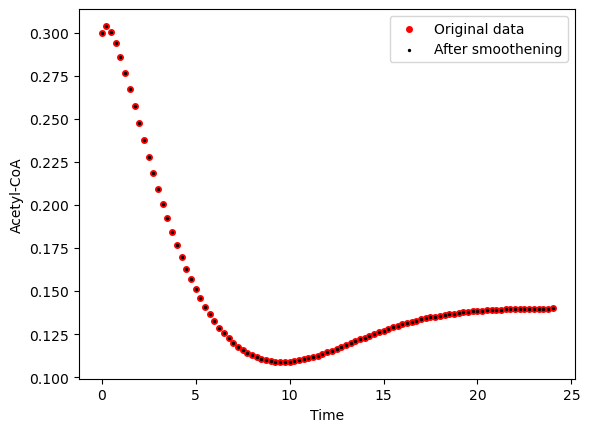

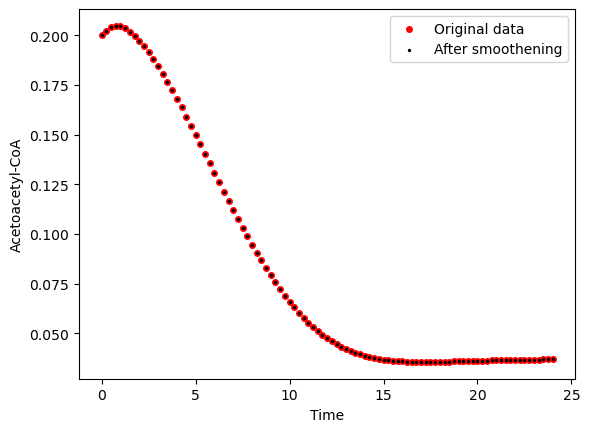

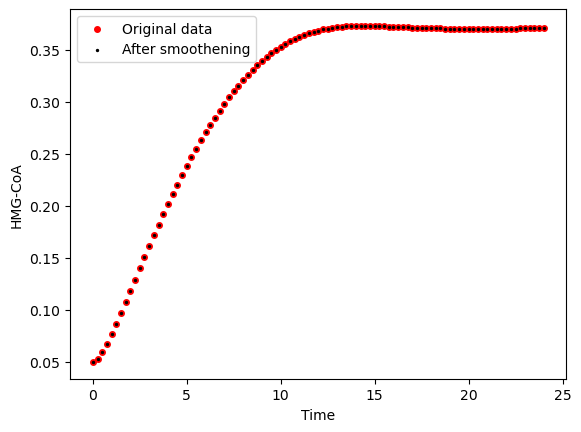

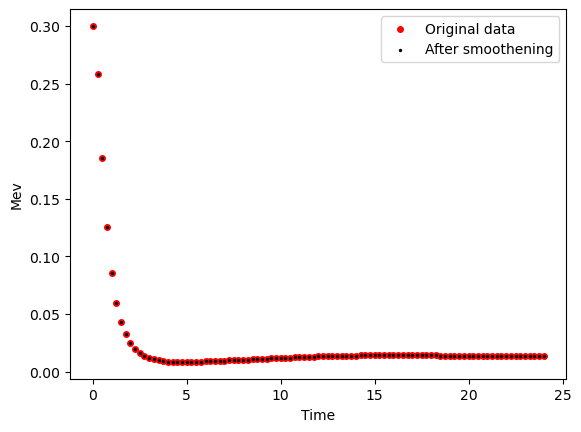

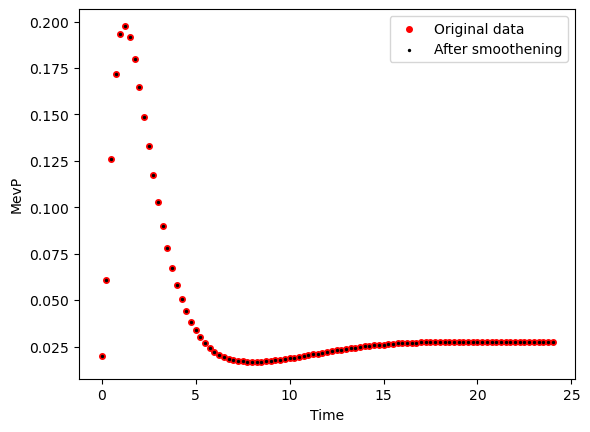

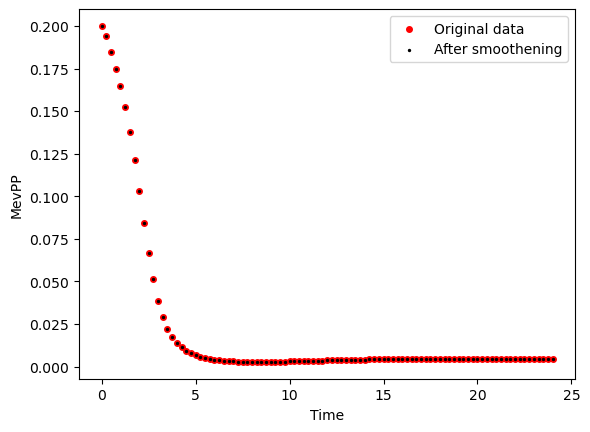

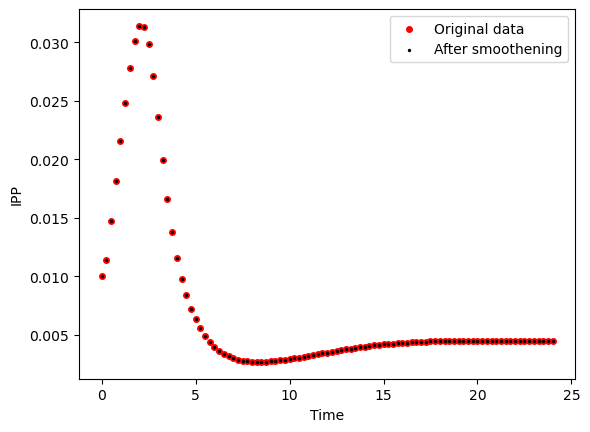

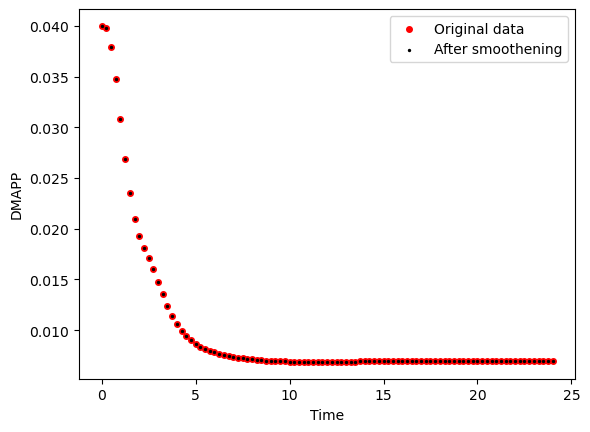

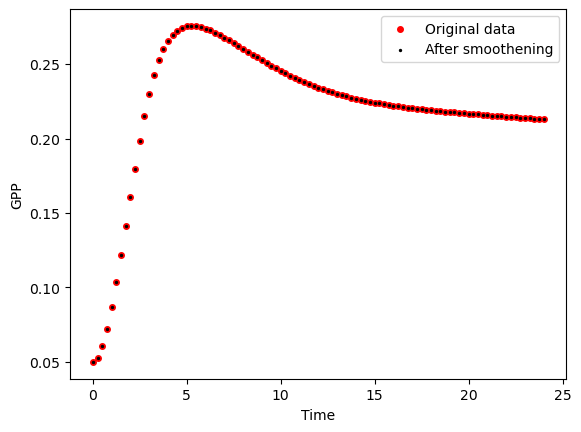

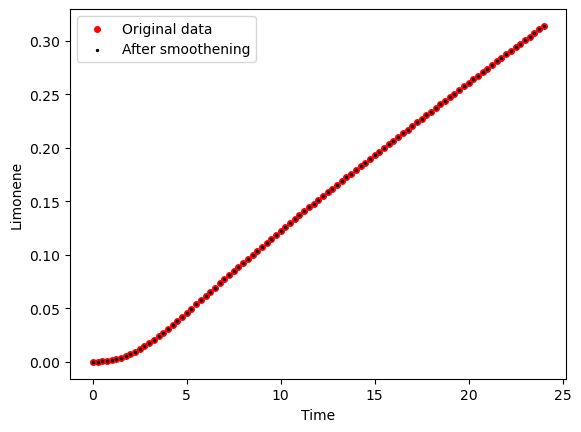

Strain Strain 2


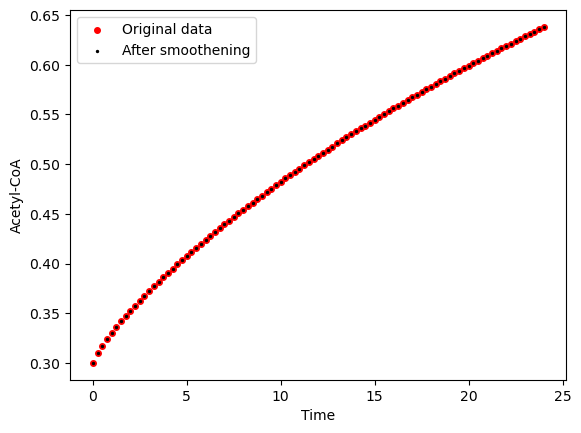

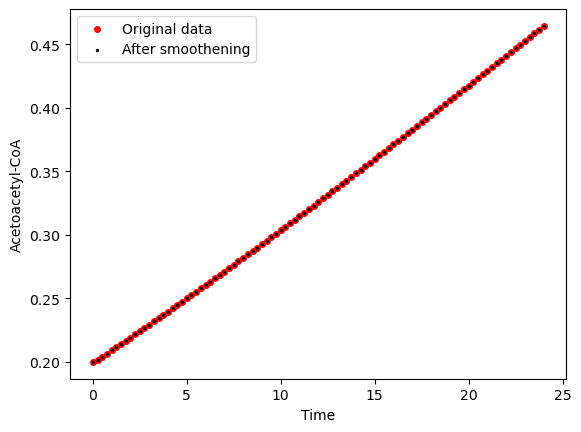

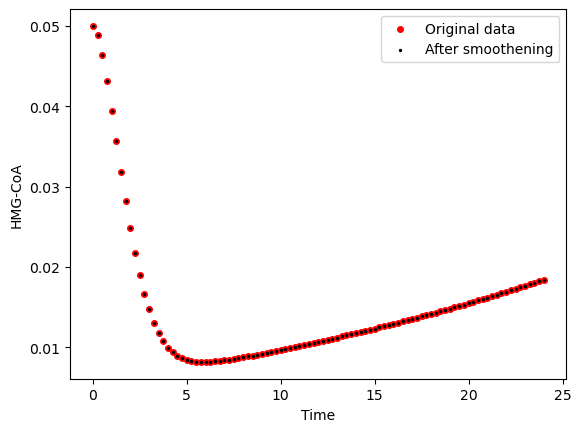

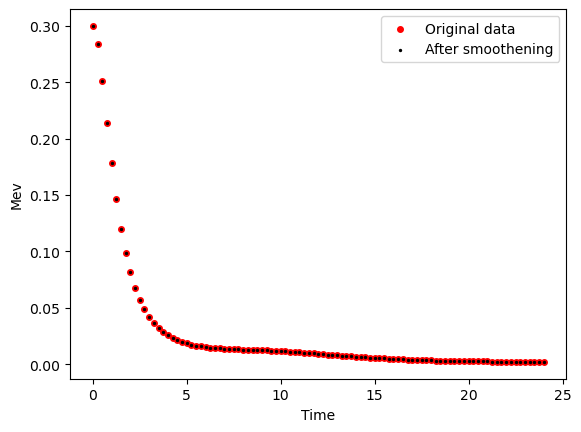

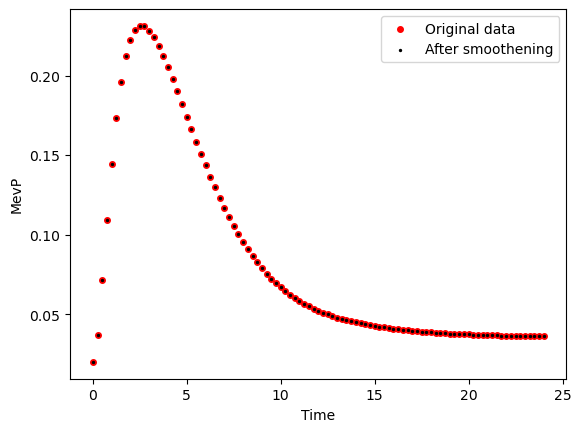

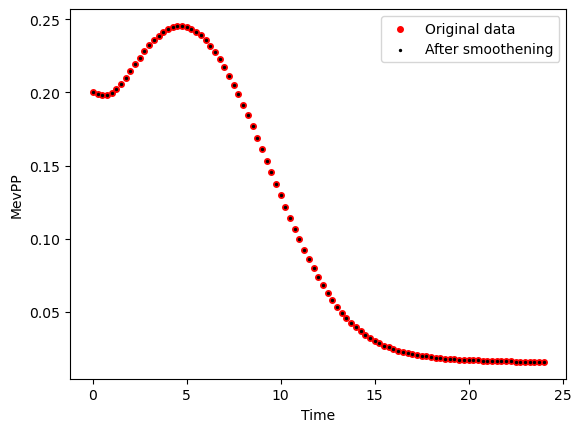

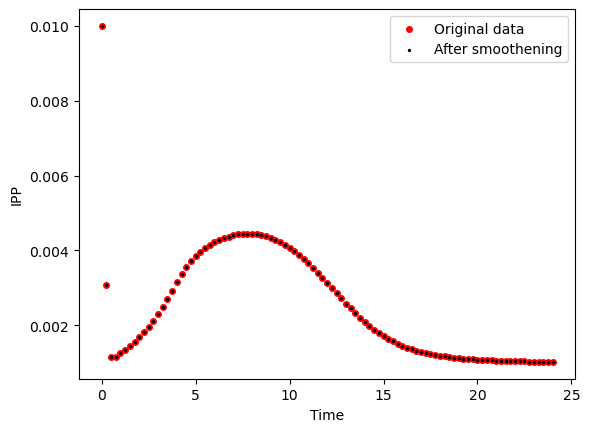

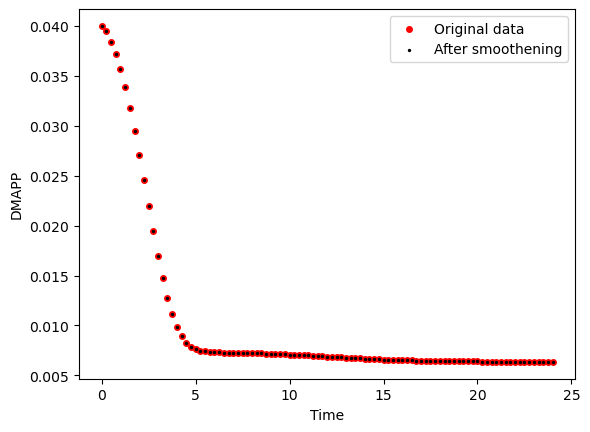

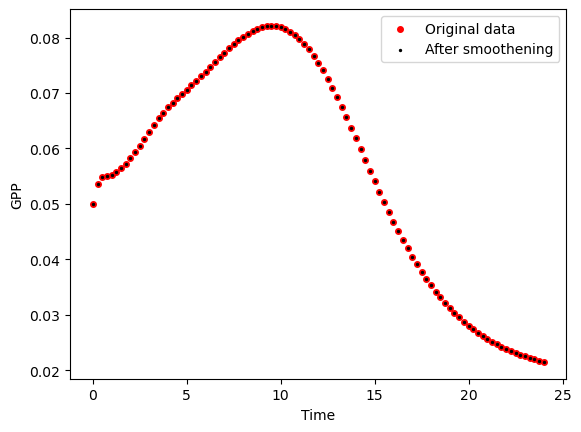

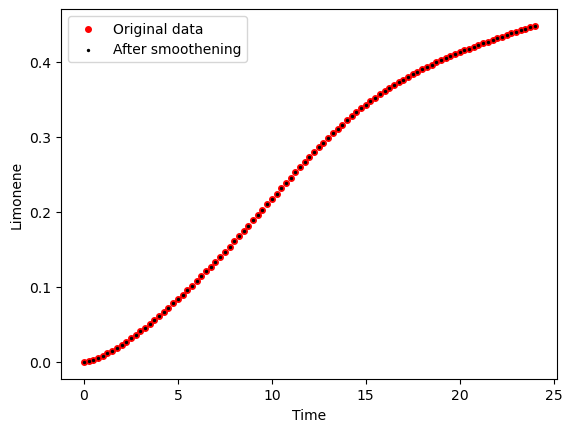

Strain Strain 3


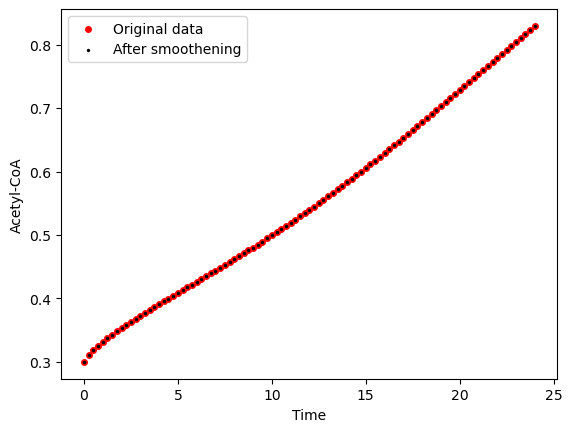

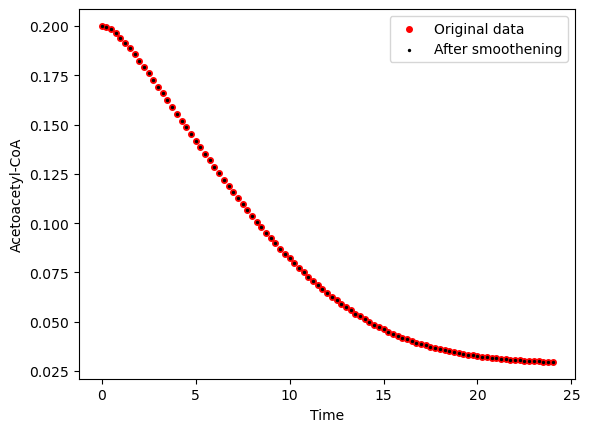

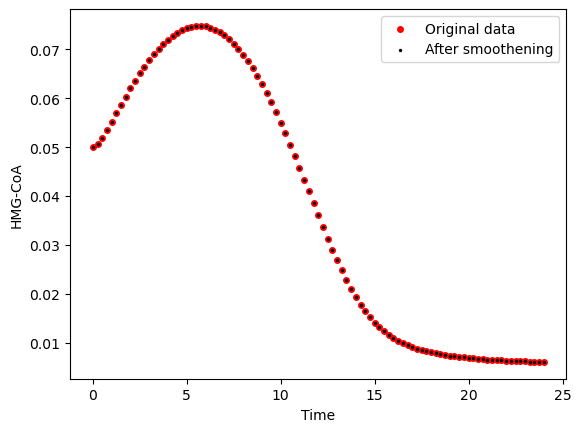

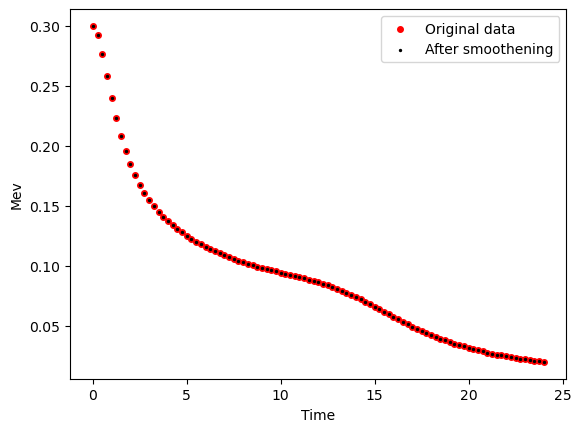

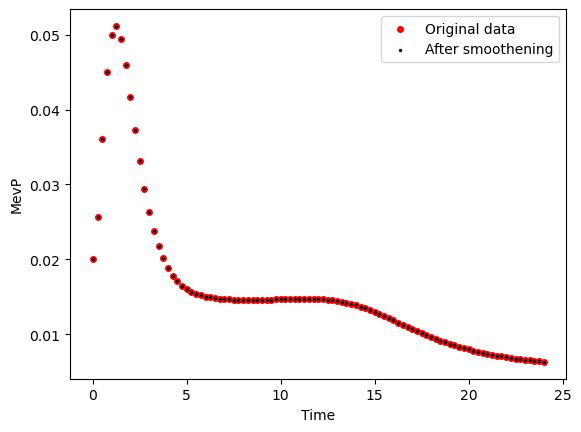

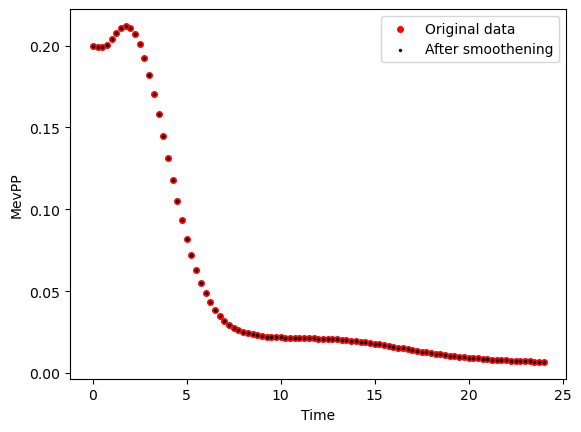

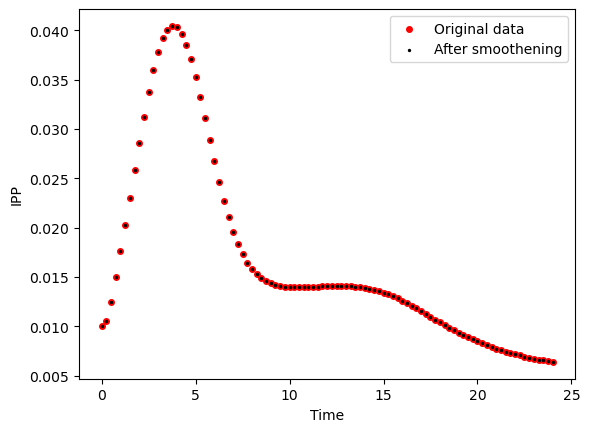

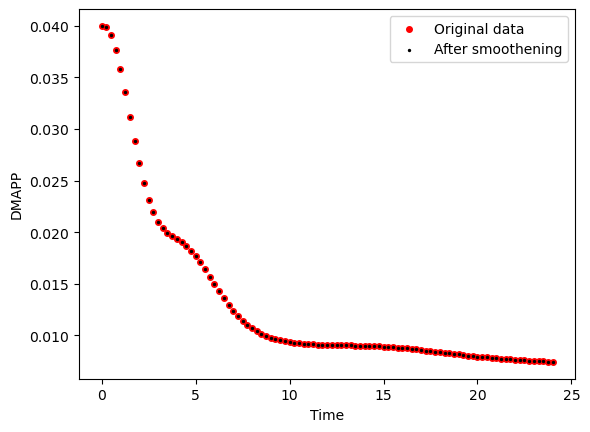

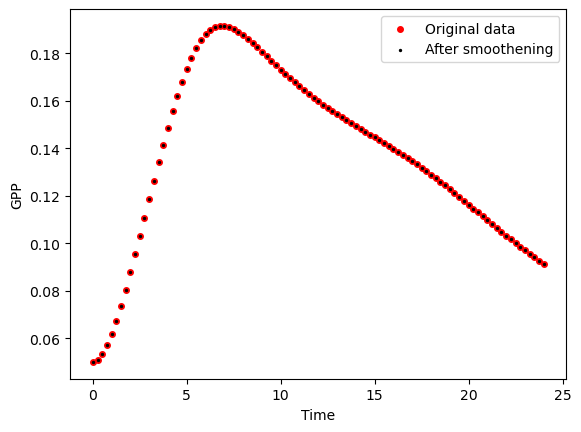

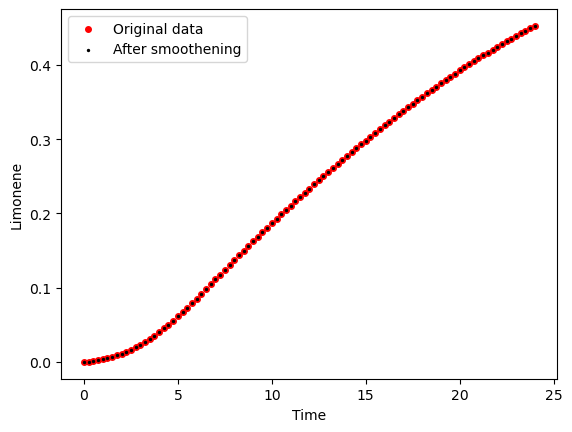

Strain WT


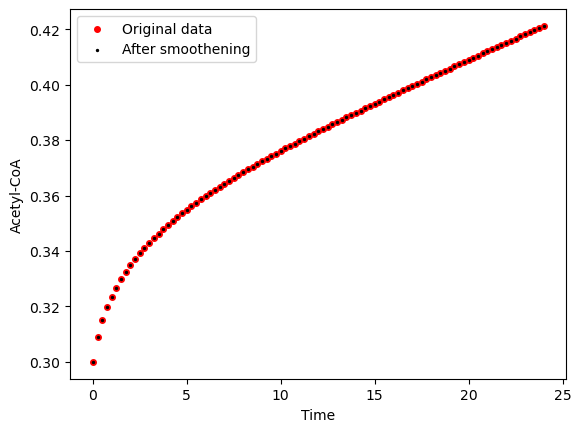

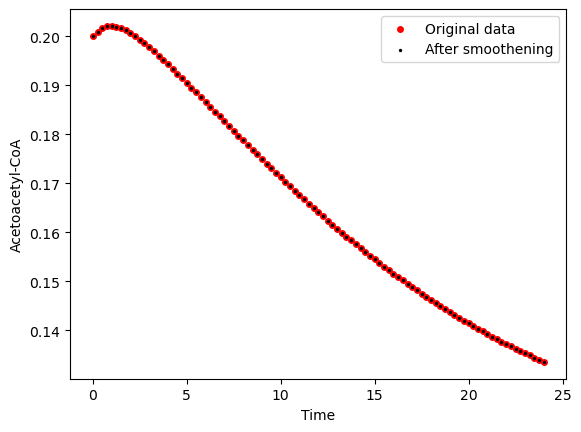

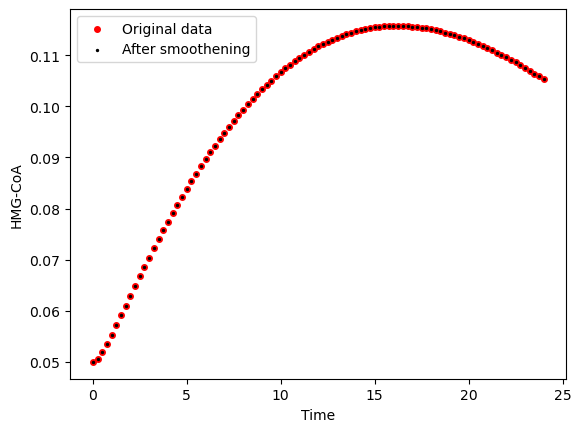

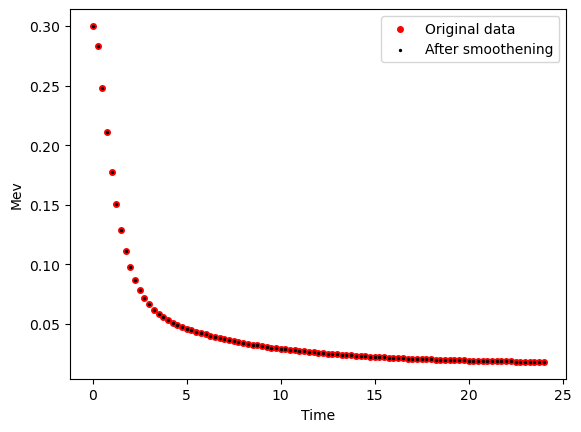

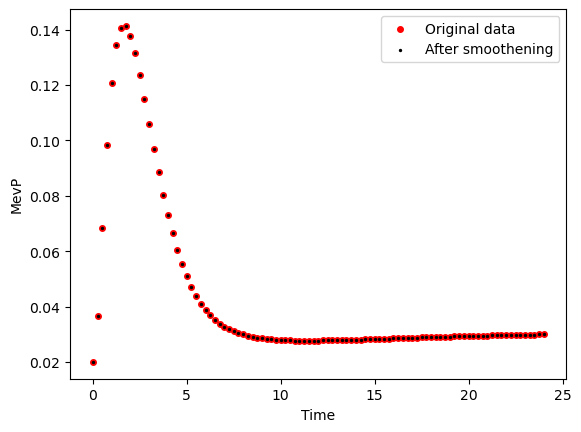

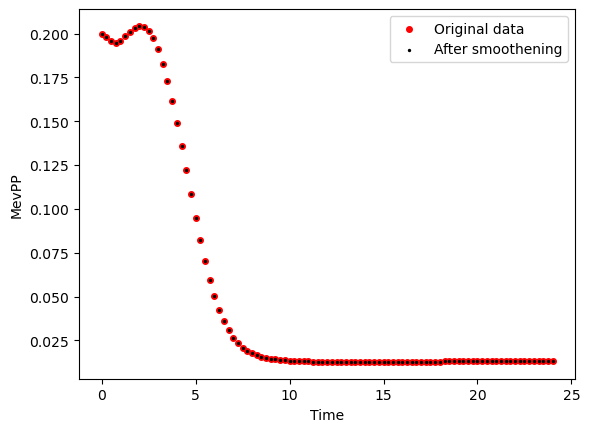

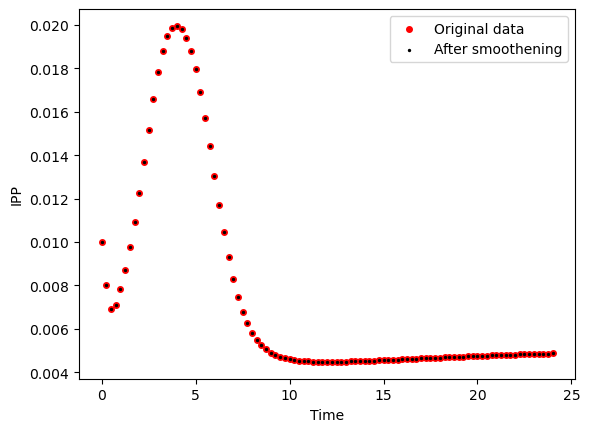

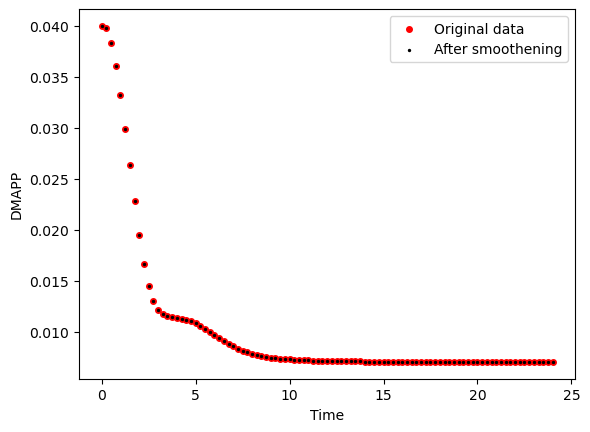

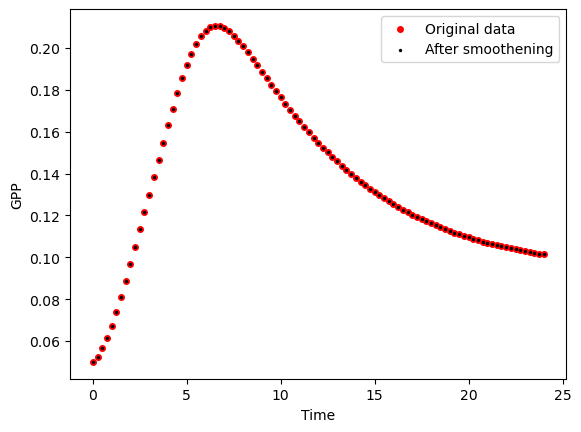

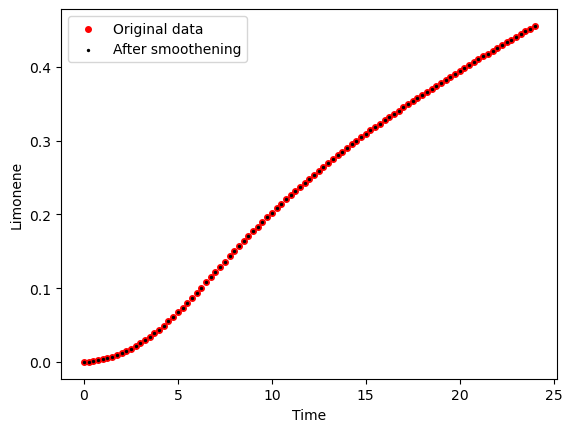

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


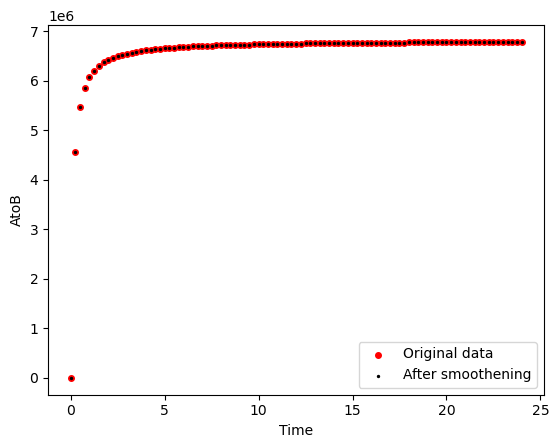

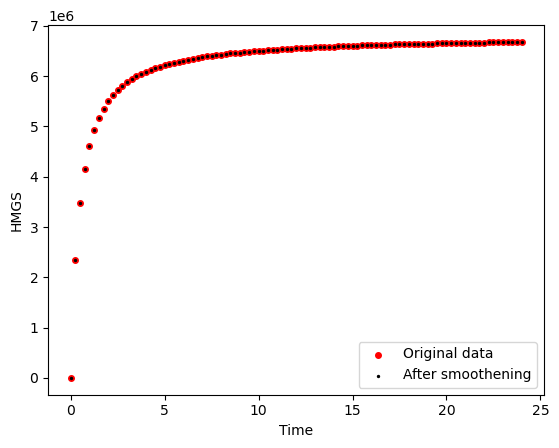

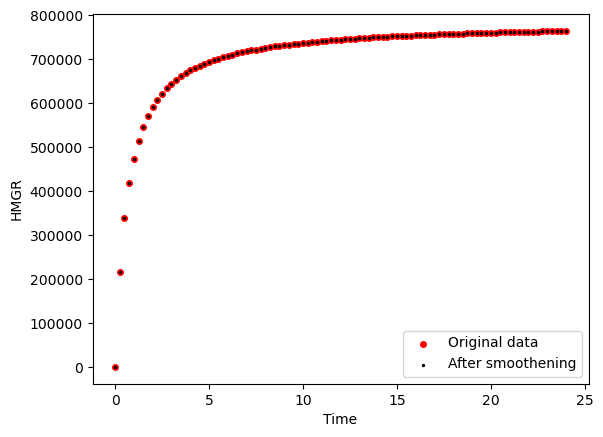

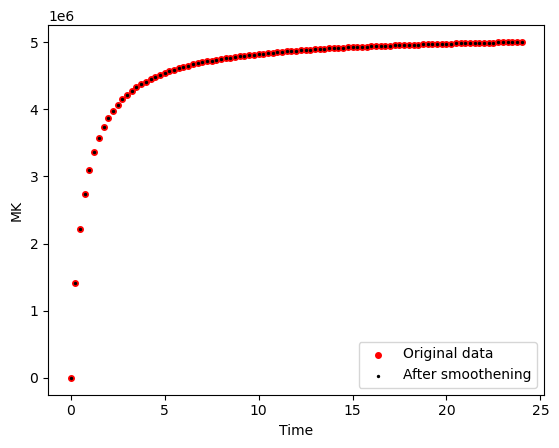

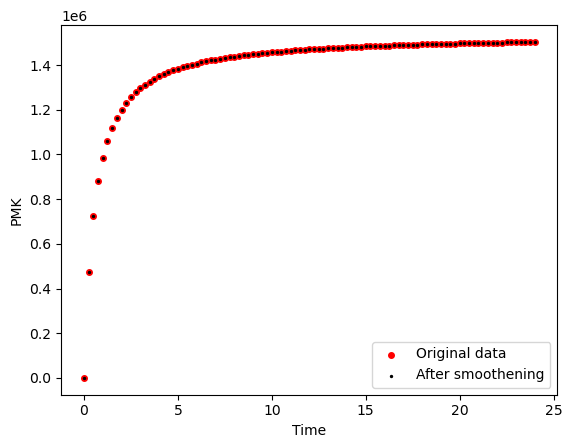

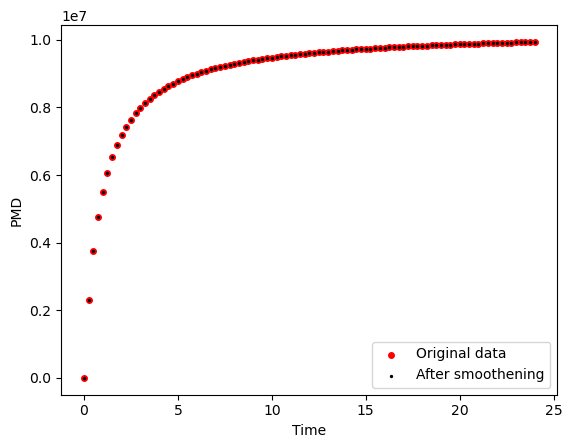

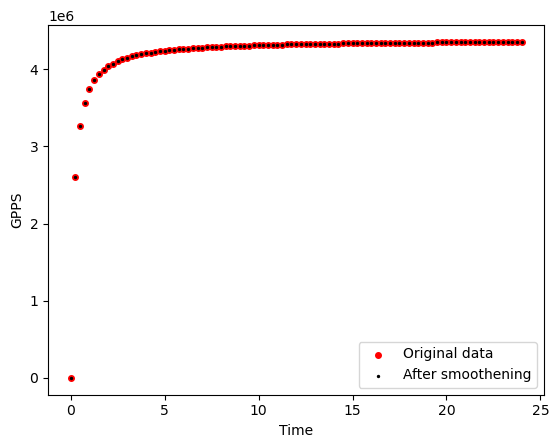

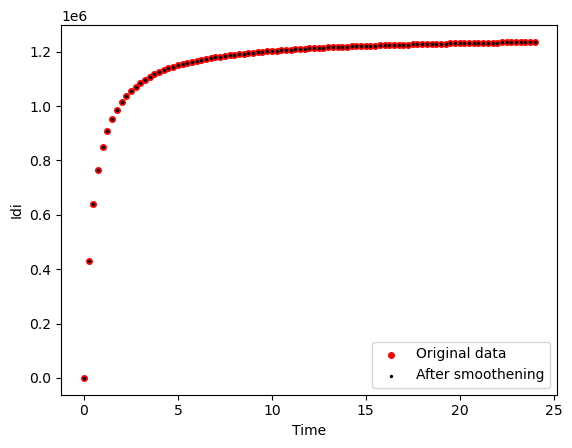

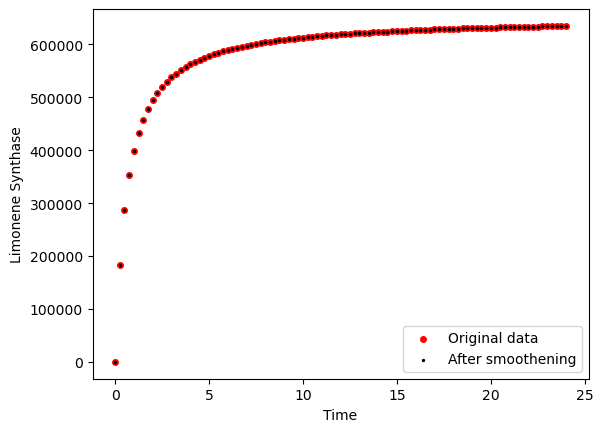

Strain Strain 2


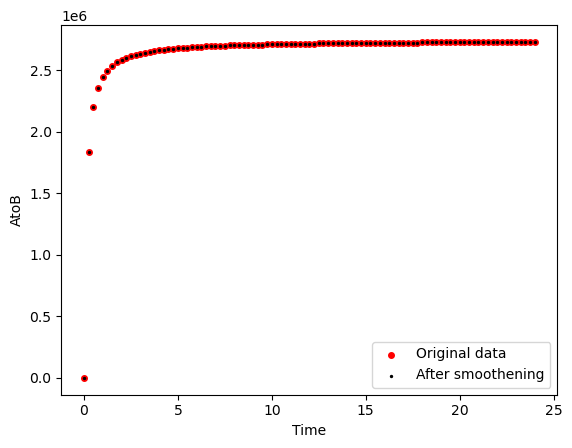

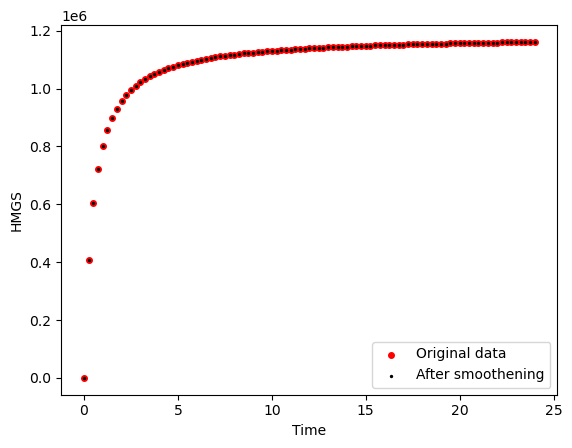

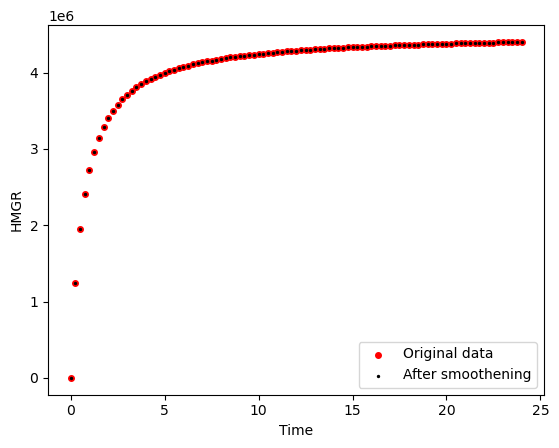

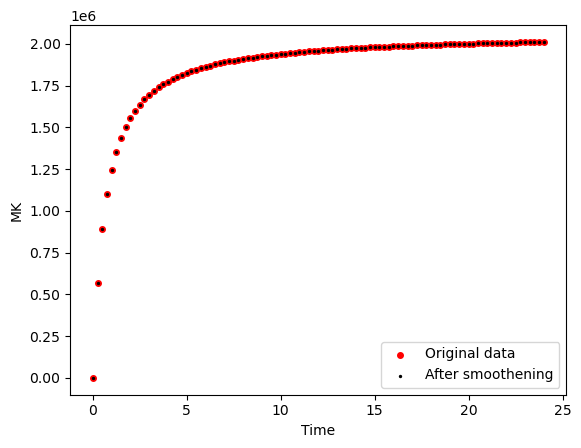

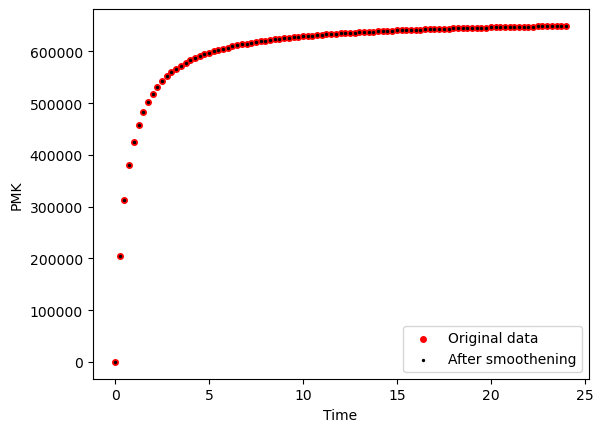

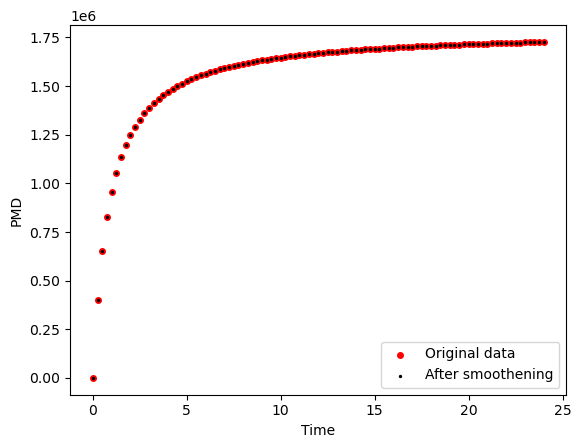

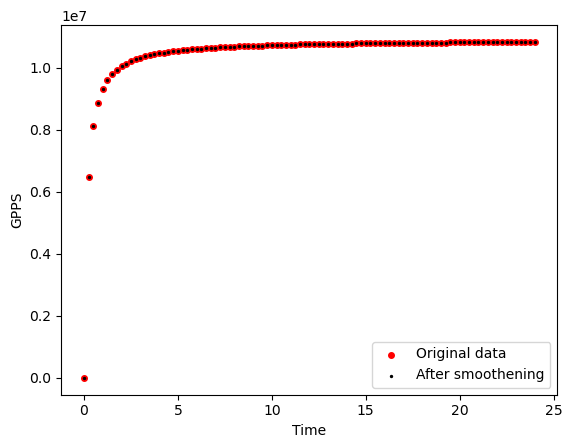

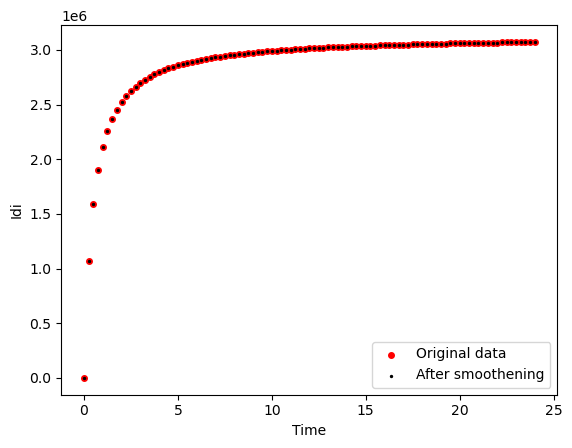

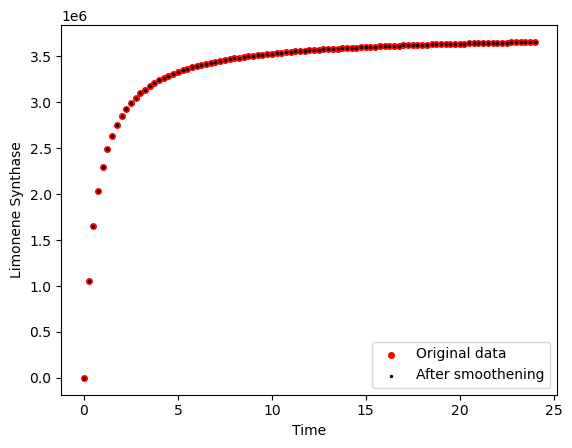

Strain Strain 3


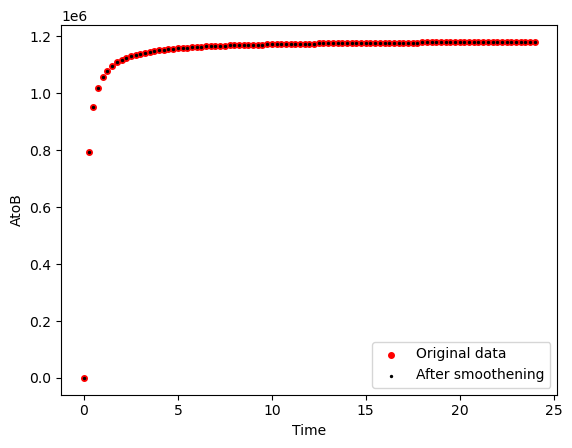

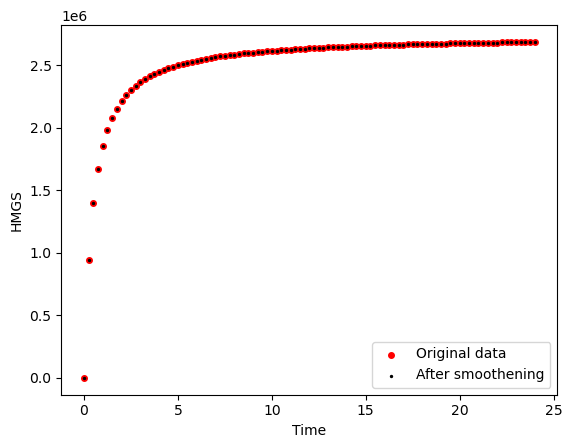

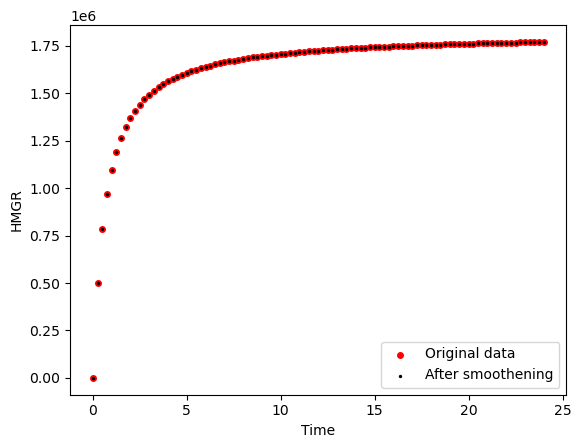

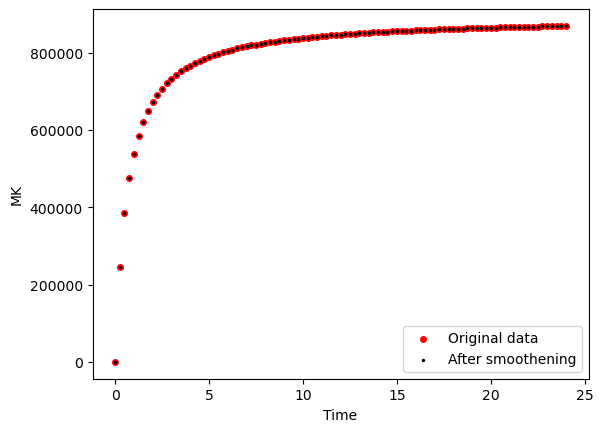

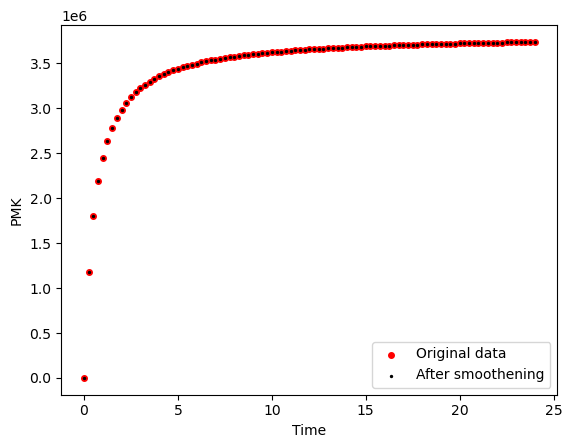

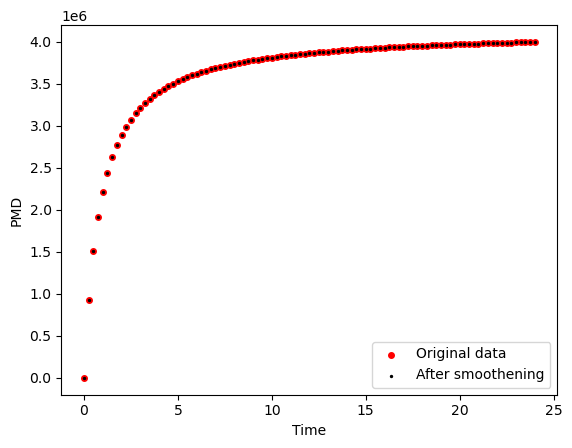

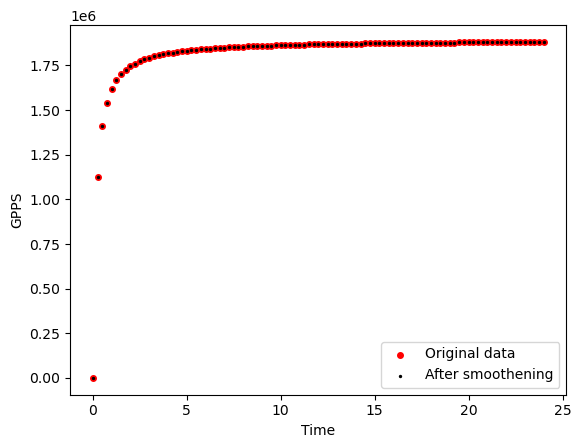

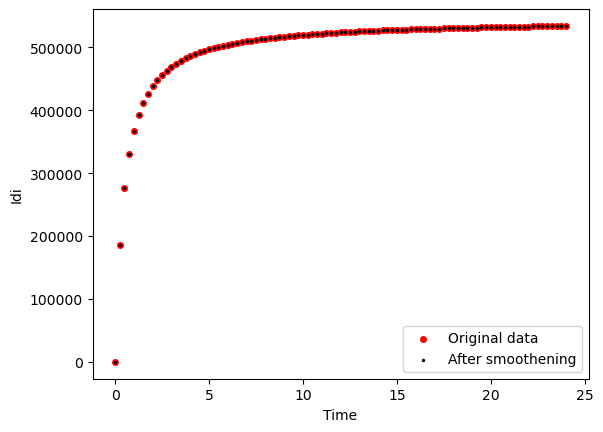

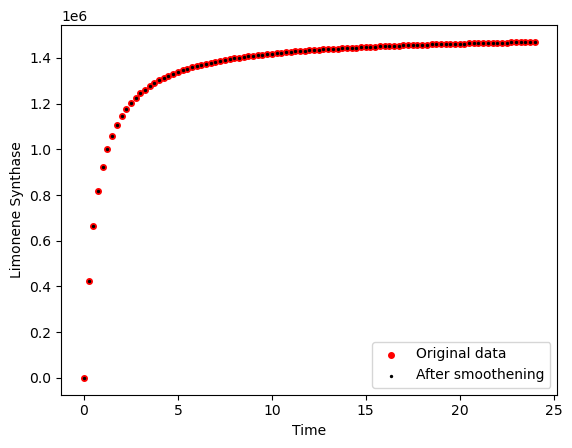

Strain WT


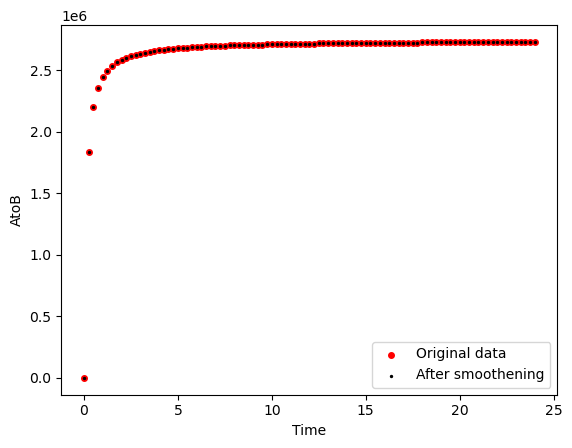

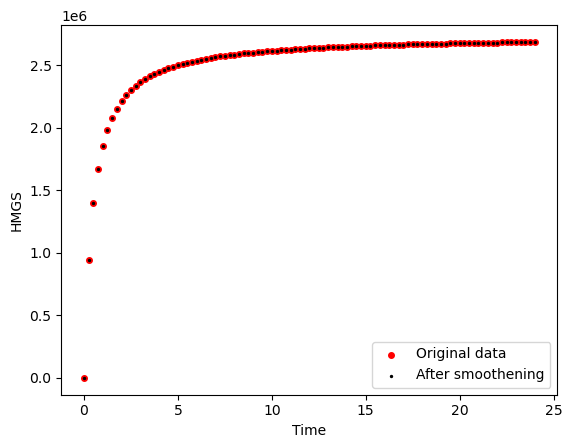

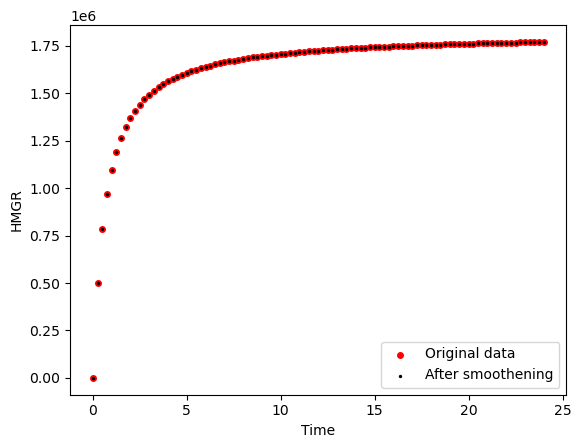

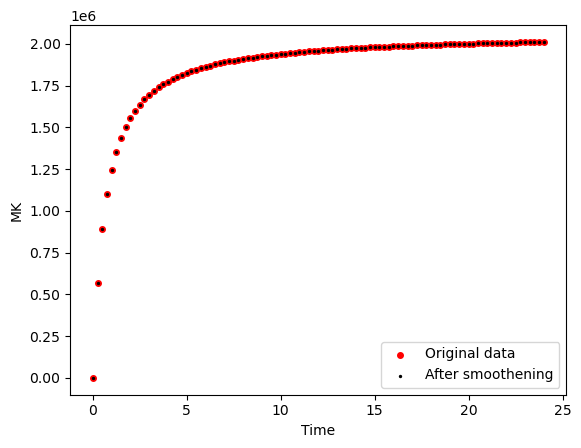

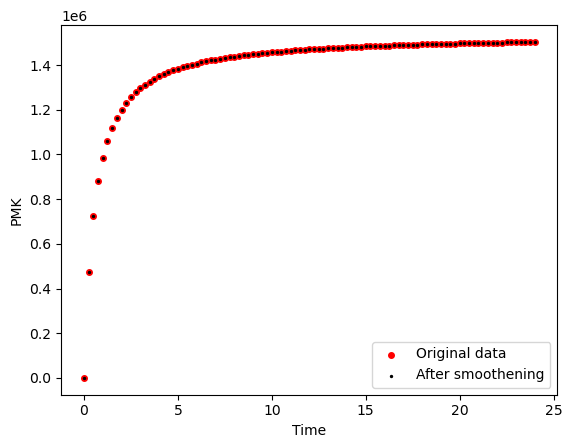

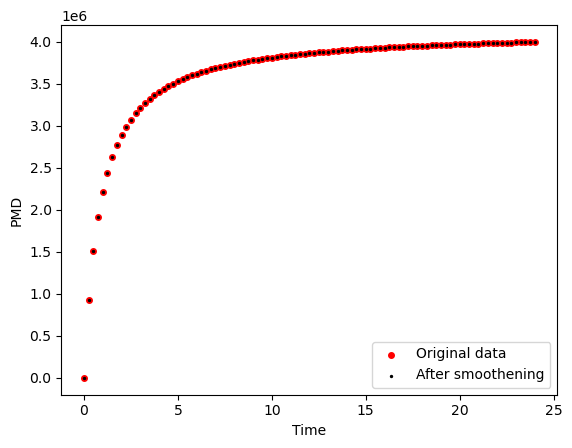

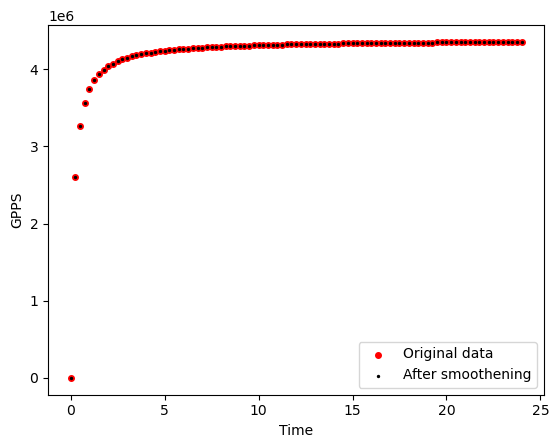

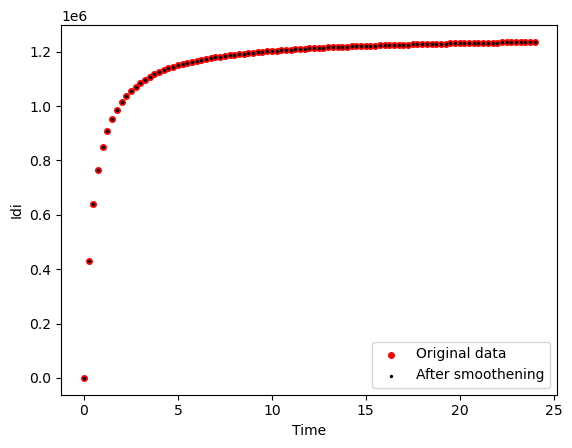

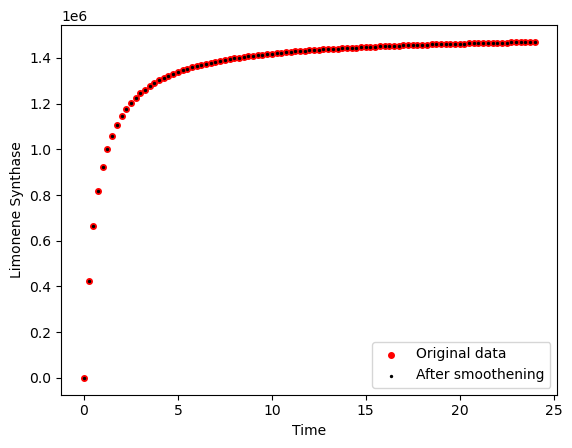

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.303889        0.202239  0.052901  0.257973  0.060732   
         0.50    0.300366        0.204051  0.059318  0.185505  0.126153   
         0.75    0.293825        0.204705  0.067553  0.125893  0.171899   
         1.00    0.285682        0.204435  0.076846  0.085674  0.193388   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.418135        0.135344  0.107524  0.018433  0.029820   
         23.25   0.418894        0.134891  0.106975  0.018376  0.029853   
         23.50   0.419652        0.134446  0.106413  0.018321  0.029884   
         23.75   0.420408        0.134009  0.105838  0.018268  0.029914   
         24.00   0.421163        0.133581  0.105252  0.018217  0.029943   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.194292  0.011434  0.039765  0.052914  0.000130  ...   
         0.50   0.184541  0.014747  0.037935  0.060579  0.000468  ...   
         0.75   0.174893  0.018155  0.034722  0.072187  0.000997  ...   
         1.00   0.164537  0.021526  0.030790  0.086852  0.001739  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.013294  0.004839  0.007023  0.102943  0.440720  ...   
         23.25  0.013307  0.004846  0.007023  0.102536  0.444453  ...   
         23.50  0.013319  0.004852  0.007023  0.102148  0.448172  ...   
         23.75  0.013331  0.004858  0.007022  0.101776  0.451879  ...   
         24.00  0.013342  0.004864  0.007022  0.101420  0.455574  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.024056        0.011807  0.006596 -0.203422  0.217911   
         0.25    -0.000307        0.008010  0.019158 -0.234048  0.216216   
         0.50    -0.018662        0.004401  0.028864 -0.237215  0.192786   
         0.75    -0.031009        0.000980  0.035716 -0.212924  0.147623   
         1.00    -0.034961       -0.002637  0.038781 -0.133242  0.051775   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.003039       -0.001829 -0.002172 -0.000234  0.000133   
         23.25    0.003034       -0.001796 -0.002224 -0.000225  0.000128   
         23.50    0.003028       -0.001764 -0.002274 -0.000216  0.000123   
         23.75    0.003022       -0.001731 -0.002322 -0.000208  0.000117   
         24.00    0.003017       -0.001699 -0.002367 -0.000200  0.000112   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.025532  0.005014  0.003988  0.001041  0.000215  
         0.25  -0.030620  0.009670 -0.004554  0.021740  0.000923  
         0.50  -0.035884  0.012750 -0.010733  0.039083  0.001698  
         0.75  -0.041325  0.014255 -0.014547  0.053067  0.002541  
         1.00  -0.044974  0.013478 -0.016064  0.063589  0.003433  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.000053  0.000026 -0.000001 -0.001663  0.014958  
         23.25  0.000051  0.000025 -0.000001 -0.001590  0.014904  
         23.50  0.000049  0.000024 -0.000001 -0.001521  0.014852  
         23.75  0.000047  0.000023 -0.000001 -0.001454  0.014803  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

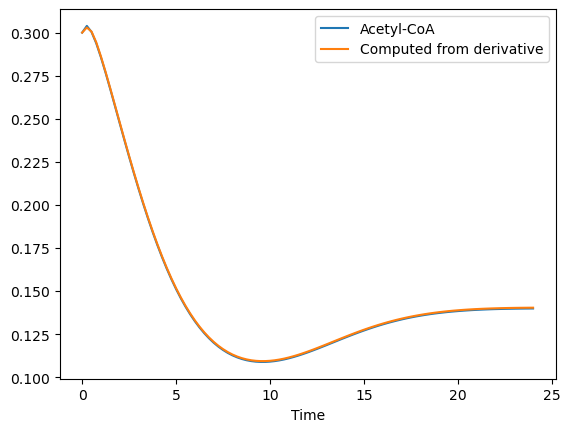

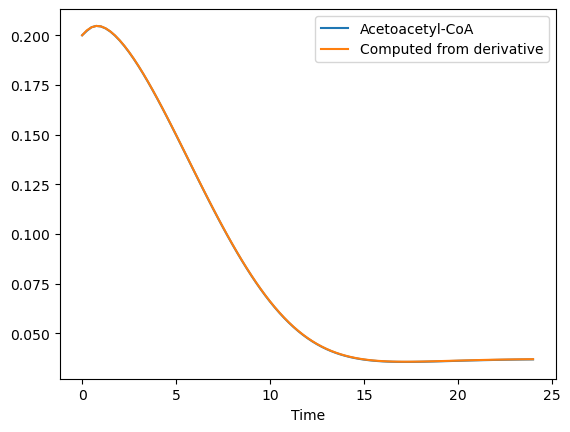

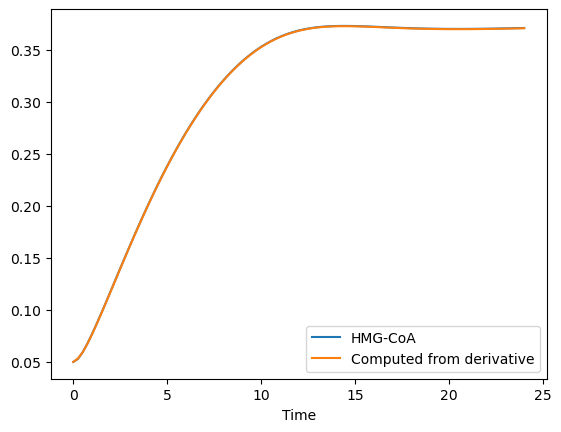

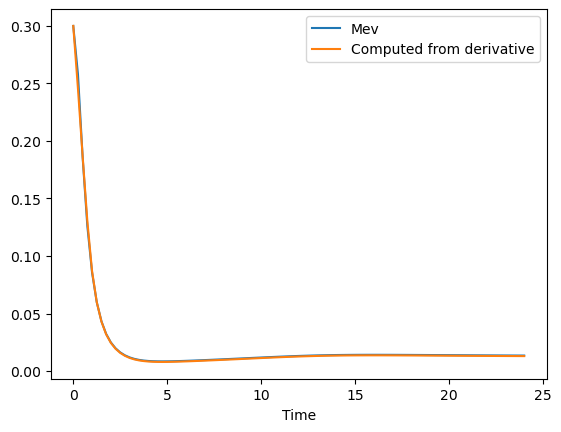

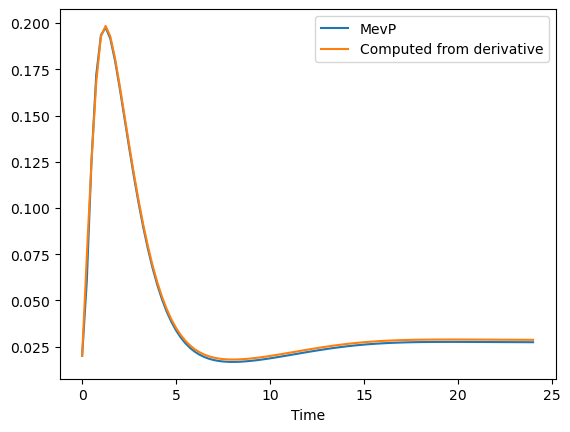

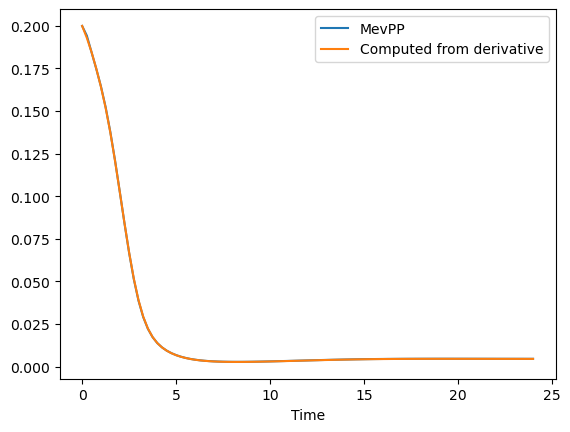

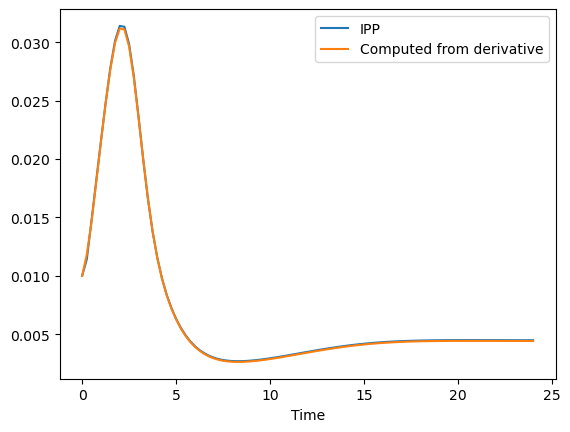

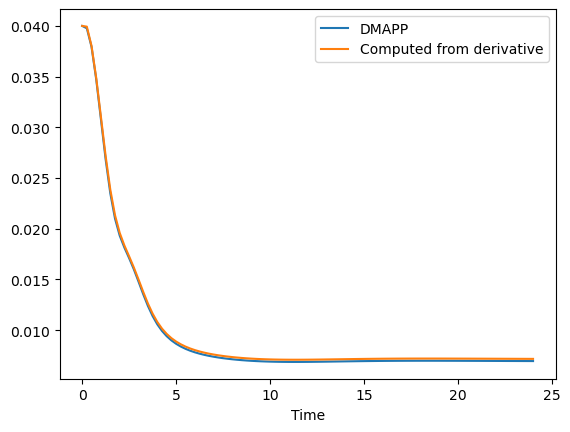

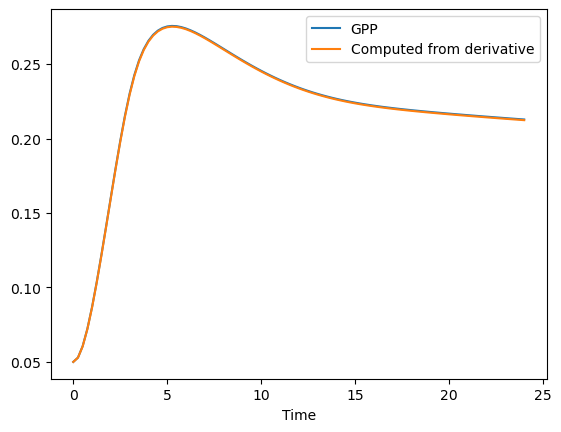

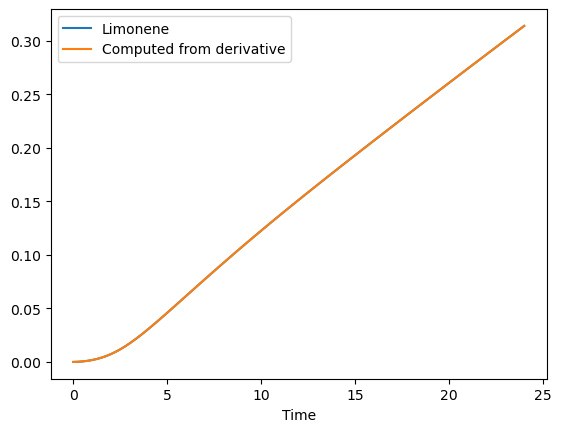

'Time profile from derivative vs. actual profile for Strain 2'

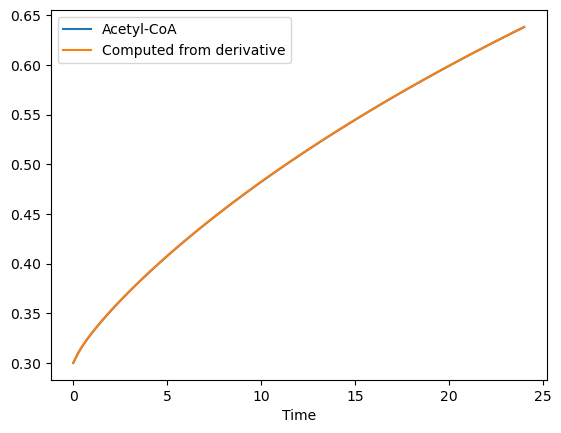

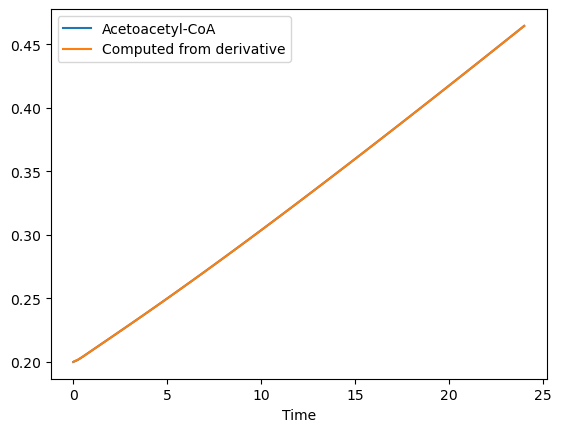

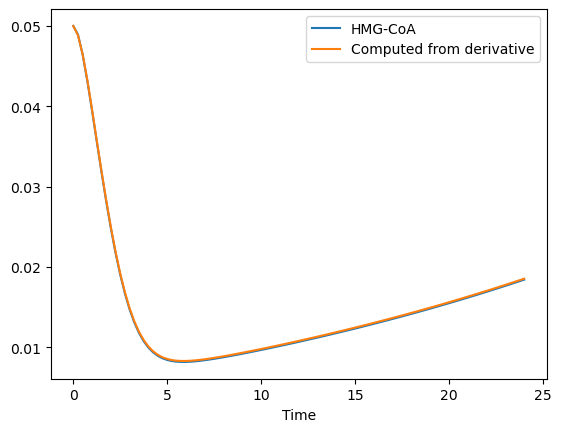

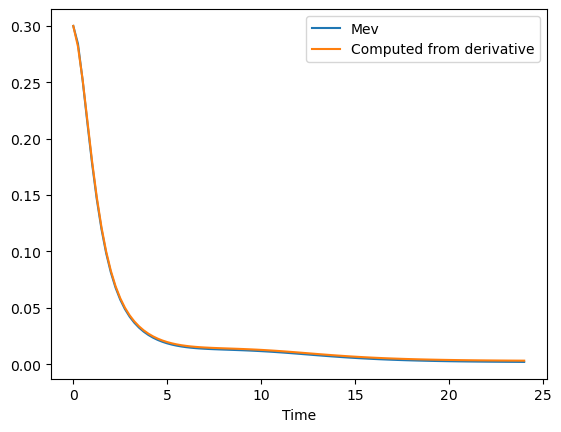

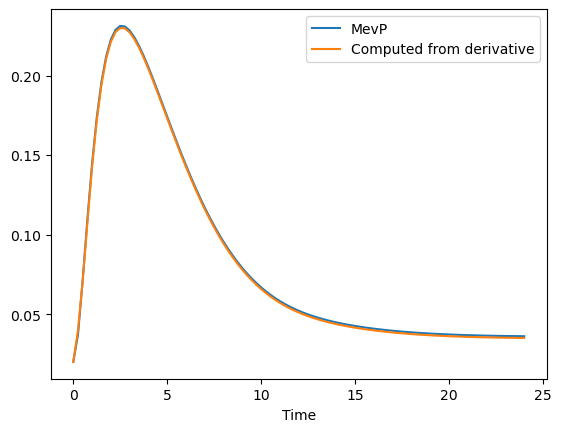

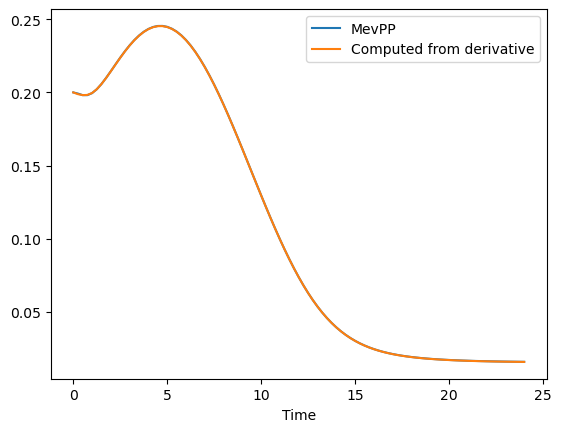

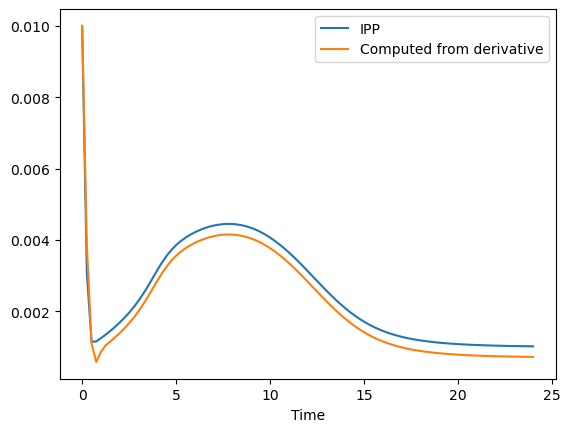

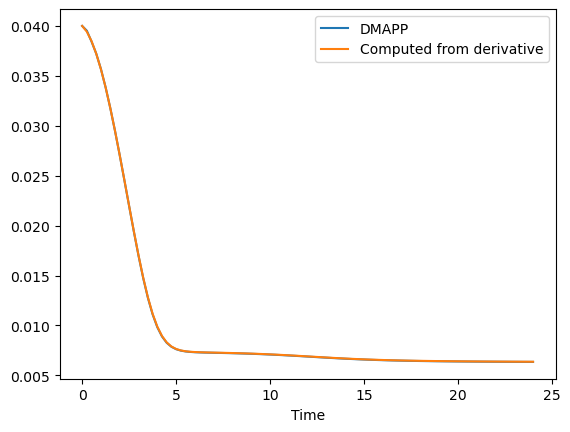

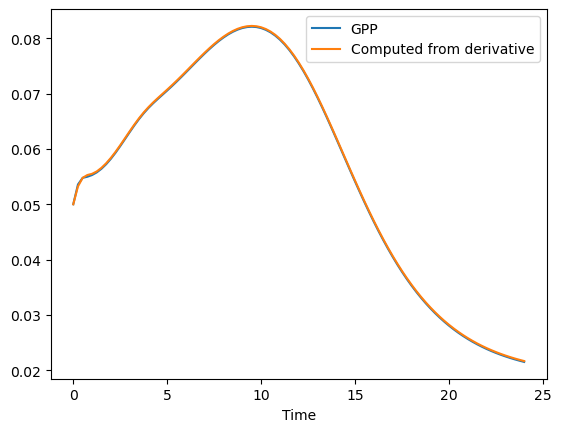

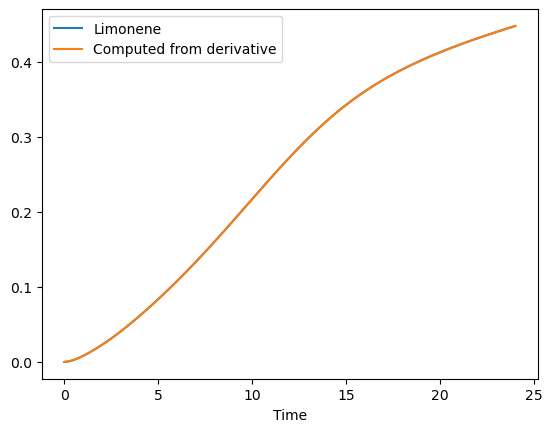

'Time profile from derivative vs. actual profile for Strain 3'

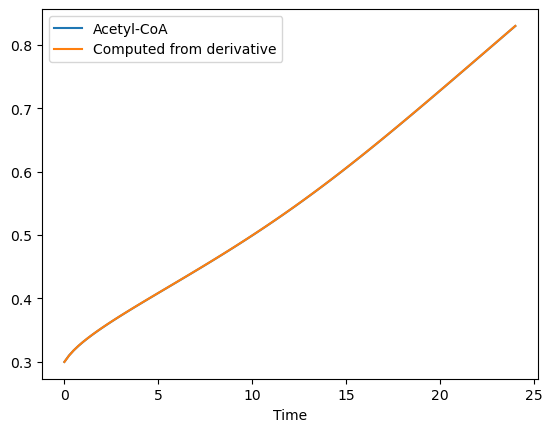

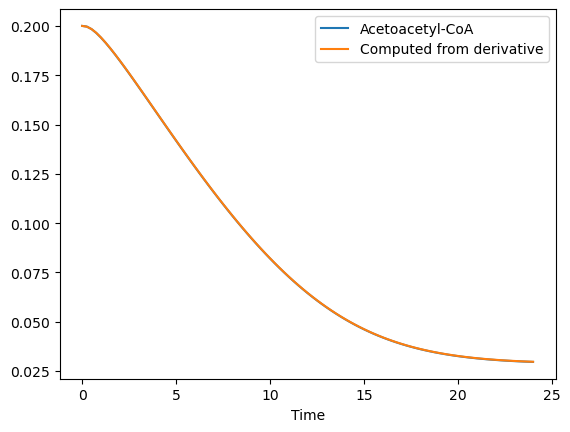

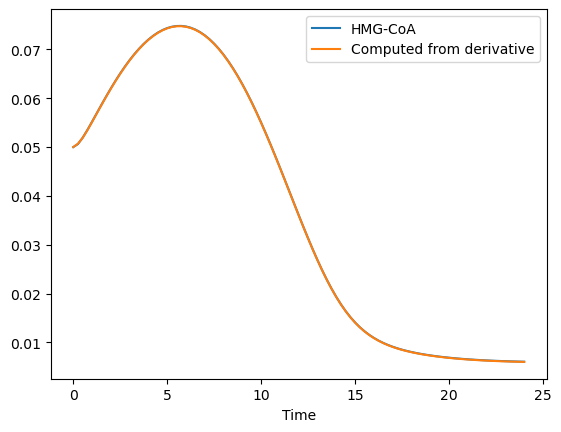

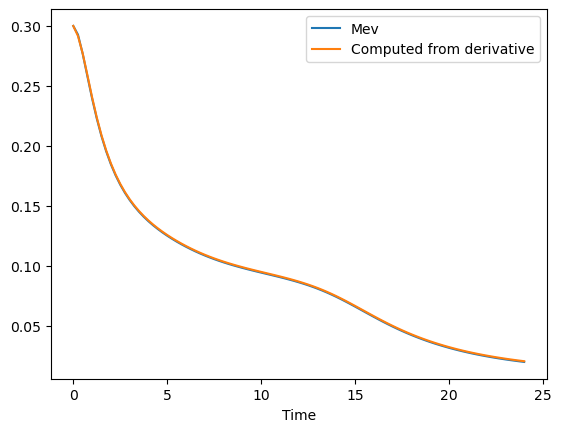

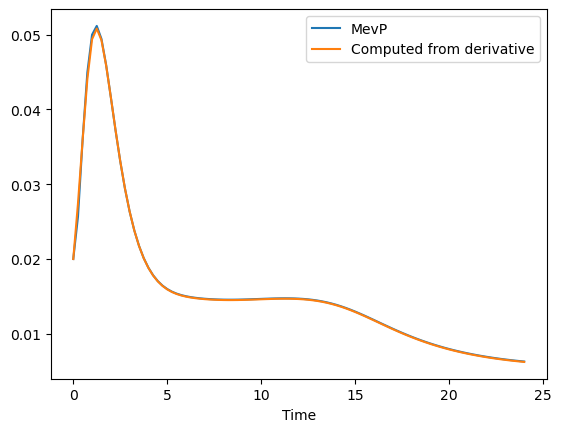

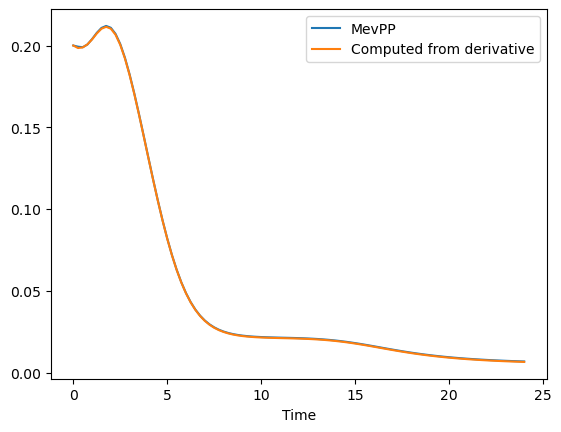

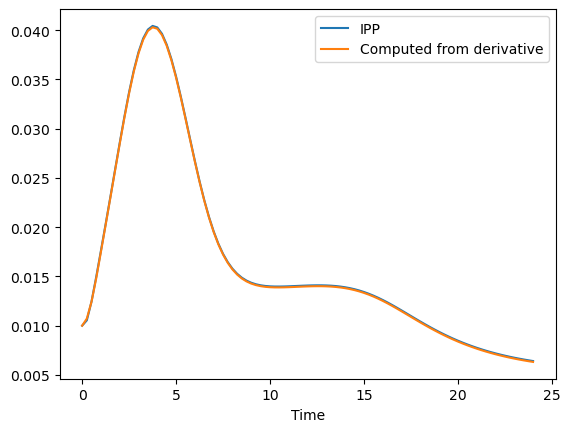

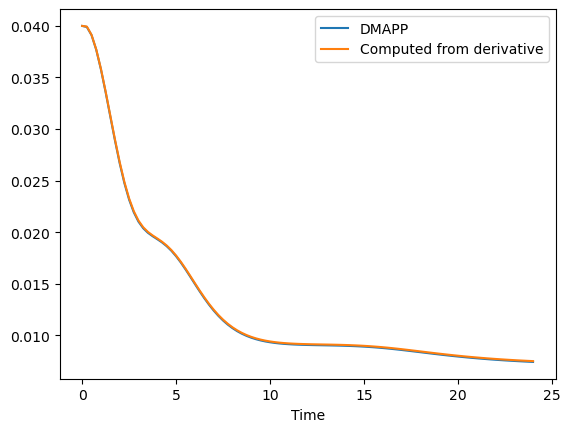

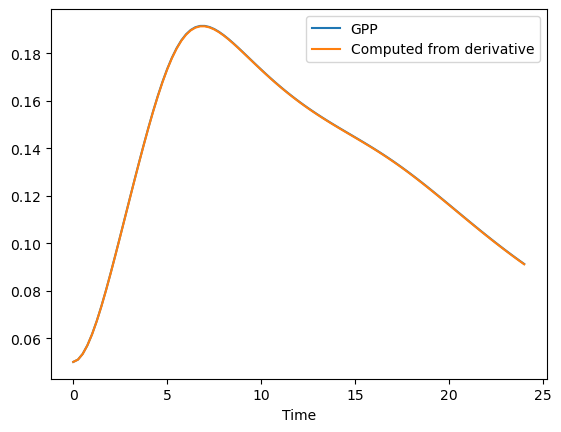

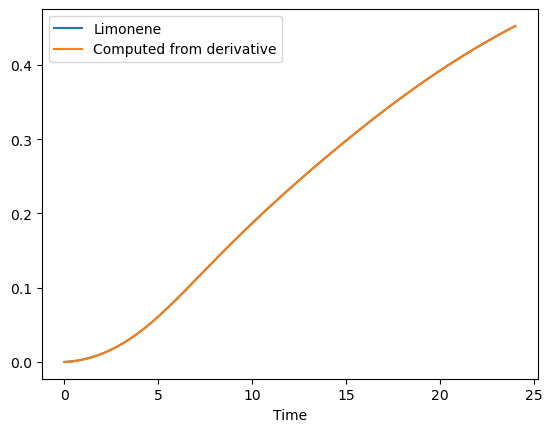

'Time profile from derivative vs. actual profile for WT'

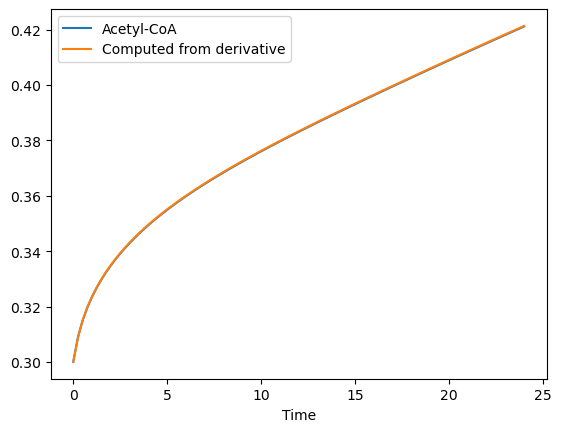

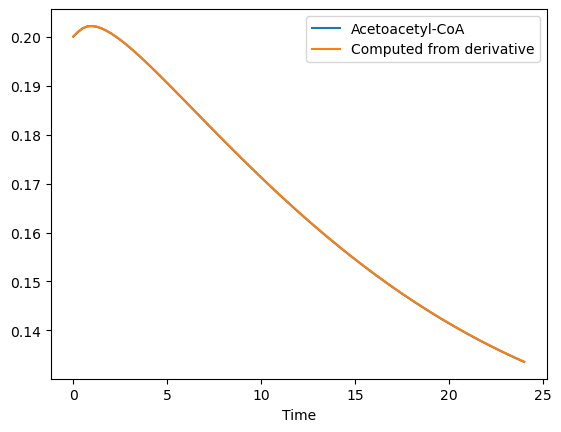

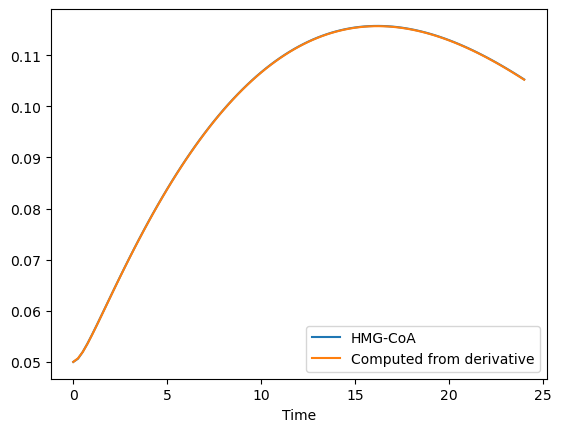

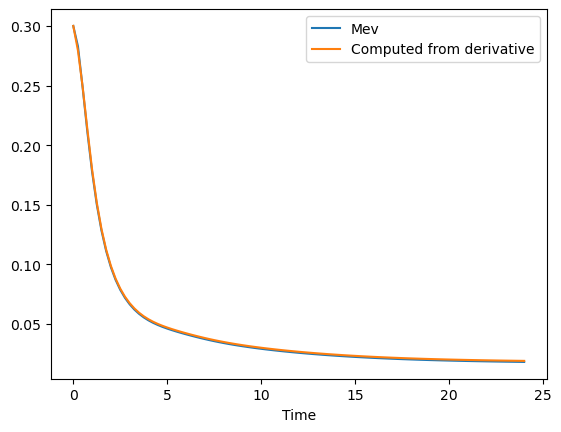

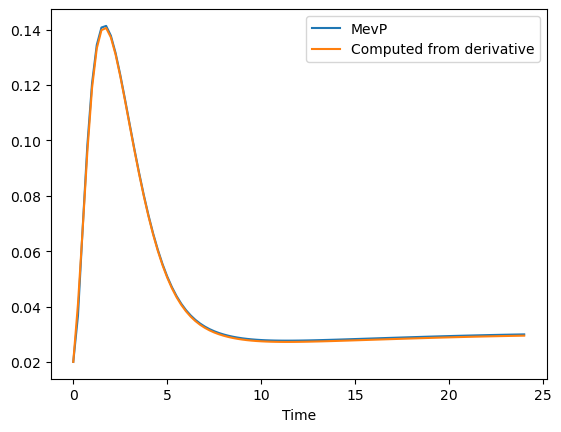

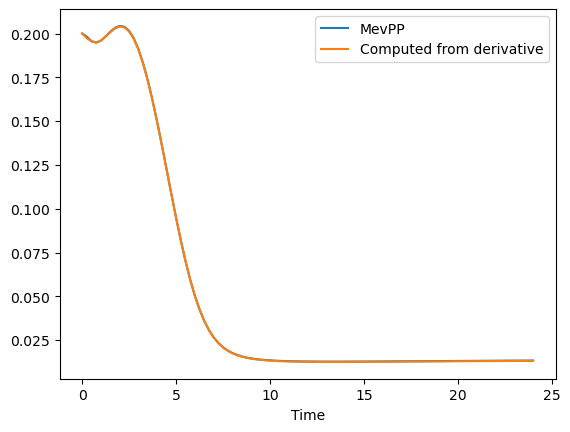

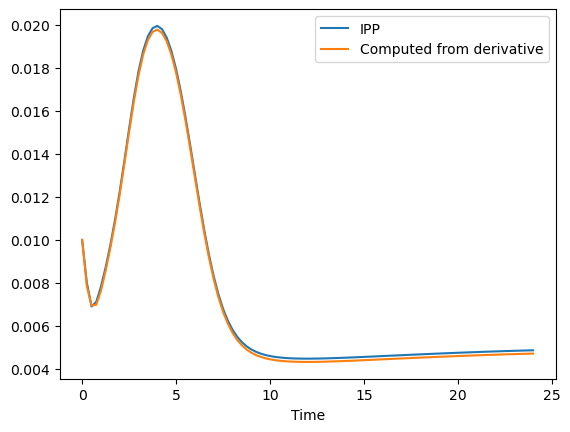

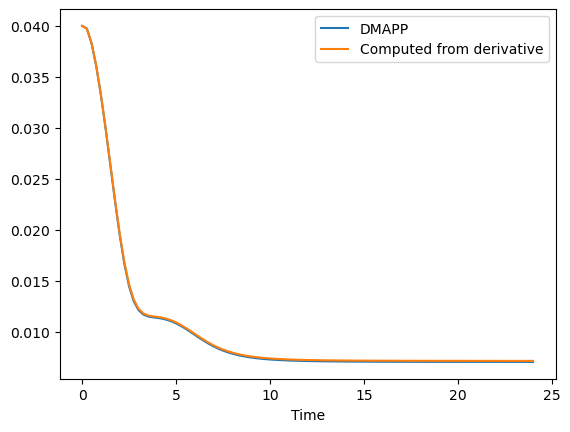

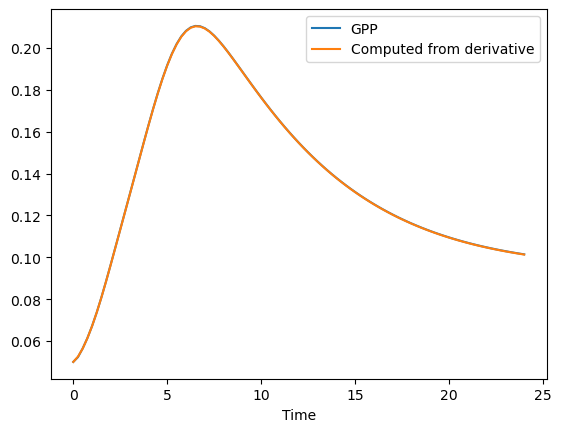

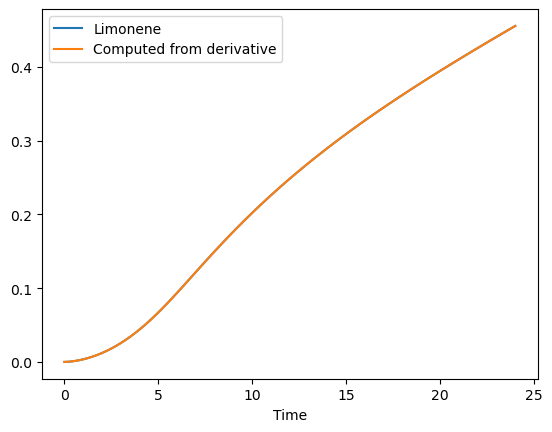

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.303889        0.202239  0.052901   
         0.50       2.866143e+05   0.300366        0.204051  0.059318   
         0.75       3.524272e+05   0.293825        0.204705  0.067553   
         1.00       3.981392e+05   0.285682        0.204435  0.076846   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.418135        0.135344  0.107524   
         23.25      1.468435e+06   0.418894        0.134891  0.106975   
         23.50      1.468851e+06   0.419652        0.134446  0.106413   
         23.75      1.469260e+06   0.420408        0.134009  0.105838   
         24.00      1.469659e+06   0.421163        0.133581  0.105252   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.257973  0.060732  0.194292  0.011434  0.039765  0.052914   
         0.50   0.185505  0.126153  0.184541  0.014747  0.037935  0.060579   
         0.75   0.125893  0.171899  0.174893  0.018155  0.034722  0.072187   
         1.00   0.085674  0.193388  0.164537  0.021526  0.030790  0.086852   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.018433  0.029820  0.013294  0.004839  0.007023  0.102943   
         23.25  0.018376  0.029853  0.013307  0.004846  0.007023  0.102536   
         23.50  0.018321  0.029884  0.013319  0.004852  0.007023 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.024056        0.011807  0.006596 -0.203422  0.217911   
         0.25    -0.000307        0.008010  0.019158 -0.234048  0.216216   
         0.50    -0.018662        0.004401  0.028864 -0.237215  0.192786   
         0.75    -0.031009        0.000980  0.035716 -0.212924  0.147623   
         1.00    -0.034961       -0.002637  0.038781 -0.133242  0.051775   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.003039       -0.001829 -0.002172 -0.000234  0.000133   
         23.25    0.003034       -0.001796 -0.002224 -0.000225  0.000128   
         23.50    0.003028       -0.001764 -0.002274 -0.000216  0.000123   
         23.75    0.003022       -0.001731 -0.002322 -0.000208  0.000117   
         24.00    0.003017       -0.001699 -0.002367 -0.000200  0.000112   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.025532  0.005014  0.003988  0.001041  0.000215  
         0.25  -0.030620  0.009670 -0.004554  0.021740  0.000923  
         0.50  -0.035884  0.012750 -0.010733  0.039083  0.001698  
         0.75  -0.041325  0.014255 -0.014547  0.053067  0.002541  
         1.00  -0.044974  0.013478 -0.016064  0.063589  0.003433  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.000053  0.000026 -0.000001 -0.001663  0.014958  
         23.25  0.000051  0.000025 -0.000001 -0.001590  0.014904  
         23.50  0.000049  0.000024 -0.000001 -0.001521  0.014852  
         23.75  0.000047  0.000023 -0.000001 -0.001454  0.014803  
         24.00  0.000044  0.000023 -0.000001 -0.001390  0.014756  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=27, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                             -12.0,-12.0,
                             -12.0,-12.0,-12.0,
                             -12.0,0.0,-12.0,-12.0,
                             0.0,-12.0,-12.0,0.0,
                             -12.0,-12.0,
                             -12.0,-12.0,-12.0,-12.0,
                             0.0,0.0,
                             -12.0,-12.0,-12.0,
                             0.0,-12.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0,0.0,
                             0.0,0.0,0.0,
                             0.0,12.0,0.0,0.0,
                             12.0,0.0,0.0,12.0,
                             0.0,0.0,
                             0.0,0.0,0.0,0.0,
                             12.0,12.0,
                             0.0,0.0,0.0,
                             12.0,0.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       kma11,kcat1,
                       kma21,kma22,kcat2,
                       kma33,kI31,kI32,kcat3,
                       kma44,kI46,kI49,kcat4,
                       kma55,kcat5,
                       kma66,kI64,kI65,kcat6,
                       kma77,kcat7,
                       kma87,kma88,kcat8,
                       kma99,kcat9,
                       Vin): #HC: 27
    
        s11_hat = s1 / (10**kma11)
        r1 = e1 *(10**kcat1) *(s11_hat**2)/(1 + s11_hat + s11_hat**2)  # AtoB
        
        s21_hat = s1 / (10**kma21)
        s22_hat = s2 / (10**kma22)
        r2 = e2 *(10**kcat2) *s21_hat *s22_hat/(1 +s21_hat +s22_hat +s21_hat*s22_hat) # HMGS
        
        s33_hat = s3/ (10**kma33)
        h31 = (10**kI31) /( (10**kI31) + s1)
        h32 = (10**kI32) /( (10**kI32) + s2)
        r3 = h31 *h32 *e3 * (10**kcat3) *s33_hat / (1 + s33_hat) # HMGR

        s44_hat = s4/ (10**kma44)
        h46 = (10**kI46) /( (10**kI46) + s6)
        h49 = (10**kI49) /( (10**kI49) + s9)
        r4 = h46 *h49 *e4 * (10**kcat4) *s44_hat / (1 + s44_hat) # MK

        s55_hat = s5/ (10**kma55)
        r5 = e5 *(10**kcat5) *s55_hat / (1 + s55_hat) # PMK

        s66_hat = s6/ (10**kma66)
        h64 = (10**kI64) /( (10**kI64) + s4)
        h65 = (10**kI65) /( (10**kI65) + s5)
        r6 = h64 *h65 *e6 *(10**kcat6) *s66_hat / (1 + s66_hat) # PMD

        s77_hat = s7/ (10**kma77)
        r7 = e7 *(10**kcat7) *s77_hat / (1 + s77_hat) # IDI

        s87_hat = s7 / (10**kma87)
        s88_hat = s8 / (10**kma88)
        r8 = e8 *(10**kcat8) *s87_hat *s88_hat/(1 +s87_hat +s88_hat +s87_hat*s88_hat) # GPPS

        s99_hat = s9/ (10**kma99)
        r9 = e9 *(10**kcat9) *s99_hat / (1 + s99_hat) # LS           

        r10 = 10**Vin # AcCoA supply
                
        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9
        
        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]
     
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [29]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [30]:
algo = 'G3PCX'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [31]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: G3PCX

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       64 |  2.845800E+32 |  2.148440E+02
     2 |      128 |  1.157716E+30 |  4.386407E+01
     3 |      192 |  1.141677E+30 |  4.318198E+01
     4 |      256 |  1.141133E+30 |  4.293142E+01
     5 |      320 |  2.916887E+15 |  4.253191E+01
     6 |      384 |  4.278127E+01 |  4.240309E+01
     7 |      448 |  4.253309E+01 |  4.237288E+01
     8 |      512 |  4.248506E+01 |  4.236617E+01
     9 |      576 |  4.236904E+01 |  4.221881E+01
    10 |      640 |  4.226381E+01 |  4.221108E+01
    11 |      704 |  4.221033E+01 |  4.215623E+01
    12 |      768 |  4.216653E+01 |  4.210460E+01
    13 |      832 |  4.205157E+01 |  4.179115E+01
    14 |      896 |  4.169817E+01 |  4.099675E+01
    15 |      960 |  4.085597E+01 |  4.001403E+01
    16 |     1024 |  4.027635E+01 |  3.995611E+01
    17 |     1088 |  4.006439E+01 |  3.991731E+01
    18 |     1152 |  3.995884E+01 |  3.989431E+01
    19 |     1216 |  3.99

   162 |    10368 |  2.944330E+01 |  2.941984E+01
   163 |    10432 |  2.942046E+01 |  2.939054E+01
   164 |    10496 |  2.939135E+01 |  2.935453E+01
   165 |    10560 |  2.935020E+01 |  2.928774E+01
   166 |    10624 |  2.929789E+01 |  2.924934E+01
   167 |    10688 |  2.925516E+01 |  2.920896E+01
   168 |    10752 |  2.920861E+01 |  2.915383E+01
   169 |    10816 |  2.915855E+01 |  2.910129E+01
   170 |    10880 |  2.911227E+01 |  2.907891E+01
   171 |    10944 |  2.908006E+01 |  2.904193E+01
   172 |    11008 |  2.904601E+01 |  2.901785E+01
   173 |    11072 |  2.902576E+01 |  2.900244E+01
   174 |    11136 |  2.901168E+01 |  2.899642E+01
   175 |    11200 |  2.900016E+01 |  2.898746E+01
   176 |    11264 |  2.898799E+01 |  2.896016E+01
   177 |    11328 |  2.896768E+01 |  2.894620E+01
   178 |    11392 |  2.894144E+01 |  2.890715E+01
   179 |    11456 |  2.891493E+01 |  2.887775E+01
   180 |    11520 |  2.888596E+01 |  2.886445E+01
   181 |    11584 |  2.887131E+01 |  2.885560E+01


   326 |    20864 |  2.761425E+01 |  2.753731E+01
   327 |    20928 |  2.755983E+01 |  2.751944E+01
   328 |    20992 |  2.752524E+01 |  2.749933E+01
   329 |    21056 |  2.750297E+01 |  2.748168E+01
   330 |    21120 |  2.748990E+01 |  2.747425E+01
   331 |    21184 |  2.747793E+01 |  2.746378E+01
   332 |    21248 |  2.746168E+01 |  2.744749E+01
   333 |    21312 |  2.744763E+01 |  2.743229E+01
   334 |    21376 |  2.743310E+01 |  2.742068E+01
   335 |    21440 |  2.741454E+01 |  2.739727E+01
   336 |    21504 |  2.739981E+01 |  2.738822E+01
   337 |    21568 |  2.738962E+01 |  2.738086E+01
   338 |    21632 |  2.738237E+01 |  2.737770E+01
   339 |    21696 |  2.737886E+01 |  2.737333E+01
   340 |    21760 |  2.737343E+01 |  2.736904E+01
   341 |    21824 |  2.737005E+01 |  2.736724E+01
   342 |    21888 |  2.736804E+01 |  2.736491E+01
   343 |    21952 |  2.736506E+01 |  2.736300E+01
   344 |    22016 |  2.736335E+01 |  2.736179E+01
   345 |    22080 |  2.736227E+01 |  2.736022E+01


   490 |    31360 |  2.726031E+01 |  2.725910E+01
   491 |    31424 |  2.725950E+01 |  2.725840E+01
   492 |    31488 |  2.725861E+01 |  2.725774E+01
   493 |    31552 |  2.725772E+01 |  2.725686E+01
   494 |    31616 |  2.725716E+01 |  2.725644E+01
   495 |    31680 |  2.725657E+01 |  2.725580E+01
   496 |    31744 |  2.725601E+01 |  2.725510E+01
   497 |    31808 |  2.725535E+01 |  2.725460E+01
   498 |    31872 |  2.725442E+01 |  2.725339E+01
   499 |    31936 |  2.725347E+01 |  2.725252E+01
   500 |    32000 |  2.725251E+01 |  2.725151E+01
   501 |    32064 |  2.725137E+01 |  2.724959E+01
   502 |    32128 |  2.724970E+01 |  2.724796E+01
   503 |    32192 |  2.724780E+01 |  2.724612E+01
   504 |    32256 |  2.724620E+01 |  2.724507E+01
   505 |    32320 |  2.724523E+01 |  2.724420E+01
   506 |    32384 |  2.724326E+01 |  2.723840E+01
   507 |    32448 |  2.723973E+01 |  2.723481E+01
   508 |    32512 |  2.723504E+01 |  2.723040E+01
   509 |    32576 |  2.723163E+01 |  2.722786E+01


   654 |    41856 |  5.2422708786 |  5.1984989817
   655 |    41920 |  5.1977503517 |  5.1493776479
   656 |    41984 |  5.1438266521 |  5.0803412021
   657 |    42048 |  5.0892247517 |  5.0378632532
   658 |    42112 |  5.0245686095 |  4.9399704062
   659 |    42176 |  4.9276171844 |  4.8511203467
   660 |    42240 |  4.8593366794 |  4.7950217704
   661 |    42304 |  4.8199180020 |  4.7587581872
   662 |    42368 |  4.7626549935 |  4.7107708856
   663 |    42432 |  4.7248889841 |  4.6962067289
   664 |    42496 |  4.6939302865 |  4.6734158415
   665 |    42560 |  4.6748765933 |  4.6568313044
   666 |    42624 |  4.6594801356 |  4.6445974793
   667 |    42688 |  4.6464261014 |  4.6256006481
   668 |    42752 |  4.6211336980 |  4.5909579526
   669 |    42816 |  4.5983289543 |  4.5692807348
   670 |    42880 |  4.5760895879 |  4.5440003820
   671 |    42944 |  4.5511876843 |  4.4995308511
   672 |    43008 |  4.5187055806 |  4.4726253524
   673 |    43072 |  4.4832820700 |  4.4506884688


   818 |    52352 |  2.9047163238 |  2.9044989516
   819 |    52416 |  2.9045125879 |  2.9042862786
   820 |    52480 |  2.9043408010 |  2.9042107485
   821 |    52544 |  2.9042042792 |  2.9039947970
   822 |    52608 |  2.9039961324 |  2.9037219242
   823 |    52672 |  2.9038229556 |  2.9035699158
   824 |    52736 |  2.9036178603 |  2.9034208084
   825 |    52800 |  2.9034556672 |  2.9032232857
   826 |    52864 |  2.9031997935 |  2.9028817269
   827 |    52928 |  2.9029212333 |  2.9025092837
   828 |    52992 |  2.9025280548 |  2.9022717108
   829 |    53056 |  2.9022241107 |  2.9018712966
   830 |    53120 |  2.9019482397 |  2.9016763369
   831 |    53184 |  2.9016593984 |  2.9012843863
   832 |    53248 |  2.9013294207 |  2.9011217348
   833 |    53312 |  2.9011913937 |  2.9010629810
   834 |    53376 |  2.9010321417 |  2.9008804698
   835 |    53440 |  2.9009076855 |  2.9008159569
   836 |    53504 |  2.9008004494 |  2.9006626547
   837 |    53568 |  2.9006626494 |  2.9005238765


   982 |    62848 |  2.8944151586 |  2.8944144687
   983 |    62912 |  2.8944145143 |  2.8944134805
   984 |    62976 |  2.8944138889 |  2.8944132071
   985 |    63040 |  2.8944134151 |  2.8944129864
   986 |    63104 |  2.8944130472 |  2.8944126552
   987 |    63168 |  2.8944128296 |  2.8944123981
   988 |    63232 |  2.8944125066 |  2.8944120135
   989 |    63296 |  2.8944122130 |  2.8944116177
   990 |    63360 |  2.8944116747 |  2.8944108264
   991 |    63424 |  2.8944108148 |  2.8944098342
   992 |    63488 |  2.8944101441 |  2.8944092152
   993 |    63552 |  2.8944096171 |  2.8944090430
   994 |    63616 |  2.8944090718 |  2.8944086280
   995 |    63680 |  2.8944088065 |  2.8944084410
   996 |    63744 |  2.8944085364 |  2.8944082587
   997 |    63808 |  2.8944083078 |  2.8944078530
   998 |    63872 |  2.8944079447 |  2.8944073976
   999 |    63936 |  2.8944075337 |  2.8944070935
  1000 |    64000 |  2.8944072321 |  2.8944068180
  1001 |    64064 |  2.8944069108 |  2.8944064327


  1146 |    73344 |  2.8943859351 |  2.8943850463
  1147 |    73408 |  2.8943851711 |  2.8943840301
  1148 |    73472 |  2.8943843821 |  2.8943836314
  1149 |    73536 |  2.8943839468 |  2.8943830506
  1150 |    73600 |  2.8943833280 |  2.8943826991
  1151 |    73664 |  2.8943829111 |  2.8943823471
  1152 |    73728 |  2.8943825407 |  2.8943820326
  1153 |    73792 |  2.8943821679 |  2.8943816648
  1154 |    73856 |  2.8943818042 |  2.8943814230
  1155 |    73920 |  2.8943815296 |  2.8943812638
  1156 |    73984 |  2.8943813259 |  2.8943810073
  1157 |    74048 |  2.8943811245 |  2.8943809144
  1158 |    74112 |  2.8943809240 |  2.8943806196
  1159 |    74176 |  2.8943807043 |  2.8943805020
  1160 |    74240 |  2.8943805626 |  2.8943803904
  1161 |    74304 |  2.8943804395 |  2.8943802957
  1162 |    74368 |  2.8943803066 |  2.8943801787
  1163 |    74432 |  2.8943801769 |  2.8943800391
  1164 |    74496 |  2.8943800625 |  2.8943799084
  1165 |    74560 |  2.8943799867 |  2.8943798483


  1310 |    83840 |  2.8943544139 |  2.8943543512
  1311 |    83904 |  2.8943543811 |  2.8943543209
  1312 |    83968 |  2.8943543459 |  2.8943543005
  1313 |    84032 |  2.8943543170 |  2.8943542646
  1314 |    84096 |  2.8943542855 |  2.8943542143
  1315 |    84160 |  2.8943542492 |  2.8943541915
  1316 |    84224 |  2.8943542112 |  2.8943541544
  1317 |    84288 |  2.8943541826 |  2.8943541294
  1318 |    84352 |  2.8943541402 |  2.8943540978
  1319 |    84416 |  2.8943541088 |  2.8943540787
  1320 |    84480 |  2.8943540899 |  2.8943540612
  1321 |    84544 |  2.8943540731 |  2.8943540459
  1322 |    84608 |  2.8943540549 |  2.8943540249
  1323 |    84672 |  2.8943540326 |  2.8943539970
  1324 |    84736 |  2.8943540008 |  2.8943539495
  1325 |    84800 |  2.8943539782 |  2.8943539408
  1326 |    84864 |  2.8943539512 |  2.8943538917
  1327 |    84928 |  2.8943539146 |  2.8943538530
  1328 |    84992 |  2.8943538690 |  2.8943537293
  1329 |    85056 |  2.8943537241 |  2.8943533329


  1474 |    94336 |  2.8943235727 |  2.8943233107
  1475 |    94400 |  2.8943233189 |  2.8943228819
  1476 |    94464 |  2.8943230142 |  2.8943225204
  1477 |    94528 |  2.8943227166 |  2.8943224651
  1478 |    94592 |  2.8943225662 |  2.8943223708
  1479 |    94656 |  2.8943224440 |  2.8943222994
  1480 |    94720 |  2.8943223387 |  2.8943222426
  1481 |    94784 |  2.8943222889 |  2.8943222033
  1482 |    94848 |  2.8943222136 |  2.8943221127
  1483 |    94912 |  2.8943221376 |  2.8943220502
  1484 |    94976 |  2.8943220885 |  2.8943220309
  1485 |    95040 |  2.8943220492 |  2.8943220037
  1486 |    95104 |  2.8943220247 |  2.8943219745
  1487 |    95168 |  2.8943219865 |  2.8943218806
  1488 |    95232 |  2.8943219258 |  2.8943217509
  1489 |    95296 |  2.8943218160 |  2.8943216608
  1490 |    95360 |  2.8943216583 |  2.8943212265
  1491 |    95424 |  2.8943213881 |  2.8943209614
  1492 |    95488 |  2.8943210299 |  2.8943206358
  1493 |    95552 |  2.8943207645 |  2.8943202749


  1638 |   104832 |  2.8942990391 |  2.8942988866
  1639 |   104896 |  2.8942989277 |  2.8942987101
  1640 |   104960 |  2.8942987781 |  2.8942985761
  1641 |   105024 |  2.8942986092 |  2.8942983467
  1642 |   105088 |  2.8942984400 |  2.8942981320
  1643 |   105152 |  2.8942982096 |  2.8942979859
  1644 |   105216 |  2.8942980670 |  2.8942979230
  1645 |   105280 |  2.8942979607 |  2.8942978010
  1646 |   105344 |  2.8942978085 |  2.8942975888
  1647 |   105408 |  2.8942976677 |  2.8942974720
  1648 |   105472 |  2.8942975509 |  2.8942973887
  1649 |   105536 |  2.8942974809 |  2.8942973255
  1650 |   105600 |  2.8942974074 |  2.8942972538
  1651 |   105664 |  2.8942973027 |  2.8942971474
  1652 |   105728 |  2.8942972055 |  2.8942970713
  1653 |   105792 |  2.8942971148 |  2.8942969656
  1654 |   105856 |  2.8942970092 |  2.8942969029
  1655 |   105920 |  2.8942969401 |  2.8942968054
  1656 |   105984 |  2.8942968667 |  2.8942967165
  1657 |   106048 |  2.8942967011 |  2.8942963880


  1802 |   115328 |  2.8942797619 |  2.8942795939
  1803 |   115392 |  2.8942796391 |  2.8942795286
  1804 |   115456 |  2.8942795687 |  2.8942794894
  1805 |   115520 |  2.8942795337 |  2.8942794509
  1806 |   115584 |  2.8942794664 |  2.8942793284
  1807 |   115648 |  2.8942793627 |  2.8942791196
  1808 |   115712 |  2.8942792046 |  2.8942789759
  1809 |   115776 |  2.8942790209 |  2.8942786182
  1810 |   115840 |  2.8942787906 |  2.8942784176
  1811 |   115904 |  2.8942783199 |  2.8942773685
  1812 |   115968 |  2.8942777563 |  2.8942769815
  1813 |   116032 |  2.8942772491 |  2.8942765896
  1814 |   116096 |  2.8942767510 |  2.8942763469
  1815 |   116160 |  2.8942765049 |  2.8942760482
  1816 |   116224 |  2.8942762200 |  2.8942758257
  1817 |   116288 |  2.8942759688 |  2.8942756472
  1818 |   116352 |  2.8942757611 |  2.8942754725
  1819 |   116416 |  2.8942755970 |  2.8942753188
  1820 |   116480 |  2.8942753812 |  2.8942751876
  1821 |   116544 |  2.8942752729 |  2.8942750933


  1966 |   125824 |  2.8942604037 |  2.8942603404
  1967 |   125888 |  2.8942603524 |  2.8942602967
  1968 |   125952 |  2.8942603253 |  2.8942602778
  1969 |   126016 |  2.8942602925 |  2.8942602466
  1970 |   126080 |  2.8942602643 |  2.8942602181
  1971 |   126144 |  2.8942602230 |  2.8942601621
  1972 |   126208 |  2.8942601880 |  2.8942601259
  1973 |   126272 |  2.8942601434 |  2.8942600911
  1974 |   126336 |  2.8942600946 |  2.8942600574
  1975 |   126400 |  2.8942600675 |  2.8942600461
  1976 |   126464 |  2.8942600509 |  2.8942600414
  1977 |   126528 |  2.8942600443 |  2.8942600350
  1978 |   126592 |  2.8942600377 |  2.8942600318
  1979 |   126656 |  2.8942600336 |  2.8942600296
  1980 |   126720 |  2.8942600302 |  2.8942600258
  1981 |   126784 |  2.8942600270 |  2.8942600222
  1982 |   126848 |  2.8942600234 |  2.8942600200
  1983 |   126912 |  2.8942600170 |  2.8942600045
  1984 |   126976 |  2.8942600086 |  2.8942599932
  1985 |   127040 |  2.8942599991 |  2.8942599822


  2130 |   136320 |  2.8942465329 |  2.8942463808
  2131 |   136384 |  2.8942464498 |  2.8942463155
  2132 |   136448 |  2.8942463766 |  2.8942461935
  2133 |   136512 |  2.8942462420 |  2.8942460245
  2134 |   136576 |  2.8942461305 |  2.8942457971
  2135 |   136640 |  2.8942459242 |  2.8942455704
  2136 |   136704 |  2.8942456327 |  2.8942452048
  2137 |   136768 |  2.8942453074 |  2.8942448772
  2138 |   136832 |  2.8942449370 |  2.8942445327
  2139 |   136896 |  2.8942446522 |  2.8942442203
  2140 |   136960 |  2.8942443037 |  2.8942439289
  2141 |   137024 |  2.8942441478 |  2.8942437930
  2142 |   137088 |  2.8942439414 |  2.8942436814
  2143 |   137152 |  2.8942437013 |  2.8942434307
  2144 |   137216 |  2.8942434440 |  2.8942431977
  2145 |   137280 |  2.8942432516 |  2.8942430363
  2146 |   137344 |  2.8942430928 |  2.8942429205
  2147 |   137408 |  2.8942430058 |  2.8942428800
  2148 |   137472 |  2.8942429348 |  2.8942427821
  2149 |   137536 |  2.8942428615 |  2.8942427396


  2294 |   146816 |  2.8942369824 |  2.8942369772
  2295 |   146880 |  2.8942369784 |  2.8942369727
  2296 |   146944 |  2.8942369743 |  2.8942369663
  2297 |   147008 |  2.8942369690 |  2.8942369612
  2298 |   147072 |  2.8942369628 |  2.8942369569
  2299 |   147136 |  2.8942369591 |  2.8942369543
  2300 |   147200 |  2.8942369546 |  2.8942369503
  2301 |   147264 |  2.8942369514 |  2.8942369483
  2302 |   147328 |  2.8942369487 |  2.8942369470
  2303 |   147392 |  2.8942369476 |  2.8942369466
  2304 |   147456 |  2.8942369468 |  2.8942369461
  2305 |   147520 |  2.8942369463 |  2.8942369457
  2306 |   147584 |  2.8942369459 |  2.8942369453
  2307 |   147648 |  2.8942369454 |  2.8942369449
  2308 |   147712 |  2.8942369450 |  2.8942369442
  2309 |   147776 |  2.8942369444 |  2.8942369437
  2310 |   147840 |  2.8942369440 |  2.8942369435
  2311 |   147904 |  2.8942369436 |  2.8942369430
  2312 |   147968 |  2.8942369432 |  2.8942369423
  2313 |   148032 |  2.8942369428 |  2.8942369421


  2458 |   157312 |  2.8942289024 |  2.8942287073
  2459 |   157376 |  2.8942287857 |  2.8942285839
  2460 |   157440 |  2.8942286552 |  2.8942284801
  2461 |   157504 |  2.8942285326 |  2.8942283629
  2462 |   157568 |  2.8942284167 |  2.8942282879
  2463 |   157632 |  2.8942283287 |  2.8942282280
  2464 |   157696 |  2.8942282724 |  2.8942281413
  2465 |   157760 |  2.8942281846 |  2.8942280709
  2466 |   157824 |  2.8942281248 |  2.8942280111
  2467 |   157888 |  2.8942280321 |  2.8942278448
  2468 |   157952 |  2.8942279106 |  2.8942276859
  2469 |   158016 |  2.8942277530 |  2.8942275490
  2470 |   158080 |  2.8942276367 |  2.8942275009
  2471 |   158144 |  2.8942275621 |  2.8942273829
  2472 |   158208 |  2.8942274598 |  2.8942272783
  2473 |   158272 |  2.8942273669 |  2.8942272026
  2474 |   158336 |  2.8942272885 |  2.8942271129
  2475 |   158400 |  2.8942271703 |  2.8942270069
  2476 |   158464 |  2.8942270733 |  2.8942269348
  2477 |   158528 |  2.8942269536 |  2.8942267838


  2622 |   167808 |  2.8942149957 |  2.8942148590
  2623 |   167872 |  2.8942148976 |  2.8942147653
  2624 |   167936 |  2.8942148232 |  2.8942146818
  2625 |   168000 |  2.8942147279 |  2.8942145798
  2626 |   168064 |  2.8942146476 |  2.8942145191
  2627 |   168128 |  2.8942145535 |  2.8942143520
  2628 |   168192 |  2.8942144105 |  2.8942142730
  2629 |   168256 |  2.8942143368 |  2.8942142544
  2630 |   168320 |  2.8942142821 |  2.8942142170
  2631 |   168384 |  2.8942142307 |  2.8942141712
  2632 |   168448 |  2.8942141803 |  2.8942141074
  2633 |   168512 |  2.8942141323 |  2.8942140597
  2634 |   168576 |  2.8942140784 |  2.8942140263
  2635 |   168640 |  2.8942140419 |  2.8942139788
  2636 |   168704 |  2.8942139948 |  2.8942139399
  2637 |   168768 |  2.8942139393 |  2.8942138910
  2638 |   168832 |  2.8942139010 |  2.8942138590
  2639 |   168896 |  2.8942138681 |  2.8942138413
  2640 |   168960 |  2.8942138506 |  2.8942138374
  2641 |   169024 |  2.8942138417 |  2.8942138293


  2786 |   178304 |  2.8942011551 |  2.8942010767
  2787 |   178368 |  2.8942011166 |  2.8942010370
  2788 |   178432 |  2.8942010494 |  2.8942009616
  2789 |   178496 |  2.8942009927 |  2.8942008394
  2790 |   178560 |  2.8942008798 |  2.8942007802
  2791 |   178624 |  2.8942008284 |  2.8942007266
  2792 |   178688 |  2.8942007648 |  2.8942007017
  2793 |   178752 |  2.8942007304 |  2.8942006526
  2794 |   178816 |  2.8942006805 |  2.8942005501
  2795 |   178880 |  2.8942006039 |  2.8942004571
  2796 |   178944 |  2.8942005041 |  2.8942003187
  2797 |   179008 |  2.8942004131 |  2.8942002004
  2798 |   179072 |  2.8942002918 |  2.8942001030
  2799 |   179136 |  2.8942001708 |  2.8942000483
  2800 |   179200 |  2.8942000931 |  2.8941999593
  2801 |   179264 |  2.8942000346 |  2.8941999120
  2802 |   179328 |  2.8941999594 |  2.8941998522
  2803 |   179392 |  2.8941998925 |  2.8941998255
  2804 |   179456 |  2.8941998550 |  2.8941997753
  2805 |   179520 |  2.8941998142 |  2.8941997354


  2950 |   188800 |  2.8941864089 |  2.8941861187
  2951 |   188864 |  2.8941862798 |  2.8941860479
  2952 |   188928 |  2.8941861462 |  2.8941859639
  2953 |   188992 |  2.8941860325 |  2.8941858029
  2954 |   189056 |  2.8941858890 |  2.8941856302
  2955 |   189120 |  2.8941857459 |  2.8941854941
  2956 |   189184 |  2.8941855962 |  2.8941853012
  2957 |   189248 |  2.8941854461 |  2.8941851798
  2958 |   189312 |  2.8941853009 |  2.8941850168
  2959 |   189376 |  2.8941851619 |  2.8941849435
  2960 |   189440 |  2.8941849911 |  2.8941848166
  2961 |   189504 |  2.8941848923 |  2.8941846961
  2962 |   189568 |  2.8941847786 |  2.8941846334
  2963 |   189632 |  2.8941846643 |  2.8941844995
  2964 |   189696 |  2.8941845873 |  2.8941844387
  2965 |   189760 |  2.8941844907 |  2.8941843477
  2966 |   189824 |  2.8941844076 |  2.8941842594
  2967 |   189888 |  2.8941842658 |  2.8941840617
  2968 |   189952 |  2.8941841556 |  2.8941838770
  2969 |   190016 |  2.8941839889 |  2.8941838014


  3114 |   199296 |  2.8941760290 |  2.8941759146
  3115 |   199360 |  2.8941759573 |  2.8941758107
  3116 |   199424 |  2.8941758378 |  2.8941756915
  3117 |   199488 |  2.8941757257 |  2.8941755692
  3118 |   199552 |  2.8941756492 |  2.8941755215
  3119 |   199616 |  2.8941755558 |  2.8941754150
  3120 |   199680 |  2.8941754338 |  2.8941752544
  3121 |   199744 |  2.8941752794 |  2.8941751352
  3122 |   199808 |  2.8941751766 |  2.8941750511
  3123 |   199872 |  2.8941751033 |  2.8941749286
  3124 |   199936 |  2.8941749837 |  2.8941748426
  3125 |   200000 |  2.8941749003 |  2.8941747988
  3126 |   200064 |  2.8941748349 |  2.8941747640
  3127 |   200128 |  2.8941747879 |  2.8941747438
  3128 |   200192 |  2.8941747564 |  2.8941747218
  3129 |   200256 |  2.8941747296 |  2.8941746871
  3130 |   200320 |  2.8941747003 |  2.8941746495
  3131 |   200384 |  2.8941746746 |  2.8941746221
  3132 |   200448 |  2.8941746354 |  2.8941745689
  3133 |   200512 |  2.8941745686 |  2.8941744653


  3278 |   209792 |  2.8941632560 |  2.8941631773
  3279 |   209856 |  2.8941632126 |  2.8941630912
  3280 |   209920 |  2.8941630956 |  2.8941629332
  3281 |   209984 |  2.8941630031 |  2.8941629034
  3282 |   210048 |  2.8941629405 |  2.8941627894
  3283 |   210112 |  2.8941628474 |  2.8941627048
  3284 |   210176 |  2.8941627468 |  2.8941626322
  3285 |   210240 |  2.8941626573 |  2.8941625222
  3286 |   210304 |  2.8941625575 |  2.8941624369
  3287 |   210368 |  2.8941624695 |  2.8941623673
  3288 |   210432 |  2.8941623995 |  2.8941622998
  3289 |   210496 |  2.8941623141 |  2.8941621754
  3290 |   210560 |  2.8941622203 |  2.8941620803
  3291 |   210624 |  2.8941620952 |  2.8941619960
  3292 |   210688 |  2.8941620107 |  2.8941619320
  3293 |   210752 |  2.8941619593 |  2.8941619011
  3294 |   210816 |  2.8941619134 |  2.8941618564
  3295 |   210880 |  2.8941618630 |  2.8941618215
  3296 |   210944 |  2.8941618402 |  2.8941618081
  3297 |   211008 |  2.8941618090 |  2.8941617785


  3442 |   220288 |  2.8941563080 |  2.8941562775
  3443 |   220352 |  2.8941562911 |  2.8941562573
  3444 |   220416 |  2.8941562668 |  2.8941562202
  3445 |   220480 |  2.8941562404 |  2.8941561589
  3446 |   220544 |  2.8941561755 |  2.8941559679
  3447 |   220608 |  2.8941560484 |  2.8941558557
  3448 |   220672 |  2.8941559326 |  2.8941557287
  3449 |   220736 |  2.8941557911 |  2.8941556483
  3450 |   220800 |  2.8941556892 |  2.8941555590
  3451 |   220864 |  2.8941556150 |  2.8941554890
  3452 |   220928 |  2.8941555295 |  2.8941554448
  3453 |   220992 |  2.8941554785 |  2.8941553991
  3454 |   221056 |  2.8941554323 |  2.8941553690
  3455 |   221120 |  2.8941553956 |  2.8941553463
  3456 |   221184 |  2.8941553577 |  2.8941552807
  3457 |   221248 |  2.8941553148 |  2.8941552477
  3458 |   221312 |  2.8941552707 |  2.8941552132
  3459 |   221376 |  2.8941552356 |  2.8941551853
  3460 |   221440 |  2.8941551924 |  2.8941551035
  3461 |   221504 |  2.8941551336 |  2.8941550251


  3606 |   230784 |  2.8941419307 |  2.8941419274
  3607 |   230848 |  2.8941419284 |  2.8941419241
  3608 |   230912 |  2.8941419252 |  2.8941419200
  3609 |   230976 |  2.8941419226 |  2.8941419184
  3610 |   231040 |  2.8941419190 |  2.8941419129
  3611 |   231104 |  2.8941419151 |  2.8941419103
  3612 |   231168 |  2.8941419117 |  2.8941419070
  3613 |   231232 |  2.8941419090 |  2.8941419041
  3614 |   231296 |  2.8941419050 |  2.8941418992
  3615 |   231360 |  2.8941419012 |  2.8941418967
  3616 |   231424 |  2.8941418983 |  2.8941418963
  3617 |   231488 |  2.8941418972 |  2.8941418959
  3618 |   231552 |  2.8941418962 |  2.8941418954
  3619 |   231616 |  2.8941418957 |  2.8941418953
  3620 |   231680 |  2.8941418954 |  2.8941418950
  3621 |   231744 |  2.8941418951 |  2.8941418946
  3622 |   231808 |  2.8941418948 |  2.8941418944
  3623 |   231872 |  2.8941418944 |  2.8941418936
  3624 |   231936 |  2.8941418938 |  2.8941418923
  3625 |   232000 |  2.8941418931 |  2.8941418917


  3770 |   241280 |  2.8941347818 |  2.8941346371
  3771 |   241344 |  2.8941346961 |  2.8941345866
  3772 |   241408 |  2.8941345953 |  2.8941344841
  3773 |   241472 |  2.8941345239 |  2.8941344186
  3774 |   241536 |  2.8941344552 |  2.8941343664
  3775 |   241600 |  2.8941343987 |  2.8941343170
  3776 |   241664 |  2.8941343391 |  2.8941342503
  3777 |   241728 |  2.8941342834 |  2.8941341781
  3778 |   241792 |  2.8941342353 |  2.8941341432
  3779 |   241856 |  2.8941341752 |  2.8941340923
  3780 |   241920 |  2.8941341278 |  2.8941340323
  3781 |   241984 |  2.8941340515 |  2.8941339624
  3782 |   242048 |  2.8941339927 |  2.8941339186
  3783 |   242112 |  2.8941339591 |  2.8941339003
  3784 |   242176 |  2.8941339277 |  2.8941338833
  3785 |   242240 |  2.8941339005 |  2.8941338647
  3786 |   242304 |  2.8941338724 |  2.8941338222
  3787 |   242368 |  2.8941338397 |  2.8941337918
  3788 |   242432 |  2.8941338069 |  2.8941337559
  3789 |   242496 |  2.8941337742 |  2.8941337113


  3934 |   251776 |  2.8941209372 |  2.8941208261
  3935 |   251840 |  2.8941208828 |  2.8941208090
  3936 |   251904 |  2.8941208482 |  2.8941207724
  3937 |   251968 |  2.8941208100 |  2.8941207329
  3938 |   252032 |  2.8941207662 |  2.8941206797
  3939 |   252096 |  2.8941207071 |  2.8941206427
  3940 |   252160 |  2.8941206558 |  2.8941205883
  3941 |   252224 |  2.8941206174 |  2.8941205467
  3942 |   252288 |  2.8941205797 |  2.8941205308
  3943 |   252352 |  2.8941205437 |  2.8941205063
  3944 |   252416 |  2.8941205180 |  2.8941204896
  3945 |   252480 |  2.8941204987 |  2.8941204808
  3946 |   252544 |  2.8941204860 |  2.8941204626
  3947 |   252608 |  2.8941204696 |  2.8941204512
  3948 |   252672 |  2.8941204586 |  2.8941204440
  3949 |   252736 |  2.8941204486 |  2.8941204378
  3950 |   252800 |  2.8941204405 |  2.8941204279
  3951 |   252864 |  2.8941204333 |  2.8941204265
  3952 |   252928 |  2.8941204277 |  2.8941204186
  3953 |   252992 |  2.8941204205 |  2.8941204096


  4098 |   262272 |  2.8941105590 |  2.8941104945
  4099 |   262336 |  2.8941105179 |  2.8941104556
  4100 |   262400 |  2.8941104838 |  2.8941104358
  4101 |   262464 |  2.8941104530 |  2.8941104180
  4102 |   262528 |  2.8941104241 |  2.8941103651
  4103 |   262592 |  2.8941103962 |  2.8941103313
  4104 |   262656 |  2.8941103416 |  2.8941102484
  4105 |   262720 |  2.8941102638 |  2.8941101852
  4106 |   262784 |  2.8941102159 |  2.8941101491
  4107 |   262848 |  2.8941101763 |  2.8941100956
  4108 |   262912 |  2.8941101237 |  2.8941100670
  4109 |   262976 |  2.8941100845 |  2.8941099967
  4110 |   263040 |  2.8941100108 |  2.8941099267
  4111 |   263104 |  2.8941099321 |  2.8941098666
  4112 |   263168 |  2.8941098943 |  2.8941098232
  4113 |   263232 |  2.8941098412 |  2.8941097854
  4114 |   263296 |  2.8941098094 |  2.8941097365
  4115 |   263360 |  2.8941097681 |  2.8941097037
  4116 |   263424 |  2.8941097204 |  2.8941096617
  4117 |   263488 |  2.8941096925 |  2.8941096386


  4262 |   272768 |  2.8940989322 |  2.8940989100
  4263 |   272832 |  2.8940989167 |  2.8940988953
  4264 |   272896 |  2.8940989008 |  2.8940988651
  4265 |   272960 |  2.8940988748 |  2.8940988451
  4266 |   273024 |  2.8940988451 |  2.8940988080
  4267 |   273088 |  2.8940988126 |  2.8940987719
  4268 |   273152 |  2.8940987783 |  2.8940987204
  4269 |   273216 |  2.8940987319 |  2.8940986864
  4270 |   273280 |  2.8940986921 |  2.8940986435
  4271 |   273344 |  2.8940986591 |  2.8940986169
  4272 |   273408 |  2.8940986168 |  2.8940985541
  4273 |   273472 |  2.8940985757 |  2.8940985202
  4274 |   273536 |  2.8940985362 |  2.8940984673
  4275 |   273600 |  2.8940984927 |  2.8940984437
  4276 |   273664 |  2.8940984572 |  2.8940984124
  4277 |   273728 |  2.8940984239 |  2.8940983896
  4278 |   273792 |  2.8940984013 |  2.8940983825
  4279 |   273856 |  2.8940983868 |  2.8940983700
  4280 |   273920 |  2.8940983764 |  2.8940983573
  4281 |   273984 |  2.8940983619 |  2.8940983373


  4426 |   283264 |  2.8940822090 |  2.8940821975
  4427 |   283328 |  2.8940822028 |  2.8940821832
  4428 |   283392 |  2.8940821907 |  2.8940821342
  4429 |   283456 |  2.8940821729 |  2.8940821212
  4430 |   283520 |  2.8940821285 |  2.8940820514
  4431 |   283584 |  2.8940820880 |  2.8940820025
  4432 |   283648 |  2.8940820483 |  2.8940819238
  4433 |   283712 |  2.8940819745 |  2.8940817844
  4434 |   283776 |  2.8940818604 |  2.8940816186
  4435 |   283840 |  2.8940817195 |  2.8940815621
  4436 |   283904 |  2.8940815756 |  2.8940813968
  4437 |   283968 |  2.8940814518 |  2.8940813279
  4438 |   284032 |  2.8940813637 |  2.8940812630
  4439 |   284096 |  2.8940813034 |  2.8940811845
  4440 |   284160 |  2.8940812385 |  2.8940810877
  4441 |   284224 |  2.8940811794 |  2.8940809839
  4442 |   284288 |  2.8940810821 |  2.8940809132
  4443 |   284352 |  2.8940809738 |  2.8940807651
  4444 |   284416 |  2.8940808525 |  2.8940806896
  4445 |   284480 |  2.8940807597 |  2.8940805942


  4590 |   293760 |  2.8940724476 |  2.8940724266
  4591 |   293824 |  2.8940724346 |  2.8940724209
  4592 |   293888 |  2.8940724213 |  2.8940724075
  4593 |   293952 |  2.8940724131 |  2.8940724026
  4594 |   294016 |  2.8940724039 |  2.8940723924
  4595 |   294080 |  2.8940723908 |  2.8940723681
  4596 |   294144 |  2.8940723604 |  2.8940722744
  4597 |   294208 |  2.8940722846 |  2.8940721577
  4598 |   294272 |  2.8940722187 |  2.8940721262
  4599 |   294336 |  2.8940721641 |  2.8940720987
  4600 |   294400 |  2.8940721245 |  2.8940720806
  4601 |   294464 |  2.8940720980 |  2.8940720687
  4602 |   294528 |  2.8940720820 |  2.8940720629
  4603 |   294592 |  2.8940720699 |  2.8940720563
  4604 |   294656 |  2.8940720616 |  2.8940720430
  4605 |   294720 |  2.8940720488 |  2.8940720206
  4606 |   294784 |  2.8940720254 |  2.8940719833
  4607 |   294848 |  2.8940720040 |  2.8940719691
  4608 |   294912 |  2.8940719822 |  2.8940719556
  4609 |   294976 |  2.8940719643 |  2.8940719318


  4754 |   304256 |  2.8940639258 |  2.8940638355
  4755 |   304320 |  2.8940638748 |  2.8940637983
  4756 |   304384 |  2.8940638411 |  2.8940637435
  4757 |   304448 |  2.8940637993 |  2.8940636987
  4758 |   304512 |  2.8940637356 |  2.8940636480
  4759 |   304576 |  2.8940636906 |  2.8940636150
  4760 |   304640 |  2.8940636010 |  2.8940634255
  4761 |   304704 |  2.8940634726 |  2.8940633400
  4762 |   304768 |  2.8940634010 |  2.8940632441
  4763 |   304832 |  2.8940633198 |  2.8940631157
  4764 |   304896 |  2.8940631937 |  2.8940629334
  4765 |   304960 |  2.8940629232 |  2.8940624664
  4766 |   305024 |  2.8940626429 |  2.8940622782
  4767 |   305088 |  2.8940624161 |  2.8940619897
  4768 |   305152 |  2.8940620855 |  2.8940616028
  4769 |   305216 |  2.8940618157 |  2.8940614864
  4770 |   305280 |  2.8940616012 |  2.8940613891
  4771 |   305344 |  2.8940614813 |  2.8940613718
  4772 |   305408 |  2.8940613578 |  2.8940611938
  4773 |   305472 |  2.8940612352 |  2.8940609725


  4918 |   314752 |  2.8940494988 |  2.8940494266
  4919 |   314816 |  2.8940494521 |  2.8940493896
  4920 |   314880 |  2.8940494151 |  2.8940493342
  4921 |   314944 |  2.8940493656 |  2.8940493074
  4922 |   315008 |  2.8940493212 |  2.8940492509
  4923 |   315072 |  2.8940492719 |  2.8940492074
  4924 |   315136 |  2.8940492399 |  2.8940491841
  4925 |   315200 |  2.8940491894 |  2.8940490812
  4926 |   315264 |  2.8940491278 |  2.8940490003
  4927 |   315328 |  2.8940490096 |  2.8940488328
  4928 |   315392 |  2.8940489216 |  2.8940487693
  4929 |   315456 |  2.8940488331 |  2.8940487121
  4930 |   315520 |  2.8940487356 |  2.8940485765
  4931 |   315584 |  2.8940486069 |  2.8940484539
  4932 |   315648 |  2.8940484797 |  2.8940482098
  4933 |   315712 |  2.8940483003 |  2.8940479169
  4934 |   315776 |  2.8940479990 |  2.8940476203
  4935 |   315840 |  2.8940477242 |  2.8940473252
  4936 |   315904 |  2.8940474422 |  2.8940470868
  4937 |   315968 |  2.8940471779 |  2.8940468932


  5082 |   325248 |  2.8940383319 |  2.8940381176
  5083 |   325312 |  2.8940381811 |  2.8940378962
  5084 |   325376 |  2.8940379969 |  2.8940377285
  5085 |   325440 |  2.8940377854 |  2.8940374992
  5086 |   325504 |  2.8940376164 |  2.8940373004
  5087 |   325568 |  2.8940374275 |  2.8940372031
  5088 |   325632 |  2.8940372536 |  2.8940369635
  5089 |   325696 |  2.8940371003 |  2.8940369368
  5090 |   325760 |  2.8940369976 |  2.8940368620
  5091 |   325824 |  2.8940369295 |  2.8940368206
  5092 |   325888 |  2.8940368593 |  2.8940367646
  5093 |   325952 |  2.8940367765 |  2.8940366636
  5094 |   326016 |  2.8940366934 |  2.8940365973
  5095 |   326080 |  2.8940366312 |  2.8940365245
  5096 |   326144 |  2.8940365805 |  2.8940364895
  5097 |   326208 |  2.8940365169 |  2.8940363743
  5098 |   326272 |  2.8940364292 |  2.8940362395
  5099 |   326336 |  2.8940363009 |  2.8940360742
  5100 |   326400 |  2.8940361889 |  2.8940359332
  5101 |   326464 |  2.8940360434 |  2.8940357954


  5246 |   335744 |  2.8940252191 |  2.8940252108
  5247 |   335808 |  2.8940252132 |  2.8940252072
  5248 |   335872 |  2.8940252080 |  2.8940252007
  5249 |   335936 |  2.8940252027 |  2.8940251931
  5250 |   336000 |  2.8940251953 |  2.8940251807
  5251 |   336064 |  2.8940251813 |  2.8940251607
  5252 |   336128 |  2.8940251678 |  2.8940251409
  5253 |   336192 |  2.8940251542 |  2.8940251266
  5254 |   336256 |  2.8940251292 |  2.8940250881
  5255 |   336320 |  2.8940250989 |  2.8940250535
  5256 |   336384 |  2.8940250701 |  2.8940250314
  5257 |   336448 |  2.8940250466 |  2.8940250214
  5258 |   336512 |  2.8940250332 |  2.8940250152
  5259 |   336576 |  2.8940250199 |  2.8940250049
  5260 |   336640 |  2.8940250111 |  2.8940249967
  5261 |   336704 |  2.8940250026 |  2.8940249907
  5262 |   336768 |  2.8940249941 |  2.8940249835
  5263 |   336832 |  2.8940249873 |  2.8940249763
  5264 |   336896 |  2.8940249812 |  2.8940249703
  5265 |   336960 |  2.8940249740 |  2.8940249646


  5410 |   346240 |  2.8940171075 |  2.8940170176
  5411 |   346304 |  2.8940170604 |  2.8940169604
  5412 |   346368 |  2.8940170150 |  2.8940169172
  5413 |   346432 |  2.8940169634 |  2.8940168269
  5414 |   346496 |  2.8940168672 |  2.8940167517
  5415 |   346560 |  2.8940167894 |  2.8940166831
  5416 |   346624 |  2.8940167407 |  2.8940166610
  5417 |   346688 |  2.8940166869 |  2.8940165767
  5418 |   346752 |  2.8940166069 |  2.8940164890
  5419 |   346816 |  2.8940165405 |  2.8940164183
  5420 |   346880 |  2.8940164750 |  2.8940163883
  5421 |   346944 |  2.8940164269 |  2.8940163436
  5422 |   347008 |  2.8940163586 |  2.8940162548
  5423 |   347072 |  2.8940163017 |  2.8940162323
  5424 |   347136 |  2.8940162571 |  2.8940162128
  5425 |   347200 |  2.8940162278 |  2.8940161849
  5426 |   347264 |  2.8940162011 |  2.8940161410
  5427 |   347328 |  2.8940161713 |  2.8940161177
  5428 |   347392 |  2.8940161406 |  2.8940160987
  5429 |   347456 |  2.8940161107 |  2.8940160747


  5574 |   356736 |  2.8940094043 |  2.8940093319
  5575 |   356800 |  2.8940093609 |  2.8940092939
  5576 |   356864 |  2.8940093150 |  2.8940092570
  5577 |   356928 |  2.8940092822 |  2.8940092061
  5578 |   356992 |  2.8940092158 |  2.8940090922
  5579 |   357056 |  2.8940091588 |  2.8940090420
  5580 |   357120 |  2.8940091047 |  2.8940089740
  5581 |   357184 |  2.8940090403 |  2.8940088783
  5582 |   357248 |  2.8940089546 |  2.8940087505
  5583 |   357312 |  2.8940088321 |  2.8940085997
  5584 |   357376 |  2.8940086891 |  2.8940084580
  5585 |   357440 |  2.8940085203 |  2.8940082800
  5586 |   357504 |  2.8940083398 |  2.8940080694
  5587 |   357568 |  2.8940081903 |  2.8940080117
  5588 |   357632 |  2.8940080975 |  2.8940079551
  5589 |   357696 |  2.8940080019 |  2.8940079061
  5590 |   357760 |  2.8940079233 |  2.8940077822
  5591 |   357824 |  2.8940078486 |  2.8940077236
  5592 |   357888 |  2.8940077738 |  2.8940076586
  5593 |   357952 |  2.8940077132 |  2.8940076181


  5738 |   367232 |  2.8939983903 |  2.8939980714
  5739 |   367296 |  2.8939982417 |  2.8939979706
  5740 |   367360 |  2.8939980936 |  2.8939979611
  5741 |   367424 |  2.8939980008 |  2.8939978601
  5742 |   367488 |  2.8939979119 |  2.8939977759
  5743 |   367552 |  2.8939978186 |  2.8939977475
  5744 |   367616 |  2.8939977752 |  2.8939977117
  5745 |   367680 |  2.8939977320 |  2.8939976600
  5746 |   367744 |  2.8939976917 |  2.8939976215
  5747 |   367808 |  2.8939976381 |  2.8939975758
  5748 |   367872 |  2.8939975918 |  2.8939975073
  5749 |   367936 |  2.8939975251 |  2.8939974219
  5750 |   368000 |  2.8939974401 |  2.8939973474
  5751 |   368064 |  2.8939973774 |  2.8939972946
  5752 |   368128 |  2.8939973238 |  2.8939972438
  5753 |   368192 |  2.8939972717 |  2.8939971995
  5754 |   368256 |  2.8939972339 |  2.8939971857
  5755 |   368320 |  2.8939971976 |  2.8939971659
  5756 |   368384 |  2.8939971682 |  2.8939971346
  5757 |   368448 |  2.8939971298 |  2.8939970841


  5902 |   377728 |  2.8939871893 |  2.8939871027
  5903 |   377792 |  2.8939871478 |  2.8939870754
  5904 |   377856 |  2.8939870899 |  2.8939869713
  5905 |   377920 |  2.8939870273 |  2.8939869006
  5906 |   377984 |  2.8939869466 |  2.8939868216
  5907 |   378048 |  2.8939868958 |  2.8939867955
  5908 |   378112 |  2.8939868254 |  2.8939865785
  5909 |   378176 |  2.8939867353 |  2.8939864834
  5910 |   378240 |  2.8939866213 |  2.8939864170
  5911 |   378304 |  2.8939864704 |  2.8939862665
  5912 |   378368 |  2.8939863517 |  2.8939861925
  5913 |   378432 |  2.8939862234 |  2.8939861121
  5914 |   378496 |  2.8939861447 |  2.8939860182
  5915 |   378560 |  2.8939860781 |  2.8939859829
  5916 |   378624 |  2.8939860200 |  2.8939859492
  5917 |   378688 |  2.8939859692 |  2.8939858835
  5918 |   378752 |  2.8939859147 |  2.8939858400
  5919 |   378816 |  2.8939858834 |  2.8939858196
  5920 |   378880 |  2.8939858509 |  2.8939857973
  5921 |   378944 |  2.8939858094 |  2.8939857626


  6066 |   388224 |  2.8939796684 |  2.8939796337
  6067 |   388288 |  2.8939796428 |  2.8939796179
  6068 |   388352 |  2.8939796235 |  2.8939795609
  6069 |   388416 |  2.8939795563 |  2.8939793716
  6070 |   388480 |  2.8939794628 |  2.8939792817
  6071 |   388544 |  2.8939793604 |  2.8939792164
  6072 |   388608 |  2.8939792225 |  2.8939790286
  6073 |   388672 |  2.8939790976 |  2.8939789010
  6074 |   388736 |  2.8939790170 |  2.8939788443
  6075 |   388800 |  2.8939788922 |  2.8939787797
  6076 |   388864 |  2.8939788390 |  2.8939787350
  6077 |   388928 |  2.8939787839 |  2.8939787036
  6078 |   388992 |  2.8939787365 |  2.8939785925
  6079 |   389056 |  2.8939786449 |  2.8939784937
  6080 |   389120 |  2.8939785654 |  2.8939784383
  6081 |   389184 |  2.8939784933 |  2.8939783942
  6082 |   389248 |  2.8939784347 |  2.8939782835
  6083 |   389312 |  2.8939783384 |  2.8939781418
  6084 |   389376 |  2.8939782212 |  2.8939780005
  6085 |   389440 |  2.8939780630 |  2.8939777764


  6230 |   398720 |  2.8939707564 |  2.8939707136
  6231 |   398784 |  2.8939707309 |  2.8939706462
  6232 |   398848 |  2.8939706891 |  2.8939705318
  6233 |   398912 |  2.8939706170 |  2.8939704666
  6234 |   398976 |  2.8939704863 |  2.8939701910
  6235 |   399040 |  2.8939703510 |  2.8939700765
  6236 |   399104 |  2.8939701841 |  2.8939698489
  6237 |   399168 |  2.8939699981 |  2.8939696931
  6238 |   399232 |  2.8939698757 |  2.8939696241
  6239 |   399296 |  2.8939697484 |  2.8939695603
  6240 |   399360 |  2.8939696409 |  2.8939694687
  6241 |   399424 |  2.8939695654 |  2.8939694228
  6242 |   399488 |  2.8939695074 |  2.8939693872
  6243 |   399552 |  2.8939694403 |  2.8939693352
  6244 |   399616 |  2.8939693809 |  2.8939693116
  6245 |   399680 |  2.8939693398 |  2.8939692698
  6246 |   399744 |  2.8939692922 |  2.8939691666
  6247 |   399808 |  2.8939691855 |  2.8939689099
  6248 |   399872 |  2.8939689983 |  2.8939685982
  6249 |   399936 |  2.8939687926 |  2.8939684476


  6394 |   409216 |  2.8933935901 |  2.8933932316
  6395 |   409280 |  2.8933932713 |  2.8933929403
  6396 |   409344 |  2.8933930551 |  2.8933927701
  6397 |   409408 |  2.8933928614 |  2.8933927096
  6398 |   409472 |  2.8933927479 |  2.8933925788
  6399 |   409536 |  2.8933926337 |  2.8933924605
  6400 |   409600 |  2.8933925226 |  2.8933923288
  6401 |   409664 |  2.8933923757 |  2.8933921947
  6402 |   409728 |  2.8933922548 |  2.8933920633
  6403 |   409792 |  2.8933921002 |  2.8933919740
  6404 |   409856 |  2.8933920203 |  2.8933918951
  6405 |   409920 |  2.8933919522 |  2.8933918644
  6406 |   409984 |  2.8933918774 |  2.8933918100
  6407 |   410048 |  2.8933918361 |  2.8933917708
  6408 |   410112 |  2.8933917955 |  2.8933917489
  6409 |   410176 |  2.8933917652 |  2.8933917311
  6410 |   410240 |  2.8933917443 |  2.8933917208
  6411 |   410304 |  2.8933917264 |  2.8933917073
  6412 |   410368 |  2.8933917167 |  2.8933917053
  6413 |   410432 |  2.8933917105 |  2.8933916998


  6558 |   419712 |  2.8933833868 |  2.8933833045
  6559 |   419776 |  2.8933833364 |  2.8933832421
  6560 |   419840 |  2.8933832833 |  2.8933832039
  6561 |   419904 |  2.8933832397 |  2.8933831709
  6562 |   419968 |  2.8933832116 |  2.8933831304
  6563 |   420032 |  2.8933831606 |  2.8933830865
  6564 |   420096 |  2.8933831167 |  2.8933830540
  6565 |   420160 |  2.8933830869 |  2.8933830395
  6566 |   420224 |  2.8933830591 |  2.8933830144
  6567 |   420288 |  2.8933830273 |  2.8933829678
  6568 |   420352 |  2.8933830021 |  2.8933829389
  6569 |   420416 |  2.8933829685 |  2.8933829207
  6570 |   420480 |  2.8933829428 |  2.8933829075
  6571 |   420544 |  2.8933829167 |  2.8933828606
  6572 |   420608 |  2.8933828794 |  2.8933828376
  6573 |   420672 |  2.8933828514 |  2.8933827916
  6574 |   420736 |  2.8933828287 |  2.8933827756
  6575 |   420800 |  2.8933827887 |  2.8933827258
  6576 |   420864 |  2.8933827540 |  2.8933826859
  6577 |   420928 |  2.8933827287 |  2.8933826842


  6722 |   430208 |  2.8933770685 |  2.8933770675
  6723 |   430272 |  2.8933770677 |  2.8933770664
  6724 |   430336 |  2.8933770668 |  2.8933770656
  6725 |   430400 |  2.8933770660 |  2.8933770648
  6726 |   430464 |  2.8933770649 |  2.8933770638
  6727 |   430528 |  2.8933770641 |  2.8933770630
  6728 |   430592 |  2.8933770634 |  2.8933770623
  6729 |   430656 |  2.8933770625 |  2.8933770617
  6730 |   430720 |  2.8933770620 |  2.8933770616
  6731 |   430784 |  2.8933770617 |  2.8933770613
  6732 |   430848 |  2.8933770614 |  2.8933770611
  6733 |   430912 |  2.8933770612 |  2.8933770610
  6734 |   430976 |  2.8933770611 |  2.8933770609
  6735 |   431040 |  2.8933770610 |  2.8933770607
  6736 |   431104 |  2.8933770607 |  2.8933770601
  6737 |   431168 |  2.8933770604 |  2.8933770597
  6738 |   431232 |  2.8933770600 |  2.8933770591
  6739 |   431296 |  2.8933770594 |  2.8933770587
  6740 |   431360 |  2.8933770590 |  2.8933770583
  6741 |   431424 |  2.8933770583 |  2.8933770569


  6886 |   440704 |  2.8933735133 |  2.8933734709
  6887 |   440768 |  2.8933734901 |  2.8933734616
  6888 |   440832 |  2.8933734676 |  2.8933734071
  6889 |   440896 |  2.8933734375 |  2.8933733847
  6890 |   440960 |  2.8933734111 |  2.8933733690
  6891 |   441024 |  2.8933733911 |  2.8933733332
  6892 |   441088 |  2.8933733646 |  2.8933733174
  6893 |   441152 |  2.8933733313 |  2.8933732729
  6894 |   441216 |  2.8933732945 |  2.8933732435
  6895 |   441280 |  2.8933732525 |  2.8933731785
  6896 |   441344 |  2.8933732114 |  2.8933731545
  6897 |   441408 |  2.8933731762 |  2.8933731225
  6898 |   441472 |  2.8933731434 |  2.8933731037
  6899 |   441536 |  2.8933731163 |  2.8933730813
  6900 |   441600 |  2.8933730901 |  2.8933730556
  6901 |   441664 |  2.8933730665 |  2.8933730281
  6902 |   441728 |  2.8933730419 |  2.8933730061
  6903 |   441792 |  2.8933730263 |  2.8933729864
  6904 |   441856 |  2.8933730052 |  2.8933729668
  6905 |   441920 |  2.8933729864 |  2.8933729507


  7050 |   451200 |  2.8933681250 |  2.8933680867
  7051 |   451264 |  2.8933680915 |  2.8933680416
  7052 |   451328 |  2.8933680666 |  2.8933680206
  7053 |   451392 |  2.8933680394 |  2.8933679907
  7054 |   451456 |  2.8933680057 |  2.8933679529
  7055 |   451520 |  2.8933679650 |  2.8933679014
  7056 |   451584 |  2.8933679327 |  2.8933678789
  7057 |   451648 |  2.8933678879 |  2.8933678010
  7058 |   451712 |  2.8933678293 |  2.8933677570
  7059 |   451776 |  2.8933677944 |  2.8933677408
  7060 |   451840 |  2.8933677528 |  2.8933676854
  7061 |   451904 |  2.8933677062 |  2.8933676429
  7062 |   451968 |  2.8933676705 |  2.8933676038
  7063 |   452032 |  2.8933676324 |  2.8933675419
  7064 |   452096 |  2.8933675828 |  2.8933674745
  7065 |   452160 |  2.8933674945 |  2.8933673441
  7066 |   452224 |  2.8933674260 |  2.8933673055
  7067 |   452288 |  2.8933673679 |  2.8933672681
  7068 |   452352 |  2.8933673217 |  2.8933672363
  7069 |   452416 |  2.8933672904 |  2.8933672230


  7214 |   461696 |  2.8933645666 |  2.8933645603
  7215 |   461760 |  2.8933645618 |  2.8933645543
  7216 |   461824 |  2.8933645564 |  2.8933645464
  7217 |   461888 |  2.8933645484 |  2.8933645370
  7218 |   461952 |  2.8933645421 |  2.8933645337
  7219 |   462016 |  2.8933645369 |  2.8933645299
  7220 |   462080 |  2.8933645334 |  2.8933645277
  7221 |   462144 |  2.8933645301 |  2.8933645248
  7222 |   462208 |  2.8933645268 |  2.8933645204
  7223 |   462272 |  2.8933645223 |  2.8933645168
  7224 |   462336 |  2.8933645186 |  2.8933645155
  7225 |   462400 |  2.8933645173 |  2.8933645149
  7226 |   462464 |  2.8933645156 |  2.8933645128
  7227 |   462528 |  2.8933645136 |  2.8933645112
  7228 |   462592 |  2.8933645117 |  2.8933645087
  7229 |   462656 |  2.8933645092 |  2.8933645051
  7230 |   462720 |  2.8933645059 |  2.8933645016
  7231 |   462784 |  2.8933645038 |  2.8933645002
  7232 |   462848 |  2.8933645014 |  2.8933644964
  7233 |   462912 |  2.8933644977 |  2.8933644897


  7378 |   472192 |  2.8933611588 |  2.8933610832
  7379 |   472256 |  2.8933611274 |  2.8933610553
  7380 |   472320 |  2.8933610990 |  2.8933610119
  7381 |   472384 |  2.8933610716 |  2.8933610021
  7382 |   472448 |  2.8933610359 |  2.8933609791
  7383 |   472512 |  2.8933610005 |  2.8933609465
  7384 |   472576 |  2.8933609703 |  2.8933609220
  7385 |   472640 |  2.8933609495 |  2.8933609094
  7386 |   472704 |  2.8933609295 |  2.8933608806
  7387 |   472768 |  2.8933608965 |  2.8933608326
  7388 |   472832 |  2.8933608665 |  2.8933607924
  7389 |   472896 |  2.8933608217 |  2.8933607196
  7390 |   472960 |  2.8933607705 |  2.8933606858
  7391 |   473024 |  2.8933607340 |  2.8933606721
  7392 |   473088 |  2.8933606940 |  2.8933606441
  7393 |   473152 |  2.8933606695 |  2.8933606241
  7394 |   473216 |  2.8933606438 |  2.8933605950
  7395 |   473280 |  2.8933606155 |  2.8933605775
  7396 |   473344 |  2.8933605890 |  2.8933605544
  7397 |   473408 |  2.8933605661 |  2.8933605144


  7542 |   482688 |  2.8933572238 |  2.8933571921
  7543 |   482752 |  2.8933572164 |  2.8933571884
  7544 |   482816 |  2.8933571981 |  2.8933571722
  7545 |   482880 |  2.8933571833 |  2.8933571419
  7546 |   482944 |  2.8933571655 |  2.8933571274
  7547 |   483008 |  2.8933571454 |  2.8933571080
  7548 |   483072 |  2.8933571231 |  2.8933570717
  7549 |   483136 |  2.8933570984 |  2.8933570499
  7550 |   483200 |  2.8933570843 |  2.8933570417
  7551 |   483264 |  2.8933570579 |  2.8933569960
  7552 |   483328 |  2.8933570198 |  2.8933569467
  7553 |   483392 |  2.8933569778 |  2.8933569233
  7554 |   483456 |  2.8933569343 |  2.8933568656
  7555 |   483520 |  2.8933568935 |  2.8933568173
  7556 |   483584 |  2.8933568463 |  2.8933567694
  7557 |   483648 |  2.8933567961 |  2.8933567342
  7558 |   483712 |  2.8933567713 |  2.8933567244
  7559 |   483776 |  2.8933567359 |  2.8933566805
  7560 |   483840 |  2.8933567075 |  2.8933566399
  7561 |   483904 |  2.8933566779 |  2.8933566222


  7706 |   493184 |  2.8933544889 |  2.8933544748
  7707 |   493248 |  2.8933544794 |  2.8933544719
  7708 |   493312 |  2.8933544750 |  2.8933544690
  7709 |   493376 |  2.8933544707 |  2.8933544646
  7710 |   493440 |  2.8933544659 |  2.8933544563
  7711 |   493504 |  2.8933544601 |  2.8933544534
  7712 |   493568 |  2.8933544548 |  2.8933544471
  7713 |   493632 |  2.8933544486 |  2.8933544345
  7714 |   493696 |  2.8933544405 |  2.8933544256
  7715 |   493760 |  2.8933544335 |  2.8933544205
  7716 |   493824 |  2.8933544260 |  2.8933544101
  7717 |   493888 |  2.8933544171 |  2.8933544006
  7718 |   493952 |  2.8933544057 |  2.8933543869
  7719 |   494016 |  2.8933543938 |  2.8933543645
  7720 |   494080 |  2.8933543802 |  2.8933543526
  7721 |   494144 |  2.8933543638 |  2.8933543327
  7722 |   494208 |  2.8933543458 |  2.8933543171
  7723 |   494272 |  2.8933543287 |  2.8933543029
  7724 |   494336 |  2.8933543136 |  2.8933542934
  7725 |   494400 |  2.8933543012 |  2.8933542721


  7870 |   503680 |  2.8933513065 |  2.8933512722
  7871 |   503744 |  2.8933512883 |  2.8933512496
  7872 |   503808 |  2.8933512673 |  2.8933512259
  7873 |   503872 |  2.8933512469 |  2.8933512039
  7874 |   503936 |  2.8933512213 |  2.8933511840
  7875 |   504000 |  2.8933511963 |  2.8933511701
  7876 |   504064 |  2.8933511846 |  2.8933511631
  7877 |   504128 |  2.8933511722 |  2.8933511513
  7878 |   504192 |  2.8933511588 |  2.8933511409
  7879 |   504256 |  2.8933511476 |  2.8933511277
  7880 |   504320 |  2.8933511364 |  2.8933511111
  7881 |   504384 |  2.8933511193 |  2.8933510931
  7882 |   504448 |  2.8933511013 |  2.8933510742
  7883 |   504512 |  2.8933510787 |  2.8933510514
  7884 |   504576 |  2.8933510604 |  2.8933510310
  7885 |   504640 |  2.8933510418 |  2.8933510176
  7886 |   504704 |  2.8933510297 |  2.8933510072
  7887 |   504768 |  2.8933510130 |  2.8933509869
  7888 |   504832 |  2.8933509974 |  2.8933509671
  7889 |   504896 |  2.8933509789 |  2.8933509381


  8034 |   514176 |  2.8933465441 |  2.8933464957
  8035 |   514240 |  2.8933465146 |  2.8933464764
  8036 |   514304 |  2.8933464912 |  2.8933464558
  8037 |   514368 |  2.8933464726 |  2.8933464436
  8038 |   514432 |  2.8933464574 |  2.8933464264
  8039 |   514496 |  2.8933464333 |  2.8933464006
  8040 |   514560 |  2.8933464071 |  2.8933463681
  8041 |   514624 |  2.8933463807 |  2.8933463454
  8042 |   514688 |  2.8933463534 |  2.8933463168
  8043 |   514752 |  2.8933463237 |  2.8933462471
  8044 |   514816 |  2.8933462864 |  2.8933461845
  8045 |   514880 |  2.8933462318 |  2.8933461441
  8046 |   514944 |  2.8933461731 |  2.8933460396
  8047 |   515008 |  2.8933461001 |  2.8933459505
  8048 |   515072 |  2.8933460061 |  2.8933458621
  8049 |   515136 |  2.8933459092 |  2.8933457703
  8050 |   515200 |  2.8933458243 |  2.8933457122
  8051 |   515264 |  2.8933457373 |  2.8933456535
  8052 |   515328 |  2.8933456782 |  2.8933455881
  8053 |   515392 |  2.8933456228 |  2.8933455208


  8198 |   524672 |  2.8933423328 |  2.8933422603
  8199 |   524736 |  2.8933422969 |  2.8933422184
  8200 |   524800 |  2.8933422608 |  2.8933421955
  8201 |   524864 |  2.8933422396 |  2.8933421797
  8202 |   524928 |  2.8933422108 |  2.8933421701
  8203 |   524992 |  2.8933421898 |  2.8933421474
  8204 |   525056 |  2.8933421682 |  2.8933421248
  8205 |   525120 |  2.8933421327 |  2.8933420869
  8206 |   525184 |  2.8933421057 |  2.8933420597
  8207 |   525248 |  2.8933420826 |  2.8933420397
  8208 |   525312 |  2.8933420578 |  2.8933420183
  8209 |   525376 |  2.8933420371 |  2.8933419914
  8210 |   525440 |  2.8933420147 |  2.8933419675
  8211 |   525504 |  2.8933419957 |  2.8933419593
  8212 |   525568 |  2.8933419706 |  2.8933419328
  8213 |   525632 |  2.8933419458 |  2.8933419069
  8214 |   525696 |  2.8933419264 |  2.8933418882
  8215 |   525760 |  2.8933419026 |  2.8933418636
  8216 |   525824 |  2.8933418729 |  2.8933418231
  8217 |   525888 |  2.8933418495 |  2.8933418028


  8362 |   535168 |  2.8933383542 |  2.8933382864
  8363 |   535232 |  2.8933383206 |  2.8933382530
  8364 |   535296 |  2.8933382897 |  2.8933382180
  8365 |   535360 |  2.8933382495 |  2.8933381434
  8366 |   535424 |  2.8933381860 |  2.8933380689
  8367 |   535488 |  2.8933381252 |  2.8933380457
  8368 |   535552 |  2.8933380764 |  2.8933379994
  8369 |   535616 |  2.8933380354 |  2.8933379729
  8370 |   535680 |  2.8933380113 |  2.8933379642
  8371 |   535744 |  2.8933379975 |  2.8933379603
  8372 |   535808 |  2.8933379754 |  2.8933379275
  8373 |   535872 |  2.8933379516 |  2.8933379092
  8374 |   535936 |  2.8933379298 |  2.8933378919
  8375 |   536000 |  2.8933379048 |  2.8933378601
  8376 |   536064 |  2.8933378735 |  2.8933378020
  8377 |   536128 |  2.8933378359 |  2.8933377700
  8378 |   536192 |  2.8933377975 |  2.8933377344
  8379 |   536256 |  2.8933377566 |  2.8933377115
  8380 |   536320 |  2.8933377346 |  2.8933376866
  8381 |   536384 |  2.8933377058 |  2.8933376660


  8526 |   545664 |  2.8933339444 |  2.8933338578
  8527 |   545728 |  2.8933339058 |  2.8933338093
  8528 |   545792 |  2.8933338331 |  2.8933337311
  8529 |   545856 |  2.8933337756 |  2.8933336821
  8530 |   545920 |  2.8933337318 |  2.8933336555
  8531 |   545984 |  2.8933336882 |  2.8933336148
  8532 |   546048 |  2.8933336523 |  2.8933335973
  8533 |   546112 |  2.8933336265 |  2.8933335771
  8534 |   546176 |  2.8933335944 |  2.8933335350
  8535 |   546240 |  2.8933335658 |  2.8933335086
  8536 |   546304 |  2.8933335365 |  2.8933334753
  8537 |   546368 |  2.8933335063 |  2.8933334441
  8538 |   546432 |  2.8933334706 |  2.8933334266
  8539 |   546496 |  2.8933334524 |  2.8933334008
  8540 |   546560 |  2.8933334177 |  2.8933333522
  8541 |   546624 |  2.8933333896 |  2.8933333210
  8542 |   546688 |  2.8933333506 |  2.8933332970
  8543 |   546752 |  2.8933333234 |  2.8933332753
  8544 |   546816 |  2.8933333041 |  2.8933332501
  8545 |   546880 |  2.8933332732 |  2.8933332075


  8690 |   556160 |  2.8933292017 |  2.8933291918
  8691 |   556224 |  2.8933291949 |  2.8933291851
  8692 |   556288 |  2.8933291893 |  2.8933291797
  8693 |   556352 |  2.8933291847 |  2.8933291778
  8694 |   556416 |  2.8933291802 |  2.8933291756
  8695 |   556480 |  2.8933291765 |  2.8933291711
  8696 |   556544 |  2.8933291728 |  2.8933291637
  8697 |   556608 |  2.8933291688 |  2.8933291569
  8698 |   556672 |  2.8933291598 |  2.8933291457
  8699 |   556736 |  2.8933291522 |  2.8933291386
  8700 |   556800 |  2.8933291417 |  2.8933291285
  8701 |   556864 |  2.8933291346 |  2.8933291185
  8702 |   556928 |  2.8933291266 |  2.8933291125
  8703 |   556992 |  2.8933291179 |  2.8933291067
  8704 |   557056 |  2.8933291098 |  2.8933291022
  8705 |   557120 |  2.8933291039 |  2.8933290937
  8706 |   557184 |  2.8933290985 |  2.8933290869
  8707 |   557248 |  2.8933290908 |  2.8933290738
  8708 |   557312 |  2.8933290808 |  2.8933290628
  8709 |   557376 |  2.8933290691 |  2.8933290536


  8854 |   566656 |  2.8933260770 |  2.8933260551
  8855 |   566720 |  2.8933260658 |  2.8933260393
  8856 |   566784 |  2.8933260471 |  2.8933260221
  8857 |   566848 |  2.8933260344 |  2.8933259971
  8858 |   566912 |  2.8933260124 |  2.8933259804
  8859 |   566976 |  2.8933259960 |  2.8933259700
  8860 |   567040 |  2.8933259807 |  2.8933259518
  8861 |   567104 |  2.8933259576 |  2.8933259293
  8862 |   567168 |  2.8933259303 |  2.8933258894
  8863 |   567232 |  2.8933259022 |  2.8933258464
  8864 |   567296 |  2.8933258686 |  2.8933258174
  8865 |   567360 |  2.8933258361 |  2.8933257926
  8866 |   567424 |  2.8933258087 |  2.8933257857
  8867 |   567488 |  2.8933257979 |  2.8933257727
  8868 |   567552 |  2.8933257851 |  2.8933257627
  8869 |   567616 |  2.8933257722 |  2.8933257487
  8870 |   567680 |  2.8933257582 |  2.8933257425
  8871 |   567744 |  2.8933257499 |  2.8933257337
  8872 |   567808 |  2.8933257397 |  2.8933257124
  8873 |   567872 |  2.8933257212 |  2.8933256906


  9018 |   577152 |  2.8933220152 |  2.8933219666
  9019 |   577216 |  2.8933219805 |  2.8933219479
  9020 |   577280 |  2.8933219629 |  2.8933219197
  9021 |   577344 |  2.8933219357 |  2.8933218980
  9022 |   577408 |  2.8933219146 |  2.8933218796
  9023 |   577472 |  2.8933218924 |  2.8933218589
  9024 |   577536 |  2.8933218752 |  2.8933218499
  9025 |   577600 |  2.8933218581 |  2.8933218270
  9026 |   577664 |  2.8933218363 |  2.8933217962
  9027 |   577728 |  2.8933218179 |  2.8933217664
  9028 |   577792 |  2.8933217933 |  2.8933217463
  9029 |   577856 |  2.8933217704 |  2.8933217018
  9030 |   577920 |  2.8933217354 |  2.8933216704
  9031 |   577984 |  2.8933216859 |  2.8933215932
  9032 |   578048 |  2.8933216332 |  2.8933215562
  9033 |   578112 |  2.8933215984 |  2.8933215402
  9034 |   578176 |  2.8933215620 |  2.8933214960
  9035 |   578240 |  2.8933215170 |  2.8933214567
  9036 |   578304 |  2.8933214848 |  2.8933214290
  9037 |   578368 |  2.8933214538 |  2.8933214086


  9182 |   587648 |  2.8933180202 |  2.8933180148
  9183 |   587712 |  2.8933180149 |  2.8933180073
  9184 |   587776 |  2.8933180102 |  2.8933179969
  9185 |   587840 |  2.8933179992 |  2.8933179715
  9186 |   587904 |  2.8933179817 |  2.8933179414
  9187 |   587968 |  2.8933179638 |  2.8933179230
  9188 |   588032 |  2.8933179403 |  2.8933178773
  9189 |   588096 |  2.8933179070 |  2.8933178467
  9190 |   588160 |  2.8933178794 |  2.8933178251
  9191 |   588224 |  2.8933178500 |  2.8933178052
  9192 |   588288 |  2.8933178308 |  2.8933177716
  9193 |   588352 |  2.8933177959 |  2.8933177521
  9194 |   588416 |  2.8933177607 |  2.8933177113
  9195 |   588480 |  2.8933177311 |  2.8933176890
  9196 |   588544 |  2.8933177113 |  2.8933176728
  9197 |   588608 |  2.8933176878 |  2.8933176556
  9198 |   588672 |  2.8933176672 |  2.8933176453
  9199 |   588736 |  2.8933176552 |  2.8933176313
  9200 |   588800 |  2.8933176409 |  2.8933176206
  9201 |   588864 |  2.8933176317 |  2.8933176109


  9346 |   598144 |  2.8933146655 |  2.8933146199
  9347 |   598208 |  2.8933146320 |  2.8933145885
  9348 |   598272 |  2.8933146034 |  2.8933145617
  9349 |   598336 |  2.8933145789 |  2.8933145265
  9350 |   598400 |  2.8933145522 |  2.8933145021
  9351 |   598464 |  2.8933145277 |  2.8933144688
  9352 |   598528 |  2.8933144940 |  2.8933144175
  9353 |   598592 |  2.8933144487 |  2.8933144059
  9354 |   598656 |  2.8933144244 |  2.8933143796
  9355 |   598720 |  2.8933143986 |  2.8933143644
  9356 |   598784 |  2.8933143788 |  2.8933143360
  9357 |   598848 |  2.8933143546 |  2.8933143002
  9358 |   598912 |  2.8933143198 |  2.8933142619
  9359 |   598976 |  2.8933142847 |  2.8933142299
  9360 |   599040 |  2.8933142532 |  2.8933141950
  9361 |   599104 |  2.8933142182 |  2.8933141519
  9362 |   599168 |  2.8933141844 |  2.8933141282
  9363 |   599232 |  2.8933141525 |  2.8933140968
  9364 |   599296 |  2.8933141249 |  2.8933140447
  9365 |   599360 |  2.8933140761 |  2.8933140269


  9510 |   608640 |  2.8933121672 |  2.8933121637
  9511 |   608704 |  2.8933121647 |  2.8933121617
  9512 |   608768 |  2.8933121626 |  2.8933121589
  9513 |   608832 |  2.8933121575 |  2.8933121426
  9514 |   608896 |  2.8933121508 |  2.8933121366
  9515 |   608960 |  2.8933121396 |  2.8933121151
  9516 |   609024 |  2.8933121226 |  2.8933120982
  9517 |   609088 |  2.8933121077 |  2.8933120826
  9518 |   609152 |  2.8933120930 |  2.8933120616
  9519 |   609216 |  2.8933120763 |  2.8933120443
  9520 |   609280 |  2.8933120532 |  2.8933120215
  9521 |   609344 |  2.8933120288 |  2.8933120054
  9522 |   609408 |  2.8933120145 |  2.8933119919
  9523 |   609472 |  2.8933119965 |  2.8933119638
  9524 |   609536 |  2.8933119777 |  2.8933119538
  9525 |   609600 |  2.8933119632 |  2.8933119417
  9526 |   609664 |  2.8933119529 |  2.8933119360
  9527 |   609728 |  2.8933119431 |  2.8933119254
  9528 |   609792 |  2.8933119332 |  2.8933119172
  9529 |   609856 |  2.8933119249 |  2.8933119068


  9674 |   619136 |  2.8931915837 |  2.8931915548
  9675 |   619200 |  2.8931915648 |  2.8931915291
  9676 |   619264 |  2.8931915546 |  2.8931915200
  9677 |   619328 |  2.8931915382 |  2.8931915038
  9678 |   619392 |  2.8931915129 |  2.8931914676
  9679 |   619456 |  2.8931914913 |  2.8931914376
  9680 |   619520 |  2.8931914585 |  2.8931914035
  9681 |   619584 |  2.8931914209 |  2.8931913758
  9682 |   619648 |  2.8931913992 |  2.8931913547
  9683 |   619712 |  2.8931913755 |  2.8931913417
  9684 |   619776 |  2.8931913473 |  2.8931913191
  9685 |   619840 |  2.8931913345 |  2.8931913119
  9686 |   619904 |  2.8931913141 |  2.8931912848
  9687 |   619968 |  2.8931912992 |  2.8931912734
  9688 |   620032 |  2.8931912779 |  2.8931912393
  9689 |   620096 |  2.8931912617 |  2.8931912263
  9690 |   620160 |  2.8931912438 |  2.8931912173
  9691 |   620224 |  2.8931912214 |  2.8931911837
  9692 |   620288 |  2.8931911916 |  2.8931911567
  9693 |   620352 |  2.8931911735 |  2.8931911387


  9838 |   629632 |  2.8931894152 |  2.8931894108
  9839 |   629696 |  2.8931894119 |  2.8931894049
  9840 |   629760 |  2.8931894075 |  2.8931893911
  9841 |   629824 |  2.8931893981 |  2.8931893764
  9842 |   629888 |  2.8931893885 |  2.8931893645
  9843 |   629952 |  2.8931893792 |  2.8931893541
  9844 |   630016 |  2.8931893609 |  2.8931893316
  9845 |   630080 |  2.8931893490 |  2.8931893210
  9846 |   630144 |  2.8931893346 |  2.8931893127
  9847 |   630208 |  2.8931893245 |  2.8931893026
  9848 |   630272 |  2.8931893089 |  2.8931892684
  9849 |   630336 |  2.8931892892 |  2.8931892445
  9850 |   630400 |  2.8931892691 |  2.8931892288
  9851 |   630464 |  2.8931892478 |  2.8931892151
  9852 |   630528 |  2.8931892310 |  2.8931891939
  9853 |   630592 |  2.8931892090 |  2.8931891622
  9854 |   630656 |  2.8931891806 |  2.8931891232
  9855 |   630720 |  2.8931891496 |  2.8931891005
  9856 |   630784 |  2.8931891238 |  2.8931890789
  9857 |   630848 |  2.8931890932 |  2.8931890479


 10002 |   640128 |  2.8931866469 |  2.8931866204
 10003 |   640192 |  2.8931866302 |  2.8931866076
 10004 |   640256 |  2.8931866158 |  2.8931865957
 10005 |   640320 |  2.8931865948 |  2.8931865518
 10006 |   640384 |  2.8931865712 |  2.8931865355
 10007 |   640448 |  2.8931865491 |  2.8931865217
 10008 |   640512 |  2.8931865280 |  2.8931865043
 10009 |   640576 |  2.8931865128 |  2.8931864814
 10010 |   640640 |  2.8931864967 |  2.8931864733
 10011 |   640704 |  2.8931864854 |  2.8931864657
 10012 |   640768 |  2.8931864712 |  2.8931864559
 10013 |   640832 |  2.8931864639 |  2.8931864478
 10014 |   640896 |  2.8931864526 |  2.8931864362
 10015 |   640960 |  2.8931864397 |  2.8931864133
 10016 |   641024 |  2.8931864223 |  2.8931863832
 10017 |   641088 |  2.8931864033 |  2.8931863748
 10018 |   641152 |  2.8931863880 |  2.8931863479
 10019 |   641216 |  2.8931863711 |  2.8931863370
 10020 |   641280 |  2.8931863547 |  2.8931863259
 10021 |   641344 |  2.8931863386 |  2.8931863127


 10166 |   650624 |  2.8931835291 |  2.8931834172
 10167 |   650688 |  2.8931834686 |  2.8931833713
 10168 |   650752 |  2.8931834151 |  2.8931833517
 10169 |   650816 |  2.8931833860 |  2.8931833229
 10170 |   650880 |  2.8931833524 |  2.8931833120
 10171 |   650944 |  2.8931833269 |  2.8931832966
 10172 |   651008 |  2.8931833121 |  2.8931832722
 10173 |   651072 |  2.8931832816 |  2.8931832404
 10174 |   651136 |  2.8931832598 |  2.8931832168
 10175 |   651200 |  2.8931832309 |  2.8931831833
 10176 |   651264 |  2.8931831943 |  2.8931831276
 10177 |   651328 |  2.8931831614 |  2.8931831026
 10178 |   651392 |  2.8931831333 |  2.8931830878
 10179 |   651456 |  2.8931831113 |  2.8931830689
 10180 |   651520 |  2.8931830914 |  2.8931830502
 10181 |   651584 |  2.8931830779 |  2.8931830347
 10182 |   651648 |  2.8931830542 |  2.8931830294
 10183 |   651712 |  2.8931830372 |  2.8931830138
 10184 |   651776 |  2.8931830117 |  2.8931829623
 10185 |   651840 |  2.8931829922 |  2.8931829473


 10330 |   661120 |  2.8931804036 |  2.8931803726
 10331 |   661184 |  2.8931803823 |  2.8931803534
 10332 |   661248 |  2.8931803664 |  2.8931803293
 10333 |   661312 |  2.8931803492 |  2.8931803148
 10334 |   661376 |  2.8931803313 |  2.8931803053
 10335 |   661440 |  2.8931803158 |  2.8931802913
 10336 |   661504 |  2.8931802987 |  2.8931802639
 10337 |   661568 |  2.8931802802 |  2.8931802538
 10338 |   661632 |  2.8931802617 |  2.8931802248
 10339 |   661696 |  2.8931802434 |  2.8931801798
 10340 |   661760 |  2.8931802234 |  2.8931801655
 10341 |   661824 |  2.8931801947 |  2.8931801585
 10342 |   661888 |  2.8931801774 |  2.8931801397
 10343 |   661952 |  2.8931801633 |  2.8931801221
 10344 |   662016 |  2.8931801467 |  2.8931800962
 10345 |   662080 |  2.8931801268 |  2.8931800847
 10346 |   662144 |  2.8931801074 |  2.8931800691
 10347 |   662208 |  2.8931800920 |  2.8931800502
 10348 |   662272 |  2.8931800657 |  2.8931800259
 10349 |   662336 |  2.8931800432 |  2.8931800094


 10494 |   671616 |  2.8931776068 |  2.8931775908
 10495 |   671680 |  2.8931775981 |  2.8931775822
 10496 |   671744 |  2.8931775867 |  2.8931775694
 10497 |   671808 |  2.8931775812 |  2.8931775677
 10498 |   671872 |  2.8931775760 |  2.8931775592
 10499 |   671936 |  2.8931775687 |  2.8931775563
 10500 |   672000 |  2.8931775626 |  2.8931775446
 10501 |   672064 |  2.8931775516 |  2.8931775313
 10502 |   672128 |  2.8931775401 |  2.8931775146
 10503 |   672192 |  2.8931775295 |  2.8931775073
 10504 |   672256 |  2.8931775176 |  2.8931775001
 10505 |   672320 |  2.8931775105 |  2.8931774924
 10506 |   672384 |  2.8931774977 |  2.8931774699
 10507 |   672448 |  2.8931774831 |  2.8931774448
 10508 |   672512 |  2.8931774623 |  2.8931774158
 10509 |   672576 |  2.8931774401 |  2.8931773874
 10510 |   672640 |  2.8931774122 |  2.8931773678
 10511 |   672704 |  2.8931773752 |  2.8931773225
 10512 |   672768 |  2.8931773474 |  2.8931773016
 10513 |   672832 |  2.8931773181 |  2.8931772785


 10658 |   682112 |  2.8931748710 |  2.8931748683
 10659 |   682176 |  2.8931748687 |  2.8931748534
 10660 |   682240 |  2.8931748574 |  2.8931748390
 10661 |   682304 |  2.8931748413 |  2.8931748141
 10662 |   682368 |  2.8931748232 |  2.8931747743
 10663 |   682432 |  2.8931748023 |  2.8931747557
 10664 |   682496 |  2.8931747631 |  2.8931746958
 10665 |   682560 |  2.8931747375 |  2.8931746753
 10666 |   682624 |  2.8931747067 |  2.8931746604
 10667 |   682688 |  2.8931746811 |  2.8931746236
 10668 |   682752 |  2.8931746463 |  2.8931746057
 10669 |   682816 |  2.8931746267 |  2.8931745963
 10670 |   682880 |  2.8931746091 |  2.8931745820
 10671 |   682944 |  2.8931745942 |  2.8931745472
 10672 |   683008 |  2.8931745737 |  2.8931745268
 10673 |   683072 |  2.8931745379 |  2.8931744927
 10674 |   683136 |  2.8931745112 |  2.8931744622
 10675 |   683200 |  2.8931744832 |  2.8931744456
 10676 |   683264 |  2.8931744586 |  2.8931744313
 10677 |   683328 |  2.8931744426 |  2.8931744181


 10822 |   692608 |  2.8931726990 |  2.8931726744
 10823 |   692672 |  2.8931726881 |  2.8931726590
 10824 |   692736 |  2.8931726727 |  2.8931726335
 10825 |   692800 |  2.8931726481 |  2.8931725989
 10826 |   692864 |  2.8931726261 |  2.8931725808
 10827 |   692928 |  2.8931726003 |  2.8931725550
 10828 |   692992 |  2.8931725728 |  2.8931725003
 10829 |   693056 |  2.8931725404 |  2.8931724832
 10830 |   693120 |  2.8931725053 |  2.8931724220
 10831 |   693184 |  2.8931724711 |  2.8931724022
 10832 |   693248 |  2.8931724382 |  2.8931723746
 10833 |   693312 |  2.8931724051 |  2.8931723252
 10834 |   693376 |  2.8931723776 |  2.8931723137
 10835 |   693440 |  2.8931723501 |  2.8931723034
 10836 |   693504 |  2.8931723295 |  2.8931722835
 10837 |   693568 |  2.8931723098 |  2.8931722728
 10838 |   693632 |  2.8931722947 |  2.8931722623
 10839 |   693696 |  2.8931722761 |  2.8931722494
 10840 |   693760 |  2.8931722653 |  2.8931722382
 10841 |   693824 |  2.8931722498 |  2.8931722212


 10986 |   703104 |  2.8931705598 |  2.8931705318
 10987 |   703168 |  2.8931705445 |  2.8931705230
 10988 |   703232 |  2.8931705305 |  2.8931705071
 10989 |   703296 |  2.8931705141 |  2.8931704866
 10990 |   703360 |  2.8931704999 |  2.8931704745
 10991 |   703424 |  2.8931704848 |  2.8931704541
 10992 |   703488 |  2.8931704668 |  2.8931704345
 10993 |   703552 |  2.8931704496 |  2.8931704275
 10994 |   703616 |  2.8931704345 |  2.8931704148
 10995 |   703680 |  2.8931704208 |  2.8931703988
 10996 |   703744 |  2.8931704075 |  2.8931703895
 10997 |   703808 |  2.8931703957 |  2.8931703639
 10998 |   703872 |  2.8931703817 |  2.8931703425
 10999 |   703936 |  2.8931703575 |  2.8931702971
 11000 |   704000 |  2.8931703135 |  2.8931702641
 11001 |   704064 |  2.8931702895 |  2.8931702327
 11002 |   704128 |  2.8931702563 |  2.8931701971
 11003 |   704192 |  2.8931702154 |  2.8931701746
 11004 |   704256 |  2.8931701888 |  2.8931701571
 11005 |   704320 |  2.8931701691 |  2.8931701345


 11150 |   713600 |  2.8931680712 |  2.8931680433
 11151 |   713664 |  2.8931680557 |  2.8931680334
 11152 |   713728 |  2.8931680425 |  2.8931680272
 11153 |   713792 |  2.8931680353 |  2.8931680202
 11154 |   713856 |  2.8931680286 |  2.8931680136
 11155 |   713920 |  2.8931680138 |  2.8931679879
 11156 |   713984 |  2.8931680005 |  2.8931679826
 11157 |   714048 |  2.8931679863 |  2.8931679693
 11158 |   714112 |  2.8931679718 |  2.8931679523
 11159 |   714176 |  2.8931679571 |  2.8931679396
 11160 |   714240 |  2.8931679481 |  2.8931679346
 11161 |   714304 |  2.8931679397 |  2.8931679273
 11162 |   714368 |  2.8931679320 |  2.8931679219
 11163 |   714432 |  2.8931679249 |  2.8931679161
 11164 |   714496 |  2.8931679191 |  2.8931679114
 11165 |   714560 |  2.8931679155 |  2.8931679085
 11166 |   714624 |  2.8931679108 |  2.8931679002
 11167 |   714688 |  2.8931679061 |  2.8931678933
 11168 |   714752 |  2.8931678989 |  2.8931678859
 11169 |   714816 |  2.8931678907 |  2.8931678763


 11314 |   724096 |  2.8931656271 |  2.8931655973
 11315 |   724160 |  2.8931656109 |  2.8931655773
 11316 |   724224 |  2.8931655915 |  2.8931655651
 11317 |   724288 |  2.8931655778 |  2.8931655537
 11318 |   724352 |  2.8931655619 |  2.8931655454
 11319 |   724416 |  2.8931655510 |  2.8931655346
 11320 |   724480 |  2.8931655437 |  2.8931655230
 11321 |   724544 |  2.8931655318 |  2.8931655157
 11322 |   724608 |  2.8931655242 |  2.8931655105
 11323 |   724672 |  2.8931655175 |  2.8931655015
 11324 |   724736 |  2.8931655076 |  2.8931654894
 11325 |   724800 |  2.8931654966 |  2.8931654760
 11326 |   724864 |  2.8931654845 |  2.8931654657
 11327 |   724928 |  2.8931654719 |  2.8931654488
 11328 |   724992 |  2.8931654579 |  2.8931654293
 11329 |   725056 |  2.8931654467 |  2.8931654195
 11330 |   725120 |  2.8931654316 |  2.8931654033
 11331 |   725184 |  2.8931654142 |  2.8931653894
 11332 |   725248 |  2.8931653978 |  2.8931653677
 11333 |   725312 |  2.8931653840 |  2.8931653619


 11478 |   734592 |  2.8931632249 |  2.8931632015
 11479 |   734656 |  2.8931632130 |  2.8931631889
 11480 |   734720 |  2.8931632031 |  2.8931631770
 11481 |   734784 |  2.8931631859 |  2.8931631625
 11482 |   734848 |  2.8931631697 |  2.8931631439
 11483 |   734912 |  2.8931631546 |  2.8931631267
 11484 |   734976 |  2.8931631378 |  2.8931631192
 11485 |   735040 |  2.8931631278 |  2.8931631076
 11486 |   735104 |  2.8931631185 |  2.8931631004
 11487 |   735168 |  2.8931631061 |  2.8931630931
 11488 |   735232 |  2.8931630987 |  2.8931630801
 11489 |   735296 |  2.8931630876 |  2.8931630682
 11490 |   735360 |  2.8931630761 |  2.8931630599
 11491 |   735424 |  2.8931630671 |  2.8931630566
 11492 |   735488 |  2.8931630593 |  2.8931630485
 11493 |   735552 |  2.8931630499 |  2.8931630328
 11494 |   735616 |  2.8931630389 |  2.8931630233
 11495 |   735680 |  2.8931630293 |  2.8931630201
 11496 |   735744 |  2.8931630246 |  2.8931630187
 11497 |   735808 |  2.8931630209 |  2.8931630145


 11642 |   745088 |  2.8931613032 |  2.8931612865
 11643 |   745152 |  2.8931612918 |  2.8931612737
 11644 |   745216 |  2.8931612822 |  2.8931612596
 11645 |   745280 |  2.8931612714 |  2.8931612487
 11646 |   745344 |  2.8931612602 |  2.8931612368
 11647 |   745408 |  2.8931612521 |  2.8931612316
 11648 |   745472 |  2.8931612396 |  2.8931612183
 11649 |   745536 |  2.8931612269 |  2.8931612112
 11650 |   745600 |  2.8931612178 |  2.8931612035
 11651 |   745664 |  2.8931612093 |  2.8931611940
 11652 |   745728 |  2.8931612010 |  2.8931611846
 11653 |   745792 |  2.8931611929 |  2.8931611771
 11654 |   745856 |  2.8931611809 |  2.8931611629
 11655 |   745920 |  2.8931611728 |  2.8931611565
 11656 |   745984 |  2.8931611643 |  2.8931611477
 11657 |   746048 |  2.8931611542 |  2.8931611391
 11658 |   746112 |  2.8931611421 |  2.8931611276
 11659 |   746176 |  2.8931611348 |  2.8931611200
 11660 |   746240 |  2.8931611257 |  2.8931611113
 11661 |   746304 |  2.8931611176 |  2.8931611045


 11806 |   755584 |  2.8931594053 |  2.8931594020
 11807 |   755648 |  2.8931594034 |  2.8931594017
 11808 |   755712 |  2.8931594023 |  2.8931593999
 11809 |   755776 |  2.8931594008 |  2.8931593990
 11810 |   755840 |  2.8931593999 |  2.8931593985
 11811 |   755904 |  2.8931593986 |  2.8931593971
 11812 |   755968 |  2.8931593978 |  2.8931593967
 11813 |   756032 |  2.8931593971 |  2.8931593963
 11814 |   756096 |  2.8931593966 |  2.8931593957
 11815 |   756160 |  2.8931593961 |  2.8931593953
 11816 |   756224 |  2.8931593955 |  2.8931593952
 11817 |   756288 |  2.8931593953 |  2.8931593948
 11818 |   756352 |  2.8931593950 |  2.8931593944
 11819 |   756416 |  2.8931593947 |  2.8931593940
 11820 |   756480 |  2.8931593942 |  2.8931593936
 11821 |   756544 |  2.8931593938 |  2.8931593934
 11822 |   756608 |  2.8931593934 |  2.8931593927
 11823 |   756672 |  2.8931593927 |  2.8931593920
 11824 |   756736 |  2.8931593921 |  2.8931593914
 11825 |   756800 |  2.8931593915 |  2.8931593910


 11970 |   766080 |  2.8931565263 |  2.8931564978
 11971 |   766144 |  2.8931565091 |  2.8931564894
 11972 |   766208 |  2.8931564989 |  2.8931564819
 11973 |   766272 |  2.8931564902 |  2.8931564745
 11974 |   766336 |  2.8931564810 |  2.8931564598
 11975 |   766400 |  2.8931564708 |  2.8931564413
 11976 |   766464 |  2.8931564512 |  2.8931564225
 11977 |   766528 |  2.8931564356 |  2.8931564112
 11978 |   766592 |  2.8931564156 |  2.8931563944
 11979 |   766656 |  2.8931564029 |  2.8931563803
 11980 |   766720 |  2.8931563927 |  2.8931563722
 11981 |   766784 |  2.8931563761 |  2.8931563629
 11982 |   766848 |  2.8931563678 |  2.8931563522
 11983 |   766912 |  2.8931563607 |  2.8931563463
 11984 |   766976 |  2.8931563523 |  2.8931563385
 11985 |   767040 |  2.8931563461 |  2.8931563319
 11986 |   767104 |  2.8931563396 |  2.8931563267
 11987 |   767168 |  2.8931563307 |  2.8931563168
 11988 |   767232 |  2.8931563215 |  2.8931563097
 11989 |   767296 |  2.8931563134 |  2.8931562948


 12134 |   776576 |  2.8931547658 |  2.8931547395
 12135 |   776640 |  2.8931547529 |  2.8931547235
 12136 |   776704 |  2.8931547440 |  2.8931547196
 12137 |   776768 |  2.8931547318 |  2.8931547065
 12138 |   776832 |  2.8931547232 |  2.8931547019
 12139 |   776896 |  2.8931547067 |  2.8931546728
 12140 |   776960 |  2.8931546890 |  2.8931546480
 12141 |   777024 |  2.8931546637 |  2.8931546206
 12142 |   777088 |  2.8931546385 |  2.8931546050
 12143 |   777152 |  2.8931546189 |  2.8931545871
 12144 |   777216 |  2.8931545955 |  2.8931545629
 12145 |   777280 |  2.8931545773 |  2.8931545581
 12146 |   777344 |  2.8931545657 |  2.8931545484
 12147 |   777408 |  2.8931545573 |  2.8931545415
 12148 |   777472 |  2.8931545480 |  2.8931545303
 12149 |   777536 |  2.8931545349 |  2.8931545213
 12150 |   777600 |  2.8931545281 |  2.8931545095
 12151 |   777664 |  2.8931545138 |  2.8931544869
 12152 |   777728 |  2.8931545012 |  2.8931544778
 12153 |   777792 |  2.8931544878 |  2.8931544695


 12298 |   787072 |  2.8931524356 |  2.8931524068
 12299 |   787136 |  2.8931524163 |  2.8931523884
 12300 |   787200 |  2.8931523998 |  2.8931523764
 12301 |   787264 |  2.8931523848 |  2.8931523527
 12302 |   787328 |  2.8931523626 |  2.8931523343
 12303 |   787392 |  2.8931523463 |  2.8931523213
 12304 |   787456 |  2.8931523334 |  2.8931523075
 12305 |   787520 |  2.8931523217 |  2.8931523034
 12306 |   787584 |  2.8931523121 |  2.8931522955
 12307 |   787648 |  2.8931523011 |  2.8931522867
 12308 |   787712 |  2.8931522897 |  2.8931522695
 12309 |   787776 |  2.8931522774 |  2.8931522617
 12310 |   787840 |  2.8931522660 |  2.8931522407
 12311 |   787904 |  2.8931522481 |  2.8931522171
 12312 |   787968 |  2.8931522308 |  2.8931521963
 12313 |   788032 |  2.8931522169 |  2.8931521886
 12314 |   788096 |  2.8931522064 |  2.8931521801
 12315 |   788160 |  2.8931521954 |  2.8931521726
 12316 |   788224 |  2.8931521771 |  2.8931521495
 12317 |   788288 |  2.8931521625 |  2.8931521335


 12462 |   797568 |  2.8931502470 |  2.8931501979
 12463 |   797632 |  2.8931502221 |  2.8931501794
 12464 |   797696 |  2.8931501962 |  2.8931501563
 12465 |   797760 |  2.8931501740 |  2.8931501396
 12466 |   797824 |  2.8931501491 |  2.8931501175
 12467 |   797888 |  2.8931501285 |  2.8931500924
 12468 |   797952 |  2.8931500986 |  2.8931500373
 12469 |   798016 |  2.8931500667 |  2.8931500245
 12470 |   798080 |  2.8931500433 |  2.8931500039
 12471 |   798144 |  2.8931500243 |  2.8931499804
 12472 |   798208 |  2.8931500007 |  2.8931499691
 12473 |   798272 |  2.8931499883 |  2.8931499559
 12474 |   798336 |  2.8931499767 |  2.8931499396
 12475 |   798400 |  2.8931499657 |  2.8931499348
 12476 |   798464 |  2.8931499528 |  2.8931499276
 12477 |   798528 |  2.8931499386 |  2.8931499126
 12478 |   798592 |  2.8931499164 |  2.8931498894
 12479 |   798656 |  2.8931498991 |  2.8931498665
 12480 |   798720 |  2.8931498779 |  2.8931498486
 12481 |   798784 |  2.8931498653 |  2.8931498265


 12626 |   808064 |  2.8931480047 |  2.8931479965
 12627 |   808128 |  2.8931479989 |  2.8931479929
 12628 |   808192 |  2.8931479947 |  2.8931479850
 12629 |   808256 |  2.8931479874 |  2.8931479777
 12630 |   808320 |  2.8931479815 |  2.8931479712
 12631 |   808384 |  2.8931479755 |  2.8931479666
 12632 |   808448 |  2.8931479701 |  2.8931479603
 12633 |   808512 |  2.8931479640 |  2.8931479533
 12634 |   808576 |  2.8931479555 |  2.8931479417
 12635 |   808640 |  2.8931479500 |  2.8931479404
 12636 |   808704 |  2.8931479434 |  2.8931479338
 12637 |   808768 |  2.8931479384 |  2.8931479256
 12638 |   808832 |  2.8931479317 |  2.8931479163
 12639 |   808896 |  2.8931479232 |  2.8931479137
 12640 |   808960 |  2.8931479190 |  2.8931479101
 12641 |   809024 |  2.8931479149 |  2.8931479081
 12642 |   809088 |  2.8931479118 |  2.8931479047
 12643 |   809152 |  2.8931479080 |  2.8931479002
 12644 |   809216 |  2.8931479018 |  2.8931478922
 12645 |   809280 |  2.8931478953 |  2.8931478840


 12790 |   818560 |  2.8931455157 |  2.8931455033
 12791 |   818624 |  2.8931455089 |  2.8931454977
 12792 |   818688 |  2.8931455007 |  2.8931454821
 12793 |   818752 |  2.8931454918 |  2.8931454725
 12794 |   818816 |  2.8931454801 |  2.8931454582
 12795 |   818880 |  2.8931454616 |  2.8931454265
 12796 |   818944 |  2.8931454423 |  2.8931453964
 12797 |   819008 |  2.8931454166 |  2.8931453695
 12798 |   819072 |  2.8931453935 |  2.8931453534
 12799 |   819136 |  2.8931453799 |  2.8931453312
 12800 |   819200 |  2.8931453527 |  2.8931453086
 12801 |   819264 |  2.8931453241 |  2.8931452876
 12802 |   819328 |  2.8931453047 |  2.8931452333
 12803 |   819392 |  2.8931452713 |  2.8931452122
 12804 |   819456 |  2.8931452351 |  2.8931451664
 12805 |   819520 |  2.8931452035 |  2.8931451223
 12806 |   819584 |  2.8931451526 |  2.8931450449
 12807 |   819648 |  2.8931450839 |  2.8931450056
 12808 |   819712 |  2.8931450293 |  2.8931449771
 12809 |   819776 |  2.8931449945 |  2.8931449606


 12954 |   829056 |  2.8931428478 |  2.8931428116
 12955 |   829120 |  2.8931428332 |  2.8931427898
 12956 |   829184 |  2.8931428119 |  2.8931427720
 12957 |   829248 |  2.8931427945 |  2.8931427481
 12958 |   829312 |  2.8931427703 |  2.8931427297
 12959 |   829376 |  2.8931427537 |  2.8931427228
 12960 |   829440 |  2.8931427371 |  2.8931427159
 12961 |   829504 |  2.8931427284 |  2.8931427043
 12962 |   829568 |  2.8931427184 |  2.8931427014
 12963 |   829632 |  2.8931427057 |  2.8931426756
 12964 |   829696 |  2.8931426784 |  2.8931426209
 12965 |   829760 |  2.8931426475 |  2.8931425886
 12966 |   829824 |  2.8931426219 |  2.8931425671
 12967 |   829888 |  2.8931425935 |  2.8931425550
 12968 |   829952 |  2.8931425718 |  2.8931425319
 12969 |   830016 |  2.8931425436 |  2.8931425032
 12970 |   830080 |  2.8931425215 |  2.8931424779
 12971 |   830144 |  2.8931424975 |  2.8931424669
 12972 |   830208 |  2.8931424770 |  2.8931424517
 12973 |   830272 |  2.8931424629 |  2.8931424422


 13118 |   839552 |  2.8931407590 |  2.8931407087
 13119 |   839616 |  2.8931407390 |  2.8931406978
 13120 |   839680 |  2.8931407220 |  2.8931406856
 13121 |   839744 |  2.8931406988 |  2.8931406648
 13122 |   839808 |  2.8931406836 |  2.8931406480
 13123 |   839872 |  2.8931406653 |  2.8931406336
 13124 |   839936 |  2.8931406523 |  2.8931406221
 13125 |   840000 |  2.8931406376 |  2.8931406133
 13126 |   840064 |  2.8931406263 |  2.8931406105
 13127 |   840128 |  2.8931406182 |  2.8931406078
 13128 |   840192 |  2.8931406118 |  2.8931405967
 13129 |   840256 |  2.8931405997 |  2.8931405777
 13130 |   840320 |  2.8931405835 |  2.8931405658
 13131 |   840384 |  2.8931405737 |  2.8931405566
 13132 |   840448 |  2.8931405669 |  2.8931405425
 13133 |   840512 |  2.8931405527 |  2.8931405291
 13134 |   840576 |  2.8931405369 |  2.8931405088
 13135 |   840640 |  2.8931405233 |  2.8931405059
 13136 |   840704 |  2.8931405123 |  2.8931404951
 13137 |   840768 |  2.8931405030 |  2.8931404895


 13282 |   850048 |  2.8931388999 |  2.8931388856
 13283 |   850112 |  2.8931388932 |  2.8931388806
 13284 |   850176 |  2.8931388854 |  2.8931388758
 13285 |   850240 |  2.8931388777 |  2.8931388646
 13286 |   850304 |  2.8931388674 |  2.8931388502
 13287 |   850368 |  2.8931388546 |  2.8931388340
 13288 |   850432 |  2.8931388444 |  2.8931388211
 13289 |   850496 |  2.8931388340 |  2.8931388116
 13290 |   850560 |  2.8931388167 |  2.8931387872
 13291 |   850624 |  2.8931387967 |  2.8931387597
 13292 |   850688 |  2.8931387778 |  2.8931387427
 13293 |   850752 |  2.8931387578 |  2.8931387190
 13294 |   850816 |  2.8931387390 |  2.8931387092
 13295 |   850880 |  2.8931387187 |  2.8931386827
 13296 |   850944 |  2.8931387063 |  2.8931386709
 13297 |   851008 |  2.8931386834 |  2.8931386450
 13298 |   851072 |  2.8931386714 |  2.8931386350
 13299 |   851136 |  2.8931386613 |  2.8931386279
 13300 |   851200 |  2.8931386429 |  2.8931386134
 13301 |   851264 |  2.8931386242 |  2.8931385879


 13446 |   860544 |  2.8931366900 |  2.8931366702
 13447 |   860608 |  2.8931366788 |  2.8931366635
 13448 |   860672 |  2.8931366698 |  2.8931366505
 13449 |   860736 |  2.8931366581 |  2.8931366322
 13450 |   860800 |  2.8931366420 |  2.8931366089
 13451 |   860864 |  2.8931366289 |  2.8931365981
 13452 |   860928 |  2.8931366140 |  2.8931365913
 13453 |   860992 |  2.8931366006 |  2.8931365781
 13454 |   861056 |  2.8931365849 |  2.8931365705
 13455 |   861120 |  2.8931365756 |  2.8931365613
 13456 |   861184 |  2.8931365679 |  2.8931365541
 13457 |   861248 |  2.8931365608 |  2.8931365461
 13458 |   861312 |  2.8931365507 |  2.8931365381
 13459 |   861376 |  2.8931365415 |  2.8931365292
 13460 |   861440 |  2.8931365328 |  2.8931365177
 13461 |   861504 |  2.8931365258 |  2.8931365164
 13462 |   861568 |  2.8931365199 |  2.8931365090
 13463 |   861632 |  2.8931365107 |  2.8931364809
 13464 |   861696 |  2.8931364954 |  2.8931364397
 13465 |   861760 |  2.8931364693 |  2.8931364195


 13610 |   871040 |  2.8931343207 |  2.8931343041
 13611 |   871104 |  2.8931343125 |  2.8931343021
 13612 |   871168 |  2.8931343088 |  2.8931342999
 13613 |   871232 |  2.8931343037 |  2.8931342950
 13614 |   871296 |  2.8931342976 |  2.8931342897
 13615 |   871360 |  2.8931342936 |  2.8931342868
 13616 |   871424 |  2.8931342890 |  2.8931342818
 13617 |   871488 |  2.8931342842 |  2.8931342769
 13618 |   871552 |  2.8931342788 |  2.8931342691
 13619 |   871616 |  2.8931342728 |  2.8931342638
 13620 |   871680 |  2.8931342692 |  2.8931342625
 13621 |   871744 |  2.8931342646 |  2.8931342582
 13622 |   871808 |  2.8931342619 |  2.8931342556
 13623 |   871872 |  2.8931342583 |  2.8931342534
 13624 |   871936 |  2.8931342560 |  2.8931342507
 13625 |   872000 |  2.8931342519 |  2.8931342451
 13626 |   872064 |  2.8931342474 |  2.8931342406
 13627 |   872128 |  2.8931342438 |  2.8931342388
 13628 |   872192 |  2.8931342409 |  2.8931342361
 13629 |   872256 |  2.8931342381 |  2.8931342327


 13774 |   881536 |  2.8931319030 |  2.8931318532
 13775 |   881600 |  2.8931318738 |  2.8931318060
 13776 |   881664 |  2.8931318448 |  2.8931317904
 13777 |   881728 |  2.8931318220 |  2.8931317695
 13778 |   881792 |  2.8931317951 |  2.8931317440
 13779 |   881856 |  2.8931317747 |  2.8931317208
 13780 |   881920 |  2.8931317384 |  2.8931316797
 13781 |   881984 |  2.8931317087 |  2.8931316564
 13782 |   882048 |  2.8931316805 |  2.8931316340
 13783 |   882112 |  2.8931316431 |  2.8931315881
 13784 |   882176 |  2.8931316011 |  2.8931314940
 13785 |   882240 |  2.8931315660 |  2.8931314893
 13786 |   882304 |  2.8931315275 |  2.8931314763
 13787 |   882368 |  2.8931314976 |  2.8931314436
 13788 |   882432 |  2.8931314734 |  2.8931314194
 13789 |   882496 |  2.8931314445 |  2.8931313987
 13790 |   882560 |  2.8931314204 |  2.8931313812
 13791 |   882624 |  2.8931314025 |  2.8931313585
 13792 |   882688 |  2.8931313849 |  2.8931313461
 13793 |   882752 |  2.8931313669 |  2.8931313216


 13938 |   892032 |  2.8931297433 |  2.8931297312
 13939 |   892096 |  2.8931297356 |  2.8931297246
 13940 |   892160 |  2.8931297282 |  2.8931297152
 13941 |   892224 |  2.8931297206 |  2.8931296997
 13942 |   892288 |  2.8931297069 |  2.8931296875
 13943 |   892352 |  2.8931296977 |  2.8931296801
 13944 |   892416 |  2.8931296854 |  2.8931296697
 13945 |   892480 |  2.8931296767 |  2.8931296489
 13946 |   892544 |  2.8931296578 |  2.8931296306
 13947 |   892608 |  2.8931296444 |  2.8931296175
 13948 |   892672 |  2.8931296330 |  2.8931296090
 13949 |   892736 |  2.8931296181 |  2.8931296010
 13950 |   892800 |  2.8931296051 |  2.8931295735
 13951 |   892864 |  2.8931295839 |  2.8931295596
 13952 |   892928 |  2.8931295674 |  2.8931295496
 13953 |   892992 |  2.8931295533 |  2.8931295272
 13954 |   893056 |  2.8931295367 |  2.8931295067
 13955 |   893120 |  2.8931295144 |  2.8931294746
 13956 |   893184 |  2.8931294947 |  2.8931294467
 13957 |   893248 |  2.8931294742 |  2.8931294354


 14102 |   902528 |  2.8931275199 |  2.8931275034
 14103 |   902592 |  2.8931275075 |  2.8931274888
 14104 |   902656 |  2.8931274937 |  2.8931274767
 14105 |   902720 |  2.8931274824 |  2.8931274606
 14106 |   902784 |  2.8931274690 |  2.8931274512
 14107 |   902848 |  2.8931274603 |  2.8931274460
 14108 |   902912 |  2.8931274526 |  2.8931274384
 14109 |   902976 |  2.8931274440 |  2.8931274324
 14110 |   903040 |  2.8931274378 |  2.8931274277
 14111 |   903104 |  2.8931274286 |  2.8931274157
 14112 |   903168 |  2.8931274157 |  2.8931273932
 14113 |   903232 |  2.8931274026 |  2.8931273772
 14114 |   903296 |  2.8931273872 |  2.8931273552
 14115 |   903360 |  2.8931273663 |  2.8931273203
 14116 |   903424 |  2.8931273412 |  2.8931272890
 14117 |   903488 |  2.8931273110 |  2.8931272723
 14118 |   903552 |  2.8931272902 |  2.8931272535
 14119 |   903616 |  2.8931272583 |  2.8931272219
 14120 |   903680 |  2.8931272364 |  2.8931272087
 14121 |   903744 |  2.8931272191 |  2.8931271947


 14266 |   913024 |  2.8931252316 |  2.8931251951
 14267 |   913088 |  2.8931252082 |  2.8931251714
 14268 |   913152 |  2.8931251843 |  2.8931251332
 14269 |   913216 |  2.8931251489 |  2.8931251015
 14270 |   913280 |  2.8931251290 |  2.8931250932
 14271 |   913344 |  2.8931251149 |  2.8931250867
 14272 |   913408 |  2.8931250965 |  2.8931250713
 14273 |   913472 |  2.8931250809 |  2.8931250474
 14274 |   913536 |  2.8931250634 |  2.8931250367
 14275 |   913600 |  2.8931250483 |  2.8931250297
 14276 |   913664 |  2.8931250396 |  2.8931250255
 14277 |   913728 |  2.8931250307 |  2.8931250179
 14278 |   913792 |  2.8931250235 |  2.8931250110
 14279 |   913856 |  2.8931250148 |  2.8931250057
 14280 |   913920 |  2.8931250081 |  2.8931250002
 14281 |   913984 |  2.8931250041 |  2.8931249945
 14282 |   914048 |  2.8931249972 |  2.8931249819
 14283 |   914112 |  2.8931249885 |  2.8931249685
 14284 |   914176 |  2.8931249777 |  2.8931249611
 14285 |   914240 |  2.8931249687 |  2.8931249523


 14430 |   923520 |  2.8931238167 |  2.8931238074
 14431 |   923584 |  2.8931238119 |  2.8931237996
 14432 |   923648 |  2.8931237990 |  2.8931237714
 14433 |   923712 |  2.8931237857 |  2.8931237592
 14434 |   923776 |  2.8931237707 |  2.8931237455
 14435 |   923840 |  2.8931237585 |  2.8931237406
 14436 |   923904 |  2.8931237473 |  2.8931237300
 14437 |   923968 |  2.8931237364 |  2.8931237231
 14438 |   924032 |  2.8931237289 |  2.8931237177
 14439 |   924096 |  2.8931237202 |  2.8931237017
 14440 |   924160 |  2.8931237104 |  2.8931236953
 14441 |   924224 |  2.8931236992 |  2.8931236785
 14442 |   924288 |  2.8931236884 |  2.8931236708
 14443 |   924352 |  2.8931236792 |  2.8931236621
 14444 |   924416 |  2.8931236706 |  2.8931236581
 14445 |   924480 |  2.8931236630 |  2.8931236497
 14446 |   924544 |  2.8931236560 |  2.8931236458
 14447 |   924608 |  2.8931236496 |  2.8931236383
 14448 |   924672 |  2.8931236405 |  2.8931236241
 14449 |   924736 |  2.8931236311 |  2.8931236109


 14594 |   934016 |  2.8931217999 |  2.8931217779
 14595 |   934080 |  2.8931217906 |  2.8931217691
 14596 |   934144 |  2.8931217815 |  2.8931217602
 14597 |   934208 |  2.8931217642 |  2.8931217338
 14598 |   934272 |  2.8931217501 |  2.8931217145
 14599 |   934336 |  2.8931217291 |  2.8931216982
 14600 |   934400 |  2.8931217130 |  2.8931216862
 14601 |   934464 |  2.8931216968 |  2.8931216746
 14602 |   934528 |  2.8931216848 |  2.8931216486
 14603 |   934592 |  2.8931216577 |  2.8931216097
 14604 |   934656 |  2.8931216324 |  2.8931215764
 14605 |   934720 |  2.8931216098 |  2.8931215391
 14606 |   934784 |  2.8931215788 |  2.8931214972
 14607 |   934848 |  2.8931215365 |  2.8931214812
 14608 |   934912 |  2.8931215170 |  2.8931214723
 14609 |   934976 |  2.8931214889 |  2.8931214271
 14610 |   935040 |  2.8931214561 |  2.8931213722
 14611 |   935104 |  2.8931214161 |  2.8931213300
 14612 |   935168 |  2.8931213682 |  2.8931213107
 14613 |   935232 |  2.8931213379 |  2.8931212654


 14758 |   944512 |  2.8931197698 |  2.8931197549
 14759 |   944576 |  2.8931197565 |  2.8931197265
 14760 |   944640 |  2.8931197406 |  2.8931197033
 14761 |   944704 |  2.8931197138 |  2.8931196671
 14762 |   944768 |  2.8931196906 |  2.8931196542
 14763 |   944832 |  2.8931196737 |  2.8931196469
 14764 |   944896 |  2.8931196559 |  2.8931196409
 14765 |   944960 |  2.8931196469 |  2.8931196276
 14766 |   945024 |  2.8931196326 |  2.8931196131
 14767 |   945088 |  2.8931196219 |  2.8931196022
 14768 |   945152 |  2.8931196113 |  2.8931195910
 14769 |   945216 |  2.8931196005 |  2.8931195780
 14770 |   945280 |  2.8931195876 |  2.8931195664
 14771 |   945344 |  2.8931195707 |  2.8931195503
 14772 |   945408 |  2.8931195598 |  2.8931195377
 14773 |   945472 |  2.8931195456 |  2.8931195217
 14774 |   945536 |  2.8931195325 |  2.8931195045
 14775 |   945600 |  2.8931195159 |  2.8931194861
 14776 |   945664 |  2.8931194946 |  2.8931194538
 14777 |   945728 |  2.8931194813 |  2.8931194447


 14922 |   955008 |  2.8931171028 |  2.8931170755
 14923 |   955072 |  2.8931170876 |  2.8931170609
 14924 |   955136 |  2.8931170691 |  2.8931170383
 14925 |   955200 |  2.8931170546 |  2.8931170240
 14926 |   955264 |  2.8931170388 |  2.8931170076
 14927 |   955328 |  2.8931170242 |  2.8931169870
 14928 |   955392 |  2.8931170079 |  2.8931169733
 14929 |   955456 |  2.8931169878 |  2.8931169467
 14930 |   955520 |  2.8931169609 |  2.8931169226
 14931 |   955584 |  2.8931169408 |  2.8931169063
 14932 |   955648 |  2.8931169233 |  2.8931168908
 14933 |   955712 |  2.8931169042 |  2.8931168728
 14934 |   955776 |  2.8931168852 |  2.8931168616
 14935 |   955840 |  2.8931168708 |  2.8931168545
 14936 |   955904 |  2.8931168576 |  2.8931168370
 14937 |   955968 |  2.8931168443 |  2.8931168224
 14938 |   956032 |  2.8931168314 |  2.8931168126
 14939 |   956096 |  2.8931168205 |  2.8931168059
 14940 |   956160 |  2.8931168120 |  2.8931168014
 14941 |   956224 |  2.8931168051 |  2.8931167980


 15086 |   965504 |  2.8931150964 |  2.8931150563
 15087 |   965568 |  2.8931150739 |  2.8931150397
 15088 |   965632 |  2.8931150502 |  2.8931149887
 15089 |   965696 |  2.8931150103 |  2.8931149475
 15090 |   965760 |  2.8931149665 |  2.8931149130
 15091 |   965824 |  2.8931149368 |  2.8931148977
 15092 |   965888 |  2.8931148949 |  2.8931148210
 15093 |   965952 |  2.8931148463 |  2.8931147758
 15094 |   966016 |  2.8931147999 |  2.8931147372
 15095 |   966080 |  2.8931147714 |  2.8931147261
 15096 |   966144 |  2.8931147547 |  2.8931147122
 15097 |   966208 |  2.8931147340 |  2.8931146900
 15098 |   966272 |  2.8931147100 |  2.8931146710
 15099 |   966336 |  2.8931146908 |  2.8931146494
 15100 |   966400 |  2.8931146650 |  2.8931146363
 15101 |   966464 |  2.8931146492 |  2.8931146253
 15102 |   966528 |  2.8931146384 |  2.8931145981
 15103 |   966592 |  2.8931146168 |  2.8931145847
 15104 |   966656 |  2.8931146052 |  2.8931145679
 15105 |   966720 |  2.8931145925 |  2.8931145657


 15250 |   976000 |  2.8931122440 |  2.8931122035
 15251 |   976064 |  2.8931122213 |  2.8931121947
 15252 |   976128 |  2.8931122080 |  2.8931121826
 15253 |   976192 |  2.8931121893 |  2.8931121686
 15254 |   976256 |  2.8931121717 |  2.8931121503
 15255 |   976320 |  2.8931121580 |  2.8931121260
 15256 |   976384 |  2.8931121459 |  2.8931121198
 15257 |   976448 |  2.8931121362 |  2.8931121153
 15258 |   976512 |  2.8931121234 |  2.8931121026
 15259 |   976576 |  2.8931121120 |  2.8931120851
 15260 |   976640 |  2.8931120979 |  2.8931120691
 15261 |   976704 |  2.8931120791 |  2.8931120464
 15262 |   976768 |  2.8931120527 |  2.8931120071
 15263 |   976832 |  2.8931120195 |  2.8931119599
 15264 |   976896 |  2.8931119929 |  2.8931119432
 15265 |   976960 |  2.8931119597 |  2.8931119086
 15266 |   977024 |  2.8931119334 |  2.8931118978
 15267 |   977088 |  2.8931119146 |  2.8931118919
 15268 |   977152 |  2.8931119008 |  2.8931118712
 15269 |   977216 |  2.8931118890 |  2.8931118605


 15414 |   986496 |  2.8931106410 |  2.8931106000
 15415 |   986560 |  2.8931106183 |  2.8931105768
 15416 |   986624 |  2.8931105981 |  2.8931105628
 15417 |   986688 |  2.8931105804 |  2.8931105502
 15418 |   986752 |  2.8931105667 |  2.8931105459
 15419 |   986816 |  2.8931105554 |  2.8931105396
 15420 |   986880 |  2.8931105479 |  2.8931105303
 15421 |   986944 |  2.8931105358 |  2.8931105169
 15422 |   987008 |  2.8931105273 |  2.8931105072
 15423 |   987072 |  2.8931105158 |  2.8931104822
 15424 |   987136 |  2.8931105008 |  2.8931104739
 15425 |   987200 |  2.8931104834 |  2.8931104512
 15426 |   987264 |  2.8931104656 |  2.8931104189
 15427 |   987328 |  2.8931104483 |  2.8931103917
 15428 |   987392 |  2.8931104117 |  2.8931103671
 15429 |   987456 |  2.8931103808 |  2.8931103152
 15430 |   987520 |  2.8931103488 |  2.8931102970
 15431 |   987584 |  2.8931103231 |  2.8931102648
 15432 |   987648 |  2.8931102941 |  2.8931102476
 15433 |   987712 |  2.8931102715 |  2.8931102111


 15578 |   996992 |  2.8931096088 |  2.8931095850
 15579 |   997056 |  2.8931095954 |  2.8931095678
 15580 |   997120 |  2.8931095735 |  2.8931095414
 15581 |   997184 |  2.8931095550 |  2.8931095308
 15582 |   997248 |  2.8931095387 |  2.8931095160
 15583 |   997312 |  2.8931095261 |  2.8931095088
 15584 |   997376 |  2.8931095151 |  2.8931094922
 15585 |   997440 |  2.8931095045 |  2.8931094845
 15586 |   997504 |  2.8931094927 |  2.8931094753
 15587 |   997568 |  2.8931094806 |  2.8931094565
 15588 |   997632 |  2.8931094698 |  2.8931094533
 15589 |   997696 |  2.8931094598 |  2.8931094482
 15590 |   997760 |  2.8931094500 |  2.8931094345
 15591 |   997824 |  2.8931094402 |  2.8931094251
 15592 |   997888 |  2.8931094316 |  2.8931094182
 15593 |   997952 |  2.8931094223 |  2.8931094055
 15594 |   998016 |  2.8931094099 |  2.8931093924
 15595 |   998080 |  2.8931094005 |  2.8931093838
 15596 |   998144 |  2.8931093904 |  2.8931093721
 15597 |   998208 |  2.8931093824 |  2.8931093596


 15742 |  1007488 |  2.8931075943 |  2.8931075801
 15743 |  1007552 |  2.8931075844 |  2.8931075713
 15744 |  1007616 |  2.8931075739 |  2.8931075600
 15745 |  1007680 |  2.8931075658 |  2.8931075498
 15746 |  1007744 |  2.8931075560 |  2.8931075310
 15747 |  1007808 |  2.8931075387 |  2.8931075159
 15748 |  1007872 |  2.8931075250 |  2.8931075072
 15749 |  1007936 |  2.8931075118 |  2.8931074970
 15750 |  1008000 |  2.8931075038 |  2.8931074903
 15751 |  1008064 |  2.8931074962 |  2.8931074831
 15752 |  1008128 |  2.8931074891 |  2.8931074801
 15753 |  1008192 |  2.8931074826 |  2.8931074764
 15754 |  1008256 |  2.8931074788 |  2.8931074737
 15755 |  1008320 |  2.8931074769 |  2.8931074730
 15756 |  1008384 |  2.8931074732 |  2.8931074681
 15757 |  1008448 |  2.8931074694 |  2.8931074650
 15758 |  1008512 |  2.8931074667 |  2.8931074619
 15759 |  1008576 |  2.8931074635 |  2.8931074601
 15760 |  1008640 |  2.8931074619 |  2.8931074593
 15761 |  1008704 |  2.8931074602 |  2.8931074588


 15906 |  1017984 |  2.8931052218 |  2.8931051696
 15907 |  1018048 |  2.8931051937 |  2.8931051647
 15908 |  1018112 |  2.8931051804 |  2.8931051546
 15909 |  1018176 |  2.8931051708 |  2.8931051510
 15910 |  1018240 |  2.8931051624 |  2.8931051393
 15911 |  1018304 |  2.8931051503 |  2.8931051311
 15912 |  1018368 |  2.8931051378 |  2.8931051227
 15913 |  1018432 |  2.8931051301 |  2.8931051188
 15914 |  1018496 |  2.8931051219 |  2.8931051076
 15915 |  1018560 |  2.8931051139 |  2.8931051004
 15916 |  1018624 |  2.8931051060 |  2.8931050915
 15917 |  1018688 |  2.8931050967 |  2.8931050787
 15918 |  1018752 |  2.8931050876 |  2.8931050658
 15919 |  1018816 |  2.8931050760 |  2.8931050549
 15920 |  1018880 |  2.8931050625 |  2.8931050245
 15921 |  1018944 |  2.8931050473 |  2.8931050092
 15922 |  1019008 |  2.8931050245 |  2.8931049798
 15923 |  1019072 |  2.8931049885 |  2.8931049392
 15924 |  1019136 |  2.8931049663 |  2.8931049295
 15925 |  1019200 |  2.8931049456 |  2.8931049236


 16070 |  1028480 |  2.8931028489 |  2.8931028250
 16071 |  1028544 |  2.8931028370 |  2.8931028141
 16072 |  1028608 |  2.8931028257 |  2.8931028027
 16073 |  1028672 |  2.8931028149 |  2.8931027919
 16074 |  1028736 |  2.8931028016 |  2.8931027817
 16075 |  1028800 |  2.8931027898 |  2.8931027725
 16076 |  1028864 |  2.8931027821 |  2.8931027668
 16077 |  1028928 |  2.8931027722 |  2.8931027621
 16078 |  1028992 |  2.8931027670 |  2.8931027570
 16079 |  1029056 |  2.8931027621 |  2.8931027526
 16080 |  1029120 |  2.8931027558 |  2.8931027494
 16081 |  1029184 |  2.8931027526 |  2.8931027457
 16082 |  1029248 |  2.8931027476 |  2.8931027405
 16083 |  1029312 |  2.8931027438 |  2.8931027384
 16084 |  1029376 |  2.8931027404 |  2.8931027349
 16085 |  1029440 |  2.8931027373 |  2.8931027317
 16086 |  1029504 |  2.8931027342 |  2.8931027291
 16087 |  1029568 |  2.8931027306 |  2.8931027258
 16088 |  1029632 |  2.8931027279 |  2.8931027238
 16089 |  1029696 |  2.8931027261 |  2.8931027226


 16234 |  1038976 |  2.8931013107 |  2.8931013035
 16235 |  1039040 |  2.8931013061 |  2.8931012994
 16236 |  1039104 |  2.8931013022 |  2.8931012971
 16237 |  1039168 |  2.8931012994 |  2.8931012955
 16238 |  1039232 |  2.8931012977 |  2.8931012946
 16239 |  1039296 |  2.8931012958 |  2.8931012936
 16240 |  1039360 |  2.8931012941 |  2.8931012917
 16241 |  1039424 |  2.8931012919 |  2.8931012875
 16242 |  1039488 |  2.8931012882 |  2.8931012769
 16243 |  1039552 |  2.8931012799 |  2.8931012595
 16244 |  1039616 |  2.8931012650 |  2.8931012264
 16245 |  1039680 |  2.8931012535 |  2.8931012218
 16246 |  1039744 |  2.8931012380 |  2.8931011900
 16247 |  1039808 |  2.8931012152 |  2.8931011706
 16248 |  1039872 |  2.8931011969 |  2.8931011620
 16249 |  1039936 |  2.8931011764 |  2.8931011403
 16250 |  1040000 |  2.8931011614 |  2.8931011236
 16251 |  1040064 |  2.8931011337 |  2.8931010961
 16252 |  1040128 |  2.8931011112 |  2.8931010791
 16253 |  1040192 |  2.8931010928 |  2.8931010662


 16398 |  1049472 |  2.8930998920 |  2.8930998743
 16399 |  1049536 |  2.8930998826 |  2.8930998594
 16400 |  1049600 |  2.8930998709 |  2.8930998483
 16401 |  1049664 |  2.8930998586 |  2.8930998411
 16402 |  1049728 |  2.8930998498 |  2.8930998335
 16403 |  1049792 |  2.8930998403 |  2.8930998222
 16404 |  1049856 |  2.8930998298 |  2.8930998110
 16405 |  1049920 |  2.8930998163 |  2.8930997937
 16406 |  1049984 |  2.8930998013 |  2.8930997773
 16407 |  1050048 |  2.8930997856 |  2.8930997585
 16408 |  1050112 |  2.8930997697 |  2.8930997541
 16409 |  1050176 |  2.8930997586 |  2.8930997452
 16410 |  1050240 |  2.8930997503 |  2.8930997405
 16411 |  1050304 |  2.8930997432 |  2.8930997323
 16412 |  1050368 |  2.8930997363 |  2.8930997265
 16413 |  1050432 |  2.8930997286 |  2.8930997112
 16414 |  1050496 |  2.8930997158 |  2.8930996976
 16415 |  1050560 |  2.8930997017 |  2.8930996886
 16416 |  1050624 |  2.8930996911 |  2.8930996795
 16417 |  1050688 |  2.8930996828 |  2.8930996695


 16562 |  1059968 |  2.8930982149 |  2.8930981960
 16563 |  1060032 |  2.8930982052 |  2.8930981858
 16564 |  1060096 |  2.8930981939 |  2.8930981742
 16565 |  1060160 |  2.8930981833 |  2.8930981559
 16566 |  1060224 |  2.8930981693 |  2.8930981378
 16567 |  1060288 |  2.8930981557 |  2.8930981312
 16568 |  1060352 |  2.8930981346 |  2.8930980757
 16569 |  1060416 |  2.8930981150 |  2.8930980575
 16570 |  1060480 |  2.8930980922 |  2.8930980334
 16571 |  1060544 |  2.8930980667 |  2.8930980123
 16572 |  1060608 |  2.8930980443 |  2.8930980013
 16573 |  1060672 |  2.8930980237 |  2.8930979859
 16574 |  1060736 |  2.8930980071 |  2.8930979733
 16575 |  1060800 |  2.8930979909 |  2.8930979520
 16576 |  1060864 |  2.8930979718 |  2.8930979359
 16577 |  1060928 |  2.8930979547 |  2.8930979168
 16578 |  1060992 |  2.8930979359 |  2.8930979096
 16579 |  1061056 |  2.8930979207 |  2.8930978957
 16580 |  1061120 |  2.8930979060 |  2.8930978858
 16581 |  1061184 |  2.8930978958 |  2.8930978779


 16726 |  1070464 |  2.8930963091 |  2.8930962725
 16727 |  1070528 |  2.8930962871 |  2.8930962519
 16728 |  1070592 |  2.8930962599 |  2.8930962333
 16729 |  1070656 |  2.8930962447 |  2.8930962230
 16730 |  1070720 |  2.8930962311 |  2.8930962122
 16731 |  1070784 |  2.8930962206 |  2.8930962051
 16732 |  1070848 |  2.8930962135 |  2.8930961996
 16733 |  1070912 |  2.8930962075 |  2.8930961959
 16734 |  1070976 |  2.8930962021 |  2.8930961905
 16735 |  1071040 |  2.8930961982 |  2.8930961847
 16736 |  1071104 |  2.8930961894 |  2.8930961713
 16737 |  1071168 |  2.8930961778 |  2.8930961543
 16738 |  1071232 |  2.8930961618 |  2.8930961325
 16739 |  1071296 |  2.8930961459 |  2.8930961213
 16740 |  1071360 |  2.8930961317 |  2.8930961120
 16741 |  1071424 |  2.8930961206 |  2.8930961016
 16742 |  1071488 |  2.8930961111 |  2.8930960928
 16743 |  1071552 |  2.8930960989 |  2.8930960806
 16744 |  1071616 |  2.8930960859 |  2.8930960668
 16745 |  1071680 |  2.8930960760 |  2.8930960633


 16890 |  1080960 |  2.8930951936 |  2.8930951868
 16891 |  1081024 |  2.8930951902 |  2.8930951846
 16892 |  1081088 |  2.8930951869 |  2.8930951805
 16893 |  1081152 |  2.8930951822 |  2.8930951727
 16894 |  1081216 |  2.8930951773 |  2.8930951702
 16895 |  1081280 |  2.8930951724 |  2.8930951664
 16896 |  1081344 |  2.8930951684 |  2.8930951629
 16897 |  1081408 |  2.8930951649 |  2.8930951597
 16898 |  1081472 |  2.8930951615 |  2.8930951569
 16899 |  1081536 |  2.8930951588 |  2.8930951553
 16900 |  1081600 |  2.8930951556 |  2.8930951502
 16901 |  1081664 |  2.8930951524 |  2.8930951449
 16902 |  1081728 |  2.8930951460 |  2.8930951357
 16903 |  1081792 |  2.8930951380 |  2.8930951242
 16904 |  1081856 |  2.8930951278 |  2.8930951139
 16905 |  1081920 |  2.8930951211 |  2.8930951118
 16906 |  1081984 |  2.8930951155 |  2.8930951101
 16907 |  1082048 |  2.8930951112 |  2.8930950991
 16908 |  1082112 |  2.8930951041 |  2.8930950928
 16909 |  1082176 |  2.8930951002 |  2.8930950888


 17054 |  1091456 |  2.8930935614 |  2.8930935549
 17055 |  1091520 |  2.8930935571 |  2.8930935501
 17056 |  1091584 |  2.8930935544 |  2.8930935490
 17057 |  1091648 |  2.8930935517 |  2.8930935443
 17058 |  1091712 |  2.8930935450 |  2.8930935279
 17059 |  1091776 |  2.8930935363 |  2.8930935211
 17060 |  1091840 |  2.8930935276 |  2.8930935031
 17061 |  1091904 |  2.8930935174 |  2.8930934963
 17062 |  1091968 |  2.8930935062 |  2.8930934825
 17063 |  1092032 |  2.8930934929 |  2.8930934687
 17064 |  1092096 |  2.8930934819 |  2.8930934619
 17065 |  1092160 |  2.8930934699 |  2.8930934523
 17066 |  1092224 |  2.8930934608 |  2.8930934460
 17067 |  1092288 |  2.8930934544 |  2.8930934399
 17068 |  1092352 |  2.8930934470 |  2.8930934345
 17069 |  1092416 |  2.8930934382 |  2.8930934321
 17070 |  1092480 |  2.8930934337 |  2.8930934258
 17071 |  1092544 |  2.8930934283 |  2.8930934207
 17072 |  1092608 |  2.8930934235 |  2.8930934143
 17073 |  1092672 |  2.8930934180 |  2.8930934099


 17218 |  1101952 |  2.8930917811 |  2.8930917696
 17219 |  1102016 |  2.8930917729 |  2.8930917630
 17220 |  1102080 |  2.8930917652 |  2.8930917506
 17221 |  1102144 |  2.8930917547 |  2.8930917279
 17222 |  1102208 |  2.8930917378 |  2.8930917061
 17223 |  1102272 |  2.8930917201 |  2.8930916856
 17224 |  1102336 |  2.8930916984 |  2.8930916731
 17225 |  1102400 |  2.8930916819 |  2.8930916513
 17226 |  1102464 |  2.8930916659 |  2.8930916413
 17227 |  1102528 |  2.8930916546 |  2.8930916308
 17228 |  1102592 |  2.8930916445 |  2.8930916232
 17229 |  1102656 |  2.8930916278 |  2.8930915947
 17230 |  1102720 |  2.8930916070 |  2.8930915781
 17231 |  1102784 |  2.8930915913 |  2.8930915598
 17232 |  1102848 |  2.8930915648 |  2.8930915286
 17233 |  1102912 |  2.8930915487 |  2.8930915127
 17234 |  1102976 |  2.8930915249 |  2.8930914750
 17235 |  1103040 |  2.8930914966 |  2.8930914603
 17236 |  1103104 |  2.8930914767 |  2.8930914555
 17237 |  1103168 |  2.8930914690 |  2.8930914380


 17382 |  1112448 |  2.8930901410 |  2.8930901325
 17383 |  1112512 |  2.8930901343 |  2.8930901219
 17384 |  1112576 |  2.8930901261 |  2.8930901133
 17385 |  1112640 |  2.8930901180 |  2.8930901084
 17386 |  1112704 |  2.8930901116 |  2.8930901053
 17387 |  1112768 |  2.8930901077 |  2.8930901026
 17388 |  1112832 |  2.8930901046 |  2.8930901007
 17389 |  1112896 |  2.8930901025 |  2.8930900997
 17390 |  1112960 |  2.8930901010 |  2.8930900991
 17391 |  1113024 |  2.8930900997 |  2.8930900982
 17392 |  1113088 |  2.8930900988 |  2.8930900972
 17393 |  1113152 |  2.8930900978 |  2.8930900951
 17394 |  1113216 |  2.8930900962 |  2.8930900931
 17395 |  1113280 |  2.8930900940 |  2.8930900902
 17396 |  1113344 |  2.8930900917 |  2.8930900875
 17397 |  1113408 |  2.8930900893 |  2.8930900863
 17398 |  1113472 |  2.8930900878 |  2.8930900860
 17399 |  1113536 |  2.8930900865 |  2.8930900851
 17400 |  1113600 |  2.8930900856 |  2.8930900845
 17401 |  1113664 |  2.8930900849 |  2.8930900834


 17546 |  1122944 |  2.8930889792 |  2.8930889633
 17547 |  1123008 |  2.8930889712 |  2.8930889519
 17548 |  1123072 |  2.8930889624 |  2.8930889451
 17549 |  1123136 |  2.8930889540 |  2.8930889311
 17550 |  1123200 |  2.8930889405 |  2.8930889176
 17551 |  1123264 |  2.8930889296 |  2.8930889098
 17552 |  1123328 |  2.8930889207 |  2.8930889004
 17553 |  1123392 |  2.8930889081 |  2.8930888896
 17554 |  1123456 |  2.8930888953 |  2.8930888736
 17555 |  1123520 |  2.8930888817 |  2.8930888611
 17556 |  1123584 |  2.8930888713 |  2.8930888468
 17557 |  1123648 |  2.8930888590 |  2.8930888336
 17558 |  1123712 |  2.8930888456 |  2.8930888212
 17559 |  1123776 |  2.8930888347 |  2.8930888169
 17560 |  1123840 |  2.8930888250 |  2.8930888033
 17561 |  1123904 |  2.8930888111 |  2.8930887763
 17562 |  1123968 |  2.8930887923 |  2.8930887636
 17563 |  1124032 |  2.8930887780 |  2.8930887580
 17564 |  1124096 |  2.8930887651 |  2.8930887442
 17565 |  1124160 |  2.8930887579 |  2.8930887404


 17710 |  1133440 |  2.8930873386 |  2.8930873228
 17711 |  1133504 |  2.8930873309 |  2.8930873190
 17712 |  1133568 |  2.8930873237 |  2.8930873089
 17713 |  1133632 |  2.8930873153 |  2.8930873041
 17714 |  1133696 |  2.8930873092 |  2.8930872998
 17715 |  1133760 |  2.8930873036 |  2.8930872941
 17716 |  1133824 |  2.8930872986 |  2.8930872895
 17717 |  1133888 |  2.8930872937 |  2.8930872878
 17718 |  1133952 |  2.8930872901 |  2.8930872856
 17719 |  1134016 |  2.8930872874 |  2.8930872830
 17720 |  1134080 |  2.8930872849 |  2.8930872817
 17721 |  1134144 |  2.8930872830 |  2.8930872803
 17722 |  1134208 |  2.8930872811 |  2.8930872792
 17723 |  1134272 |  2.8930872798 |  2.8930872778
 17724 |  1134336 |  2.8930872786 |  2.8930872758
 17725 |  1134400 |  2.8930872770 |  2.8930872748
 17726 |  1134464 |  2.8930872756 |  2.8930872729
 17727 |  1134528 |  2.8930872741 |  2.8930872699
 17728 |  1134592 |  2.8930872721 |  2.8930872674
 17729 |  1134656 |  2.8930872694 |  2.8930872646


 17874 |  1143936 |  2.8930861019 |  2.8930860750
 17875 |  1144000 |  2.8930860910 |  2.8930860672
 17876 |  1144064 |  2.8930860754 |  2.8930860523
 17877 |  1144128 |  2.8930860634 |  2.8930860475
 17878 |  1144192 |  2.8930860544 |  2.8930860361
 17879 |  1144256 |  2.8930860413 |  2.8930860168
 17880 |  1144320 |  2.8930860299 |  2.8930860014
 17881 |  1144384 |  2.8930860128 |  2.8930859807
 17882 |  1144448 |  2.8930859929 |  2.8930859689
 17883 |  1144512 |  2.8930859822 |  2.8930859616
 17884 |  1144576 |  2.8930859673 |  2.8930859511
 17885 |  1144640 |  2.8930859607 |  2.8930859448
 17886 |  1144704 |  2.8930859503 |  2.8930859332
 17887 |  1144768 |  2.8930859373 |  2.8930859171
 17888 |  1144832 |  2.8930859271 |  2.8930859112
 17889 |  1144896 |  2.8930859182 |  2.8930859012
 17890 |  1144960 |  2.8930859074 |  2.8930858876
 17891 |  1145024 |  2.8930858897 |  2.8930858613
 17892 |  1145088 |  2.8930858740 |  2.8930858511
 17893 |  1145152 |  2.8930858620 |  2.8930858407


 18038 |  1154432 |  2.8930838928 |  2.8930838592
 18039 |  1154496 |  2.8930838744 |  2.8930838542
 18040 |  1154560 |  2.8930838635 |  2.8930838433
 18041 |  1154624 |  2.8930838533 |  2.8930838353
 18042 |  1154688 |  2.8930838428 |  2.8930838249
 18043 |  1154752 |  2.8930838341 |  2.8930838208
 18044 |  1154816 |  2.8930838267 |  2.8930838125
 18045 |  1154880 |  2.8930838182 |  2.8930838019
 18046 |  1154944 |  2.8930838100 |  2.8930837978
 18047 |  1155008 |  2.8930838017 |  2.8930837834
 18048 |  1155072 |  2.8930837910 |  2.8930837746
 18049 |  1155136 |  2.8930837843 |  2.8930837684
 18050 |  1155200 |  2.8930837724 |  2.8930837561
 18051 |  1155264 |  2.8930837603 |  2.8930837442
 18052 |  1155328 |  2.8930837513 |  2.8930837326
 18053 |  1155392 |  2.8930837377 |  2.8930837167
 18054 |  1155456 |  2.8930837290 |  2.8930837093
 18055 |  1155520 |  2.8930837222 |  2.8930837023
 18056 |  1155584 |  2.8930837115 |  2.8930836920
 18057 |  1155648 |  2.8930837018 |  2.8930836846


 18202 |  1164928 |  2.8930820413 |  2.8930820268
 18203 |  1164992 |  2.8930820333 |  2.8930820140
 18204 |  1165056 |  2.8930820237 |  2.8930820078
 18205 |  1165120 |  2.8930820147 |  2.8930820013
 18206 |  1165184 |  2.8930820069 |  2.8930819940
 18207 |  1165248 |  2.8930819994 |  2.8930819868
 18208 |  1165312 |  2.8930819907 |  2.8930819786
 18209 |  1165376 |  2.8930819827 |  2.8930819697
 18210 |  1165440 |  2.8930819745 |  2.8930819621
 18211 |  1165504 |  2.8930819665 |  2.8930819512
 18212 |  1165568 |  2.8930819579 |  2.8930819409
 18213 |  1165632 |  2.8930819493 |  2.8930819310
 18214 |  1165696 |  2.8930819394 |  2.8930819190
 18215 |  1165760 |  2.8930819233 |  2.8930819019
 18216 |  1165824 |  2.8930819072 |  2.8930818881
 18217 |  1165888 |  2.8930818937 |  2.8930818717
 18218 |  1165952 |  2.8930818841 |  2.8930818674
 18219 |  1166016 |  2.8930818715 |  2.8930818525
 18220 |  1166080 |  2.8930818596 |  2.8930818465
 18221 |  1166144 |  2.8930818486 |  2.8930818300


 18366 |  1175424 |  2.8930799262 |  2.8930799136
 18367 |  1175488 |  2.8930799184 |  2.8930799053
 18368 |  1175552 |  2.8930799110 |  2.8930798984
 18369 |  1175616 |  2.8930799028 |  2.8930798887
 18370 |  1175680 |  2.8930798951 |  2.8930798788
 18371 |  1175744 |  2.8930798851 |  2.8930798663
 18372 |  1175808 |  2.8930798733 |  2.8930798588
 18373 |  1175872 |  2.8930798636 |  2.8930798535
 18374 |  1175936 |  2.8930798583 |  2.8930798497
 18375 |  1176000 |  2.8930798527 |  2.8930798475
 18376 |  1176064 |  2.8930798488 |  2.8930798426
 18377 |  1176128 |  2.8930798448 |  2.8930798411
 18378 |  1176192 |  2.8930798419 |  2.8930798386
 18379 |  1176256 |  2.8930798392 |  2.8930798357
 18380 |  1176320 |  2.8930798357 |  2.8930798285
 18381 |  1176384 |  2.8930798309 |  2.8930798214
 18382 |  1176448 |  2.8930798238 |  2.8930798111
 18383 |  1176512 |  2.8930798183 |  2.8930798059
 18384 |  1176576 |  2.8930798116 |  2.8930797983
 18385 |  1176640 |  2.8930798034 |  2.8930797835


 18530 |  1185920 |  2.8930785753 |  2.8930785619
 18531 |  1185984 |  2.8930785679 |  2.8930785513
 18532 |  1186048 |  2.8930785594 |  2.8930785472
 18533 |  1186112 |  2.8930785537 |  2.8930785421
 18534 |  1186176 |  2.8930785469 |  2.8930785394
 18535 |  1186240 |  2.8930785429 |  2.8930785348
 18536 |  1186304 |  2.8930785376 |  2.8930785282
 18537 |  1186368 |  2.8930785334 |  2.8930785228
 18538 |  1186432 |  2.8930785279 |  2.8930785171
 18539 |  1186496 |  2.8930785191 |  2.8930785070
 18540 |  1186560 |  2.8930785126 |  2.8930785009
 18541 |  1186624 |  2.8930785044 |  2.8930784906
 18542 |  1186688 |  2.8930784965 |  2.8930784824
 18543 |  1186752 |  2.8930784892 |  2.8930784741
 18544 |  1186816 |  2.8930784823 |  2.8930784691
 18545 |  1186880 |  2.8930784767 |  2.8930784662
 18546 |  1186944 |  2.8930784707 |  2.8930784554
 18547 |  1187008 |  2.8930784624 |  2.8930784473
 18548 |  1187072 |  2.8930784545 |  2.8930784396
 18549 |  1187136 |  2.8930784458 |  2.8930784321


 18694 |  1196416 |  2.8930767249 |  2.8930766948
 18695 |  1196480 |  2.8930767151 |  2.8930766913
 18696 |  1196544 |  2.8930767014 |  2.8930766764
 18697 |  1196608 |  2.8930766829 |  2.8930766525
 18698 |  1196672 |  2.8930766637 |  2.8930766376
 18699 |  1196736 |  2.8930766477 |  2.8930766227
 18700 |  1196800 |  2.8930766311 |  2.8930766032
 18701 |  1196864 |  2.8930766173 |  2.8930765866
 18702 |  1196928 |  2.8930765985 |  2.8930765635
 18703 |  1196992 |  2.8930765780 |  2.8930765445
 18704 |  1197056 |  2.8930765636 |  2.8930765243
 18705 |  1197120 |  2.8930765410 |  2.8930764940
 18706 |  1197184 |  2.8930765126 |  2.8930764686
 18707 |  1197248 |  2.8930764901 |  2.8930764551
 18708 |  1197312 |  2.8930764744 |  2.8930764384
 18709 |  1197376 |  2.8930764542 |  2.8930764202
 18710 |  1197440 |  2.8930764418 |  2.8930764121
 18711 |  1197504 |  2.8930764249 |  2.8930764010
 18712 |  1197568 |  2.8930764102 |  2.8930763902
 18713 |  1197632 |  2.8930764019 |  2.8930763841


 18858 |  1206912 |  2.8930752643 |  2.8930752576
 18859 |  1206976 |  2.8930752597 |  2.8930752530
 18860 |  1207040 |  2.8930752567 |  2.8930752480
 18861 |  1207104 |  2.8930752506 |  2.8930752432
 18862 |  1207168 |  2.8930752470 |  2.8930752403
 18863 |  1207232 |  2.8930752426 |  2.8930752379
 18864 |  1207296 |  2.8930752391 |  2.8930752348
 18865 |  1207360 |  2.8930752360 |  2.8930752312
 18866 |  1207424 |  2.8930752331 |  2.8930752270
 18867 |  1207488 |  2.8930752281 |  2.8930752219
 18868 |  1207552 |  2.8930752228 |  2.8930752172
 18869 |  1207616 |  2.8930752174 |  2.8930752102
 18870 |  1207680 |  2.8930752121 |  2.8930751988
 18871 |  1207744 |  2.8930752061 |  2.8930751918
 18872 |  1207808 |  2.8930751968 |  2.8930751814
 18873 |  1207872 |  2.8930751831 |  2.8930751651
 18874 |  1207936 |  2.8930751721 |  2.8930751610
 18875 |  1208000 |  2.8930751638 |  2.8930751517
 18876 |  1208064 |  2.8930751544 |  2.8930751403
 18877 |  1208128 |  2.8930751444 |  2.8930751363


 19022 |  1217408 |  2.8930739597 |  2.8930739458
 19023 |  1217472 |  2.8930739539 |  2.8930739386
 19024 |  1217536 |  2.8930739469 |  2.8930739304
 19025 |  1217600 |  2.8930739392 |  2.8930739218
 19026 |  1217664 |  2.8930739293 |  2.8930739163
 19027 |  1217728 |  2.8930739200 |  2.8930739073
 19028 |  1217792 |  2.8930739155 |  2.8930739019
 19029 |  1217856 |  2.8930739068 |  2.8930738935
 19030 |  1217920 |  2.8930738972 |  2.8930738849
 19031 |  1217984 |  2.8930738881 |  2.8930738745
 19032 |  1218048 |  2.8930738797 |  2.8930738650
 19033 |  1218112 |  2.8930738714 |  2.8930738564
 19034 |  1218176 |  2.8930738631 |  2.8930738495
 19035 |  1218240 |  2.8930738525 |  2.8930738362
 19036 |  1218304 |  2.8930738429 |  2.8930738306
 19037 |  1218368 |  2.8930738363 |  2.8930738215
 19038 |  1218432 |  2.8930738287 |  2.8930738159
 19039 |  1218496 |  2.8930738215 |  2.8930738129
 19040 |  1218560 |  2.8930738149 |  2.8930738038
 19041 |  1218624 |  2.8930738074 |  2.8930737940


 19186 |  1227904 |  2.8930719813 |  2.8930719759
 19187 |  1227968 |  2.8930719782 |  2.8930719727
 19188 |  1228032 |  2.8930719749 |  2.8930719688
 19189 |  1228096 |  2.8930719712 |  2.8930719650
 19190 |  1228160 |  2.8930719679 |  2.8930719628
 19191 |  1228224 |  2.8930719657 |  2.8930719578
 19192 |  1228288 |  2.8930719598 |  2.8930719448
 19193 |  1228352 |  2.8930719529 |  2.8930719403
 19194 |  1228416 |  2.8930719457 |  2.8930719274
 19195 |  1228480 |  2.8930719390 |  2.8930719152
 19196 |  1228544 |  2.8930719317 |  2.8930719093
 19197 |  1228608 |  2.8930719212 |  2.8930719044
 19198 |  1228672 |  2.8930719098 |  2.8930718898
 19199 |  1228736 |  2.8930719001 |  2.8930718774
 19200 |  1228800 |  2.8930718895 |  2.8930718712
 19201 |  1228864 |  2.8930718781 |  2.8930718648
 19202 |  1228928 |  2.8930718701 |  2.8930718560
 19203 |  1228992 |  2.8930718619 |  2.8930718406
 19204 |  1229056 |  2.8930718480 |  2.8930718247
 19205 |  1229120 |  2.8930718347 |  2.8930718152


 19350 |  1238400 |  2.8930702116 |  2.8930701734
 19351 |  1238464 |  2.8930701873 |  2.8930701551
 19352 |  1238528 |  2.8930701716 |  2.8930701424
 19353 |  1238592 |  2.8930701536 |  2.8930701310
 19354 |  1238656 |  2.8930701425 |  2.8930701254
 19355 |  1238720 |  2.8930701302 |  2.8930701155
 19356 |  1238784 |  2.8930701180 |  2.8930701009
 19357 |  1238848 |  2.8930701057 |  2.8930700925
 19358 |  1238912 |  2.8930700973 |  2.8930700871
 19359 |  1238976 |  2.8930700914 |  2.8930700837
 19360 |  1239040 |  2.8930700867 |  2.8930700804
 19361 |  1239104 |  2.8930700824 |  2.8930700778
 19362 |  1239168 |  2.8930700796 |  2.8930700772
 19363 |  1239232 |  2.8930700777 |  2.8930700748
 19364 |  1239296 |  2.8930700756 |  2.8930700730
 19365 |  1239360 |  2.8930700742 |  2.8930700725
 19366 |  1239424 |  2.8930700731 |  2.8930700719
 19367 |  1239488 |  2.8930700723 |  2.8930700714
 19368 |  1239552 |  2.8930700716 |  2.8930700707
 19369 |  1239616 |  2.8930700709 |  2.8930700699


 19514 |  1248896 |  2.8930686498 |  2.8930686330
 19515 |  1248960 |  2.8930686384 |  2.8930686212
 19516 |  1249024 |  2.8930686280 |  2.8930686049
 19517 |  1249088 |  2.8930686113 |  2.8930685867
 19518 |  1249152 |  2.8930685967 |  2.8930685728
 19519 |  1249216 |  2.8930685818 |  2.8930685580
 19520 |  1249280 |  2.8930685652 |  2.8930685194
 19521 |  1249344 |  2.8930685304 |  2.8930684834
 19522 |  1249408 |  2.8930685001 |  2.8930684720
 19523 |  1249472 |  2.8930684814 |  2.8930684529
 19524 |  1249536 |  2.8930684651 |  2.8930684430
 19525 |  1249600 |  2.8930684493 |  2.8930684339
 19526 |  1249664 |  2.8930684382 |  2.8930684245
 19527 |  1249728 |  2.8930684304 |  2.8930684192
 19528 |  1249792 |  2.8930684230 |  2.8930684117
 19529 |  1249856 |  2.8930684157 |  2.8930684080
 19530 |  1249920 |  2.8930684111 |  2.8930684059
 19531 |  1249984 |  2.8930684039 |  2.8930683965
 19532 |  1250048 |  2.8930683984 |  2.8930683905
 19533 |  1250112 |  2.8930683937 |  2.8930683884


 19678 |  1259392 |  2.8930668572 |  2.8930668407
 19679 |  1259456 |  2.8930668489 |  2.8930668339
 19680 |  1259520 |  2.8930668425 |  2.8930668322
 19681 |  1259584 |  2.8930668383 |  2.8930668301
 19682 |  1259648 |  2.8930668318 |  2.8930668239
 19683 |  1259712 |  2.8930668267 |  2.8930668197
 19684 |  1259776 |  2.8930668223 |  2.8930668170
 19685 |  1259840 |  2.8930668194 |  2.8930668145
 19686 |  1259904 |  2.8930668174 |  2.8930668135
 19687 |  1259968 |  2.8930668136 |  2.8930668059
 19688 |  1260032 |  2.8930668088 |  2.8930668028
 19689 |  1260096 |  2.8930668044 |  2.8930667971
 19690 |  1260160 |  2.8930187794 |  2.8929435014
 19691 |  1260224 |  2.8929235633 |  2.8928019750
 19692 |  1260288 |  2.8928573548 |  2.8927968336
 19693 |  1260352 |  2.8928088285 |  2.8927911028
 19694 |  1260416 |  2.8927991755 |  2.8927905303
 19695 |  1260480 |  2.8927939514 |  2.8927896062
 19696 |  1260544 |  2.8927902573 |  2.8927891975
 19697 |  1260608 |  2.8927895232 |  2.8927887288


 19842 |  1269888 |  2.8927848088 |  2.8927847788
 19843 |  1269952 |  2.8927847906 |  2.8927847578
 19844 |  1270016 |  2.8927847737 |  2.8927847429
 19845 |  1270080 |  2.8927847592 |  2.8927847328
 19846 |  1270144 |  2.8927847437 |  2.8927847206
 19847 |  1270208 |  2.8927847273 |  2.8927847005
 19848 |  1270272 |  2.8927847146 |  2.8927846914
 19849 |  1270336 |  2.8927846991 |  2.8927846838
 19850 |  1270400 |  2.8927846885 |  2.8927846709
 19851 |  1270464 |  2.8927846779 |  2.8927846497
 19852 |  1270528 |  2.8927846662 |  2.8927846343
 19853 |  1270592 |  2.8927846461 |  2.8927846233
 19854 |  1270656 |  2.8927846322 |  2.8927846154
 19855 |  1270720 |  2.8927846249 |  2.8927846065
 19856 |  1270784 |  2.8927846139 |  2.8927845991
 19857 |  1270848 |  2.8927846038 |  2.8927845918
 19858 |  1270912 |  2.8927845970 |  2.8927845871
 19859 |  1270976 |  2.8927845909 |  2.8927845818
 19860 |  1271040 |  2.8927845860 |  2.8927845784
 19861 |  1271104 |  2.8927845825 |  2.8927845755


 20006 |  1280384 |  2.8927840501 |  2.8927840481
 20007 |  1280448 |  2.8927840486 |  2.8927840472
 20008 |  1280512 |  2.8927840475 |  2.8927840458
 20009 |  1280576 |  2.8927840464 |  2.8927840453
 20010 |  1280640 |  2.8927840457 |  2.8927840449
 20011 |  1280704 |  2.8927840452 |  2.8927840446
 20012 |  1280768 |  2.8927840449 |  2.8927840444
 20013 |  1280832 |  2.8927840446 |  2.8927840441
 20014 |  1280896 |  2.8927840442 |  2.8927840438
 20015 |  1280960 |  2.8927840439 |  2.8927840437
 20016 |  1281024 |  2.8927840438 |  2.8927840435
 20017 |  1281088 |  2.8927840436 |  2.8927840433
 20018 |  1281152 |  2.8927840434 |  2.8927840431
 20019 |  1281216 |  2.8927840432 |  2.8927840431
 20020 |  1281280 |  2.8927840431 |  2.8927840429
 20021 |  1281344 |  2.8927840430 |  2.8927840426
 20022 |  1281408 |  2.8927840427 |  2.8927840424
 20023 |  1281472 |  2.8927840425 |  2.8927840424
 20024 |  1281536 |  2.8927840424 |  2.8927840422
 20025 |  1281600 |  2.8927840423 |  2.8927840419


 20170 |  1290880 |  2.8927829879 |  2.8927829803
 20171 |  1290944 |  2.8927829832 |  2.8927829739
 20172 |  1291008 |  2.8927829765 |  2.8927829655
 20173 |  1291072 |  2.8927829706 |  2.8927829618
 20174 |  1291136 |  2.8927829636 |  2.8927829551
 20175 |  1291200 |  2.8927829593 |  2.8927829528
 20176 |  1291264 |  2.8927829558 |  2.8927829513
 20177 |  1291328 |  2.8927829538 |  2.8927829495
 20178 |  1291392 |  2.8927829502 |  2.8927829435
 20179 |  1291456 |  2.8927829475 |  2.8927829393
 20180 |  1291520 |  2.8927829450 |  2.8927829366
 20181 |  1291584 |  2.8927829413 |  2.8927829323
 20182 |  1291648 |  2.8927829384 |  2.8927829302
 20183 |  1291712 |  2.8927829333 |  2.8927829248
 20184 |  1291776 |  2.8927829286 |  2.8927829215
 20185 |  1291840 |  2.8927829250 |  2.8927829202
 20186 |  1291904 |  2.8927829219 |  2.8927829168
 20187 |  1291968 |  2.8927829187 |  2.8927829145
 20188 |  1292032 |  2.8927829170 |  2.8927829132
 20189 |  1292096 |  2.8927829152 |  2.8927829107


 20334 |  1301376 |  2.8927827816 |  2.8927827798
 20335 |  1301440 |  2.8927827807 |  2.8927827789
 20336 |  1301504 |  2.8927827794 |  2.8927827776
 20337 |  1301568 |  2.8927827781 |  2.8927827763
 20338 |  1301632 |  2.8927827774 |  2.8927827755
 20339 |  1301696 |  2.8927827764 |  2.8927827740
 20340 |  1301760 |  2.8927827750 |  2.8927827733
 20341 |  1301824 |  2.8927827741 |  2.8927827728
 20342 |  1301888 |  2.8927827733 |  2.8927827718
 20343 |  1301952 |  2.8927827726 |  2.8927827708
 20344 |  1302016 |  2.8927827716 |  2.8927827698
 20345 |  1302080 |  2.8927827706 |  2.8927827687
 20346 |  1302144 |  2.8927827692 |  2.8927827673
 20347 |  1302208 |  2.8927827685 |  2.8927827661
 20348 |  1302272 |  2.8927827673 |  2.8927827650
 20349 |  1302336 |  2.8927827661 |  2.8927827640
 20350 |  1302400 |  2.8927827650 |  2.8927827631
 20351 |  1302464 |  2.8927827636 |  2.8927827617
 20352 |  1302528 |  2.8927827625 |  2.8927827603
 20353 |  1302592 |  2.8927827617 |  2.8927827599


 20498 |  1311872 |  2.8927826573 |  2.8927826558
 20499 |  1311936 |  2.8927826564 |  2.8927826549
 20500 |  1312000 |  2.8927826556 |  2.8927826544
 20501 |  1312064 |  2.8927826549 |  2.8927826538
 20502 |  1312128 |  2.8927826543 |  2.8927826535
 20503 |  1312192 |  2.8927826540 |  2.8927826532
 20504 |  1312256 |  2.8927826536 |  2.8927826529
 20505 |  1312320 |  2.8927826532 |  2.8927826527
 20506 |  1312384 |  2.8927826529 |  2.8927826525
 20507 |  1312448 |  2.8927826527 |  2.8927826524
 20508 |  1312512 |  2.8927826526 |  2.8927826523
 20509 |  1312576 |  2.8927826524 |  2.8927826522
 20510 |  1312640 |  2.8927826523 |  2.8927826521
 20511 |  1312704 |  2.8927826522 |  2.8927826519
 20512 |  1312768 |  2.8927826521 |  2.8927826518
 20513 |  1312832 |  2.8927826519 |  2.8927826515
 20514 |  1312896 |  2.8927826517 |  2.8927826514
 20515 |  1312960 |  2.8927826515 |  2.8927826511
 20516 |  1313024 |  2.8927826513 |  2.8927826509
 20517 |  1313088 |  2.8927826511 |  2.8927826507


 20662 |  1322368 |  2.8927825984 |  2.8927825980
 20663 |  1322432 |  2.8927825982 |  2.8927825978
 20664 |  1322496 |  2.8927825979 |  2.8927825976
 20665 |  1322560 |  2.8927825977 |  2.8927825974
 20666 |  1322624 |  2.8927825975 |  2.8927825970
 20667 |  1322688 |  2.8927825973 |  2.8927825966
 20668 |  1322752 |  2.8927825969 |  2.8927825963
 20669 |  1322816 |  2.8927825967 |  2.8927825959
 20670 |  1322880 |  2.8927825962 |  2.8927825950
 20671 |  1322944 |  2.8927825957 |  2.8927825944
 20672 |  1323008 |  2.8927825949 |  2.8927825938
 20673 |  1323072 |  2.8927825943 |  2.8927825934
 20674 |  1323136 |  2.8927825939 |  2.8927825929
 20675 |  1323200 |  2.8927825933 |  2.8927825923
 20676 |  1323264 |  2.8927825928 |  2.8927825917
 20677 |  1323328 |  2.8927825924 |  2.8927825911
 20678 |  1323392 |  2.8927825917 |  2.8927825902
 20679 |  1323456 |  2.8927825911 |  2.8927825894
 20680 |  1323520 |  2.8927825903 |  2.8927825889
 20681 |  1323584 |  2.8927825898 |  2.8927825887


 20826 |  1332864 |  2.8927825425 |  2.8927825422
 20827 |  1332928 |  2.8927825422 |  2.8927825418
 20828 |  1332992 |  2.8927825420 |  2.8927825417
 20829 |  1333056 |  2.8927825419 |  2.8927825416
 20830 |  1333120 |  2.8927825417 |  2.8927825415
 20831 |  1333184 |  2.8927825416 |  2.8927825414
 20832 |  1333248 |  2.8927825415 |  2.8927825412
 20833 |  1333312 |  2.8927825412 |  2.8927825408
 20834 |  1333376 |  2.8927825410 |  2.8927825407
 20835 |  1333440 |  2.8927825409 |  2.8927825406
 20836 |  1333504 |  2.8927825407 |  2.8927825404
 20837 |  1333568 |  2.8927825405 |  2.8927825402
 20838 |  1333632 |  2.8927825403 |  2.8927825399
 20839 |  1333696 |  2.8927825402 |  2.8927825399
 20840 |  1333760 |  2.8927825401 |  2.8927825398
 20841 |  1333824 |  2.8927825400 |  2.8927825397
 20842 |  1333888 |  2.8927825399 |  2.8927825396
 20843 |  1333952 |  2.8927825397 |  2.8927825392
 20844 |  1334016 |  2.8927825395 |  2.8927825387
 20845 |  1334080 |  2.8927825391 |  2.8927825383


 20990 |  1343360 |  2.8927824895 |  2.8927824891
 20991 |  1343424 |  2.8927824894 |  2.8927824889
 20992 |  1343488 |  2.8927824891 |  2.8927824885
 20993 |  1343552 |  2.8927824889 |  2.8927824883
 20994 |  1343616 |  2.8927824886 |  2.8927824880
 20995 |  1343680 |  2.8927824883 |  2.8927824878
 20996 |  1343744 |  2.8927824881 |  2.8927824875
 20997 |  1343808 |  2.8927824880 |  2.8927824875
 20998 |  1343872 |  2.8927824878 |  2.8927824874
 20999 |  1343936 |  2.8927824876 |  2.8927824872
 21000 |  1344000 |  2.8927824875 |  2.8927824871
 21001 |  1344064 |  2.8927824872 |  2.8927824868
 21002 |  1344128 |  2.8927824871 |  2.8927824866
 21003 |  1344192 |  2.8927824869 |  2.8927824865
 21004 |  1344256 |  2.8927824867 |  2.8927824864
 21005 |  1344320 |  2.8927824865 |  2.8927824861
 21006 |  1344384 |  2.8927824863 |  2.8927824860
 21007 |  1344448 |  2.8927824861 |  2.8927824858
 21008 |  1344512 |  2.8927824860 |  2.8927824856
 21009 |  1344576 |  2.8927824858 |  2.8927824853


 21154 |  1353856 |  2.8927824411 |  2.8927824408
 21155 |  1353920 |  2.8927824409 |  2.8927824405
 21156 |  1353984 |  2.8927824407 |  2.8927824402
 21157 |  1354048 |  2.8927824404 |  2.8927824399
 21158 |  1354112 |  2.8927824402 |  2.8927824398
 21159 |  1354176 |  2.8927824400 |  2.8927824395
 21160 |  1354240 |  2.8927824398 |  2.8927824394
 21161 |  1354304 |  2.8927824396 |  2.8927824392
 21162 |  1354368 |  2.8927824394 |  2.8927824391
 21163 |  1354432 |  2.8927824393 |  2.8927824389
 21164 |  1354496 |  2.8927824391 |  2.8927824387
 21165 |  1354560 |  2.8927824389 |  2.8927824386
 21166 |  1354624 |  2.8927824387 |  2.8927824384
 21167 |  1354688 |  2.8927824386 |  2.8927824381
 21168 |  1354752 |  2.8927824384 |  2.8927824379
 21169 |  1354816 |  2.8927824381 |  2.8927824375
 21170 |  1354880 |  2.8927824378 |  2.8927824372
 21171 |  1354944 |  2.8927824376 |  2.8927824370
 21172 |  1355008 |  2.8927824373 |  2.8927824369
 21173 |  1355072 |  2.8927824372 |  2.8927824368


 21318 |  1364352 |  2.8927823977 |  2.8927823972
 21319 |  1364416 |  2.8927823973 |  2.8927823968
 21320 |  1364480 |  2.8927823971 |  2.8927823966
 21321 |  1364544 |  2.8927823969 |  2.8927823963
 21322 |  1364608 |  2.8927823965 |  2.8927823960
 21323 |  1364672 |  2.8927823962 |  2.8927823958
 21324 |  1364736 |  2.8927823960 |  2.8927823957
 21325 |  1364800 |  2.8927823959 |  2.8927823956
 21326 |  1364864 |  2.8927823957 |  2.8927823955
 21327 |  1364928 |  2.8927823956 |  2.8927823954
 21328 |  1364992 |  2.8927823955 |  2.8927823953
 21329 |  1365056 |  2.8927823954 |  2.8927823951
 21330 |  1365120 |  2.8927823953 |  2.8927823950
 21331 |  1365184 |  2.8927823951 |  2.8927823948
 21332 |  1365248 |  2.8927823949 |  2.8927823946
 21333 |  1365312 |  2.8927823948 |  2.8927823945
 21334 |  1365376 |  2.8927823945 |  2.8927823940
 21335 |  1365440 |  2.8927823941 |  2.8927823934
 21336 |  1365504 |  2.8927823938 |  2.8927823932
 21337 |  1365568 |  2.8927823935 |  2.8927823930


 21482 |  1374848 |  2.8927823614 |  2.8927823611
 21483 |  1374912 |  2.8927823613 |  2.8927823610
 21484 |  1374976 |  2.8927823611 |  2.8927823608
 21485 |  1375040 |  2.8927823610 |  2.8927823606
 21486 |  1375104 |  2.8927823608 |  2.8927823605
 21487 |  1375168 |  2.8927823607 |  2.8927823603
 21488 |  1375232 |  2.8927823604 |  2.8927823599
 21489 |  1375296 |  2.8927823601 |  2.8927823597
 21490 |  1375360 |  2.8927823598 |  2.8927823592
 21491 |  1375424 |  2.8927823595 |  2.8927823588
 21492 |  1375488 |  2.8927823591 |  2.8927823584
 21493 |  1375552 |  2.8927823588 |  2.8927823582
 21494 |  1375616 |  2.8927823585 |  2.8927823579
 21495 |  1375680 |  2.8927823581 |  2.8927823575
 21496 |  1375744 |  2.8927823577 |  2.8927823572
 21497 |  1375808 |  2.8927823574 |  2.8927823568
 21498 |  1375872 |  2.8927823570 |  2.8927823564
 21499 |  1375936 |  2.8927823567 |  2.8927823560
 21500 |  1376000 |  2.8927823563 |  2.8927823555
 21501 |  1376064 |  2.8927823559 |  2.8927823552


 21646 |  1385344 |  2.8927823135 |  2.8927823131
 21647 |  1385408 |  2.8927823133 |  2.8927823129
 21648 |  1385472 |  2.8927823131 |  2.8927823126
 21649 |  1385536 |  2.8927823128 |  2.8927823122
 21650 |  1385600 |  2.8927823124 |  2.8927823118
 21651 |  1385664 |  2.8927823121 |  2.8927823115
 21652 |  1385728 |  2.8927823117 |  2.8927823113
 21653 |  1385792 |  2.8927823114 |  2.8927823109
 21654 |  1385856 |  2.8927823111 |  2.8927823107
 21655 |  1385920 |  2.8927823108 |  2.8927823104
 21656 |  1385984 |  2.8927823105 |  2.8927823101
 21657 |  1386048 |  2.8927823103 |  2.8927823098
 21658 |  1386112 |  2.8927823100 |  2.8927823096
 21659 |  1386176 |  2.8927823098 |  2.8927823094
 21660 |  1386240 |  2.8927823095 |  2.8927823090
 21661 |  1386304 |  2.8927823092 |  2.8927823087
 21662 |  1386368 |  2.8927823090 |  2.8927823086
 21663 |  1386432 |  2.8927823088 |  2.8927823084
 21664 |  1386496 |  2.8927823086 |  2.8927823083
 21665 |  1386560 |  2.8927823084 |  2.8927823081


 21810 |  1395840 |  2.8927822715 |  2.8927822710
 21811 |  1395904 |  2.8927822712 |  2.8927822708
 21812 |  1395968 |  2.8927822710 |  2.8927822703
 21813 |  1396032 |  2.8927822705 |  2.8927822698
 21814 |  1396096 |  2.8927822701 |  2.8927822693
 21815 |  1396160 |  2.8927822696 |  2.8927822689
 21816 |  1396224 |  2.8927822693 |  2.8927822688
 21817 |  1396288 |  2.8927822690 |  2.8927822680
 21818 |  1396352 |  2.8927822686 |  2.8927822671
 21819 |  1396416 |  2.8927822681 |  2.8927822669
 21820 |  1396480 |  2.8927822674 |  2.8927822665
 21821 |  1396544 |  2.8927822670 |  2.8927822663
 21822 |  1396608 |  2.8927822667 |  2.8927822660
 21823 |  1396672 |  2.8927822663 |  2.8927822657
 21824 |  1396736 |  2.8927822661 |  2.8927822653
 21825 |  1396800 |  2.8927822657 |  2.8927822648
 21826 |  1396864 |  2.8927822654 |  2.8927822645
 21827 |  1396928 |  2.8927822652 |  2.8927822641
 21828 |  1396992 |  2.8927822646 |  2.8927822639
 21829 |  1397056 |  2.8927822643 |  2.8927822636


 21974 |  1406336 |  2.8927822186 |  2.8927822184
 21975 |  1406400 |  2.8927822184 |  2.8927822182
 21976 |  1406464 |  2.8927822183 |  2.8927822181
 21977 |  1406528 |  2.8927822182 |  2.8927822180
 21978 |  1406592 |  2.8927822181 |  2.8927822180
 21979 |  1406656 |  2.8927822180 |  2.8927822179
 21980 |  1406720 |  2.8927822180 |  2.8927822179
 21981 |  1406784 |  2.8927822179 |  2.8927822177
 21982 |  1406848 |  2.8927822178 |  2.8927822176
 21983 |  1406912 |  2.8927822177 |  2.8927822175
 21984 |  1406976 |  2.8927822176 |  2.8927822174
 21985 |  1407040 |  2.8927822175 |  2.8927822173
 21986 |  1407104 |  2.8927822173 |  2.8927822170
 21987 |  1407168 |  2.8927822171 |  2.8927822169
 21988 |  1407232 |  2.8927822170 |  2.8927822168
 21989 |  1407296 |  2.8927822169 |  2.8927822167
 21990 |  1407360 |  2.8927822168 |  2.8927822166
 21991 |  1407424 |  2.8927822167 |  2.8927822165
 21992 |  1407488 |  2.8927822166 |  2.8927822164
 21993 |  1407552 |  2.8927822165 |  2.8927822163


 22138 |  1416832 |  2.8927821831 |  2.8927821829
 22139 |  1416896 |  2.8927821830 |  2.8927821826
 22140 |  1416960 |  2.8927821828 |  2.8927821824
 22141 |  1417024 |  2.8927821827 |  2.8927821823
 22142 |  1417088 |  2.8927821824 |  2.8927821822
 22143 |  1417152 |  2.8927821823 |  2.8927821820
 22144 |  1417216 |  2.8927821820 |  2.8927821817
 22145 |  1417280 |  2.8927821819 |  2.8927821815
 22146 |  1417344 |  2.8927821817 |  2.8927821813
 22147 |  1417408 |  2.8927821815 |  2.8927821811
 22148 |  1417472 |  2.8927821814 |  2.8927821809
 22149 |  1417536 |  2.8927821813 |  2.8927821808
 22150 |  1417600 |  2.8927821810 |  2.8927821803
 22151 |  1417664 |  2.8927821806 |  2.8927821799
 22152 |  1417728 |  2.8927821802 |  2.8927821795
 22153 |  1417792 |  2.8927821798 |  2.8927821791
 22154 |  1417856 |  2.8927821794 |  2.8927821785
 22155 |  1417920 |  2.8927821790 |  2.8927821781
 22156 |  1417984 |  2.8927821784 |  2.8927821776
 22157 |  1418048 |  2.8927821780 |  2.8927821774


 22302 |  1427328 |  2.8927821403 |  2.8927821394
 22303 |  1427392 |  2.8927821397 |  2.8927821390
 22304 |  1427456 |  2.8927821393 |  2.8927821388
 22305 |  1427520 |  2.8927821390 |  2.8927821387
 22306 |  1427584 |  2.8927821389 |  2.8927821385
 22307 |  1427648 |  2.8927821387 |  2.8927821385
 22308 |  1427712 |  2.8927821386 |  2.8927821383
 22309 |  1427776 |  2.8927821385 |  2.8927821381
 22310 |  1427840 |  2.8927821384 |  2.8927821379
 22311 |  1427904 |  2.8927821382 |  2.8927821378
 22312 |  1427968 |  2.8927821380 |  2.8927821376
 22313 |  1428032 |  2.8927821378 |  2.8927821374
 22314 |  1428096 |  2.8927821376 |  2.8927821374
 22315 |  1428160 |  2.8927821374 |  2.8927821370
 22316 |  1428224 |  2.8927821372 |  2.8927821369
 22317 |  1428288 |  2.8927821370 |  2.8927821365
 22318 |  1428352 |  2.8927821368 |  2.8927821363
 22319 |  1428416 |  2.8927821366 |  2.8927821362
 22320 |  1428480 |  2.8927821364 |  2.8927821360
 22321 |  1428544 |  2.8927821362 |  2.8927821357


 22466 |  1437824 |  2.8927820945 |  2.8927820938
 22467 |  1437888 |  2.8927820940 |  2.8927820934
 22468 |  1437952 |  2.8927820937 |  2.8927820932
 22469 |  1438016 |  2.8927820935 |  2.8927820930
 22470 |  1438080 |  2.8927820932 |  2.8927820928
 22471 |  1438144 |  2.8927820930 |  2.8927820927
 22472 |  1438208 |  2.8927820928 |  2.8927820925
 22473 |  1438272 |  2.8927820927 |  2.8927820925
 22474 |  1438336 |  2.8927820925 |  2.8927820922
 22475 |  1438400 |  2.8927820924 |  2.8927820921
 22476 |  1438464 |  2.8927820922 |  2.8927820917
 22477 |  1438528 |  2.8927820919 |  2.8927820914
 22478 |  1438592 |  2.8927820917 |  2.8927820912
 22479 |  1438656 |  2.8927820914 |  2.8927820910
 22480 |  1438720 |  2.8927820912 |  2.8927820907
 22481 |  1438784 |  2.8927820909 |  2.8927820903
 22482 |  1438848 |  2.8927820906 |  2.8927820902
 22483 |  1438912 |  2.8927820904 |  2.8927820900
 22484 |  1438976 |  2.8927820902 |  2.8927820899
 22485 |  1439040 |  2.8927820900 |  2.8927820897


 22630 |  1448320 |  2.8927820276 |  2.8927820274
 22631 |  1448384 |  2.8927820275 |  2.8927820271
 22632 |  1448448 |  2.8927820272 |  2.8927820266
 22633 |  1448512 |  2.8927820269 |  2.8927820263
 22634 |  1448576 |  2.8927820266 |  2.8927820260
 22635 |  1448640 |  2.8927820262 |  2.8927820257
 22636 |  1448704 |  2.8927820259 |  2.8927820252
 22637 |  1448768 |  2.8927820254 |  2.8927820249
 22638 |  1448832 |  2.8927820252 |  2.8927820246
 22639 |  1448896 |  2.8927820249 |  2.8927820243
 22640 |  1448960 |  2.8927820247 |  2.8927820241
 22641 |  1449024 |  2.8927820243 |  2.8927820237
 22642 |  1449088 |  2.8927820240 |  2.8927820235
 22643 |  1449152 |  2.8927820237 |  2.8927820232
 22644 |  1449216 |  2.8927820235 |  2.8927820231
 22645 |  1449280 |  2.8927820232 |  2.8927820228
 22646 |  1449344 |  2.8927820231 |  2.8927820228
 22647 |  1449408 |  2.8927820229 |  2.8927820226
 22648 |  1449472 |  2.8927820227 |  2.8927820225
 22649 |  1449536 |  2.8927820226 |  2.8927820224


 22794 |  1458816 |  2.8927819666 |  2.8927819662
 22795 |  1458880 |  2.8927819664 |  2.8927819661
 22796 |  1458944 |  2.8927819663 |  2.8927819659
 22797 |  1459008 |  2.8927819660 |  2.8927819655
 22798 |  1459072 |  2.8927819657 |  2.8927819652
 22799 |  1459136 |  2.8927819655 |  2.8927819651
 22800 |  1459200 |  2.8927819652 |  2.8927819647
 22801 |  1459264 |  2.8927819650 |  2.8927819645
 22802 |  1459328 |  2.8927819647 |  2.8927819644
 22803 |  1459392 |  2.8927819646 |  2.8927819644
 22804 |  1459456 |  2.8927819645 |  2.8927819643
 22805 |  1459520 |  2.8927819644 |  2.8927819640
 22806 |  1459584 |  2.8927819642 |  2.8927819639
 22807 |  1459648 |  2.8927819640 |  2.8927819637
 22808 |  1459712 |  2.8927819638 |  2.8927819636
 22809 |  1459776 |  2.8927819637 |  2.8927819635
 22810 |  1459840 |  2.8927819636 |  2.8927819634
 22811 |  1459904 |  2.8927819635 |  2.8927819633
 22812 |  1459968 |  2.8927819634 |  2.8927819632
 22813 |  1460032 |  2.8927819633 |  2.8927819632


 22958 |  1469312 |  2.8927819072 |  2.8927819068
 22959 |  1469376 |  2.8927819069 |  2.8927819060
 22960 |  1469440 |  2.8927819063 |  2.8927819053
 22961 |  1469504 |  2.8927819056 |  2.8927819046
 22962 |  1469568 |  2.8927819051 |  2.8927819039
 22963 |  1469632 |  2.8927819045 |  2.8927819035
 22964 |  1469696 |  2.8927819039 |  2.8927819027
 22965 |  1469760 |  2.8927819032 |  2.8927819023
 22966 |  1469824 |  2.8927819028 |  2.8927819020
 22967 |  1469888 |  2.8927819024 |  2.8927819017
 22968 |  1469952 |  2.8927819021 |  2.8927819016
 22969 |  1470016 |  2.8927819019 |  2.8927819015
 22970 |  1470080 |  2.8927819016 |  2.8927819010
 22971 |  1470144 |  2.8927819012 |  2.8927819005
 22972 |  1470208 |  2.8927819008 |  2.8927818999
 22973 |  1470272 |  2.8927819001 |  2.8927818991
 22974 |  1470336 |  2.8927818995 |  2.8927818981
 22975 |  1470400 |  2.8927818988 |  2.8927818977
 22976 |  1470464 |  2.8927818984 |  2.8927818975
 22977 |  1470528 |  2.8927818980 |  2.8927818969


 23122 |  1479808 |  2.8927818539 |  2.8927818534
 23123 |  1479872 |  2.8927818537 |  2.8927818531
 23124 |  1479936 |  2.8927818535 |  2.8927818529
 23125 |  1480000 |  2.8927818533 |  2.8927818525
 23126 |  1480064 |  2.8927818530 |  2.8927818522
 23127 |  1480128 |  2.8927818525 |  2.8927818516
 23128 |  1480192 |  2.8927818520 |  2.8927818510
 23129 |  1480256 |  2.8927818516 |  2.8927818508
 23130 |  1480320 |  2.8927818512 |  2.8927818506
 23131 |  1480384 |  2.8927818508 |  2.8927818502
 23132 |  1480448 |  2.8927818505 |  2.8927818496
 23133 |  1480512 |  2.8927818502 |  2.8927818494
 23134 |  1480576 |  2.8927818498 |  2.8927818491
 23135 |  1480640 |  2.8927818495 |  2.8927818489
 23136 |  1480704 |  2.8927818493 |  2.8927818489
 23137 |  1480768 |  2.8927818492 |  2.8927818488
 23138 |  1480832 |  2.8927818490 |  2.8927818485
 23139 |  1480896 |  2.8927818487 |  2.8927818481
 23140 |  1480960 |  2.8927818485 |  2.8927818481
 23141 |  1481024 |  2.8927818482 |  2.8927818478


 23286 |  1490304 |  2.8927818020 |  2.8927818016
 23287 |  1490368 |  2.8927818017 |  2.8927818013
 23288 |  1490432 |  2.8927818015 |  2.8927818010
 23289 |  1490496 |  2.8927818012 |  2.8927818008
 23290 |  1490560 |  2.8927818011 |  2.8927818004
 23291 |  1490624 |  2.8927818008 |  2.8927818003
 23292 |  1490688 |  2.8927818006 |  2.8927818003
 23293 |  1490752 |  2.8927818004 |  2.8927818001
 23294 |  1490816 |  2.8927818003 |  2.8927818000
 23295 |  1490880 |  2.8927818001 |  2.8927817997
 23296 |  1490944 |  2.8927817999 |  2.8927817992
 23297 |  1491008 |  2.8927817997 |  2.8927817991
 23298 |  1491072 |  2.8927817993 |  2.8927817988
 23299 |  1491136 |  2.8927817991 |  2.8927817985
 23300 |  1491200 |  2.8927817988 |  2.8927817983
 23301 |  1491264 |  2.8927817985 |  2.8927817982
 23302 |  1491328 |  2.8927817984 |  2.8927817981
 23303 |  1491392 |  2.8927817982 |  2.8927817978
 23304 |  1491456 |  2.8927817979 |  2.8927817975
 23305 |  1491520 |  2.8927817977 |  2.8927817974


 23450 |  1500800 |  2.8927817636 |  2.8927817632
 23451 |  1500864 |  2.8927817634 |  2.8927817631
 23452 |  1500928 |  2.8927817632 |  2.8927817630
 23453 |  1500992 |  2.8927817631 |  2.8927817628
 23454 |  1501056 |  2.8927817630 |  2.8927817626
 23455 |  1501120 |  2.8927817628 |  2.8927817625
 23456 |  1501184 |  2.8927817627 |  2.8927817622
 23457 |  1501248 |  2.8927817624 |  2.8927817619
 23458 |  1501312 |  2.8927817621 |  2.8927817616
 23459 |  1501376 |  2.8927817618 |  2.8927817611
 23460 |  1501440 |  2.8927817614 |  2.8927817606
 23461 |  1501504 |  2.8927817608 |  2.8927817601
 23462 |  1501568 |  2.8927817605 |  2.8927817599
 23463 |  1501632 |  2.8927817602 |  2.8927817595
 23464 |  1501696 |  2.8927817599 |  2.8927817591
 23465 |  1501760 |  2.8927817595 |  2.8927817588
 23466 |  1501824 |  2.8927817592 |  2.8927817584
 23467 |  1501888 |  2.8927817588 |  2.8927817579
 23468 |  1501952 |  2.8927817583 |  2.8927817573
 23469 |  1502016 |  2.8927817578 |  2.8927817570


 23614 |  1511296 |  2.8927817107 |  2.8927817103
 23615 |  1511360 |  2.8927817104 |  2.8927817100
 23616 |  1511424 |  2.8927817102 |  2.8927817097
 23617 |  1511488 |  2.8927817099 |  2.8927817095
 23618 |  1511552 |  2.8927817096 |  2.8927817092
 23619 |  1511616 |  2.8927817091 |  2.8927817085
 23620 |  1511680 |  2.8927817087 |  2.8927817080
 23621 |  1511744 |  2.8927817084 |  2.8927817078
 23622 |  1511808 |  2.8927817081 |  2.8927817073
 23623 |  1511872 |  2.8927817077 |  2.8927817071
 23624 |  1511936 |  2.8927817074 |  2.8927817068
 23625 |  1512000 |  2.8927817070 |  2.8927817064
 23626 |  1512064 |  2.8927817066 |  2.8927817061
 23627 |  1512128 |  2.8927817063 |  2.8927817058
 23628 |  1512192 |  2.8927817061 |  2.8927817056
 23629 |  1512256 |  2.8927817059 |  2.8927817054
 23630 |  1512320 |  2.8927817054 |  2.8927817048
 23631 |  1512384 |  2.8927817052 |  2.8927817045
 23632 |  1512448 |  2.8927817048 |  2.8927817044
 23633 |  1512512 |  2.8927817046 |  2.8927817043


 23778 |  1521792 |  2.8927816775 |  2.8927816771
 23779 |  1521856 |  2.8927816773 |  2.8927816769
 23780 |  1521920 |  2.8927816771 |  2.8927816765
 23781 |  1521984 |  2.8927816768 |  2.8927816762
 23782 |  1522048 |  2.8927816766 |  2.8927816761
 23783 |  1522112 |  2.8927816763 |  2.8927816760
 23784 |  1522176 |  2.8927816762 |  2.8927816758
 23785 |  1522240 |  2.8927816760 |  2.8927816755
 23786 |  1522304 |  2.8927816757 |  2.8927816751
 23787 |  1522368 |  2.8927816753 |  2.8927816746
 23788 |  1522432 |  2.8927816748 |  2.8927816741
 23789 |  1522496 |  2.8927816743 |  2.8927816732
 23790 |  1522560 |  2.8927816737 |  2.8927816728
 23791 |  1522624 |  2.8927816731 |  2.8927816724
 23792 |  1522688 |  2.8927816727 |  2.8927816722
 23793 |  1522752 |  2.8927816725 |  2.8927816721
 23794 |  1522816 |  2.8927816722 |  2.8927816718
 23795 |  1522880 |  2.8927816718 |  2.8927816712
 23796 |  1522944 |  2.8927816714 |  2.8927816708
 23797 |  1523008 |  2.8927816711 |  2.8927816706


 23942 |  1532288 |  2.8927816483 |  2.8927816477
 23943 |  1532352 |  2.8927816480 |  2.8927816475
 23944 |  1532416 |  2.8927816477 |  2.8927816471
 23945 |  1532480 |  2.8927816475 |  2.8927816470
 23946 |  1532544 |  2.8927816472 |  2.8927816469
 23947 |  1532608 |  2.8927816470 |  2.8927816466
 23948 |  1532672 |  2.8927816468 |  2.8927816463
 23949 |  1532736 |  2.8927816465 |  2.8927816459
 23950 |  1532800 |  2.8927816462 |  2.8927816451
 23951 |  1532864 |  2.8927816454 |  2.8927816439
 23952 |  1532928 |  2.8927816447 |  2.8927816430
 23953 |  1532992 |  2.8927816439 |  2.8927816425
 23954 |  1533056 |  2.8927816433 |  2.8927816423
 23955 |  1533120 |  2.8927816427 |  2.8927816418
 23956 |  1533184 |  2.8927816424 |  2.8927816414
 23957 |  1533248 |  2.8927816420 |  2.8927816412
 23958 |  1533312 |  2.8927816418 |  2.8927816411
 23959 |  1533376 |  2.8927816413 |  2.8927816407
 23960 |  1533440 |  2.8927816408 |  2.8927816400
 23961 |  1533504 |  2.8927816403 |  2.8927816394


 24106 |  1542784 |  2.8927815887 |  2.8927815882
 24107 |  1542848 |  2.8927815884 |  2.8927815879
 24108 |  1542912 |  2.8927815881 |  2.8927815875
 24109 |  1542976 |  2.8927815878 |  2.8927815870
 24110 |  1543040 |  2.8927815875 |  2.8927815868
 24111 |  1543104 |  2.8927815870 |  2.8927815863
 24112 |  1543168 |  2.8927815865 |  2.8927815859
 24113 |  1543232 |  2.8927815863 |  2.8927815857
 24114 |  1543296 |  2.8927815859 |  2.8927815853
 24115 |  1543360 |  2.8927815856 |  2.8927815850
 24116 |  1543424 |  2.8927815853 |  2.8927815847
 24117 |  1543488 |  2.8927815851 |  2.8927815846
 24118 |  1543552 |  2.8927815848 |  2.8927815844
 24119 |  1543616 |  2.8927815845 |  2.8927815840
 24120 |  1543680 |  2.8927815843 |  2.8927815839
 24121 |  1543744 |  2.8927815840 |  2.8927815836
 24122 |  1543808 |  2.8927815838 |  2.8927815834
 24123 |  1543872 |  2.8927815835 |  2.8927815830
 24124 |  1543936 |  2.8927815831 |  2.8927815827
 24125 |  1544000 |  2.8927815829 |  2.8927815826


 24270 |  1553280 |  2.8927815404 |  2.8927815401
 24271 |  1553344 |  2.8927815403 |  2.8927815399
 24272 |  1553408 |  2.8927815402 |  2.8927815397
 24273 |  1553472 |  2.8927815400 |  2.8927815397
 24274 |  1553536 |  2.8927815399 |  2.8927815396
 24275 |  1553600 |  2.8927815397 |  2.8927815392
 24276 |  1553664 |  2.8927815394 |  2.8927815388
 24277 |  1553728 |  2.8927815391 |  2.8927815383
 24278 |  1553792 |  2.8927815387 |  2.8927815380
 24279 |  1553856 |  2.8927815384 |  2.8927815377
 24280 |  1553920 |  2.8927815380 |  2.8927815373
 24281 |  1553984 |  2.8927815376 |  2.8927815370
 24282 |  1554048 |  2.8927815373 |  2.8927815367
 24283 |  1554112 |  2.8927815370 |  2.8927815365
 24284 |  1554176 |  2.8927815367 |  2.8927815363
 24285 |  1554240 |  2.8927815366 |  2.8927815363
 24286 |  1554304 |  2.8927815364 |  2.8927815360
 24287 |  1554368 |  2.8927815362 |  2.8927815359
 24288 |  1554432 |  2.8927815360 |  2.8927815357
 24289 |  1554496 |  2.8927815358 |  2.8927815355


 24434 |  1563776 |  2.8927814943 |  2.8927814937
 24435 |  1563840 |  2.8927814941 |  2.8927814935
 24436 |  1563904 |  2.8927814937 |  2.8927814932
 24437 |  1563968 |  2.8927814934 |  2.8927814929
 24438 |  1564032 |  2.8927814932 |  2.8927814925
 24439 |  1564096 |  2.8927814926 |  2.8927814918
 24440 |  1564160 |  2.8927814923 |  2.8927814914
 24441 |  1564224 |  2.8927814919 |  2.8927814911
 24442 |  1564288 |  2.8927814915 |  2.8927814910
 24443 |  1564352 |  2.8927814913 |  2.8927814908
 24444 |  1564416 |  2.8927814911 |  2.8927814905
 24445 |  1564480 |  2.8927814908 |  2.8927814903
 24446 |  1564544 |  2.8927814904 |  2.8927814896
 24447 |  1564608 |  2.8927814901 |  2.8927814892
 24448 |  1564672 |  2.8927814896 |  2.8927814886
 24449 |  1564736 |  2.8927814890 |  2.8927814881
 24450 |  1564800 |  2.8927814886 |  2.8927814878
 24451 |  1564864 |  2.8927814881 |  2.8927814875
 24452 |  1564928 |  2.8927814877 |  2.8927814870
 24453 |  1564992 |  2.8927814874 |  2.8927814869


 24598 |  1574272 |  2.8927814427 |  2.8927814421
 24599 |  1574336 |  2.8927814426 |  2.8927814420
 24600 |  1574400 |  2.8927814423 |  2.8927814417
 24601 |  1574464 |  2.8927814421 |  2.8927814414
 24602 |  1574528 |  2.8927814417 |  2.8927814411
 24603 |  1574592 |  2.8927814414 |  2.8927814408
 24604 |  1574656 |  2.8927814410 |  2.8927814403
 24605 |  1574720 |  2.8927814406 |  2.8927814398
 24606 |  1574784 |  2.8927814403 |  2.8927814395
 24607 |  1574848 |  2.8927814398 |  2.8927814389
 24608 |  1574912 |  2.8927814395 |  2.8927814386
 24609 |  1574976 |  2.8927814389 |  2.8927814377
 24610 |  1575040 |  2.8927814383 |  2.8927814371
 24611 |  1575104 |  2.8927814377 |  2.8927814366
 24612 |  1575168 |  2.8927814370 |  2.8927814358
 24613 |  1575232 |  2.8927814366 |  2.8927814353
 24614 |  1575296 |  2.8927814359 |  2.8927814347
 24615 |  1575360 |  2.8927814354 |  2.8927814341
 24616 |  1575424 |  2.8927814347 |  2.8927814337
 24617 |  1575488 |  2.8927814342 |  2.8927814333


 24762 |  1584768 |  2.8927813801 |  2.8927813798
 24763 |  1584832 |  2.8927813799 |  2.8927813795
 24764 |  1584896 |  2.8927813798 |  2.8927813794
 24765 |  1584960 |  2.8927813796 |  2.8927813793
 24766 |  1585024 |  2.8927813794 |  2.8927813792
 24767 |  1585088 |  2.8927813793 |  2.8927813790
 24768 |  1585152 |  2.8927813790 |  2.8927813785
 24769 |  1585216 |  2.8927813787 |  2.8927813783
 24770 |  1585280 |  2.8927813785 |  2.8927813780
 24771 |  1585344 |  2.8927813784 |  2.8927813779
 24772 |  1585408 |  2.8927813780 |  2.8927813773
 24773 |  1585472 |  2.8927813776 |  2.8927813766
 24774 |  1585536 |  2.8927813770 |  2.8927813762
 24775 |  1585600 |  2.8927813766 |  2.8927813758
 24776 |  1585664 |  2.8927813759 |  2.8927813749
 24777 |  1585728 |  2.8927813754 |  2.8927813743
 24778 |  1585792 |  2.8927813748 |  2.8927813734
 24779 |  1585856 |  2.8927813741 |  2.8927813724
 24780 |  1585920 |  2.8927813733 |  2.8927813717
 24781 |  1585984 |  2.8927813727 |  2.8927813716


 24926 |  1595264 |  2.8927813448 |  2.8927813443
 24927 |  1595328 |  2.8927813446 |  2.8927813440
 24928 |  1595392 |  2.8927813443 |  2.8927813438
 24929 |  1595456 |  2.8927813440 |  2.8927813435
 24930 |  1595520 |  2.8927813436 |  2.8927813432
 24931 |  1595584 |  2.8927813435 |  2.8927813431
 24932 |  1595648 |  2.8927813433 |  2.8927813429
 24933 |  1595712 |  2.8927813431 |  2.8927813426
 24934 |  1595776 |  2.8927813429 |  2.8927813424
 24935 |  1595840 |  2.8927813426 |  2.8927813422
 24936 |  1595904 |  2.8927813424 |  2.8927813421
 24937 |  1595968 |  2.8927813422 |  2.8927813417
 24938 |  1596032 |  2.8927813420 |  2.8927813415
 24939 |  1596096 |  2.8927813418 |  2.8927813413
 24940 |  1596160 |  2.8927813415 |  2.8927813411
 24941 |  1596224 |  2.8927813413 |  2.8927813409
 24942 |  1596288 |  2.8927813411 |  2.8927813408
 24943 |  1596352 |  2.8927813409 |  2.8927813407
 24944 |  1596416 |  2.8927813407 |  2.8927813406
 24945 |  1596480 |  2.8927813406 |  2.8927813404


 25090 |  1605760 |  2.8927813175 |  2.8927813168
 25091 |  1605824 |  2.8927813171 |  2.8927813164
 25092 |  1605888 |  2.8927813167 |  2.8927813160
 25093 |  1605952 |  2.8927813164 |  2.8927813158
 25094 |  1606016 |  2.8927813161 |  2.8927813156
 25095 |  1606080 |  2.8927813158 |  2.8927813153
 25096 |  1606144 |  2.8927813156 |  2.8927813151
 25097 |  1606208 |  2.8927813154 |  2.8927813148
 25098 |  1606272 |  2.8927813150 |  2.8927813144
 25099 |  1606336 |  2.8927813147 |  2.8927813142
 25100 |  1606400 |  2.8927813144 |  2.8927813140
 25101 |  1606464 |  2.8927813141 |  2.8927813137
 25102 |  1606528 |  2.8927813139 |  2.8927813135
 25103 |  1606592 |  2.8927813137 |  2.8927813133
 25104 |  1606656 |  2.8927813135 |  2.8927813131
 25105 |  1606720 |  2.8927813134 |  2.8927813130
 25106 |  1606784 |  2.8927813131 |  2.8927813128
 25107 |  1606848 |  2.8927813129 |  2.8927813125
 25108 |  1606912 |  2.8927813126 |  2.8927813121
 25109 |  1606976 |  2.8927813124 |  2.8927813119


 25254 |  1616256 |  2.8927812625 |  2.8927812623
 25255 |  1616320 |  2.8927812624 |  2.8927812620
 25256 |  1616384 |  2.8927812622 |  2.8927812617
 25257 |  1616448 |  2.8927812620 |  2.8927812614
 25258 |  1616512 |  2.8927812617 |  2.8927812613
 25259 |  1616576 |  2.8927812613 |  2.8927812608
 25260 |  1616640 |  2.8927812610 |  2.8927812605
 25261 |  1616704 |  2.8927812607 |  2.8927812601
 25262 |  1616768 |  2.8927812604 |  2.8927812598
 25263 |  1616832 |  2.8927812601 |  2.8927812597
 25264 |  1616896 |  2.8927812599 |  2.8927812595
 25265 |  1616960 |  2.8927812597 |  2.8927812594
 25266 |  1617024 |  2.8927812596 |  2.8927812593
 25267 |  1617088 |  2.8927812594 |  2.8927812591
 25268 |  1617152 |  2.8927812593 |  2.8927812589
 25269 |  1617216 |  2.8927812591 |  2.8927812588
 25270 |  1617280 |  2.8927812589 |  2.8927812588
 25271 |  1617344 |  2.8927812589 |  2.8927812587
 25272 |  1617408 |  2.8927812588 |  2.8927812586
 25273 |  1617472 |  2.8927812587 |  2.8927812586


 25418 |  1626752 |  2.8927812181 |  2.8927812177
 25419 |  1626816 |  2.8927812180 |  2.8927812175
 25420 |  1626880 |  2.8927812178 |  2.8927812172
 25421 |  1626944 |  2.8927812175 |  2.8927812169
 25422 |  1627008 |  2.8927812171 |  2.8927812166
 25423 |  1627072 |  2.8927812170 |  2.8927812164
 25424 |  1627136 |  2.8927812167 |  2.8927812162
 25425 |  1627200 |  2.8927812164 |  2.8927812161
 25426 |  1627264 |  2.8927812162 |  2.8927812158
 25427 |  1627328 |  2.8927812160 |  2.8927812156
 25428 |  1627392 |  2.8927812158 |  2.8927812153
 25429 |  1627456 |  2.8927812155 |  2.8927812152
 25430 |  1627520 |  2.8927812154 |  2.8927812151
 25431 |  1627584 |  2.8927812152 |  2.8927812150
 25432 |  1627648 |  2.8927812151 |  2.8927812149
 25433 |  1627712 |  2.8927812150 |  2.8927812147
 25434 |  1627776 |  2.8927812148 |  2.8927812145
 25435 |  1627840 |  2.8927812146 |  2.8927812144
 25436 |  1627904 |  2.8927812145 |  2.8927812142
 25437 |  1627968 |  2.8927812143 |  2.8927812140


 25582 |  1637248 |  2.8927811714 |  2.8927811702
 25583 |  1637312 |  2.8927811708 |  2.8927811696
 25584 |  1637376 |  2.8927811702 |  2.8927811690
 25585 |  1637440 |  2.8927811696 |  2.8927811685
 25586 |  1637504 |  2.8927811690 |  2.8927811683
 25587 |  1637568 |  2.8927811687 |  2.8927811683
 25588 |  1637632 |  2.8927811685 |  2.8927811682
 25589 |  1637696 |  2.8927811683 |  2.8927811680
 25590 |  1637760 |  2.8927811682 |  2.8927811679
 25591 |  1637824 |  2.8927811680 |  2.8927811677
 25592 |  1637888 |  2.8927811678 |  2.8927811676
 25593 |  1637952 |  2.8927811677 |  2.8927811674
 25594 |  1638016 |  2.8927811676 |  2.8927811674
 25595 |  1638080 |  2.8927811675 |  2.8927811673
 25596 |  1638144 |  2.8927811674 |  2.8927811672
 25597 |  1638208 |  2.8927811673 |  2.8927811672
 25598 |  1638272 |  2.8927811672 |  2.8927811671
 25599 |  1638336 |  2.8927811672 |  2.8927811671
 25600 |  1638400 |  2.8927811672 |  2.8927811671
 25601 |  1638464 |  2.8927811671 |  2.8927811670


 25746 |  1647744 |  2.8927811221 |  2.8927811219
 25747 |  1647808 |  2.8927811220 |  2.8927811218
 25748 |  1647872 |  2.8927811219 |  2.8927811217
 25749 |  1647936 |  2.8927811218 |  2.8927811217
 25750 |  1648000 |  2.8927811217 |  2.8927811216
 25751 |  1648064 |  2.8927811217 |  2.8927811215
 25752 |  1648128 |  2.8927811216 |  2.8927811215
 25753 |  1648192 |  2.8927811216 |  2.8927811215
 25754 |  1648256 |  2.8927811215 |  2.8927811214
 25755 |  1648320 |  2.8927811214 |  2.8927811213
 25756 |  1648384 |  2.8927811214 |  2.8927811213
 25757 |  1648448 |  2.8927811213 |  2.8927811212
 25758 |  1648512 |  2.8927811213 |  2.8927811210
 25759 |  1648576 |  2.8927811211 |  2.8927811207
 25760 |  1648640 |  2.8927811209 |  2.8927811206
 25761 |  1648704 |  2.8927811208 |  2.8927811205
 25762 |  1648768 |  2.8927811206 |  2.8927811203
 25763 |  1648832 |  2.8927811205 |  2.8927811202
 25764 |  1648896 |  2.8927811203 |  2.8927811201
 25765 |  1648960 |  2.8927811202 |  2.8927811200


 25910 |  1658240 |  2.8927810902 |  2.8927810900
 25911 |  1658304 |  2.8927810901 |  2.8927810899
 25912 |  1658368 |  2.8927810899 |  2.8927810894
 25913 |  1658432 |  2.8927810896 |  2.8927810891
 25914 |  1658496 |  2.8927810893 |  2.8927810888
 25915 |  1658560 |  2.8927810891 |  2.8927810885
 25916 |  1658624 |  2.8927810887 |  2.8927810883
 25917 |  1658688 |  2.8927810885 |  2.8927810880
 25918 |  1658752 |  2.8927810882 |  2.8927810879
 25919 |  1658816 |  2.8927810880 |  2.8927810876
 25920 |  1658880 |  2.8927810877 |  2.8927810873
 25921 |  1658944 |  2.8927810873 |  2.8927810867
 25922 |  1659008 |  2.8927810869 |  2.8927810862
 25923 |  1659072 |  2.8927810865 |  2.8927810858
 25924 |  1659136 |  2.8927810862 |  2.8927810857
 25925 |  1659200 |  2.8927810860 |  2.8927810856
 25926 |  1659264 |  2.8927810858 |  2.8927810855
 25927 |  1659328 |  2.8927810856 |  2.8927810853
 25928 |  1659392 |  2.8927810855 |  2.8927810852
 25929 |  1659456 |  2.8927810853 |  2.8927810850


 26074 |  1668736 |  2.8927810528 |  2.8927810520
 26075 |  1668800 |  2.8927810524 |  2.8927810515
 26076 |  1668864 |  2.8927810519 |  2.8927810512
 26077 |  1668928 |  2.8927810516 |  2.8927810510
 26078 |  1668992 |  2.8927810512 |  2.8927810504
 26079 |  1669056 |  2.8927810509 |  2.8927810502
 26080 |  1669120 |  2.8927810506 |  2.8927810498
 26081 |  1669184 |  2.8927810502 |  2.8927810496
 26082 |  1669248 |  2.8927810500 |  2.8927810493
 26083 |  1669312 |  2.8927810496 |  2.8927810491
 26084 |  1669376 |  2.8927810494 |  2.8927810488
 26085 |  1669440 |  2.8927810491 |  2.8927810485
 26086 |  1669504 |  2.8927810488 |  2.8927810484
 26087 |  1669568 |  2.8927810486 |  2.8927810480
 26088 |  1669632 |  2.8927810484 |  2.8927810479
 26089 |  1669696 |  2.8927810481 |  2.8927810475
 26090 |  1669760 |  2.8927810478 |  2.8927810471
 26091 |  1669824 |  2.8927810475 |  2.8927810469
 26092 |  1669888 |  2.8927810472 |  2.8927810467
 26093 |  1669952 |  2.8927810470 |  2.8927810465


 26238 |  1679232 |  2.8927810115 |  2.8927810112
 26239 |  1679296 |  2.8927810113 |  2.8927810109
 26240 |  1679360 |  2.8927810110 |  2.8927810107
 26241 |  1679424 |  2.8927810108 |  2.8927810104
 26242 |  1679488 |  2.8927810106 |  2.8927810100
 26243 |  1679552 |  2.8927810103 |  2.8927810097
 26244 |  1679616 |  2.8927810101 |  2.8927810094
 26245 |  1679680 |  2.8927810098 |  2.8927810091
 26246 |  1679744 |  2.8927810096 |  2.8927810089
 26247 |  1679808 |  2.8927810093 |  2.8927810087
 26248 |  1679872 |  2.8927810091 |  2.8927810085
 26249 |  1679936 |  2.8927810088 |  2.8927810084
 26250 |  1680000 |  2.8927810086 |  2.8927810082
 26251 |  1680064 |  2.8927810082 |  2.8927810077
 26252 |  1680128 |  2.8927810080 |  2.8927810075
 26253 |  1680192 |  2.8927810076 |  2.8927810071
 26254 |  1680256 |  2.8927810073 |  2.8927810067
 26255 |  1680320 |  2.8927810070 |  2.8927810065
 26256 |  1680384 |  2.8927810067 |  2.8927810062
 26257 |  1680448 |  2.8927810065 |  2.8927810059


 26402 |  1689728 |  2.8927809670 |  2.8927809665
 26403 |  1689792 |  2.8927809668 |  2.8927809663
 26404 |  1689856 |  2.8927809665 |  2.8927809661
 26405 |  1689920 |  2.8927809663 |  2.8927809658
 26406 |  1689984 |  2.8927809659 |  2.8927809655
 26407 |  1690048 |  2.8927809658 |  2.8927809653
 26408 |  1690112 |  2.8927809656 |  2.8927809651
 26409 |  1690176 |  2.8927809653 |  2.8927809649
 26410 |  1690240 |  2.8927809651 |  2.8927809646
 26411 |  1690304 |  2.8927809648 |  2.8927809644
 26412 |  1690368 |  2.8927809646 |  2.8927809641
 26413 |  1690432 |  2.8927809643 |  2.8927809638
 26414 |  1690496 |  2.8927809640 |  2.8927809636
 26415 |  1690560 |  2.8927809637 |  2.8927809633
 26416 |  1690624 |  2.8927809635 |  2.8927809630
 26417 |  1690688 |  2.8927809632 |  2.8927809628
 26418 |  1690752 |  2.8927809630 |  2.8927809625
 26419 |  1690816 |  2.8927809628 |  2.8927809623
 26420 |  1690880 |  2.8927809625 |  2.8927809621
 26421 |  1690944 |  2.8927809623 |  2.8927809620


 26566 |  1700224 |  2.8927809182 |  2.8927809175
 26567 |  1700288 |  2.8927809178 |  2.8927809173
 26568 |  1700352 |  2.8927809175 |  2.8927809170
 26569 |  1700416 |  2.8927809173 |  2.8927809169
 26570 |  1700480 |  2.8927809171 |  2.8927809166
 26571 |  1700544 |  2.8927809168 |  2.8927809165
 26572 |  1700608 |  2.8927809167 |  2.8927809162
 26573 |  1700672 |  2.8927809165 |  2.8927809161
 26574 |  1700736 |  2.8927809162 |  2.8927809157
 26575 |  1700800 |  2.8927809159 |  2.8927809153
 26576 |  1700864 |  2.8927809157 |  2.8927809150
 26577 |  1700928 |  2.8927809153 |  2.8927809144
 26578 |  1700992 |  2.8927809149 |  2.8927809142
 26579 |  1701056 |  2.8927809145 |  2.8927809138
 26580 |  1701120 |  2.8927809141 |  2.8927809135
 26581 |  1701184 |  2.8927809137 |  2.8927809130
 26582 |  1701248 |  2.8927809134 |  2.8927809127
 26583 |  1701312 |  2.8927809130 |  2.8927809125
 26584 |  1701376 |  2.8927809127 |  2.8927809124
 26585 |  1701440 |  2.8927809125 |  2.8927809122


 26730 |  1710720 |  2.8927808720 |  2.8927808710
 26731 |  1710784 |  2.8927808716 |  2.8927808707
 26732 |  1710848 |  2.8927808711 |  2.8927808702
 26733 |  1710912 |  2.8927808707 |  2.8927808700
 26734 |  1710976 |  2.8927808704 |  2.8927808698
 26735 |  1711040 |  2.8927808700 |  2.8927808692
 26736 |  1711104 |  2.8927808697 |  2.8927808688
 26737 |  1711168 |  2.8927808692 |  2.8927808685
 26738 |  1711232 |  2.8927808688 |  2.8927808682
 26739 |  1711296 |  2.8927808685 |  2.8927808680
 26740 |  1711360 |  2.8927808683 |  2.8927808679
 26741 |  1711424 |  2.8927808680 |  2.8927808675
 26742 |  1711488 |  2.8927808678 |  2.8927808674
 26743 |  1711552 |  2.8927808676 |  2.8927808671
 26744 |  1711616 |  2.8927808673 |  2.8927808669
 26745 |  1711680 |  2.8927808671 |  2.8927808665
 26746 |  1711744 |  2.8927808668 |  2.8927808661
 26747 |  1711808 |  2.8927808664 |  2.8927808658
 26748 |  1711872 |  2.8927808661 |  2.8927808655
 26749 |  1711936 |  2.8927808659 |  2.8927808653


 26894 |  1721216 |  2.8927808202 |  2.8927808199
 26895 |  1721280 |  2.8927808201 |  2.8927808197
 26896 |  1721344 |  2.8927808199 |  2.8927808195
 26897 |  1721408 |  2.8927808197 |  2.8927808191
 26898 |  1721472 |  2.8927808194 |  2.8927808189
 26899 |  1721536 |  2.8927808192 |  2.8927808188
 26900 |  1721600 |  2.8927808189 |  2.8927808186
 26901 |  1721664 |  2.8927808187 |  2.8927808183
 26902 |  1721728 |  2.8927808185 |  2.8927808182
 26903 |  1721792 |  2.8927808183 |  2.8927808180
 26904 |  1721856 |  2.8927808182 |  2.8927808179
 26905 |  1721920 |  2.8927808181 |  2.8927808176
 26906 |  1721984 |  2.8927808179 |  2.8927808174
 26907 |  1722048 |  2.8927808176 |  2.8927808172
 26908 |  1722112 |  2.8927808174 |  2.8927808169
 26909 |  1722176 |  2.8927808172 |  2.8927808168
 26910 |  1722240 |  2.8927808170 |  2.8927808166
 26911 |  1722304 |  2.8927808168 |  2.8927808163
 26912 |  1722368 |  2.8927808166 |  2.8927808163
 26913 |  1722432 |  2.8927808164 |  2.8927808162


 27058 |  1731712 |  2.8927807842 |  2.8927807839
 27059 |  1731776 |  2.8927807840 |  2.8927807834
 27060 |  1731840 |  2.8927807837 |  2.8927807832
 27061 |  1731904 |  2.8927807834 |  2.8927807829
 27062 |  1731968 |  2.8927807832 |  2.8927807828
 27063 |  1732032 |  2.8927807830 |  2.8927807826
 27064 |  1732096 |  2.8927807828 |  2.8927807824
 27065 |  1732160 |  2.8927807826 |  2.8927807822
 27066 |  1732224 |  2.8927807824 |  2.8927807819
 27067 |  1732288 |  2.8927807821 |  2.8927807815
 27068 |  1732352 |  2.8927807818 |  2.8927807812
 27069 |  1732416 |  2.8927807815 |  2.8927807810
 27070 |  1732480 |  2.8927807812 |  2.8927807807
 27071 |  1732544 |  2.8927807810 |  2.8927807802
 27072 |  1732608 |  2.8927807805 |  2.8927807797
 27073 |  1732672 |  2.8927807800 |  2.8927807793
 27074 |  1732736 |  2.8927807793 |  2.8927807781
 27075 |  1732800 |  2.8927807788 |  2.8927807772
 27076 |  1732864 |  2.8927807780 |  2.8927807766
 27077 |  1732928 |  2.8927807773 |  2.8927807758


 27222 |  1742208 |  2.8927807225 |  2.8927807219
 27223 |  1742272 |  2.8927807222 |  2.8927807217
 27224 |  1742336 |  2.8927807220 |  2.8927807215
 27225 |  1742400 |  2.8927807216 |  2.8927807211
 27226 |  1742464 |  2.8927807213 |  2.8927807208
 27227 |  1742528 |  2.8927807209 |  2.8927807204
 27228 |  1742592 |  2.8927807206 |  2.8927807202
 27229 |  1742656 |  2.8927807204 |  2.8927807199
 27230 |  1742720 |  2.8927807201 |  2.8927807196
 27231 |  1742784 |  2.8927807199 |  2.8927807194
 27232 |  1742848 |  2.8927807198 |  2.8927807193
 27233 |  1742912 |  2.8927807196 |  2.8927807192
 27234 |  1742976 |  2.8927807194 |  2.8927807191
 27235 |  1743040 |  2.8927807193 |  2.8927807190
 27236 |  1743104 |  2.8927807192 |  2.8927807189
 27237 |  1743168 |  2.8927807190 |  2.8927807188
 27238 |  1743232 |  2.8927807189 |  2.8927807187
 27239 |  1743296 |  2.8927807188 |  2.8927807186
 27240 |  1743360 |  2.8927807187 |  2.8927807185
 27241 |  1743424 |  2.8927807186 |  2.8927807183


 27386 |  1752704 |  2.8927806789 |  2.8927806783
 27387 |  1752768 |  2.8927806786 |  2.8927806780
 27388 |  1752832 |  2.8927806782 |  2.8927806775
 27389 |  1752896 |  2.8927806779 |  2.8927806772
 27390 |  1752960 |  2.8927806775 |  2.8927806768
 27391 |  1753024 |  2.8927806772 |  2.8927806766
 27392 |  1753088 |  2.8927806768 |  2.8927806761
 27393 |  1753152 |  2.8927806765 |  2.8927806759
 27394 |  1753216 |  2.8927806762 |  2.8927806755
 27395 |  1753280 |  2.8927806758 |  2.8927806750
 27396 |  1753344 |  2.8927806755 |  2.8927806749
 27397 |  1753408 |  2.8927806752 |  2.8927806748
 27398 |  1753472 |  2.8927806749 |  2.8927806745
 27399 |  1753536 |  2.8927806747 |  2.8927806744
 27400 |  1753600 |  2.8927806745 |  2.8927806742
 27401 |  1753664 |  2.8927806744 |  2.8927806740
 27402 |  1753728 |  2.8927806743 |  2.8927806738
 27403 |  1753792 |  2.8927806740 |  2.8927806733
 27404 |  1753856 |  2.8927806737 |  2.8927806731
 27405 |  1753920 |  2.8927806734 |  2.8927806730


 27550 |  1763200 |  2.8927806340 |  2.8927806333
 27551 |  1763264 |  2.8927806335 |  2.8927806328
 27552 |  1763328 |  2.8927806331 |  2.8927806325
 27553 |  1763392 |  2.8927806328 |  2.8927806320
 27554 |  1763456 |  2.8927806324 |  2.8927806317
 27555 |  1763520 |  2.8927806320 |  2.8927806314
 27556 |  1763584 |  2.8927806317 |  2.8927806311
 27557 |  1763648 |  2.8927806315 |  2.8927806311
 27558 |  1763712 |  2.8927806311 |  2.8927806307
 27559 |  1763776 |  2.8927806309 |  2.8927806303
 27560 |  1763840 |  2.8927806306 |  2.8927806300
 27561 |  1763904 |  2.8927806302 |  2.8927806296
 27562 |  1763968 |  2.8927806299 |  2.8927806293
 27563 |  1764032 |  2.8927806295 |  2.8927806289
 27564 |  1764096 |  2.8927806292 |  2.8927806285
 27565 |  1764160 |  2.8927806288 |  2.8927806279
 27566 |  1764224 |  2.8927806282 |  2.8927806271
 27567 |  1764288 |  2.8927806274 |  2.8927806264
 27568 |  1764352 |  2.8927806269 |  2.8927806260
 27569 |  1764416 |  2.8927806264 |  2.8927806256


 27714 |  1773696 |  2.8927805844 |  2.8927805838
 27715 |  1773760 |  2.8927805839 |  2.8927805834
 27716 |  1773824 |  2.8927805836 |  2.8927805832
 27717 |  1773888 |  2.8927805834 |  2.8927805830
 27718 |  1773952 |  2.8927805832 |  2.8927805827
 27719 |  1774016 |  2.8927805829 |  2.8927805825
 27720 |  1774080 |  2.8927805827 |  2.8927805823
 27721 |  1774144 |  2.8927805825 |  2.8927805821
 27722 |  1774208 |  2.8927805824 |  2.8927805820
 27723 |  1774272 |  2.8927805821 |  2.8927805818
 27724 |  1774336 |  2.8927805820 |  2.8927805817
 27725 |  1774400 |  2.8927805818 |  2.8927805814
 27726 |  1774464 |  2.8927805816 |  2.8927805812
 27727 |  1774528 |  2.8927805814 |  2.8927805810
 27728 |  1774592 |  2.8927805812 |  2.8927805808
 27729 |  1774656 |  2.8927805810 |  2.8927805807
 27730 |  1774720 |  2.8927805808 |  2.8927805804
 27731 |  1774784 |  2.8927805806 |  2.8927805802
 27732 |  1774848 |  2.8927805804 |  2.8927805800
 27733 |  1774912 |  2.8927805802 |  2.8927805798


 27878 |  1784192 |  2.8927805416 |  2.8927805408
 27879 |  1784256 |  2.8927805411 |  2.8927805399
 27880 |  1784320 |  2.8927805405 |  2.8927805393
 27881 |  1784384 |  2.8927805397 |  2.8927805387
 27882 |  1784448 |  2.8927805391 |  2.8927805379
 27883 |  1784512 |  2.8927805385 |  2.8927805375
 27884 |  1784576 |  2.8927805379 |  2.8927805370
 27885 |  1784640 |  2.8927805373 |  2.8927805361
 27886 |  1784704 |  2.8927805369 |  2.8927805359
 27887 |  1784768 |  2.8927805366 |  2.8927805356
 27888 |  1784832 |  2.8927805360 |  2.8927805353
 27889 |  1784896 |  2.8927805355 |  2.8927805347
 27890 |  1784960 |  2.8927805352 |  2.8927805343
 27891 |  1785024 |  2.8927805348 |  2.8927805342
 27892 |  1785088 |  2.8927805344 |  2.8927805338
 27893 |  1785152 |  2.8927805341 |  2.8927805336
 27894 |  1785216 |  2.8927805338 |  2.8927805334
 27895 |  1785280 |  2.8927805335 |  2.8927805330
 27896 |  1785344 |  2.8927805332 |  2.8927805328
 27897 |  1785408 |  2.8927805330 |  2.8927805325


 28042 |  1794688 |  2.8927804875 |  2.8927804871
 28043 |  1794752 |  2.8927804873 |  2.8927804868
 28044 |  1794816 |  2.8927804871 |  2.8927804866
 28045 |  1794880 |  2.8927804868 |  2.8927804860
 28046 |  1794944 |  2.8927804865 |  2.8927804856
 28047 |  1795008 |  2.8927804862 |  2.8927804855
 28048 |  1795072 |  2.8927804859 |  2.8927804849
 28049 |  1795136 |  2.8927804853 |  2.8927804843
 28050 |  1795200 |  2.8927804847 |  2.8927804840
 28051 |  1795264 |  2.8927804844 |  2.8927804839
 28052 |  1795328 |  2.8927804842 |  2.8927804838
 28053 |  1795392 |  2.8927804840 |  2.8927804837
 28054 |  1795456 |  2.8927804838 |  2.8927804834
 28055 |  1795520 |  2.8927804837 |  2.8927804833
 28056 |  1795584 |  2.8927804835 |  2.8927804831
 28057 |  1795648 |  2.8927804833 |  2.8927804829
 28058 |  1795712 |  2.8927804830 |  2.8927804826
 28059 |  1795776 |  2.8927804828 |  2.8927804823
 28060 |  1795840 |  2.8927804826 |  2.8927804821
 28061 |  1795904 |  2.8927804823 |  2.8927804820


 28206 |  1805184 |  2.8927804559 |  2.8927804553
 28207 |  1805248 |  2.8927804556 |  2.8927804552
 28208 |  1805312 |  2.8927804553 |  2.8927804549
 28209 |  1805376 |  2.8927804549 |  2.8927804544
 28210 |  1805440 |  2.8927804545 |  2.8927804539
 28211 |  1805504 |  2.8927804542 |  2.8927804535
 28212 |  1805568 |  2.8927804539 |  2.8927804532
 28213 |  1805632 |  2.8927804536 |  2.8927804531
 28214 |  1805696 |  2.8927804533 |  2.8927804528
 28215 |  1805760 |  2.8927804531 |  2.8927804528
 28216 |  1805824 |  2.8927804529 |  2.8927804526
 28217 |  1805888 |  2.8927804527 |  2.8927804525
 28218 |  1805952 |  2.8927804526 |  2.8927804524
 28219 |  1806016 |  2.8927804524 |  2.8927804522
 28220 |  1806080 |  2.8927804522 |  2.8927804518
 28221 |  1806144 |  2.8927804520 |  2.8927804514
 28222 |  1806208 |  2.8927804517 |  2.8927804512
 28223 |  1806272 |  2.8927804514 |  2.8927804511
 28224 |  1806336 |  2.8927804513 |  2.8927804511
 28225 |  1806400 |  2.8927804512 |  2.8927804508


 28370 |  1815680 |  2.8927804100 |  2.8927804097
 28371 |  1815744 |  2.8927804099 |  2.8927804095
 28372 |  1815808 |  2.8927804097 |  2.8927804094
 28373 |  1815872 |  2.8927804095 |  2.8927804093
 28374 |  1815936 |  2.8927804093 |  2.8927804087
 28375 |  1816000 |  2.8927804090 |  2.8927804085
 28376 |  1816064 |  2.8927804087 |  2.8927804080
 28377 |  1816128 |  2.8927804083 |  2.8927804075
 28378 |  1816192 |  2.8927804076 |  2.8927804067
 28379 |  1816256 |  2.8927804072 |  2.8927804063
 28380 |  1816320 |  2.8927804068 |  2.8927804058
 28381 |  1816384 |  2.8927804062 |  2.8927804051
 28382 |  1816448 |  2.8927804056 |  2.8927804046
 28383 |  1816512 |  2.8927804050 |  2.8927804036
 28384 |  1816576 |  2.8927804042 |  2.8927804027
 28385 |  1816640 |  2.8927804035 |  2.8927804023
 28386 |  1816704 |  2.8927804027 |  2.8927804013
 28387 |  1816768 |  2.8927804018 |  2.8927804006
 28388 |  1816832 |  2.8927804012 |  2.8927804003
 28389 |  1816896 |  2.8927804010 |  2.8927804002


 28534 |  1826176 |  2.8927803649 |  2.8927803647
 28535 |  1826240 |  2.8927803648 |  2.8927803645
 28536 |  1826304 |  2.8927803647 |  2.8927803645
 28537 |  1826368 |  2.8927803646 |  2.8927803643
 28538 |  1826432 |  2.8927803644 |  2.8927803642
 28539 |  1826496 |  2.8927803644 |  2.8927803641
 28540 |  1826560 |  2.8927803642 |  2.8927803640
 28541 |  1826624 |  2.8927803641 |  2.8927803639
 28542 |  1826688 |  2.8927803640 |  2.8927803637
 28543 |  1826752 |  2.8927803638 |  2.8927803635
 28544 |  1826816 |  2.8927803637 |  2.8927803634
 28545 |  1826880 |  2.8927803635 |  2.8927803632
 28546 |  1826944 |  2.8927803633 |  2.8927803630
 28547 |  1827008 |  2.8927803630 |  2.8927803627
 28548 |  1827072 |  2.8927803629 |  2.8927803627
 28549 |  1827136 |  2.8927803627 |  2.8927803624
 28550 |  1827200 |  2.8927803625 |  2.8927803623
 28551 |  1827264 |  2.8927803625 |  2.8927803622
 28552 |  1827328 |  2.8927803624 |  2.8927803622
 28553 |  1827392 |  2.8927803623 |  2.8927803620


 28698 |  1836672 |  2.8927803199 |  2.8927803195
 28699 |  1836736 |  2.8927803196 |  2.8927803192
 28700 |  1836800 |  2.8927803194 |  2.8927803187
 28701 |  1836864 |  2.8927803191 |  2.8927803185
 28702 |  1836928 |  2.8927803188 |  2.8927803183
 28703 |  1836992 |  2.8927803185 |  2.8927803181
 28704 |  1837056 |  2.8927803183 |  2.8927803179
 28705 |  1837120 |  2.8927803180 |  2.8927803176
 28706 |  1837184 |  2.8927803179 |  2.8927803175
 28707 |  1837248 |  2.8927803177 |  2.8927803175
 28708 |  1837312 |  2.8927803175 |  2.8927803174
 28709 |  1837376 |  2.8927803174 |  2.8927803172
 28710 |  1837440 |  2.8927803173 |  2.8927803171
 28711 |  1837504 |  2.8927803172 |  2.8927803170
 28712 |  1837568 |  2.8927803171 |  2.8927803168
 28713 |  1837632 |  2.8927803169 |  2.8927803165
 28714 |  1837696 |  2.8927803167 |  2.8927803163
 28715 |  1837760 |  2.8927803164 |  2.8927803160
 28716 |  1837824 |  2.8927803162 |  2.8927803157
 28717 |  1837888 |  2.8927803159 |  2.8927803155


 28862 |  1847168 |  2.8927802810 |  2.8927802803
 28863 |  1847232 |  2.8927802805 |  2.8927802797
 28864 |  1847296 |  2.8927802801 |  2.8927802792
 28865 |  1847360 |  2.8927802797 |  2.8927802787
 28866 |  1847424 |  2.8927802793 |  2.8927802780
 28867 |  1847488 |  2.8927802781 |  2.8927802762
 28868 |  1847552 |  2.8927802771 |  2.8927802752
 28869 |  1847616 |  2.8927802758 |  2.8927802741
 28870 |  1847680 |  2.8927802750 |  2.8927802738
 28871 |  1847744 |  2.8927802744 |  2.8927802732
 28872 |  1847808 |  2.8927802737 |  2.8927802724
 28873 |  1847872 |  2.8927802730 |  2.8927802716
 28874 |  1847936 |  2.8927802719 |  2.8927802703
 28875 |  1848000 |  2.8927802710 |  2.8927802693
 28876 |  1848064 |  2.8927802703 |  2.8927802688
 28877 |  1848128 |  2.8927802695 |  2.8927802684
 28878 |  1848192 |  2.8927802690 |  2.8927802677
 28879 |  1848256 |  2.8927802684 |  2.8927802673
 28880 |  1848320 |  2.8927802677 |  2.8927802669
 28881 |  1848384 |  2.8927802672 |  2.8927802666


 29026 |  1857664 |  2.8927802177 |  2.8927802170
 29027 |  1857728 |  2.8927802173 |  2.8927802166
 29028 |  1857792 |  2.8927802168 |  2.8927802160
 29029 |  1857856 |  2.8927802163 |  2.8927802157
 29030 |  1857920 |  2.8927802160 |  2.8927802155
 29031 |  1857984 |  2.8927802158 |  2.8927802153
 29032 |  1858048 |  2.8927802155 |  2.8927802151
 29033 |  1858112 |  2.8927802153 |  2.8927802149
 29034 |  1858176 |  2.8927802151 |  2.8927802146
 29035 |  1858240 |  2.8927802149 |  2.8927802145
 29036 |  1858304 |  2.8927802147 |  2.8927802142
 29037 |  1858368 |  2.8927802145 |  2.8927802141
 29038 |  1858432 |  2.8927802142 |  2.8927802137
 29039 |  1858496 |  2.8927802139 |  2.8927802134
 29040 |  1858560 |  2.8927802136 |  2.8927802132
 29041 |  1858624 |  2.8927802133 |  2.8927802127
 29042 |  1858688 |  2.8927802131 |  2.8927802124
 29043 |  1858752 |  2.8927802126 |  2.8927802120
 29044 |  1858816 |  2.8927802123 |  2.8927802114
 29045 |  1858880 |  2.8927802119 |  2.8927802113


 29190 |  1868160 |  2.8927801637 |  2.8927801633
 29191 |  1868224 |  2.8927801634 |  2.8927801631
 29192 |  1868288 |  2.8927801633 |  2.8927801630
 29193 |  1868352 |  2.8927801631 |  2.8927801627
 29194 |  1868416 |  2.8927801630 |  2.8927801626
 29195 |  1868480 |  2.8927801628 |  2.8927801624
 29196 |  1868544 |  2.8927801625 |  2.8927801623
 29197 |  1868608 |  2.8927801624 |  2.8927801621
 29198 |  1868672 |  2.8927801622 |  2.8927801620
 29199 |  1868736 |  2.8927801620 |  2.8927801617
 29200 |  1868800 |  2.8927801618 |  2.8927801616
 29201 |  1868864 |  2.8927801617 |  2.8927801615
 29202 |  1868928 |  2.8927801616 |  2.8927801614
 29203 |  1868992 |  2.8927801614 |  2.8927801612
 29204 |  1869056 |  2.8927801613 |  2.8927801610
 29205 |  1869120 |  2.8927801612 |  2.8927801609
 29206 |  1869184 |  2.8927801611 |  2.8927801608
 29207 |  1869248 |  2.8927801610 |  2.8927801607
 29208 |  1869312 |  2.8927801609 |  2.8927801607
 29209 |  1869376 |  2.8927801608 |  2.8927801606


 29354 |  1878656 |  2.8927801263 |  2.8927801259
 29355 |  1878720 |  2.8927801261 |  2.8927801256
 29356 |  1878784 |  2.8927801259 |  2.8927801254
 29357 |  1878848 |  2.8927801256 |  2.8927801251
 29358 |  1878912 |  2.8927801253 |  2.8927801247
 29359 |  1878976 |  2.8927801248 |  2.8927801239
 29360 |  1879040 |  2.8927801243 |  2.8927801236
 29361 |  1879104 |  2.8927801238 |  2.8927801232
 29362 |  1879168 |  2.8927801235 |  2.8927801229
 29363 |  1879232 |  2.8927801231 |  2.8927801227
 29364 |  1879296 |  2.8927801229 |  2.8927801225
 29365 |  1879360 |  2.8927801226 |  2.8927801221
 29366 |  1879424 |  2.8927801224 |  2.8927801219
 29367 |  1879488 |  2.8927801221 |  2.8927801215
 29368 |  1879552 |  2.8927801218 |  2.8927801213
 29369 |  1879616 |  2.8927801216 |  2.8927801212
 29370 |  1879680 |  2.8927801213 |  2.8927801210
 29371 |  1879744 |  2.8927801211 |  2.8927801209
 29372 |  1879808 |  2.8927801210 |  2.8927801209
 29373 |  1879872 |  2.8927801209 |  2.8927801208


 29518 |  1889152 |  2.8927800838 |  2.8927800832
 29519 |  1889216 |  2.8927800836 |  2.8927800831
 29520 |  1889280 |  2.8927800834 |  2.8927800828
 29521 |  1889344 |  2.8927800831 |  2.8927800826
 29522 |  1889408 |  2.8927800829 |  2.8927800825
 29523 |  1889472 |  2.8927800827 |  2.8927800823
 29524 |  1889536 |  2.8927800824 |  2.8927800820
 29525 |  1889600 |  2.8927800823 |  2.8927800819
 29526 |  1889664 |  2.8927800821 |  2.8927800816
 29527 |  1889728 |  2.8927800819 |  2.8927800815
 29528 |  1889792 |  2.8927800818 |  2.8927800812
 29529 |  1889856 |  2.8927800815 |  2.8927800810
 29530 |  1889920 |  2.8927800813 |  2.8927800809
 29531 |  1889984 |  2.8927800811 |  2.8927800807
 29532 |  1890048 |  2.8927800809 |  2.8927800805
 29533 |  1890112 |  2.8927800806 |  2.8927800803
 29534 |  1890176 |  2.8927800804 |  2.8927800800
 29535 |  1890240 |  2.8927800802 |  2.8927800798
 29536 |  1890304 |  2.8927800799 |  2.8927800795
 29537 |  1890368 |  2.8927800796 |  2.8927800794


 29682 |  1899648 |  2.8927800448 |  2.8927800441
 29683 |  1899712 |  2.8927800444 |  2.8927800436
 29684 |  1899776 |  2.8927800442 |  2.8927800434
 29685 |  1899840 |  2.8927800438 |  2.8927800429
 29686 |  1899904 |  2.8927800433 |  2.8927800426
 29687 |  1899968 |  2.8927800429 |  2.8927800419
 29688 |  1900032 |  2.8927800422 |  2.8927800410
 29689 |  1900096 |  2.8927800416 |  2.8927800404
 29690 |  1900160 |  2.8927800411 |  2.8927800398
 29691 |  1900224 |  2.8927800404 |  2.8927800392
 29692 |  1900288 |  2.8927800398 |  2.8927800389
 29693 |  1900352 |  2.8927800392 |  2.8927800385
 29694 |  1900416 |  2.8927800389 |  2.8927800383
 29695 |  1900480 |  2.8927800386 |  2.8927800381
 29696 |  1900544 |  2.8927800383 |  2.8927800379
 29697 |  1900608 |  2.8927800381 |  2.8927800377
 29698 |  1900672 |  2.8927800379 |  2.8927800375
 29699 |  1900736 |  2.8927800378 |  2.8927800374
 29700 |  1900800 |  2.8927800375 |  2.8927800370
 29701 |  1900864 |  2.8927800373 |  2.8927800368


 29846 |  1910144 |  2.8927799971 |  2.8927799968
 29847 |  1910208 |  2.8927799970 |  2.8927799967
 29848 |  1910272 |  2.8927799968 |  2.8927799963
 29849 |  1910336 |  2.8927799965 |  2.8927799961
 29850 |  1910400 |  2.8927799963 |  2.8927799958
 29851 |  1910464 |  2.8927799960 |  2.8927799954
 29852 |  1910528 |  2.8927799957 |  2.8927799952
 29853 |  1910592 |  2.8927799953 |  2.8927799948
 29854 |  1910656 |  2.8927799950 |  2.8927799945
 29855 |  1910720 |  2.8927799948 |  2.8927799944
 29856 |  1910784 |  2.8927799946 |  2.8927799943
 29857 |  1910848 |  2.8927799945 |  2.8927799942
 29858 |  1910912 |  2.8927799943 |  2.8927799940
 29859 |  1910976 |  2.8927799942 |  2.8927799937
 29860 |  1911040 |  2.8927799939 |  2.8927799936
 29861 |  1911104 |  2.8927799936 |  2.8927799932
 29862 |  1911168 |  2.8927799934 |  2.8927799929
 29863 |  1911232 |  2.8927799931 |  2.8927799927
 29864 |  1911296 |  2.8927799929 |  2.8927799925
 29865 |  1911360 |  2.8927799927 |  2.8927799922


 30010 |  1920640 |  2.8927799649 |  2.8927799648
 30011 |  1920704 |  2.8927799648 |  2.8927799648
 30012 |  1920768 |  2.8927799648 |  2.8927799647
 30013 |  1920832 |  2.8927799647 |  2.8927799647
 30014 |  1920896 |  2.8927799647 |  2.8927799646
 30015 |  1920960 |  2.8927799647 |  2.8927799646
 30016 |  1921024 |  2.8927799646 |  2.8927799646
 30017 |  1921088 |  2.8927799646 |  2.8927799646
 30018 |  1921152 |  2.8927799646 |  2.8927799645
 30019 |  1921216 |  2.8927799645 |  2.8927799645
 30020 |  1921280 |  2.8927799645 |  2.8927799644
 30021 |  1921344 |  2.8927799645 |  2.8927799644
 30022 |  1921408 |  2.8927799644 |  2.8927799643
 30023 |  1921472 |  2.8927799644 |  2.8927799643
 30024 |  1921536 |  2.8927799643 |  2.8927799642
 30025 |  1921600 |  2.8927799643 |  2.8927799642
 30026 |  1921664 |  2.8927799642 |  2.8927799641
 30027 |  1921728 |  2.8927799641 |  2.8927799641
 30028 |  1921792 |  2.8927799641 |  2.8927799639
 30029 |  1921856 |  2.8927799640 |  2.8927799637


 30174 |  1931136 |  2.8927799300 |  2.8927799292
 30175 |  1931200 |  2.8927799297 |  2.8927799291
 30176 |  1931264 |  2.8927799295 |  2.8927799289
 30177 |  1931328 |  2.8927799291 |  2.8927799286
 30178 |  1931392 |  2.8927799290 |  2.8927799286
 30179 |  1931456 |  2.8927799287 |  2.8927799283
 30180 |  1931520 |  2.8927799285 |  2.8927799279
 30181 |  1931584 |  2.8927799282 |  2.8927799278
 30182 |  1931648 |  2.8927799280 |  2.8927799277
 30183 |  1931712 |  2.8927799278 |  2.8927799276
 30184 |  1931776 |  2.8927799277 |  2.8927799274
 30185 |  1931840 |  2.8927799275 |  2.8927799274
 30186 |  1931904 |  2.8927799274 |  2.8927799272
 30187 |  1931968 |  2.8927799273 |  2.8927799272
 30188 |  1932032 |  2.8927799273 |  2.8927799271
 30189 |  1932096 |  2.8927799272 |  2.8927799271
 30190 |  1932160 |  2.8927799271 |  2.8927799269
 30191 |  1932224 |  2.8927799270 |  2.8927799269
 30192 |  1932288 |  2.8927799269 |  2.8927799267
 30193 |  1932352 |  2.8927799268 |  2.8927799265


 30338 |  1941632 |  2.8927798924 |  2.8927798921
 30339 |  1941696 |  2.8927798923 |  2.8927798919
 30340 |  1941760 |  2.8927798921 |  2.8927798919
 30341 |  1941824 |  2.8927798920 |  2.8927798916
 30342 |  1941888 |  2.8927798918 |  2.8927798914
 30343 |  1941952 |  2.8927798916 |  2.8927798913
 30344 |  1942016 |  2.8927798914 |  2.8927798909
 30345 |  1942080 |  2.8927798911 |  2.8927798905
 30346 |  1942144 |  2.8927798908 |  2.8927798904
 30347 |  1942208 |  2.8927798905 |  2.8927798902
 30348 |  1942272 |  2.8927798903 |  2.8927798899
 30349 |  1942336 |  2.8927798901 |  2.8927798898
 30350 |  1942400 |  2.8927798899 |  2.8927798896
 30351 |  1942464 |  2.8927798898 |  2.8927798895
 30352 |  1942528 |  2.8927798896 |  2.8927798892
 30353 |  1942592 |  2.8927798894 |  2.8927798891
 30354 |  1942656 |  2.8927798892 |  2.8927798891
 30355 |  1942720 |  2.8927798891 |  2.8927798890
 30356 |  1942784 |  2.8927798891 |  2.8927798890
 30357 |  1942848 |  2.8927798890 |  2.8927798889


 30502 |  1952128 |  2.8927798366 |  2.8927798361
 30503 |  1952192 |  2.8927798364 |  2.8927798359
 30504 |  1952256 |  2.8927798360 |  2.8927798353
 30505 |  1952320 |  2.8927798356 |  2.8927798351
 30506 |  1952384 |  2.8927798354 |  2.8927798349
 30507 |  1952448 |  2.8927798352 |  2.8927798347
 30508 |  1952512 |  2.8927798349 |  2.8927798345
 30509 |  1952576 |  2.8927798348 |  2.8927798344
 30510 |  1952640 |  2.8927798346 |  2.8927798342
 30511 |  1952704 |  2.8927798344 |  2.8927798340
 30512 |  1952768 |  2.8927798342 |  2.8927798338
 30513 |  1952832 |  2.8927798341 |  2.8927798337
 30514 |  1952896 |  2.8927798339 |  2.8927798336
 30515 |  1952960 |  2.8927798337 |  2.8927798334
 30516 |  1953024 |  2.8927798336 |  2.8927798333
 30517 |  1953088 |  2.8927798334 |  2.8927798331
 30518 |  1953152 |  2.8927798333 |  2.8927798330
 30519 |  1953216 |  2.8927798331 |  2.8927798328
 30520 |  1953280 |  2.8927798329 |  2.8927798327
 30521 |  1953344 |  2.8927798328 |  2.8927798324


 30666 |  1962624 |  2.8927797980 |  2.8927797978
 30667 |  1962688 |  2.8927797979 |  2.8927797978
 30668 |  1962752 |  2.8927797979 |  2.8927797978
 30669 |  1962816 |  2.8927797978 |  2.8927797977
 30670 |  1962880 |  2.8927797977 |  2.8927797975
 30671 |  1962944 |  2.8927797975 |  2.8927797971
 30672 |  1963008 |  2.8927797973 |  2.8927797969
 30673 |  1963072 |  2.8927797971 |  2.8927797967
 30674 |  1963136 |  2.8927797968 |  2.8927797960
 30675 |  1963200 |  2.8927797963 |  2.8927797953
 30676 |  1963264 |  2.8927797959 |  2.8927797951
 30677 |  1963328 |  2.8927797955 |  2.8927797944
 30678 |  1963392 |  2.8927797950 |  2.8927797943
 30679 |  1963456 |  2.8927797945 |  2.8927797940
 30680 |  1963520 |  2.8927797942 |  2.8927797934
 30681 |  1963584 |  2.8927797937 |  2.8927797923
 30682 |  1963648 |  2.8927797931 |  2.8927797920
 30683 |  1963712 |  2.8927797927 |  2.8927797916
 30684 |  1963776 |  2.8927797923 |  2.8927797913
 30685 |  1963840 |  2.8927797918 |  2.8927797911


 30830 |  1973120 |  2.8927797441 |  2.8927797437
 30831 |  1973184 |  2.8927797439 |  2.8927797435
 30832 |  1973248 |  2.8927797437 |  2.8927797434
 30833 |  1973312 |  2.8927797435 |  2.8927797431
 30834 |  1973376 |  2.8927797433 |  2.8927797429
 30835 |  1973440 |  2.8927797431 |  2.8927797426
 30836 |  1973504 |  2.8927797428 |  2.8927797423
 30837 |  1973568 |  2.8927797426 |  2.8927797421
 30838 |  1973632 |  2.8927797424 |  2.8927797420
 30839 |  1973696 |  2.8927797422 |  2.8927797418
 30840 |  1973760 |  2.8927797419 |  2.8927797416
 30841 |  1973824 |  2.8927797418 |  2.8927797414
 30842 |  1973888 |  2.8927797416 |  2.8927797413
 30843 |  1973952 |  2.8927797414 |  2.8927797412
 30844 |  1974016 |  2.8927797412 |  2.8927797409
 30845 |  1974080 |  2.8927797410 |  2.8927797406
 30846 |  1974144 |  2.8927797409 |  2.8927797406
 30847 |  1974208 |  2.8927797407 |  2.8927797403
 30848 |  1974272 |  2.8927797405 |  2.8927797400
 30849 |  1974336 |  2.8927797402 |  2.8927797397


 30994 |  1983616 |  2.8927797138 |  2.8927797135
 30995 |  1983680 |  2.8927797136 |  2.8927797132
 30996 |  1983744 |  2.8927797134 |  2.8927797130
 30997 |  1983808 |  2.8927797132 |  2.8927797129
 30998 |  1983872 |  2.8927797131 |  2.8927797128
 30999 |  1983936 |  2.8927797129 |  2.8927797128
 31000 |  1984000 |  2.8927797128 |  2.8927797126
 31001 |  1984064 |  2.8927797127 |  2.8927797124
 31002 |  1984128 |  2.8927797126 |  2.8927797122
 31003 |  1984192 |  2.8927797123 |  2.8927797120
 31004 |  1984256 |  2.8927797122 |  2.8927797118
 31005 |  1984320 |  2.8927797119 |  2.8927797117
 31006 |  1984384 |  2.8927797118 |  2.8927797116
 31007 |  1984448 |  2.8927797117 |  2.8927797115
 31008 |  1984512 |  2.8927797116 |  2.8927797113
 31009 |  1984576 |  2.8927797114 |  2.8927797110
 31010 |  1984640 |  2.8927797112 |  2.8927797109
 31011 |  1984704 |  2.8927797111 |  2.8927797108
 31012 |  1984768 |  2.8927797109 |  2.8927797104
 31013 |  1984832 |  2.8927797106 |  2.8927797102


 31158 |  1994112 |  2.8927796748 |  2.8927796741
 31159 |  1994176 |  2.8927796745 |  2.8927796739
 31160 |  1994240 |  2.8927796743 |  2.8927796738
 31161 |  1994304 |  2.8927796741 |  2.8927796737
 31162 |  1994368 |  2.8927796739 |  2.8927796735
 31163 |  1994432 |  2.8927796737 |  2.8927796734
 31164 |  1994496 |  2.8927796736 |  2.8927796732
 31165 |  1994560 |  2.8927796735 |  2.8927796729
 31166 |  1994624 |  2.8927796734 |  2.8927796728
 31167 |  1994688 |  2.8927796732 |  2.8927796727
 31168 |  1994752 |  2.8927796729 |  2.8927796726
 31169 |  1994816 |  2.8927796728 |  2.8927796725
 31170 |  1994880 |  2.8927796726 |  2.8927796722
 31171 |  1994944 |  2.8927796724 |  2.8927796721
 31172 |  1995008 |  2.8927796722 |  2.8927796720
 31173 |  1995072 |  2.8927796721 |  2.8927796719
 31174 |  1995136 |  2.8927796719 |  2.8927796716
 31175 |  1995200 |  2.8927796717 |  2.8927796715
 31176 |  1995264 |  2.8927796716 |  2.8927796712
 31177 |  1995328 |  2.8927796714 |  2.8927796711


 31322 |  2004608 |  2.8927796492 |  2.8927796488
 31323 |  2004672 |  2.8927796490 |  2.8927796486
 31324 |  2004736 |  2.8927796487 |  2.8927796482
 31325 |  2004800 |  2.8927796485 |  2.8927796479
 31326 |  2004864 |  2.8927796481 |  2.8927796474
 31327 |  2004928 |  2.8927796476 |  2.8927796469
 31328 |  2004992 |  2.8927796473 |  2.8927796466
 31329 |  2005056 |  2.8927796470 |  2.8927796460
 31330 |  2005120 |  2.8927796468 |  2.8927796457
 31331 |  2005184 |  2.8927796464 |  2.8927796454
 31332 |  2005248 |  2.8927796459 |  2.8927796451
 31333 |  2005312 |  2.8927796456 |  2.8927796450
 31334 |  2005376 |  2.8927796454 |  2.8927796448
 31335 |  2005440 |  2.8927796451 |  2.8927796447
 31336 |  2005504 |  2.8927796449 |  2.8927796446
 31337 |  2005568 |  2.8927796448 |  2.8927796445
 31338 |  2005632 |  2.8927796447 |  2.8927796444
 31339 |  2005696 |  2.8927796446 |  2.8927796443
 31340 |  2005760 |  2.8927796445 |  2.8927796442
 31341 |  2005824 |  2.8927796443 |  2.8927796440


 31486 |  2015104 |  2.8927796060 |  2.8927796053
 31487 |  2015168 |  2.8927796056 |  2.8927796048
 31488 |  2015232 |  2.8927796053 |  2.8927796044
 31489 |  2015296 |  2.8927796048 |  2.8927796042
 31490 |  2015360 |  2.8927796046 |  2.8927796038
 31491 |  2015424 |  2.8927796042 |  2.8927796032
 31492 |  2015488 |  2.8927796037 |  2.8927796028
 31493 |  2015552 |  2.8927796033 |  2.8927796027
 31494 |  2015616 |  2.8927796030 |  2.8927796025
 31495 |  2015680 |  2.8927796028 |  2.8927796023
 31496 |  2015744 |  2.8927796024 |  2.8927796019
 31497 |  2015808 |  2.8927796021 |  2.8927796017
 31498 |  2015872 |  2.8927796019 |  2.8927796012
 31499 |  2015936 |  2.8927796016 |  2.8927796010
 31500 |  2016000 |  2.8927796013 |  2.8927796006
 31501 |  2016064 |  2.8927796011 |  2.8927796003
 31502 |  2016128 |  2.8927796007 |  2.8927795999
 31503 |  2016192 |  2.8927796004 |  2.8927795997
 31504 |  2016256 |  2.8927796000 |  2.8927795996
 31505 |  2016320 |  2.8927795997 |  2.8927795992


 31650 |  2025600 |  2.8927795628 |  2.8927795624
 31651 |  2025664 |  2.8927795626 |  2.8927795622
 31652 |  2025728 |  2.8927795624 |  2.8927795621
 31653 |  2025792 |  2.8927795622 |  2.8927795619
 31654 |  2025856 |  2.8927795620 |  2.8927795616
 31655 |  2025920 |  2.8927795618 |  2.8927795613
 31656 |  2025984 |  2.8927795616 |  2.8927795610
 31657 |  2026048 |  2.8927795613 |  2.8927795604
 31658 |  2026112 |  2.8927795608 |  2.8927795599
 31659 |  2026176 |  2.8927795604 |  2.8927795595
 31660 |  2026240 |  2.8927795600 |  2.8927795592
 31661 |  2026304 |  2.8927795595 |  2.8927795587
 31662 |  2026368 |  2.8927795591 |  2.8927795583
 31663 |  2026432 |  2.8927795588 |  2.8927795580
 31664 |  2026496 |  2.8927795585 |  2.8927795579
 31665 |  2026560 |  2.8927795583 |  2.8927795577
 31666 |  2026624 |  2.8927795580 |  2.8927795574
 31667 |  2026688 |  2.8927795577 |  2.8927795572
 31668 |  2026752 |  2.8927795574 |  2.8927795570
 31669 |  2026816 |  2.8927795571 |  2.8927795567


 31814 |  2036096 |  2.8927795230 |  2.8927795226
 31815 |  2036160 |  2.8927795227 |  2.8927795222
 31816 |  2036224 |  2.8927795225 |  2.8927795221
 31817 |  2036288 |  2.8927795222 |  2.8927795217
 31818 |  2036352 |  2.8927795219 |  2.8927795214
 31819 |  2036416 |  2.8927795216 |  2.8927795213
 31820 |  2036480 |  2.8927795215 |  2.8927795211
 31821 |  2036544 |  2.8927795213 |  2.8927795208
 31822 |  2036608 |  2.8927795211 |  2.8927795204
 31823 |  2036672 |  2.8927795208 |  2.8927795201
 31824 |  2036736 |  2.8927795203 |  2.8927795195
 31825 |  2036800 |  2.8927795201 |  2.8927795194
 31826 |  2036864 |  2.8927795198 |  2.8927795191
 31827 |  2036928 |  2.8927795193 |  2.8927795187
 31828 |  2036992 |  2.8927795188 |  2.8927795179
 31829 |  2037056 |  2.8927795184 |  2.8927795178
 31830 |  2037120 |  2.8927795181 |  2.8927795172
 31831 |  2037184 |  2.8927795176 |  2.8927795166
 31832 |  2037248 |  2.8927795171 |  2.8927795161
 31833 |  2037312 |  2.8927795167 |  2.8927795161


 31978 |  2046592 |  2.8927794765 |  2.8927794760
 31979 |  2046656 |  2.8927794763 |  2.8927794759
 31980 |  2046720 |  2.8927794761 |  2.8927794756
 31981 |  2046784 |  2.8927794759 |  2.8927794754
 31982 |  2046848 |  2.8927794755 |  2.8927794750
 31983 |  2046912 |  2.8927794753 |  2.8927794746
 31984 |  2046976 |  2.8927794750 |  2.8927794744
 31985 |  2047040 |  2.8927794745 |  2.8927794735
 31986 |  2047104 |  2.8927794741 |  2.8927794731
 31987 |  2047168 |  2.8927794735 |  2.8927794724
 31988 |  2047232 |  2.8927794729 |  2.8927794717
 31989 |  2047296 |  2.8927794723 |  2.8927794713
 31990 |  2047360 |  2.8927794717 |  2.8927794709
 31991 |  2047424 |  2.8927794712 |  2.8927794700
 31992 |  2047488 |  2.8927794706 |  2.8927794695
 31993 |  2047552 |  2.8927794701 |  2.8927794692
 31994 |  2047616 |  2.8927794696 |  2.8927794689
 31995 |  2047680 |  2.8927794694 |  2.8927794688
 31996 |  2047744 |  2.8927794691 |  2.8927794685
 31997 |  2047808 |  2.8927794688 |  2.8927794682


 32142 |  2057088 |  2.8927794489 |  2.8927794484
 32143 |  2057152 |  2.8927794486 |  2.8927794479
 32144 |  2057216 |  2.8927794481 |  2.8927794473
 32145 |  2057280 |  2.8927794477 |  2.8927794468
 32146 |  2057344 |  2.8927794472 |  2.8927794466
 32147 |  2057408 |  2.8927794468 |  2.8927794459
 32148 |  2057472 |  2.8927794463 |  2.8927794455
 32149 |  2057536 |  2.8927794458 |  2.8927794448
 32150 |  2057600 |  2.8927794454 |  2.8927794445
 32151 |  2057664 |  2.8927794449 |  2.8927794442
 32152 |  2057728 |  2.8927794445 |  2.8927794439
 32153 |  2057792 |  2.8927794441 |  2.8927794435
 32154 |  2057856 |  2.8927794439 |  2.8927794433
 32155 |  2057920 |  2.8927794435 |  2.8927794429
 32156 |  2057984 |  2.8927794431 |  2.8927794424
 32157 |  2058048 |  2.8927794428 |  2.8927794419
 32158 |  2058112 |  2.8927794423 |  2.8927794418
 32159 |  2058176 |  2.8927794421 |  2.8927794417
 32160 |  2058240 |  2.8927794418 |  2.8927794415
 32161 |  2058304 |  2.8927794416 |  2.8927794413


 32306 |  2067584 |  2.8927794084 |  2.8927794075
 32307 |  2067648 |  2.8927794079 |  2.8927794071
 32308 |  2067712 |  2.8927794075 |  2.8927794068
 32309 |  2067776 |  2.8927794072 |  2.8927794063
 32310 |  2067840 |  2.8927794067 |  2.8927794060
 32311 |  2067904 |  2.8927794065 |  2.8927794055
 32312 |  2067968 |  2.8927794060 |  2.8927794048
 32313 |  2068032 |  2.8927794054 |  2.8927794045
 32314 |  2068096 |  2.8927794051 |  2.8927794042
 32315 |  2068160 |  2.8927794046 |  2.8927794032
 32316 |  2068224 |  2.8927794040 |  2.8927794027
 32317 |  2068288 |  2.8927794035 |  2.8927794025
 32318 |  2068352 |  2.8927794030 |  2.8927794020
 32319 |  2068416 |  2.8927794026 |  2.8927794015
 32320 |  2068480 |  2.8927794021 |  2.8927794013
 32321 |  2068544 |  2.8927794016 |  2.8927794008
 32322 |  2068608 |  2.8927794012 |  2.8927794003
 32323 |  2068672 |  2.8927794008 |  2.8927793999
 32324 |  2068736 |  2.8927794004 |  2.8927793997
 32325 |  2068800 |  2.8927794001 |  2.8927793995


 32470 |  2078080 |  2.8927793566 |  2.8927793563
 32471 |  2078144 |  2.8927793565 |  2.8927793561
 32472 |  2078208 |  2.8927793562 |  2.8927793556
 32473 |  2078272 |  2.8927793559 |  2.8927793552
 32474 |  2078336 |  2.8927793555 |  2.8927793549
 32475 |  2078400 |  2.8927793552 |  2.8927793547
 32476 |  2078464 |  2.8927793549 |  2.8927793546
 32477 |  2078528 |  2.8927793548 |  2.8927793544
 32478 |  2078592 |  2.8927793545 |  2.8927793540
 32479 |  2078656 |  2.8927793542 |  2.8927793536
 32480 |  2078720 |  2.8927793539 |  2.8927793533
 32481 |  2078784 |  2.8927793535 |  2.8927793530
 32482 |  2078848 |  2.8927793531 |  2.8927793527
 32483 |  2078912 |  2.8927793528 |  2.8927793522
 32484 |  2078976 |  2.8927793523 |  2.8927793516
 32485 |  2079040 |  2.8927793519 |  2.8927793515
 32486 |  2079104 |  2.8927793517 |  2.8927793513
 32487 |  2079168 |  2.8927793514 |  2.8927793510
 32488 |  2079232 |  2.8927793512 |  2.8927793508
 32489 |  2079296 |  2.8927793510 |  2.8927793505


 32634 |  2088576 |  2.8927793038 |  2.8927793032
 32635 |  2088640 |  2.8927793036 |  2.8927793028
 32636 |  2088704 |  2.8927793031 |  2.8927793024
 32637 |  2088768 |  2.8927793029 |  2.8927793021
 32638 |  2088832 |  2.8927793026 |  2.8927793021
 32639 |  2088896 |  2.8927793023 |  2.8927793017
 32640 |  2088960 |  2.8927793021 |  2.8927793016
 32641 |  2089024 |  2.8927793018 |  2.8927793013
 32642 |  2089088 |  2.8927793016 |  2.8927793010
 32643 |  2089152 |  2.8927793013 |  2.8927793007
 32644 |  2089216 |  2.8927793009 |  2.8927793003
 32645 |  2089280 |  2.8927793007 |  2.8927792999
 32646 |  2089344 |  2.8927793002 |  2.8927792996
 32647 |  2089408 |  2.8927792998 |  2.8927792994
 32648 |  2089472 |  2.8927792996 |  2.8927792991
 32649 |  2089536 |  2.8927792993 |  2.8927792989
 32650 |  2089600 |  2.8927792991 |  2.8927792986
 32651 |  2089664 |  2.8927792988 |  2.8927792983
 32652 |  2089728 |  2.8927792985 |  2.8927792980
 32653 |  2089792 |  2.8927792982 |  2.8927792978


 32798 |  2099072 |  2.8927792571 |  2.8927792568
 32799 |  2099136 |  2.8927792569 |  2.8927792567
 32800 |  2099200 |  2.8927792568 |  2.8927792564
 32801 |  2099264 |  2.8927792566 |  2.8927792563
 32802 |  2099328 |  2.8927792564 |  2.8927792562
 32803 |  2099392 |  2.8927792563 |  2.8927792561
 32804 |  2099456 |  2.8927792562 |  2.8927792560
 32805 |  2099520 |  2.8927792561 |  2.8927792560
 32806 |  2099584 |  2.8927792560 |  2.8927792559
 32807 |  2099648 |  2.8927792559 |  2.8927792557
 32808 |  2099712 |  2.8927792558 |  2.8927792555
 32809 |  2099776 |  2.8927792556 |  2.8927792554
 32810 |  2099840 |  2.8927792555 |  2.8927792552
 32811 |  2099904 |  2.8927792552 |  2.8927792547
 32812 |  2099968 |  2.8927792549 |  2.8927792544
 32813 |  2100032 |  2.8927792547 |  2.8927792542
 32814 |  2100096 |  2.8927792544 |  2.8927792540
 32815 |  2100160 |  2.8927792542 |  2.8927792539
 32816 |  2100224 |  2.8927792540 |  2.8927792538
 32817 |  2100288 |  2.8927792539 |  2.8927792537


 32962 |  2109568 |  2.8927792181 |  2.8927792176
 32963 |  2109632 |  2.8927792178 |  2.8927792174
 32964 |  2109696 |  2.8927792175 |  2.8927792171
 32965 |  2109760 |  2.8927792174 |  2.8927792170
 32966 |  2109824 |  2.8927792172 |  2.8927792169
 32967 |  2109888 |  2.8927792169 |  2.8927792165
 32968 |  2109952 |  2.8927792167 |  2.8927792164
 32969 |  2110016 |  2.8927792165 |  2.8927792161
 32970 |  2110080 |  2.8927792163 |  2.8927792158
 32971 |  2110144 |  2.8927792161 |  2.8927792155
 32972 |  2110208 |  2.8927792158 |  2.8927792152
 32973 |  2110272 |  2.8927792155 |  2.8927792149
 32974 |  2110336 |  2.8927792152 |  2.8927792148
 32975 |  2110400 |  2.8927792149 |  2.8927792145
 32976 |  2110464 |  2.8927792147 |  2.8927792143
 32977 |  2110528 |  2.8927792145 |  2.8927792140
 32978 |  2110592 |  2.8927792142 |  2.8927792135
 32979 |  2110656 |  2.8927792139 |  2.8927792131
 32980 |  2110720 |  2.8927792135 |  2.8927792128
 32981 |  2110784 |  2.8927792131 |  2.8927792127


 33126 |  2120064 |  2.8927791669 |  2.8927791663
 33127 |  2120128 |  2.8927791666 |  2.8927791659
 33128 |  2120192 |  2.8927791663 |  2.8927791657
 33129 |  2120256 |  2.8927791659 |  2.8927791654
 33130 |  2120320 |  2.8927791655 |  2.8927791650
 33131 |  2120384 |  2.8927791652 |  2.8927791645
 33132 |  2120448 |  2.8927791649 |  2.8927791643
 33133 |  2120512 |  2.8927791645 |  2.8927791641
 33134 |  2120576 |  2.8927791642 |  2.8927791638
 33135 |  2120640 |  2.8927791640 |  2.8927791636
 33136 |  2120704 |  2.8927791638 |  2.8927791635
 33137 |  2120768 |  2.8927791637 |  2.8927791634
 33138 |  2120832 |  2.8927791635 |  2.8927791633
 33139 |  2120896 |  2.8927791634 |  2.8927791631
 33140 |  2120960 |  2.8927791632 |  2.8927791630
 33141 |  2121024 |  2.8927791630 |  2.8927791626
 33142 |  2121088 |  2.8927791628 |  2.8927791624
 33143 |  2121152 |  2.8927791625 |  2.8927791621
 33144 |  2121216 |  2.8927791623 |  2.8927791620
 33145 |  2121280 |  2.8927791622 |  2.8927791619


 33290 |  2130560 |  2.8927791359 |  2.8927791355
 33291 |  2130624 |  2.8927791357 |  2.8927791353
 33292 |  2130688 |  2.8927791354 |  2.8927791351
 33293 |  2130752 |  2.8927791353 |  2.8927791350
 33294 |  2130816 |  2.8927791351 |  2.8927791349
 33295 |  2130880 |  2.8927791350 |  2.8927791346
 33296 |  2130944 |  2.8927791348 |  2.8927791345
 33297 |  2131008 |  2.8927791345 |  2.8927791341
 33298 |  2131072 |  2.8927791343 |  2.8927791340
 33299 |  2131136 |  2.8927791342 |  2.8927791338
 33300 |  2131200 |  2.8927791340 |  2.8927791337
 33301 |  2131264 |  2.8927791338 |  2.8927791336
 33302 |  2131328 |  2.8927791337 |  2.8927791335
 33303 |  2131392 |  2.8927791336 |  2.8927791333
 33304 |  2131456 |  2.8927791334 |  2.8927791331
 33305 |  2131520 |  2.8927791332 |  2.8927791331
 33306 |  2131584 |  2.8927791331 |  2.8927791330
 33307 |  2131648 |  2.8927791330 |  2.8927791329
 33308 |  2131712 |  2.8927791329 |  2.8927791328
 33309 |  2131776 |  2.8927791328 |  2.8927791327


 33454 |  2141056 |  2.8927791067 |  2.8927791062
 33455 |  2141120 |  2.8927791065 |  2.8927791059
 33456 |  2141184 |  2.8927791062 |  2.8927791057
 33457 |  2141248 |  2.8927791059 |  2.8927791054
 33458 |  2141312 |  2.8927791057 |  2.8927791051
 33459 |  2141376 |  2.8927791055 |  2.8927791048
 33460 |  2141440 |  2.8927791051 |  2.8927791045
 33461 |  2141504 |  2.8927791048 |  2.8927791044
 33462 |  2141568 |  2.8927791046 |  2.8927791043
 33463 |  2141632 |  2.8927791044 |  2.8927791039
 33464 |  2141696 |  2.8927791042 |  2.8927791036
 33465 |  2141760 |  2.8927791040 |  2.8927791035
 33466 |  2141824 |  2.8927791037 |  2.8927791032
 33467 |  2141888 |  2.8927791033 |  2.8927791026
 33468 |  2141952 |  2.8927791030 |  2.8927791023
 33469 |  2142016 |  2.8927791027 |  2.8927791022
 33470 |  2142080 |  2.8927791024 |  2.8927791019
 33471 |  2142144 |  2.8927791022 |  2.8927791018
 33472 |  2142208 |  2.8927791020 |  2.8927791015
 33473 |  2142272 |  2.8927791017 |  2.8927791009


 33618 |  2151552 |  2.8927790513 |  2.8927790509
 33619 |  2151616 |  2.8927790511 |  2.8927790506
 33620 |  2151680 |  2.8927790508 |  2.8927790504
 33621 |  2151744 |  2.8927790506 |  2.8927790502
 33622 |  2151808 |  2.8927790504 |  2.8927790501
 33623 |  2151872 |  2.8927790502 |  2.8927790500
 33624 |  2151936 |  2.8927790501 |  2.8927790499
 33625 |  2152000 |  2.8927790500 |  2.8927790497
 33626 |  2152064 |  2.8927790498 |  2.8927790496
 33627 |  2152128 |  2.8927790497 |  2.8927790493
 33628 |  2152192 |  2.8927790495 |  2.8927790491
 33629 |  2152256 |  2.8927790493 |  2.8927790489
 33630 |  2152320 |  2.8927790492 |  2.8927790487
 33631 |  2152384 |  2.8927790489 |  2.8927790485
 33632 |  2152448 |  2.8927790486 |  2.8927790482
 33633 |  2152512 |  2.8927790484 |  2.8927790481
 33634 |  2152576 |  2.8927790483 |  2.8927790480
 33635 |  2152640 |  2.8927790482 |  2.8927790480
 33636 |  2152704 |  2.8927790481 |  2.8927790479
 33637 |  2152768 |  2.8927790479 |  2.8927790477


 33782 |  2162048 |  2.8927789926 |  2.8927789922
 33783 |  2162112 |  2.8927789923 |  2.8927789917
 33784 |  2162176 |  2.8927789920 |  2.8927789914
 33785 |  2162240 |  2.8927789918 |  2.8927789912
 33786 |  2162304 |  2.8927789915 |  2.8927789910
 33787 |  2162368 |  2.8927789912 |  2.8927789907
 33788 |  2162432 |  2.8927789910 |  2.8927789905
 33789 |  2162496 |  2.8927789908 |  2.8927789904
 33790 |  2162560 |  2.8927789906 |  2.8927789903
 33791 |  2162624 |  2.8927789904 |  2.8927789902
 33792 |  2162688 |  2.8927789902 |  2.8927789898
 33793 |  2162752 |  2.8927789901 |  2.8927789895
 33794 |  2162816 |  2.8927789898 |  2.8927789889
 33795 |  2162880 |  2.8927789893 |  2.8927789886
 33796 |  2162944 |  2.8927789890 |  2.8927789882
 33797 |  2163008 |  2.8927789887 |  2.8927789879
 33798 |  2163072 |  2.8927789883 |  2.8927789877
 33799 |  2163136 |  2.8927789878 |  2.8927789874
 33800 |  2163200 |  2.8927789876 |  2.8927789871
 33801 |  2163264 |  2.8927789872 |  2.8927789868


 33946 |  2172544 |  2.8927789515 |  2.8927789511
 33947 |  2172608 |  2.8927789514 |  2.8927789511
 33948 |  2172672 |  2.8927789512 |  2.8927789507
 33949 |  2172736 |  2.8927789508 |  2.8927789500
 33950 |  2172800 |  2.8927789504 |  2.8927789495
 33951 |  2172864 |  2.8927789499 |  2.8927789491
 33952 |  2172928 |  2.8927789494 |  2.8927789488
 33953 |  2172992 |  2.8927789491 |  2.8927789486
 33954 |  2173056 |  2.8927789489 |  2.8927789485
 33955 |  2173120 |  2.8927789486 |  2.8927789478
 33956 |  2173184 |  2.8927789482 |  2.8927789474
 33957 |  2173248 |  2.8927789477 |  2.8927789468
 33958 |  2173312 |  2.8927789473 |  2.8927789464
 33959 |  2173376 |  2.8927789468 |  2.8927789460
 33960 |  2173440 |  2.8927789463 |  2.8927789457
 33961 |  2173504 |  2.8927789460 |  2.8927789456
 33962 |  2173568 |  2.8927789458 |  2.8927789453
 33963 |  2173632 |  2.8927789456 |  2.8927789450
 33964 |  2173696 |  2.8927789453 |  2.8927789449
 33965 |  2173760 |  2.8927789451 |  2.8927789446


 34110 |  2183040 |  2.8927789066 |  2.8927789066
 34111 |  2183104 |  2.8927789066 |  2.8927789066
 34112 |  2183168 |  2.8927789066 |  2.8927789065
 34113 |  2183232 |  2.8927789066 |  2.8927789065
 34114 |  2183296 |  2.8927789065 |  2.8927789065
 34115 |  2183360 |  2.8927789065 |  2.8927789065
 34116 |  2183424 |  2.8927789065 |  2.8927789064
 34117 |  2183488 |  2.8927789065 |  2.8927789064
 34118 |  2183552 |  2.8927789064 |  2.8927789064
 34119 |  2183616 |  2.8927789064 |  2.8927789063
 34120 |  2183680 |  2.8927789064 |  2.8927789063
 34121 |  2183744 |  2.8927789063 |  2.8927789062
 34122 |  2183808 |  2.8927789063 |  2.8927789062
 34123 |  2183872 |  2.8927789062 |  2.8927789061
 34124 |  2183936 |  2.8927789062 |  2.8927789061
 34125 |  2184000 |  2.8927789061 |  2.8927789060
 34126 |  2184064 |  2.8927789061 |  2.8927789060
 34127 |  2184128 |  2.8927789060 |  2.8927789060
 34128 |  2184192 |  2.8927789060 |  2.8927789059
 34129 |  2184256 |  2.8927789059 |  2.8927789059


 34274 |  2193536 |  2.8927788754 |  2.8927788751
 34275 |  2193600 |  2.8927788752 |  2.8927788749
 34276 |  2193664 |  2.8927788750 |  2.8927788745
 34277 |  2193728 |  2.8927788747 |  2.8927788741
 34278 |  2193792 |  2.8927788745 |  2.8927788740
 34279 |  2193856 |  2.8927788742 |  2.8927788737
 34280 |  2193920 |  2.8927788739 |  2.8927788733
 34281 |  2193984 |  2.8927788736 |  2.8927788731
 34282 |  2194048 |  2.8927788733 |  2.8927788727
 34283 |  2194112 |  2.8927788729 |  2.8927788721
 34284 |  2194176 |  2.8927788727 |  2.8927788719
 34285 |  2194240 |  2.8927788723 |  2.8927788717
 34286 |  2194304 |  2.8927788720 |  2.8927788715
 34287 |  2194368 |  2.8927788718 |  2.8927788714
 34288 |  2194432 |  2.8927788715 |  2.8927788712
 34289 |  2194496 |  2.8927788713 |  2.8927788710
 34290 |  2194560 |  2.8927788711 |  2.8927788707
 34291 |  2194624 |  2.8927788709 |  2.8927788706
 34292 |  2194688 |  2.8927788707 |  2.8927788705
 34293 |  2194752 |  2.8927788706 |  2.8927788703


 34438 |  2204032 |  2.8927788385 |  2.8927788379
 34439 |  2204096 |  2.8927788381 |  2.8927788376
 34440 |  2204160 |  2.8927788378 |  2.8927788374
 34441 |  2204224 |  2.8927788376 |  2.8927788371
 34442 |  2204288 |  2.8927788374 |  2.8927788369
 34443 |  2204352 |  2.8927788370 |  2.8927788363
 34444 |  2204416 |  2.8927788367 |  2.8927788360
 34445 |  2204480 |  2.8927788361 |  2.8927788350
 34446 |  2204544 |  2.8927788354 |  2.8927788342
 34447 |  2204608 |  2.8927788348 |  2.8927788339
 34448 |  2204672 |  2.8927788342 |  2.8927788331
 34449 |  2204736 |  2.8927788337 |  2.8927788327
 34450 |  2204800 |  2.8927788331 |  2.8927788325
 34451 |  2204864 |  2.8927788327 |  2.8927788321
 34452 |  2204928 |  2.8927788324 |  2.8927788317
 34453 |  2204992 |  2.8927788321 |  2.8927788315
 34454 |  2205056 |  2.8927788317 |  2.8927788311
 34455 |  2205120 |  2.8927788314 |  2.8927788308
 34456 |  2205184 |  2.8927788311 |  2.8927788305
 34457 |  2205248 |  2.8927788307 |  2.8927788302


 34602 |  2214528 |  2.8927787892 |  2.8927787883
 34603 |  2214592 |  2.8927787890 |  2.8927787882
 34604 |  2214656 |  2.8927787885 |  2.8927787880
 34605 |  2214720 |  2.8927787884 |  2.8927787878
 34606 |  2214784 |  2.8927787881 |  2.8927787875
 34607 |  2214848 |  2.8927787878 |  2.8927787872
 34608 |  2214912 |  2.8927787874 |  2.8927787870
 34609 |  2214976 |  2.8927787872 |  2.8927787867
 34610 |  2215040 |  2.8927787869 |  2.8927787865
 34611 |  2215104 |  2.8927787868 |  2.8927787864
 34612 |  2215168 |  2.8927787865 |  2.8927787858
 34613 |  2215232 |  2.8927787862 |  2.8927787855
 34614 |  2215296 |  2.8927787858 |  2.8927787854
 34615 |  2215360 |  2.8927787856 |  2.8927787853
 34616 |  2215424 |  2.8927787854 |  2.8927787851
 34617 |  2215488 |  2.8927787852 |  2.8927787849
 34618 |  2215552 |  2.8927787850 |  2.8927787846
 34619 |  2215616 |  2.8927787849 |  2.8927787845
 34620 |  2215680 |  2.8927787848 |  2.8927787843
 34621 |  2215744 |  2.8927787845 |  2.8927787840


 34766 |  2225024 |  2.8927787342 |  2.8927787339
 34767 |  2225088 |  2.8927787340 |  2.8927787338
 34768 |  2225152 |  2.8927787339 |  2.8927787335
 34769 |  2225216 |  2.8927787337 |  2.8927787334
 34770 |  2225280 |  2.8927787335 |  2.8927787332
 34771 |  2225344 |  2.8927787334 |  2.8927787331
 34772 |  2225408 |  2.8927787332 |  2.8927787327
 34773 |  2225472 |  2.8927787330 |  2.8927787325
 34774 |  2225536 |  2.8927787327 |  2.8927787324
 34775 |  2225600 |  2.8927787326 |  2.8927787322
 34776 |  2225664 |  2.8927787324 |  2.8927787319
 34777 |  2225728 |  2.8927787322 |  2.8927787318
 34778 |  2225792 |  2.8927787320 |  2.8927787315
 34779 |  2225856 |  2.8927787316 |  2.8927787311
 34780 |  2225920 |  2.8927787313 |  2.8927787309
 34781 |  2225984 |  2.8927787311 |  2.8927787307
 34782 |  2226048 |  2.8927787308 |  2.8927787302
 34783 |  2226112 |  2.8927787304 |  2.8927787299
 34784 |  2226176 |  2.8927787301 |  2.8927787292
 34785 |  2226240 |  2.8927787297 |  2.8927787291


 34930 |  2235520 |  2.8927786911 |  2.8927786900
 34931 |  2235584 |  2.8927786904 |  2.8927786891
 34932 |  2235648 |  2.8927786898 |  2.8927786889
 34933 |  2235712 |  2.8927786891 |  2.8927786880
 34934 |  2235776 |  2.8927786885 |  2.8927786875
 34935 |  2235840 |  2.8927786880 |  2.8927786871
 34936 |  2235904 |  2.8927786877 |  2.8927786868
 34937 |  2235968 |  2.8927786872 |  2.8927786861
 34938 |  2236032 |  2.8927786866 |  2.8927786854
 34939 |  2236096 |  2.8927786862 |  2.8927786850
 34940 |  2236160 |  2.8927786855 |  2.8927786847
 34941 |  2236224 |  2.8927786851 |  2.8927786843
 34942 |  2236288 |  2.8927786848 |  2.8927786842
 34943 |  2236352 |  2.8927786845 |  2.8927786840
 34944 |  2236416 |  2.8927786843 |  2.8927786839
 34945 |  2236480 |  2.8927786841 |  2.8927786837
 34946 |  2236544 |  2.8927786838 |  2.8927786834
 34947 |  2236608 |  2.8927786836 |  2.8927786833
 34948 |  2236672 |  2.8927786834 |  2.8927786831
 34949 |  2236736 |  2.8927786833 |  2.8927786830


 35094 |  2246016 |  2.8927786387 |  2.8927786384
 35095 |  2246080 |  2.8927786386 |  2.8927786383
 35096 |  2246144 |  2.8927786384 |  2.8927786382
 35097 |  2246208 |  2.8927786382 |  2.8927786378
 35098 |  2246272 |  2.8927786381 |  2.8927786376
 35099 |  2246336 |  2.8927786379 |  2.8927786373
 35100 |  2246400 |  2.8927786375 |  2.8927786369
 35101 |  2246464 |  2.8927786370 |  2.8927786364
 35102 |  2246528 |  2.8927786368 |  2.8927786363
 35103 |  2246592 |  2.8927786365 |  2.8927786358
 35104 |  2246656 |  2.8927786361 |  2.8927786353
 35105 |  2246720 |  2.8927786356 |  2.8927786344
 35106 |  2246784 |  2.8927786351 |  2.8927786343
 35107 |  2246848 |  2.8927786346 |  2.8927786341
 35108 |  2246912 |  2.8927786343 |  2.8927786338
 35109 |  2246976 |  2.8927786342 |  2.8927786338
 35110 |  2247040 |  2.8927786340 |  2.8927786333
 35111 |  2247104 |  2.8927786339 |  2.8927786332
 35112 |  2247168 |  2.8927786337 |  2.8927786330
 35113 |  2247232 |  2.8927786333 |  2.8927786326


 35258 |  2256512 |  2.8927786064 |  2.8927786060
 35259 |  2256576 |  2.8927786062 |  2.8927786058
 35260 |  2256640 |  2.8927786060 |  2.8927786056
 35261 |  2256704 |  2.8927786059 |  2.8927786054
 35262 |  2256768 |  2.8927786057 |  2.8927786053
 35263 |  2256832 |  2.8927786054 |  2.8927786048
 35264 |  2256896 |  2.8927786051 |  2.8927786046
 35265 |  2256960 |  2.8927786049 |  2.8927786045
 35266 |  2257024 |  2.8927786047 |  2.8927786043
 35267 |  2257088 |  2.8927786045 |  2.8927786041
 35268 |  2257152 |  2.8927786043 |  2.8927786039
 35269 |  2257216 |  2.8927786040 |  2.8927786037
 35270 |  2257280 |  2.8927786038 |  2.8927786035
 35271 |  2257344 |  2.8927786036 |  2.8927786033
 35272 |  2257408 |  2.8927786034 |  2.8927786031
 35273 |  2257472 |  2.8927786033 |  2.8927786030
 35274 |  2257536 |  2.8927786031 |  2.8927786028
 35275 |  2257600 |  2.8927786030 |  2.8927786026
 35276 |  2257664 |  2.8927786028 |  2.8927786025
 35277 |  2257728 |  2.8927786026 |  2.8927786022


 35422 |  2267008 |  2.8927785791 |  2.8927785790
 35423 |  2267072 |  2.8927785791 |  2.8927785788
 35424 |  2267136 |  2.8927785789 |  2.8927785786
 35425 |  2267200 |  2.8927785787 |  2.8927785784
 35426 |  2267264 |  2.8927785785 |  2.8927785781
 35427 |  2267328 |  2.8927785783 |  2.8927785779
 35428 |  2267392 |  2.8927785781 |  2.8927785777
 35429 |  2267456 |  2.8927785779 |  2.8927785776
 35430 |  2267520 |  2.8927785777 |  2.8927785773
 35431 |  2267584 |  2.8927785775 |  2.8927785770
 35432 |  2267648 |  2.8927785773 |  2.8927785769
 35433 |  2267712 |  2.8927785771 |  2.8927785767
 35434 |  2267776 |  2.8927785768 |  2.8927785765
 35435 |  2267840 |  2.8927785766 |  2.8927785765
 35436 |  2267904 |  2.8927785765 |  2.8927785764
 35437 |  2267968 |  2.8927785764 |  2.8927785762
 35438 |  2268032 |  2.8927785763 |  2.8927785761
 35439 |  2268096 |  2.8927785762 |  2.8927785759
 35440 |  2268160 |  2.8927785760 |  2.8927785756
 35441 |  2268224 |  2.8927785758 |  2.8927785754


 35586 |  2277504 |  2.8927785409 |  2.8927785406
 35587 |  2277568 |  2.8927785408 |  2.8927785406
 35588 |  2277632 |  2.8927785406 |  2.8927785404
 35589 |  2277696 |  2.8927785405 |  2.8927785402
 35590 |  2277760 |  2.8927785404 |  2.8927785401
 35591 |  2277824 |  2.8927785403 |  2.8927785398
 35592 |  2277888 |  2.8927785400 |  2.8927785397
 35593 |  2277952 |  2.8927785398 |  2.8927785395
 35594 |  2278016 |  2.8927785396 |  2.8927785393
 35595 |  2278080 |  2.8927785394 |  2.8927785391
 35596 |  2278144 |  2.8927785392 |  2.8927785388
 35597 |  2278208 |  2.8927785390 |  2.8927785386
 35598 |  2278272 |  2.8927785388 |  2.8927785384
 35599 |  2278336 |  2.8927785385 |  2.8927785381
 35600 |  2278400 |  2.8927785383 |  2.8927785378
 35601 |  2278464 |  2.8927785380 |  2.8927785370
 35602 |  2278528 |  2.8927785376 |  2.8927785368
 35603 |  2278592 |  2.8927785370 |  2.8927785360
 35604 |  2278656 |  2.8927785365 |  2.8927785356
 35605 |  2278720 |  2.8927785360 |  2.8927785351


 35750 |  2288000 |  2.8927785006 |  2.8927784998
 35751 |  2288064 |  2.8927785000 |  2.8927784991
 35752 |  2288128 |  2.8927784994 |  2.8927784987
 35753 |  2288192 |  2.8927784990 |  2.8927784985
 35754 |  2288256 |  2.8927784988 |  2.8927784984
 35755 |  2288320 |  2.8927784986 |  2.8927784981
 35756 |  2288384 |  2.8927784983 |  2.8927784979
 35757 |  2288448 |  2.8927784981 |  2.8927784977
 35758 |  2288512 |  2.8927784980 |  2.8927784976
 35759 |  2288576 |  2.8927784977 |  2.8927784972
 35760 |  2288640 |  2.8927784975 |  2.8927784970
 35761 |  2288704 |  2.8927784973 |  2.8927784968
 35762 |  2288768 |  2.8927784971 |  2.8927784967
 35763 |  2288832 |  2.8927784969 |  2.8927784964
 35764 |  2288896 |  2.8927784967 |  2.8927784960
 35765 |  2288960 |  2.8927784964 |  2.8927784955
 35766 |  2289024 |  2.8927784959 |  2.8927784950
 35767 |  2289088 |  2.8927784954 |  2.8927784947
 35768 |  2289152 |  2.8927784950 |  2.8927784943
 35769 |  2289216 |  2.8927784947 |  2.8927784938


 35914 |  2298496 |  2.8927784476 |  2.8927784473
 35915 |  2298560 |  2.8927784475 |  2.8927784472
 35916 |  2298624 |  2.8927784472 |  2.8927784469
 35917 |  2298688 |  2.8927784471 |  2.8927784468
 35918 |  2298752 |  2.8927784470 |  2.8927784468
 35919 |  2298816 |  2.8927784468 |  2.8927784466
 35920 |  2298880 |  2.8927784467 |  2.8927784466
 35921 |  2298944 |  2.8927784466 |  2.8927784464
 35922 |  2299008 |  2.8927784465 |  2.8927784463
 35923 |  2299072 |  2.8927784465 |  2.8927784462
 35924 |  2299136 |  2.8927784463 |  2.8927784460
 35925 |  2299200 |  2.8927784462 |  2.8927784459
 35926 |  2299264 |  2.8927784460 |  2.8927784456
 35927 |  2299328 |  2.8927784458 |  2.8927784454
 35928 |  2299392 |  2.8927784456 |  2.8927784453
 35929 |  2299456 |  2.8927784454 |  2.8927784449
 35930 |  2299520 |  2.8927784451 |  2.8927784447
 35931 |  2299584 |  2.8927784449 |  2.8927784443
 35932 |  2299648 |  2.8927784446 |  2.8927784441
 35933 |  2299712 |  2.8927784444 |  2.8927784438


 36078 |  2308992 |  2.8927783972 |  2.8927783969
 36079 |  2309056 |  2.8927783970 |  2.8927783969
 36080 |  2309120 |  2.8927783970 |  2.8927783967
 36081 |  2309184 |  2.8927783968 |  2.8927783966
 36082 |  2309248 |  2.8927783967 |  2.8927783965
 36083 |  2309312 |  2.8927783966 |  2.8927783964
 36084 |  2309376 |  2.8927783965 |  2.8927783963
 36085 |  2309440 |  2.8927783964 |  2.8927783962
 36086 |  2309504 |  2.8927783963 |  2.8927783960
 36087 |  2309568 |  2.8927783961 |  2.8927783958
 36088 |  2309632 |  2.8927783959 |  2.8927783957
 36089 |  2309696 |  2.8927783958 |  2.8927783954
 36090 |  2309760 |  2.8927783956 |  2.8927783953
 36091 |  2309824 |  2.8927783954 |  2.8927783950
 36092 |  2309888 |  2.8927783952 |  2.8927783949
 36093 |  2309952 |  2.8927783950 |  2.8927783945
 36094 |  2310016 |  2.8927783947 |  2.8927783937
 36095 |  2310080 |  2.8927783942 |  2.8927783934
 36096 |  2310144 |  2.8927783938 |  2.8927783927
 36097 |  2310208 |  2.8927783931 |  2.8927783922


 36242 |  2319488 |  2.8927783613 |  2.8927783610
 36243 |  2319552 |  2.8927783611 |  2.8927783608
 36244 |  2319616 |  2.8927783609 |  2.8927783607
 36245 |  2319680 |  2.8927783608 |  2.8927783605
 36246 |  2319744 |  2.8927783606 |  2.8927783602
 36247 |  2319808 |  2.8927783603 |  2.8927783600
 36248 |  2319872 |  2.8927783602 |  2.8927783598
 36249 |  2319936 |  2.8927783599 |  2.8927783595
 36250 |  2320000 |  2.8927783597 |  2.8927783592
 36251 |  2320064 |  2.8927783594 |  2.8927783590
 36252 |  2320128 |  2.8927783592 |  2.8927783588
 36253 |  2320192 |  2.8927783590 |  2.8927783585
 36254 |  2320256 |  2.8927783588 |  2.8927783582
 36255 |  2320320 |  2.8927783584 |  2.8927783580
 36256 |  2320384 |  2.8927783582 |  2.8927783577
 36257 |  2320448 |  2.8927783580 |  2.8927783576
 36258 |  2320512 |  2.8927783578 |  2.8927783575
 36259 |  2320576 |  2.8927783577 |  2.8927783573
 36260 |  2320640 |  2.8927783575 |  2.8927783572
 36261 |  2320704 |  2.8927783573 |  2.8927783570


 36406 |  2329984 |  2.8927783148 |  2.8927783143
 36407 |  2330048 |  2.8927783145 |  2.8927783142
 36408 |  2330112 |  2.8927783143 |  2.8927783140
 36409 |  2330176 |  2.8927783141 |  2.8927783137
 36410 |  2330240 |  2.8927783139 |  2.8927783135
 36411 |  2330304 |  2.8927783137 |  2.8927783134
 36412 |  2330368 |  2.8927783135 |  2.8927783132
 36413 |  2330432 |  2.8927783134 |  2.8927783131
 36414 |  2330496 |  2.8927783132 |  2.8927783129
 36415 |  2330560 |  2.8927783130 |  2.8927783126
 36416 |  2330624 |  2.8927783128 |  2.8927783125
 36417 |  2330688 |  2.8927783127 |  2.8927783124
 36418 |  2330752 |  2.8927783125 |  2.8927783122
 36419 |  2330816 |  2.8927783123 |  2.8927783118
 36420 |  2330880 |  2.8927783119 |  2.8927783113
 36421 |  2330944 |  2.8927783116 |  2.8927783112
 36422 |  2331008 |  2.8927783114 |  2.8927783108
 36423 |  2331072 |  2.8927783111 |  2.8927783102
 36424 |  2331136 |  2.8927783107 |  2.8927783097
 36425 |  2331200 |  2.8927783102 |  2.8927783094


 36570 |  2340480 |  2.8927782686 |  2.8927782681
 36571 |  2340544 |  2.8927782684 |  2.8927782679
 36572 |  2340608 |  2.8927782682 |  2.8927782676
 36573 |  2340672 |  2.8927782679 |  2.8927782674
 36574 |  2340736 |  2.8927782676 |  2.8927782670
 36575 |  2340800 |  2.8927782673 |  2.8927782667
 36576 |  2340864 |  2.8927782670 |  2.8927782664
 36577 |  2340928 |  2.8927782665 |  2.8927782658
 36578 |  2340992 |  2.8927782662 |  2.8927782655
 36579 |  2341056 |  2.8927782659 |  2.8927782652
 36580 |  2341120 |  2.8927782654 |  2.8927782646
 36581 |  2341184 |  2.8927782650 |  2.8927782641
 36582 |  2341248 |  2.8927782645 |  2.8927782634
 36583 |  2341312 |  2.8927782638 |  2.8927782629
 36584 |  2341376 |  2.8927782633 |  2.8927782625
 36585 |  2341440 |  2.8927782630 |  2.8927782621
 36586 |  2341504 |  2.8927782625 |  2.8927782619
 36587 |  2341568 |  2.8927782622 |  2.8927782616
 36588 |  2341632 |  2.8927782619 |  2.8927782611
 36589 |  2341696 |  2.8927782616 |  2.8927782608


 36734 |  2350976 |  2.8927782254 |  2.8927782247
 36735 |  2351040 |  2.8927782251 |  2.8927782246
 36736 |  2351104 |  2.8927782248 |  2.8927782243
 36737 |  2351168 |  2.8927782245 |  2.8927782241
 36738 |  2351232 |  2.8927782242 |  2.8927782239
 36739 |  2351296 |  2.8927782240 |  2.8927782236
 36740 |  2351360 |  2.8927782238 |  2.8927782234
 36741 |  2351424 |  2.8927782236 |  2.8927782232
 36742 |  2351488 |  2.8927782234 |  2.8927782230
 36743 |  2351552 |  2.8927782231 |  2.8927782228
 36744 |  2351616 |  2.8927782228 |  2.8927782220
 36745 |  2351680 |  2.8927782224 |  2.8927782216
 36746 |  2351744 |  2.8927782220 |  2.8927782210
 36747 |  2351808 |  2.8927782215 |  2.8927782208
 36748 |  2351872 |  2.8927782212 |  2.8927782206
 36749 |  2351936 |  2.8927782209 |  2.8927782204
 36750 |  2352000 |  2.8927782207 |  2.8927782203
 36751 |  2352064 |  2.8927782205 |  2.8927782201
 36752 |  2352128 |  2.8927782203 |  2.8927782200
 36753 |  2352192 |  2.8927782202 |  2.8927782198


 36898 |  2361472 |  2.8927781888 |  2.8927781885
 36899 |  2361536 |  2.8927781887 |  2.8927781883
 36900 |  2361600 |  2.8927781885 |  2.8927781881
 36901 |  2361664 |  2.8927781883 |  2.8927781878
 36902 |  2361728 |  2.8927781881 |  2.8927781875
 36903 |  2361792 |  2.8927781878 |  2.8927781872
 36904 |  2361856 |  2.8927781875 |  2.8927781870
 36905 |  2361920 |  2.8927781872 |  2.8927781868
 36906 |  2361984 |  2.8927781870 |  2.8927781865
 36907 |  2362048 |  2.8927781867 |  2.8927781860
 36908 |  2362112 |  2.8927781862 |  2.8927781856
 36909 |  2362176 |  2.8927781859 |  2.8927781848
 36910 |  2362240 |  2.8927781854 |  2.8927781843
 36911 |  2362304 |  2.8927781848 |  2.8927781835
 36912 |  2362368 |  2.8927781842 |  2.8927781829
 36913 |  2362432 |  2.8927781835 |  2.8927781822
 36914 |  2362496 |  2.8927781829 |  2.8927781815
 36915 |  2362560 |  2.8927781823 |  2.8927781813
 36916 |  2362624 |  2.8927781817 |  2.8927781811
 36917 |  2362688 |  2.8927781815 |  2.8927781808


 37062 |  2371968 |  2.8927781468 |  2.8927781459
 37063 |  2372032 |  2.8927781464 |  2.8927781452
 37064 |  2372096 |  2.8927781458 |  2.8927781450
 37065 |  2372160 |  2.8927781454 |  2.8927781446
 37066 |  2372224 |  2.8927781448 |  2.8927781439
 37067 |  2372288 |  2.8927781443 |  2.8927781432
 37068 |  2372352 |  2.8927781437 |  2.8927781427
 37069 |  2372416 |  2.8927781431 |  2.8927781423
 37070 |  2372480 |  2.8927781427 |  2.8927781420
 37071 |  2372544 |  2.8927781423 |  2.8927781418
 37072 |  2372608 |  2.8927781419 |  2.8927781415
 37073 |  2372672 |  2.8927781417 |  2.8927781414
 37074 |  2372736 |  2.8927781415 |  2.8927781411
 37075 |  2372800 |  2.8927781413 |  2.8927781409
 37076 |  2372864 |  2.8927781411 |  2.8927781406
 37077 |  2372928 |  2.8927781408 |  2.8927781405
 37078 |  2372992 |  2.8927781407 |  2.8927781404
 37079 |  2373056 |  2.8927781406 |  2.8927781403
 37080 |  2373120 |  2.8927781403 |  2.8927781400
 37081 |  2373184 |  2.8927781401 |  2.8927781398


 37226 |  2382464 |  2.8927781071 |  2.8927781068
 37227 |  2382528 |  2.8927781069 |  2.8927781064
 37228 |  2382592 |  2.8927781066 |  2.8927781060
 37229 |  2382656 |  2.8927781063 |  2.8927781057
 37230 |  2382720 |  2.8927781059 |  2.8927781054
 37231 |  2382784 |  2.8927781056 |  2.8927781052
 37232 |  2382848 |  2.8927781054 |  2.8927781050
 37233 |  2382912 |  2.8927781052 |  2.8927781047
 37234 |  2382976 |  2.8927781049 |  2.8927781043
 37235 |  2383040 |  2.8927781045 |  2.8927781038
 37236 |  2383104 |  2.8927781040 |  2.8927781031
 37237 |  2383168 |  2.8927781035 |  2.8927781028
 37238 |  2383232 |  2.8927781030 |  2.8927781021
 37239 |  2383296 |  2.8927781026 |  2.8927781018
 37240 |  2383360 |  2.8927781022 |  2.8927781015
 37241 |  2383424 |  2.8927781018 |  2.8927781012
 37242 |  2383488 |  2.8927781015 |  2.8927781007
 37243 |  2383552 |  2.8927781008 |  2.8927780996
 37244 |  2383616 |  2.8927781004 |  2.8927780989
 37245 |  2383680 |  2.8927780993 |  2.8927780976


 37390 |  2392960 |  2.8927780317 |  2.8927780312
 37391 |  2393024 |  2.8927780314 |  2.8927780310
 37392 |  2393088 |  2.8927780312 |  2.8927780306
 37393 |  2393152 |  2.8927780309 |  2.8927780303
 37394 |  2393216 |  2.8927780306 |  2.8927780301
 37395 |  2393280 |  2.8927780303 |  2.8927780298
 37396 |  2393344 |  2.8927780300 |  2.8927780295
 37397 |  2393408 |  2.8927780297 |  2.8927780293
 37398 |  2393472 |  2.8927780294 |  2.8927780289
 37399 |  2393536 |  2.8927780292 |  2.8927780287
 37400 |  2393600 |  2.8927780290 |  2.8927780284
 37401 |  2393664 |  2.8927780285 |  2.8927780278
 37402 |  2393728 |  2.8927780281 |  2.8927780274
 37403 |  2393792 |  2.8927780277 |  2.8927780269
 37404 |  2393856 |  2.8927780272 |  2.8927780266
 37405 |  2393920 |  2.8927780269 |  2.8927780264
 37406 |  2393984 |  2.8927780266 |  2.8927780261
 37407 |  2394048 |  2.8927780263 |  2.8927780258
 37408 |  2394112 |  2.8927780261 |  2.8927780256
 37409 |  2394176 |  2.8927780258 |  2.8927780251


 37554 |  2403456 |  2.8927779905 |  2.8927779900
 37555 |  2403520 |  2.8927779903 |  2.8927779898
 37556 |  2403584 |  2.8927779901 |  2.8927779897
 37557 |  2403648 |  2.8927779899 |  2.8927779896
 37558 |  2403712 |  2.8927779897 |  2.8927779893
 37559 |  2403776 |  2.8927779895 |  2.8927779892
 37560 |  2403840 |  2.8927779894 |  2.8927779890
 37561 |  2403904 |  2.8927779891 |  2.8927779888
 37562 |  2403968 |  2.8927779889 |  2.8927779886
 37563 |  2404032 |  2.8927779888 |  2.8927779884
 37564 |  2404096 |  2.8927779886 |  2.8927779881
 37565 |  2404160 |  2.8927779884 |  2.8927779879
 37566 |  2404224 |  2.8927779881 |  2.8927779878
 37567 |  2404288 |  2.8927779880 |  2.8927779877
 37568 |  2404352 |  2.8927779878 |  2.8927779874
 37569 |  2404416 |  2.8927779877 |  2.8927779872
 37570 |  2404480 |  2.8927779874 |  2.8927779870
 37571 |  2404544 |  2.8927779873 |  2.8927779869
 37572 |  2404608 |  2.8927779871 |  2.8927779866
 37573 |  2404672 |  2.8927779870 |  2.8927779864


 37718 |  2413952 |  2.8927779464 |  2.8927779459
 37719 |  2414016 |  2.8927779462 |  2.8927779457
 37720 |  2414080 |  2.8927779459 |  2.8927779455
 37721 |  2414144 |  2.8927779457 |  2.8927779453
 37722 |  2414208 |  2.8927779454 |  2.8927779449
 37723 |  2414272 |  2.8927779452 |  2.8927779448
 37724 |  2414336 |  2.8927779450 |  2.8927779446
 37725 |  2414400 |  2.8927779448 |  2.8927779445
 37726 |  2414464 |  2.8927779446 |  2.8927779443
 37727 |  2414528 |  2.8927779446 |  2.8927779442
 37728 |  2414592 |  2.8927779444 |  2.8927779441
 37729 |  2414656 |  2.8927779442 |  2.8927779436
 37730 |  2414720 |  2.8927779440 |  2.8927779435
 37731 |  2414784 |  2.8927779437 |  2.8927779431
 37732 |  2414848 |  2.8927779434 |  2.8927779428
 37733 |  2414912 |  2.8927779432 |  2.8927779427
 37734 |  2414976 |  2.8927779429 |  2.8927779424
 37735 |  2415040 |  2.8927779426 |  2.8927779421
 37736 |  2415104 |  2.8927779423 |  2.8927779418
 37737 |  2415168 |  2.8927779421 |  2.8927779414


 37882 |  2424448 |  2.8927779130 |  2.8927779125
 37883 |  2424512 |  2.8927779127 |  2.8927779121
 37884 |  2424576 |  2.8927779122 |  2.8927779116
 37885 |  2424640 |  2.8927779119 |  2.8927779114
 37886 |  2424704 |  2.8927779116 |  2.8927779111
 37887 |  2424768 |  2.8927779114 |  2.8927779109
 37888 |  2424832 |  2.8927779111 |  2.8927779106
 37889 |  2424896 |  2.8927779109 |  2.8927779103
 37890 |  2424960 |  2.8927779106 |  2.8927779099
 37891 |  2425024 |  2.8927779102 |  2.8927779096
 37892 |  2425088 |  2.8927779099 |  2.8927779094
 37893 |  2425152 |  2.8927779096 |  2.8927779087
 37894 |  2425216 |  2.8927779088 |  2.8927779068
 37895 |  2425280 |  2.8927779081 |  2.8927779061
 37896 |  2425344 |  2.8927779075 |  2.8927779059
 37897 |  2425408 |  2.8927779071 |  2.8927779059
 37898 |  2425472 |  2.8927779067 |  2.8927779057
 37899 |  2425536 |  2.8927779063 |  2.8927779053
 37900 |  2425600 |  2.8927779060 |  2.8927779049
 37901 |  2425664 |  2.8927779055 |  2.8927779042


 38046 |  2434944 |  2.8927778565 |  2.8927778558
 38047 |  2435008 |  2.8927778561 |  2.8927778552
 38048 |  2435072 |  2.8927778556 |  2.8927778550
 38049 |  2435136 |  2.8927778552 |  2.8927778545
 38050 |  2435200 |  2.8927778550 |  2.8927778539
 38051 |  2435264 |  2.8927778544 |  2.8927778534
 38052 |  2435328 |  2.8927778540 |  2.8927778530
 38053 |  2435392 |  2.8927778536 |  2.8927778526
 38054 |  2435456 |  2.8927778532 |  2.8927778522
 38055 |  2435520 |  2.8927778526 |  2.8927778518
 38056 |  2435584 |  2.8927778523 |  2.8927778514
 38057 |  2435648 |  2.8927778518 |  2.8927778511
 38058 |  2435712 |  2.8927778516 |  2.8927778511
 38059 |  2435776 |  2.8927778513 |  2.8927778508
 38060 |  2435840 |  2.8927778512 |  2.8927778507
 38061 |  2435904 |  2.8927778509 |  2.8927778504
 38062 |  2435968 |  2.8927778505 |  2.8927778501
 38063 |  2436032 |  2.8927778503 |  2.8927778498
 38064 |  2436096 |  2.8927778500 |  2.8927778493
 38065 |  2436160 |  2.8927778496 |  2.8927778491


 38210 |  2445440 |  2.8927777934 |  2.8927777924
 38211 |  2445504 |  2.8927777928 |  2.8927777920
 38212 |  2445568 |  2.8927777925 |  2.8927777917
 38213 |  2445632 |  2.8927777920 |  2.8927777910
 38214 |  2445696 |  2.8927777914 |  2.8927777903
 38215 |  2445760 |  2.8927777908 |  2.8927777898
 38216 |  2445824 |  2.8927777903 |  2.8927777895
 38217 |  2445888 |  2.8927777898 |  2.8927777889
 38218 |  2445952 |  2.8927777892 |  2.8927777885
 38219 |  2446016 |  2.8927777888 |  2.8927777882
 38220 |  2446080 |  2.8927777885 |  2.8927777878
 38221 |  2446144 |  2.8927777882 |  2.8927777873
 38222 |  2446208 |  2.8927777877 |  2.8927777870
 38223 |  2446272 |  2.8927777872 |  2.8927777864
 38224 |  2446336 |  2.8927777868 |  2.8927777859
 38225 |  2446400 |  2.8927777861 |  2.8927777855
 38226 |  2446464 |  2.8927777858 |  2.8927777853
 38227 |  2446528 |  2.8927777855 |  2.8927777852
 38228 |  2446592 |  2.8927777853 |  2.8927777850
 38229 |  2446656 |  2.8927777851 |  2.8927777848


 38374 |  2455936 |  2.8927777403 |  2.8927777396
 38375 |  2456000 |  2.8927777400 |  2.8927777395
 38376 |  2456064 |  2.8927777397 |  2.8927777392
 38377 |  2456128 |  2.8927777396 |  2.8927777392
 38378 |  2456192 |  2.8927777394 |  2.8927777391
 38379 |  2456256 |  2.8927777392 |  2.8927777388
 38380 |  2456320 |  2.8927777391 |  2.8927777384
 38381 |  2456384 |  2.8927777388 |  2.8927777382
 38382 |  2456448 |  2.8927777385 |  2.8927777378
 38383 |  2456512 |  2.8927777382 |  2.8927777377
 38384 |  2456576 |  2.8927777379 |  2.8927777371
 38385 |  2456640 |  2.8927777375 |  2.8927777368
 38386 |  2456704 |  2.8927777374 |  2.8927777365
 38387 |  2456768 |  2.8927777371 |  2.8927777363
 38388 |  2456832 |  2.8927777367 |  2.8927777358
 38389 |  2456896 |  2.8927777363 |  2.8927777355
 38390 |  2456960 |  2.8927777358 |  2.8927777351
 38391 |  2457024 |  2.8927777355 |  2.8927777349
 38392 |  2457088 |  2.8927777352 |  2.8927777345
 38393 |  2457152 |  2.8927777349 |  2.8927777342


 38538 |  2466432 |  2.8927777040 |  2.8927777035
 38539 |  2466496 |  2.8927777036 |  2.8927777031
 38540 |  2466560 |  2.8927777034 |  2.8927777028
 38541 |  2466624 |  2.8927777030 |  2.8927777024
 38542 |  2466688 |  2.8927777026 |  2.8927777020
 38543 |  2466752 |  2.8927777023 |  2.8927777018
 38544 |  2466816 |  2.8927777020 |  2.8927777016
 38545 |  2466880 |  2.8927777018 |  2.8927777013
 38546 |  2466944 |  2.8927777015 |  2.8927777010
 38547 |  2467008 |  2.8927777012 |  2.8927777005
 38548 |  2467072 |  2.8927777008 |  2.8927777000
 38549 |  2467136 |  2.8927777005 |  2.8927776999
 38550 |  2467200 |  2.8927777002 |  2.8927776998
 38551 |  2467264 |  2.8927777001 |  2.8927776996
 38552 |  2467328 |  2.8927776998 |  2.8927776996
 38553 |  2467392 |  2.8927776997 |  2.8927776993
 38554 |  2467456 |  2.8927776995 |  2.8927776991
 38555 |  2467520 |  2.8927776993 |  2.8927776988
 38556 |  2467584 |  2.8927776991 |  2.8927776986
 38557 |  2467648 |  2.8927776989 |  2.8927776983


 38702 |  2476928 |  2.8927776662 |  2.8927776659
 38703 |  2476992 |  2.8927776660 |  2.8927776657
 38704 |  2477056 |  2.8927776659 |  2.8927776656
 38705 |  2477120 |  2.8927776658 |  2.8927776654
 38706 |  2477184 |  2.8927776656 |  2.8927776652
 38707 |  2477248 |  2.8927776653 |  2.8927776649
 38708 |  2477312 |  2.8927776651 |  2.8927776647
 38709 |  2477376 |  2.8927776649 |  2.8927776645
 38710 |  2477440 |  2.8927776647 |  2.8927776643
 38711 |  2477504 |  2.8927776645 |  2.8927776640
 38712 |  2477568 |  2.8927776642 |  2.8927776638
 38713 |  2477632 |  2.8927776639 |  2.8927776635
 38714 |  2477696 |  2.8927776637 |  2.8927776633
 38715 |  2477760 |  2.8927776635 |  2.8927776629
 38716 |  2477824 |  2.8927776632 |  2.8927776625
 38717 |  2477888 |  2.8927776628 |  2.8927776619
 38718 |  2477952 |  2.8927776624 |  2.8927776614
 38719 |  2478016 |  2.8927776619 |  2.8927776611
 38720 |  2478080 |  2.8927776615 |  2.8927776608
 38721 |  2478144 |  2.8927776612 |  2.8927776607


 38866 |  2487424 |  2.8927776322 |  2.8927776319
 38867 |  2487488 |  2.8927776320 |  2.8927776316
 38868 |  2487552 |  2.8927776317 |  2.8927776314
 38869 |  2487616 |  2.8927776316 |  2.8927776312
 38870 |  2487680 |  2.8927776314 |  2.8927776308
 38871 |  2487744 |  2.8927776310 |  2.8927776305
 38872 |  2487808 |  2.8927776307 |  2.8927776302
 38873 |  2487872 |  2.8927776305 |  2.8927776301
 38874 |  2487936 |  2.8927776303 |  2.8927776300
 38875 |  2488000 |  2.8927776301 |  2.8927776299
 38876 |  2488064 |  2.8927776300 |  2.8927776298
 38877 |  2488128 |  2.8927776299 |  2.8927776296
 38878 |  2488192 |  2.8927776298 |  2.8927776295
 38879 |  2488256 |  2.8927776297 |  2.8927776294
 38880 |  2488320 |  2.8927776295 |  2.8927776291
 38881 |  2488384 |  2.8927776293 |  2.8927776291
 38882 |  2488448 |  2.8927776292 |  2.8927776289
 38883 |  2488512 |  2.8927776290 |  2.8927776286
 38884 |  2488576 |  2.8927776287 |  2.8927776281
 38885 |  2488640 |  2.8927776284 |  2.8927776279


 39030 |  2497920 |  2.8927775928 |  2.8927775921
 39031 |  2497984 |  2.8927775924 |  2.8927775918
 39032 |  2498048 |  2.8927775922 |  2.8927775917
 39033 |  2498112 |  2.8927775918 |  2.8927775908
 39034 |  2498176 |  2.8927775914 |  2.8927775904
 39035 |  2498240 |  2.8927775907 |  2.8927775898
 39036 |  2498304 |  2.8927775903 |  2.8927775892
 39037 |  2498368 |  2.8927775898 |  2.8927775887
 39038 |  2498432 |  2.8927775892 |  2.8927775883
 39039 |  2498496 |  2.8927775887 |  2.8927775877
 39040 |  2498560 |  2.8927775883 |  2.8927775874
 39041 |  2498624 |  2.8927775876 |  2.8927775868
 39042 |  2498688 |  2.8927775871 |  2.8927775864
 39043 |  2498752 |  2.8927775867 |  2.8927775861
 39044 |  2498816 |  2.8927775864 |  2.8927775858
 39045 |  2498880 |  2.8927775861 |  2.8927775851
 39046 |  2498944 |  2.8927775857 |  2.8927775847
 39047 |  2499008 |  2.8927775853 |  2.8927775845
 39048 |  2499072 |  2.8927775850 |  2.8927775843
 39049 |  2499136 |  2.8927775846 |  2.8927775840


 39194 |  2508416 |  2.8927775307 |  2.8927775299
 39195 |  2508480 |  2.8927775302 |  2.8927775293
 39196 |  2508544 |  2.8927775296 |  2.8927775287
 39197 |  2508608 |  2.8927775292 |  2.8927775284
 39198 |  2508672 |  2.8927775287 |  2.8927775282
 39199 |  2508736 |  2.8927775286 |  2.8927775281
 39200 |  2508800 |  2.8927775283 |  2.8927775277
 39201 |  2508864 |  2.8927775280 |  2.8927775273
 39202 |  2508928 |  2.8927775276 |  2.8927775270
 39203 |  2508992 |  2.8927775274 |  2.8927775269
 39204 |  2509056 |  2.8927775271 |  2.8927775265
 39205 |  2509120 |  2.8927775268 |  2.8927775259
 39206 |  2509184 |  2.8927775263 |  2.8927775255
 39207 |  2509248 |  2.8927775261 |  2.8927775253
 39208 |  2509312 |  2.8927775257 |  2.8927775251
 39209 |  2509376 |  2.8927775254 |  2.8927775247
 39210 |  2509440 |  2.8927775250 |  2.8927775243
 39211 |  2509504 |  2.8927775246 |  2.8927775241
 39212 |  2509568 |  2.8927775244 |  2.8927775240
 39213 |  2509632 |  2.8927775241 |  2.8927775235


 39358 |  2518912 |  2.8927774792 |  2.8927774786
 39359 |  2518976 |  2.8927774790 |  2.8927774785
 39360 |  2519040 |  2.8927774787 |  2.8927774783
 39361 |  2519104 |  2.8927774784 |  2.8927774780
 39362 |  2519168 |  2.8927774782 |  2.8927774778
 39363 |  2519232 |  2.8927774779 |  2.8927774776
 39364 |  2519296 |  2.8927774777 |  2.8927774775
 39365 |  2519360 |  2.8927774776 |  2.8927774774
 39366 |  2519424 |  2.8927774774 |  2.8927774772
 39367 |  2519488 |  2.8927774774 |  2.8927774771
 39368 |  2519552 |  2.8927774772 |  2.8927774770
 39369 |  2519616 |  2.8927774771 |  2.8927774767
 39370 |  2519680 |  2.8927774768 |  2.8927774763
 39371 |  2519744 |  2.8927774764 |  2.8927774757
 39372 |  2519808 |  2.8927774760 |  2.8927774752
 39373 |  2519872 |  2.8927774757 |  2.8927774747
 39374 |  2519936 |  2.8927774752 |  2.8927774743
 39375 |  2520000 |  2.8927774750 |  2.8927774741
 39376 |  2520064 |  2.8927774746 |  2.8927774739
 39377 |  2520128 |  2.8927774744 |  2.8927774735


 39522 |  2529408 |  2.8927774540 |  2.8927774537
 39523 |  2529472 |  2.8927774538 |  2.8927774536
 39524 |  2529536 |  2.8927774537 |  2.8927774535
 39525 |  2529600 |  2.8927774536 |  2.8927774533
 39526 |  2529664 |  2.8927774535 |  2.8927774531
 39527 |  2529728 |  2.8927774533 |  2.8927774530
 39528 |  2529792 |  2.8927774531 |  2.8927774527
 39529 |  2529856 |  2.8927774529 |  2.8927774525
 39530 |  2529920 |  2.8927774527 |  2.8927774524
 39531 |  2529984 |  2.8927774525 |  2.8927774522
 39532 |  2530048 |  2.8927774523 |  2.8927774519
 39533 |  2530112 |  2.8927774521 |  2.8927774516
 39534 |  2530176 |  2.8927774519 |  2.8927774513
 39535 |  2530240 |  2.8927774516 |  2.8927774511
 39536 |  2530304 |  2.8927774514 |  2.8927774510
 39537 |  2530368 |  2.8927774513 |  2.8927774508
 39538 |  2530432 |  2.8927774511 |  2.8927774507
 39539 |  2530496 |  2.8927774509 |  2.8927774505
 39540 |  2530560 |  2.8927774507 |  2.8927774502
 39541 |  2530624 |  2.8927774505 |  2.8927774499


 39686 |  2539904 |  2.8927774142 |  2.8927774140
 39687 |  2539968 |  2.8927774141 |  2.8927774139
 39688 |  2540032 |  2.8927774140 |  2.8927774138
 39689 |  2540096 |  2.8927774139 |  2.8927774137
 39690 |  2540160 |  2.8927774138 |  2.8927774135
 39691 |  2540224 |  2.8927774136 |  2.8927774133
 39692 |  2540288 |  2.8927774135 |  2.8927774132
 39693 |  2540352 |  2.8927774134 |  2.8927774128
 39694 |  2540416 |  2.8927774131 |  2.8927774125
 39695 |  2540480 |  2.8927774129 |  2.8927774122
 39696 |  2540544 |  2.8927774125 |  2.8927774120
 39697 |  2540608 |  2.8927774122 |  2.8927774116
 39698 |  2540672 |  2.8927774118 |  2.8927774114
 39699 |  2540736 |  2.8927774115 |  2.8927774111
 39700 |  2540800 |  2.8927774113 |  2.8927774110
 39701 |  2540864 |  2.8927774112 |  2.8927774109
 39702 |  2540928 |  2.8927774110 |  2.8927774107
 39703 |  2540992 |  2.8927774108 |  2.8927774105
 39704 |  2541056 |  2.8927774107 |  2.8927774103
 39705 |  2541120 |  2.8927774105 |  2.8927774101


 39850 |  2550400 |  2.8927773705 |  2.8927773700
 39851 |  2550464 |  2.8927773703 |  2.8927773696
 39852 |  2550528 |  2.8927773700 |  2.8927773695
 39853 |  2550592 |  2.8927773697 |  2.8927773692
 39854 |  2550656 |  2.8927773695 |  2.8927773691
 39855 |  2550720 |  2.8927773693 |  2.8927773689
 39856 |  2550784 |  2.8927773691 |  2.8927773686
 39857 |  2550848 |  2.8927773688 |  2.8927773684
 39858 |  2550912 |  2.8927773686 |  2.8927773681
 39859 |  2550976 |  2.8927773683 |  2.8927773678
 39860 |  2551040 |  2.8927773681 |  2.8927773676
 39861 |  2551104 |  2.8927773679 |  2.8927773674
 39862 |  2551168 |  2.8927773676 |  2.8927773673
 39863 |  2551232 |  2.8927773674 |  2.8927773670
 39864 |  2551296 |  2.8927773672 |  2.8927773668
 39865 |  2551360 |  2.8927773670 |  2.8927773665
 39866 |  2551424 |  2.8927773667 |  2.8927773660
 39867 |  2551488 |  2.8927773664 |  2.8927773659
 39868 |  2551552 |  2.8927773662 |  2.8927773658
 39869 |  2551616 |  2.8927773660 |  2.8927773658


 40014 |  2560896 |  2.8927773204 |  2.8927773200
 40015 |  2560960 |  2.8927773201 |  2.8927773197
 40016 |  2561024 |  2.8927773199 |  2.8927773195
 40017 |  2561088 |  2.8927773197 |  2.8927773193
 40018 |  2561152 |  2.8927773195 |  2.8927773191
 40019 |  2561216 |  2.8927773193 |  2.8927773186
 40020 |  2561280 |  2.8927773189 |  2.8927773181
 40021 |  2561344 |  2.8927773186 |  2.8927773179
 40022 |  2561408 |  2.8927773183 |  2.8927773177
 40023 |  2561472 |  2.8927773180 |  2.8927773174
 40024 |  2561536 |  2.8927773176 |  2.8927773171
 40025 |  2561600 |  2.8927773172 |  2.8927773164
 40026 |  2561664 |  2.8927773169 |  2.8927773163
 40027 |  2561728 |  2.8927773165 |  2.8927773160
 40028 |  2561792 |  2.8927773163 |  2.8927773158
 40029 |  2561856 |  2.8927773161 |  2.8927773157
 40030 |  2561920 |  2.8927773158 |  2.8927773154
 40031 |  2561984 |  2.8927773157 |  2.8927773152
 40032 |  2562048 |  2.8927773154 |  2.8927773149
 40033 |  2562112 |  2.8927773151 |  2.8927773148


 40178 |  2571392 |  2.8927772844 |  2.8927772840
 40179 |  2571456 |  2.8927772842 |  2.8927772838
 40180 |  2571520 |  2.8927772840 |  2.8927772836
 40181 |  2571584 |  2.8927772838 |  2.8927772834
 40182 |  2571648 |  2.8927772836 |  2.8927772832
 40183 |  2571712 |  2.8927772833 |  2.8927772826
 40184 |  2571776 |  2.8927772829 |  2.8927772819
 40185 |  2571840 |  2.8927772825 |  2.8927772812
 40186 |  2571904 |  2.8927772821 |  2.8927772809
 40187 |  2571968 |  2.8927772816 |  2.8927772807
 40188 |  2572032 |  2.8927772812 |  2.8927772806
 40189 |  2572096 |  2.8927772808 |  2.8927772804
 40190 |  2572160 |  2.8927772807 |  2.8927772802
 40191 |  2572224 |  2.8927772805 |  2.8927772801
 40192 |  2572288 |  2.8927772802 |  2.8927772799
 40193 |  2572352 |  2.8927772801 |  2.8927772799
 40194 |  2572416 |  2.8927772800 |  2.8927772797
 40195 |  2572480 |  2.8927772797 |  2.8927772794
 40196 |  2572544 |  2.8927772794 |  2.8927772790
 40197 |  2572608 |  2.8927772792 |  2.8927772785


 40342 |  2581888 |  2.8927772454 |  2.8927772452
 40343 |  2581952 |  2.8927772453 |  2.8927772450
 40344 |  2582016 |  2.8927772450 |  2.8927772447
 40345 |  2582080 |  2.8927772448 |  2.8927772445
 40346 |  2582144 |  2.8927772446 |  2.8927772443
 40347 |  2582208 |  2.8927772444 |  2.8927772442
 40348 |  2582272 |  2.8927772443 |  2.8927772441
 40349 |  2582336 |  2.8927772441 |  2.8927772439
 40350 |  2582400 |  2.8927772440 |  2.8927772438
 40351 |  2582464 |  2.8927772439 |  2.8927772437
 40352 |  2582528 |  2.8927772438 |  2.8927772437
 40353 |  2582592 |  2.8927772437 |  2.8927772436
 40354 |  2582656 |  2.8927772437 |  2.8927772435
 40355 |  2582720 |  2.8927772436 |  2.8927772434
 40356 |  2582784 |  2.8927772435 |  2.8927772433
 40357 |  2582848 |  2.8927772434 |  2.8927772432
 40358 |  2582912 |  2.8927772433 |  2.8927772431
 40359 |  2582976 |  2.8927772432 |  2.8927772430
 40360 |  2583040 |  2.8927772431 |  2.8927772430
 40361 |  2583104 |  2.8927772430 |  2.8927772429


 40506 |  2592384 |  2.8927772039 |  2.8927772037
 40507 |  2592448 |  2.8927772037 |  2.8927772036
 40508 |  2592512 |  2.8927772037 |  2.8927772034
 40509 |  2592576 |  2.8927772035 |  2.8927772031
 40510 |  2592640 |  2.8927772033 |  2.8927772028
 40511 |  2592704 |  2.8927772030 |  2.8927772025
 40512 |  2592768 |  2.8927772028 |  2.8927772024
 40513 |  2592832 |  2.8927772026 |  2.8927772022
 40514 |  2592896 |  2.8927772024 |  2.8927772020
 40515 |  2592960 |  2.8927772022 |  2.8927772019
 40516 |  2593024 |  2.8927772021 |  2.8927772018
 40517 |  2593088 |  2.8927772019 |  2.8927772017
 40518 |  2593152 |  2.8927772018 |  2.8927772015
 40519 |  2593216 |  2.8927772017 |  2.8927772013
 40520 |  2593280 |  2.8927772014 |  2.8927772010
 40521 |  2593344 |  2.8927772013 |  2.8927772008
 40522 |  2593408 |  2.8927772010 |  2.8927772006
 40523 |  2593472 |  2.8927772008 |  2.8927772004
 40524 |  2593536 |  2.8927772005 |  2.8927772000
 40525 |  2593600 |  2.8927772002 |  2.8927771997


 40670 |  2602880 |  2.8927771560 |  2.8927771554
 40671 |  2602944 |  2.8927771556 |  2.8927771549
 40672 |  2603008 |  2.8927771552 |  2.8927771545
 40673 |  2603072 |  2.8927771548 |  2.8927771540
 40674 |  2603136 |  2.8927771545 |  2.8927771536
 40675 |  2603200 |  2.8927771539 |  2.8927771533
 40676 |  2603264 |  2.8927771535 |  2.8927771529
 40677 |  2603328 |  2.8927771533 |  2.8927771528
 40678 |  2603392 |  2.8927771531 |  2.8927771526
 40679 |  2603456 |  2.8927771527 |  2.8927771521
 40680 |  2603520 |  2.8927771524 |  2.8927771519
 40681 |  2603584 |  2.8927771522 |  2.8927771518
 40682 |  2603648 |  2.8927771520 |  2.8927771515
 40683 |  2603712 |  2.8927771515 |  2.8927771505
 40684 |  2603776 |  2.8927771508 |  2.8927771497
 40685 |  2603840 |  2.8927771502 |  2.8927771494
 40686 |  2603904 |  2.8927771499 |  2.8927771489
 40687 |  2603968 |  2.8927771496 |  2.8927771483
 40688 |  2604032 |  2.8927771489 |  2.8927771474
 40689 |  2604096 |  2.8927771483 |  2.8927771470


 40834 |  2613376 |  2.8927771129 |  2.8927771125
 40835 |  2613440 |  2.8927771127 |  2.8927771124
 40836 |  2613504 |  2.8927771125 |  2.8927771121
 40837 |  2613568 |  2.8927771123 |  2.8927771119
 40838 |  2613632 |  2.8927771121 |  2.8927771117
 40839 |  2613696 |  2.8927771119 |  2.8927771116
 40840 |  2613760 |  2.8927771117 |  2.8927771111
 40841 |  2613824 |  2.8927771115 |  2.8927771110
 40842 |  2613888 |  2.8927771111 |  2.8927771105
 40843 |  2613952 |  2.8927771110 |  2.8927771103
 40844 |  2614016 |  2.8927771107 |  2.8927771101
 40845 |  2614080 |  2.8927771104 |  2.8927771098
 40846 |  2614144 |  2.8927771101 |  2.8927771094
 40847 |  2614208 |  2.8927771098 |  2.8927771093
 40848 |  2614272 |  2.8927771096 |  2.8927771090
 40849 |  2614336 |  2.8927771093 |  2.8927771085
 40850 |  2614400 |  2.8927771088 |  2.8927771080
 40851 |  2614464 |  2.8927771084 |  2.8927771074
 40852 |  2614528 |  2.8927771080 |  2.8927771073
 40853 |  2614592 |  2.8927771076 |  2.8927771071


 40998 |  2623872 |  2.8927770752 |  2.8927770748
 40999 |  2623936 |  2.8927770750 |  2.8927770748
 41000 |  2624000 |  2.8927770749 |  2.8927770746
 41001 |  2624064 |  2.8927770747 |  2.8927770745
 41002 |  2624128 |  2.8927770746 |  2.8927770743
 41003 |  2624192 |  2.8927770744 |  2.8927770741
 41004 |  2624256 |  2.8927770742 |  2.8927770738
 41005 |  2624320 |  2.8927770740 |  2.8927770735
 41006 |  2624384 |  2.8927770738 |  2.8927770731
 41007 |  2624448 |  2.8927770734 |  2.8927770728
 41008 |  2624512 |  2.8927770732 |  2.8927770727
 41009 |  2624576 |  2.8927770729 |  2.8927770724
 41010 |  2624640 |  2.8927770726 |  2.8927770723
 41011 |  2624704 |  2.8927770724 |  2.8927770721
 41012 |  2624768 |  2.8927770723 |  2.8927770721
 41013 |  2624832 |  2.8927770722 |  2.8927770719
 41014 |  2624896 |  2.8927770721 |  2.8927770718
 41015 |  2624960 |  2.8927770719 |  2.8927770717
 41016 |  2625024 |  2.8927770718 |  2.8927770714
 41017 |  2625088 |  2.8927770716 |  2.8927770710


 41162 |  2634368 |  2.8927770350 |  2.8927770347
 41163 |  2634432 |  2.8927770348 |  2.8927770346
 41164 |  2634496 |  2.8927770347 |  2.8927770344
 41165 |  2634560 |  2.8927770345 |  2.8927770343
 41166 |  2634624 |  2.8927770344 |  2.8927770343
 41167 |  2634688 |  2.8927770343 |  2.8927770341
 41168 |  2634752 |  2.8927770342 |  2.8927770341
 41169 |  2634816 |  2.8927770341 |  2.8927770340
 41170 |  2634880 |  2.8927770340 |  2.8927770338
 41171 |  2634944 |  2.8927770339 |  2.8927770337
 41172 |  2635008 |  2.8927770338 |  2.8927770336
 41173 |  2635072 |  2.8927770337 |  2.8927770335
 41174 |  2635136 |  2.8927770336 |  2.8927770334
 41175 |  2635200 |  2.8927770335 |  2.8927770332
 41176 |  2635264 |  2.8927770333 |  2.8927770331
 41177 |  2635328 |  2.8927770332 |  2.8927770329
 41178 |  2635392 |  2.8927770331 |  2.8927770328
 41179 |  2635456 |  2.8927770329 |  2.8927770327
 41180 |  2635520 |  2.8927770329 |  2.8927770326
 41181 |  2635584 |  2.8927770328 |  2.8927770325


 41326 |  2644864 |  2.8927770018 |  2.8927770015
 41327 |  2644928 |  2.8927770016 |  2.8927770013
 41328 |  2644992 |  2.8927770015 |  2.8927770011
 41329 |  2645056 |  2.8927770013 |  2.8927770011
 41330 |  2645120 |  2.8927770012 |  2.8927770010
 41331 |  2645184 |  2.8927770011 |  2.8927770008
 41332 |  2645248 |  2.8927770009 |  2.8927770007
 41333 |  2645312 |  2.8927770008 |  2.8927770005
 41334 |  2645376 |  2.8927770006 |  2.8927770004
 41335 |  2645440 |  2.8927770005 |  2.8927770002
 41336 |  2645504 |  2.8927770003 |  2.8927770001
 41337 |  2645568 |  2.8927770002 |  2.8927770000
 41338 |  2645632 |  2.8927770001 |  2.8927769999
 41339 |  2645696 |  2.8927770000 |  2.8927769999
 41340 |  2645760 |  2.8927769999 |  2.8927769998
 41341 |  2645824 |  2.8927769999 |  2.8927769997
 41342 |  2645888 |  2.8927769998 |  2.8927769996
 41343 |  2645952 |  2.8927769997 |  2.8927769995
 41344 |  2646016 |  2.8927769996 |  2.8927769995
 41345 |  2646080 |  2.8927769996 |  2.8927769994


 41490 |  2655360 |  2.8927769695 |  2.8927769690
 41491 |  2655424 |  2.8927769693 |  2.8927769688
 41492 |  2655488 |  2.8927769691 |  2.8927769686
 41493 |  2655552 |  2.8927769688 |  2.8927769685
 41494 |  2655616 |  2.8927769686 |  2.8927769683
 41495 |  2655680 |  2.8927769685 |  2.8927769682
 41496 |  2655744 |  2.8927769683 |  2.8927769681
 41497 |  2655808 |  2.8927769682 |  2.8927769680
 41498 |  2655872 |  2.8927769681 |  2.8927769678
 41499 |  2655936 |  2.8927769679 |  2.8927769676
 41500 |  2656000 |  2.8927769677 |  2.8927769672
 41501 |  2656064 |  2.8927769675 |  2.8927769669
 41502 |  2656128 |  2.8927769672 |  2.8927769667
 41503 |  2656192 |  2.8927769670 |  2.8927769666
 41504 |  2656256 |  2.8927769668 |  2.8927769664
 41505 |  2656320 |  2.8927769666 |  2.8927769663
 41506 |  2656384 |  2.8927769664 |  2.8927769659
 41507 |  2656448 |  2.8927769662 |  2.8927769657
 41508 |  2656512 |  2.8927769659 |  2.8927769655
 41509 |  2656576 |  2.8927769658 |  2.8927769653


 41654 |  2665856 |  2.8927769309 |  2.8927769304
 41655 |  2665920 |  2.8927769306 |  2.8927769302
 41656 |  2665984 |  2.8927769303 |  2.8927769298
 41657 |  2666048 |  2.8927769301 |  2.8927769297
 41658 |  2666112 |  2.8927769299 |  2.8927769294
 41659 |  2666176 |  2.8927769297 |  2.8927769292
 41660 |  2666240 |  2.8927769293 |  2.8927769290
 41661 |  2666304 |  2.8927769291 |  2.8927769286
 41662 |  2666368 |  2.8927769288 |  2.8927769284
 41663 |  2666432 |  2.8927769287 |  2.8927769282
 41664 |  2666496 |  2.8927769284 |  2.8927769280
 41665 |  2666560 |  2.8927769281 |  2.8927769277
 41666 |  2666624 |  2.8927769279 |  2.8927769273
 41667 |  2666688 |  2.8927769275 |  2.8927769270
 41668 |  2666752 |  2.8927769274 |  2.8927769269
 41669 |  2666816 |  2.8927769272 |  2.8927769268
 41670 |  2666880 |  2.8927769271 |  2.8927769267
 41671 |  2666944 |  2.8927769269 |  2.8927769266
 41672 |  2667008 |  2.8927769268 |  2.8927769265
 41673 |  2667072 |  2.8927769267 |  2.8927769265


 41818 |  2676352 |  2.8927768863 |  2.8927768862
 41819 |  2676416 |  2.8927768862 |  2.8927768861
 41820 |  2676480 |  2.8927768862 |  2.8927768861
 41821 |  2676544 |  2.8927768861 |  2.8927768860
 41822 |  2676608 |  2.8927768861 |  2.8927768860
 41823 |  2676672 |  2.8927768860 |  2.8927768860
 41824 |  2676736 |  2.8927768860 |  2.8927768859
 41825 |  2676800 |  2.8927768860 |  2.8927768859
 41826 |  2676864 |  2.8927768859 |  2.8927768859
 41827 |  2676928 |  2.8927768858 |  2.8927768856
 41828 |  2676992 |  2.8927768857 |  2.8927768854
 41829 |  2677056 |  2.8927768855 |  2.8927768850
 41830 |  2677120 |  2.8927768852 |  2.8927768846
 41831 |  2677184 |  2.8927768848 |  2.8927768842
 41832 |  2677248 |  2.8927768845 |  2.8927768838
 41833 |  2677312 |  2.8927768840 |  2.8927768835
 41834 |  2677376 |  2.8927768838 |  2.8927768833
 41835 |  2677440 |  2.8927768835 |  2.8927768832
 41836 |  2677504 |  2.8927768833 |  2.8927768829
 41837 |  2677568 |  2.8927768831 |  2.8927768826


 41982 |  2686848 |  2.8927768463 |  2.8927768457
 41983 |  2686912 |  2.8927768459 |  2.8927768452
 41984 |  2686976 |  2.8927768457 |  2.8927768450
 41985 |  2687040 |  2.8927768453 |  2.8927768448
 41986 |  2687104 |  2.8927768450 |  2.8927768444
 41987 |  2687168 |  2.8927768448 |  2.8927768440
 41988 |  2687232 |  2.8927768444 |  2.8927768438
 41989 |  2687296 |  2.8927768440 |  2.8927768433
 41990 |  2687360 |  2.8927768435 |  2.8927768428
 41991 |  2687424 |  2.8927768432 |  2.8927768426
 41992 |  2687488 |  2.8927768428 |  2.8927768422
 41993 |  2687552 |  2.8927768425 |  2.8927768421
 41994 |  2687616 |  2.8927768423 |  2.8927768419
 41995 |  2687680 |  2.8927768420 |  2.8927768417
 41996 |  2687744 |  2.8927768419 |  2.8927768416
 41997 |  2687808 |  2.8927768417 |  2.8927768414
 41998 |  2687872 |  2.8927768415 |  2.8927768411
 41999 |  2687936 |  2.8927768412 |  2.8927768403
 42000 |  2688000 |  2.8927768408 |  2.8927768400
 42001 |  2688064 |  2.8927768403 |  2.8927768394


 42146 |  2697344 |  2.8927768019 |  2.8927768016
 42147 |  2697408 |  2.8927768017 |  2.8927768011
 42148 |  2697472 |  2.8927768014 |  2.8927768008
 42149 |  2697536 |  2.8927768011 |  2.8927768007
 42150 |  2697600 |  2.8927768008 |  2.8927768001
 42151 |  2697664 |  2.8927768005 |  2.8927768000
 42152 |  2697728 |  2.8927768003 |  2.8927767998
 42153 |  2697792 |  2.8927768000 |  2.8927767996
 42154 |  2697856 |  2.8927767998 |  2.8927767994
 42155 |  2697920 |  2.8927767996 |  2.8927767990
 42156 |  2697984 |  2.8927767993 |  2.8927767988
 42157 |  2698048 |  2.8927767991 |  2.8927767987
 42158 |  2698112 |  2.8927767989 |  2.8927767984
 42159 |  2698176 |  2.8927767988 |  2.8927767982
 42160 |  2698240 |  2.8927767985 |  2.8927767980
 42161 |  2698304 |  2.8927767982 |  2.8927767979
 42162 |  2698368 |  2.8927767980 |  2.8927767974
 42163 |  2698432 |  2.8927767977 |  2.8927767971
 42164 |  2698496 |  2.8927767975 |  2.8927767969
 42165 |  2698560 |  2.8927767973 |  2.8927767969


 42310 |  2707840 |  2.8927767712 |  2.8927767710
 42311 |  2707904 |  2.8927767711 |  2.8927767710
 42312 |  2707968 |  2.8927767710 |  2.8927767709
 42313 |  2708032 |  2.8927767709 |  2.8927767707
 42314 |  2708096 |  2.8927767708 |  2.8927767705
 42315 |  2708160 |  2.8927767706 |  2.8927767703
 42316 |  2708224 |  2.8927767704 |  2.8927767701
 42317 |  2708288 |  2.8927767703 |  2.8927767700
 42318 |  2708352 |  2.8927767701 |  2.8927767699
 42319 |  2708416 |  2.8927767701 |  2.8927767699
 42320 |  2708480 |  2.8927767699 |  2.8927767698
 42321 |  2708544 |  2.8927767699 |  2.8927767697
 42322 |  2708608 |  2.8927767698 |  2.8927767696
 42323 |  2708672 |  2.8927767697 |  2.8927767696
 42324 |  2708736 |  2.8927767696 |  2.8927767695
 42325 |  2708800 |  2.8927767696 |  2.8927767695
 42326 |  2708864 |  2.8927767695 |  2.8927767694
 42327 |  2708928 |  2.8927767695 |  2.8927767694
 42328 |  2708992 |  2.8927767694 |  2.8927767694
 42329 |  2709056 |  2.8927767694 |  2.8927767693


 42474 |  2718336 |  2.8927767352 |  2.8927767347
 42475 |  2718400 |  2.8927767350 |  2.8927767346
 42476 |  2718464 |  2.8927767347 |  2.8927767344
 42477 |  2718528 |  2.8927767345 |  2.8927767343
 42478 |  2718592 |  2.8927767344 |  2.8927767343
 42479 |  2718656 |  2.8927767343 |  2.8927767342
 42480 |  2718720 |  2.8927767343 |  2.8927767341
 42481 |  2718784 |  2.8927767342 |  2.8927767340
 42482 |  2718848 |  2.8927767341 |  2.8927767339
 42483 |  2718912 |  2.8927767340 |  2.8927767338
 42484 |  2718976 |  2.8927767338 |  2.8927767337
 42485 |  2719040 |  2.8927767338 |  2.8927767336
 42486 |  2719104 |  2.8927767337 |  2.8927767335
 42487 |  2719168 |  2.8927767335 |  2.8927767331
 42488 |  2719232 |  2.8927767334 |  2.8927767330
 42489 |  2719296 |  2.8927767332 |  2.8927767329
 42490 |  2719360 |  2.8927767331 |  2.8927767328
 42491 |  2719424 |  2.8927767329 |  2.8927767327
 42492 |  2719488 |  2.8927767328 |  2.8927767326
 42493 |  2719552 |  2.8927767326 |  2.8927767323


 42638 |  2728832 |  2.8927766976 |  2.8927766973
 42639 |  2728896 |  2.8927766974 |  2.8927766971
 42640 |  2728960 |  2.8927766973 |  2.8927766970
 42641 |  2729024 |  2.8927766971 |  2.8927766969
 42642 |  2729088 |  2.8927766970 |  2.8927766968
 42643 |  2729152 |  2.8927766969 |  2.8927766966
 42644 |  2729216 |  2.8927766967 |  2.8927766965
 42645 |  2729280 |  2.8927766966 |  2.8927766963
 42646 |  2729344 |  2.8927766964 |  2.8927766960
 42647 |  2729408 |  2.8927766961 |  2.8927766958
 42648 |  2729472 |  2.8927766959 |  2.8927766955
 42649 |  2729536 |  2.8927766956 |  2.8927766951
 42650 |  2729600 |  2.8927766953 |  2.8927766949
 42651 |  2729664 |  2.8927766951 |  2.8927766948
 42652 |  2729728 |  2.8927766950 |  2.8927766947
 42653 |  2729792 |  2.8927766948 |  2.8927766945
 42654 |  2729856 |  2.8927766946 |  2.8927766943
 42655 |  2729920 |  2.8927766944 |  2.8927766939
 42656 |  2729984 |  2.8927766942 |  2.8927766938
 42657 |  2730048 |  2.8927766941 |  2.8927766937


 42802 |  2739328 |  2.8927766595 |  2.8927766589
 42803 |  2739392 |  2.8927766592 |  2.8927766588
 42804 |  2739456 |  2.8927766589 |  2.8927766584
 42805 |  2739520 |  2.8927766586 |  2.8927766583
 42806 |  2739584 |  2.8927766584 |  2.8927766581
 42807 |  2739648 |  2.8927766582 |  2.8927766579
 42808 |  2739712 |  2.8927766580 |  2.8927766574
 42809 |  2739776 |  2.8927766577 |  2.8927766573
 42810 |  2739840 |  2.8927766575 |  2.8927766569
 42811 |  2739904 |  2.8927766572 |  2.8927766566
 42812 |  2739968 |  2.8927766570 |  2.8927766564
 42813 |  2740032 |  2.8927766566 |  2.8927766559
 42814 |  2740096 |  2.8927766562 |  2.8927766556
 42815 |  2740160 |  2.8927766559 |  2.8927766551
 42816 |  2740224 |  2.8927766555 |  2.8927766547
 42817 |  2740288 |  2.8927766550 |  2.8927766543
 42818 |  2740352 |  2.8927766545 |  2.8927766535
 42819 |  2740416 |  2.8927766541 |  2.8927766532
 42820 |  2740480 |  2.8927766536 |  2.8927766529
 42821 |  2740544 |  2.8927766533 |  2.8927766525


 42966 |  2749824 |  2.8927766250 |  2.8927766247
 42967 |  2749888 |  2.8927766248 |  2.8927766247
 42968 |  2749952 |  2.8927766247 |  2.8927766244
 42969 |  2750016 |  2.8927766246 |  2.8927766243
 42970 |  2750080 |  2.8927766244 |  2.8927766241
 42971 |  2750144 |  2.8927766242 |  2.8927766240
 42972 |  2750208 |  2.8927766241 |  2.8927766238
 42973 |  2750272 |  2.8927766240 |  2.8927766238
 42974 |  2750336 |  2.8927766239 |  2.8927766236
 42975 |  2750400 |  2.8927766237 |  2.8927766230
 42976 |  2750464 |  2.8927766235 |  2.8927766229
 42977 |  2750528 |  2.8927766232 |  2.8927766224
 42978 |  2750592 |  2.8927766229 |  2.8927766223
 42979 |  2750656 |  2.8927766225 |  2.8927766221
 42980 |  2750720 |  2.8927766223 |  2.8927766218
 42981 |  2750784 |  2.8927766220 |  2.8927766217
 42982 |  2750848 |  2.8927766219 |  2.8927766215
 42983 |  2750912 |  2.8927766217 |  2.8927766213
 42984 |  2750976 |  2.8927766215 |  2.8927766211
 42985 |  2751040 |  2.8927766213 |  2.8927766209


 43130 |  2760320 |  2.8927765905 |  2.8927765898
 43131 |  2760384 |  2.8927765901 |  2.8927765894
 43132 |  2760448 |  2.8927765896 |  2.8927765886
 43133 |  2760512 |  2.8927765890 |  2.8927765882
 43134 |  2760576 |  2.8927765885 |  2.8927765880
 43135 |  2760640 |  2.8927765883 |  2.8927765878
 43136 |  2760704 |  2.8927765879 |  2.8927765873
 43137 |  2760768 |  2.8927765875 |  2.8927765868
 43138 |  2760832 |  2.8927765871 |  2.8927765863
 43139 |  2760896 |  2.8927765867 |  2.8927765859
 43140 |  2760960 |  2.8927765863 |  2.8927765853
 43141 |  2761024 |  2.8927765858 |  2.8927765849
 43142 |  2761088 |  2.8927765852 |  2.8927765839
 43143 |  2761152 |  2.8927765845 |  2.8927765830
 43144 |  2761216 |  2.8927765837 |  2.8927765818
 43145 |  2761280 |  2.8927765824 |  2.8927765803
 43146 |  2761344 |  2.8927765813 |  2.8927765794
 43147 |  2761408 |  2.8927765801 |  2.8927765776
 43148 |  2761472 |  2.8927765786 |  2.8927765760
 43149 |  2761536 |  2.8927765771 |  2.8927765745


 43294 |  2770816 |  2.8927765282 |  2.8927765279
 43295 |  2770880 |  2.8927765280 |  2.8927765278
 43296 |  2770944 |  2.8927765278 |  2.8927765275
 43297 |  2771008 |  2.8927765276 |  2.8927765273
 43298 |  2771072 |  2.8927765275 |  2.8927765273
 43299 |  2771136 |  2.8927765274 |  2.8927765271
 43300 |  2771200 |  2.8927765273 |  2.8927765270
 43301 |  2771264 |  2.8927765272 |  2.8927765268
 43302 |  2771328 |  2.8927765271 |  2.8927765268
 43303 |  2771392 |  2.8927765269 |  2.8927765267
 43304 |  2771456 |  2.8927765268 |  2.8927765265
 43305 |  2771520 |  2.8927765266 |  2.8927765263
 43306 |  2771584 |  2.8927765265 |  2.8927765259
 43307 |  2771648 |  2.8927765262 |  2.8927765255
 43308 |  2771712 |  2.8927765259 |  2.8927765251
 43309 |  2771776 |  2.8927765255 |  2.8927765248
 43310 |  2771840 |  2.8927765251 |  2.8927765243
 43311 |  2771904 |  2.8927765246 |  2.8927765240
 43312 |  2771968 |  2.8927765242 |  2.8927765236
 43313 |  2772032 |  2.8927765238 |  2.8927765228


 43458 |  2781312 |  2.8927764829 |  2.8927764826
 43459 |  2781376 |  2.8927764827 |  2.8927764823
 43460 |  2781440 |  2.8927764825 |  2.8927764822
 43461 |  2781504 |  2.8927764824 |  2.8927764820
 43462 |  2781568 |  2.8927764822 |  2.8927764818
 43463 |  2781632 |  2.8927764820 |  2.8927764816
 43464 |  2781696 |  2.8927764818 |  2.8927764813
 43465 |  2781760 |  2.8927764815 |  2.8927764811
 43466 |  2781824 |  2.8927764813 |  2.8927764808
 43467 |  2781888 |  2.8927764810 |  2.8927764805
 43468 |  2781952 |  2.8927764808 |  2.8927764803
 43469 |  2782016 |  2.8927764805 |  2.8927764801
 43470 |  2782080 |  2.8927764803 |  2.8927764800
 43471 |  2782144 |  2.8927764802 |  2.8927764798
 43472 |  2782208 |  2.8927764800 |  2.8927764796
 43473 |  2782272 |  2.8927764798 |  2.8927764794
 43474 |  2782336 |  2.8927764796 |  2.8927764792
 43475 |  2782400 |  2.8927764794 |  2.8927764790
 43476 |  2782464 |  2.8927764792 |  2.8927764789
 43477 |  2782528 |  2.8927764790 |  2.8927764787


 43622 |  2791808 |  2.8927764426 |  2.8927764421
 43623 |  2791872 |  2.8927764424 |  2.8927764420
 43624 |  2791936 |  2.8927764423 |  2.8927764418
 43625 |  2792000 |  2.8927764421 |  2.8927764415
 43626 |  2792064 |  2.8927764417 |  2.8927764412
 43627 |  2792128 |  2.8927764414 |  2.8927764410
 43628 |  2792192 |  2.8927764412 |  2.8927764407
 43629 |  2792256 |  2.8927764410 |  2.8927764407
 43630 |  2792320 |  2.8927764409 |  2.8927764405
 43631 |  2792384 |  2.8927764406 |  2.8927764401
 43632 |  2792448 |  2.8927764403 |  2.8927764397
 43633 |  2792512 |  2.8927764400 |  2.8927764396
 43634 |  2792576 |  2.8927764398 |  2.8927764391
 43635 |  2792640 |  2.8927764394 |  2.8927764390
 43636 |  2792704 |  2.8927764393 |  2.8927764388
 43637 |  2792768 |  2.8927764390 |  2.8927764387
 43638 |  2792832 |  2.8927764388 |  2.8927764384
 43639 |  2792896 |  2.8927764386 |  2.8927764381
 43640 |  2792960 |  2.8927764384 |  2.8927764381
 43641 |  2793024 |  2.8927764383 |  2.8927764378


 43786 |  2802304 |  2.8927763989 |  2.8927763984
 43787 |  2802368 |  2.8927763987 |  2.8927763982
 43788 |  2802432 |  2.8927763984 |  2.8927763981
 43789 |  2802496 |  2.8927763982 |  2.8927763979
 43790 |  2802560 |  2.8927763980 |  2.8927763977
 43791 |  2802624 |  2.8927763978 |  2.8927763975
 43792 |  2802688 |  2.8927763977 |  2.8927763973
 43793 |  2802752 |  2.8927763974 |  2.8927763970
 43794 |  2802816 |  2.8927763972 |  2.8927763967
 43795 |  2802880 |  2.8927763970 |  2.8927763965
 43796 |  2802944 |  2.8927763966 |  2.8927763960
 43797 |  2803008 |  2.8927763963 |  2.8927763954
 43798 |  2803072 |  2.8927763959 |  2.8927763950
 43799 |  2803136 |  2.8927763954 |  2.8927763948
 43800 |  2803200 |  2.8927763951 |  2.8927763946
 43801 |  2803264 |  2.8927763948 |  2.8927763943
 43802 |  2803328 |  2.8927763946 |  2.8927763941
 43803 |  2803392 |  2.8927763943 |  2.8927763939
 43804 |  2803456 |  2.8927763941 |  2.8927763937
 43805 |  2803520 |  2.8927763940 |  2.8927763936


 43950 |  2812800 |  2.8927763571 |  2.8927763565
 43951 |  2812864 |  2.8927763569 |  2.8927763561
 43952 |  2812928 |  2.8927763565 |  2.8927763552
 43953 |  2812992 |  2.8927763558 |  2.8927763544
 43954 |  2813056 |  2.8927763552 |  2.8927763540
 43955 |  2813120 |  2.8927763545 |  2.8927763532
 43956 |  2813184 |  2.8927763540 |  2.8927763530
 43957 |  2813248 |  2.8927763535 |  2.8927763523
 43958 |  2813312 |  2.8927763527 |  2.8927763517
 43959 |  2813376 |  2.8927763520 |  2.8927763505
 43960 |  2813440 |  2.8927763512 |  2.8927763496
 43961 |  2813504 |  2.8927763500 |  2.8927763477
 43962 |  2813568 |  2.8927763486 |  2.8927763461
 43963 |  2813632 |  2.8927763472 |  2.8927763453
 43964 |  2813696 |  2.8927763463 |  2.8927763449
 43965 |  2813760 |  2.8927763454 |  2.8927763444
 43966 |  2813824 |  2.8927763449 |  2.8927763441
 43967 |  2813888 |  2.8927763445 |  2.8927763436
 43968 |  2813952 |  2.8927763441 |  2.8927763431
 43969 |  2814016 |  2.8927763436 |  2.8927763429


 44114 |  2823296 |  2.8927762983 |  2.8927762979
 44115 |  2823360 |  2.8927762981 |  2.8927762978
 44116 |  2823424 |  2.8927762979 |  2.8927762975
 44117 |  2823488 |  2.8927762977 |  2.8927762974
 44118 |  2823552 |  2.8927762976 |  2.8927762972
 44119 |  2823616 |  2.8927762975 |  2.8927762971
 44120 |  2823680 |  2.8927762973 |  2.8927762966
 44121 |  2823744 |  2.8927762971 |  2.8927762965
 44122 |  2823808 |  2.8927762968 |  2.8927762964
 44123 |  2823872 |  2.8927762966 |  2.8927762959
 44124 |  2823936 |  2.8927762962 |  2.8927762957
 44125 |  2824000 |  2.8927762960 |  2.8927762955
 44126 |  2824064 |  2.8927762957 |  2.8927762951
 44127 |  2824128 |  2.8927762955 |  2.8927762949
 44128 |  2824192 |  2.8927762952 |  2.8927762948
 44129 |  2824256 |  2.8927762951 |  2.8927762948
 44130 |  2824320 |  2.8927762949 |  2.8927762946
 44131 |  2824384 |  2.8927762948 |  2.8927762945
 44132 |  2824448 |  2.8927762946 |  2.8927762942
 44133 |  2824512 |  2.8927762944 |  2.8927762941


 44278 |  2833792 |  2.8927762566 |  2.8927762558
 44279 |  2833856 |  2.8927762563 |  2.8927762555
 44280 |  2833920 |  2.8927762559 |  2.8927762553
 44281 |  2833984 |  2.8927762556 |  2.8927762549
 44282 |  2834048 |  2.8927762553 |  2.8927762546
 44283 |  2834112 |  2.8927762550 |  2.8927762543
 44284 |  2834176 |  2.8927762547 |  2.8927762541
 44285 |  2834240 |  2.8927762543 |  2.8927762534
 44286 |  2834304 |  2.8927762539 |  2.8927762532
 44287 |  2834368 |  2.8927762536 |  2.8927762531
 44288 |  2834432 |  2.8927762532 |  2.8927762529
 44289 |  2834496 |  2.8927762530 |  2.8927762525
 44290 |  2834560 |  2.8927762529 |  2.8927762525
 44291 |  2834624 |  2.8927762527 |  2.8927762523
 44292 |  2834688 |  2.8927762525 |  2.8927762522
 44293 |  2834752 |  2.8927762524 |  2.8927762521
 44294 |  2834816 |  2.8927762523 |  2.8927762518
 44295 |  2834880 |  2.8927762520 |  2.8927762514
 44296 |  2834944 |  2.8927762517 |  2.8927762511
 44297 |  2835008 |  2.8927762515 |  2.8927762509


 44442 |  2844288 |  2.8927762176 |  2.8927762172
 44443 |  2844352 |  2.8927762174 |  2.8927762169
 44444 |  2844416 |  2.8927762171 |  2.8927762168
 44445 |  2844480 |  2.8927762170 |  2.8927762167
 44446 |  2844544 |  2.8927762168 |  2.8927762166
 44447 |  2844608 |  2.8927762167 |  2.8927762164
 44448 |  2844672 |  2.8927762165 |  2.8927762162
 44449 |  2844736 |  2.8927762163 |  2.8927762159
 44450 |  2844800 |  2.8927762161 |  2.8927762158
 44451 |  2844864 |  2.8927762159 |  2.8927762156
 44452 |  2844928 |  2.8927762157 |  2.8927762155
 44453 |  2844992 |  2.8927762156 |  2.8927762153
 44454 |  2845056 |  2.8927762155 |  2.8927762151
 44455 |  2845120 |  2.8927762153 |  2.8927762149
 44456 |  2845184 |  2.8927762150 |  2.8927762145
 44457 |  2845248 |  2.8927762147 |  2.8927762142
 44458 |  2845312 |  2.8927762143 |  2.8927762138
 44459 |  2845376 |  2.8927762140 |  2.8927762136
 44460 |  2845440 |  2.8927762138 |  2.8927762134
 44461 |  2845504 |  2.8927762136 |  2.8927762132


 44606 |  2854784 |  2.8927761804 |  2.8927761802
 44607 |  2854848 |  2.8927761803 |  2.8927761800
 44608 |  2854912 |  2.8927761801 |  2.8927761799
 44609 |  2854976 |  2.8927761800 |  2.8927761798
 44610 |  2855040 |  2.8927761799 |  2.8927761796
 44611 |  2855104 |  2.8927761797 |  2.8927761795
 44612 |  2855168 |  2.8927761796 |  2.8927761794
 44613 |  2855232 |  2.8927761795 |  2.8927761793
 44614 |  2855296 |  2.8927761794 |  2.8927761792
 44615 |  2855360 |  2.8927761792 |  2.8927761790
 44616 |  2855424 |  2.8927761791 |  2.8927761787
 44617 |  2855488 |  2.8927761790 |  2.8927761785
 44618 |  2855552 |  2.8927761787 |  2.8927761783
 44619 |  2855616 |  2.8927761785 |  2.8927761780
 44620 |  2855680 |  2.8927761782 |  2.8927761775
 44621 |  2855744 |  2.8927761779 |  2.8927761768
 44622 |  2855808 |  2.8927761776 |  2.8927761765
 44623 |  2855872 |  2.8927761771 |  2.8927761760
 44624 |  2855936 |  2.8927761767 |  2.8927761756
 44625 |  2856000 |  2.8927761762 |  2.8927761753


 44770 |  2865280 |  2.8927761451 |  2.8927761448
 44771 |  2865344 |  2.8927761449 |  2.8927761446
 44772 |  2865408 |  2.8927761448 |  2.8927761445
 44773 |  2865472 |  2.8927761447 |  2.8927761444
 44774 |  2865536 |  2.8927761446 |  2.8927761443
 44775 |  2865600 |  2.8927761444 |  2.8927761442
 44776 |  2865664 |  2.8927761444 |  2.8927761442
 44777 |  2865728 |  2.8927761442 |  2.8927761440
 44778 |  2865792 |  2.8927761441 |  2.8927761439
 44779 |  2865856 |  2.8927761440 |  2.8927761437
 44780 |  2865920 |  2.8927761438 |  2.8927761436
 44781 |  2865984 |  2.8927761437 |  2.8927761436
 44782 |  2866048 |  2.8927761437 |  2.8927761435
 44783 |  2866112 |  2.8927761436 |  2.8927761434
 44784 |  2866176 |  2.8927761434 |  2.8927761432
 44785 |  2866240 |  2.8927761433 |  2.8927761431
 44786 |  2866304 |  2.8927761432 |  2.8927761431
 44787 |  2866368 |  2.8927761431 |  2.8927761430
 44788 |  2866432 |  2.8927761431 |  2.8927761428
 44789 |  2866496 |  2.8927761430 |  2.8927761427


 44934 |  2875776 |  2.8927761020 |  2.8927761015
 44935 |  2875840 |  2.8927761017 |  2.8927761012
 44936 |  2875904 |  2.8927761015 |  2.8927761010
 44937 |  2875968 |  2.8927761013 |  2.8927761009
 44938 |  2876032 |  2.8927761012 |  2.8927761006
 44939 |  2876096 |  2.8927761009 |  2.8927761003
 44940 |  2876160 |  2.8927761005 |  2.8927761000
 44941 |  2876224 |  2.8927761002 |  2.8927760995
 44942 |  2876288 |  2.8927760999 |  2.8927760993
 44943 |  2876352 |  2.8927760996 |  2.8927760991
 44944 |  2876416 |  2.8927760994 |  2.8927760989
 44945 |  2876480 |  2.8927760993 |  2.8927760988
 44946 |  2876544 |  2.8927760991 |  2.8927760986
 44947 |  2876608 |  2.8927760989 |  2.8927760983
 44948 |  2876672 |  2.8927760987 |  2.8927760982
 44949 |  2876736 |  2.8927760984 |  2.8927760981
 44950 |  2876800 |  2.8927760983 |  2.8927760980
 44951 |  2876864 |  2.8927760982 |  2.8927760978
 44952 |  2876928 |  2.8927760980 |  2.8927760977
 44953 |  2876992 |  2.8927760979 |  2.8927760976


 45098 |  2886272 |  2.8927760609 |  2.8927760607
 45099 |  2886336 |  2.8927760608 |  2.8927760606
 45100 |  2886400 |  2.8927760607 |  2.8927760605
 45101 |  2886464 |  2.8927760606 |  2.8927760604
 45102 |  2886528 |  2.8927760605 |  2.8927760602
 45103 |  2886592 |  2.8927760604 |  2.8927760601
 45104 |  2886656 |  2.8927760603 |  2.8927760600
 45105 |  2886720 |  2.8927760602 |  2.8927760599
 45106 |  2886784 |  2.8927760601 |  2.8927760598
 45107 |  2886848 |  2.8927760599 |  2.8927760593
 45108 |  2886912 |  2.8927760596 |  2.8927760590
 45109 |  2886976 |  2.8927760594 |  2.8927760588
 45110 |  2887040 |  2.8927760591 |  2.8927760583
 45111 |  2887104 |  2.8927760587 |  2.8927760580
 45112 |  2887168 |  2.8927760583 |  2.8927760573
 45113 |  2887232 |  2.8927760579 |  2.8927760572
 45114 |  2887296 |  2.8927760575 |  2.8927760568
 45115 |  2887360 |  2.8927760572 |  2.8927760565
 45116 |  2887424 |  2.8927760568 |  2.8927760560
 45117 |  2887488 |  2.8927760564 |  2.8927760558


 45262 |  2896768 |  2.8927760258 |  2.8927760246
 45263 |  2896832 |  2.8927760253 |  2.8927760243
 45264 |  2896896 |  2.8927760249 |  2.8927760238
 45265 |  2896960 |  2.8927760244 |  2.8927760234
 45266 |  2897024 |  2.8927760240 |  2.8927760232
 45267 |  2897088 |  2.8927760236 |  2.8927760230
 45268 |  2897152 |  2.8927760232 |  2.8927760227
 45269 |  2897216 |  2.8927760230 |  2.8927760225
 45270 |  2897280 |  2.8927760227 |  2.8927760223
 45271 |  2897344 |  2.8927760225 |  2.8927760221
 45272 |  2897408 |  2.8927760223 |  2.8927760219
 45273 |  2897472 |  2.8927760221 |  2.8927760215
 45274 |  2897536 |  2.8927760219 |  2.8927760213
 45275 |  2897600 |  2.8927760216 |  2.8927760211
 45276 |  2897664 |  2.8927760213 |  2.8927760206
 45277 |  2897728 |  2.8927760210 |  2.8927760201
 45278 |  2897792 |  2.8927760205 |  2.8927760197
 45279 |  2897856 |  2.8927760202 |  2.8927760194
 45280 |  2897920 |  2.8927760199 |  2.8927760193
 45281 |  2897984 |  2.8927760197 |  2.8927760190


 45426 |  2907264 |  2.8927759793 |  2.8927759788
 45427 |  2907328 |  2.8927759790 |  2.8927759785
 45428 |  2907392 |  2.8927759787 |  2.8927759782
 45429 |  2907456 |  2.8927759784 |  2.8927759779
 45430 |  2907520 |  2.8927759782 |  2.8927759777
 45431 |  2907584 |  2.8927759780 |  2.8927759775
 45432 |  2907648 |  2.8927759777 |  2.8927759773
 45433 |  2907712 |  2.8927759775 |  2.8927759771
 45434 |  2907776 |  2.8927759773 |  2.8927759769
 45435 |  2907840 |  2.8927759771 |  2.8927759766
 45436 |  2907904 |  2.8927759769 |  2.8927759764
 45437 |  2907968 |  2.8927759766 |  2.8927759761
 45438 |  2908032 |  2.8927759763 |  2.8927759760
 45439 |  2908096 |  2.8927759762 |  2.8927759758
 45440 |  2908160 |  2.8927759760 |  2.8927759757
 45441 |  2908224 |  2.8927759758 |  2.8927759756
 45442 |  2908288 |  2.8927759757 |  2.8927759755
 45443 |  2908352 |  2.8927759756 |  2.8927759754
 45444 |  2908416 |  2.8927759755 |  2.8927759753
 45445 |  2908480 |  2.8927759754 |  2.8927759752


 45590 |  2917760 |  2.8927759383 |  2.8927759379
 45591 |  2917824 |  2.8927759380 |  2.8927759376
 45592 |  2917888 |  2.8927759378 |  2.8927759374
 45593 |  2917952 |  2.8927759375 |  2.8927759372
 45594 |  2918016 |  2.8927759373 |  2.8927759370
 45595 |  2918080 |  2.8927759372 |  2.8927759369
 45596 |  2918144 |  2.8927759370 |  2.8927759368
 45597 |  2918208 |  2.8927759369 |  2.8927759366
 45598 |  2918272 |  2.8927759368 |  2.8927759365
 45599 |  2918336 |  2.8927759365 |  2.8927759361
 45600 |  2918400 |  2.8927759363 |  2.8927759358
 45601 |  2918464 |  2.8927759360 |  2.8927759353
 45602 |  2918528 |  2.8927759356 |  2.8927759347
 45603 |  2918592 |  2.8927759351 |  2.8927759342
 45604 |  2918656 |  2.8927759345 |  2.8927759337
 45605 |  2918720 |  2.8927759342 |  2.8927759335
 45606 |  2918784 |  2.8927759339 |  2.8927759334
 45607 |  2918848 |  2.8927759336 |  2.8927759328
 45608 |  2918912 |  2.8927759330 |  2.8927759321
 45609 |  2918976 |  2.8927759326 |  2.8927759317


 45754 |  2928256 |  2.8927758782 |  2.8927758774
 45755 |  2928320 |  2.8927758779 |  2.8927758772
 45756 |  2928384 |  2.8927758777 |  2.8927758772
 45757 |  2928448 |  2.8927758774 |  2.8927758768
 45758 |  2928512 |  2.8927758771 |  2.8927758764
 45759 |  2928576 |  2.8927758767 |  2.8927758763
 45760 |  2928640 |  2.8927758764 |  2.8927758758
 45761 |  2928704 |  2.8927758760 |  2.8927758755
 45762 |  2928768 |  2.8927758756 |  2.8927758752
 45763 |  2928832 |  2.8927758754 |  2.8927758751
 45764 |  2928896 |  2.8927758751 |  2.8927758746
 45765 |  2928960 |  2.8927758748 |  2.8927758745
 45766 |  2929024 |  2.8927758746 |  2.8927758742
 45767 |  2929088 |  2.8927758743 |  2.8927758740
 45768 |  2929152 |  2.8927758741 |  2.8927758738
 45769 |  2929216 |  2.8927758740 |  2.8927758738
 45770 |  2929280 |  2.8927758738 |  2.8927758736
 45771 |  2929344 |  2.8927758737 |  2.8927758734
 45772 |  2929408 |  2.8927758735 |  2.8927758733
 45773 |  2929472 |  2.8927758734 |  2.8927758731


 45918 |  2938752 |  2.8927758304 |  2.8927758296
 45919 |  2938816 |  2.8927758301 |  2.8927758293
 45920 |  2938880 |  2.8927758296 |  2.8927758287
 45921 |  2938944 |  2.8927758292 |  2.8927758283
 45922 |  2939008 |  2.8927758287 |  2.8927758280
 45923 |  2939072 |  2.8927758284 |  2.8927758276
 45924 |  2939136 |  2.8927758279 |  2.8927758273
 45925 |  2939200 |  2.8927758275 |  2.8927758269
 45926 |  2939264 |  2.8927758271 |  2.8927758266
 45927 |  2939328 |  2.8927758268 |  2.8927758264
 45928 |  2939392 |  2.8927758265 |  2.8927758260
 45929 |  2939456 |  2.8927758263 |  2.8927758259
 45930 |  2939520 |  2.8927758261 |  2.8927758258
 45931 |  2939584 |  2.8927758259 |  2.8927758256
 45932 |  2939648 |  2.8927758257 |  2.8927758253
 45933 |  2939712 |  2.8927758254 |  2.8927758251
 45934 |  2939776 |  2.8927758253 |  2.8927758249
 45935 |  2939840 |  2.8927758251 |  2.8927758247
 45936 |  2939904 |  2.8927758250 |  2.8927758246
 45937 |  2939968 |  2.8927758248 |  2.8927758243


 46082 |  2949248 |  2.8927757793 |  2.8927757790
 46083 |  2949312 |  2.8927757792 |  2.8927757788
 46084 |  2949376 |  2.8927757790 |  2.8927757786
 46085 |  2949440 |  2.8927757787 |  2.8927757784
 46086 |  2949504 |  2.8927757785 |  2.8927757778
 46087 |  2949568 |  2.8927757783 |  2.8927757777
 46088 |  2949632 |  2.8927757780 |  2.8927757775
 46089 |  2949696 |  2.8927757777 |  2.8927757774
 46090 |  2949760 |  2.8927757776 |  2.8927757772
 46091 |  2949824 |  2.8927757774 |  2.8927757771
 46092 |  2949888 |  2.8927757773 |  2.8927757768
 46093 |  2949952 |  2.8927757771 |  2.8927757766
 46094 |  2950016 |  2.8927757770 |  2.8927757761
 46095 |  2950080 |  2.8927757766 |  2.8927757758
 46096 |  2950144 |  2.8927757764 |  2.8927757757
 46097 |  2950208 |  2.8927757761 |  2.8927757754
 46098 |  2950272 |  2.8927757759 |  2.8927757752
 46099 |  2950336 |  2.8927757756 |  2.8927757749
 46100 |  2950400 |  2.8927757751 |  2.8927757744
 46101 |  2950464 |  2.8927757747 |  2.8927757743


 46246 |  2959744 |  2.8927757370 |  2.8927757368
 46247 |  2959808 |  2.8927757369 |  2.8927757367
 46248 |  2959872 |  2.8927757367 |  2.8927757364
 46249 |  2959936 |  2.8927757366 |  2.8927757364
 46250 |  2960000 |  2.8927757365 |  2.8927757363
 46251 |  2960064 |  2.8927757364 |  2.8927757361
 46252 |  2960128 |  2.8927757362 |  2.8927757361
 46253 |  2960192 |  2.8927757362 |  2.8927757360
 46254 |  2960256 |  2.8927757361 |  2.8927757359
 46255 |  2960320 |  2.8927757360 |  2.8927757358
 46256 |  2960384 |  2.8927757359 |  2.8927757355
 46257 |  2960448 |  2.8927757357 |  2.8927757353
 46258 |  2960512 |  2.8927757354 |  2.8927757350
 46259 |  2960576 |  2.8927757352 |  2.8927757348
 46260 |  2960640 |  2.8927757349 |  2.8927757347
 46261 |  2960704 |  2.8927757348 |  2.8927757344
 46262 |  2960768 |  2.8927757346 |  2.8927757343
 46263 |  2960832 |  2.8927757344 |  2.8927757342
 46264 |  2960896 |  2.8927757343 |  2.8927757341
 46265 |  2960960 |  2.8927757342 |  2.8927757340


 46410 |  2970240 |  2.8927757021 |  2.8927757014
 46411 |  2970304 |  2.8927757018 |  2.8927757013
 46412 |  2970368 |  2.8927757016 |  2.8927757010
 46413 |  2970432 |  2.8927757013 |  2.8927757007
 46414 |  2970496 |  2.8927757009 |  2.8927757005
 46415 |  2970560 |  2.8927757007 |  2.8927757003
 46416 |  2970624 |  2.8927757005 |  2.8927757002
 46417 |  2970688 |  2.8927757003 |  2.8927757001
 46418 |  2970752 |  2.8927757002 |  2.8927756999
 46419 |  2970816 |  2.8927757000 |  2.8927756997
 46420 |  2970880 |  2.8927756999 |  2.8927756996
 46421 |  2970944 |  2.8927756997 |  2.8927756995
 46422 |  2971008 |  2.8927756996 |  2.8927756993
 46423 |  2971072 |  2.8927756994 |  2.8927756990
 46424 |  2971136 |  2.8927756992 |  2.8927756989
 46425 |  2971200 |  2.8927756991 |  2.8927756989
 46426 |  2971264 |  2.8927756989 |  2.8927756987
 46427 |  2971328 |  2.8927756987 |  2.8927756983
 46428 |  2971392 |  2.8927756985 |  2.8927756981
 46429 |  2971456 |  2.8927756983 |  2.8927756979


 46574 |  2980736 |  2.8927756704 |  2.8927756702
 46575 |  2980800 |  2.8927756703 |  2.8927756700
 46576 |  2980864 |  2.8927756702 |  2.8927756699
 46577 |  2980928 |  2.8927756701 |  2.8927756699
 46578 |  2980992 |  2.8927756700 |  2.8927756697
 46579 |  2981056 |  2.8927756698 |  2.8927756695
 46580 |  2981120 |  2.8927756696 |  2.8927756693
 46581 |  2981184 |  2.8927756695 |  2.8927756692
 46582 |  2981248 |  2.8927756694 |  2.8927756690
 46583 |  2981312 |  2.8927756692 |  2.8927756689
 46584 |  2981376 |  2.8927756691 |  2.8927756688
 46585 |  2981440 |  2.8927756689 |  2.8927756687
 46586 |  2981504 |  2.8927756688 |  2.8927756685
 46587 |  2981568 |  2.8927756686 |  2.8927756682
 46588 |  2981632 |  2.8927756684 |  2.8927756680
 46589 |  2981696 |  2.8927756681 |  2.8927756677
 46590 |  2981760 |  2.8927756679 |  2.8927756675
 46591 |  2981824 |  2.8927756677 |  2.8927756674
 46592 |  2981888 |  2.8927756676 |  2.8927756673
 46593 |  2981952 |  2.8927756674 |  2.8927756670


 46738 |  2991232 |  2.8927756348 |  2.8927756346
 46739 |  2991296 |  2.8927756347 |  2.8927756346
 46740 |  2991360 |  2.8927756346 |  2.8927756345
 46741 |  2991424 |  2.8927756346 |  2.8927756344
 46742 |  2991488 |  2.8927756345 |  2.8927756344
 46743 |  2991552 |  2.8927756344 |  2.8927756343
 46744 |  2991616 |  2.8927756343 |  2.8927756342
 46745 |  2991680 |  2.8927756343 |  2.8927756342
 46746 |  2991744 |  2.8927756342 |  2.8927756341
 46747 |  2991808 |  2.8927756341 |  2.8927756341
 46748 |  2991872 |  2.8927756341 |  2.8927756340
 46749 |  2991936 |  2.8927756341 |  2.8927756340
 46750 |  2992000 |  2.8927756340 |  2.8927756338
 46751 |  2992064 |  2.8927756339 |  2.8927756336
 46752 |  2992128 |  2.8927756337 |  2.8927756332
 46753 |  2992192 |  2.8927756334 |  2.8927756329
 46754 |  2992256 |  2.8927756332 |  2.8927756327
 46755 |  2992320 |  2.8927756328 |  2.8927756323
 46756 |  2992384 |  2.8927756325 |  2.8927756322
 46757 |  2992448 |  2.8927756323 |  2.8927756318


 46902 |  3001728 |  2.8927755874 |  2.8927755869
 46903 |  3001792 |  2.8927755870 |  2.8927755867
 46904 |  3001856 |  2.8927755869 |  2.8927755865
 46905 |  3001920 |  2.8927755868 |  2.8927755865
 46906 |  3001984 |  2.8927755865 |  2.8927755861
 46907 |  3002048 |  2.8927755863 |  2.8927755858
 46908 |  3002112 |  2.8927755861 |  2.8927755857
 46909 |  3002176 |  2.8927755858 |  2.8927755851
 46910 |  3002240 |  2.8927755855 |  2.8927755849
 46911 |  3002304 |  2.8927755851 |  2.8927755843
 46912 |  3002368 |  2.8927755847 |  2.8927755840
 46913 |  3002432 |  2.8927755844 |  2.8927755837
 46914 |  3002496 |  2.8927755841 |  2.8927755830
 46915 |  3002560 |  2.8927755834 |  2.8927755825
 46916 |  3002624 |  2.8927755829 |  2.8927755822
 46917 |  3002688 |  2.8927755825 |  2.8927755815
 46918 |  3002752 |  2.8927755821 |  2.8927755813
 46919 |  3002816 |  2.8927755817 |  2.8927755810
 46920 |  3002880 |  2.8927755812 |  2.8927755806
 46921 |  3002944 |  2.8927755808 |  2.8927755804


 47066 |  3012224 |  2.8927755409 |  2.8927755404
 47067 |  3012288 |  2.8927755407 |  2.8927755402
 47068 |  3012352 |  2.8927755405 |  2.8927755400
 47069 |  3012416 |  2.8927755402 |  2.8927755398
 47070 |  3012480 |  2.8927755399 |  2.8927755393
 47071 |  3012544 |  2.8927755396 |  2.8927755390
 47072 |  3012608 |  2.8927755392 |  2.8927755387
 47073 |  3012672 |  2.8927755390 |  2.8927755385
 47074 |  3012736 |  2.8927755388 |  2.8927755385
 47075 |  3012800 |  2.8927755386 |  2.8927755384
 47076 |  3012864 |  2.8927755386 |  2.8927755383
 47077 |  3012928 |  2.8927755384 |  2.8927755382
 47078 |  3012992 |  2.8927755383 |  2.8927755380
 47079 |  3013056 |  2.8927755382 |  2.8927755379
 47080 |  3013120 |  2.8927755380 |  2.8927755376
 47081 |  3013184 |  2.8927755378 |  2.8927755373
 47082 |  3013248 |  2.8927755374 |  2.8927755370
 47083 |  3013312 |  2.8927755372 |  2.8927755367
 47084 |  3013376 |  2.8927755369 |  2.8927755363
 47085 |  3013440 |  2.8927755366 |  2.8927755362


 47230 |  3022720 |  2.8927754948 |  2.8927754944
 47231 |  3022784 |  2.8927754945 |  2.8927754940
 47232 |  3022848 |  2.8927754942 |  2.8927754933
 47233 |  3022912 |  2.8927754937 |  2.8927754927
 47234 |  3022976 |  2.8927754930 |  2.8927754917
 47235 |  3023040 |  2.8927754925 |  2.8927754916
 47236 |  3023104 |  2.8927754919 |  2.8927754908
 47237 |  3023168 |  2.8927754913 |  2.8927754903
 47238 |  3023232 |  2.8927754907 |  2.8927754897
 47239 |  3023296 |  2.8927754902 |  2.8927754895
 47240 |  3023360 |  2.8927754897 |  2.8927754890
 47241 |  3023424 |  2.8927754894 |  2.8927754888
 47242 |  3023488 |  2.8927754891 |  2.8927754886
 47243 |  3023552 |  2.8927754888 |  2.8927754883
 47244 |  3023616 |  2.8927754886 |  2.8927754881
 47245 |  3023680 |  2.8927754885 |  2.8927754878
 47246 |  3023744 |  2.8927754882 |  2.8927754874
 47247 |  3023808 |  2.8927754878 |  2.8927754869
 47248 |  3023872 |  2.8927754872 |  2.8927754865
 47249 |  3023936 |  2.8927754868 |  2.8927754859


 47394 |  3033216 |  2.8927754444 |  2.8927754428
 47395 |  3033280 |  2.8927754432 |  2.8927754415
 47396 |  3033344 |  2.8927754421 |  2.8927754407
 47397 |  3033408 |  2.8927754414 |  2.8927754403
 47398 |  3033472 |  2.8927754410 |  2.8927754399
 47399 |  3033536 |  2.8927754404 |  2.8927754392
 47400 |  3033600 |  2.8927754398 |  2.8927754386
 47401 |  3033664 |  2.8927754391 |  2.8927754381
 47402 |  3033728 |  2.8927754384 |  2.8927754371
 47403 |  3033792 |  2.8927754376 |  2.8927754362
 47404 |  3033856 |  2.8927754370 |  2.8927754357
 47405 |  3033920 |  2.8927754363 |  2.8927754352
 47406 |  3033984 |  2.8927754357 |  2.8927754344
 47407 |  3034048 |  2.8927754351 |  2.8927754340
 47408 |  3034112 |  2.8927754344 |  2.8927754336
 47409 |  3034176 |  2.8927754338 |  2.8927754329
 47410 |  3034240 |  2.8927754332 |  2.8927754321
 47411 |  3034304 |  2.8927754324 |  2.8927754309
 47412 |  3034368 |  2.8927754317 |  2.8927754306
 47413 |  3034432 |  2.8927754310 |  2.8927754293


 47558 |  3043712 |  2.8927753844 |  2.8927753841
 47559 |  3043776 |  2.8927753842 |  2.8927753839
 47560 |  3043840 |  2.8927753840 |  2.8927753838
 47561 |  3043904 |  2.8927753839 |  2.8927753836
 47562 |  3043968 |  2.8927753837 |  2.8927753834
 47563 |  3044032 |  2.8927753836 |  2.8927753833
 47564 |  3044096 |  2.8927753834 |  2.8927753830
 47565 |  3044160 |  2.8927753832 |  2.8927753825
 47566 |  3044224 |  2.8927753829 |  2.8927753822
 47567 |  3044288 |  2.8927753825 |  2.8927753818
 47568 |  3044352 |  2.8927753821 |  2.8927753815
 47569 |  3044416 |  2.8927753818 |  2.8927753812
 47570 |  3044480 |  2.8927753814 |  2.8927753805
 47571 |  3044544 |  2.8927753808 |  2.8927753799
 47572 |  3044608 |  2.8927753805 |  2.8927753797
 47573 |  3044672 |  2.8927753801 |  2.8927753796
 47574 |  3044736 |  2.8927753797 |  2.8927753791
 47575 |  3044800 |  2.8927753793 |  2.8927753786
 47576 |  3044864 |  2.8927753791 |  2.8927753784
 47577 |  3044928 |  2.8927753786 |  2.8927753778


 47722 |  3054208 |  2.8927753600 |  2.8927753598
 47723 |  3054272 |  2.8927753599 |  2.8927753597
 47724 |  3054336 |  2.8927753598 |  2.8927753597
 47725 |  3054400 |  2.8927753597 |  2.8927753596
 47726 |  3054464 |  2.8927753597 |  2.8927753595
 47727 |  3054528 |  2.8927753596 |  2.8927753595
 47728 |  3054592 |  2.8927753595 |  2.8927753594
 47729 |  3054656 |  2.8927753595 |  2.8927753594
 47730 |  3054720 |  2.8927753594 |  2.8927753592
 47731 |  3054784 |  2.8927753593 |  2.8927753590
 47732 |  3054848 |  2.8927753591 |  2.8927753589
 47733 |  3054912 |  2.8927753590 |  2.8927753588
 47734 |  3054976 |  2.8927753588 |  2.8927753587
 47735 |  3055040 |  2.8927753588 |  2.8927753587
 47736 |  3055104 |  2.8927753587 |  2.8927753587
 47737 |  3055168 |  2.8927753587 |  2.8927753587
 47738 |  3055232 |  2.8927753587 |  2.8927753586
 47739 |  3055296 |  2.8927753587 |  2.8927753586
 47740 |  3055360 |  2.8927753586 |  2.8927753586
 47741 |  3055424 |  2.8927753586 |  2.8927753585


 47886 |  3064704 |  2.8927753159 |  2.8927753155
 47887 |  3064768 |  2.8927753157 |  2.8927753154
 47888 |  3064832 |  2.8927753156 |  2.8927753153
 47889 |  3064896 |  2.8927753155 |  2.8927753153
 47890 |  3064960 |  2.8927753154 |  2.8927753152
 47891 |  3065024 |  2.8927753153 |  2.8927753151
 47892 |  3065088 |  2.8927753152 |  2.8927753150
 47893 |  3065152 |  2.8927753151 |  2.8927753149
 47894 |  3065216 |  2.8927753150 |  2.8927753147
 47895 |  3065280 |  2.8927753148 |  2.8927753145
 47896 |  3065344 |  2.8927753146 |  2.8927753142
 47897 |  3065408 |  2.8927753144 |  2.8927753140
 47898 |  3065472 |  2.8927753142 |  2.8927753136
 47899 |  3065536 |  2.8927753140 |  2.8927753135
 47900 |  3065600 |  2.8927753137 |  2.8927753133
 47901 |  3065664 |  2.8927753135 |  2.8927753132
 47902 |  3065728 |  2.8927753134 |  2.8927753131
 47903 |  3065792 |  2.8927753133 |  2.8927753130
 47904 |  3065856 |  2.8927753131 |  2.8927753128
 47905 |  3065920 |  2.8927753130 |  2.8927753128


 48050 |  3075200 |  2.8927752882 |  2.8927752880
 48051 |  3075264 |  2.8927752881 |  2.8927752879
 48052 |  3075328 |  2.8927752880 |  2.8927752878
 48053 |  3075392 |  2.8927752878 |  2.8927752876
 48054 |  3075456 |  2.8927752877 |  2.8927752874
 48055 |  3075520 |  2.8927752876 |  2.8927752872
 48056 |  3075584 |  2.8927752873 |  2.8927752869
 48057 |  3075648 |  2.8927752871 |  2.8927752867
 48058 |  3075712 |  2.8927752868 |  2.8927752860
 48059 |  3075776 |  2.8927752865 |  2.8927752856
 48060 |  3075840 |  2.8927752860 |  2.8927752850
 48061 |  3075904 |  2.8927752854 |  2.8927752841
 48062 |  3075968 |  2.8927752846 |  2.8927752831
 48063 |  3076032 |  2.8927752836 |  2.8927752821
 48064 |  3076096 |  2.8927752831 |  2.8927752818
 48065 |  3076160 |  2.8927752824 |  2.8927752812
 48066 |  3076224 |  2.8927752817 |  2.8927752808
 48067 |  3076288 |  2.8927752813 |  2.8927752805
 48068 |  3076352 |  2.8927752810 |  2.8927752804
 48069 |  3076416 |  2.8927752807 |  2.8927752801


 48214 |  3085696 |  2.8927752364 |  2.8927752361
 48215 |  3085760 |  2.8927752363 |  2.8927752360
 48216 |  3085824 |  2.8927752361 |  2.8927752357
 48217 |  3085888 |  2.8927752360 |  2.8927752356
 48218 |  3085952 |  2.8927752357 |  2.8927752353
 48219 |  3086016 |  2.8927752355 |  2.8927752351
 48220 |  3086080 |  2.8927752352 |  2.8927752349
 48221 |  3086144 |  2.8927752350 |  2.8927752346
 48222 |  3086208 |  2.8927752348 |  2.8927752343
 48223 |  3086272 |  2.8927752344 |  2.8927752337
 48224 |  3086336 |  2.8927752340 |  2.8927752331
 48225 |  3086400 |  2.8927752334 |  2.8927752330
 48226 |  3086464 |  2.8927752332 |  2.8927752327
 48227 |  3086528 |  2.8927752329 |  2.8927752323
 48228 |  3086592 |  2.8927752327 |  2.8927752320
 48229 |  3086656 |  2.8927752323 |  2.8927752319
 48230 |  3086720 |  2.8927752322 |  2.8927752317
 48231 |  3086784 |  2.8927752317 |  2.8927752312
 48232 |  3086848 |  2.8927752315 |  2.8927752308
 48233 |  3086912 |  2.8927752312 |  2.8927752306


 48378 |  3096192 |  2.8927751907 |  2.8927751901
 48379 |  3096256 |  2.8927751905 |  2.8927751898
 48380 |  3096320 |  2.8927751902 |  2.8927751898
 48381 |  3096384 |  2.8927751900 |  2.8927751897
 48382 |  3096448 |  2.8927751899 |  2.8927751896
 48383 |  3096512 |  2.8927751898 |  2.8927751896
 48384 |  3096576 |  2.8927751897 |  2.8927751894
 48385 |  3096640 |  2.8927751895 |  2.8927751892
 48386 |  3096704 |  2.8927751894 |  2.8927751890
 48387 |  3096768 |  2.8927751892 |  2.8927751888
 48388 |  3096832 |  2.8927751891 |  2.8927751887
 48389 |  3096896 |  2.8927751889 |  2.8927751883
 48390 |  3096960 |  2.8927751886 |  2.8927751882
 48391 |  3097024 |  2.8927751884 |  2.8927751878
 48392 |  3097088 |  2.8927751882 |  2.8927751877
 48393 |  3097152 |  2.8927751880 |  2.8927751875
 48394 |  3097216 |  2.8927751879 |  2.8927751874
 48395 |  3097280 |  2.8927751877 |  2.8927751873
 48396 |  3097344 |  2.8927751875 |  2.8927751871
 48397 |  3097408 |  2.8927751873 |  2.8927751868


 48542 |  3106688 |  2.8927751504 |  2.8927751500
 48543 |  3106752 |  2.8927751502 |  2.8927751498
 48544 |  3106816 |  2.8927751500 |  2.8927751495
 48545 |  3106880 |  2.8927751497 |  2.8927751489
 48546 |  3106944 |  2.8927751492 |  2.8927751486
 48547 |  3107008 |  2.8927751488 |  2.8927751478
 48548 |  3107072 |  2.8927751483 |  2.8927751476
 48549 |  3107136 |  2.8927751480 |  2.8927751470
 48550 |  3107200 |  2.8927751477 |  2.8927751468
 48551 |  3107264 |  2.8927751472 |  2.8927751465
 48552 |  3107328 |  2.8927751469 |  2.8927751464
 48553 |  3107392 |  2.8927751466 |  2.8927751461
 48554 |  3107456 |  2.8927751463 |  2.8927751460
 48555 |  3107520 |  2.8927751461 |  2.8927751458
 48556 |  3107584 |  2.8927751460 |  2.8927751457
 48557 |  3107648 |  2.8927751458 |  2.8927751454
 48558 |  3107712 |  2.8927751455 |  2.8927751453
 48559 |  3107776 |  2.8927751454 |  2.8927751452
 48560 |  3107840 |  2.8927751453 |  2.8927751451
 48561 |  3107904 |  2.8927751452 |  2.8927751450


 48706 |  3117184 |  2.8927751161 |  2.8927751155
 48707 |  3117248 |  2.8927751158 |  2.8927751152
 48708 |  3117312 |  2.8927751155 |  2.8927751150
 48709 |  3117376 |  2.8927751153 |  2.8927751147
 48710 |  3117440 |  2.8927751150 |  2.8927751142
 48711 |  3117504 |  2.8927751147 |  2.8927751140
 48712 |  3117568 |  2.8927751144 |  2.8927751137
 48713 |  3117632 |  2.8927751140 |  2.8927751135
 48714 |  3117696 |  2.8927751138 |  2.8927751131
 48715 |  3117760 |  2.8927751136 |  2.8927751127
 48716 |  3117824 |  2.8927751131 |  2.8927751123
 48717 |  3117888 |  2.8927751128 |  2.8927751121
 48718 |  3117952 |  2.8927751124 |  2.8927751119
 48719 |  3118016 |  2.8927751122 |  2.8927751117
 48720 |  3118080 |  2.8927751119 |  2.8927751115
 48721 |  3118144 |  2.8927751116 |  2.8927751111
 48722 |  3118208 |  2.8927751113 |  2.8927751108
 48723 |  3118272 |  2.8927751111 |  2.8927751106
 48724 |  3118336 |  2.8927751107 |  2.8927751100
 48725 |  3118400 |  2.8927751104 |  2.8927751095


 48870 |  3127680 |  2.8927750615 |  2.8927750612
 48871 |  3127744 |  2.8927750613 |  2.8927750610
 48872 |  3127808 |  2.8927750612 |  2.8927750607
 48873 |  3127872 |  2.8927750609 |  2.8927750606
 48874 |  3127936 |  2.8927750608 |  2.8927750604
 48875 |  3128000 |  2.8927750606 |  2.8927750602
 48876 |  3128064 |  2.8927750604 |  2.8927750601
 48877 |  3128128 |  2.8927750602 |  2.8927750599
 48878 |  3128192 |  2.8927750601 |  2.8927750598
 48879 |  3128256 |  2.8927750599 |  2.8927750596
 48880 |  3128320 |  2.8927750597 |  2.8927750593
 48881 |  3128384 |  2.8927750594 |  2.8927750589
 48882 |  3128448 |  2.8927750591 |  2.8927750585
 48883 |  3128512 |  2.8927750588 |  2.8927750583
 48884 |  3128576 |  2.8927750585 |  2.8927750582
 48885 |  3128640 |  2.8927750584 |  2.8927750580
 48886 |  3128704 |  2.8927750582 |  2.8927750578
 48887 |  3128768 |  2.8927750580 |  2.8927750576
 48888 |  3128832 |  2.8927750576 |  2.8927750569
 48889 |  3128896 |  2.8927750572 |  2.8927750566


 49034 |  3138176 |  2.8927750185 |  2.8927750179
 49035 |  3138240 |  2.8927750182 |  2.8927750178
 49036 |  3138304 |  2.8927750179 |  2.8927750174
 49037 |  3138368 |  2.8927750177 |  2.8927750172
 49038 |  3138432 |  2.8927750175 |  2.8927750168
 49039 |  3138496 |  2.8927750171 |  2.8927750166
 49040 |  3138560 |  2.8927750168 |  2.8927750164
 49041 |  3138624 |  2.8927750166 |  2.8927750163
 49042 |  3138688 |  2.8927750164 |  2.8927750160
 49043 |  3138752 |  2.8927750162 |  2.8927750158
 49044 |  3138816 |  2.8927750159 |  2.8927750155
 49045 |  3138880 |  2.8927750157 |  2.8927750154
 49046 |  3138944 |  2.8927750155 |  2.8927750152
 49047 |  3139008 |  2.8927750152 |  2.8927750148
 49048 |  3139072 |  2.8927750150 |  2.8927750147
 49049 |  3139136 |  2.8927750148 |  2.8927750146
 49050 |  3139200 |  2.8927750147 |  2.8927750143
 49051 |  3139264 |  2.8927750145 |  2.8927750141
 49052 |  3139328 |  2.8927750142 |  2.8927750137
 49053 |  3139392 |  2.8927750140 |  2.8927750135


 49198 |  3148672 |  2.8927749827 |  2.8927749823
 49199 |  3148736 |  2.8927749825 |  2.8927749819
 49200 |  3148800 |  2.8927749821 |  2.8927749816
 49201 |  3148864 |  2.8927749818 |  2.8927749810
 49202 |  3148928 |  2.8927749814 |  2.8927749806
 49203 |  3148992 |  2.8927749810 |  2.8927749802
 49204 |  3149056 |  2.8927749805 |  2.8927749796
 49205 |  3149120 |  2.8927749799 |  2.8927749788
 49206 |  3149184 |  2.8927749793 |  2.8927749783
 49207 |  3149248 |  2.8927749788 |  2.8927749776
 49208 |  3149312 |  2.8927749783 |  2.8927749772
 49209 |  3149376 |  2.8927749779 |  2.8927749768
 49210 |  3149440 |  2.8927749773 |  2.8927749764
 49211 |  3149504 |  2.8927749766 |  2.8927749756
 49212 |  3149568 |  2.8927749759 |  2.8927749743
 49213 |  3149632 |  2.8927749752 |  2.8927749738
 49214 |  3149696 |  2.8927749744 |  2.8927749732
 49215 |  3149760 |  2.8927749738 |  2.8927749725
 49216 |  3149824 |  2.8927749732 |  2.8927749721
 49217 |  3149888 |  2.8927749728 |  2.8927749718


 49362 |  3159168 |  2.8927749285 |  2.8927749280
 49363 |  3159232 |  2.8927749282 |  2.8927749279
 49364 |  3159296 |  2.8927749280 |  2.8927749278
 49365 |  3159360 |  2.8927749279 |  2.8927749277
 49366 |  3159424 |  2.8927749278 |  2.8927749276
 49367 |  3159488 |  2.8927749276 |  2.8927749274
 49368 |  3159552 |  2.8927749275 |  2.8927749272
 49369 |  3159616 |  2.8927749273 |  2.8927749270
 49370 |  3159680 |  2.8927749272 |  2.8927749269
 49371 |  3159744 |  2.8927749270 |  2.8927749265
 49372 |  3159808 |  2.8927749267 |  2.8927749261
 49373 |  3159872 |  2.8927749264 |  2.8927749257
 49374 |  3159936 |  2.8927749261 |  2.8927749256
 49375 |  3160000 |  2.8927749258 |  2.8927749252
 49376 |  3160064 |  2.8927749255 |  2.8927749250
 49377 |  3160128 |  2.8927749253 |  2.8927749248
 49378 |  3160192 |  2.8927749250 |  2.8927749247
 49379 |  3160256 |  2.8927749248 |  2.8927749246
 49380 |  3160320 |  2.8927749247 |  2.8927749245
 49381 |  3160384 |  2.8927749246 |  2.8927749244


 49526 |  3169664 |  2.8927748943 |  2.8927748929
 49527 |  3169728 |  2.8927748932 |  2.8927748918
 49528 |  3169792 |  2.8927748922 |  2.8927748906
 49529 |  3169856 |  2.8927748912 |  2.8927748893
 49530 |  3169920 |  2.8927748901 |  2.8927748879
 49531 |  3169984 |  2.8927748892 |  2.8927748868
 49532 |  3170048 |  2.8927748878 |  2.8927748854
 49533 |  3170112 |  2.8927748864 |  2.8927748842
 49534 |  3170176 |  2.8927748850 |  2.8927748833
 49535 |  3170240 |  2.8927748838 |  2.8927748823
 49536 |  3170304 |  2.8927748829 |  2.8927748817
 49537 |  3170368 |  2.8927748819 |  2.8927748800
 49538 |  3170432 |  2.8927748811 |  2.8927748790
 49539 |  3170496 |  2.8927748796 |  2.8927748778
 49540 |  3170560 |  2.8927748787 |  2.8927748773
 49541 |  3170624 |  2.8927748780 |  2.8927748770
 49542 |  3170688 |  2.8927748775 |  2.8927748769
 49543 |  3170752 |  2.8927748773 |  2.8927748768
 49544 |  3170816 |  2.8927748770 |  2.8927748764
 49545 |  3170880 |  2.8927748766 |  2.8927748761


 49690 |  3180160 |  2.8927748077 |  2.8927748068
 49691 |  3180224 |  2.8927748071 |  2.8927748060
 49692 |  3180288 |  2.8927748065 |  2.8927748054
 49693 |  3180352 |  2.8927748060 |  2.8927748049
 49694 |  3180416 |  2.8927748054 |  2.8927748045
 49695 |  3180480 |  2.8927748049 |  2.8927748039
 49696 |  3180544 |  2.8927748043 |  2.8927748036
 49697 |  3180608 |  2.8927748038 |  2.8927748033
 49698 |  3180672 |  2.8927748035 |  2.8927748029
 49699 |  3180736 |  2.8927748032 |  2.8927748026
 49700 |  3180800 |  2.8927748030 |  2.8927748022
 49701 |  3180864 |  2.8927748026 |  2.8927748021
 49702 |  3180928 |  2.8927748023 |  2.8927748017
 49703 |  3180992 |  2.8927748020 |  2.8927748013
 49704 |  3181056 |  2.8927748016 |  2.8927748009
 49705 |  3181120 |  2.8927748014 |  2.8927748007
 49706 |  3181184 |  2.8927748009 |  2.8927748002
 49707 |  3181248 |  2.8927748004 |  2.8927747997
 49708 |  3181312 |  2.8927748001 |  2.8927747995
 49709 |  3181376 |  2.8927747997 |  2.8927747994


 49854 |  3190656 |  2.8927747584 |  2.8927747579
 49855 |  3190720 |  2.8927747582 |  2.8927747574
 49856 |  3190784 |  2.8927747579 |  2.8927747573
 49857 |  3190848 |  2.8927747576 |  2.8927747572
 49858 |  3190912 |  2.8927747574 |  2.8927747570
 49859 |  3190976 |  2.8927747572 |  2.8927747567
 49860 |  3191040 |  2.8927747570 |  2.8927747565
 49861 |  3191104 |  2.8927747566 |  2.8927747562
 49862 |  3191168 |  2.8927747564 |  2.8927747558
 49863 |  3191232 |  2.8927747561 |  2.8927747556
 49864 |  3191296 |  2.8927747558 |  2.8927747554
 49865 |  3191360 |  2.8927747556 |  2.8927747550
 49866 |  3191424 |  2.8927747552 |  2.8927747547
 49867 |  3191488 |  2.8927747549 |  2.8927747545
 49868 |  3191552 |  2.8927747547 |  2.8927747542
 49869 |  3191616 |  2.8927747543 |  2.8927747538
 49870 |  3191680 |  2.8927747541 |  2.8927747535
 49871 |  3191744 |  2.8927747538 |  2.8927747531
 49872 |  3191808 |  2.8927747533 |  2.8927747527
 49873 |  3191872 |  2.8927747529 |  2.8927747521


 50018 |  3201152 |  2.8927747212 |  2.8927747211
 50019 |  3201216 |  2.8927747212 |  2.8927747210
 50020 |  3201280 |  2.8927747211 |  2.8927747209
 50021 |  3201344 |  2.8927747210 |  2.8927747208
 50022 |  3201408 |  2.8927747209 |  2.8927747207
 50023 |  3201472 |  2.8927747208 |  2.8927747206
 50024 |  3201536 |  2.8927747207 |  2.8927747205
 50025 |  3201600 |  2.8927747206 |  2.8927747204
 50026 |  3201664 |  2.8927747205 |  2.8927747202
 50027 |  3201728 |  2.8927747203 |  2.8927747200
 50028 |  3201792 |  2.8927747202 |  2.8927747199
 50029 |  3201856 |  2.8927747201 |  2.8927747198
 50030 |  3201920 |  2.8927747199 |  2.8927747197
 50031 |  3201984 |  2.8927747198 |  2.8927747195
 50032 |  3202048 |  2.8927747197 |  2.8927747194
 50033 |  3202112 |  2.8927747195 |  2.8927747191
 50034 |  3202176 |  2.8927747194 |  2.8927747191
 50035 |  3202240 |  2.8927747192 |  2.8927747188
 50036 |  3202304 |  2.8927747190 |  2.8927747184
 50037 |  3202368 |  2.8927747187 |  2.8927747180


 50182 |  3211648 |  2.8927746757 |  2.8927746749
 50183 |  3211712 |  2.8927746752 |  2.8927746743
 50184 |  3211776 |  2.8927746747 |  2.8927746740
 50185 |  3211840 |  2.8927746742 |  2.8927746735
 50186 |  3211904 |  2.8927746738 |  2.8927746729
 50187 |  3211968 |  2.8927746734 |  2.8927746725
 50188 |  3212032 |  2.8927746728 |  2.8927746716
 50189 |  3212096 |  2.8927746722 |  2.8927746711
 50190 |  3212160 |  2.8927746717 |  2.8927746707
 50191 |  3212224 |  2.8927746712 |  2.8927746702
 50192 |  3212288 |  2.8927746706 |  2.8927746693
 50193 |  3212352 |  2.8927746699 |  2.8927746688
 50194 |  3212416 |  2.8927746693 |  2.8927746685
 50195 |  3212480 |  2.8927746690 |  2.8927746682
 50196 |  3212544 |  2.8927746686 |  2.8927746679
 50197 |  3212608 |  2.8927746681 |  2.8927746674
 50198 |  3212672 |  2.8927746678 |  2.8927746671
 50199 |  3212736 |  2.8927746674 |  2.8927746665
 50200 |  3212800 |  2.8927746669 |  2.8927746658
 50201 |  3212864 |  2.8927746663 |  2.8927746653


 50346 |  3222144 |  2.8927746239 |  2.8927746235
 50347 |  3222208 |  2.8927746237 |  2.8927746232
 50348 |  3222272 |  2.8927746236 |  2.8927746231
 50349 |  3222336 |  2.8927746233 |  2.8927746229
 50350 |  3222400 |  2.8927746231 |  2.8927746228
 50351 |  3222464 |  2.8927746230 |  2.8927746226
 50352 |  3222528 |  2.8927746227 |  2.8927746224
 50353 |  3222592 |  2.8927746225 |  2.8927746221
 50354 |  3222656 |  2.8927746223 |  2.8927746219
 50355 |  3222720 |  2.8927746221 |  2.8927746218
 50356 |  3222784 |  2.8927746219 |  2.8927746216
 50357 |  3222848 |  2.8927746217 |  2.8927746213
 50358 |  3222912 |  2.8927746214 |  2.8927746211
 50359 |  3222976 |  2.8927746212 |  2.8927746208
 50360 |  3223040 |  2.8927746210 |  2.8927746206
 50361 |  3223104 |  2.8927746208 |  2.8927746205
 50362 |  3223168 |  2.8927746207 |  2.8927746202
 50363 |  3223232 |  2.8927746205 |  2.8927746200
 50364 |  3223296 |  2.8927746202 |  2.8927746195
 50365 |  3223360 |  2.8927746199 |  2.8927746192


 50510 |  3232640 |  2.8927745868 |  2.8927745866
 50511 |  3232704 |  2.8927745867 |  2.8927745865
 50512 |  3232768 |  2.8927745866 |  2.8927745864
 50513 |  3232832 |  2.8927745865 |  2.8927745863
 50514 |  3232896 |  2.8927745864 |  2.8927745863
 50515 |  3232960 |  2.8927745863 |  2.8927745862
 50516 |  3233024 |  2.8927745863 |  2.8927745862
 50517 |  3233088 |  2.8927745863 |  2.8927745862
 50518 |  3233152 |  2.8927745862 |  2.8927745861
 50519 |  3233216 |  2.8927745862 |  2.8927745861
 50520 |  3233280 |  2.8927745861 |  2.8927745861
 50521 |  3233344 |  2.8927745861 |  2.8927745861
 50522 |  3233408 |  2.8927745861 |  2.8927745860
 50523 |  3233472 |  2.8927745860 |  2.8927745860
 50524 |  3233536 |  2.8927745860 |  2.8927745859
 50525 |  3233600 |  2.8927745859 |  2.8927745858
 50526 |  3233664 |  2.8927745858 |  2.8927745857
 50527 |  3233728 |  2.8927745857 |  2.8927745854
 50528 |  3233792 |  2.8927745855 |  2.8927745852
 50529 |  3233856 |  2.8927745854 |  2.8927745850


 50674 |  3243136 |  2.8927745458 |  2.8927745455
 50675 |  3243200 |  2.8927745457 |  2.8927745452
 50676 |  3243264 |  2.8927745453 |  2.8927745449
 50677 |  3243328 |  2.8927745451 |  2.8927745447
 50678 |  3243392 |  2.8927745449 |  2.8927745444
 50679 |  3243456 |  2.8927745446 |  2.8927745439
 50680 |  3243520 |  2.8927745443 |  2.8927745437
 50681 |  3243584 |  2.8927745440 |  2.8927745434
 50682 |  3243648 |  2.8927745436 |  2.8927745430
 50683 |  3243712 |  2.8927745433 |  2.8927745429
 50684 |  3243776 |  2.8927745432 |  2.8927745426
 50685 |  3243840 |  2.8927745430 |  2.8927745422
 50686 |  3243904 |  2.8927745427 |  2.8927745419
 50687 |  3243968 |  2.8927745424 |  2.8927745417
 50688 |  3244032 |  2.8927745420 |  2.8927745413
 50689 |  3244096 |  2.8927745417 |  2.8927745410
 50690 |  3244160 |  2.8927745414 |  2.8927745408
 50691 |  3244224 |  2.8927745410 |  2.8927745405
 50692 |  3244288 |  2.8927745407 |  2.8927745402
 50693 |  3244352 |  2.8927745404 |  2.8927745399


 50838 |  3253632 |  2.8927744922 |  2.8927744917
 50839 |  3253696 |  2.8927744919 |  2.8927744912
 50840 |  3253760 |  2.8927744915 |  2.8927744909
 50841 |  3253824 |  2.8927744912 |  2.8927744906
 50842 |  3253888 |  2.8927744909 |  2.8927744902
 50843 |  3253952 |  2.8927744906 |  2.8927744900
 50844 |  3254016 |  2.8927744904 |  2.8927744897
 50845 |  3254080 |  2.8927744900 |  2.8927744894
 50846 |  3254144 |  2.8927744897 |  2.8927744892
 50847 |  3254208 |  2.8927744894 |  2.8927744888
 50848 |  3254272 |  2.8927744890 |  2.8927744884
 50849 |  3254336 |  2.8927744886 |  2.8927744881
 50850 |  3254400 |  2.8927744883 |  2.8927744876
 50851 |  3254464 |  2.8927744879 |  2.8927744872
 50852 |  3254528 |  2.8927744875 |  2.8927744869
 50853 |  3254592 |  2.8927744870 |  2.8927744866
 50854 |  3254656 |  2.8927744866 |  2.8927744854
 50855 |  3254720 |  2.8927744861 |  2.8927744851
 50856 |  3254784 |  2.8927744858 |  2.8927744848
 50857 |  3254848 |  2.8927744853 |  2.8927744846


 51002 |  3264128 |  2.8927744379 |  2.8927744375
 51003 |  3264192 |  2.8927744377 |  2.8927744373
 51004 |  3264256 |  2.8927744375 |  2.8927744370
 51005 |  3264320 |  2.8927744372 |  2.8927744366
 51006 |  3264384 |  2.8927744369 |  2.8927744364
 51007 |  3264448 |  2.8927744367 |  2.8927744363
 51008 |  3264512 |  2.8927744365 |  2.8927744361
 51009 |  3264576 |  2.8927744363 |  2.8927744360
 51010 |  3264640 |  2.8927744361 |  2.8927744357
 51011 |  3264704 |  2.8927744359 |  2.8927744356
 51012 |  3264768 |  2.8927744357 |  2.8927744355
 51013 |  3264832 |  2.8927744356 |  2.8927744354
 51014 |  3264896 |  2.8927744355 |  2.8927744353
 51015 |  3264960 |  2.8927744354 |  2.8927744351
 51016 |  3265024 |  2.8927744353 |  2.8927744350
 51017 |  3265088 |  2.8927744351 |  2.8927744348
 51018 |  3265152 |  2.8927744350 |  2.8927744347
 51019 |  3265216 |  2.8927744348 |  2.8927744345
 51020 |  3265280 |  2.8927744347 |  2.8927744343
 51021 |  3265344 |  2.8927744344 |  2.8927744341


 51166 |  3274624 |  2.8927743874 |  2.8927743867
 51167 |  3274688 |  2.8927743871 |  2.8927743867
 51168 |  3274752 |  2.8927743870 |  2.8927743865
 51169 |  3274816 |  2.8927743867 |  2.8927743863
 51170 |  3274880 |  2.8927743866 |  2.8927743861
 51171 |  3274944 |  2.8927743864 |  2.8927743860
 51172 |  3275008 |  2.8927743862 |  2.8927743857
 51173 |  3275072 |  2.8927743860 |  2.8927743855
 51174 |  3275136 |  2.8927743857 |  2.8927743853
 51175 |  3275200 |  2.8927743856 |  2.8927743851
 51176 |  3275264 |  2.8927743853 |  2.8927743848
 51177 |  3275328 |  2.8927743850 |  2.8927743844
 51178 |  3275392 |  2.8927743847 |  2.8927743844
 51179 |  3275456 |  2.8927743845 |  2.8927743841
 51180 |  3275520 |  2.8927743843 |  2.8927743839
 51181 |  3275584 |  2.8927743841 |  2.8927743838
 51182 |  3275648 |  2.8927743839 |  2.8927743837
 51183 |  3275712 |  2.8927743838 |  2.8927743834
 51184 |  3275776 |  2.8927743836 |  2.8927743832
 51185 |  3275840 |  2.8927743835 |  2.8927743827


 51330 |  3285120 |  2.8927743511 |  2.8927743502
 51331 |  3285184 |  2.8927743507 |  2.8927743500
 51332 |  3285248 |  2.8927743503 |  2.8927743496
 51333 |  3285312 |  2.8927743500 |  2.8927743494
 51334 |  3285376 |  2.8927743496 |  2.8927743489
 51335 |  3285440 |  2.8927743493 |  2.8927743488
 51336 |  3285504 |  2.8927743490 |  2.8927743485
 51337 |  3285568 |  2.8927743488 |  2.8927743484
 51338 |  3285632 |  2.8927743485 |  2.8927743481
 51339 |  3285696 |  2.8927743483 |  2.8927743480
 51340 |  3285760 |  2.8927743480 |  2.8927743476
 51341 |  3285824 |  2.8927743477 |  2.8927743471
 51342 |  3285888 |  2.8927743474 |  2.8927743468
 51343 |  3285952 |  2.8927743470 |  2.8927743466
 51344 |  3286016 |  2.8927743468 |  2.8927743462
 51345 |  3286080 |  2.8927743465 |  2.8927743460
 51346 |  3286144 |  2.8927743463 |  2.8927743458
 51347 |  3286208 |  2.8927743460 |  2.8927743456
 51348 |  3286272 |  2.8927743458 |  2.8927743455
 51349 |  3286336 |  2.8927743457 |  2.8927743454


 51494 |  3295616 |  2.8927743147 |  2.8927743144
 51495 |  3295680 |  2.8927743145 |  2.8927743143
 51496 |  3295744 |  2.8927743144 |  2.8927743141
 51497 |  3295808 |  2.8927743143 |  2.8927743140
 51498 |  3295872 |  2.8927743141 |  2.8927743139
 51499 |  3295936 |  2.8927743140 |  2.8927743138
 51500 |  3296000 |  2.8927743139 |  2.8927743137
 51501 |  3296064 |  2.8927743138 |  2.8927743136
 51502 |  3296128 |  2.8927743137 |  2.8927743134
 51503 |  3296192 |  2.8927743135 |  2.8927743133
 51504 |  3296256 |  2.8927743134 |  2.8927743132
 51505 |  3296320 |  2.8927743132 |  2.8927743131
 51506 |  3296384 |  2.8927743131 |  2.8927743129
 51507 |  3296448 |  2.8927743130 |  2.8927743128
 51508 |  3296512 |  2.8927743129 |  2.8927743126
 51509 |  3296576 |  2.8927743127 |  2.8927743125
 51510 |  3296640 |  2.8927743126 |  2.8927743123
 51511 |  3296704 |  2.8927743124 |  2.8927743122
 51512 |  3296768 |  2.8927743123 |  2.8927743120
 51513 |  3296832 |  2.8927743122 |  2.8927743119


 51658 |  3306112 |  2.8927742837 |  2.8927742833
 51659 |  3306176 |  2.8927742834 |  2.8927742830
 51660 |  3306240 |  2.8927742831 |  2.8927742826
 51661 |  3306304 |  2.8927742829 |  2.8927742823
 51662 |  3306368 |  2.8927742826 |  2.8927742821
 51663 |  3306432 |  2.8927742822 |  2.8927742818
 51664 |  3306496 |  2.8927742820 |  2.8927742816
 51665 |  3306560 |  2.8927742818 |  2.8927742811
 51666 |  3306624 |  2.8927742815 |  2.8927742807
 51667 |  3306688 |  2.8927742811 |  2.8927742803
 51668 |  3306752 |  2.8927742807 |  2.8927742801
 51669 |  3306816 |  2.8927742805 |  2.8927742797
 51670 |  3306880 |  2.8927742800 |  2.8927742792
 51671 |  3306944 |  2.8927742797 |  2.8927742789
 51672 |  3307008 |  2.8927742793 |  2.8927742783
 51673 |  3307072 |  2.8927742787 |  2.8927742778
 51674 |  3307136 |  2.8927742782 |  2.8927742775
 51675 |  3307200 |  2.8927742777 |  2.8927742771
 51676 |  3307264 |  2.8927742773 |  2.8927742767
 51677 |  3307328 |  2.8927742771 |  2.8927742764


 51822 |  3316608 |  2.8927742315 |  2.8927742311
 51823 |  3316672 |  2.8927742313 |  2.8927742310
 51824 |  3316736 |  2.8927742311 |  2.8927742308
 51825 |  3316800 |  2.8927742310 |  2.8927742307
 51826 |  3316864 |  2.8927742308 |  2.8927742305
 51827 |  3316928 |  2.8927742306 |  2.8927742304
 51828 |  3316992 |  2.8927742305 |  2.8927742303
 51829 |  3317056 |  2.8927742304 |  2.8927742301
 51830 |  3317120 |  2.8927742302 |  2.8927742299
 51831 |  3317184 |  2.8927742299 |  2.8927742294
 51832 |  3317248 |  2.8927742297 |  2.8927742291
 51833 |  3317312 |  2.8927742294 |  2.8927742289
 51834 |  3317376 |  2.8927742292 |  2.8927742286
 51835 |  3317440 |  2.8927742289 |  2.8927742285
 51836 |  3317504 |  2.8927742286 |  2.8927742283
 51837 |  3317568 |  2.8927742284 |  2.8927742281
 51838 |  3317632 |  2.8927742282 |  2.8927742279
 51839 |  3317696 |  2.8927742281 |  2.8927742277
 51840 |  3317760 |  2.8927742278 |  2.8927742274
 51841 |  3317824 |  2.8927742276 |  2.8927742272


 51986 |  3327104 |  2.8927741931 |  2.8927741927
 51987 |  3327168 |  2.8927741928 |  2.8927741922
 51988 |  3327232 |  2.8927741924 |  2.8927741918
 51989 |  3327296 |  2.8927741922 |  2.8927741917
 51990 |  3327360 |  2.8927741920 |  2.8927741915
 51991 |  3327424 |  2.8927741917 |  2.8927741912
 51992 |  3327488 |  2.8927741915 |  2.8927741912
 51993 |  3327552 |  2.8927741913 |  2.8927741910
 51994 |  3327616 |  2.8927741912 |  2.8927741909
 51995 |  3327680 |  2.8927741911 |  2.8927741907
 51996 |  3327744 |  2.8927741909 |  2.8927741906
 51997 |  3327808 |  2.8927741906 |  2.8927741902
 51998 |  3327872 |  2.8927741904 |  2.8927741899
 51999 |  3327936 |  2.8927741900 |  2.8927741895
 52000 |  3328000 |  2.8927741898 |  2.8927741894
 52001 |  3328064 |  2.8927741895 |  2.8927741892
 52002 |  3328128 |  2.8927741893 |  2.8927741890
 52003 |  3328192 |  2.8927741892 |  2.8927741889
 52004 |  3328256 |  2.8927741890 |  2.8927741887
 52005 |  3328320 |  2.8927741888 |  2.8927741885


 52150 |  3337600 |  2.8927741530 |  2.8927741524
 52151 |  3337664 |  2.8927741526 |  2.8927741521
 52152 |  3337728 |  2.8927741522 |  2.8927741515
 52153 |  3337792 |  2.8927741519 |  2.8927741511
 52154 |  3337856 |  2.8927741515 |  2.8927741506
 52155 |  3337920 |  2.8927741510 |  2.8927741502
 52156 |  3337984 |  2.8927741505 |  2.8927741499
 52157 |  3338048 |  2.8927741502 |  2.8927741497
 52158 |  3338112 |  2.8927741499 |  2.8927741493
 52159 |  3338176 |  2.8927741497 |  2.8927741492
 52160 |  3338240 |  2.8927741495 |  2.8927741490
 52161 |  3338304 |  2.8927741492 |  2.8927741486
 52162 |  3338368 |  2.8927741488 |  2.8927741483
 52163 |  3338432 |  2.8927741486 |  2.8927741480
 52164 |  3338496 |  2.8927741483 |  2.8927741479
 52165 |  3338560 |  2.8927741480 |  2.8927741476
 52166 |  3338624 |  2.8927741478 |  2.8927741473
 52167 |  3338688 |  2.8927741475 |  2.8927741467
 52168 |  3338752 |  2.8927741471 |  2.8927741464
 52169 |  3338816 |  2.8927741466 |  2.8927741457


 52314 |  3348096 |  2.8927741040 |  2.8927741035
 52315 |  3348160 |  2.8927741038 |  2.8927741033
 52316 |  3348224 |  2.8927741035 |  2.8927741032
 52317 |  3348288 |  2.8927741034 |  2.8927741031
 52318 |  3348352 |  2.8927741033 |  2.8927741030
 52319 |  3348416 |  2.8927741031 |  2.8927741027
 52320 |  3348480 |  2.8927741029 |  2.8927741025
 52321 |  3348544 |  2.8927741027 |  2.8927741023
 52322 |  3348608 |  2.8927741024 |  2.8927741019
 52323 |  3348672 |  2.8927741022 |  2.8927741016
 52324 |  3348736 |  2.8927741020 |  2.8927741015
 52325 |  3348800 |  2.8927741017 |  2.8927741013
 52326 |  3348864 |  2.8927741016 |  2.8927741012
 52327 |  3348928 |  2.8927741014 |  2.8927741010
 52328 |  3348992 |  2.8927741011 |  2.8927741006
 52329 |  3349056 |  2.8927741008 |  2.8927741003
 52330 |  3349120 |  2.8927741006 |  2.8927741002
 52331 |  3349184 |  2.8927741004 |  2.8927741000
 52332 |  3349248 |  2.8927741002 |  2.8927740997
 52333 |  3349312 |  2.8927741000 |  2.8927740995


 52478 |  3358592 |  2.8927740663 |  2.8927740662
 52479 |  3358656 |  2.8927740663 |  2.8927740661
 52480 |  3358720 |  2.8927740662 |  2.8927740659
 52481 |  3358784 |  2.8927740661 |  2.8927740658
 52482 |  3358848 |  2.8927740659 |  2.8927740657
 52483 |  3358912 |  2.8927740658 |  2.8927740654
 52484 |  3358976 |  2.8927740655 |  2.8927740652
 52485 |  3359040 |  2.8927740653 |  2.8927740650
 52486 |  3359104 |  2.8927740652 |  2.8927740650
 52487 |  3359168 |  2.8927740651 |  2.8927740648
 52488 |  3359232 |  2.8927740650 |  2.8927740647
 52489 |  3359296 |  2.8927740649 |  2.8927740646
 52490 |  3359360 |  2.8927740648 |  2.8927740645
 52491 |  3359424 |  2.8927740646 |  2.8927740643
 52492 |  3359488 |  2.8927740645 |  2.8927740641
 52493 |  3359552 |  2.8927740643 |  2.8927740636
 52494 |  3359616 |  2.8927740639 |  2.8927740629
 52495 |  3359680 |  2.8927740635 |  2.8927740625
 52496 |  3359744 |  2.8927740630 |  2.8927740623
 52497 |  3359808 |  2.8927740627 |  2.8927740622


 52642 |  3369088 |  2.8927740118 |  2.8927740115
 52643 |  3369152 |  2.8927740117 |  2.8927740114
 52644 |  3369216 |  2.8927740116 |  2.8927740112
 52645 |  3369280 |  2.8927740113 |  2.8927740109
 52646 |  3369344 |  2.8927740111 |  2.8927740106
 52647 |  3369408 |  2.8927740109 |  2.8927740103
 52648 |  3369472 |  2.8927740107 |  2.8927740102
 52649 |  3369536 |  2.8927740104 |  2.8927740100
 52650 |  3369600 |  2.8927740103 |  2.8927740099
 52651 |  3369664 |  2.8927740101 |  2.8927740096
 52652 |  3369728 |  2.8927740098 |  2.8927740093
 52653 |  3369792 |  2.8927740095 |  2.8927740091
 52654 |  3369856 |  2.8927740093 |  2.8927740090
 52655 |  3369920 |  2.8927740092 |  2.8927740089
 52656 |  3369984 |  2.8927740090 |  2.8927740086
 52657 |  3370048 |  2.8927740088 |  2.8927740084
 52658 |  3370112 |  2.8927740086 |  2.8927740081
 52659 |  3370176 |  2.8927740083 |  2.8927740079
 52660 |  3370240 |  2.8927740081 |  2.8927740078
 52661 |  3370304 |  2.8927740079 |  2.8927740076


 52806 |  3379584 |  2.8927739654 |  2.8927739647
 52807 |  3379648 |  2.8927739649 |  2.8927739641
 52808 |  3379712 |  2.8927739645 |  2.8927739636
 52809 |  3379776 |  2.8927739640 |  2.8927739630
 52810 |  3379840 |  2.8927739634 |  2.8927739623
 52811 |  3379904 |  2.8927739628 |  2.8927739617
 52812 |  3379968 |  2.8927739622 |  2.8927739609
 52813 |  3380032 |  2.8927739617 |  2.8927739608
 52814 |  3380096 |  2.8927739611 |  2.8927739605
 52815 |  3380160 |  2.8927739608 |  2.8927739602
 52816 |  3380224 |  2.8927739605 |  2.8927739599
 52817 |  3380288 |  2.8927739603 |  2.8927739597
 52818 |  3380352 |  2.8927739600 |  2.8927739594
 52819 |  3380416 |  2.8927739597 |  2.8927739593
 52820 |  3380480 |  2.8927739595 |  2.8927739591
 52821 |  3380544 |  2.8927739592 |  2.8927739588
 52822 |  3380608 |  2.8927739590 |  2.8927739587
 52823 |  3380672 |  2.8927739588 |  2.8927739585
 52824 |  3380736 |  2.8927739587 |  2.8927739584
 52825 |  3380800 |  2.8927739586 |  2.8927739583


 52970 |  3390080 |  2.8927739120 |  2.8927739118
 52971 |  3390144 |  2.8927739119 |  2.8927739117
 52972 |  3390208 |  2.8927739118 |  2.8927739114
 52973 |  3390272 |  2.8927739116 |  2.8927739112
 52974 |  3390336 |  2.8927739114 |  2.8927739110
 52975 |  3390400 |  2.8927739112 |  2.8927739108
 52976 |  3390464 |  2.8927739110 |  2.8927739106
 52977 |  3390528 |  2.8927739108 |  2.8927739104
 52978 |  3390592 |  2.8927739106 |  2.8927739102
 52979 |  3390656 |  2.8927739104 |  2.8927739100
 52980 |  3390720 |  2.8927739101 |  2.8927739098
 52981 |  3390784 |  2.8927739098 |  2.8927739092
 52982 |  3390848 |  2.8927739096 |  2.8927739091
 52983 |  3390912 |  2.8927739093 |  2.8927739090
 52984 |  3390976 |  2.8927739091 |  2.8927739087
 52985 |  3391040 |  2.8927739088 |  2.8927739084
 52986 |  3391104 |  2.8927739086 |  2.8927739083
 52987 |  3391168 |  2.8927739084 |  2.8927739081
 52988 |  3391232 |  2.8927739082 |  2.8927739078
 52989 |  3391296 |  2.8927739081 |  2.8927739076


 53134 |  3400576 |  2.8927738735 |  2.8927738732
 53135 |  3400640 |  2.8927738734 |  2.8927738732
 53136 |  3400704 |  2.8927738733 |  2.8927738731
 53137 |  3400768 |  2.8927738732 |  2.8927738730
 53138 |  3400832 |  2.8927738731 |  2.8927738730
 53139 |  3400896 |  2.8927738731 |  2.8927738729
 53140 |  3400960 |  2.8927738729 |  2.8927738726
 53141 |  3401024 |  2.8927738727 |  2.8927738725
 53142 |  3401088 |  2.8927738726 |  2.8927738723
 53143 |  3401152 |  2.8927738724 |  2.8927738721
 53144 |  3401216 |  2.8927738722 |  2.8927738719
 53145 |  3401280 |  2.8927738721 |  2.8927738719
 53146 |  3401344 |  2.8927738720 |  2.8927738718
 53147 |  3401408 |  2.8927738718 |  2.8927738715
 53148 |  3401472 |  2.8927738716 |  2.8927738714
 53149 |  3401536 |  2.8927738715 |  2.8927738711
 53150 |  3401600 |  2.8927738713 |  2.8927738711
 53151 |  3401664 |  2.8927738712 |  2.8927738710
 53152 |  3401728 |  2.8927738711 |  2.8927738710
 53153 |  3401792 |  2.8927738710 |  2.8927738709


 53298 |  3411072 |  2.8927738457 |  2.8927738453
 53299 |  3411136 |  2.8927738455 |  2.8927738451
 53300 |  3411200 |  2.8927738453 |  2.8927738450
 53301 |  3411264 |  2.8927738450 |  2.8927738445
 53302 |  3411328 |  2.8927738447 |  2.8927738442
 53303 |  3411392 |  2.8927738445 |  2.8927738440
 53304 |  3411456 |  2.8927738443 |  2.8927738438
 53305 |  3411520 |  2.8927738440 |  2.8927738434
 53306 |  3411584 |  2.8927738437 |  2.8927738432
 53307 |  3411648 |  2.8927738435 |  2.8927738430
 53308 |  3411712 |  2.8927738433 |  2.8927738428
 53309 |  3411776 |  2.8927738430 |  2.8927738426
 53310 |  3411840 |  2.8927738428 |  2.8927738423
 53311 |  3411904 |  2.8927738426 |  2.8927738421
 53312 |  3411968 |  2.8927738423 |  2.8927738419
 53313 |  3412032 |  2.8927738420 |  2.8927738414
 53314 |  3412096 |  2.8927738416 |  2.8927738409
 53315 |  3412160 |  2.8927738412 |  2.8927738406
 53316 |  3412224 |  2.8927738409 |  2.8927738402
 53317 |  3412288 |  2.8927738404 |  2.8927738397


 53462 |  3421568 |  2.8927738036 |  2.8927738032
 53463 |  3421632 |  2.8927738034 |  2.8927738031
 53464 |  3421696 |  2.8927738033 |  2.8927738029
 53465 |  3421760 |  2.8927738031 |  2.8927738026
 53466 |  3421824 |  2.8927738028 |  2.8927738024
 53467 |  3421888 |  2.8927738026 |  2.8927738022
 53468 |  3421952 |  2.8927738024 |  2.8927738020
 53469 |  3422016 |  2.8927738022 |  2.8927738018
 53470 |  3422080 |  2.8927738019 |  2.8927738014
 53471 |  3422144 |  2.8927738015 |  2.8927738008
 53472 |  3422208 |  2.8927738012 |  2.8927738006
 53473 |  3422272 |  2.8927738009 |  2.8927738002
 53474 |  3422336 |  2.8927738006 |  2.8927738000
 53475 |  3422400 |  2.8927738003 |  2.8927737999
 53476 |  3422464 |  2.8927738001 |  2.8927737997
 53477 |  3422528 |  2.8927737999 |  2.8927737996
 53478 |  3422592 |  2.8927737998 |  2.8927737995
 53479 |  3422656 |  2.8927737996 |  2.8927737995
 53480 |  3422720 |  2.8927737995 |  2.8927737994
 53481 |  3422784 |  2.8927737994 |  2.8927737992


 53626 |  3432064 |  2.8927737570 |  2.8927737564
 53627 |  3432128 |  2.8927737568 |  2.8927737562
 53628 |  3432192 |  2.8927737565 |  2.8927737561
 53629 |  3432256 |  2.8927737563 |  2.8927737559
 53630 |  3432320 |  2.8927737560 |  2.8927737556
 53631 |  3432384 |  2.8927737558 |  2.8927737554
 53632 |  3432448 |  2.8927737556 |  2.8927737553
 53633 |  3432512 |  2.8927737555 |  2.8927737552
 53634 |  3432576 |  2.8927737553 |  2.8927737550
 53635 |  3432640 |  2.8927737552 |  2.8927737550
 53636 |  3432704 |  2.8927737551 |  2.8927737550
 53637 |  3432768 |  2.8927737550 |  2.8927737549
 53638 |  3432832 |  2.8927737550 |  2.8927737548
 53639 |  3432896 |  2.8927737549 |  2.8927737547
 53640 |  3432960 |  2.8927737548 |  2.8927737545
 53641 |  3433024 |  2.8927737546 |  2.8927737542
 53642 |  3433088 |  2.8927737543 |  2.8927737538
 53643 |  3433152 |  2.8927737541 |  2.8927737536
 53644 |  3433216 |  2.8927737539 |  2.8927737534
 53645 |  3433280 |  2.8927737536 |  2.8927737531


 53790 |  3442560 |  2.8927737216 |  2.8927737213
 53791 |  3442624 |  2.8927737215 |  2.8927737213
 53792 |  3442688 |  2.8927737213 |  2.8927737210
 53793 |  3442752 |  2.8927737212 |  2.8927737208
 53794 |  3442816 |  2.8927737209 |  2.8927737207
 53795 |  3442880 |  2.8927737208 |  2.8927737204
 53796 |  3442944 |  2.8927737206 |  2.8927737201
 53797 |  3443008 |  2.8927737203 |  2.8927737199
 53798 |  3443072 |  2.8927737200 |  2.8927737196
 53799 |  3443136 |  2.8927737197 |  2.8927737194
 53800 |  3443200 |  2.8927737194 |  2.8927737190
 53801 |  3443264 |  2.8927737192 |  2.8927737189
 53802 |  3443328 |  2.8927737189 |  2.8927737182
 53803 |  3443392 |  2.8927737186 |  2.8927737179
 53804 |  3443456 |  2.8927737183 |  2.8927737174
 53805 |  3443520 |  2.8927737179 |  2.8927737171
 53806 |  3443584 |  2.8927737173 |  2.8927737162
 53807 |  3443648 |  2.8927737167 |  2.8927737155
 53808 |  3443712 |  2.8927737164 |  2.8927737154
 53809 |  3443776 |  2.8927737160 |  2.8927737153


 53954 |  3453056 |  2.8927736892 |  2.8927736890
 53955 |  3453120 |  2.8927736891 |  2.8927736889
 53956 |  3453184 |  2.8927736890 |  2.8927736887
 53957 |  3453248 |  2.8927736888 |  2.8927736885
 53958 |  3453312 |  2.8927736886 |  2.8927736882
 53959 |  3453376 |  2.8927736884 |  2.8927736879
 53960 |  3453440 |  2.8927736881 |  2.8927736875
 53961 |  3453504 |  2.8927736878 |  2.8927736873
 53962 |  3453568 |  2.8927736876 |  2.8927736871
 53963 |  3453632 |  2.8927736874 |  2.8927736869
 53964 |  3453696 |  2.8927736871 |  2.8927736866
 53965 |  3453760 |  2.8927736869 |  2.8927736863
 53966 |  3453824 |  2.8927736865 |  2.8927736859
 53967 |  3453888 |  2.8927736862 |  2.8927736856
 53968 |  3453952 |  2.8927736859 |  2.8927736854
 53969 |  3454016 |  2.8927736857 |  2.8927736853
 53970 |  3454080 |  2.8927736855 |  2.8927736853
 53971 |  3454144 |  2.8927736854 |  2.8927736853
 53972 |  3454208 |  2.8927736853 |  2.8927736852
 53973 |  3454272 |  2.8927736852 |  2.8927736852


 54118 |  3463552 |  2.8927736584 |  2.8927736583
 54119 |  3463616 |  2.8927736583 |  2.8927736581
 54120 |  3463680 |  2.8927736582 |  2.8927736579
 54121 |  3463744 |  2.8927736581 |  2.8927736579
 54122 |  3463808 |  2.8927736580 |  2.8927736578
 54123 |  3463872 |  2.8927736579 |  2.8927736578
 54124 |  3463936 |  2.8927736578 |  2.8927736576
 54125 |  3464000 |  2.8927736577 |  2.8927736573
 54126 |  3464064 |  2.8927736575 |  2.8927736569
 54127 |  3464128 |  2.8927736571 |  2.8927736565
 54128 |  3464192 |  2.8927736568 |  2.8927736563
 54129 |  3464256 |  2.8927736565 |  2.8927736562
 54130 |  3464320 |  2.8927736564 |  2.8927736561
 54131 |  3464384 |  2.8927736562 |  2.8927736559
 54132 |  3464448 |  2.8927736561 |  2.8927736557
 54133 |  3464512 |  2.8927736558 |  2.8927736555
 54134 |  3464576 |  2.8927736556 |  2.8927736554
 54135 |  3464640 |  2.8927736555 |  2.8927736552
 54136 |  3464704 |  2.8927736553 |  2.8927736550
 54137 |  3464768 |  2.8927736551 |  2.8927736547


 54282 |  3474048 |  2.8927736201 |  2.8927736195
 54283 |  3474112 |  2.8927736198 |  2.8927736190
 54284 |  3474176 |  2.8927736195 |  2.8927736187
 54285 |  3474240 |  2.8927736193 |  2.8927736183
 54286 |  3474304 |  2.8927736188 |  2.8927736182
 54287 |  3474368 |  2.8927736186 |  2.8927736180
 54288 |  3474432 |  2.8927736183 |  2.8927736177
 54289 |  3474496 |  2.8927736180 |  2.8927736174
 54290 |  3474560 |  2.8927736179 |  2.8927736171
 54291 |  3474624 |  2.8927736175 |  2.8927736169
 54292 |  3474688 |  2.8927736173 |  2.8927736167
 54293 |  3474752 |  2.8927736171 |  2.8927736165
 54294 |  3474816 |  2.8927736168 |  2.8927736163
 54295 |  3474880 |  2.8927736165 |  2.8927736160
 54296 |  3474944 |  2.8927736163 |  2.8927736159
 54297 |  3475008 |  2.8927736161 |  2.8927736155
 54298 |  3475072 |  2.8927736159 |  2.8927736152
 54299 |  3475136 |  2.8927736157 |  2.8927736151
 54300 |  3475200 |  2.8927736154 |  2.8927736147
 54301 |  3475264 |  2.8927736151 |  2.8927736145


 54446 |  3484544 |  2.8927735802 |  2.8927735798
 54447 |  3484608 |  2.8927735800 |  2.8927735797
 54448 |  3484672 |  2.8927735798 |  2.8927735793
 54449 |  3484736 |  2.8927735796 |  2.8927735790
 54450 |  3484800 |  2.8927735793 |  2.8927735788
 54451 |  3484864 |  2.8927735791 |  2.8927735786
 54452 |  3484928 |  2.8927735788 |  2.8927735781
 54453 |  3484992 |  2.8927735785 |  2.8927735780
 54454 |  3485056 |  2.8927735782 |  2.8927735777
 54455 |  3485120 |  2.8927735780 |  2.8927735775
 54456 |  3485184 |  2.8927735778 |  2.8927735774
 54457 |  3485248 |  2.8927735774 |  2.8927735762
 54458 |  3485312 |  2.8927735767 |  2.8927735757
 54459 |  3485376 |  2.8927735763 |  2.8927735755
 54460 |  3485440 |  2.8927735758 |  2.8927735747
 54461 |  3485504 |  2.8927735752 |  2.8927735743
 54462 |  3485568 |  2.8927735748 |  2.8927735736
 54463 |  3485632 |  2.8927735741 |  2.8927735729
 54464 |  3485696 |  2.8927735737 |  2.8927735728
 54465 |  3485760 |  2.8927735733 |  2.8927735726


 54610 |  3495040 |  2.8927735359 |  2.8927735357
 54611 |  3495104 |  2.8927735358 |  2.8927735356
 54612 |  3495168 |  2.8927735357 |  2.8927735354
 54613 |  3495232 |  2.8927735355 |  2.8927735353
 54614 |  3495296 |  2.8927735354 |  2.8927735352
 54615 |  3495360 |  2.8927735353 |  2.8927735351
 54616 |  3495424 |  2.8927735351 |  2.8927735348
 54617 |  3495488 |  2.8927735350 |  2.8927735347
 54618 |  3495552 |  2.8927735348 |  2.8927735346
 54619 |  3495616 |  2.8927735347 |  2.8927735345
 54620 |  3495680 |  2.8927735346 |  2.8927735343
 54621 |  3495744 |  2.8927735344 |  2.8927735342
 54622 |  3495808 |  2.8927735343 |  2.8927735341
 54623 |  3495872 |  2.8927735342 |  2.8927735340
 54624 |  3495936 |  2.8927735340 |  2.8927735336
 54625 |  3496000 |  2.8927735338 |  2.8927735335
 54626 |  3496064 |  2.8927735336 |  2.8927735333
 54627 |  3496128 |  2.8927735334 |  2.8927735332
 54628 |  3496192 |  2.8927735333 |  2.8927735332
 54629 |  3496256 |  2.8927735333 |  2.8927735331


 54774 |  3505536 |  2.8927734839 |  2.8927734834
 54775 |  3505600 |  2.8927734837 |  2.8927734832
 54776 |  3505664 |  2.8927734834 |  2.8927734829
 54777 |  3505728 |  2.8927734831 |  2.8927734827
 54778 |  3505792 |  2.8927734828 |  2.8927734825
 54779 |  3505856 |  2.8927734826 |  2.8927734822
 54780 |  3505920 |  2.8927734823 |  2.8927734817
 54781 |  3505984 |  2.8927734819 |  2.8927734812
 54782 |  3506048 |  2.8927734813 |  2.8927734807
 54783 |  3506112 |  2.8927734810 |  2.8927734803
 54784 |  3506176 |  2.8927734806 |  2.8927734799
 54785 |  3506240 |  2.8927734802 |  2.8927734793
 54786 |  3506304 |  2.8927734796 |  2.8927734791
 54787 |  3506368 |  2.8927734792 |  2.8927734787
 54788 |  3506432 |  2.8927734790 |  2.8927734785
 54789 |  3506496 |  2.8927734787 |  2.8927734783
 54790 |  3506560 |  2.8927734785 |  2.8927734780
 54791 |  3506624 |  2.8927734782 |  2.8927734778
 54792 |  3506688 |  2.8927734779 |  2.8927734773
 54793 |  3506752 |  2.8927734775 |  2.8927734769


 54938 |  3516032 |  2.8927734430 |  2.8927734425
 54939 |  3516096 |  2.8927734427 |  2.8927734423
 54940 |  3516160 |  2.8927734425 |  2.8927734420
 54941 |  3516224 |  2.8927734422 |  2.8927734418
 54942 |  3516288 |  2.8927734420 |  2.8927734413
 54943 |  3516352 |  2.8927734415 |  2.8927734409
 54944 |  3516416 |  2.8927734413 |  2.8927734407
 54945 |  3516480 |  2.8927734410 |  2.8927734405
 54946 |  3516544 |  2.8927734407 |  2.8927734401
 54947 |  3516608 |  2.8927734403 |  2.8927734397
 54948 |  3516672 |  2.8927734399 |  2.8927734394
 54949 |  3516736 |  2.8927734396 |  2.8927734389
 54950 |  3516800 |  2.8927734393 |  2.8927734388
 54951 |  3516864 |  2.8927734389 |  2.8927734386
 54952 |  3516928 |  2.8927734387 |  2.8927734384
 54953 |  3516992 |  2.8927734386 |  2.8927734383
 54954 |  3517056 |  2.8927734385 |  2.8927734382
 54955 |  3517120 |  2.8927734384 |  2.8927734380
 54956 |  3517184 |  2.8927734382 |  2.8927734377
 54957 |  3517248 |  2.8927734379 |  2.8927734374


 55102 |  3526528 |  2.8927733904 |  2.8927733891
 55103 |  3526592 |  2.8927733898 |  2.8927733887
 55104 |  3526656 |  2.8927733891 |  2.8927733884
 55105 |  3526720 |  2.8927733886 |  2.8927733879
 55106 |  3526784 |  2.8927733883 |  2.8927733875
 55107 |  3526848 |  2.8927733879 |  2.8927733868
 55108 |  3526912 |  2.8927733874 |  2.8927733864
 55109 |  3526976 |  2.8927733867 |  2.8927733859
 55110 |  3527040 |  2.8927733863 |  2.8927733855
 55111 |  3527104 |  2.8927733857 |  2.8927733849
 55112 |  3527168 |  2.8927733853 |  2.8927733844
 55113 |  3527232 |  2.8927733848 |  2.8927733841
 55114 |  3527296 |  2.8927733844 |  2.8927733835
 55115 |  3527360 |  2.8927733839 |  2.8927733828
 55116 |  3527424 |  2.8927733834 |  2.8927733825
 55117 |  3527488 |  2.8927733829 |  2.8927733821
 55118 |  3527552 |  2.8927733825 |  2.8927733818
 55119 |  3527616 |  2.8927733822 |  2.8927733815
 55120 |  3527680 |  2.8927733818 |  2.8927733811
 55121 |  3527744 |  2.8927733813 |  2.8927733809


 55266 |  3537024 |  2.8927733452 |  2.8927733447
 55267 |  3537088 |  2.8927733449 |  2.8927733445
 55268 |  3537152 |  2.8927733448 |  2.8927733443
 55269 |  3537216 |  2.8927733445 |  2.8927733441
 55270 |  3537280 |  2.8927733444 |  2.8927733440
 55271 |  3537344 |  2.8927733443 |  2.8927733440
 55272 |  3537408 |  2.8927733441 |  2.8927733437
 55273 |  3537472 |  2.8927733439 |  2.8927733434
 55274 |  3537536 |  2.8927733436 |  2.8927733431
 55275 |  3537600 |  2.8927733434 |  2.8927733429
 55276 |  3537664 |  2.8927733431 |  2.8927733424
 55277 |  3537728 |  2.8927733428 |  2.8927733421
 55278 |  3537792 |  2.8927733423 |  2.8927733417
 55279 |  3537856 |  2.8927733420 |  2.8927733413
 55280 |  3537920 |  2.8927733417 |  2.8927733412
 55281 |  3537984 |  2.8927733415 |  2.8927733411
 55282 |  3538048 |  2.8927733413 |  2.8927733410
 55283 |  3538112 |  2.8927733411 |  2.8927733407
 55284 |  3538176 |  2.8927733408 |  2.8927733404
 55285 |  3538240 |  2.8927733407 |  2.8927733403


 55430 |  3547520 |  2.8927733133 |  2.8927733124
 55431 |  3547584 |  2.8927733128 |  2.8927733122
 55432 |  3547648 |  2.8927733125 |  2.8927733118
 55433 |  3547712 |  2.8927733120 |  2.8927733115
 55434 |  3547776 |  2.8927733118 |  2.8927733113
 55435 |  3547840 |  2.8927733115 |  2.8927733111
 55436 |  3547904 |  2.8927733112 |  2.8927733107
 55437 |  3547968 |  2.8927733110 |  2.8927733104
 55438 |  3548032 |  2.8927733106 |  2.8927733097
 55439 |  3548096 |  2.8927733103 |  2.8927733091
 55440 |  3548160 |  2.8927733099 |  2.8927733088
 55441 |  3548224 |  2.8927733095 |  2.8927733087
 55442 |  3548288 |  2.8927733090 |  2.8927733085
 55443 |  3548352 |  2.8927733088 |  2.8927733083
 55444 |  3548416 |  2.8927733085 |  2.8927733081
 55445 |  3548480 |  2.8927733084 |  2.8927733077
 55446 |  3548544 |  2.8927733081 |  2.8927733075
 55447 |  3548608 |  2.8927733078 |  2.8927733072
 55448 |  3548672 |  2.8927733075 |  2.8927733069
 55449 |  3548736 |  2.8927733072 |  2.8927733066


 55594 |  3558016 |  2.8927732574 |  2.8927732568
 55595 |  3558080 |  2.8927732572 |  2.8927732567
 55596 |  3558144 |  2.8927732570 |  2.8927732565
 55597 |  3558208 |  2.8927732566 |  2.8927732559
 55598 |  3558272 |  2.8927732563 |  2.8927732555
 55599 |  3558336 |  2.8927732558 |  2.8927732551
 55600 |  3558400 |  2.8927732555 |  2.8927732547
 55601 |  3558464 |  2.8927732551 |  2.8927732544
 55602 |  3558528 |  2.8927732546 |  2.8927732540
 55603 |  3558592 |  2.8927732543 |  2.8927732539
 55604 |  3558656 |  2.8927732541 |  2.8927732538
 55605 |  3558720 |  2.8927732539 |  2.8927732537
 55606 |  3558784 |  2.8927732538 |  2.8927732534
 55607 |  3558848 |  2.8927732535 |  2.8927732528
 55608 |  3558912 |  2.8927732532 |  2.8927732526
 55609 |  3558976 |  2.8927732528 |  2.8927732522
 55610 |  3559040 |  2.8927732525 |  2.8927732518
 55611 |  3559104 |  2.8927732522 |  2.8927732514
 55612 |  3559168 |  2.8927732518 |  2.8927732511
 55613 |  3559232 |  2.8927732515 |  2.8927732509


 55758 |  3568512 |  2.8927732202 |  2.8927732200
 55759 |  3568576 |  2.8927732201 |  2.8927732198
 55760 |  3568640 |  2.8927732199 |  2.8927732197
 55761 |  3568704 |  2.8927732198 |  2.8927732195
 55762 |  3568768 |  2.8927732197 |  2.8927732195
 55763 |  3568832 |  2.8927732196 |  2.8927732194
 55764 |  3568896 |  2.8927732195 |  2.8927732193
 55765 |  3568960 |  2.8927732194 |  2.8927732191
 55766 |  3569024 |  2.8927732192 |  2.8927732189
 55767 |  3569088 |  2.8927732191 |  2.8927732189
 55768 |  3569152 |  2.8927732189 |  2.8927732185
 55769 |  3569216 |  2.8927732187 |  2.8927732182
 55770 |  3569280 |  2.8927732184 |  2.8927732178
 55771 |  3569344 |  2.8927732181 |  2.8927732176
 55772 |  3569408 |  2.8927732178 |  2.8927732172
 55773 |  3569472 |  2.8927732175 |  2.8927732169
 55774 |  3569536 |  2.8927732172 |  2.8927732165
 55775 |  3569600 |  2.8927732168 |  2.8927732161
 55776 |  3569664 |  2.8927732164 |  2.8927732157
 55777 |  3569728 |  2.8927732161 |  2.8927732154


 55922 |  3579008 |  2.8927731671 |  2.8927731669
 55923 |  3579072 |  2.8927731670 |  2.8927731668
 55924 |  3579136 |  2.8927731669 |  2.8927731667
 55925 |  3579200 |  2.8927731668 |  2.8927731667
 55926 |  3579264 |  2.8927731667 |  2.8927731666
 55927 |  3579328 |  2.8927731667 |  2.8927731665
 55928 |  3579392 |  2.8927731666 |  2.8927731664
 55929 |  3579456 |  2.8927731665 |  2.8927731663
 55930 |  3579520 |  2.8927731663 |  2.8927731662
 55931 |  3579584 |  2.8927731663 |  2.8927731661
 55932 |  3579648 |  2.8927731662 |  2.8927731661
 55933 |  3579712 |  2.8927731661 |  2.8927731660
 55934 |  3579776 |  2.8927731661 |  2.8927731659
 55935 |  3579840 |  2.8927731660 |  2.8927731658
 55936 |  3579904 |  2.8927731659 |  2.8927731657
 55937 |  3579968 |  2.8927731658 |  2.8927731657
 55938 |  3580032 |  2.8927731658 |  2.8927731657
 55939 |  3580096 |  2.8927731657 |  2.8927731655
 55940 |  3580160 |  2.8927731656 |  2.8927731654
 55941 |  3580224 |  2.8927731655 |  2.8927731653


 56086 |  3589504 |  2.8927731330 |  2.8927731323
 56087 |  3589568 |  2.8927731325 |  2.8927731318
 56088 |  3589632 |  2.8927731321 |  2.8927731313
 56089 |  3589696 |  2.8927731316 |  2.8927731308
 56090 |  3589760 |  2.8927731311 |  2.8927731303
 56091 |  3589824 |  2.8927731306 |  2.8927731300
 56092 |  3589888 |  2.8927731303 |  2.8927731295
 56093 |  3589952 |  2.8927731299 |  2.8927731289
 56094 |  3590016 |  2.8927731294 |  2.8927731286
 56095 |  3590080 |  2.8927731288 |  2.8927731278
 56096 |  3590144 |  2.8927731283 |  2.8927731274
 56097 |  3590208 |  2.8927731278 |  2.8927731270
 56098 |  3590272 |  2.8927731273 |  2.8927731264
 56099 |  3590336 |  2.8927731269 |  2.8927731262
 56100 |  3590400 |  2.8927731266 |  2.8927731259
 56101 |  3590464 |  2.8927731262 |  2.8927731257
 56102 |  3590528 |  2.8927731259 |  2.8927731256
 56103 |  3590592 |  2.8927731257 |  2.8927731253
 56104 |  3590656 |  2.8927731255 |  2.8927731251
 56105 |  3590720 |  2.8927731252 |  2.8927731249


 56250 |  3600000 |  2.8927730840 |  2.8927730837
 56251 |  3600064 |  2.8927730838 |  2.8927730836
 56252 |  3600128 |  2.8927730837 |  2.8927730834
 56253 |  3600192 |  2.8927730836 |  2.8927730833
 56254 |  3600256 |  2.8927730835 |  2.8927730831
 56255 |  3600320 |  2.8927730832 |  2.8927730828
 56256 |  3600384 |  2.8927730829 |  2.8927730824
 56257 |  3600448 |  2.8927730826 |  2.8927730822
 56258 |  3600512 |  2.8927730823 |  2.8927730819
 56259 |  3600576 |  2.8927730821 |  2.8927730816
 56260 |  3600640 |  2.8927730817 |  2.8927730811
 56261 |  3600704 |  2.8927730814 |  2.8927730807
 56262 |  3600768 |  2.8927730810 |  2.8927730802
 56263 |  3600832 |  2.8927730805 |  2.8927730799
 56264 |  3600896 |  2.8927730803 |  2.8927730798
 56265 |  3600960 |  2.8927730800 |  2.8927730796
 56266 |  3601024 |  2.8927730797 |  2.8927730794
 56267 |  3601088 |  2.8927730795 |  2.8927730792
 56268 |  3601152 |  2.8927730793 |  2.8927730788
 56269 |  3601216 |  2.8927730789 |  2.8927730781


 56414 |  3610496 |  2.8927730365 |  2.8927730362
 56415 |  3610560 |  2.8927730363 |  2.8927730361
 56416 |  3610624 |  2.8927730362 |  2.8927730361
 56417 |  3610688 |  2.8927730361 |  2.8927730359
 56418 |  3610752 |  2.8927730360 |  2.8927730358
 56419 |  3610816 |  2.8927730359 |  2.8927730355
 56420 |  3610880 |  2.8927730357 |  2.8927730352
 56421 |  3610944 |  2.8927730354 |  2.8927730348
 56422 |  3611008 |  2.8927730351 |  2.8927730346
 56423 |  3611072 |  2.8927730348 |  2.8927730344
 56424 |  3611136 |  2.8927730347 |  2.8927730343
 56425 |  3611200 |  2.8927730346 |  2.8927730343
 56426 |  3611264 |  2.8927730343 |  2.8927730339
 56427 |  3611328 |  2.8927730341 |  2.8927730338
 56428 |  3611392 |  2.8927730340 |  2.8927730336
 56429 |  3611456 |  2.8927730337 |  2.8927730334
 56430 |  3611520 |  2.8927730336 |  2.8927730333
 56431 |  3611584 |  2.8927730334 |  2.8927730333
 56432 |  3611648 |  2.8927730333 |  2.8927730330
 56433 |  3611712 |  2.8927730332 |  2.8927730329


 56578 |  3620992 |  2.8927729954 |  2.8927729948
 56579 |  3621056 |  2.8927729951 |  2.8927729944
 56580 |  3621120 |  2.8927729946 |  2.8927729941
 56581 |  3621184 |  2.8927729942 |  2.8927729937
 56582 |  3621248 |  2.8927729940 |  2.8927729935
 56583 |  3621312 |  2.8927729939 |  2.8927729933
 56584 |  3621376 |  2.8927729936 |  2.8927729932
 56585 |  3621440 |  2.8927729933 |  2.8927729928
 56586 |  3621504 |  2.8927729931 |  2.8927729927
 56587 |  3621568 |  2.8927729928 |  2.8927729925
 56588 |  3621632 |  2.8927729926 |  2.8927729921
 56589 |  3621696 |  2.8927729924 |  2.8927729920
 56590 |  3621760 |  2.8927729921 |  2.8927729919
 56591 |  3621824 |  2.8927729919 |  2.8927729917
 56592 |  3621888 |  2.8927729918 |  2.8927729915
 56593 |  3621952 |  2.8927729916 |  2.8927729914
 56594 |  3622016 |  2.8927729915 |  2.8927729913
 56595 |  3622080 |  2.8927729913 |  2.8927729910
 56596 |  3622144 |  2.8927729911 |  2.8927729908
 56597 |  3622208 |  2.8927729910 |  2.8927729907


 56742 |  3631488 |  2.8927729576 |  2.8927729571
 56743 |  3631552 |  2.8927729573 |  2.8927729569
 56744 |  3631616 |  2.8927729571 |  2.8927729567
 56745 |  3631680 |  2.8927729568 |  2.8927729565
 56746 |  3631744 |  2.8927729567 |  2.8927729564
 56747 |  3631808 |  2.8927729566 |  2.8927729564
 56748 |  3631872 |  2.8927729564 |  2.8927729558
 56749 |  3631936 |  2.8927729562 |  2.8927729556
 56750 |  3632000 |  2.8927729558 |  2.8927729552
 56751 |  3632064 |  2.8927729555 |  2.8927729549
 56752 |  3632128 |  2.8927729552 |  2.8927729546
 56753 |  3632192 |  2.8927729550 |  2.8927729545
 56754 |  3632256 |  2.8927729547 |  2.8927729542
 56755 |  3632320 |  2.8927729545 |  2.8927729541
 56756 |  3632384 |  2.8927729543 |  2.8927729540
 56757 |  3632448 |  2.8927729541 |  2.8927729538
 56758 |  3632512 |  2.8927729539 |  2.8927729535
 56759 |  3632576 |  2.8927729537 |  2.8927729534
 56760 |  3632640 |  2.8927729535 |  2.8927729530
 56761 |  3632704 |  2.8927729533 |  2.8927729530


 56906 |  3641984 |  2.8927729097 |  2.8927729091
 56907 |  3642048 |  2.8927729094 |  2.8927729090
 56908 |  3642112 |  2.8927729093 |  2.8927729089
 56909 |  3642176 |  2.8927729091 |  2.8927729084
 56910 |  3642240 |  2.8927729088 |  2.8927729082
 56911 |  3642304 |  2.8927729085 |  2.8927729075
 56912 |  3642368 |  2.8927729081 |  2.8927729073
 56913 |  3642432 |  2.8927729079 |  2.8927729073
 56914 |  3642496 |  2.8927729077 |  2.8927729070
 56915 |  3642560 |  2.8927729073 |  2.8927729066
 56916 |  3642624 |  2.8927729068 |  2.8927729063
 56917 |  3642688 |  2.8927729066 |  2.8927729060
 56918 |  3642752 |  2.8927729062 |  2.8927729056
 56919 |  3642816 |  2.8927729058 |  2.8927729053
 56920 |  3642880 |  2.8927729056 |  2.8927729052
 56921 |  3642944 |  2.8927729053 |  2.8927729049
 56922 |  3643008 |  2.8927729051 |  2.8927729046
 56923 |  3643072 |  2.8927729049 |  2.8927729043
 56924 |  3643136 |  2.8927729046 |  2.8927729041
 56925 |  3643200 |  2.8927729043 |  2.8927729039


 57070 |  3652480 |  2.8927728643 |  2.8927728641
 57071 |  3652544 |  2.8927728642 |  2.8927728640
 57072 |  3652608 |  2.8927728641 |  2.8927728640
 57073 |  3652672 |  2.8927728640 |  2.8927728639
 57074 |  3652736 |  2.8927728639 |  2.8927728637
 57075 |  3652800 |  2.8927728638 |  2.8927728636
 57076 |  3652864 |  2.8927728636 |  2.8927728634
 57077 |  3652928 |  2.8927728635 |  2.8927728633
 57078 |  3652992 |  2.8927728634 |  2.8927728632
 57079 |  3653056 |  2.8927728633 |  2.8927728630
 57080 |  3653120 |  2.8927728632 |  2.8927728629
 57081 |  3653184 |  2.8927728630 |  2.8927728629
 57082 |  3653248 |  2.8927728629 |  2.8927728627
 57083 |  3653312 |  2.8927728628 |  2.8927728626
 57084 |  3653376 |  2.8927728627 |  2.8927728625
 57085 |  3653440 |  2.8927728626 |  2.8927728624
 57086 |  3653504 |  2.8927728625 |  2.8927728623
 57087 |  3653568 |  2.8927728624 |  2.8927728622
 57088 |  3653632 |  2.8927728623 |  2.8927728621
 57089 |  3653696 |  2.8927728622 |  2.8927728620


 57234 |  3662976 |  2.8927728254 |  2.8927728250
 57235 |  3663040 |  2.8927728252 |  2.8927728249
 57236 |  3663104 |  2.8927728250 |  2.8927728247
 57237 |  3663168 |  2.8927728248 |  2.8927728244
 57238 |  3663232 |  2.8927728246 |  2.8927728243
 57239 |  3663296 |  2.8927728244 |  2.8927728241
 57240 |  3663360 |  2.8927728242 |  2.8927728239
 57241 |  3663424 |  2.8927728241 |  2.8927728238
 57242 |  3663488 |  2.8927728239 |  2.8927728236
 57243 |  3663552 |  2.8927728237 |  2.8927728234
 57244 |  3663616 |  2.8927728235 |  2.8927728231
 57245 |  3663680 |  2.8927728233 |  2.8927728230
 57246 |  3663744 |  2.8927728232 |  2.8927728229
 57247 |  3663808 |  2.8927728230 |  2.8927728227
 57248 |  3663872 |  2.8927728228 |  2.8927728225
 57249 |  3663936 |  2.8927728225 |  2.8927728221
 57250 |  3664000 |  2.8927728222 |  2.8927728217
 57251 |  3664064 |  2.8927728220 |  2.8927728215
 57252 |  3664128 |  2.8927728216 |  2.8927728210
 57253 |  3664192 |  2.8927728211 |  2.8927728204


 57398 |  3673472 |  2.8927727858 |  2.8927727856
 57399 |  3673536 |  2.8927727857 |  2.8927727854
 57400 |  3673600 |  2.8927727855 |  2.8927727851
 57401 |  3673664 |  2.8927727853 |  2.8927727849
 57402 |  3673728 |  2.8927727850 |  2.8927727847
 57403 |  3673792 |  2.8927727848 |  2.8927727844
 57404 |  3673856 |  2.8927727846 |  2.8927727843
 57405 |  3673920 |  2.8927727844 |  2.8927727842
 57406 |  3673984 |  2.8927727844 |  2.8927727841
 57407 |  3674048 |  2.8927727842 |  2.8927727840
 57408 |  3674112 |  2.8927727841 |  2.8927727838
 57409 |  3674176 |  2.8927727839 |  2.8927727836
 57410 |  3674240 |  2.8927727838 |  2.8927727834
 57411 |  3674304 |  2.8927727836 |  2.8927727832
 57412 |  3674368 |  2.8927727833 |  2.8927727828
 57413 |  3674432 |  2.8927727831 |  2.8927727826
 57414 |  3674496 |  2.8927727828 |  2.8927727824
 57415 |  3674560 |  2.8927727826 |  2.8927727822
 57416 |  3674624 |  2.8927727824 |  2.8927727819
 57417 |  3674688 |  2.8927727821 |  2.8927727815


 57562 |  3683968 |  2.8927727417 |  2.8927727410
 57563 |  3684032 |  2.8927727413 |  2.8927727407
 57564 |  3684096 |  2.8927727411 |  2.8927727404
 57565 |  3684160 |  2.8927727407 |  2.8927727402
 57566 |  3684224 |  2.8927727404 |  2.8927727399
 57567 |  3684288 |  2.8927727402 |  2.8927727397
 57568 |  3684352 |  2.8927727400 |  2.8927727396
 57569 |  3684416 |  2.8927727398 |  2.8927727395
 57570 |  3684480 |  2.8927727396 |  2.8927727393
 57571 |  3684544 |  2.8927727394 |  2.8927727389
 57572 |  3684608 |  2.8927727391 |  2.8927727385
 57573 |  3684672 |  2.8927727388 |  2.8927727383
 57574 |  3684736 |  2.8927727386 |  2.8927727380
 57575 |  3684800 |  2.8927727382 |  2.8927727377
 57576 |  3684864 |  2.8927727379 |  2.8927727373
 57577 |  3684928 |  2.8927727374 |  2.8927727369
 57578 |  3684992 |  2.8927727372 |  2.8927727366
 57579 |  3685056 |  2.8927727368 |  2.8927727361
 57580 |  3685120 |  2.8927727365 |  2.8927727360
 57581 |  3685184 |  2.8927727363 |  2.8927727357


 57726 |  3694464 |  2.8927727018 |  2.8927727012
 57727 |  3694528 |  2.8927727014 |  2.8927727008
 57728 |  3694592 |  2.8927727011 |  2.8927727007
 57729 |  3694656 |  2.8927727010 |  2.8927727004
 57730 |  3694720 |  2.8927727008 |  2.8927727002
 57731 |  3694784 |  2.8927727005 |  2.8927727001
 57732 |  3694848 |  2.8927727003 |  2.8927727001
 57733 |  3694912 |  2.8927727002 |  2.8927726999
 57734 |  3694976 |  2.8927727000 |  2.8927726998
 57735 |  3695040 |  2.8927726999 |  2.8927726997
 57736 |  3695104 |  2.8927726997 |  2.8927726995
 57737 |  3695168 |  2.8927726996 |  2.8927726989
 57738 |  3695232 |  2.8927726993 |  2.8927726984
 57739 |  3695296 |  2.8927726990 |  2.8927726982
 57740 |  3695360 |  2.8927726986 |  2.8927726978
 57741 |  3695424 |  2.8927726983 |  2.8927726978
 57742 |  3695488 |  2.8927726980 |  2.8927726974
 57743 |  3695552 |  2.8927726976 |  2.8927726973
 57744 |  3695616 |  2.8927726974 |  2.8927726969
 57745 |  3695680 |  2.8927726972 |  2.8927726967


 57890 |  3704960 |  2.8927726565 |  2.8927726555
 57891 |  3705024 |  2.8927726560 |  2.8927726548
 57892 |  3705088 |  2.8927726555 |  2.8927726544
 57893 |  3705152 |  2.8927726549 |  2.8927726540
 57894 |  3705216 |  2.8927726544 |  2.8927726536
 57895 |  3705280 |  2.8927726541 |  2.8927726534
 57896 |  3705344 |  2.8927726537 |  2.8927726533
 57897 |  3705408 |  2.8927726535 |  2.8927726531
 57898 |  3705472 |  2.8927726534 |  2.8927726531
 57899 |  3705536 |  2.8927726533 |  2.8927726527
 57900 |  3705600 |  2.8927726530 |  2.8927726521
 57901 |  3705664 |  2.8927726526 |  2.8927726519
 57902 |  3705728 |  2.8927726522 |  2.8927726517
 57903 |  3705792 |  2.8927726519 |  2.8927726513
 57904 |  3705856 |  2.8927726517 |  2.8927726512
 57905 |  3705920 |  2.8927726514 |  2.8927726509
 57906 |  3705984 |  2.8927726511 |  2.8927726507
 57907 |  3706048 |  2.8927726509 |  2.8927726504
 57908 |  3706112 |  2.8927726506 |  2.8927726501
 57909 |  3706176 |  2.8927726502 |  2.8927726496


 58054 |  3715456 |  2.8927726134 |  2.8927726130
 58055 |  3715520 |  2.8927726131 |  2.8927726126
 58056 |  3715584 |  2.8927726129 |  2.8927726125
 58057 |  3715648 |  2.8927726126 |  2.8927726123
 58058 |  3715712 |  2.8927726123 |  2.8927726116
 58059 |  3715776 |  2.8927726120 |  2.8927726112
 58060 |  3715840 |  2.8927726116 |  2.8927726110
 58061 |  3715904 |  2.8927726111 |  2.8927726103
 58062 |  3715968 |  2.8927726108 |  2.8927726100
 58063 |  3716032 |  2.8927726104 |  2.8927726095
 58064 |  3716096 |  2.8927726097 |  2.8927726084
 58065 |  3716160 |  2.8927726091 |  2.8927726074
 58066 |  3716224 |  2.8927726080 |  2.8927726060
 58067 |  3716288 |  2.8927726069 |  2.8927726049
 58068 |  3716352 |  2.8927726057 |  2.8927726042
 58069 |  3716416 |  2.8927726051 |  2.8927726038
 58070 |  3716480 |  2.8927726047 |  2.8927726036
 58071 |  3716544 |  2.8927726041 |  2.8927726034
 58072 |  3716608 |  2.8927726037 |  2.8927726032
 58073 |  3716672 |  2.8927726034 |  2.8927726031


 58218 |  3725952 |  2.8927725639 |  2.8927725632
 58219 |  3726016 |  2.8927725636 |  2.8927725629
 58220 |  3726080 |  2.8927725631 |  2.8927725624
 58221 |  3726144 |  2.8927725627 |  2.8927725620
 58222 |  3726208 |  2.8927725623 |  2.8927725617
 58223 |  3726272 |  2.8927725621 |  2.8927725615
 58224 |  3726336 |  2.8927725618 |  2.8927725613
 58225 |  3726400 |  2.8927725617 |  2.8927725611
 58226 |  3726464 |  2.8927725614 |  2.8927725607
 58227 |  3726528 |  2.8927725611 |  2.8927725604
 58228 |  3726592 |  2.8927725607 |  2.8927725600
 58229 |  3726656 |  2.8927725603 |  2.8927725597
 58230 |  3726720 |  2.8927725601 |  2.8927725595
 58231 |  3726784 |  2.8927725596 |  2.8927725591
 58232 |  3726848 |  2.8927725593 |  2.8927725587
 58233 |  3726912 |  2.8927725588 |  2.8927725580
 58234 |  3726976 |  2.8927725584 |  2.8927725576
 58235 |  3727040 |  2.8927725581 |  2.8927725573
 58236 |  3727104 |  2.8927725576 |  2.8927725569
 58237 |  3727168 |  2.8927725573 |  2.8927725566


 58382 |  3736448 |  2.8927725169 |  2.8927725163
 58383 |  3736512 |  2.8927725167 |  2.8927725163
 58384 |  3736576 |  2.8927725166 |  2.8927725162
 58385 |  3736640 |  2.8927725164 |  2.8927725160
 58386 |  3736704 |  2.8927725162 |  2.8927725158
 58387 |  3736768 |  2.8927725160 |  2.8927725156
 58388 |  3736832 |  2.8927725159 |  2.8927725154
 58389 |  3736896 |  2.8927725157 |  2.8927725151
 58390 |  3736960 |  2.8927725155 |  2.8927725150
 58391 |  3737024 |  2.8927725152 |  2.8927725147
 58392 |  3737088 |  2.8927725149 |  2.8927725144
 58393 |  3737152 |  2.8927725146 |  2.8927725143
 58394 |  3737216 |  2.8927725145 |  2.8927725139
 58395 |  3737280 |  2.8927725142 |  2.8927725138
 58396 |  3737344 |  2.8927725141 |  2.8927725137
 58397 |  3737408 |  2.8927725139 |  2.8927725133
 58398 |  3737472 |  2.8927725136 |  2.8927725128
 58399 |  3737536 |  2.8927725133 |  2.8927725125
 58400 |  3737600 |  2.8927725129 |  2.8927725122
 58401 |  3737664 |  2.8927725126 |  2.8927725120


 58546 |  3746944 |  2.8927724666 |  2.8927724661
 58547 |  3747008 |  2.8927724663 |  2.8927724658
 58548 |  3747072 |  2.8927724660 |  2.8927724655
 58549 |  3747136 |  2.8927724657 |  2.8927724651
 58550 |  3747200 |  2.8927724654 |  2.8927724647
 58551 |  3747264 |  2.8927724652 |  2.8927724646
 58552 |  3747328 |  2.8927724648 |  2.8927724643
 58553 |  3747392 |  2.8927724645 |  2.8927724640
 58554 |  3747456 |  2.8927724642 |  2.8927724638
 58555 |  3747520 |  2.8927724640 |  2.8927724636
 58556 |  3747584 |  2.8927724637 |  2.8927724633
 58557 |  3747648 |  2.8927724635 |  2.8927724630
 58558 |  3747712 |  2.8927724633 |  2.8927724627
 58559 |  3747776 |  2.8927724630 |  2.8927724626
 58560 |  3747840 |  2.8927724628 |  2.8927724624
 58561 |  3747904 |  2.8927724626 |  2.8927724622
 58562 |  3747968 |  2.8927724624 |  2.8927724618
 58563 |  3748032 |  2.8927724620 |  2.8927724614
 58564 |  3748096 |  2.8927724616 |  2.8927724609
 58565 |  3748160 |  2.8927724613 |  2.8927724606


 58710 |  3757440 |  2.8927724171 |  2.8927724167
 58711 |  3757504 |  2.8927724169 |  2.8927724166
 58712 |  3757568 |  2.8927724168 |  2.8927724165
 58713 |  3757632 |  2.8927724167 |  2.8927724163
 58714 |  3757696 |  2.8927724165 |  2.8927724161
 58715 |  3757760 |  2.8927724163 |  2.8927724156
 58716 |  3757824 |  2.8927724159 |  2.8927724153
 58717 |  3757888 |  2.8927724156 |  2.8927724148
 58718 |  3757952 |  2.8927724152 |  2.8927724144
 58719 |  3758016 |  2.8927724148 |  2.8927724138
 58720 |  3758080 |  2.8927724141 |  2.8927724132
 58721 |  3758144 |  2.8927724136 |  2.8927724130
 58722 |  3758208 |  2.8927724132 |  2.8927724127
 58723 |  3758272 |  2.8927724130 |  2.8927724125
 58724 |  3758336 |  2.8927724127 |  2.8927724121
 58725 |  3758400 |  2.8927724124 |  2.8927724120
 58726 |  3758464 |  2.8927724122 |  2.8927724118
 58727 |  3758528 |  2.8927724120 |  2.8927724117
 58728 |  3758592 |  2.8927724118 |  2.8927724116
 58729 |  3758656 |  2.8927724117 |  2.8927724116


 58874 |  3767936 |  2.8927723800 |  2.8927723790
 58875 |  3768000 |  2.8927723794 |  2.8927723781
 58876 |  3768064 |  2.8927723786 |  2.8927723774
 58877 |  3768128 |  2.8927723778 |  2.8927723764
 58878 |  3768192 |  2.8927723771 |  2.8927723759
 58879 |  3768256 |  2.8927723762 |  2.8927723746
 58880 |  3768320 |  2.8927723751 |  2.8927723730
 58881 |  3768384 |  2.8927723734 |  2.8927723706
 58882 |  3768448 |  2.8927723721 |  2.8927723695
 58883 |  3768512 |  2.8927723703 |  2.8927723682
 58884 |  3768576 |  2.8927723690 |  2.8927723674
 58885 |  3768640 |  2.8927723681 |  2.8927723664
 58886 |  3768704 |  2.8927723669 |  2.8927723653
 58887 |  3768768 |  2.8927723658 |  2.8927723643
 58888 |  3768832 |  2.8927723648 |  2.8927723638
 58889 |  3768896 |  2.8927723643 |  2.8927723614
 58890 |  3768960 |  2.8927723624 |  2.8927723594
 58891 |  3769024 |  2.8927723616 |  2.8927723574
 58892 |  3769088 |  2.8927723599 |  2.8927723566
 58893 |  3769152 |  2.8927723585 |  2.8927723548


 59038 |  3778432 |  2.8927723134 |  2.8927723131
 59039 |  3778496 |  2.8927723133 |  2.8927723129
 59040 |  3778560 |  2.8927723131 |  2.8927723126
 59041 |  3778624 |  2.8927723128 |  2.8927723124
 59042 |  3778688 |  2.8927723126 |  2.8927723121
 59043 |  3778752 |  2.8927723123 |  2.8927723118
 59044 |  3778816 |  2.8927723120 |  2.8927723116
 59045 |  3778880 |  2.8927723118 |  2.8927723114
 59046 |  3778944 |  2.8927723116 |  2.8927723113
 59047 |  3779008 |  2.8927723114 |  2.8927723110
 59048 |  3779072 |  2.8927723111 |  2.8927723105
 59049 |  3779136 |  2.8927723109 |  2.8927723103
 59050 |  3779200 |  2.8927723105 |  2.8927723100
 59051 |  3779264 |  2.8927723103 |  2.8927723097
 59052 |  3779328 |  2.8927723098 |  2.8927723088
 59053 |  3779392 |  2.8927723093 |  2.8927723085
 59054 |  3779456 |  2.8927723089 |  2.8927723083
 59055 |  3779520 |  2.8927723086 |  2.8927723082
 59056 |  3779584 |  2.8927723084 |  2.8927723080
 59057 |  3779648 |  2.8927723082 |  2.8927723078


 59202 |  3788928 |  2.8927722786 |  2.8927722775
 59203 |  3788992 |  2.8927722780 |  2.8927722772
 59204 |  3789056 |  2.8927722777 |  2.8927722770
 59205 |  3789120 |  2.8927722774 |  2.8927722769
 59206 |  3789184 |  2.8927722771 |  2.8927722765
 59207 |  3789248 |  2.8927722768 |  2.8927722760
 59208 |  3789312 |  2.8927722764 |  2.8927722756
 59209 |  3789376 |  2.8927722760 |  2.8927722753
 59210 |  3789440 |  2.8927722757 |  2.8927722751
 59211 |  3789504 |  2.8927722753 |  2.8927722747
 59212 |  3789568 |  2.8927722750 |  2.8927722742
 59213 |  3789632 |  2.8927722746 |  2.8927722740
 59214 |  3789696 |  2.8927722741 |  2.8927722737
 59215 |  3789760 |  2.8927722739 |  2.8927722735
 59216 |  3789824 |  2.8927722737 |  2.8927722732
 59217 |  3789888 |  2.8927722735 |  2.8927722732
 59218 |  3789952 |  2.8927722733 |  2.8927722729
 59219 |  3790016 |  2.8927722731 |  2.8927722727
 59220 |  3790080 |  2.8927722728 |  2.8927722725
 59221 |  3790144 |  2.8927722727 |  2.8927722722


 59366 |  3799424 |  2.8927722448 |  2.8927722444
 59367 |  3799488 |  2.8927722447 |  2.8927722444
 59368 |  3799552 |  2.8927722446 |  2.8927722443
 59369 |  3799616 |  2.8927722445 |  2.8927722439
 59370 |  3799680 |  2.8927722443 |  2.8927722437
 59371 |  3799744 |  2.8927722441 |  2.8927722436
 59372 |  3799808 |  2.8927722438 |  2.8927722433
 59373 |  3799872 |  2.8927722435 |  2.8927722430
 59374 |  3799936 |  2.8927722433 |  2.8927722428
 59375 |  3800000 |  2.8927722431 |  2.8927722427
 59376 |  3800064 |  2.8927722429 |  2.8927722426
 59377 |  3800128 |  2.8927722427 |  2.8927722424
 59378 |  3800192 |  2.8927722425 |  2.8927722421
 59379 |  3800256 |  2.8927722423 |  2.8927722420
 59380 |  3800320 |  2.8927722421 |  2.8927722417
 59381 |  3800384 |  2.8927722419 |  2.8927722414
 59382 |  3800448 |  2.8927722417 |  2.8927722411
 59383 |  3800512 |  2.8927722414 |  2.8927722410
 59384 |  3800576 |  2.8927722412 |  2.8927722408
 59385 |  3800640 |  2.8927722410 |  2.8927722406


 59530 |  3809920 |  2.8927722061 |  2.8927722045
 59531 |  3809984 |  2.8927722055 |  2.8927722041
 59532 |  3810048 |  2.8927722046 |  2.8927722029
 59533 |  3810112 |  2.8927722035 |  2.8927722020
 59534 |  3810176 |  2.8927722030 |  2.8927722018
 59535 |  3810240 |  2.8927722022 |  2.8927722014
 59536 |  3810304 |  2.8927722019 |  2.8927722013
 59537 |  3810368 |  2.8927722016 |  2.8927722009
 59538 |  3810432 |  2.8927722012 |  2.8927722005
 59539 |  3810496 |  2.8927722007 |  2.8927722002
 59540 |  3810560 |  2.8927722004 |  2.8927722001
 59541 |  3810624 |  2.8927722003 |  2.8927722000
 59542 |  3810688 |  2.8927722001 |  2.8927721999
 59543 |  3810752 |  2.8927722000 |  2.8927721997
 59544 |  3810816 |  2.8927721999 |  2.8927721996
 59545 |  3810880 |  2.8927721997 |  2.8927721995
 59546 |  3810944 |  2.8927721996 |  2.8927721993
 59547 |  3811008 |  2.8927721995 |  2.8927721992
 59548 |  3811072 |  2.8927721994 |  2.8927721991
 59549 |  3811136 |  2.8927721992 |  2.8927721991


 59694 |  3820416 |  2.8927721669 |  2.8927721665
 59695 |  3820480 |  2.8927721666 |  2.8927721661
 59696 |  3820544 |  2.8927721663 |  2.8927721659
 59697 |  3820608 |  2.8927721661 |  2.8927721658
 59698 |  3820672 |  2.8927721659 |  2.8927721656
 59699 |  3820736 |  2.8927721657 |  2.8927721653
 59700 |  3820800 |  2.8927721654 |  2.8927721651
 59701 |  3820864 |  2.8927721653 |  2.8927721649
 59702 |  3820928 |  2.8927721650 |  2.8927721647
 59703 |  3820992 |  2.8927721648 |  2.8927721644
 59704 |  3821056 |  2.8927721645 |  2.8927721640
 59705 |  3821120 |  2.8927721642 |  2.8927721638
 59706 |  3821184 |  2.8927721641 |  2.8927721637
 59707 |  3821248 |  2.8927721639 |  2.8927721635
 59708 |  3821312 |  2.8927721637 |  2.8927721632
 59709 |  3821376 |  2.8927721636 |  2.8927721631
 59710 |  3821440 |  2.8927721633 |  2.8927721628
 59711 |  3821504 |  2.8927721630 |  2.8927721623
 59712 |  3821568 |  2.8927721627 |  2.8927721619
 59713 |  3821632 |  2.8927721623 |  2.8927721612


 59858 |  3830912 |  2.8927721289 |  2.8927721283
 59859 |  3830976 |  2.8927721287 |  2.8927721281
 59860 |  3831040 |  2.8927721284 |  2.8927721278
 59861 |  3831104 |  2.8927721281 |  2.8927721277
 59862 |  3831168 |  2.8927721279 |  2.8927721276
 59863 |  3831232 |  2.8927721277 |  2.8927721273
 59864 |  3831296 |  2.8927721275 |  2.8927721272
 59865 |  3831360 |  2.8927721274 |  2.8927721270
 59866 |  3831424 |  2.8927721272 |  2.8927721268
 59867 |  3831488 |  2.8927721270 |  2.8927721265
 59868 |  3831552 |  2.8927721267 |  2.8927721261
 59869 |  3831616 |  2.8927721263 |  2.8927721258
 59870 |  3831680 |  2.8927721260 |  2.8927721255
 59871 |  3831744 |  2.8927721258 |  2.8927721252
 59872 |  3831808 |  2.8927721255 |  2.8927721248
 59873 |  3831872 |  2.8927721253 |  2.8927721247
 59874 |  3831936 |  2.8927721250 |  2.8927721246
 59875 |  3832000 |  2.8927721248 |  2.8927721244
 59876 |  3832064 |  2.8927721246 |  2.8927721240
 59877 |  3832128 |  2.8927721243 |  2.8927721238


 60022 |  3841408 |  2.8927720887 |  2.8927720881
 60023 |  3841472 |  2.8927720884 |  2.8927720879
 60024 |  3841536 |  2.8927720881 |  2.8927720876
 60025 |  3841600 |  2.8927720878 |  2.8927720872
 60026 |  3841664 |  2.8927720874 |  2.8927720866
 60027 |  3841728 |  2.8927720871 |  2.8927720862
 60028 |  3841792 |  2.8927720865 |  2.8927720857
 60029 |  3841856 |  2.8927720861 |  2.8927720854
 60030 |  3841920 |  2.8927720856 |  2.8927720849
 60031 |  3841984 |  2.8927720852 |  2.8927720845
 60032 |  3842048 |  2.8927720848 |  2.8927720840
 60033 |  3842112 |  2.8927720843 |  2.8927720837
 60034 |  3842176 |  2.8927720841 |  2.8927720835
 60035 |  3842240 |  2.8927720839 |  2.8927720832
 60036 |  3842304 |  2.8927720835 |  2.8927720827
 60037 |  3842368 |  2.8927720831 |  2.8927720824
 60038 |  3842432 |  2.8927720829 |  2.8927720823
 60039 |  3842496 |  2.8927720826 |  2.8927720821
 60040 |  3842560 |  2.8927720824 |  2.8927720820
 60041 |  3842624 |  2.8927720822 |  2.8927720819


 60186 |  3851904 |  2.8927720495 |  2.8927720491
 60187 |  3851968 |  2.8927720493 |  2.8927720484
 60188 |  3852032 |  2.8927720489 |  2.8927720483
 60189 |  3852096 |  2.8927720485 |  2.8927720480
 60190 |  3852160 |  2.8927720483 |  2.8927720477
 60191 |  3852224 |  2.8927720479 |  2.8927720473
 60192 |  3852288 |  2.8927720475 |  2.8927720468
 60193 |  3852352 |  2.8927720473 |  2.8927720467
 60194 |  3852416 |  2.8927720470 |  2.8927720466
 60195 |  3852480 |  2.8927720467 |  2.8927720463
 60196 |  3852544 |  2.8927720465 |  2.8927720462
 60197 |  3852608 |  2.8927720464 |  2.8927720461
 60198 |  3852672 |  2.8927720463 |  2.8927720460
 60199 |  3852736 |  2.8927720461 |  2.8927720459
 60200 |  3852800 |  2.8927720460 |  2.8927720458
 60201 |  3852864 |  2.8927720459 |  2.8927720456
 60202 |  3852928 |  2.8927720458 |  2.8927720455
 60203 |  3852992 |  2.8927720456 |  2.8927720454
 60204 |  3853056 |  2.8927720455 |  2.8927720453
 60205 |  3853120 |  2.8927720454 |  2.8927720452


 60350 |  3862400 |  2.8927720140 |  2.8927720134
 60351 |  3862464 |  2.8927720136 |  2.8927720130
 60352 |  3862528 |  2.8927720133 |  2.8927720127
 60353 |  3862592 |  2.8927720130 |  2.8927720124
 60354 |  3862656 |  2.8927720128 |  2.8927720120
 60355 |  3862720 |  2.8927720124 |  2.8927720114
 60356 |  3862784 |  2.8927720118 |  2.8927720109
 60357 |  3862848 |  2.8927720114 |  2.8927720106
 60358 |  3862912 |  2.8927720110 |  2.8927720103
 60359 |  3862976 |  2.8927720105 |  2.8927720099
 60360 |  3863040 |  2.8927720101 |  2.8927720095
 60361 |  3863104 |  2.8927720099 |  2.8927720094
 60362 |  3863168 |  2.8927720095 |  2.8927720092
 60363 |  3863232 |  2.8927720094 |  2.8927720091
 60364 |  3863296 |  2.8927720092 |  2.8927720088
 60365 |  3863360 |  2.8927720090 |  2.8927720086
 60366 |  3863424 |  2.8927720087 |  2.8927720084
 60367 |  3863488 |  2.8927720085 |  2.8927720081
 60368 |  3863552 |  2.8927720083 |  2.8927720079
 60369 |  3863616 |  2.8927720080 |  2.8927720075


 60514 |  3872896 |  2.8927719779 |  2.8927719775
 60515 |  3872960 |  2.8927719777 |  2.8927719774
 60516 |  3873024 |  2.8927719774 |  2.8927719769
 60517 |  3873088 |  2.8927719772 |  2.8927719768
 60518 |  3873152 |  2.8927719769 |  2.8927719766
 60519 |  3873216 |  2.8927719767 |  2.8927719763
 60520 |  3873280 |  2.8927719764 |  2.8927719759
 60521 |  3873344 |  2.8927719761 |  2.8927719755
 60522 |  3873408 |  2.8927719759 |  2.8927719754
 60523 |  3873472 |  2.8927719757 |  2.8927719753
 60524 |  3873536 |  2.8927719754 |  2.8927719748
 60525 |  3873600 |  2.8927719752 |  2.8927719747
 60526 |  3873664 |  2.8927719750 |  2.8927719744
 60527 |  3873728 |  2.8927719746 |  2.8927719740
 60528 |  3873792 |  2.8927719743 |  2.8927719737
 60529 |  3873856 |  2.8927719740 |  2.8927719734
 60530 |  3873920 |  2.8927719737 |  2.8927719731
 60531 |  3873984 |  2.8927719733 |  2.8927719726
 60532 |  3874048 |  2.8927719729 |  2.8927719722
 60533 |  3874112 |  2.8927719724 |  2.8927719718


 60678 |  3883392 |  2.8927719302 |  2.8927719296
 60679 |  3883456 |  2.8927719298 |  2.8927719291
 60680 |  3883520 |  2.8927719295 |  2.8927719289
 60681 |  3883584 |  2.8927719291 |  2.8927719283
 60682 |  3883648 |  2.8927719288 |  2.8927719278
 60683 |  3883712 |  2.8927719281 |  2.8927719275
 60684 |  3883776 |  2.8927719278 |  2.8927719272
 60685 |  3883840 |  2.8927719275 |  2.8927719271
 60686 |  3883904 |  2.8927719273 |  2.8927719270
 60687 |  3883968 |  2.8927719271 |  2.8927719267
 60688 |  3884032 |  2.8927719269 |  2.8927719263
 60689 |  3884096 |  2.8927719266 |  2.8927719260
 60690 |  3884160 |  2.8927719260 |  2.8927719252
 60691 |  3884224 |  2.8927719256 |  2.8927719249
 60692 |  3884288 |  2.8927719253 |  2.8927719247
 60693 |  3884352 |  2.8927719250 |  2.8927719246
 60694 |  3884416 |  2.8927719247 |  2.8927719243
 60695 |  3884480 |  2.8927719245 |  2.8927719242
 60696 |  3884544 |  2.8927719243 |  2.8927719239
 60697 |  3884608 |  2.8927719241 |  2.8927719237


 60842 |  3893888 |  2.8927718742 |  2.8927718738
 60843 |  3893952 |  2.8927718740 |  2.8927718736
 60844 |  3894016 |  2.8927718737 |  2.8927718733
 60845 |  3894080 |  2.8927718734 |  2.8927718728
 60846 |  3894144 |  2.8927718731 |  2.8927718726
 60847 |  3894208 |  2.8927718728 |  2.8927718724
 60848 |  3894272 |  2.8927718725 |  2.8927718720
 60849 |  3894336 |  2.8927718722 |  2.8927718719
 60850 |  3894400 |  2.8927718719 |  2.8927718708
 60851 |  3894464 |  2.8927718710 |  2.8927718694
 60852 |  3894528 |  2.8927718702 |  2.8927718685
 60853 |  3894592 |  2.8927718695 |  2.8927718684
 60854 |  3894656 |  2.8927718692 |  2.8927718680
 60855 |  3894720 |  2.8927718688 |  2.8927718678
 60856 |  3894784 |  2.8927718682 |  2.8927718676
 60857 |  3894848 |  2.8927718678 |  2.8927718673
 60858 |  3894912 |  2.8927718675 |  2.8927718670
 60859 |  3894976 |  2.8927718673 |  2.8927718670
 60860 |  3895040 |  2.8927718671 |  2.8927718666
 60861 |  3895104 |  2.8927718668 |  2.8927718664


 61006 |  3904384 |  2.8927718183 |  2.8927718175
 61007 |  3904448 |  2.8927718178 |  2.8927718171
 61008 |  3904512 |  2.8927718176 |  2.8927718169
 61009 |  3904576 |  2.8927718173 |  2.8927718167
 61010 |  3904640 |  2.8927718170 |  2.8927718164
 61011 |  3904704 |  2.8927718167 |  2.8927718162
 61012 |  3904768 |  2.8927718165 |  2.8927718160
 61013 |  3904832 |  2.8927718162 |  2.8927718158
 61014 |  3904896 |  2.8927718160 |  2.8927718157
 61015 |  3904960 |  2.8927718158 |  2.8927718155
 61016 |  3905024 |  2.8927718157 |  2.8927718153
 61017 |  3905088 |  2.8927718155 |  2.8927718151
 61018 |  3905152 |  2.8927718153 |  2.8927718149
 61019 |  3905216 |  2.8927718151 |  2.8927718147
 61020 |  3905280 |  2.8927718149 |  2.8927718144
 61021 |  3905344 |  2.8927718146 |  2.8927718141
 61022 |  3905408 |  2.8927718144 |  2.8927718140
 61023 |  3905472 |  2.8927718141 |  2.8927718137
 61024 |  3905536 |  2.8927718139 |  2.8927718135
 61025 |  3905600 |  2.8927718136 |  2.8927718132


 61170 |  3914880 |  2.8927717671 |  2.8927717667
 61171 |  3914944 |  2.8927717669 |  2.8927717666
 61172 |  3915008 |  2.8927717668 |  2.8927717662
 61173 |  3915072 |  2.8927717664 |  2.8927717654
 61174 |  3915136 |  2.8927717661 |  2.8927717646
 61175 |  3915200 |  2.8927717658 |  2.8927717645
 61176 |  3915264 |  2.8927717652 |  2.8927717634
 61177 |  3915328 |  2.8927717645 |  2.8927717625
 61178 |  3915392 |  2.8927717636 |  2.8927717622
 61179 |  3915456 |  2.8927717630 |  2.8927717620
 61180 |  3915520 |  2.8927717628 |  2.8927717619
 61181 |  3915584 |  2.8927717625 |  2.8927717617
 61182 |  3915648 |  2.8927717619 |  2.8927717612
 61183 |  3915712 |  2.8927717614 |  2.8927717605
 61184 |  3915776 |  2.8927717610 |  2.8927717600
 61185 |  3915840 |  2.8927717605 |  2.8927717598
 61186 |  3915904 |  2.8927717601 |  2.8927717591
 61187 |  3915968 |  2.8927717596 |  2.8927717587
 61188 |  3916032 |  2.8927717592 |  2.8927717586
 61189 |  3916096 |  2.8927717589 |  2.8927717585


 61334 |  3925376 |  2.8927717015 |  2.8927717012
 61335 |  3925440 |  2.8927717012 |  2.8927717010
 61336 |  3925504 |  2.8927717011 |  2.8927717009
 61337 |  3925568 |  2.8927717010 |  2.8927717007
 61338 |  3925632 |  2.8927717008 |  2.8927717005
 61339 |  3925696 |  2.8927717006 |  2.8927717001
 61340 |  3925760 |  2.8927717002 |  2.8927716997
 61341 |  3925824 |  2.8927716999 |  2.8927716995
 61342 |  3925888 |  2.8927716997 |  2.8927716995
 61343 |  3925952 |  2.8927716996 |  2.8927716992
 61344 |  3926016 |  2.8927716994 |  2.8927716990
 61345 |  3926080 |  2.8927716992 |  2.8927716988
 61346 |  3926144 |  2.8927716991 |  2.8927716985
 61347 |  3926208 |  2.8927716989 |  2.8927716981
 61348 |  3926272 |  2.8927716985 |  2.8927716976
 61349 |  3926336 |  2.8927716981 |  2.8927716975
 61350 |  3926400 |  2.8927716977 |  2.8927716970
 61351 |  3926464 |  2.8927716973 |  2.8927716966
 61352 |  3926528 |  2.8927716969 |  2.8927716964
 61353 |  3926592 |  2.8927716966 |  2.8927716961


 61498 |  3935872 |  2.8927716638 |  2.8927716636
 61499 |  3935936 |  2.8927716637 |  2.8927716635
 61500 |  3936000 |  2.8927716636 |  2.8927716634
 61501 |  3936064 |  2.8927716635 |  2.8927716633
 61502 |  3936128 |  2.8927716634 |  2.8927716632
 61503 |  3936192 |  2.8927716633 |  2.8927716631
 61504 |  3936256 |  2.8927716632 |  2.8927716630
 61505 |  3936320 |  2.8927716631 |  2.8927716630
 61506 |  3936384 |  2.8927716630 |  2.8927716629
 61507 |  3936448 |  2.8927716630 |  2.8927716628
 61508 |  3936512 |  2.8927716629 |  2.8927716628
 61509 |  3936576 |  2.8927716628 |  2.8927716627
 61510 |  3936640 |  2.8927716628 |  2.8927716627
 61511 |  3936704 |  2.8927716627 |  2.8927716626
 61512 |  3936768 |  2.8927716627 |  2.8927716625
 61513 |  3936832 |  2.8927716626 |  2.8927716624
 61514 |  3936896 |  2.8927716625 |  2.8927716623
 61515 |  3936960 |  2.8927716624 |  2.8927716622
 61516 |  3937024 |  2.8927716623 |  2.8927716621
 61517 |  3937088 |  2.8927716622 |  2.8927716620


 61662 |  3946368 |  2.8927716309 |  2.8927716307
 61663 |  3946432 |  2.8927716308 |  2.8927716307
 61664 |  3946496 |  2.8927716307 |  2.8927716305
 61665 |  3946560 |  2.8927716306 |  2.8927716304
 61666 |  3946624 |  2.8927716305 |  2.8927716302
 61667 |  3946688 |  2.8927716303 |  2.8927716299
 61668 |  3946752 |  2.8927716301 |  2.8927716298
 61669 |  3946816 |  2.8927716299 |  2.8927716296
 61670 |  3946880 |  2.8927716298 |  2.8927716295
 61671 |  3946944 |  2.8927716296 |  2.8927716294
 61672 |  3947008 |  2.8927716294 |  2.8927716292
 61673 |  3947072 |  2.8927716293 |  2.8927716290
 61674 |  3947136 |  2.8927716292 |  2.8927716288
 61675 |  3947200 |  2.8927716289 |  2.8927716285
 61676 |  3947264 |  2.8927716288 |  2.8927716284
 61677 |  3947328 |  2.8927716286 |  2.8927716281
 61678 |  3947392 |  2.8927716284 |  2.8927716280
 61679 |  3947456 |  2.8927716281 |  2.8927716277
 61680 |  3947520 |  2.8927716279 |  2.8927716274
 61681 |  3947584 |  2.8927716275 |  2.8927716271


 61826 |  3956864 |  2.8927715681 |  2.8927715672
 61827 |  3956928 |  2.8927715678 |  2.8927715670
 61828 |  3956992 |  2.8927715676 |  2.8927715667
 61829 |  3957056 |  2.8927715673 |  2.8927715666
 61830 |  3957120 |  2.8927715670 |  2.8927715664
 61831 |  3957184 |  2.8927715668 |  2.8927715664
 61832 |  3957248 |  2.8927715667 |  2.8927715661
 61833 |  3957312 |  2.8927715664 |  2.8927715658
 61834 |  3957376 |  2.8927715661 |  2.8927715657
 61835 |  3957440 |  2.8927715659 |  2.8927715655
 61836 |  3957504 |  2.8927715656 |  2.8927715651
 61837 |  3957568 |  2.8927715654 |  2.8927715648
 61838 |  3957632 |  2.8927715650 |  2.8927715646
 61839 |  3957696 |  2.8927715648 |  2.8927715643
 61840 |  3957760 |  2.8927715645 |  2.8927715638
 61841 |  3957824 |  2.8927715641 |  2.8927715635
 61842 |  3957888 |  2.8927715639 |  2.8927715633
 61843 |  3957952 |  2.8927715636 |  2.8927715625
 61844 |  3958016 |  2.8927715632 |  2.8927715620
 61845 |  3958080 |  2.8927715628 |  2.8927715617


 61990 |  3967360 |  2.8927715316 |  2.8927715314
 61991 |  3967424 |  2.8927715315 |  2.8927715314
 61992 |  3967488 |  2.8927715314 |  2.8927715312
 61993 |  3967552 |  2.8927715313 |  2.8927715312
 61994 |  3967616 |  2.8927715312 |  2.8927715310
 61995 |  3967680 |  2.8927715311 |  2.8927715308
 61996 |  3967744 |  2.8927715309 |  2.8927715307
 61997 |  3967808 |  2.8927715308 |  2.8927715306
 61998 |  3967872 |  2.8927715307 |  2.8927715303
 61999 |  3967936 |  2.8927715305 |  2.8927715301
 62000 |  3968000 |  2.8927715303 |  2.8927715297
 62001 |  3968064 |  2.8927715300 |  2.8927715295
 62002 |  3968128 |  2.8927715296 |  2.8927715293
 62003 |  3968192 |  2.8927715295 |  2.8927715292
 62004 |  3968256 |  2.8927715293 |  2.8927715291
 62005 |  3968320 |  2.8927715292 |  2.8927715290
 62006 |  3968384 |  2.8927715291 |  2.8927715288
 62007 |  3968448 |  2.8927715289 |  2.8927715284
 62008 |  3968512 |  2.8927715287 |  2.8927715283
 62009 |  3968576 |  2.8927715286 |  2.8927715281


 62154 |  3977856 |  2.8927714899 |  2.8927714894
 62155 |  3977920 |  2.8927714896 |  2.8927714891
 62156 |  3977984 |  2.8927714893 |  2.8927714888
 62157 |  3978048 |  2.8927714889 |  2.8927714884
 62158 |  3978112 |  2.8927714886 |  2.8927714882
 62159 |  3978176 |  2.8927714884 |  2.8927714881
 62160 |  3978240 |  2.8927714882 |  2.8927714878
 62161 |  3978304 |  2.8927714879 |  2.8927714876
 62162 |  3978368 |  2.8927714877 |  2.8927714874
 62163 |  3978432 |  2.8927714875 |  2.8927714873
 62164 |  3978496 |  2.8927714874 |  2.8927714871
 62165 |  3978560 |  2.8927714872 |  2.8927714868
 62166 |  3978624 |  2.8927714871 |  2.8927714867
 62167 |  3978688 |  2.8927714867 |  2.8927714862
 62168 |  3978752 |  2.8927714864 |  2.8927714860
 62169 |  3978816 |  2.8927714862 |  2.8927714859
 62170 |  3978880 |  2.8927714860 |  2.8927714856
 62171 |  3978944 |  2.8927714858 |  2.8927714854
 62172 |  3979008 |  2.8927714856 |  2.8927714852
 62173 |  3979072 |  2.8927714854 |  2.8927714849


 62318 |  3988352 |  2.8927714655 |  2.8927714653
 62319 |  3988416 |  2.8927714654 |  2.8927714650
 62320 |  3988480 |  2.8927714652 |  2.8927714647
 62321 |  3988544 |  2.8927714650 |  2.8927714646
 62322 |  3988608 |  2.8927714648 |  2.8927714644
 62323 |  3988672 |  2.8927714645 |  2.8927714642
 62324 |  3988736 |  2.8927714643 |  2.8927714640
 62325 |  3988800 |  2.8927714642 |  2.8927714639
 62326 |  3988864 |  2.8927714639 |  2.8927714635
 62327 |  3988928 |  2.8927714637 |  2.8927714633
 62328 |  3988992 |  2.8927714634 |  2.8927714628
 62329 |  3989056 |  2.8927714631 |  2.8927714626
 62330 |  3989120 |  2.8927714629 |  2.8927714623
 62331 |  3989184 |  2.8927714626 |  2.8927714620
 62332 |  3989248 |  2.8927714623 |  2.8927714618
 62333 |  3989312 |  2.8927714621 |  2.8927714616
 62334 |  3989376 |  2.8927714618 |  2.8927714613
 62335 |  3989440 |  2.8927714616 |  2.8927714612
 62336 |  3989504 |  2.8927714614 |  2.8927714610
 62337 |  3989568 |  2.8927714612 |  2.8927714608


 62482 |  3998848 |  2.8927714209 |  2.8927714200
 62483 |  3998912 |  2.8927714206 |  2.8927714197
 62484 |  3998976 |  2.8927714201 |  2.8927714192
 62485 |  3999040 |  2.8927714198 |  2.8927714191
 62486 |  3999104 |  2.8927714194 |  2.8927714187
 62487 |  3999168 |  2.8927714190 |  2.8927714185
 62488 |  3999232 |  2.8927714188 |  2.8927714184
 62489 |  3999296 |  2.8927714186 |  2.8927714182
 62490 |  3999360 |  2.8927714183 |  2.8927714179
 62491 |  3999424 |  2.8927714181 |  2.8927714175
 62492 |  3999488 |  2.8927714177 |  2.8927714171
 62493 |  3999552 |  2.8927714173 |  2.8927714168
 62494 |  3999616 |  2.8927714170 |  2.8927714166
 62495 |  3999680 |  2.8927714169 |  2.8927714163
 62496 |  3999744 |  2.8927714166 |  2.8927714160
 62497 |  3999808 |  2.8927714163 |  2.8927714155
 62498 |  3999872 |  2.8927714158 |  2.8927714150
 62499 |  3999936 |  2.8927714153 |  2.8927714147
 62500 |  4000000 |  2.8927714150 |  2.8927714145
 62501 |  4000064 |  2.8927714147 |  2.8927714141


 62646 |  4009344 |  2.8927713755 |  2.8927713750
 62647 |  4009408 |  2.8927713752 |  2.8927713749
 62648 |  4009472 |  2.8927713751 |  2.8927713747
 62649 |  4009536 |  2.8927713749 |  2.8927713745
 62650 |  4009600 |  2.8927713747 |  2.8927713744
 62651 |  4009664 |  2.8927713745 |  2.8927713742
 62652 |  4009728 |  2.8927713743 |  2.8927713739
 62653 |  4009792 |  2.8927713741 |  2.8927713737
 62654 |  4009856 |  2.8927713738 |  2.8927713732
 62655 |  4009920 |  2.8927713735 |  2.8927713731
 62656 |  4009984 |  2.8927713733 |  2.8927713728
 62657 |  4010048 |  2.8927713731 |  2.8927713727
 62658 |  4010112 |  2.8927713729 |  2.8927713725
 62659 |  4010176 |  2.8927713728 |  2.8927713725
 62660 |  4010240 |  2.8927713727 |  2.8927713723
 62661 |  4010304 |  2.8927713725 |  2.8927713722
 62662 |  4010368 |  2.8927713723 |  2.8927713719
 62663 |  4010432 |  2.8927713721 |  2.8927713717
 62664 |  4010496 |  2.8927713719 |  2.8927713714
 62665 |  4010560 |  2.8927713717 |  2.8927713714


 62810 |  4019840 |  2.8927713304 |  2.8927713298
 62811 |  4019904 |  2.8927713297 |  2.8927713281
 62812 |  4019968 |  2.8927713288 |  2.8927713275
 62813 |  4020032 |  2.8927713281 |  2.8927713270
 62814 |  4020096 |  2.8927713275 |  2.8927713268
 62815 |  4020160 |  2.8927713271 |  2.8927713264
 62816 |  4020224 |  2.8927713267 |  2.8927713261
 62817 |  4020288 |  2.8927713265 |  2.8927713260
 62818 |  4020352 |  2.8927713263 |  2.8927713258
 62819 |  4020416 |  2.8927713260 |  2.8927713256
 62820 |  4020480 |  2.8927713258 |  2.8927713254
 62821 |  4020544 |  2.8927713257 |  2.8927713253
 62822 |  4020608 |  2.8927713256 |  2.8927713252
 62823 |  4020672 |  2.8927713253 |  2.8927713246
 62824 |  4020736 |  2.8927713249 |  2.8927713241
 62825 |  4020800 |  2.8927713245 |  2.8927713237
 62826 |  4020864 |  2.8927713242 |  2.8927713231
 62827 |  4020928 |  2.8927713238 |  2.8927713231
 62828 |  4020992 |  2.8927713236 |  2.8927713225
 62829 |  4021056 |  2.8927713232 |  2.8927713223


 62974 |  4030336 |  2.8927712865 |  2.8927712863
 62975 |  4030400 |  2.8927712864 |  2.8927712863
 62976 |  4030464 |  2.8927712863 |  2.8927712862
 62977 |  4030528 |  2.8927712862 |  2.8927712860
 62978 |  4030592 |  2.8927712861 |  2.8927712859
 62979 |  4030656 |  2.8927712860 |  2.8927712859
 62980 |  4030720 |  2.8927712859 |  2.8927712858
 62981 |  4030784 |  2.8927712859 |  2.8927712857
 62982 |  4030848 |  2.8927712857 |  2.8927712855
 62983 |  4030912 |  2.8927712856 |  2.8927712854
 62984 |  4030976 |  2.8927712855 |  2.8927712852
 62985 |  4031040 |  2.8927712853 |  2.8927712849
 62986 |  4031104 |  2.8927712851 |  2.8927712847
 62987 |  4031168 |  2.8927712849 |  2.8927712846
 62988 |  4031232 |  2.8927712847 |  2.8927712844
 62989 |  4031296 |  2.8927712845 |  2.8927712842
 62990 |  4031360 |  2.8927712844 |  2.8927712841
 62991 |  4031424 |  2.8927712842 |  2.8927712839
 62992 |  4031488 |  2.8927712841 |  2.8927712837
 62993 |  4031552 |  2.8927712839 |  2.8927712835


 63138 |  4040832 |  2.8927712499 |  2.8927712496
 63139 |  4040896 |  2.8927712497 |  2.8927712495
 63140 |  4040960 |  2.8927712496 |  2.8927712492
 63141 |  4041024 |  2.8927712494 |  2.8927712489
 63142 |  4041088 |  2.8927712491 |  2.8927712487
 63143 |  4041152 |  2.8927712489 |  2.8927712486
 63144 |  4041216 |  2.8927712488 |  2.8927712485
 63145 |  4041280 |  2.8927712486 |  2.8927712482
 63146 |  4041344 |  2.8927712484 |  2.8927712479
 63147 |  4041408 |  2.8927712482 |  2.8927712479
 63148 |  4041472 |  2.8927712480 |  2.8927712478
 63149 |  4041536 |  2.8927712479 |  2.8927712476
 63150 |  4041600 |  2.8927712477 |  2.8927712473
 63151 |  4041664 |  2.8927712474 |  2.8927712471
 63152 |  4041728 |  2.8927712473 |  2.8927712469
 63153 |  4041792 |  2.8927712471 |  2.8927712467
 63154 |  4041856 |  2.8927712470 |  2.8927712466
 63155 |  4041920 |  2.8927712468 |  2.8927712463
 63156 |  4041984 |  2.8927712464 |  2.8927712457
 63157 |  4042048 |  2.8927712461 |  2.8927712453


 63302 |  4051328 |  2.8927712133 |  2.8927712127
 63303 |  4051392 |  2.8927712131 |  2.8927712126
 63304 |  4051456 |  2.8927712129 |  2.8927712125
 63305 |  4051520 |  2.8927712127 |  2.8927712125
 63306 |  4051584 |  2.8927712122 |  2.8927712112
 63307 |  4051648 |  2.8927712117 |  2.8927712106
 63308 |  4051712 |  2.8927712111 |  2.8927712101
 63309 |  4051776 |  2.8927712107 |  2.8927712095
 63310 |  4051840 |  2.8927712102 |  2.8927712093
 63311 |  4051904 |  2.8927712097 |  2.8927712085
 63312 |  4051968 |  2.8927712092 |  2.8927712077
 63313 |  4052032 |  2.8927712084 |  2.8927712068
 63314 |  4052096 |  2.8927712075 |  2.8927712066
 63315 |  4052160 |  2.8927712071 |  2.8927712064
 63316 |  4052224 |  2.8927712067 |  2.8927712059
 63317 |  4052288 |  2.8927712064 |  2.8927712054
 63318 |  4052352 |  2.8927712061 |  2.8927712054
 63319 |  4052416 |  2.8927712058 |  2.8927712052
 63320 |  4052480 |  2.8927712055 |  2.8927712047
 63321 |  4052544 |  2.8927712051 |  2.8927712045


 63466 |  4061824 |  2.8927711619 |  2.8927711610
 63467 |  4061888 |  2.8927711614 |  2.8927711603
 63468 |  4061952 |  2.8927711609 |  2.8927711600
 63469 |  4062016 |  2.8927711603 |  2.8927711594
 63470 |  4062080 |  2.8927711597 |  2.8927711589
 63471 |  4062144 |  2.8927711592 |  2.8927711581
 63472 |  4062208 |  2.8927711587 |  2.8927711578
 63473 |  4062272 |  2.8927711583 |  2.8927711576
 63474 |  4062336 |  2.8927711579 |  2.8927711568
 63475 |  4062400 |  2.8927711576 |  2.8927711567
 63476 |  4062464 |  2.8927711570 |  2.8927711562
 63477 |  4062528 |  2.8927711567 |  2.8927711559
 63478 |  4062592 |  2.8927711561 |  2.8927711554
 63479 |  4062656 |  2.8927711557 |  2.8927711551
 63480 |  4062720 |  2.8927711554 |  2.8927711548
 63481 |  4062784 |  2.8927711552 |  2.8927711546
 63482 |  4062848 |  2.8927711546 |  2.8927711534
 63483 |  4062912 |  2.8927711539 |  2.8927711527
 63484 |  4062976 |  2.8927711528 |  2.8927711508
 63485 |  4063040 |  2.8927711516 |  2.8927711496


 63630 |  4072320 |  2.8927711039 |  2.8927711037
 63631 |  4072384 |  2.8927711038 |  2.8927711036
 63632 |  4072448 |  2.8927711037 |  2.8927711034
 63633 |  4072512 |  2.8927711036 |  2.8927711032
 63634 |  4072576 |  2.8927711034 |  2.8927711031
 63635 |  4072640 |  2.8927711032 |  2.8927711028
 63636 |  4072704 |  2.8927711031 |  2.8927711028
 63637 |  4072768 |  2.8927711030 |  2.8927711025
 63638 |  4072832 |  2.8927711027 |  2.8927711021
 63639 |  4072896 |  2.8927711024 |  2.8927711019
 63640 |  4072960 |  2.8927711022 |  2.8927711016
 63641 |  4073024 |  2.8927711018 |  2.8927711013
 63642 |  4073088 |  2.8927711015 |  2.8927711009
 63643 |  4073152 |  2.8927711012 |  2.8927711007
 63644 |  4073216 |  2.8927711010 |  2.8927711004
 63645 |  4073280 |  2.8927711007 |  2.8927711001
 63646 |  4073344 |  2.8927711003 |  2.8927710997
 63647 |  4073408 |  2.8927710999 |  2.8927710993
 63648 |  4073472 |  2.8927710996 |  2.8927710988
 63649 |  4073536 |  2.8927710992 |  2.8927710984


 63794 |  4082816 |  2.8927710584 |  2.8927710579
 63795 |  4082880 |  2.8927710582 |  2.8927710576
 63796 |  4082944 |  2.8927710580 |  2.8927710576
 63797 |  4083008 |  2.8927710579 |  2.8927710575
 63798 |  4083072 |  2.8927710576 |  2.8927710573
 63799 |  4083136 |  2.8927710574 |  2.8927710570
 63800 |  4083200 |  2.8927710572 |  2.8927710567
 63801 |  4083264 |  2.8927710571 |  2.8927710566
 63802 |  4083328 |  2.8927710569 |  2.8927710564
 63803 |  4083392 |  2.8927710567 |  2.8927710562
 63804 |  4083456 |  2.8927710565 |  2.8927710560
 63805 |  4083520 |  2.8927710563 |  2.8927710558
 63806 |  4083584 |  2.8927710561 |  2.8927710557
 63807 |  4083648 |  2.8927710559 |  2.8927710556
 63808 |  4083712 |  2.8927710558 |  2.8927710553
 63809 |  4083776 |  2.8927710555 |  2.8927710551
 63810 |  4083840 |  2.8927710552 |  2.8927710549
 63811 |  4083904 |  2.8927710549 |  2.8927710546
 63812 |  4083968 |  2.8927710547 |  2.8927710544
 63813 |  4084032 |  2.8927710546 |  2.8927710541


 63958 |  4093312 |  2.8927709994 |  2.8927709988
 63959 |  4093376 |  2.8927709992 |  2.8927709986
 63960 |  4093440 |  2.8927709989 |  2.8927709986
 63961 |  4093504 |  2.8927709987 |  2.8927709981
 63962 |  4093568 |  2.8927709984 |  2.8927709976
 63963 |  4093632 |  2.8927709981 |  2.8927709974
 63964 |  4093696 |  2.8927709977 |  2.8927709972
 63965 |  4093760 |  2.8927709974 |  2.8927709967
 63966 |  4093824 |  2.8927709970 |  2.8927709962
 63967 |  4093888 |  2.8927709966 |  2.8927709959
 63968 |  4093952 |  2.8927709961 |  2.8927709955
 63969 |  4094016 |  2.8927709958 |  2.8927709954
 63970 |  4094080 |  2.8927709955 |  2.8927709948
 63971 |  4094144 |  2.8927709951 |  2.8927709946
 63972 |  4094208 |  2.8927709948 |  2.8927709943
 63973 |  4094272 |  2.8927709944 |  2.8927709940
 63974 |  4094336 |  2.8927709943 |  2.8927709938
 63975 |  4094400 |  2.8927709939 |  2.8927709932
 63976 |  4094464 |  2.8927709934 |  2.8927709928
 63977 |  4094528 |  2.8927709931 |  2.8927709927


 64122 |  4103808 |  2.8927709593 |  2.8927709590
 64123 |  4103872 |  2.8927709591 |  2.8927709588
 64124 |  4103936 |  2.8927709589 |  2.8927709586
 64125 |  4104000 |  2.8927709588 |  2.8927709584
 64126 |  4104064 |  2.8927709585 |  2.8927709582
 64127 |  4104128 |  2.8927709583 |  2.8927709579
 64128 |  4104192 |  2.8927709581 |  2.8927709578
 64129 |  4104256 |  2.8927709580 |  2.8927709577
 64130 |  4104320 |  2.8927709578 |  2.8927709574
 64131 |  4104384 |  2.8927709575 |  2.8927709570
 64132 |  4104448 |  2.8927709573 |  2.8927709567
 64133 |  4104512 |  2.8927709570 |  2.8927709564
 64134 |  4104576 |  2.8927709567 |  2.8927709563
 64135 |  4104640 |  2.8927709565 |  2.8927709561
 64136 |  4104704 |  2.8927709563 |  2.8927709559
 64137 |  4104768 |  2.8927709561 |  2.8927709556
 64138 |  4104832 |  2.8927709558 |  2.8927709554
 64139 |  4104896 |  2.8927709555 |  2.8927709550
 64140 |  4104960 |  2.8927709553 |  2.8927709547
 64141 |  4105024 |  2.8927709549 |  2.8927709544


 64286 |  4114304 |  2.8927709136 |  2.8927709132
 64287 |  4114368 |  2.8927709134 |  2.8927709131
 64288 |  4114432 |  2.8927709132 |  2.8927709130
 64289 |  4114496 |  2.8927709131 |  2.8927709128
 64290 |  4114560 |  2.8927709129 |  2.8927709126
 64291 |  4114624 |  2.8927709128 |  2.8927709124
 64292 |  4114688 |  2.8927709126 |  2.8927709122
 64293 |  4114752 |  2.8927709123 |  2.8927709119
 64294 |  4114816 |  2.8927709122 |  2.8927709117
 64295 |  4114880 |  2.8927709120 |  2.8927709116
 64296 |  4114944 |  2.8927709118 |  2.8927709114
 64297 |  4115008 |  2.8927709116 |  2.8927709113
 64298 |  4115072 |  2.8927709114 |  2.8927709111
 64299 |  4115136 |  2.8927709113 |  2.8927709110
 64300 |  4115200 |  2.8927709111 |  2.8927709108
 64301 |  4115264 |  2.8927709110 |  2.8927709106
 64302 |  4115328 |  2.8927709108 |  2.8927709103
 64303 |  4115392 |  2.8927709105 |  2.8927709100
 64304 |  4115456 |  2.8927709102 |  2.8927709098
 64305 |  4115520 |  2.8927709099 |  2.8927709094


 64450 |  4124800 |  2.8927708600 |  2.8927708589
 64451 |  4124864 |  2.8927708593 |  2.8927708584
 64452 |  4124928 |  2.8927708588 |  2.8927708581
 64453 |  4124992 |  2.8927708584 |  2.8927708577
 64454 |  4125056 |  2.8927708580 |  2.8927708573
 64455 |  4125120 |  2.8927708577 |  2.8927708570
 64456 |  4125184 |  2.8927708572 |  2.8927708568
 64457 |  4125248 |  2.8927708570 |  2.8927708566
 64458 |  4125312 |  2.8927708567 |  2.8927708562
 64459 |  4125376 |  2.8927708565 |  2.8927708560
 64460 |  4125440 |  2.8927708562 |  2.8927708557
 64461 |  4125504 |  2.8927708560 |  2.8927708555
 64462 |  4125568 |  2.8927708557 |  2.8927708553
 64463 |  4125632 |  2.8927708555 |  2.8927708551
 64464 |  4125696 |  2.8927708553 |  2.8927708548
 64465 |  4125760 |  2.8927708551 |  2.8927708544
 64466 |  4125824 |  2.8927708547 |  2.8927708534
 64467 |  4125888 |  2.8927708541 |  2.8927708525
 64468 |  4125952 |  2.8927708535 |  2.8927708520
 64469 |  4126016 |  2.8927708530 |  2.8927708517


 64614 |  4135296 |  2.8927708095 |  2.8927708092
 64615 |  4135360 |  2.8927708094 |  2.8927708090
 64616 |  4135424 |  2.8927708092 |  2.8927708089
 64617 |  4135488 |  2.8927708090 |  2.8927708087
 64618 |  4135552 |  2.8927708088 |  2.8927708085
 64619 |  4135616 |  2.8927708087 |  2.8927708084
 64620 |  4135680 |  2.8927708084 |  2.8927708080
 64621 |  4135744 |  2.8927708083 |  2.8927708077
 64622 |  4135808 |  2.8927708080 |  2.8927708075
 64623 |  4135872 |  2.8927708077 |  2.8927708072
 64624 |  4135936 |  2.8927708074 |  2.8927708069
 64625 |  4136000 |  2.8927708072 |  2.8927708068
 64626 |  4136064 |  2.8927708070 |  2.8927708066
 64627 |  4136128 |  2.8927708068 |  2.8927708065
 64628 |  4136192 |  2.8927708067 |  2.8927708063
 64629 |  4136256 |  2.8927708064 |  2.8927708062
 64630 |  4136320 |  2.8927708063 |  2.8927708060
 64631 |  4136384 |  2.8927708062 |  2.8927708059
 64632 |  4136448 |  2.8927708060 |  2.8927708058
 64633 |  4136512 |  2.8927708059 |  2.8927708057


 64778 |  4145792 |  2.8927707768 |  2.8927707766
 64779 |  4145856 |  2.8927707767 |  2.8927707765
 64780 |  4145920 |  2.8927707765 |  2.8927707763
 64781 |  4145984 |  2.8927707764 |  2.8927707762
 64782 |  4146048 |  2.8927707763 |  2.8927707760
 64783 |  4146112 |  2.8927707761 |  2.8927707758
 64784 |  4146176 |  2.8927707760 |  2.8927707757
 64785 |  4146240 |  2.8927707758 |  2.8927707757
 64786 |  4146304 |  2.8927707758 |  2.8927707756
 64787 |  4146368 |  2.8927707757 |  2.8927707755
 64788 |  4146432 |  2.8927707756 |  2.8927707754
 64789 |  4146496 |  2.8927707755 |  2.8927707753
 64790 |  4146560 |  2.8927707754 |  2.8927707752
 64791 |  4146624 |  2.8927707753 |  2.8927707751
 64792 |  4146688 |  2.8927707751 |  2.8927707749
 64793 |  4146752 |  2.8927707750 |  2.8927707748
 64794 |  4146816 |  2.8927707749 |  2.8927707747
 64795 |  4146880 |  2.8927707747 |  2.8927707745
 64796 |  4146944 |  2.8927707746 |  2.8927707743
 64797 |  4147008 |  2.8927707744 |  2.8927707741


 64942 |  4156288 |  2.8927707292 |  2.8927707282
 64943 |  4156352 |  2.8927707287 |  2.8927707274
 64944 |  4156416 |  2.8927707282 |  2.8927707271
 64945 |  4156480 |  2.8927707278 |  2.8927707262
 64946 |  4156544 |  2.8927707270 |  2.8927707257
 64947 |  4156608 |  2.8927707262 |  2.8927707253
 64948 |  4156672 |  2.8927707256 |  2.8927707242
 64949 |  4156736 |  2.8927707250 |  2.8927707232
 64950 |  4156800 |  2.8927707242 |  2.8927707220
 64951 |  4156864 |  2.8927707231 |  2.8927707213
 64952 |  4156928 |  2.8927707219 |  2.8927707201
 64953 |  4156992 |  2.8927707207 |  2.8927707190
 64954 |  4157056 |  2.8927707196 |  2.8927707181
 64955 |  4157120 |  2.8927707190 |  2.8927707175
 64956 |  4157184 |  2.8927707182 |  2.8927707167
 64957 |  4157248 |  2.8927707177 |  2.8927707162
 64958 |  4157312 |  2.8927707169 |  2.8927707155
 64959 |  4157376 |  2.8927707161 |  2.8927707149
 64960 |  4157440 |  2.8927707155 |  2.8927707144
 64961 |  4157504 |  2.8927707148 |  2.8927707138


 65106 |  4166784 |  2.8927706827 |  2.8927706819
 65107 |  4166848 |  2.8927706823 |  2.8927706817
 65108 |  4166912 |  2.8927706819 |  2.8927706814
 65109 |  4166976 |  2.8927706817 |  2.8927706812
 65110 |  4167040 |  2.8927706814 |  2.8927706810
 65111 |  4167104 |  2.8927706812 |  2.8927706809
 65112 |  4167168 |  2.8927706810 |  2.8927706806
 65113 |  4167232 |  2.8927706808 |  2.8927706805
 65114 |  4167296 |  2.8927706806 |  2.8927706803
 65115 |  4167360 |  2.8927706804 |  2.8927706801
 65116 |  4167424 |  2.8927706802 |  2.8927706799
 65117 |  4167488 |  2.8927706801 |  2.8927706797
 65118 |  4167552 |  2.8927706800 |  2.8927706797
 65119 |  4167616 |  2.8927706799 |  2.8927706796
 65120 |  4167680 |  2.8927706796 |  2.8927706791
 65121 |  4167744 |  2.8927706793 |  2.8927706789
 65122 |  4167808 |  2.8927706791 |  2.8927706788
 65123 |  4167872 |  2.8927706789 |  2.8927706785
 65124 |  4167936 |  2.8927706786 |  2.8927706781
 65125 |  4168000 |  2.8927706784 |  2.8927706780


 65270 |  4177280 |  2.8927706448 |  2.8927706444
 65271 |  4177344 |  2.8927706446 |  2.8927706443
 65272 |  4177408 |  2.8927706444 |  2.8927706441
 65273 |  4177472 |  2.8927706442 |  2.8927706440
 65274 |  4177536 |  2.8927706441 |  2.8927706439
 65275 |  4177600 |  2.8927706440 |  2.8927706438
 65276 |  4177664 |  2.8927706439 |  2.8927706436
 65277 |  4177728 |  2.8927706437 |  2.8927706434
 65278 |  4177792 |  2.8927706435 |  2.8927706433
 65279 |  4177856 |  2.8927706434 |  2.8927706431
 65280 |  4177920 |  2.8927706433 |  2.8927706430
 65281 |  4177984 |  2.8927706431 |  2.8927706426
 65282 |  4178048 |  2.8927706428 |  2.8927706421
 65283 |  4178112 |  2.8927706425 |  2.8927706418
 65284 |  4178176 |  2.8927706421 |  2.8927706415
 65285 |  4178240 |  2.8927706418 |  2.8927706414
 65286 |  4178304 |  2.8927706416 |  2.8927706413
 65287 |  4178368 |  2.8927706415 |  2.8927706413
 65288 |  4178432 |  2.8927706414 |  2.8927706412
 65289 |  4178496 |  2.8927706413 |  2.8927706412


 65434 |  4187776 |  2.8927706088 |  2.8927706081
 65435 |  4187840 |  2.8927706084 |  2.8927706077
 65436 |  4187904 |  2.8927706080 |  2.8927706076
 65437 |  4187968 |  2.8927706078 |  2.8927706073
 65438 |  4188032 |  2.8927706075 |  2.8927706070
 65439 |  4188096 |  2.8927706072 |  2.8927706066
 65440 |  4188160 |  2.8927706069 |  2.8927706065
 65441 |  4188224 |  2.8927706066 |  2.8927706062
 65442 |  4188288 |  2.8927706063 |  2.8927706059
 65443 |  4188352 |  2.8927706060 |  2.8927706053
 65444 |  4188416 |  2.8927706053 |  2.8927706044
 65445 |  4188480 |  2.8927706049 |  2.8927706040
 65446 |  4188544 |  2.8927706046 |  2.8927706037
 65447 |  4188608 |  2.8927706041 |  2.8927706033
 65448 |  4188672 |  2.8927706036 |  2.8927706029
 65449 |  4188736 |  2.8927706032 |  2.8927706023
 65450 |  4188800 |  2.8927706026 |  2.8927706015
 65451 |  4188864 |  2.8927706020 |  2.8927706004
 65452 |  4188928 |  2.8927706011 |  2.8927705993
 65453 |  4188992 |  2.8927706003 |  2.8927705988


 65598 |  4198272 |  2.8927705628 |  2.8927705622
 65599 |  4198336 |  2.8927705623 |  2.8927705616
 65600 |  4198400 |  2.8927705620 |  2.8927705613
 65601 |  4198464 |  2.8927705618 |  2.8927705612
 65602 |  4198528 |  2.8927705615 |  2.8927705611
 65603 |  4198592 |  2.8927705613 |  2.8927705608
 65604 |  4198656 |  2.8927705610 |  2.8927705603
 65605 |  4198720 |  2.8927705606 |  2.8927705600
 65606 |  4198784 |  2.8927705603 |  2.8927705594
 65607 |  4198848 |  2.8927705600 |  2.8927705591
 65608 |  4198912 |  2.8927705595 |  2.8927705587
 65609 |  4198976 |  2.8927705591 |  2.8927705584
 65610 |  4199040 |  2.8927705587 |  2.8927705581
 65611 |  4199104 |  2.8927705584 |  2.8927705580
 65612 |  4199168 |  2.8927705583 |  2.8927705579
 65613 |  4199232 |  2.8927705581 |  2.8927705577
 65614 |  4199296 |  2.8927705580 |  2.8927705576
 65615 |  4199360 |  2.8927705578 |  2.8927705574
 65616 |  4199424 |  2.8927705576 |  2.8927705571
 65617 |  4199488 |  2.8927705573 |  2.8927705568


 65762 |  4208768 |  2.8927705287 |  2.8927705282
 65763 |  4208832 |  2.8927705283 |  2.8927705279
 65764 |  4208896 |  2.8927705281 |  2.8927705277
 65765 |  4208960 |  2.8927705278 |  2.8927705268
 65766 |  4209024 |  2.8927705274 |  2.8927705264
 65767 |  4209088 |  2.8927705268 |  2.8927705261
 65768 |  4209152 |  2.8927705264 |  2.8927705255
 65769 |  4209216 |  2.8927705260 |  2.8927705254
 65770 |  4209280 |  2.8927705256 |  2.8927705249
 65771 |  4209344 |  2.8927705252 |  2.8927705245
 65772 |  4209408 |  2.8927705249 |  2.8927705243
 65773 |  4209472 |  2.8927705247 |  2.8927705242
 65774 |  4209536 |  2.8927705245 |  2.8927705240
 65775 |  4209600 |  2.8927705243 |  2.8927705237
 65776 |  4209664 |  2.8927705240 |  2.8927705234
 65777 |  4209728 |  2.8927705237 |  2.8927705229
 65778 |  4209792 |  2.8927705233 |  2.8927705227
 65779 |  4209856 |  2.8927705229 |  2.8927705220
 65780 |  4209920 |  2.8927705225 |  2.8927705220
 65781 |  4209984 |  2.8927705222 |  2.8927705216


 65926 |  4219264 |  2.8927704917 |  2.8927704914
 65927 |  4219328 |  2.8927704916 |  2.8927704912
 65928 |  4219392 |  2.8927704913 |  2.8927704908
 65929 |  4219456 |  2.8927704910 |  2.8927704905
 65930 |  4219520 |  2.8927704908 |  2.8927704903
 65931 |  4219584 |  2.8927704906 |  2.8927704902
 65932 |  4219648 |  2.8927704904 |  2.8927704901
 65933 |  4219712 |  2.8927704902 |  2.8927704900
 65934 |  4219776 |  2.8927704901 |  2.8927704898
 65935 |  4219840 |  2.8927704900 |  2.8927704897
 65936 |  4219904 |  2.8927704898 |  2.8927704896
 65937 |  4219968 |  2.8927704897 |  2.8927704896
 65938 |  4220032 |  2.8927704897 |  2.8927704895
 65939 |  4220096 |  2.8927704896 |  2.8927704894
 65940 |  4220160 |  2.8927704895 |  2.8927704892
 65941 |  4220224 |  2.8927704893 |  2.8927704890
 65942 |  4220288 |  2.8927704892 |  2.8927704887
 65943 |  4220352 |  2.8927704890 |  2.8927704886
 65944 |  4220416 |  2.8927704887 |  2.8927704884
 65945 |  4220480 |  2.8927704885 |  2.8927704882


 66090 |  4229760 |  2.8927704524 |  2.8927704518
 66091 |  4229824 |  2.8927704522 |  2.8927704514
 66092 |  4229888 |  2.8927704519 |  2.8927704512
 66093 |  4229952 |  2.8927704515 |  2.8927704508
 66094 |  4230016 |  2.8927704510 |  2.8927704503
 66095 |  4230080 |  2.8927704506 |  2.8927704497
 66096 |  4230144 |  2.8927704502 |  2.8927704491
 66097 |  4230208 |  2.8927704495 |  2.8927704480
 66098 |  4230272 |  2.8927704489 |  2.8927704474
 66099 |  4230336 |  2.8927704479 |  2.8927704462
 66100 |  4230400 |  2.8927704469 |  2.8927704453
 66101 |  4230464 |  2.8927704461 |  2.8927704446
 66102 |  4230528 |  2.8927704454 |  2.8927704441
 66103 |  4230592 |  2.8927704447 |  2.8927704435
 66104 |  4230656 |  2.8927704438 |  2.8927704416
 66105 |  4230720 |  2.8927704425 |  2.8927704395
 66106 |  4230784 |  2.8927704413 |  2.8927704387
 66107 |  4230848 |  2.8927704402 |  2.8927704384
 66108 |  4230912 |  2.8927704395 |  2.8927704379
 66109 |  4230976 |  2.8927704388 |  2.8927704377


 66254 |  4240256 |  2.8927704039 |  2.8927704035
 66255 |  4240320 |  2.8927704037 |  2.8927704033
 66256 |  4240384 |  2.8927704035 |  2.8927704032
 66257 |  4240448 |  2.8927704034 |  2.8927704029
 66258 |  4240512 |  2.8927704031 |  2.8927704027
 66259 |  4240576 |  2.8927704029 |  2.8927704025
 66260 |  4240640 |  2.8927704027 |  2.8927704022
 66261 |  4240704 |  2.8927704024 |  2.8927704017
 66262 |  4240768 |  2.8927704021 |  2.8927704016
 66263 |  4240832 |  2.8927704018 |  2.8927704012
 66264 |  4240896 |  2.8927704015 |  2.8927704010
 66265 |  4240960 |  2.8927704012 |  2.8927704007
 66266 |  4241024 |  2.8927704009 |  2.8927704006
 66267 |  4241088 |  2.8927704006 |  2.8927704003
 66268 |  4241152 |  2.8927704005 |  2.8927704002
 66269 |  4241216 |  2.8927704003 |  2.8927704000
 66270 |  4241280 |  2.8927704002 |  2.8927703997
 66271 |  4241344 |  2.8927704000 |  2.8927703997
 66272 |  4241408 |  2.8927703998 |  2.8927703995
 66273 |  4241472 |  2.8927703996 |  2.8927703994


 66418 |  4250752 |  2.8927703620 |  2.8927703613
 66419 |  4250816 |  2.8927703619 |  2.8927703613
 66420 |  4250880 |  2.8927703617 |  2.8927703612
 66421 |  4250944 |  2.8927703615 |  2.8927703608
 66422 |  4251008 |  2.8927703613 |  2.8927703605
 66423 |  4251072 |  2.8927703610 |  2.8927703604
 66424 |  4251136 |  2.8927703607 |  2.8927703602
 66425 |  4251200 |  2.8927703605 |  2.8927703601
 66426 |  4251264 |  2.8927703603 |  2.8927703599
 66427 |  4251328 |  2.8927703601 |  2.8927703595
 66428 |  4251392 |  2.8927703599 |  2.8927703594
 66429 |  4251456 |  2.8927703596 |  2.8927703592
 66430 |  4251520 |  2.8927703594 |  2.8927703591
 66431 |  4251584 |  2.8927703592 |  2.8927703589
 66432 |  4251648 |  2.8927703591 |  2.8927703587
 66433 |  4251712 |  2.8927703589 |  2.8927703587
 66434 |  4251776 |  2.8927703588 |  2.8927703585
 66435 |  4251840 |  2.8927703586 |  2.8927703584
 66436 |  4251904 |  2.8927703585 |  2.8927703584
 66437 |  4251968 |  2.8927703584 |  2.8927703583


 66582 |  4261248 |  2.8927703177 |  2.8927703169
 66583 |  4261312 |  2.8927703172 |  2.8927703163
 66584 |  4261376 |  2.8927703169 |  2.8927703161
 66585 |  4261440 |  2.8927703166 |  2.8927703160
 66586 |  4261504 |  2.8927703163 |  2.8927703159
 66587 |  4261568 |  2.8927703162 |  2.8927703158
 66588 |  4261632 |  2.8927703160 |  2.8927703156
 66589 |  4261696 |  2.8927703158 |  2.8927703154
 66590 |  4261760 |  2.8927703156 |  2.8927703150
 66591 |  4261824 |  2.8927703153 |  2.8927703147
 66592 |  4261888 |  2.8927703151 |  2.8927703146
 66593 |  4261952 |  2.8927703148 |  2.8927703144
 66594 |  4262016 |  2.8927703146 |  2.8927703143
 66595 |  4262080 |  2.8927703144 |  2.8927703142
 66596 |  4262144 |  2.8927703143 |  2.8927703141
 66597 |  4262208 |  2.8927703142 |  2.8927703138
 66598 |  4262272 |  2.8927703140 |  2.8927703136
 66599 |  4262336 |  2.8927703138 |  2.8927703134
 66600 |  4262400 |  2.8927703136 |  2.8927703133
 66601 |  4262464 |  2.8927703134 |  2.8927703131


 66746 |  4271744 |  2.8927702707 |  2.8927702701
 66747 |  4271808 |  2.8927702703 |  2.8927702697
 66748 |  4271872 |  2.8927702700 |  2.8927702696
 66749 |  4271936 |  2.8927702698 |  2.8927702694
 66750 |  4272000 |  2.8927702696 |  2.8927702693
 66751 |  4272064 |  2.8927702694 |  2.8927702692
 66752 |  4272128 |  2.8927702693 |  2.8927702691
 66753 |  4272192 |  2.8927702692 |  2.8927702689
 66754 |  4272256 |  2.8927702691 |  2.8927702687
 66755 |  4272320 |  2.8927702689 |  2.8927702686
 66756 |  4272384 |  2.8927702687 |  2.8927702684
 66757 |  4272448 |  2.8927702686 |  2.8927702684
 66758 |  4272512 |  2.8927702685 |  2.8927702683
 66759 |  4272576 |  2.8927702683 |  2.8927702681
 66760 |  4272640 |  2.8927702682 |  2.8927702680
 66761 |  4272704 |  2.8927702681 |  2.8927702679
 66762 |  4272768 |  2.8927702680 |  2.8927702678
 66763 |  4272832 |  2.8927702679 |  2.8927702677
 66764 |  4272896 |  2.8927702678 |  2.8927702676
 66765 |  4272960 |  2.8927702677 |  2.8927702675


 66910 |  4282240 |  2.8927702321 |  2.8927702310
 66911 |  4282304 |  2.8927702315 |  2.8927702307
 66912 |  4282368 |  2.8927702311 |  2.8927702303
 66913 |  4282432 |  2.8927702306 |  2.8927702298
 66914 |  4282496 |  2.8927702301 |  2.8927702293
 66915 |  4282560 |  2.8927702297 |  2.8927702288
 66916 |  4282624 |  2.8927702294 |  2.8927702285
 66917 |  4282688 |  2.8927702288 |  2.8927702280
 66918 |  4282752 |  2.8927702285 |  2.8927702279
 66919 |  4282816 |  2.8927702282 |  2.8927702276
 66920 |  4282880 |  2.8927702278 |  2.8927702273
 66921 |  4282944 |  2.8927702275 |  2.8927702269
 66922 |  4283008 |  2.8927702272 |  2.8927702267
 66923 |  4283072 |  2.8927702270 |  2.8927702266
 66924 |  4283136 |  2.8927702268 |  2.8927702264
 66925 |  4283200 |  2.8927702265 |  2.8927702262
 66926 |  4283264 |  2.8927702263 |  2.8927702260
 66927 |  4283328 |  2.8927702261 |  2.8927702259
 66928 |  4283392 |  2.8927702260 |  2.8927702258
 66929 |  4283456 |  2.8927702258 |  2.8927702255


 67074 |  4292736 |  2.8927701849 |  2.8927701839
 67075 |  4292800 |  2.8927701845 |  2.8927701835
 67076 |  4292864 |  2.8927701840 |  2.8927701830
 67077 |  4292928 |  2.8927701836 |  2.8927701826
 67078 |  4292992 |  2.8927701831 |  2.8927701822
 67079 |  4293056 |  2.8927701827 |  2.8927701820
 67080 |  4293120 |  2.8927701823 |  2.8927701817
 67081 |  4293184 |  2.8927701819 |  2.8927701813
 67082 |  4293248 |  2.8927701816 |  2.8927701811
 67083 |  4293312 |  2.8927701814 |  2.8927701809
 67084 |  4293376 |  2.8927701811 |  2.8927701808
 67085 |  4293440 |  2.8927701809 |  2.8927701807
 67086 |  4293504 |  2.8927701808 |  2.8927701805
 67087 |  4293568 |  2.8927701807 |  2.8927701803
 67088 |  4293632 |  2.8927701805 |  2.8927701801
 67089 |  4293696 |  2.8927701802 |  2.8927701798
 67090 |  4293760 |  2.8927701800 |  2.8927701795
 67091 |  4293824 |  2.8927701797 |  2.8927701792
 67092 |  4293888 |  2.8927701794 |  2.8927701791
 67093 |  4293952 |  2.8927701792 |  2.8927701790


 67238 |  4303232 |  2.8927701492 |  2.8927701489
 67239 |  4303296 |  2.8927701491 |  2.8927701487
 67240 |  4303360 |  2.8927701489 |  2.8927701486
 67241 |  4303424 |  2.8927701487 |  2.8927701484
 67242 |  4303488 |  2.8927701485 |  2.8927701483
 67243 |  4303552 |  2.8927701484 |  2.8927701482
 67244 |  4303616 |  2.8927701483 |  2.8927701480
 67245 |  4303680 |  2.8927701481 |  2.8927701478
 67246 |  4303744 |  2.8927701479 |  2.8927701475
 67247 |  4303808 |  2.8927701477 |  2.8927701473
 67248 |  4303872 |  2.8927701474 |  2.8927701470
 67249 |  4303936 |  2.8927701472 |  2.8927701469
 67250 |  4304000 |  2.8927701470 |  2.8927701467
 67251 |  4304064 |  2.8927701468 |  2.8927701465
 67252 |  4304128 |  2.8927701465 |  2.8927701462
 67253 |  4304192 |  2.8927701464 |  2.8927701462
 67254 |  4304256 |  2.8927701462 |  2.8927701461
 67255 |  4304320 |  2.8927701461 |  2.8927701459
 67256 |  4304384 |  2.8927701460 |  2.8927701459
 67257 |  4304448 |  2.8927701459 |  2.8927701458


 67402 |  4313728 |  2.8927701193 |  2.8927701191
 67403 |  4313792 |  2.8927701192 |  2.8927701190
 67404 |  4313856 |  2.8927701190 |  2.8927701187
 67405 |  4313920 |  2.8927701189 |  2.8927701185
 67406 |  4313984 |  2.8927701187 |  2.8927701181
 67407 |  4314048 |  2.8927701183 |  2.8927701176
 67408 |  4314112 |  2.8927701180 |  2.8927701175
 67409 |  4314176 |  2.8927701178 |  2.8927701173
 67410 |  4314240 |  2.8927701174 |  2.8927701168
 67411 |  4314304 |  2.8927701171 |  2.8927701167
 67412 |  4314368 |  2.8927701169 |  2.8927701165
 67413 |  4314432 |  2.8927701166 |  2.8927701161
 67414 |  4314496 |  2.8927701163 |  2.8927701158
 67415 |  4314560 |  2.8927701160 |  2.8927701153
 67416 |  4314624 |  2.8927701157 |  2.8927701149
 67417 |  4314688 |  2.8927701151 |  2.8927701144
 67418 |  4314752 |  2.8927701146 |  2.8927701138
 67419 |  4314816 |  2.8927701142 |  2.8927701137
 67420 |  4314880 |  2.8927701139 |  2.8927701133
 67421 |  4314944 |  2.8927701136 |  2.8927701130


 67566 |  4324224 |  2.8927700757 |  2.8927700751
 67567 |  4324288 |  2.8927700754 |  2.8927700748
 67568 |  4324352 |  2.8927700751 |  2.8927700744
 67569 |  4324416 |  2.8927700748 |  2.8927700741
 67570 |  4324480 |  2.8927700746 |  2.8927700738
 67571 |  4324544 |  2.8927700742 |  2.8927700734
 67572 |  4324608 |  2.8927700738 |  2.8927700728
 67573 |  4324672 |  2.8927700733 |  2.8927700724
 67574 |  4324736 |  2.8927700730 |  2.8927700723
 67575 |  4324800 |  2.8927700726 |  2.8927700720
 67576 |  4324864 |  2.8927700723 |  2.8927700716
 67577 |  4324928 |  2.8927700720 |  2.8927700713
 67578 |  4324992 |  2.8927700716 |  2.8927700712
 67579 |  4325056 |  2.8927700714 |  2.8927700711
 67580 |  4325120 |  2.8927700713 |  2.8927700710
 67581 |  4325184 |  2.8927700711 |  2.8927700707
 67582 |  4325248 |  2.8927700709 |  2.8927700705
 67583 |  4325312 |  2.8927700708 |  2.8927700703
 67584 |  4325376 |  2.8927700705 |  2.8927700700
 67585 |  4325440 |  2.8927700703 |  2.8927700698


 67730 |  4334720 |  2.8927700259 |  2.8927700253
 67731 |  4334784 |  2.8927700256 |  2.8927700251
 67732 |  4334848 |  2.8927700253 |  2.8927700250
 67733 |  4334912 |  2.8927700252 |  2.8927700249
 67734 |  4334976 |  2.8927700250 |  2.8927700245
 67735 |  4335040 |  2.8927700248 |  2.8927700244
 67736 |  4335104 |  2.8927700247 |  2.8927700241
 67737 |  4335168 |  2.8927700245 |  2.8927700239
 67738 |  4335232 |  2.8927700241 |  2.8927700235
 67739 |  4335296 |  2.8927700239 |  2.8927700234
 67740 |  4335360 |  2.8927700236 |  2.8927700230
 67741 |  4335424 |  2.8927700233 |  2.8927700227
 67742 |  4335488 |  2.8927700230 |  2.8927700223
 67743 |  4335552 |  2.8927700227 |  2.8927700222
 67744 |  4335616 |  2.8927700224 |  2.8927700219
 67745 |  4335680 |  2.8927700222 |  2.8927700218
 67746 |  4335744 |  2.8927700220 |  2.8927700214
 67747 |  4335808 |  2.8927700217 |  2.8927700212
 67748 |  4335872 |  2.8927700214 |  2.8927700208
 67749 |  4335936 |  2.8927700211 |  2.8927700205


 67894 |  4345216 |  2.8927699645 |  2.8927699624
 67895 |  4345280 |  2.8927699634 |  2.8927699619
 67896 |  4345344 |  2.8927699626 |  2.8927699614
 67897 |  4345408 |  2.8927699621 |  2.8927699609
 67898 |  4345472 |  2.8927699615 |  2.8927699603
 67899 |  4345536 |  2.8927699610 |  2.8927699600
 67900 |  4345600 |  2.8927699606 |  2.8927699596
 67901 |  4345664 |  2.8927699600 |  2.8927699590
 67902 |  4345728 |  2.8927699596 |  2.8927699589
 67903 |  4345792 |  2.8927699592 |  2.8927699587
 67904 |  4345856 |  2.8927699589 |  2.8927699582
 67905 |  4345920 |  2.8927699585 |  2.8927699578
 67906 |  4345984 |  2.8927699582 |  2.8927699576
 67907 |  4346048 |  2.8927699579 |  2.8927699574
 67908 |  4346112 |  2.8927699576 |  2.8927699571
 67909 |  4346176 |  2.8927699573 |  2.8927699569
 67910 |  4346240 |  2.8927699571 |  2.8927699568
 67911 |  4346304 |  2.8927699569 |  2.8927699567
 67912 |  4346368 |  2.8927699568 |  2.8927699566
 67913 |  4346432 |  2.8927699566 |  2.8927699565


 68058 |  4355712 |  2.8927699231 |  2.8927699229
 68059 |  4355776 |  2.8927699230 |  2.8927699228
 68060 |  4355840 |  2.8927699229 |  2.8927699227
 68061 |  4355904 |  2.8927699227 |  2.8927699225
 68062 |  4355968 |  2.8927699226 |  2.8927699223
 68063 |  4356032 |  2.8927699224 |  2.8927699221
 68064 |  4356096 |  2.8927699222 |  2.8927699218
 68065 |  4356160 |  2.8927699220 |  2.8927699214
 68066 |  4356224 |  2.8927699217 |  2.8927699211
 68067 |  4356288 |  2.8927699213 |  2.8927699207
 68068 |  4356352 |  2.8927699209 |  2.8927699204
 68069 |  4356416 |  2.8927699207 |  2.8927699202
 68070 |  4356480 |  2.8927699204 |  2.8927699198
 68071 |  4356544 |  2.8927699199 |  2.8927699191
 68072 |  4356608 |  2.8927699194 |  2.8927699186
 68073 |  4356672 |  2.8927699191 |  2.8927699184
 68074 |  4356736 |  2.8927699186 |  2.8927699175
 68075 |  4356800 |  2.8927699181 |  2.8927699172
 68076 |  4356864 |  2.8927699176 |  2.8927699170
 68077 |  4356928 |  2.8927699173 |  2.8927699167


 68222 |  4366208 |  2.8927698774 |  2.8927698769
 68223 |  4366272 |  2.8927698772 |  2.8927698768
 68224 |  4366336 |  2.8927698770 |  2.8927698764
 68225 |  4366400 |  2.8927698766 |  2.8927698761
 68226 |  4366464 |  2.8927698764 |  2.8927698760
 68227 |  4366528 |  2.8927698761 |  2.8927698756
 68228 |  4366592 |  2.8927698759 |  2.8927698755
 68229 |  4366656 |  2.8927698757 |  2.8927698752
 68230 |  4366720 |  2.8927698754 |  2.8927698749
 68231 |  4366784 |  2.8927698751 |  2.8927698745
 68232 |  4366848 |  2.8927698748 |  2.8927698742
 68233 |  4366912 |  2.8927698745 |  2.8927698739
 68234 |  4366976 |  2.8927698741 |  2.8927698735
 68235 |  4367040 |  2.8927698738 |  2.8927698732
 68236 |  4367104 |  2.8927698734 |  2.8927698730
 68237 |  4367168 |  2.8927698733 |  2.8927698729
 68238 |  4367232 |  2.8927698731 |  2.8927698726
 68239 |  4367296 |  2.8927698729 |  2.8927698724
 68240 |  4367360 |  2.8927698725 |  2.8927698718
 68241 |  4367424 |  2.8927698720 |  2.8927698712


 68386 |  4376704 |  2.8927698282 |  2.8927698279
 68387 |  4376768 |  2.8927698280 |  2.8927698275
 68388 |  4376832 |  2.8927698277 |  2.8927698273
 68389 |  4376896 |  2.8927698275 |  2.8927698269
 68390 |  4376960 |  2.8927698271 |  2.8927698264
 68391 |  4377024 |  2.8927698267 |  2.8927698262
 68392 |  4377088 |  2.8927698265 |  2.8927698261
 68393 |  4377152 |  2.8927698262 |  2.8927698259
 68394 |  4377216 |  2.8927698259 |  2.8927698253
 68395 |  4377280 |  2.8927698256 |  2.8927698251
 68396 |  4377344 |  2.8927698253 |  2.8927698246
 68397 |  4377408 |  2.8927698250 |  2.8927698244
 68398 |  4377472 |  2.8927698248 |  2.8927698241
 68399 |  4377536 |  2.8927698245 |  2.8927698238
 68400 |  4377600 |  2.8927698240 |  2.8927698233
 68401 |  4377664 |  2.8927698236 |  2.8927698228
 68402 |  4377728 |  2.8927698231 |  2.8927698225
 68403 |  4377792 |  2.8927698228 |  2.8927698223
 68404 |  4377856 |  2.8927698225 |  2.8927698219
 68405 |  4377920 |  2.8927698222 |  2.8927698217


 68550 |  4387200 |  2.8927697873 |  2.8927697872
 68551 |  4387264 |  2.8927697872 |  2.8927697872
 68552 |  4387328 |  2.8927697872 |  2.8927697872
 68553 |  4387392 |  2.8927697872 |  2.8927697871
 68554 |  4387456 |  2.8927697871 |  2.8927697870
 68555 |  4387520 |  2.8927697870 |  2.8927697868
 68556 |  4387584 |  2.8927697869 |  2.8927697867
 68557 |  4387648 |  2.8927697868 |  2.8927697863
 68558 |  4387712 |  2.8927697865 |  2.8927697861
 68559 |  4387776 |  2.8927697863 |  2.8927697859
 68560 |  4387840 |  2.8927697861 |  2.8927697857
 68561 |  4387904 |  2.8927697858 |  2.8927697854
 68562 |  4387968 |  2.8927697856 |  2.8927697852
 68563 |  4388032 |  2.8927697853 |  2.8927697849
 68564 |  4388096 |  2.8927697850 |  2.8927697845
 68565 |  4388160 |  2.8927697847 |  2.8927697842
 68566 |  4388224 |  2.8927697844 |  2.8927697840
 68567 |  4388288 |  2.8927697842 |  2.8927697839
 68568 |  4388352 |  2.8927697840 |  2.8927697837
 68569 |  4388416 |  2.8927697839 |  2.8927697837


 68714 |  4397696 |  2.8927697427 |  2.8927697421
 68715 |  4397760 |  2.8927697425 |  2.8927697419
 68716 |  4397824 |  2.8927697422 |  2.8927697412
 68717 |  4397888 |  2.8927697416 |  2.8927697407
 68718 |  4397952 |  2.8927697412 |  2.8927697405
 68719 |  4398016 |  2.8927697409 |  2.8927697400
 68720 |  4398080 |  2.8927697406 |  2.8927697398
 68721 |  4398144 |  2.8927697403 |  2.8927697395
 68722 |  4398208 |  2.8927697399 |  2.8927697391
 68723 |  4398272 |  2.8927697395 |  2.8927697386
 68724 |  4398336 |  2.8927697389 |  2.8927697384
 68725 |  4398400 |  2.8927697387 |  2.8927697383
 68726 |  4398464 |  2.8927697384 |  2.8927697379
 68727 |  4398528 |  2.8927697382 |  2.8927697376
 68728 |  4398592 |  2.8927697379 |  2.8927697375
 68729 |  4398656 |  2.8927697377 |  2.8927697374
 68730 |  4398720 |  2.8927697375 |  2.8927697373
 68731 |  4398784 |  2.8927697374 |  2.8927697372
 68732 |  4398848 |  2.8927697373 |  2.8927697369
 68733 |  4398912 |  2.8927697370 |  2.8927697366


 68878 |  4408192 |  2.8927696995 |  2.8927696993
 68879 |  4408256 |  2.8927696994 |  2.8927696992
 68880 |  4408320 |  2.8927696993 |  2.8927696989
 68881 |  4408384 |  2.8927696991 |  2.8927696988
 68882 |  4408448 |  2.8927696990 |  2.8927696987
 68883 |  4408512 |  2.8927696988 |  2.8927696986
 68884 |  4408576 |  2.8927696987 |  2.8927696986
 68885 |  4408640 |  2.8927696987 |  2.8927696985
 68886 |  4408704 |  2.8927696985 |  2.8927696982
 68887 |  4408768 |  2.8927696983 |  2.8927696979
 68888 |  4408832 |  2.8927696980 |  2.8927696976
 68889 |  4408896 |  2.8927696978 |  2.8927696973
 68890 |  4408960 |  2.8927696976 |  2.8927696972
 68891 |  4409024 |  2.8927696974 |  2.8927696970
 68892 |  4409088 |  2.8927696972 |  2.8927696965
 68893 |  4409152 |  2.8927696968 |  2.8927696962
 68894 |  4409216 |  2.8927696965 |  2.8927696960
 68895 |  4409280 |  2.8927696962 |  2.8927696958
 68896 |  4409344 |  2.8927696960 |  2.8927696957
 68897 |  4409408 |  2.8927696957 |  2.8927696954


 69042 |  4418688 |  2.8927696653 |  2.8927696647
 69043 |  4418752 |  2.8927696649 |  2.8927696642
 69044 |  4418816 |  2.8927696643 |  2.8927696635
 69045 |  4418880 |  2.8927696638 |  2.8927696630
 69046 |  4418944 |  2.8927696634 |  2.8927696628
 69047 |  4419008 |  2.8927696628 |  2.8927696618
 69048 |  4419072 |  2.8927696622 |  2.8927696612
 69049 |  4419136 |  2.8927696618 |  2.8927696611
 69050 |  4419200 |  2.8927696613 |  2.8927696607
 69051 |  4419264 |  2.8927696609 |  2.8927696603
 69052 |  4419328 |  2.8927696605 |  2.8927696600
 69053 |  4419392 |  2.8927696602 |  2.8927696596
 69054 |  4419456 |  2.8927696598 |  2.8927696590
 69055 |  4419520 |  2.8927696593 |  2.8927696586
 69056 |  4419584 |  2.8927696589 |  2.8927696583
 69057 |  4419648 |  2.8927696587 |  2.8927696582
 69058 |  4419712 |  2.8927696585 |  2.8927696580
 69059 |  4419776 |  2.8927696582 |  2.8927696578
 69060 |  4419840 |  2.8927696580 |  2.8927696575
 69061 |  4419904 |  2.8927696577 |  2.8927696572


 69206 |  4429184 |  2.8927696182 |  2.8927696170
 69207 |  4429248 |  2.8927696176 |  2.8927696165
 69208 |  4429312 |  2.8927696170 |  2.8927696161
 69209 |  4429376 |  2.8927696164 |  2.8927696158
 69210 |  4429440 |  2.8927696161 |  2.8927696156
 69211 |  4429504 |  2.8927696158 |  2.8927696153
 69212 |  4429568 |  2.8927696155 |  2.8927696152
 69213 |  4429632 |  2.8927696153 |  2.8927696151
 69214 |  4429696 |  2.8927696152 |  2.8927696149
 69215 |  4429760 |  2.8927696151 |  2.8927696149
 69216 |  4429824 |  2.8927696150 |  2.8927696147
 69217 |  4429888 |  2.8927696149 |  2.8927696146
 69218 |  4429952 |  2.8927696147 |  2.8927696145
 69219 |  4430016 |  2.8927696147 |  2.8927696144
 69220 |  4430080 |  2.8927696146 |  2.8927696142
 69221 |  4430144 |  2.8927696144 |  2.8927696139
 69222 |  4430208 |  2.8927696141 |  2.8927696135
 69223 |  4430272 |  2.8927696139 |  2.8927696133
 69224 |  4430336 |  2.8927696136 |  2.8927696129
 69225 |  4430400 |  2.8927696134 |  2.8927696129


 69370 |  4439680 |  2.8927695683 |  2.8927695677
 69371 |  4439744 |  2.8927695680 |  2.8927695674
 69372 |  4439808 |  2.8927695677 |  2.8927695671
 69373 |  4439872 |  2.8927695674 |  2.8927695668
 69374 |  4439936 |  2.8927695671 |  2.8927695666
 69375 |  4440000 |  2.8927695668 |  2.8927695663
 69376 |  4440064 |  2.8927695665 |  2.8927695660
 69377 |  4440128 |  2.8927695662 |  2.8927695658
 69378 |  4440192 |  2.8927695659 |  2.8927695655
 69379 |  4440256 |  2.8927695657 |  2.8927695654
 69380 |  4440320 |  2.8927695656 |  2.8927695652
 69381 |  4440384 |  2.8927695653 |  2.8927695648
 69382 |  4440448 |  2.8927695650 |  2.8927695645
 69383 |  4440512 |  2.8927695647 |  2.8927695641
 69384 |  4440576 |  2.8927695642 |  2.8927695634
 69385 |  4440640 |  2.8927695637 |  2.8927695631
 69386 |  4440704 |  2.8927695634 |  2.8927695625
 69387 |  4440768 |  2.8927695632 |  2.8927695623
 69388 |  4440832 |  2.8927695627 |  2.8927695620
 69389 |  4440896 |  2.8927695622 |  2.8927695616


 69534 |  4450176 |  2.8927695311 |  2.8927695308
 69535 |  4450240 |  2.8927695310 |  2.8927695306
 69536 |  4450304 |  2.8927695307 |  2.8927695302
 69537 |  4450368 |  2.8927695305 |  2.8927695297
 69538 |  4450432 |  2.8927695301 |  2.8927695295
 69539 |  4450496 |  2.8927695297 |  2.8927695288
 69540 |  4450560 |  2.8927695292 |  2.8927695285
 69541 |  4450624 |  2.8927695287 |  2.8927695282
 69542 |  4450688 |  2.8927695283 |  2.8927695277
 69543 |  4450752 |  2.8927695279 |  2.8927695274
 69544 |  4450816 |  2.8927695276 |  2.8927695270
 69545 |  4450880 |  2.8927695273 |  2.8927695268
 69546 |  4450944 |  2.8927695269 |  2.8927695264
 69547 |  4451008 |  2.8927695267 |  2.8927695260
 69548 |  4451072 |  2.8927695263 |  2.8927695258
 69549 |  4451136 |  2.8927695260 |  2.8927695252
 69550 |  4451200 |  2.8927695255 |  2.8927695242
 69551 |  4451264 |  2.8927695250 |  2.8927695236
 69552 |  4451328 |  2.8927695245 |  2.8927695233
 69553 |  4451392 |  2.8927695239 |  2.8927695222


 69698 |  4460672 |  2.8927694680 |  2.8927694671
 69699 |  4460736 |  2.8927694676 |  2.8927694669
 69700 |  4460800 |  2.8927694671 |  2.8927694662
 69701 |  4460864 |  2.8927694668 |  2.8927694660
 69702 |  4460928 |  2.8927694664 |  2.8927694656
 69703 |  4460992 |  2.8927694661 |  2.8927694654
 69704 |  4461056 |  2.8927694658 |  2.8927694651
 69705 |  4461120 |  2.8927694655 |  2.8927694650
 69706 |  4461184 |  2.8927694654 |  2.8927694649
 69707 |  4461248 |  2.8927694652 |  2.8927694648
 69708 |  4461312 |  2.8927694649 |  2.8927694645
 69709 |  4461376 |  2.8927694645 |  2.8927694639
 69710 |  4461440 |  2.8927694642 |  2.8927694637
 69711 |  4461504 |  2.8927694638 |  2.8927694631
 69712 |  4461568 |  2.8927694634 |  2.8927694627
 69713 |  4461632 |  2.8927694632 |  2.8927694626
 69714 |  4461696 |  2.8927694629 |  2.8927694622
 69715 |  4461760 |  2.8927694624 |  2.8927694618
 69716 |  4461824 |  2.8927694621 |  2.8927694615
 69717 |  4461888 |  2.8927694618 |  2.8927694613


 69862 |  4471168 |  2.8927694296 |  2.8927694288
 69863 |  4471232 |  2.8927694293 |  2.8927694285
 69864 |  4471296 |  2.8927694288 |  2.8927694282
 69865 |  4471360 |  2.8927694285 |  2.8927694279
 69866 |  4471424 |  2.8927694282 |  2.8927694274
 69867 |  4471488 |  2.8927694280 |  2.8927694272
 69868 |  4471552 |  2.8927694276 |  2.8927694269
 69869 |  4471616 |  2.8927694273 |  2.8927694265
 69870 |  4471680 |  2.8927694270 |  2.8927694261
 69871 |  4471744 |  2.8927694266 |  2.8927694257
 69872 |  4471808 |  2.8927694262 |  2.8927694255
 69873 |  4471872 |  2.8927694259 |  2.8927694253
 69874 |  4471936 |  2.8927694256 |  2.8927694251
 69875 |  4472000 |  2.8927694253 |  2.8927694245
 69876 |  4472064 |  2.8927694249 |  2.8927694238
 69877 |  4472128 |  2.8927694244 |  2.8927694233
 69878 |  4472192 |  2.8927694239 |  2.8927694227
 69879 |  4472256 |  2.8927694234 |  2.8927694222
 69880 |  4472320 |  2.8927694228 |  2.8927694215
 69881 |  4472384 |  2.8927694223 |  2.8927694211


 70026 |  4481664 |  2.8927693759 |  2.8927693753
 70027 |  4481728 |  2.8927693756 |  2.8927693749
 70028 |  4481792 |  2.8927693752 |  2.8927693742
 70029 |  4481856 |  2.8927693748 |  2.8927693737
 70030 |  4481920 |  2.8927693742 |  2.8927693729
 70031 |  4481984 |  2.8927693738 |  2.8927693729
 70032 |  4482048 |  2.8927693734 |  2.8927693727
 70033 |  4482112 |  2.8927693731 |  2.8927693724
 70034 |  4482176 |  2.8927693728 |  2.8927693721
 70035 |  4482240 |  2.8927693725 |  2.8927693719
 70036 |  4482304 |  2.8927693723 |  2.8927693717
 70037 |  4482368 |  2.8927693720 |  2.8927693716
 70038 |  4482432 |  2.8927693718 |  2.8927693713
 70039 |  4482496 |  2.8927693715 |  2.8927693710
 70040 |  4482560 |  2.8927693713 |  2.8927693708
 70041 |  4482624 |  2.8927693711 |  2.8927693705
 70042 |  4482688 |  2.8927693709 |  2.8927693705
 70043 |  4482752 |  2.8927693707 |  2.8927693703
 70044 |  4482816 |  2.8927693705 |  2.8927693699
 70045 |  4482880 |  2.8927693703 |  2.8927693697


 70190 |  4492160 |  2.8927693221 |  2.8927693217
 70191 |  4492224 |  2.8927693219 |  2.8927693215
 70192 |  4492288 |  2.8927693218 |  2.8927693214
 70193 |  4492352 |  2.8927693216 |  2.8927693213
 70194 |  4492416 |  2.8927693214 |  2.8927693209
 70195 |  4492480 |  2.8927693211 |  2.8927693206
 70196 |  4492544 |  2.8927693209 |  2.8927693203
 70197 |  4492608 |  2.8927693206 |  2.8927693202
 70198 |  4492672 |  2.8927693204 |  2.8927693200
 70199 |  4492736 |  2.8927693201 |  2.8927693199
 70200 |  4492800 |  2.8927693200 |  2.8927693198
 70201 |  4492864 |  2.8927693198 |  2.8927693196
 70202 |  4492928 |  2.8927693197 |  2.8927693195
 70203 |  4492992 |  2.8927693195 |  2.8927693192
 70204 |  4493056 |  2.8927693194 |  2.8927693190
 70205 |  4493120 |  2.8927693192 |  2.8927693189
 70206 |  4493184 |  2.8927693190 |  2.8927693187
 70207 |  4493248 |  2.8927693188 |  2.8927693185
 70208 |  4493312 |  2.8927693187 |  2.8927693184
 70209 |  4493376 |  2.8927693185 |  2.8927693182


 70354 |  4502656 |  2.8927692763 |  2.8927692759
 70355 |  4502720 |  2.8927692761 |  2.8927692757
 70356 |  4502784 |  2.8927692759 |  2.8927692756
 70357 |  4502848 |  2.8927692756 |  2.8927692753
 70358 |  4502912 |  2.8927692755 |  2.8927692752
 70359 |  4502976 |  2.8927692753 |  2.8927692750
 70360 |  4503040 |  2.8927692751 |  2.8927692748
 70361 |  4503104 |  2.8927692749 |  2.8927692746
 70362 |  4503168 |  2.8927692748 |  2.8927692744
 70363 |  4503232 |  2.8927692745 |  2.8927692742
 70364 |  4503296 |  2.8927692745 |  2.8927692741
 70365 |  4503360 |  2.8927692743 |  2.8927692740
 70366 |  4503424 |  2.8927692742 |  2.8927692736
 70367 |  4503488 |  2.8927692739 |  2.8927692733
 70368 |  4503552 |  2.8927692737 |  2.8927692730
 70369 |  4503616 |  2.8927692734 |  2.8927692728
 70370 |  4503680 |  2.8927692731 |  2.8927692726
 70371 |  4503744 |  2.8927692727 |  2.8927692722
 70372 |  4503808 |  2.8927692725 |  2.8927692720
 70373 |  4503872 |  2.8927692721 |  2.8927692716


 70518 |  4513152 |  2.8927692350 |  2.8927692343
 70519 |  4513216 |  2.8927692346 |  2.8927692340
 70520 |  4513280 |  2.8927692342 |  2.8927692336
 70521 |  4513344 |  2.8927692339 |  2.8927692335
 70522 |  4513408 |  2.8927692336 |  2.8927692330
 70523 |  4513472 |  2.8927692332 |  2.8927692327
 70524 |  4513536 |  2.8927692329 |  2.8927692326
 70525 |  4513600 |  2.8927692327 |  2.8927692325
 70526 |  4513664 |  2.8927692326 |  2.8927692324
 70527 |  4513728 |  2.8927692325 |  2.8927692324
 70528 |  4513792 |  2.8927692324 |  2.8927692323
 70529 |  4513856 |  2.8927692324 |  2.8927692323
 70530 |  4513920 |  2.8927692323 |  2.8927692322
 70531 |  4513984 |  2.8927692323 |  2.8927692322
 70532 |  4514048 |  2.8927692322 |  2.8927692322
 70533 |  4514112 |  2.8927692322 |  2.8927692322
 70534 |  4514176 |  2.8927692322 |  2.8927692322
 70535 |  4514240 |  2.8927692322 |  2.8927692322
 70536 |  4514304 |  2.8927692322 |  2.8927692322
 70537 |  4514368 |  2.8927692322 |  2.8927692321


 70682 |  4523648 |  2.8927691710 |  2.8927691705
 70683 |  4523712 |  2.8927691707 |  2.8927691703
 70684 |  4523776 |  2.8927691705 |  2.8927691702
 70685 |  4523840 |  2.8927691703 |  2.8927691700
 70686 |  4523904 |  2.8927691702 |  2.8927691698
 70687 |  4523968 |  2.8927691700 |  2.8927691698
 70688 |  4524032 |  2.8927691699 |  2.8927691696
 70689 |  4524096 |  2.8927691697 |  2.8927691694
 70690 |  4524160 |  2.8927691696 |  2.8927691693
 70691 |  4524224 |  2.8927691694 |  2.8927691691
 70692 |  4524288 |  2.8927691692 |  2.8927691689
 70693 |  4524352 |  2.8927691690 |  2.8927691687
 70694 |  4524416 |  2.8927691688 |  2.8927691686
 70695 |  4524480 |  2.8927691686 |  2.8927691684
 70696 |  4524544 |  2.8927691685 |  2.8927691683
 70697 |  4524608 |  2.8927691684 |  2.8927691682
 70698 |  4524672 |  2.8927691683 |  2.8927691681
 70699 |  4524736 |  2.8927691682 |  2.8927691679
 70700 |  4524800 |  2.8927691681 |  2.8927691678
 70701 |  4524864 |  2.8927691679 |  2.8927691677


 70846 |  4534144 |  2.8927691425 |  2.8927691423
 70847 |  4534208 |  2.8927691424 |  2.8927691421
 70848 |  4534272 |  2.8927691423 |  2.8927691419
 70849 |  4534336 |  2.8927691421 |  2.8927691417
 70850 |  4534400 |  2.8927691419 |  2.8927691416
 70851 |  4534464 |  2.8927691418 |  2.8927691414
 70852 |  4534528 |  2.8927691416 |  2.8927691413
 70853 |  4534592 |  2.8927691414 |  2.8927691410
 70854 |  4534656 |  2.8927691412 |  2.8927691409
 70855 |  4534720 |  2.8927691410 |  2.8927691406
 70856 |  4534784 |  2.8927691407 |  2.8927691402
 70857 |  4534848 |  2.8927691404 |  2.8927691399
 70858 |  4534912 |  2.8927691401 |  2.8927691398
 70859 |  4534976 |  2.8927691399 |  2.8927691392
 70860 |  4535040 |  2.8927691395 |  2.8927691388
 70861 |  4535104 |  2.8927691391 |  2.8927691383
 70862 |  4535168 |  2.8927691387 |  2.8927691381
 70863 |  4535232 |  2.8927691383 |  2.8927691373
 70864 |  4535296 |  2.8927691379 |  2.8927691369
 70865 |  4535360 |  2.8927691374 |  2.8927691366


 71010 |  4544640 |  2.8927690918 |  2.8927690913
 71011 |  4544704 |  2.8927690916 |  2.8927690910
 71012 |  4544768 |  2.8927690914 |  2.8927690909
 71013 |  4544832 |  2.8927690911 |  2.8927690906
 71014 |  4544896 |  2.8927690908 |  2.8927690902
 71015 |  4544960 |  2.8927690905 |  2.8927690898
 71016 |  4545024 |  2.8927690901 |  2.8927690893
 71017 |  4545088 |  2.8927690897 |  2.8927690890
 71018 |  4545152 |  2.8927690893 |  2.8927690887
 71019 |  4545216 |  2.8927690890 |  2.8927690885
 71020 |  4545280 |  2.8927690887 |  2.8927690883
 71021 |  4545344 |  2.8927690885 |  2.8927690882
 71022 |  4545408 |  2.8927690882 |  2.8927690879
 71023 |  4545472 |  2.8927690880 |  2.8927690877
 71024 |  4545536 |  2.8927690879 |  2.8927690875
 71025 |  4545600 |  2.8927690876 |  2.8927690871
 71026 |  4545664 |  2.8927690872 |  2.8927690865
 71027 |  4545728 |  2.8927690869 |  2.8927690862
 71028 |  4545792 |  2.8927690866 |  2.8927690859
 71029 |  4545856 |  2.8927690863 |  2.8927690856


 71174 |  4555136 |  2.8927690317 |  2.8927690311
 71175 |  4555200 |  2.8927690314 |  2.8927690310
 71176 |  4555264 |  2.8927690312 |  2.8927690308
 71177 |  4555328 |  2.8927690309 |  2.8927690305
 71178 |  4555392 |  2.8927690307 |  2.8927690303
 71179 |  4555456 |  2.8927690305 |  2.8927690301
 71180 |  4555520 |  2.8927690303 |  2.8927690299
 71181 |  4555584 |  2.8927690302 |  2.8927690299
 71182 |  4555648 |  2.8927690300 |  2.8927690295
 71183 |  4555712 |  2.8927690298 |  2.8927690293
 71184 |  4555776 |  2.8927690296 |  2.8927690291
 71185 |  4555840 |  2.8927690293 |  2.8927690289
 71186 |  4555904 |  2.8927690291 |  2.8927690288
 71187 |  4555968 |  2.8927690289 |  2.8927690286
 71188 |  4556032 |  2.8927690287 |  2.8927690284
 71189 |  4556096 |  2.8927690286 |  2.8927690283
 71190 |  4556160 |  2.8927690285 |  2.8927690283
 71191 |  4556224 |  2.8927690284 |  2.8927690281
 71192 |  4556288 |  2.8927690282 |  2.8927690279
 71193 |  4556352 |  2.8927690280 |  2.8927690277


 71338 |  4565632 |  2.8927689827 |  2.8927689820
 71339 |  4565696 |  2.8927689824 |  2.8927689816
 71340 |  4565760 |  2.8927689819 |  2.8927689813
 71341 |  4565824 |  2.8927689816 |  2.8927689811
 71342 |  4565888 |  2.8927689812 |  2.8927689808
 71343 |  4565952 |  2.8927689809 |  2.8927689804
 71344 |  4566016 |  2.8927689806 |  2.8927689802
 71345 |  4566080 |  2.8927689804 |  2.8927689799
 71346 |  4566144 |  2.8927689801 |  2.8927689796
 71347 |  4566208 |  2.8927689798 |  2.8927689793
 71348 |  4566272 |  2.8927689796 |  2.8927689790
 71349 |  4566336 |  2.8927689793 |  2.8927689786
 71350 |  4566400 |  2.8927689789 |  2.8927689782
 71351 |  4566464 |  2.8927689785 |  2.8927689778
 71352 |  4566528 |  2.8927689782 |  2.8927689776
 71353 |  4566592 |  2.8927689778 |  2.8927689771
 71354 |  4566656 |  2.8927689776 |  2.8927689770
 71355 |  4566720 |  2.8927689772 |  2.8927689769
 71356 |  4566784 |  2.8927689771 |  2.8927689767
 71357 |  4566848 |  2.8927689769 |  2.8927689763


 71502 |  4576128 |  2.8927689435 |  2.8927689432
 71503 |  4576192 |  2.8927689434 |  2.8927689431
 71504 |  4576256 |  2.8927689432 |  2.8927689429
 71505 |  4576320 |  2.8927689430 |  2.8927689427
 71506 |  4576384 |  2.8927689428 |  2.8927689426
 71507 |  4576448 |  2.8927689427 |  2.8927689424
 71508 |  4576512 |  2.8927689425 |  2.8927689423
 71509 |  4576576 |  2.8927689425 |  2.8927689422
 71510 |  4576640 |  2.8927689423 |  2.8927689421
 71511 |  4576704 |  2.8927689422 |  2.8927689419
 71512 |  4576768 |  2.8927689420 |  2.8927689418
 71513 |  4576832 |  2.8927689419 |  2.8927689417
 71514 |  4576896 |  2.8927689418 |  2.8927689416
 71515 |  4576960 |  2.8927689417 |  2.8927689414
 71516 |  4577024 |  2.8927689415 |  2.8927689413
 71517 |  4577088 |  2.8927689414 |  2.8927689413
 71518 |  4577152 |  2.8927689414 |  2.8927689412
 71519 |  4577216 |  2.8927689413 |  2.8927689412
 71520 |  4577280 |  2.8927689412 |  2.8927689411
 71521 |  4577344 |  2.8927689412 |  2.8927689411


 71666 |  4586624 |  2.8927689119 |  2.8927689112
 71667 |  4586688 |  2.8927689116 |  2.8927689108
 71668 |  4586752 |  2.8927689112 |  2.8927689105
 71669 |  4586816 |  2.8927689109 |  2.8927689101
 71670 |  4586880 |  2.8927689104 |  2.8927689097
 71671 |  4586944 |  2.8927689100 |  2.8927689095
 71672 |  4587008 |  2.8927689096 |  2.8927689087
 71673 |  4587072 |  2.8927689092 |  2.8927689083
 71674 |  4587136 |  2.8927689085 |  2.8927689076
 71675 |  4587200 |  2.8927689080 |  2.8927689073
 71676 |  4587264 |  2.8927689076 |  2.8927689068
 71677 |  4587328 |  2.8927689072 |  2.8927689065
 71678 |  4587392 |  2.8927689068 |  2.8927689064
 71679 |  4587456 |  2.8927689065 |  2.8927689061
 71680 |  4587520 |  2.8927689064 |  2.8927689060
 71681 |  4587584 |  2.8927689061 |  2.8927689056
 71682 |  4587648 |  2.8927689058 |  2.8927689050
 71683 |  4587712 |  2.8927689055 |  2.8927689049
 71684 |  4587776 |  2.8927689051 |  2.8927689047
 71685 |  4587840 |  2.8927689049 |  2.8927689045


 71830 |  4597120 |  2.8927688714 |  2.8927688707
 71831 |  4597184 |  2.8927688711 |  2.8927688704
 71832 |  4597248 |  2.8927688707 |  2.8927688703
 71833 |  4597312 |  2.8927688705 |  2.8927688702
 71834 |  4597376 |  2.8927688703 |  2.8927688701
 71835 |  4597440 |  2.8927688702 |  2.8927688699
 71836 |  4597504 |  2.8927688701 |  2.8927688698
 71837 |  4597568 |  2.8927688699 |  2.8927688696
 71838 |  4597632 |  2.8927688697 |  2.8927688694
 71839 |  4597696 |  2.8927688696 |  2.8927688693
 71840 |  4597760 |  2.8927688694 |  2.8927688691
 71841 |  4597824 |  2.8927688693 |  2.8927688688
 71842 |  4597888 |  2.8927688691 |  2.8927688687
 71843 |  4597952 |  2.8927688689 |  2.8927688683
 71844 |  4598016 |  2.8927688686 |  2.8927688680
 71845 |  4598080 |  2.8927688683 |  2.8927688677
 71846 |  4598144 |  2.8927688680 |  2.8927688674
 71847 |  4598208 |  2.8927688677 |  2.8927688670
 71848 |  4598272 |  2.8927688673 |  2.8927688668
 71849 |  4598336 |  2.8927688671 |  2.8927688667


 71994 |  4607616 |  2.8927688307 |  2.8927688302
 71995 |  4607680 |  2.8927688305 |  2.8927688298
 71996 |  4607744 |  2.8927688302 |  2.8927688297
 71997 |  4607808 |  2.8927688299 |  2.8927688292
 71998 |  4607872 |  2.8927688296 |  2.8927688291
 71999 |  4607936 |  2.8927688293 |  2.8927688288
 72000 |  4608000 |  2.8927688290 |  2.8927688284
 72001 |  4608064 |  2.8927688286 |  2.8927688281
 72002 |  4608128 |  2.8927688284 |  2.8927688278
 72003 |  4608192 |  2.8927688281 |  2.8927688275
 72004 |  4608256 |  2.8927688277 |  2.8927688273
 72005 |  4608320 |  2.8927688276 |  2.8927688271
 72006 |  4608384 |  2.8927688273 |  2.8927688269
 72007 |  4608448 |  2.8927688270 |  2.8927688266
 72008 |  4608512 |  2.8927688268 |  2.8927688264
 72009 |  4608576 |  2.8927688266 |  2.8927688261
 72010 |  4608640 |  2.8927688264 |  2.8927688261
 72011 |  4608704 |  2.8927688262 |  2.8927688258
 72012 |  4608768 |  2.8927688260 |  2.8927688257
 72013 |  4608832 |  2.8927688259 |  2.8927688255


 72158 |  4618112 |  2.8927687964 |  2.8927687960
 72159 |  4618176 |  2.8927687962 |  2.8927687957
 72160 |  4618240 |  2.8927687960 |  2.8927687956
 72161 |  4618304 |  2.8927687958 |  2.8927687951
 72162 |  4618368 |  2.8927687953 |  2.8927687944
 72163 |  4618432 |  2.8927687950 |  2.8927687942
 72164 |  4618496 |  2.8927687946 |  2.8927687938
 72165 |  4618560 |  2.8927687941 |  2.8927687934
 72166 |  4618624 |  2.8927687937 |  2.8927687929
 72167 |  4618688 |  2.8927687933 |  2.8927687926
 72168 |  4618752 |  2.8927687929 |  2.8927687921
 72169 |  4618816 |  2.8927687922 |  2.8927687913
 72170 |  4618880 |  2.8927687918 |  2.8927687909
 72171 |  4618944 |  2.8927687913 |  2.8927687906
 72172 |  4619008 |  2.8927687909 |  2.8927687904
 72173 |  4619072 |  2.8927687906 |  2.8927687899
 72174 |  4619136 |  2.8927687901 |  2.8927687895
 72175 |  4619200 |  2.8927687898 |  2.8927687890
 72176 |  4619264 |  2.8927687891 |  2.8927687876
 72177 |  4619328 |  2.8927687882 |  2.8927687868


 72322 |  4628608 |  2.8927687421 |  2.8927687416
 72323 |  4628672 |  2.8927687418 |  2.8927687410
 72324 |  4628736 |  2.8927687414 |  2.8927687407
 72325 |  4628800 |  2.8927687411 |  2.8927687403
 72326 |  4628864 |  2.8927687407 |  2.8927687401
 72327 |  4628928 |  2.8927687403 |  2.8927687397
 72328 |  4628992 |  2.8927687400 |  2.8927687393
 72329 |  4629056 |  2.8927687397 |  2.8927687392
 72330 |  4629120 |  2.8927687395 |  2.8927687389
 72331 |  4629184 |  2.8927687392 |  2.8927687387
 72332 |  4629248 |  2.8927687389 |  2.8927687383
 72333 |  4629312 |  2.8927687386 |  2.8927687382
 72334 |  4629376 |  2.8927687383 |  2.8927687379
 72335 |  4629440 |  2.8927687381 |  2.8927687377
 72336 |  4629504 |  2.8927687379 |  2.8927687374
 72337 |  4629568 |  2.8927687376 |  2.8927687371
 72338 |  4629632 |  2.8927687373 |  2.8927687369
 72339 |  4629696 |  2.8927687371 |  2.8927687367
 72340 |  4629760 |  2.8927687369 |  2.8927687364
 72341 |  4629824 |  2.8927687365 |  2.8927687357


 72486 |  4639104 |  2.8927687033 |  2.8927687028
 72487 |  4639168 |  2.8927687030 |  2.8927687026
 72488 |  4639232 |  2.8927687027 |  2.8927687019
 72489 |  4639296 |  2.8927687023 |  2.8927687012
 72490 |  4639360 |  2.8927687017 |  2.8927687006
 72491 |  4639424 |  2.8927687010 |  2.8927687001
 72492 |  4639488 |  2.8927687003 |  2.8927686990
 72493 |  4639552 |  2.8927686995 |  2.8927686978
 72494 |  4639616 |  2.8927686988 |  2.8927686972
 72495 |  4639680 |  2.8927686982 |  2.8927686963
 72496 |  4639744 |  2.8927686973 |  2.8927686954
 72497 |  4639808 |  2.8927686963 |  2.8927686947
 72498 |  4639872 |  2.8927686953 |  2.8927686938
 72499 |  4639936 |  2.8927686946 |  2.8927686933
 72500 |  4640000 |  2.8927686938 |  2.8927686923
 72501 |  4640064 |  2.8927686930 |  2.8927686912
 72502 |  4640128 |  2.8927686919 |  2.8927686905
 72503 |  4640192 |  2.8927686913 |  2.8927686901
 72504 |  4640256 |  2.8927686910 |  2.8927686900
 72505 |  4640320 |  2.8927686906 |  2.8927686897


 72650 |  4649600 |  2.8927686555 |  2.8927686548
 72651 |  4649664 |  2.8927686551 |  2.8927686544
 72652 |  4649728 |  2.8927686547 |  2.8927686537
 72653 |  4649792 |  2.8927686542 |  2.8927686530
 72654 |  4649856 |  2.8927686535 |  2.8927686527
 72655 |  4649920 |  2.8927686531 |  2.8927686523
 72656 |  4649984 |  2.8927686527 |  2.8927686520
 72657 |  4650048 |  2.8927686524 |  2.8927686519
 72658 |  4650112 |  2.8927686521 |  2.8927686516
 72659 |  4650176 |  2.8927686518 |  2.8927686514
 72660 |  4650240 |  2.8927686517 |  2.8927686512
 72661 |  4650304 |  2.8927686514 |  2.8927686511
 72662 |  4650368 |  2.8927686512 |  2.8927686509
 72663 |  4650432 |  2.8927686510 |  2.8927686506
 72664 |  4650496 |  2.8927686507 |  2.8927686503
 72665 |  4650560 |  2.8927686504 |  2.8927686499
 72666 |  4650624 |  2.8927686501 |  2.8927686495
 72667 |  4650688 |  2.8927686498 |  2.8927686491
 72668 |  4650752 |  2.8927686495 |  2.8927686486
 72669 |  4650816 |  2.8927686489 |  2.8927686479


 72814 |  4660096 |  2.8927686056 |  2.8927686051
 72815 |  4660160 |  2.8927686055 |  2.8927686051
 72816 |  4660224 |  2.8927686052 |  2.8927686049
 72817 |  4660288 |  2.8927686051 |  2.8927686047
 72818 |  4660352 |  2.8927686049 |  2.8927686044
 72819 |  4660416 |  2.8927686047 |  2.8927686042
 72820 |  4660480 |  2.8927686044 |  2.8927686038
 72821 |  4660544 |  2.8927686041 |  2.8927686036
 72822 |  4660608 |  2.8927686039 |  2.8927686035
 72823 |  4660672 |  2.8927686036 |  2.8927686033
 72824 |  4660736 |  2.8927686035 |  2.8927686031
 72825 |  4660800 |  2.8927686033 |  2.8927686029
 72826 |  4660864 |  2.8927686031 |  2.8927686027
 72827 |  4660928 |  2.8927686028 |  2.8927686022
 72828 |  4660992 |  2.8927686026 |  2.8927686020
 72829 |  4661056 |  2.8927686022 |  2.8927686016
 72830 |  4661120 |  2.8927686019 |  2.8927686015
 72831 |  4661184 |  2.8927686018 |  2.8927686014
 72832 |  4661248 |  2.8927686016 |  2.8927686013
 72833 |  4661312 |  2.8927686015 |  2.8927686011


 72978 |  4670592 |  2.8927685655 |  2.8927685652
 72979 |  4670656 |  2.8927685653 |  2.8927685650
 72980 |  4670720 |  2.8927685651 |  2.8927685647
 72981 |  4670784 |  2.8927685649 |  2.8927685645
 72982 |  4670848 |  2.8927685647 |  2.8927685644
 72983 |  4670912 |  2.8927685645 |  2.8927685643
 72984 |  4670976 |  2.8927685644 |  2.8927685642
 72985 |  4671040 |  2.8927685643 |  2.8927685640
 72986 |  4671104 |  2.8927685642 |  2.8927685639
 72987 |  4671168 |  2.8927685640 |  2.8927685637
 72988 |  4671232 |  2.8927685639 |  2.8927685635
 72989 |  4671296 |  2.8927685636 |  2.8927685633
 72990 |  4671360 |  2.8927685634 |  2.8927685630
 72991 |  4671424 |  2.8927685632 |  2.8927685628
 72992 |  4671488 |  2.8927685630 |  2.8927685625
 72993 |  4671552 |  2.8927685627 |  2.8927685623
 72994 |  4671616 |  2.8927685625 |  2.8927685620
 72995 |  4671680 |  2.8927685623 |  2.8927685617
 72996 |  4671744 |  2.8927685620 |  2.8927685616
 72997 |  4671808 |  2.8927685618 |  2.8927685613


 73142 |  4681088 |  2.8927685278 |  2.8927685273
 73143 |  4681152 |  2.8927685275 |  2.8927685272
 73144 |  4681216 |  2.8927685273 |  2.8927685271
 73145 |  4681280 |  2.8927685272 |  2.8927685270
 73146 |  4681344 |  2.8927685271 |  2.8927685268
 73147 |  4681408 |  2.8927685269 |  2.8927685265
 73148 |  4681472 |  2.8927685268 |  2.8927685262
 73149 |  4681536 |  2.8927685263 |  2.8927685254
 73150 |  4681600 |  2.8927685259 |  2.8927685249
 73151 |  4681664 |  2.8927685253 |  2.8927685244
 73152 |  4681728 |  2.8927685248 |  2.8927685243
 73153 |  4681792 |  2.8927685245 |  2.8927685239
 73154 |  4681856 |  2.8927685242 |  2.8927685235
 73155 |  4681920 |  2.8927685239 |  2.8927685234
 73156 |  4681984 |  2.8927685237 |  2.8927685232
 73157 |  4682048 |  2.8927685233 |  2.8927685226
 73158 |  4682112 |  2.8927685231 |  2.8927685224
 73159 |  4682176 |  2.8927685229 |  2.8927685223
 73160 |  4682240 |  2.8927685225 |  2.8927685221
 73161 |  4682304 |  2.8927685223 |  2.8927685220


 73306 |  4691584 |  2.8927684958 |  2.8927684955
 73307 |  4691648 |  2.8927684956 |  2.8927684952
 73308 |  4691712 |  2.8927684954 |  2.8927684949
 73309 |  4691776 |  2.8927684952 |  2.8927684947
 73310 |  4691840 |  2.8927684949 |  2.8927684944
 73311 |  4691904 |  2.8927684947 |  2.8927684941
 73312 |  4691968 |  2.8927684943 |  2.8927684936
 73313 |  4692032 |  2.8927684940 |  2.8927684934
 73314 |  4692096 |  2.8927684938 |  2.8927684931
 73315 |  4692160 |  2.8927684934 |  2.8927684927
 73316 |  4692224 |  2.8927684931 |  2.8927684926
 73317 |  4692288 |  2.8927684927 |  2.8927684921
 73318 |  4692352 |  2.8927684924 |  2.8927684919
 73319 |  4692416 |  2.8927684922 |  2.8927684917
 73320 |  4692480 |  2.8927684919 |  2.8927684915
 73321 |  4692544 |  2.8927684917 |  2.8927684913
 73322 |  4692608 |  2.8927684915 |  2.8927684910
 73323 |  4692672 |  2.8927684913 |  2.8927684907
 73324 |  4692736 |  2.8927684910 |  2.8927684904
 73325 |  4692800 |  2.8927684907 |  2.8927684901


 73470 |  4702080 |  2.8927684576 |  2.8927684567
 73471 |  4702144 |  2.8927684570 |  2.8927684562
 73472 |  4702208 |  2.8927684566 |  2.8927684559
 73473 |  4702272 |  2.8927684562 |  2.8927684557
 73474 |  4702336 |  2.8927684559 |  2.8927684554
 73475 |  4702400 |  2.8927684557 |  2.8927684552
 73476 |  4702464 |  2.8927684555 |  2.8927684550
 73477 |  4702528 |  2.8927684553 |  2.8927684547
 73478 |  4702592 |  2.8927684550 |  2.8927684541
 73479 |  4702656 |  2.8927684546 |  2.8927684538
 73480 |  4702720 |  2.8927684541 |  2.8927684535
 73481 |  4702784 |  2.8927684538 |  2.8927684533
 73482 |  4702848 |  2.8927684536 |  2.8927684532
 73483 |  4702912 |  2.8927684534 |  2.8927684530
 73484 |  4702976 |  2.8927684531 |  2.8927684526
 73485 |  4703040 |  2.8927684529 |  2.8927684524
 73486 |  4703104 |  2.8927684527 |  2.8927684521
 73487 |  4703168 |  2.8927684524 |  2.8927684518
 73488 |  4703232 |  2.8927684522 |  2.8927684515
 73489 |  4703296 |  2.8927684518 |  2.8927684513


 73634 |  4712576 |  2.8927684186 |  2.8927684184
 73635 |  4712640 |  2.8927684185 |  2.8927684183
 73636 |  4712704 |  2.8927684183 |  2.8927684180
 73637 |  4712768 |  2.8927684181 |  2.8927684177
 73638 |  4712832 |  2.8927684179 |  2.8927684174
 73639 |  4712896 |  2.8927684176 |  2.8927684171
 73640 |  4712960 |  2.8927684172 |  2.8927684165
 73641 |  4713024 |  2.8927684168 |  2.8927684158
 73642 |  4713088 |  2.8927684164 |  2.8927684156
 73643 |  4713152 |  2.8927684160 |  2.8927684152
 73644 |  4713216 |  2.8927684156 |  2.8927684151
 73645 |  4713280 |  2.8927684153 |  2.8927684150
 73646 |  4713344 |  2.8927684152 |  2.8927684148
 73647 |  4713408 |  2.8927684150 |  2.8927684147
 73648 |  4713472 |  2.8927684147 |  2.8927684144
 73649 |  4713536 |  2.8927684146 |  2.8927684141
 73650 |  4713600 |  2.8927684144 |  2.8927684139
 73651 |  4713664 |  2.8927684141 |  2.8927684137
 73652 |  4713728 |  2.8927684139 |  2.8927684135
 73653 |  4713792 |  2.8927684137 |  2.8927684135


 73798 |  4723072 |  2.8927683796 |  2.8927683791
 73799 |  4723136 |  2.8927683794 |  2.8927683790
 73800 |  4723200 |  2.8927683793 |  2.8927683786
 73801 |  4723264 |  2.8927683789 |  2.8927683783
 73802 |  4723328 |  2.8927683786 |  2.8927683779
 73803 |  4723392 |  2.8927683781 |  2.8927683775
 73804 |  4723456 |  2.8927683779 |  2.8927683773
 73805 |  4723520 |  2.8927683776 |  2.8927683771
 73806 |  4723584 |  2.8927683773 |  2.8927683771
 73807 |  4723648 |  2.8927683772 |  2.8927683770
 73808 |  4723712 |  2.8927683771 |  2.8927683769
 73809 |  4723776 |  2.8927683770 |  2.8927683767
 73810 |  4723840 |  2.8927683769 |  2.8927683767
 73811 |  4723904 |  2.8927683768 |  2.8927683763
 73812 |  4723968 |  2.8927683764 |  2.8927683755
 73813 |  4724032 |  2.8927683758 |  2.8927683751
 73814 |  4724096 |  2.8927683755 |  2.8927683747
 73815 |  4724160 |  2.8927683751 |  2.8927683743
 73816 |  4724224 |  2.8927683748 |  2.8927683742
 73817 |  4724288 |  2.8927683745 |  2.8927683737


 73962 |  4733568 |  2.8927683338 |  2.8927683332
 73963 |  4733632 |  2.8927683336 |  2.8927683331
 73964 |  4733696 |  2.8927683333 |  2.8927683330
 73965 |  4733760 |  2.8927683331 |  2.8927683327
 73966 |  4733824 |  2.8927683330 |  2.8927683326
 73967 |  4733888 |  2.8927683327 |  2.8927683323
 73968 |  4733952 |  2.8927683325 |  2.8927683322
 73969 |  4734016 |  2.8927683324 |  2.8927683320
 73970 |  4734080 |  2.8927683321 |  2.8927683317
 73971 |  4734144 |  2.8927683318 |  2.8927683312
 73972 |  4734208 |  2.8927683315 |  2.8927683310
 73973 |  4734272 |  2.8927683312 |  2.8927683304
 73974 |  4734336 |  2.8927683305 |  2.8927683279
 73975 |  4734400 |  2.8927683295 |  2.8927683272
 73976 |  4734464 |  2.8927683284 |  2.8927683266
 73977 |  4734528 |  2.8927683275 |  2.8927683262
 73978 |  4734592 |  2.8927683268 |  2.8927683259
 73979 |  4734656 |  2.8927683265 |  2.8927683253
 73980 |  4734720 |  2.8927683260 |  2.8927683252
 73981 |  4734784 |  2.8927683256 |  2.8927683250


 74126 |  4744064 |  2.8927682968 |  2.8927682965
 74127 |  4744128 |  2.8927682966 |  2.8927682962
 74128 |  4744192 |  2.8927682965 |  2.8927682959
 74129 |  4744256 |  2.8927682962 |  2.8927682957
 74130 |  4744320 |  2.8927682960 |  2.8927682953
 74131 |  4744384 |  2.8927682957 |  2.8927682951
 74132 |  4744448 |  2.8927682954 |  2.8927682947
 74133 |  4744512 |  2.8927682950 |  2.8927682944
 74134 |  4744576 |  2.8927682947 |  2.8927682942
 74135 |  4744640 |  2.8927682945 |  2.8927682939
 74136 |  4744704 |  2.8927682941 |  2.8927682936
 74137 |  4744768 |  2.8927682940 |  2.8927682935
 74138 |  4744832 |  2.8927682937 |  2.8927682933
 74139 |  4744896 |  2.8927682934 |  2.8927682928
 74140 |  4744960 |  2.8927682932 |  2.8927682925
 74141 |  4745024 |  2.8927682929 |  2.8927682922
 74142 |  4745088 |  2.8927682924 |  2.8927682917
 74143 |  4745152 |  2.8927682922 |  2.8927682915
 74144 |  4745216 |  2.8927682919 |  2.8927682913
 74145 |  4745280 |  2.8927682915 |  2.8927682910


 74290 |  4754560 |  2.8927682500 |  2.8927682498
 74291 |  4754624 |  2.8927682499 |  2.8927682498
 74292 |  4754688 |  2.8927682499 |  2.8927682497
 74293 |  4754752 |  2.8927682498 |  2.8927682497
 74294 |  4754816 |  2.8927682497 |  2.8927682495
 74295 |  4754880 |  2.8927682496 |  2.8927682494
 74296 |  4754944 |  2.8927682495 |  2.8927682493
 74297 |  4755008 |  2.8927682494 |  2.8927682492
 74298 |  4755072 |  2.8927682493 |  2.8927682490
 74299 |  4755136 |  2.8927682491 |  2.8927682487
 74300 |  4755200 |  2.8927682490 |  2.8927682487
 74301 |  4755264 |  2.8927682488 |  2.8927682485
 74302 |  4755328 |  2.8927682486 |  2.8927682485
 74303 |  4755392 |  2.8927682486 |  2.8927682483
 74304 |  4755456 |  2.8927682485 |  2.8927682482
 74305 |  4755520 |  2.8927682483 |  2.8927682481
 74306 |  4755584 |  2.8927682482 |  2.8927682478
 74307 |  4755648 |  2.8927682481 |  2.8927682478
 74308 |  4755712 |  2.8927682479 |  2.8927682475
 74309 |  4755776 |  2.8927682477 |  2.8927682472


 74454 |  4765056 |  2.8927682189 |  2.8927682186
 74455 |  4765120 |  2.8927682187 |  2.8927682185
 74456 |  4765184 |  2.8927682186 |  2.8927682183
 74457 |  4765248 |  2.8927682184 |  2.8927682181
 74458 |  4765312 |  2.8927682182 |  2.8927682179
 74459 |  4765376 |  2.8927682180 |  2.8927682175
 74460 |  4765440 |  2.8927682177 |  2.8927682173
 74461 |  4765504 |  2.8927682175 |  2.8927682171
 74462 |  4765568 |  2.8927682173 |  2.8927682170
 74463 |  4765632 |  2.8927682171 |  2.8927682168
 74464 |  4765696 |  2.8927682170 |  2.8927682167
 74465 |  4765760 |  2.8927682168 |  2.8927682164
 74466 |  4765824 |  2.8927682166 |  2.8927682161
 74467 |  4765888 |  2.8927682163 |  2.8927682160
 74468 |  4765952 |  2.8927682162 |  2.8927682159
 74469 |  4766016 |  2.8927682160 |  2.8927682157
 74470 |  4766080 |  2.8927682158 |  2.8927682155
 74471 |  4766144 |  2.8927682156 |  2.8927682153
 74472 |  4766208 |  2.8927682155 |  2.8927682152
 74473 |  4766272 |  2.8927682153 |  2.8927682152


 74618 |  4775552 |  2.8927681833 |  2.8927681830
 74619 |  4775616 |  2.8927681832 |  2.8927681830
 74620 |  4775680 |  2.8927681830 |  2.8927681827
 74621 |  4775744 |  2.8927681828 |  2.8927681826
 74622 |  4775808 |  2.8927681827 |  2.8927681824
 74623 |  4775872 |  2.8927681825 |  2.8927681821
 74624 |  4775936 |  2.8927681822 |  2.8927681818
 74625 |  4776000 |  2.8927681820 |  2.8927681816
 74626 |  4776064 |  2.8927681818 |  2.8927681815
 74627 |  4776128 |  2.8927681816 |  2.8927681813
 74628 |  4776192 |  2.8927681814 |  2.8927681811
 74629 |  4776256 |  2.8927681813 |  2.8927681809
 74630 |  4776320 |  2.8927681811 |  2.8927681806
 74631 |  4776384 |  2.8927681810 |  2.8927681805
 74632 |  4776448 |  2.8927681808 |  2.8927681804
 74633 |  4776512 |  2.8927681807 |  2.8927681804
 74634 |  4776576 |  2.8927681806 |  2.8927681802
 74635 |  4776640 |  2.8927681804 |  2.8927681800
 74636 |  4776704 |  2.8927681802 |  2.8927681800
 74637 |  4776768 |  2.8927681801 |  2.8927681798


 74782 |  4786048 |  2.8927681416 |  2.8927681414
 74783 |  4786112 |  2.8927681415 |  2.8927681413
 74784 |  4786176 |  2.8927681414 |  2.8927681412
 74785 |  4786240 |  2.8927681413 |  2.8927681411
 74786 |  4786304 |  2.8927681412 |  2.8927681410
 74787 |  4786368 |  2.8927681411 |  2.8927681409
 74788 |  4786432 |  2.8927681410 |  2.8927681408
 74789 |  4786496 |  2.8927681409 |  2.8927681407
 74790 |  4786560 |  2.8927681408 |  2.8927681406
 74791 |  4786624 |  2.8927681407 |  2.8927681405
 74792 |  4786688 |  2.8927681406 |  2.8927681405
 74793 |  4786752 |  2.8927681405 |  2.8927681403
 74794 |  4786816 |  2.8927681404 |  2.8927681402
 74795 |  4786880 |  2.8927681403 |  2.8927681402
 74796 |  4786944 |  2.8927681402 |  2.8927681401
 74797 |  4787008 |  2.8927681402 |  2.8927681400
 74798 |  4787072 |  2.8927681401 |  2.8927681399
 74799 |  4787136 |  2.8927681400 |  2.8927681398
 74800 |  4787200 |  2.8927681398 |  2.8927681396
 74801 |  4787264 |  2.8927681396 |  2.8927681391


 74946 |  4796544 |  2.8927681083 |  2.8927681080
 74947 |  4796608 |  2.8927681081 |  2.8927681077
 74948 |  4796672 |  2.8927681078 |  2.8927681072
 74949 |  4796736 |  2.8927681075 |  2.8927681067
 74950 |  4796800 |  2.8927681071 |  2.8927681066
 74951 |  4796864 |  2.8927681068 |  2.8927681065
 74952 |  4796928 |  2.8927681067 |  2.8927681063
 74953 |  4796992 |  2.8927681065 |  2.8927681061
 74954 |  4797056 |  2.8927681063 |  2.8927681059
 74955 |  4797120 |  2.8927681061 |  2.8927681057
 74956 |  4797184 |  2.8927681059 |  2.8927681057
 74957 |  4797248 |  2.8927681058 |  2.8927681055
 74958 |  4797312 |  2.8927681056 |  2.8927681052
 74959 |  4797376 |  2.8927681054 |  2.8927681049
 74960 |  4797440 |  2.8927681051 |  2.8927681047
 74961 |  4797504 |  2.8927681048 |  2.8927681045
 74962 |  4797568 |  2.8927681046 |  2.8927681043
 74963 |  4797632 |  2.8927681045 |  2.8927681042
 74964 |  4797696 |  2.8927681044 |  2.8927681041
 74965 |  4797760 |  2.8927681042 |  2.8927681040


 75110 |  4807040 |  2.8927680435 |  2.8927680430
 75111 |  4807104 |  2.8927680432 |  2.8927680428
 75112 |  4807168 |  2.8927680430 |  2.8927680426
 75113 |  4807232 |  2.8927680427 |  2.8927680421
 75114 |  4807296 |  2.8927680424 |  2.8927680418
 75115 |  4807360 |  2.8927680421 |  2.8927680415
 75116 |  4807424 |  2.8927680419 |  2.8927680413
 75117 |  4807488 |  2.8927680416 |  2.8927680408
 75118 |  4807552 |  2.8927680412 |  2.8927680406
 75119 |  4807616 |  2.8927680409 |  2.8927680404
 75120 |  4807680 |  2.8927680407 |  2.8927680404
 75121 |  4807744 |  2.8927680405 |  2.8927680402
 75122 |  4807808 |  2.8927680403 |  2.8927680400
 75123 |  4807872 |  2.8927680402 |  2.8927680400
 75124 |  4807936 |  2.8927680401 |  2.8927680398
 75125 |  4808000 |  2.8927680399 |  2.8927680396
 75126 |  4808064 |  2.8927680398 |  2.8927680393
 75127 |  4808128 |  2.8927680395 |  2.8927680391
 75128 |  4808192 |  2.8927680393 |  2.8927680389
 75129 |  4808256 |  2.8927680390 |  2.8927680387


 75274 |  4817536 |  2.8927679927 |  2.8927679925
 75275 |  4817600 |  2.8927679926 |  2.8927679924
 75276 |  4817664 |  2.8927679925 |  2.8927679924
 75277 |  4817728 |  2.8927679924 |  2.8927679924
 75278 |  4817792 |  2.8927679924 |  2.8927679923
 75279 |  4817856 |  2.8927679924 |  2.8927679923
 75280 |  4817920 |  2.8927679923 |  2.8927679923
 75281 |  4817984 |  2.8927679923 |  2.8927679923
 75282 |  4818048 |  2.8927679923 |  2.8927679923
 75283 |  4818112 |  2.8927679923 |  2.8927679923
 75284 |  4818176 |  2.8927679923 |  2.8927679923
 75285 |  4818240 |  2.8927679923 |  2.8927679922
 75286 |  4818304 |  2.8927679923 |  2.8927679922
 75287 |  4818368 |  2.8927679922 |  2.8927679921
 75288 |  4818432 |  2.8927679922 |  2.8927679921
 75289 |  4818496 |  2.8927679921 |  2.8927679920
 75290 |  4818560 |  2.8927679920 |  2.8927679919
 75291 |  4818624 |  2.8927679920 |  2.8927679918
 75292 |  4818688 |  2.8927679919 |  2.8927679917
 75293 |  4818752 |  2.8927679917 |  2.8927679914


 75438 |  4828032 |  2.8927679646 |  2.8927679642
 75439 |  4828096 |  2.8927679643 |  2.8927679641
 75440 |  4828160 |  2.8927679642 |  2.8927679639
 75441 |  4828224 |  2.8927679640 |  2.8927679637
 75442 |  4828288 |  2.8927679638 |  2.8927679636
 75443 |  4828352 |  2.8927679637 |  2.8927679635
 75444 |  4828416 |  2.8927679636 |  2.8927679634
 75445 |  4828480 |  2.8927679635 |  2.8927679633
 75446 |  4828544 |  2.8927679634 |  2.8927679632
 75447 |  4828608 |  2.8927679633 |  2.8927679630
 75448 |  4828672 |  2.8927679631 |  2.8927679627
 75449 |  4828736 |  2.8927679629 |  2.8927679625
 75450 |  4828800 |  2.8927679627 |  2.8927679623
 75451 |  4828864 |  2.8927679625 |  2.8927679621
 75452 |  4828928 |  2.8927679623 |  2.8927679620
 75453 |  4828992 |  2.8927679622 |  2.8927679618
 75454 |  4829056 |  2.8927679619 |  2.8927679615
 75455 |  4829120 |  2.8927679618 |  2.8927679614
 75456 |  4829184 |  2.8927679616 |  2.8927679614
 75457 |  4829248 |  2.8927679615 |  2.8927679613


 75602 |  4838528 |  2.8927679407 |  2.8927679404
 75603 |  4838592 |  2.8927679406 |  2.8927679403
 75604 |  4838656 |  2.8927679404 |  2.8927679399
 75605 |  4838720 |  2.8927679400 |  2.8927679396
 75606 |  4838784 |  2.8927679398 |  2.8927679392
 75607 |  4838848 |  2.8927679395 |  2.8927679389
 75608 |  4838912 |  2.8927679392 |  2.8927679386
 75609 |  4838976 |  2.8927679389 |  2.8927679384
 75610 |  4839040 |  2.8927679384 |  2.8927679371
 75611 |  4839104 |  2.8927679377 |  2.8927679364
 75612 |  4839168 |  2.8927679371 |  2.8927679359
 75613 |  4839232 |  2.8927679365 |  2.8927679355
 75614 |  4839296 |  2.8927679360 |  2.8927679348
 75615 |  4839360 |  2.8927679352 |  2.8927679336
 75616 |  4839424 |  2.8927679344 |  2.8927679329
 75617 |  4839488 |  2.8927679337 |  2.8927679325
 75618 |  4839552 |  2.8927679329 |  2.8927679318
 75619 |  4839616 |  2.8927679325 |  2.8927679316
 75620 |  4839680 |  2.8927679321 |  2.8927679313
 75621 |  4839744 |  2.8927679317 |  2.8927679311


 75766 |  4849024 |  2.8927678827 |  2.8927678825
 75767 |  4849088 |  2.8927678826 |  2.8927678823
 75768 |  4849152 |  2.8927678825 |  2.8927678823
 75769 |  4849216 |  2.8927678823 |  2.8927678822
 75770 |  4849280 |  2.8927678822 |  2.8927678820
 75771 |  4849344 |  2.8927678821 |  2.8927678819
 75772 |  4849408 |  2.8927678820 |  2.8927678813
 75773 |  4849472 |  2.8927678816 |  2.8927678808
 75774 |  4849536 |  2.8927678812 |  2.8927678806
 75775 |  4849600 |  2.8927678809 |  2.8927678800
 75776 |  4849664 |  2.8927678804 |  2.8927678796
 75777 |  4849728 |  2.8927678800 |  2.8927678793
 75778 |  4849792 |  2.8927678796 |  2.8927678790
 75779 |  4849856 |  2.8927678793 |  2.8927678789
 75780 |  4849920 |  2.8927678791 |  2.8927678786
 75781 |  4849984 |  2.8927678788 |  2.8927678784
 75782 |  4850048 |  2.8927678786 |  2.8927678783
 75783 |  4850112 |  2.8927678784 |  2.8927678781
 75784 |  4850176 |  2.8927678782 |  2.8927678780
 75785 |  4850240 |  2.8927678781 |  2.8927678778


 75930 |  4859520 |  2.8927678484 |  2.8927678480
 75931 |  4859584 |  2.8927678482 |  2.8927678478
 75932 |  4859648 |  2.8927678479 |  2.8927678474
 75933 |  4859712 |  2.8927678477 |  2.8927678471
 75934 |  4859776 |  2.8927678475 |  2.8927678471
 75935 |  4859840 |  2.8927678473 |  2.8927678466
 75936 |  4859904 |  2.8927678470 |  2.8927678463
 75937 |  4859968 |  2.8927678468 |  2.8927678462
 75938 |  4860032 |  2.8927678465 |  2.8927678460
 75939 |  4860096 |  2.8927678462 |  2.8927678454
 75940 |  4860160 |  2.8927678459 |  2.8927678450
 75941 |  4860224 |  2.8927678454 |  2.8927678444
 75942 |  4860288 |  2.8927678449 |  2.8927678442
 75943 |  4860352 |  2.8927678445 |  2.8927678441
 75944 |  4860416 |  2.8927678443 |  2.8927678439
 75945 |  4860480 |  2.8927678441 |  2.8927678438
 75946 |  4860544 |  2.8927678439 |  2.8927678436
 75947 |  4860608 |  2.8927678437 |  2.8927678435
 75948 |  4860672 |  2.8927678436 |  2.8927678434
 75949 |  4860736 |  2.8927678435 |  2.8927678432


 76094 |  4870016 |  2.8927678157 |  2.8927678153
 76095 |  4870080 |  2.8927678154 |  2.8927678149
 76096 |  4870144 |  2.8927678153 |  2.8927678148
 76097 |  4870208 |  2.8927678151 |  2.8927678147
 76098 |  4870272 |  2.8927678149 |  2.8927678145
 76099 |  4870336 |  2.8927678147 |  2.8927678143
 76100 |  4870400 |  2.8927678145 |  2.8927678142
 76101 |  4870464 |  2.8927678144 |  2.8927678141
 76102 |  4870528 |  2.8927678142 |  2.8927678140
 76103 |  4870592 |  2.8927678141 |  2.8927678140
 76104 |  4870656 |  2.8927678140 |  2.8927678138
 76105 |  4870720 |  2.8927678138 |  2.8927678136
 76106 |  4870784 |  2.8927678137 |  2.8927678134
 76107 |  4870848 |  2.8927678135 |  2.8927678132
 76108 |  4870912 |  2.8927678134 |  2.8927678131
 76109 |  4870976 |  2.8927678132 |  2.8927678128
 76110 |  4871040 |  2.8927678130 |  2.8927678126
 76111 |  4871104 |  2.8927678128 |  2.8927678123
 76112 |  4871168 |  2.8927678126 |  2.8927678122
 76113 |  4871232 |  2.8927678124 |  2.8927678121


 76258 |  4880512 |  2.8927677703 |  2.8927677701
 76259 |  4880576 |  2.8927677702 |  2.8927677699
 76260 |  4880640 |  2.8927677700 |  2.8927677697
 76261 |  4880704 |  2.8927677699 |  2.8927677694
 76262 |  4880768 |  2.8927677696 |  2.8927677691
 76263 |  4880832 |  2.8927677694 |  2.8927677690
 76264 |  4880896 |  2.8927677693 |  2.8927677689
 76265 |  4880960 |  2.8927677691 |  2.8927677688
 76266 |  4881024 |  2.8927677690 |  2.8927677687
 76267 |  4881088 |  2.8927677688 |  2.8927677686
 76268 |  4881152 |  2.8927677687 |  2.8927677686
 76269 |  4881216 |  2.8927677686 |  2.8927677684
 76270 |  4881280 |  2.8927677685 |  2.8927677684
 76271 |  4881344 |  2.8927677684 |  2.8927677683
 76272 |  4881408 |  2.8927677684 |  2.8927677682
 76273 |  4881472 |  2.8927677682 |  2.8927677681
 76274 |  4881536 |  2.8927677682 |  2.8927677680
 76275 |  4881600 |  2.8927677681 |  2.8927677678
 76276 |  4881664 |  2.8927677679 |  2.8927677677
 76277 |  4881728 |  2.8927677678 |  2.8927677675


 76422 |  4891008 |  2.8927677351 |  2.8927677345
 76423 |  4891072 |  2.8927677348 |  2.8927677342
 76424 |  4891136 |  2.8927677345 |  2.8927677339
 76425 |  4891200 |  2.8927677342 |  2.8927677336
 76426 |  4891264 |  2.8927677339 |  2.8927677333
 76427 |  4891328 |  2.8927677336 |  2.8927677331
 76428 |  4891392 |  2.8927677333 |  2.8927677329
 76429 |  4891456 |  2.8927677330 |  2.8927677324
 76430 |  4891520 |  2.8927677327 |  2.8927677323
 76431 |  4891584 |  2.8927677325 |  2.8927677319
 76432 |  4891648 |  2.8927677322 |  2.8927677316
 76433 |  4891712 |  2.8927677319 |  2.8927677315
 76434 |  4891776 |  2.8927677317 |  2.8927677313
 76435 |  4891840 |  2.8927677315 |  2.8927677311
 76436 |  4891904 |  2.8927677312 |  2.8927677309
 76437 |  4891968 |  2.8927677311 |  2.8927677308
 76438 |  4892032 |  2.8927677309 |  2.8927677307
 76439 |  4892096 |  2.8927677307 |  2.8927677305
 76440 |  4892160 |  2.8927677306 |  2.8927677303
 76441 |  4892224 |  2.8927677304 |  2.8927677302


 76586 |  4901504 |  2.8927677075 |  2.8927677072
 76587 |  4901568 |  2.8927677073 |  2.8927677071
 76588 |  4901632 |  2.8927677072 |  2.8927677070
 76589 |  4901696 |  2.8927677070 |  2.8927677066
 76590 |  4901760 |  2.8927677068 |  2.8927677065
 76591 |  4901824 |  2.8927677067 |  2.8927677064
 76592 |  4901888 |  2.8927677065 |  2.8927677062
 76593 |  4901952 |  2.8927677063 |  2.8927677060
 76594 |  4902016 |  2.8927677061 |  2.8927677058
 76595 |  4902080 |  2.8927677060 |  2.8927677057
 76596 |  4902144 |  2.8927677058 |  2.8927677055
 76597 |  4902208 |  2.8927677056 |  2.8927677054
 76598 |  4902272 |  2.8927677055 |  2.8927677052
 76599 |  4902336 |  2.8927677053 |  2.8927677051
 76600 |  4902400 |  2.8927677052 |  2.8927677049
 76601 |  4902464 |  2.8927677050 |  2.8927677044
 76602 |  4902528 |  2.8927677047 |  2.8927677042
 76603 |  4902592 |  2.8927677044 |  2.8927677040
 76604 |  4902656 |  2.8927677042 |  2.8927677039
 76605 |  4902720 |  2.8927677040 |  2.8927677036


 76750 |  4912000 |  2.8927676737 |  2.8927676732
 76751 |  4912064 |  2.8927676734 |  2.8927676729
 76752 |  4912128 |  2.8927676732 |  2.8927676725
 76753 |  4912192 |  2.8927676727 |  2.8927676722
 76754 |  4912256 |  2.8927676723 |  2.8927676717
 76755 |  4912320 |  2.8927676720 |  2.8927676712
 76756 |  4912384 |  2.8927676716 |  2.8927676709
 76757 |  4912448 |  2.8927676713 |  2.8927676706
 76758 |  4912512 |  2.8927676710 |  2.8927676703
 76759 |  4912576 |  2.8927676706 |  2.8927676699
 76760 |  4912640 |  2.8927676704 |  2.8927676697
 76761 |  4912704 |  2.8927676701 |  2.8927676694
 76762 |  4912768 |  2.8927676697 |  2.8927676689
 76763 |  4912832 |  2.8927676693 |  2.8927676687
 76764 |  4912896 |  2.8927676691 |  2.8927676686
 76765 |  4912960 |  2.8927676689 |  2.8927676685
 76766 |  4913024 |  2.8927676683 |  2.8927676674
 76767 |  4913088 |  2.8927676678 |  2.8927676668
 76768 |  4913152 |  2.8927676674 |  2.8927676664
 76769 |  4913216 |  2.8927676669 |  2.8927676658


 76914 |  4922496 |  2.8927676274 |  2.8927676268
 76915 |  4922560 |  2.8927676270 |  2.8927676265
 76916 |  4922624 |  2.8927676267 |  2.8927676262
 76917 |  4922688 |  2.8927676265 |  2.8927676260
 76918 |  4922752 |  2.8927676263 |  2.8927676259
 76919 |  4922816 |  2.8927676261 |  2.8927676257
 76920 |  4922880 |  2.8927676259 |  2.8927676255
 76921 |  4922944 |  2.8927676257 |  2.8927676253
 76922 |  4923008 |  2.8927676255 |  2.8927676252
 76923 |  4923072 |  2.8927676254 |  2.8927676249
 76924 |  4923136 |  2.8927676251 |  2.8927676247
 76925 |  4923200 |  2.8927676250 |  2.8927676246
 76926 |  4923264 |  2.8927676247 |  2.8927676242
 76927 |  4923328 |  2.8927676245 |  2.8927676240
 76928 |  4923392 |  2.8927676242 |  2.8927676238
 76929 |  4923456 |  2.8927676241 |  2.8927676236
 76930 |  4923520 |  2.8927676238 |  2.8927676234
 76931 |  4923584 |  2.8927676236 |  2.8927676230
 76932 |  4923648 |  2.8927676232 |  2.8927676228
 76933 |  4923712 |  2.8927676230 |  2.8927676226


 77078 |  4932992 |  2.8927675917 |  2.8927675912
 77079 |  4933056 |  2.8927675914 |  2.8927675909
 77080 |  4933120 |  2.8927675911 |  2.8927675904
 77081 |  4933184 |  2.8927675909 |  2.8927675901
 77082 |  4933248 |  2.8927675905 |  2.8927675899
 77083 |  4933312 |  2.8927675902 |  2.8927675897
 77084 |  4933376 |  2.8927675899 |  2.8927675894
 77085 |  4933440 |  2.8927675897 |  2.8927675890
 77086 |  4933504 |  2.8927675893 |  2.8927675886
 77087 |  4933568 |  2.8927675888 |  2.8927675882
 77088 |  4933632 |  2.8927675886 |  2.8927675880
 77089 |  4933696 |  2.8927675883 |  2.8927675879
 77090 |  4933760 |  2.8927675881 |  2.8927675878
 77091 |  4933824 |  2.8927675880 |  2.8927675877
 77092 |  4933888 |  2.8927675879 |  2.8927675876
 77093 |  4933952 |  2.8927675877 |  2.8927675872
 77094 |  4934016 |  2.8927675874 |  2.8927675870
 77095 |  4934080 |  2.8927675872 |  2.8927675868
 77096 |  4934144 |  2.8927675870 |  2.8927675866
 77097 |  4934208 |  2.8927675868 |  2.8927675865


 77242 |  4943488 |  2.8927675547 |  2.8927675544
 77243 |  4943552 |  2.8927675546 |  2.8927675542
 77244 |  4943616 |  2.8927675544 |  2.8927675539
 77245 |  4943680 |  2.8927675542 |  2.8927675538
 77246 |  4943744 |  2.8927675540 |  2.8927675534
 77247 |  4943808 |  2.8927675536 |  2.8927675531
 77248 |  4943872 |  2.8927675534 |  2.8927675529
 77249 |  4943936 |  2.8927675531 |  2.8927675524
 77250 |  4944000 |  2.8927675527 |  2.8927675516
 77251 |  4944064 |  2.8927675522 |  2.8927675512
 77252 |  4944128 |  2.8927675516 |  2.8927675505
 77253 |  4944192 |  2.8927675510 |  2.8927675501
 77254 |  4944256 |  2.8927675507 |  2.8927675499
 77255 |  4944320 |  2.8927675503 |  2.8927675496
 77256 |  4944384 |  2.8927675501 |  2.8927675492
 77257 |  4944448 |  2.8927675495 |  2.8927675486
 77258 |  4944512 |  2.8927675491 |  2.8927675485
 77259 |  4944576 |  2.8927675488 |  2.8927675480
 77260 |  4944640 |  2.8927675485 |  2.8927675479
 77261 |  4944704 |  2.8927675481 |  2.8927675474


 77406 |  4953984 |  2.8927675116 |  2.8927675111
 77407 |  4954048 |  2.8927675114 |  2.8927675108
 77408 |  4954112 |  2.8927675111 |  2.8927675104
 77409 |  4954176 |  2.8927675108 |  2.8927675100
 77410 |  4954240 |  2.8927675104 |  2.8927675098
 77411 |  4954304 |  2.8927675102 |  2.8927675097
 77412 |  4954368 |  2.8927675099 |  2.8927675095
 77413 |  4954432 |  2.8927675097 |  2.8927675093
 77414 |  4954496 |  2.8927675094 |  2.8927675091
 77415 |  4954560 |  2.8927675092 |  2.8927675089
 77416 |  4954624 |  2.8927675090 |  2.8927675086
 77417 |  4954688 |  2.8927675087 |  2.8927675084
 77418 |  4954752 |  2.8927675086 |  2.8927675082
 77419 |  4954816 |  2.8927675083 |  2.8927675079
 77420 |  4954880 |  2.8927675081 |  2.8927675078
 77421 |  4954944 |  2.8927675079 |  2.8927675077
 77422 |  4955008 |  2.8927675078 |  2.8927675076
 77423 |  4955072 |  2.8927675077 |  2.8927675074
 77424 |  4955136 |  2.8927675075 |  2.8927675072
 77425 |  4955200 |  2.8927675073 |  2.8927675070


 77570 |  4964480 |  2.8927674664 |  2.8927674662
 77571 |  4964544 |  2.8927674663 |  2.8927674661
 77572 |  4964608 |  2.8927674661 |  2.8927674659
 77573 |  4964672 |  2.8927674660 |  2.8927674657
 77574 |  4964736 |  2.8927674658 |  2.8927674656
 77575 |  4964800 |  2.8927674657 |  2.8927674655
 77576 |  4964864 |  2.8927674656 |  2.8927674654
 77577 |  4964928 |  2.8927674655 |  2.8927674651
 77578 |  4964992 |  2.8927674652 |  2.8927674648
 77579 |  4965056 |  2.8927674651 |  2.8927674646
 77580 |  4965120 |  2.8927674649 |  2.8927674643
 77581 |  4965184 |  2.8927674647 |  2.8927674640
 77582 |  4965248 |  2.8927674641 |  2.8927674630
 77583 |  4965312 |  2.8927674636 |  2.8927674624
 77584 |  4965376 |  2.8927674628 |  2.8927674619
 77585 |  4965440 |  2.8927674623 |  2.8927674615
 77586 |  4965504 |  2.8927674621 |  2.8927674614
 77587 |  4965568 |  2.8927674617 |  2.8927674609
 77588 |  4965632 |  2.8927674613 |  2.8927674606
 77589 |  4965696 |  2.8927674610 |  2.8927674604


 77734 |  4974976 |  2.8927674284 |  2.8927674281
 77735 |  4975040 |  2.8927674283 |  2.8927674279
 77736 |  4975104 |  2.8927674280 |  2.8927674276
 77737 |  4975168 |  2.8927674278 |  2.8927674273
 77738 |  4975232 |  2.8927674276 |  2.8927674272
 77739 |  4975296 |  2.8927674274 |  2.8927674271
 77740 |  4975360 |  2.8927674272 |  2.8927674270
 77741 |  4975424 |  2.8927674270 |  2.8927674268
 77742 |  4975488 |  2.8927674269 |  2.8927674267
 77743 |  4975552 |  2.8927674268 |  2.8927674264
 77744 |  4975616 |  2.8927674266 |  2.8927674263
 77745 |  4975680 |  2.8927674264 |  2.8927674262
 77746 |  4975744 |  2.8927674263 |  2.8927674260
 77747 |  4975808 |  2.8927674260 |  2.8927674253
 77748 |  4975872 |  2.8927674258 |  2.8927674252
 77749 |  4975936 |  2.8927674254 |  2.8927674249
 77750 |  4976000 |  2.8927674252 |  2.8927674246
 77751 |  4976064 |  2.8927674249 |  2.8927674244
 77752 |  4976128 |  2.8927674246 |  2.8927674242
 77753 |  4976192 |  2.8927674244 |  2.8927674240


 77898 |  4985472 |  2.8927673840 |  2.8927673835
 77899 |  4985536 |  2.8927673837 |  2.8927673832
 77900 |  4985600 |  2.8927673834 |  2.8927673824
 77901 |  4985664 |  2.8927673830 |  2.8927673816
 77902 |  4985728 |  2.8927673825 |  2.8927673812
 77903 |  4985792 |  2.8927673817 |  2.8927673807
 77904 |  4985856 |  2.8927673812 |  2.8927673803
 77905 |  4985920 |  2.8927673807 |  2.8927673800
 77906 |  4985984 |  2.8927673803 |  2.8927673795
 77907 |  4986048 |  2.8927673799 |  2.8927673793
 77908 |  4986112 |  2.8927673796 |  2.8927673788
 77909 |  4986176 |  2.8927673791 |  2.8927673782
 77910 |  4986240 |  2.8927673784 |  2.8927673771
 77911 |  4986304 |  2.8927673779 |  2.8927673769
 77912 |  4986368 |  2.8927673772 |  2.8927673763
 77913 |  4986432 |  2.8927673769 |  2.8927673760
 77914 |  4986496 |  2.8927673765 |  2.8927673758
 77915 |  4986560 |  2.8927673761 |  2.8927673752
 77916 |  4986624 |  2.8927673757 |  2.8927673746
 77917 |  4986688 |  2.8927673753 |  2.8927673742


 78062 |  4995968 |  2.8927673199 |  2.8927673187
 78063 |  4996032 |  2.8927673194 |  2.8927673178
 78064 |  4996096 |  2.8927673189 |  2.8927673177
 78065 |  4996160 |  2.8927673184 |  2.8927673173
 78066 |  4996224 |  2.8927673179 |  2.8927673172
 78067 |  4996288 |  2.8927673176 |  2.8927673168
 78068 |  4996352 |  2.8927673172 |  2.8927673167
 78069 |  4996416 |  2.8927673170 |  2.8927673165
 78070 |  4996480 |  2.8927673167 |  2.8927673163
 78071 |  4996544 |  2.8927673165 |  2.8927673162
 78072 |  4996608 |  2.8927673163 |  2.8927673161
 78073 |  4996672 |  2.8927673162 |  2.8927673158
 78074 |  4996736 |  2.8927673160 |  2.8927673156
 78075 |  4996800 |  2.8927673158 |  2.8927673153
 78076 |  4996864 |  2.8927673156 |  2.8927673152
 78077 |  4996928 |  2.8927673155 |  2.8927673151
 78078 |  4996992 |  2.8927673152 |  2.8927673148
 78079 |  4997056 |  2.8927673149 |  2.8927673142
 78080 |  4997120 |  2.8927673147 |  2.8927673139
 78081 |  4997184 |  2.8927673142 |  2.8927673132


 78226 |  5006464 |  2.8927672696 |  2.8927672694
 78227 |  5006528 |  2.8927672695 |  2.8927672693
 78228 |  5006592 |  2.8927672694 |  2.8927672691
 78229 |  5006656 |  2.8927672692 |  2.8927672689
 78230 |  5006720 |  2.8927672691 |  2.8927672688
 78231 |  5006784 |  2.8927672689 |  2.8927672685
 78232 |  5006848 |  2.8927672687 |  2.8927672684
 78233 |  5006912 |  2.8927672685 |  2.8927672683
 78234 |  5006976 |  2.8927672684 |  2.8927672682
 78235 |  5007040 |  2.8927672683 |  2.8927672681
 78236 |  5007104 |  2.8927672682 |  2.8927672680
 78237 |  5007168 |  2.8927672681 |  2.8927672679
 78238 |  5007232 |  2.8927672680 |  2.8927672678
 78239 |  5007296 |  2.8927672679 |  2.8927672676
 78240 |  5007360 |  2.8927672677 |  2.8927672675
 78241 |  5007424 |  2.8927672676 |  2.8927672671
 78242 |  5007488 |  2.8927672673 |  2.8927672669
 78243 |  5007552 |  2.8927672671 |  2.8927672668
 78244 |  5007616 |  2.8927672669 |  2.8927672666
 78245 |  5007680 |  2.8927672667 |  2.8927672665


 78390 |  5016960 |  2.8927672323 |  2.8927672320
 78391 |  5017024 |  2.8927672322 |  2.8927672320
 78392 |  5017088 |  2.8927672321 |  2.8927672319
 78393 |  5017152 |  2.8927672320 |  2.8927672317
 78394 |  5017216 |  2.8927672318 |  2.8927672316
 78395 |  5017280 |  2.8927672317 |  2.8927672314
 78396 |  5017344 |  2.8927672316 |  2.8927672312
 78397 |  5017408 |  2.8927672315 |  2.8927672311
 78398 |  5017472 |  2.8927672313 |  2.8927672310
 78399 |  5017536 |  2.8927672311 |  2.8927672307
 78400 |  5017600 |  2.8927672309 |  2.8927672304
 78401 |  5017664 |  2.8927672307 |  2.8927672302
 78402 |  5017728 |  2.8927672304 |  2.8927672300
 78403 |  5017792 |  2.8927672303 |  2.8927672297
 78404 |  5017856 |  2.8927672301 |  2.8927672294
 78405 |  5017920 |  2.8927672299 |  2.8927672294
 78406 |  5017984 |  2.8927672298 |  2.8927672293
 78407 |  5018048 |  2.8927672295 |  2.8927672289
 78408 |  5018112 |  2.8927672292 |  2.8927672287
 78409 |  5018176 |  2.8927672290 |  2.8927672285


 78554 |  5027456 |  2.8927671969 |  2.8927671966
 78555 |  5027520 |  2.8927671967 |  2.8927671965
 78556 |  5027584 |  2.8927671965 |  2.8927671963
 78557 |  5027648 |  2.8927671964 |  2.8927671962
 78558 |  5027712 |  2.8927671963 |  2.8927671961
 78559 |  5027776 |  2.8927671962 |  2.8927671959
 78560 |  5027840 |  2.8927671960 |  2.8927671959
 78561 |  5027904 |  2.8927671960 |  2.8927671958
 78562 |  5027968 |  2.8927671958 |  2.8927671957
 78563 |  5028032 |  2.8927671958 |  2.8927671956
 78564 |  5028096 |  2.8927671957 |  2.8927671955
 78565 |  5028160 |  2.8927671955 |  2.8927671953
 78566 |  5028224 |  2.8927671953 |  2.8927671951
 78567 |  5028288 |  2.8927671952 |  2.8927671950
 78568 |  5028352 |  2.8927671951 |  2.8927671949
 78569 |  5028416 |  2.8927671950 |  2.8927671948
 78570 |  5028480 |  2.8927671949 |  2.8927671948
 78571 |  5028544 |  2.8927671948 |  2.8927671946
 78572 |  5028608 |  2.8927671947 |  2.8927671944
 78573 |  5028672 |  2.8927671945 |  2.8927671943


 78718 |  5037952 |  2.8927671723 |  2.8927671718
 78719 |  5038016 |  2.8927671721 |  2.8927671716
 78720 |  5038080 |  2.8927671718 |  2.8927671712
 78721 |  5038144 |  2.8927671714 |  2.8927671710
 78722 |  5038208 |  2.8927671712 |  2.8927671706
 78723 |  5038272 |  2.8927671708 |  2.8927671700
 78724 |  5038336 |  2.8927671705 |  2.8927671698
 78725 |  5038400 |  2.8927671702 |  2.8927671692
 78726 |  5038464 |  2.8927671696 |  2.8927671687
 78727 |  5038528 |  2.8927671692 |  2.8927671683
 78728 |  5038592 |  2.8927671687 |  2.8927671680
 78729 |  5038656 |  2.8927671684 |  2.8927671677
 78730 |  5038720 |  2.8927671679 |  2.8927671672
 78731 |  5038784 |  2.8927671674 |  2.8927671664
 78732 |  5038848 |  2.8927671669 |  2.8927671659
 78733 |  5038912 |  2.8927671664 |  2.8927671654
 78734 |  5038976 |  2.8927671658 |  2.8927671651
 78735 |  5039040 |  2.8927671655 |  2.8927671648
 78736 |  5039104 |  2.8927671651 |  2.8927671645
 78737 |  5039168 |  2.8927671647 |  2.8927671642


 78882 |  5048448 |  2.8927671277 |  2.8927671274
 78883 |  5048512 |  2.8927671276 |  2.8927671273
 78884 |  5048576 |  2.8927671274 |  2.8927671272
 78885 |  5048640 |  2.8927671273 |  2.8927671271
 78886 |  5048704 |  2.8927671272 |  2.8927671270
 78887 |  5048768 |  2.8927671271 |  2.8927671269
 78888 |  5048832 |  2.8927671270 |  2.8927671267
 78889 |  5048896 |  2.8927671269 |  2.8927671266
 78890 |  5048960 |  2.8927671267 |  2.8927671263
 78891 |  5049024 |  2.8927671264 |  2.8927671259
 78892 |  5049088 |  2.8927671262 |  2.8927671257
 78893 |  5049152 |  2.8927671259 |  2.8927671253
 78894 |  5049216 |  2.8927671255 |  2.8927671251
 78895 |  5049280 |  2.8927671253 |  2.8927671248
 78896 |  5049344 |  2.8927671250 |  2.8927671248
 78897 |  5049408 |  2.8927671249 |  2.8927671247
 78898 |  5049472 |  2.8927671248 |  2.8927671246
 78899 |  5049536 |  2.8927671247 |  2.8927671245
 78900 |  5049600 |  2.8927671246 |  2.8927671244
 78901 |  5049664 |  2.8927671245 |  2.8927671242


 79046 |  5058944 |  2.8927670929 |  2.8927670923
 79047 |  5059008 |  2.8927670925 |  2.8927670921
 79048 |  5059072 |  2.8927670923 |  2.8927670920
 79049 |  5059136 |  2.8927670921 |  2.8927670917
 79050 |  5059200 |  2.8927670918 |  2.8927670914
 79051 |  5059264 |  2.8927670916 |  2.8927670911
 79052 |  5059328 |  2.8927670913 |  2.8927670907
 79053 |  5059392 |  2.8927670910 |  2.8927670905
 79054 |  5059456 |  2.8927670908 |  2.8927670903
 79055 |  5059520 |  2.8927670907 |  2.8927670902
 79056 |  5059584 |  2.8927670903 |  2.8927670899
 79057 |  5059648 |  2.8927670901 |  2.8927670898
 79058 |  5059712 |  2.8927670899 |  2.8927670896
 79059 |  5059776 |  2.8927670898 |  2.8927670893
 79060 |  5059840 |  2.8927670896 |  2.8927670891
 79061 |  5059904 |  2.8927670893 |  2.8927670888
 79062 |  5059968 |  2.8927670891 |  2.8927670887
 79063 |  5060032 |  2.8927670889 |  2.8927670885
 79064 |  5060096 |  2.8927670887 |  2.8927670881
 79065 |  5060160 |  2.8927670884 |  2.8927670879


 79210 |  5069440 |  2.8927670527 |  2.8927670523
 79211 |  5069504 |  2.8927670525 |  2.8927670522
 79212 |  5069568 |  2.8927670523 |  2.8927670520
 79213 |  5069632 |  2.8927670521 |  2.8927670518
 79214 |  5069696 |  2.8927670518 |  2.8927670515
 79215 |  5069760 |  2.8927670517 |  2.8927670513
 79216 |  5069824 |  2.8927670514 |  2.8927670511
 79217 |  5069888 |  2.8927670513 |  2.8927670509
 79218 |  5069952 |  2.8927670511 |  2.8927670507
 79219 |  5070016 |  2.8927670508 |  2.8927670506
 79220 |  5070080 |  2.8927670507 |  2.8927670504
 79221 |  5070144 |  2.8927670505 |  2.8927670504
 79222 |  5070208 |  2.8927670504 |  2.8927670503
 79223 |  5070272 |  2.8927670503 |  2.8927670501
 79224 |  5070336 |  2.8927670502 |  2.8927670501
 79225 |  5070400 |  2.8927670501 |  2.8927670500
 79226 |  5070464 |  2.8927670501 |  2.8927670499
 79227 |  5070528 |  2.8927670499 |  2.8927670497
 79228 |  5070592 |  2.8927670498 |  2.8927670496
 79229 |  5070656 |  2.8927670497 |  2.8927670494


 79374 |  5079936 |  2.8927670154 |  2.8927670152
 79375 |  5080000 |  2.8927670153 |  2.8927670150
 79376 |  5080064 |  2.8927670152 |  2.8927670150
 79377 |  5080128 |  2.8927670151 |  2.8927670149
 79378 |  5080192 |  2.8927670150 |  2.8927670148
 79379 |  5080256 |  2.8927670149 |  2.8927670148
 79380 |  5080320 |  2.8927670149 |  2.8927670146
 79381 |  5080384 |  2.8927670147 |  2.8927670145
 79382 |  5080448 |  2.8927670146 |  2.8927670144
 79383 |  5080512 |  2.8927670145 |  2.8927670141
 79384 |  5080576 |  2.8927670143 |  2.8927670139
 79385 |  5080640 |  2.8927670141 |  2.8927670137
 79386 |  5080704 |  2.8927670139 |  2.8927670135
 79387 |  5080768 |  2.8927670137 |  2.8927670132
 79388 |  5080832 |  2.8927670133 |  2.8927670128
 79389 |  5080896 |  2.8927670131 |  2.8927670126
 79390 |  5080960 |  2.8927670127 |  2.8927670121
 79391 |  5081024 |  2.8927670124 |  2.8927670116
 79392 |  5081088 |  2.8927670120 |  2.8927670112
 79393 |  5081152 |  2.8927670116 |  2.8927670110


 79538 |  5090432 |  2.8927669743 |  2.8927669739
 79539 |  5090496 |  2.8927669741 |  2.8927669738
 79540 |  5090560 |  2.8927669739 |  2.8927669735
 79541 |  5090624 |  2.8927669737 |  2.8927669732
 79542 |  5090688 |  2.8927669734 |  2.8927669730
 79543 |  5090752 |  2.8927669731 |  2.8927669725
 79544 |  5090816 |  2.8927669728 |  2.8927669722
 79545 |  5090880 |  2.8927669724 |  2.8927669716
 79546 |  5090944 |  2.8927669720 |  2.8927669713
 79547 |  5091008 |  2.8927669717 |  2.8927669710
 79548 |  5091072 |  2.8927669712 |  2.8927669702
 79549 |  5091136 |  2.8927669708 |  2.8927669700
 79550 |  5091200 |  2.8927669703 |  2.8927669696
 79551 |  5091264 |  2.8927669699 |  2.8927669693
 79552 |  5091328 |  2.8927669696 |  2.8927669689
 79553 |  5091392 |  2.8927669691 |  2.8927669684
 79554 |  5091456 |  2.8927669689 |  2.8927669679
 79555 |  5091520 |  2.8927669685 |  2.8927669676
 79556 |  5091584 |  2.8927669680 |  2.8927669673
 79557 |  5091648 |  2.8927669675 |  2.8927669670


 79702 |  5100928 |  2.8927669361 |  2.8927669356
 79703 |  5100992 |  2.8927669359 |  2.8927669355
 79704 |  5101056 |  2.8927669357 |  2.8927669354
 79705 |  5101120 |  2.8927669356 |  2.8927669352
 79706 |  5101184 |  2.8927669355 |  2.8927669350
 79707 |  5101248 |  2.8927669353 |  2.8927669349
 79708 |  5101312 |  2.8927669351 |  2.8927669348
 79709 |  5101376 |  2.8927669349 |  2.8927669346
 79710 |  5101440 |  2.8927669347 |  2.8927669341
 79711 |  5101504 |  2.8927669344 |  2.8927669339
 79712 |  5101568 |  2.8927669342 |  2.8927669336
 79713 |  5101632 |  2.8927669339 |  2.8927669332
 79714 |  5101696 |  2.8927669336 |  2.8927669329
 79715 |  5101760 |  2.8927669331 |  2.8927669321
 79716 |  5101824 |  2.8927669326 |  2.8927669318
 79717 |  5101888 |  2.8927669322 |  2.8927669313
 79718 |  5101952 |  2.8927669316 |  2.8927669307
 79719 |  5102016 |  2.8927669312 |  2.8927669301
 79720 |  5102080 |  2.8927669306 |  2.8927669293
 79721 |  5102144 |  2.8927669301 |  2.8927669290


 79866 |  5111424 |  2.8927668767 |  2.8927668763
 79867 |  5111488 |  2.8927668764 |  2.8927668759
 79868 |  5111552 |  2.8927668762 |  2.8927668758
 79869 |  5111616 |  2.8927668760 |  2.8927668758
 79870 |  5111680 |  2.8927668759 |  2.8927668757
 79871 |  5111744 |  2.8927668758 |  2.8927668757
 79872 |  5111808 |  2.8927668757 |  2.8927668755
 79873 |  5111872 |  2.8927668756 |  2.8927668753
 79874 |  5111936 |  2.8927668754 |  2.8927668751
 79875 |  5112000 |  2.8927668751 |  2.8927668747
 79876 |  5112064 |  2.8927668749 |  2.8927668745
 79877 |  5112128 |  2.8927668746 |  2.8927668743
 79878 |  5112192 |  2.8927668744 |  2.8927668740
 79879 |  5112256 |  2.8927668742 |  2.8927668737
 79880 |  5112320 |  2.8927668739 |  2.8927668735
 79881 |  5112384 |  2.8927668736 |  2.8927668733
 79882 |  5112448 |  2.8927668735 |  2.8927668732
 79883 |  5112512 |  2.8927668734 |  2.8927668732
 79884 |  5112576 |  2.8927668733 |  2.8927668731
 79885 |  5112640 |  2.8927668732 |  2.8927668730


 80030 |  5121920 |  2.8927668421 |  2.8927668419
 80031 |  5121984 |  2.8927668419 |  2.8927668416
 80032 |  5122048 |  2.8927668418 |  2.8927668414
 80033 |  5122112 |  2.8927668417 |  2.8927668411
 80034 |  5122176 |  2.8927668414 |  2.8927668408
 80035 |  5122240 |  2.8927668410 |  2.8927668404
 80036 |  5122304 |  2.8927668407 |  2.8927668400
 80037 |  5122368 |  2.8927668402 |  2.8927668395
 80038 |  5122432 |  2.8927668398 |  2.8927668392
 80039 |  5122496 |  2.8927668395 |  2.8927668390
 80040 |  5122560 |  2.8927668392 |  2.8927668386
 80041 |  5122624 |  2.8927668389 |  2.8927668385
 80042 |  5122688 |  2.8927668387 |  2.8927668382
 80043 |  5122752 |  2.8927668385 |  2.8927668380
 80044 |  5122816 |  2.8927668383 |  2.8927668379
 80045 |  5122880 |  2.8927668380 |  2.8927668374
 80046 |  5122944 |  2.8927668376 |  2.8927668370
 80047 |  5123008 |  2.8927668373 |  2.8927668368
 80048 |  5123072 |  2.8927668371 |  2.8927668367
 80049 |  5123136 |  2.8927668369 |  2.8927668364


 80194 |  5132416 |  2.8927667949 |  2.8927667944
 80195 |  5132480 |  2.8927667946 |  2.8927667942
 80196 |  5132544 |  2.8927667945 |  2.8927667940
 80197 |  5132608 |  2.8927667943 |  2.8927667939
 80198 |  5132672 |  2.8927667941 |  2.8927667936
 80199 |  5132736 |  2.8927667939 |  2.8927667934
 80200 |  5132800 |  2.8927667937 |  2.8927667933
 80201 |  5132864 |  2.8927667935 |  2.8927667930
 80202 |  5132928 |  2.8927667932 |  2.8927667927
 80203 |  5132992 |  2.8927667929 |  2.8927667923
 80204 |  5133056 |  2.8927667926 |  2.8927667921
 80205 |  5133120 |  2.8927667923 |  2.8927667920
 80206 |  5133184 |  2.8927667922 |  2.8927667919
 80207 |  5133248 |  2.8927667921 |  2.8927667918
 80208 |  5133312 |  2.8927667919 |  2.8927667916
 80209 |  5133376 |  2.8927667918 |  2.8927667914
 80210 |  5133440 |  2.8927667916 |  2.8927667911
 80211 |  5133504 |  2.8927667914 |  2.8927667909
 80212 |  5133568 |  2.8927667912 |  2.8927667907
 80213 |  5133632 |  2.8927667909 |  2.8927667902


 80358 |  5142912 |  2.8927667520 |  2.8927667516
 80359 |  5142976 |  2.8927667518 |  2.8927667513
 80360 |  5143040 |  2.8927667515 |  2.8927667509
 80361 |  5143104 |  2.8927667512 |  2.8927667506
 80362 |  5143168 |  2.8927667509 |  2.8927667500
 80363 |  5143232 |  2.8927667503 |  2.8927667495
 80364 |  5143296 |  2.8927667499 |  2.8927667489
 80365 |  5143360 |  2.8927667493 |  2.8927667486
 80366 |  5143424 |  2.8927667490 |  2.8927667484
 80367 |  5143488 |  2.8927667487 |  2.8927667479
 80368 |  5143552 |  2.8927667482 |  2.8927667475
 80369 |  5143616 |  2.8927667477 |  2.8927667470
 80370 |  5143680 |  2.8927667473 |  2.8927667465
 80371 |  5143744 |  2.8927667469 |  2.8927667460
 80372 |  5143808 |  2.8927667465 |  2.8927667455
 80373 |  5143872 |  2.8927667460 |  2.8927667453
 80374 |  5143936 |  2.8927667455 |  2.8927667448
 80375 |  5144000 |  2.8927667452 |  2.8927667446
 80376 |  5144064 |  2.8927667449 |  2.8927667442
 80377 |  5144128 |  2.8927667445 |  2.8927667438


 80522 |  5153408 |  2.8927666972 |  2.8927666967
 80523 |  5153472 |  2.8927666969 |  2.8927666965
 80524 |  5153536 |  2.8927666967 |  2.8927666963
 80525 |  5153600 |  2.8927666964 |  2.8927666961
 80526 |  5153664 |  2.8927666962 |  2.8927666958
 80527 |  5153728 |  2.8927666960 |  2.8927666957
 80528 |  5153792 |  2.8927666959 |  2.8927666954
 80529 |  5153856 |  2.8927666956 |  2.8927666951
 80530 |  5153920 |  2.8927666954 |  2.8927666948
 80531 |  5153984 |  2.8927666951 |  2.8927666946
 80532 |  5154048 |  2.8927666949 |  2.8927666943
 80533 |  5154112 |  2.8927666946 |  2.8927666942
 80534 |  5154176 |  2.8927666944 |  2.8927666940
 80535 |  5154240 |  2.8927666942 |  2.8927666939
 80536 |  5154304 |  2.8927666941 |  2.8927666938
 80537 |  5154368 |  2.8927666939 |  2.8927666937
 80538 |  5154432 |  2.8927666938 |  2.8927666935
 80539 |  5154496 |  2.8927666936 |  2.8927666932
 80540 |  5154560 |  2.8927666934 |  2.8927666930
 80541 |  5154624 |  2.8927666931 |  2.8927666924


 80686 |  5163904 |  2.8927666646 |  2.8927666639
 80687 |  5163968 |  2.8927666643 |  2.8927666637
 80688 |  5164032 |  2.8927666641 |  2.8927666636
 80689 |  5164096 |  2.8927666639 |  2.8927666635
 80690 |  5164160 |  2.8927666636 |  2.8927666633
 80691 |  5164224 |  2.8927666634 |  2.8927666630
 80692 |  5164288 |  2.8927666632 |  2.8927666629
 80693 |  5164352 |  2.8927666631 |  2.8927666626
 80694 |  5164416 |  2.8927666628 |  2.8927666623
 80695 |  5164480 |  2.8927666626 |  2.8927666621
 80696 |  5164544 |  2.8927666624 |  2.8927666617
 80697 |  5164608 |  2.8927666621 |  2.8927666614
 80698 |  5164672 |  2.8927666618 |  2.8927666612
 80699 |  5164736 |  2.8927666616 |  2.8927666610
 80700 |  5164800 |  2.8927666612 |  2.8927666607
 80701 |  5164864 |  2.8927666611 |  2.8927666604
 80702 |  5164928 |  2.8927666608 |  2.8927666601
 80703 |  5164992 |  2.8927666604 |  2.8927666598
 80704 |  5165056 |  2.8927666602 |  2.8927666596
 80705 |  5165120 |  2.8927666599 |  2.8927666596


 80850 |  5174400 |  2.8927666285 |  2.8927666281
 80851 |  5174464 |  2.8927666283 |  2.8927666279
 80852 |  5174528 |  2.8927666282 |  2.8927666278
 80853 |  5174592 |  2.8927666280 |  2.8927666277
 80854 |  5174656 |  2.8927666278 |  2.8927666275
 80855 |  5174720 |  2.8927666277 |  2.8927666274
 80856 |  5174784 |  2.8927666275 |  2.8927666272
 80857 |  5174848 |  2.8927666273 |  2.8927666270
 80858 |  5174912 |  2.8927666271 |  2.8927666268
 80859 |  5174976 |  2.8927666269 |  2.8927666266
 80860 |  5175040 |  2.8927666267 |  2.8927666263
 80861 |  5175104 |  2.8927666265 |  2.8927666262
 80862 |  5175168 |  2.8927666264 |  2.8927666260
 80863 |  5175232 |  2.8927666262 |  2.8927666258
 80864 |  5175296 |  2.8927666260 |  2.8927666257
 80865 |  5175360 |  2.8927666258 |  2.8927666254
 80866 |  5175424 |  2.8927666255 |  2.8927666252
 80867 |  5175488 |  2.8927666253 |  2.8927666250
 80868 |  5175552 |  2.8927666251 |  2.8927666249
 80869 |  5175616 |  2.8927666250 |  2.8927666249


 81014 |  5184896 |  2.8927665917 |  2.8927665915
 81015 |  5184960 |  2.8927665916 |  2.8927665914
 81016 |  5185024 |  2.8927665915 |  2.8927665913
 81017 |  5185088 |  2.8927665913 |  2.8927665911
 81018 |  5185152 |  2.8927665912 |  2.8927665909
 81019 |  5185216 |  2.8927665910 |  2.8927665908
 81020 |  5185280 |  2.8927665909 |  2.8927665907
 81021 |  5185344 |  2.8927665908 |  2.8927665906
 81022 |  5185408 |  2.8927665906 |  2.8927665904
 81023 |  5185472 |  2.8927665905 |  2.8927665902
 81024 |  5185536 |  2.8927665903 |  2.8927665901
 81025 |  5185600 |  2.8927665902 |  2.8927665899
 81026 |  5185664 |  2.8927665900 |  2.8927665895
 81027 |  5185728 |  2.8927665897 |  2.8927665891
 81028 |  5185792 |  2.8927665894 |  2.8927665890
 81029 |  5185856 |  2.8927665892 |  2.8927665888
 81030 |  5185920 |  2.8927665890 |  2.8927665887
 81031 |  5185984 |  2.8927665889 |  2.8927665886
 81032 |  5186048 |  2.8927665887 |  2.8927665884
 81033 |  5186112 |  2.8927665885 |  2.8927665881


 81178 |  5195392 |  2.8927665503 |  2.8927665499
 81179 |  5195456 |  2.8927665501 |  2.8927665496
 81180 |  5195520 |  2.8927665499 |  2.8927665494
 81181 |  5195584 |  2.8927665496 |  2.8927665493
 81182 |  5195648 |  2.8927665494 |  2.8927665490
 81183 |  5195712 |  2.8927665492 |  2.8927665489
 81184 |  5195776 |  2.8927665490 |  2.8927665487
 81185 |  5195840 |  2.8927665489 |  2.8927665486
 81186 |  5195904 |  2.8927665487 |  2.8927665484
 81187 |  5195968 |  2.8927665485 |  2.8927665481
 81188 |  5196032 |  2.8927665482 |  2.8927665478
 81189 |  5196096 |  2.8927665480 |  2.8927665477
 81190 |  5196160 |  2.8927665478 |  2.8927665475
 81191 |  5196224 |  2.8927665477 |  2.8927665474
 81192 |  5196288 |  2.8927665475 |  2.8927665472
 81193 |  5196352 |  2.8927665473 |  2.8927665470
 81194 |  5196416 |  2.8927665472 |  2.8927665467
 81195 |  5196480 |  2.8927665469 |  2.8927665465
 81196 |  5196544 |  2.8927665466 |  2.8927665462
 81197 |  5196608 |  2.8927665464 |  2.8927665458


 81342 |  5205888 |  2.8927665173 |  2.8927665171
 81343 |  5205952 |  2.8927665172 |  2.8927665171
 81344 |  5206016 |  2.8927665171 |  2.8927665170
 81345 |  5206080 |  2.8927665171 |  2.8927665170
 81346 |  5206144 |  2.8927665170 |  2.8927665170
 81347 |  5206208 |  2.8927665170 |  2.8927665169
 81348 |  5206272 |  2.8927665169 |  2.8927665168
 81349 |  5206336 |  2.8927665169 |  2.8927665168
 81350 |  5206400 |  2.8927665169 |  2.8927665168
 81351 |  5206464 |  2.8927665168 |  2.8927665167
 81352 |  5206528 |  2.8927665168 |  2.8927665167
 81353 |  5206592 |  2.8927665167 |  2.8927665166
 81354 |  5206656 |  2.8927665167 |  2.8927665166
 81355 |  5206720 |  2.8927665166 |  2.8927665164
 81356 |  5206784 |  2.8927665165 |  2.8927665164
 81357 |  5206848 |  2.8927665164 |  2.8927665163
 81358 |  5206912 |  2.8927665164 |  2.8927665163
 81359 |  5206976 |  2.8927665163 |  2.8927665162
 81360 |  5207040 |  2.8927665162 |  2.8927665161
 81361 |  5207104 |  2.8927665162 |  2.8927665161


 81506 |  5216384 |  2.8927664833 |  2.8927664821
 81507 |  5216448 |  2.8927664828 |  2.8927664817
 81508 |  5216512 |  2.8927664821 |  2.8927664811
 81509 |  5216576 |  2.8927664813 |  2.8927664798
 81510 |  5216640 |  2.8927664805 |  2.8927664792
 81511 |  5216704 |  2.8927664797 |  2.8927664784
 81512 |  5216768 |  2.8927664790 |  2.8927664775
 81513 |  5216832 |  2.8927664781 |  2.8927664771
 81514 |  5216896 |  2.8927664777 |  2.8927664768
 81515 |  5216960 |  2.8927664772 |  2.8927664765
 81516 |  5217024 |  2.8927664768 |  2.8927664760
 81517 |  5217088 |  2.8927664764 |  2.8927664756
 81518 |  5217152 |  2.8927664760 |  2.8927664752
 81519 |  5217216 |  2.8927664755 |  2.8927664747
 81520 |  5217280 |  2.8927664751 |  2.8927664743
 81521 |  5217344 |  2.8927664747 |  2.8927664741
 81522 |  5217408 |  2.8927664744 |  2.8927664738
 81523 |  5217472 |  2.8927664741 |  2.8927664737
 81524 |  5217536 |  2.8927664739 |  2.8927664736
 81525 |  5217600 |  2.8927664737 |  2.8927664731


 81670 |  5226880 |  2.8927664228 |  2.8927664213
 81671 |  5226944 |  2.8927664223 |  2.8927664211
 81672 |  5227008 |  2.8927664217 |  2.8927664208
 81673 |  5227072 |  2.8927664213 |  2.8927664202
 81674 |  5227136 |  2.8927664209 |  2.8927664200
 81675 |  5227200 |  2.8927664205 |  2.8927664197
 81676 |  5227264 |  2.8927664200 |  2.8927664193
 81677 |  5227328 |  2.8927664197 |  2.8927664191
 81678 |  5227392 |  2.8927664193 |  2.8927664189
 81679 |  5227456 |  2.8927664191 |  2.8927664185
 81680 |  5227520 |  2.8927664188 |  2.8927664183
 81681 |  5227584 |  2.8927664186 |  2.8927664182
 81682 |  5227648 |  2.8927664183 |  2.8927664179
 81683 |  5227712 |  2.8927664180 |  2.8927664175
 81684 |  5227776 |  2.8927664177 |  2.8927664171
 81685 |  5227840 |  2.8927664174 |  2.8927664168
 81686 |  5227904 |  2.8927664171 |  2.8927664164
 81687 |  5227968 |  2.8927664166 |  2.8927664158
 81688 |  5228032 |  2.8927664163 |  2.8927664154
 81689 |  5228096 |  2.8927664158 |  2.8927664149


 81834 |  5237376 |  2.8927663766 |  2.8927663755
 81835 |  5237440 |  2.8927663762 |  2.8927663754
 81836 |  5237504 |  2.8927663756 |  2.8927663749
 81837 |  5237568 |  2.8927663753 |  2.8927663745
 81838 |  5237632 |  2.8927663750 |  2.8927663740
 81839 |  5237696 |  2.8927663745 |  2.8927663735
 81840 |  5237760 |  2.8927663742 |  2.8927663732
 81841 |  5237824 |  2.8927663738 |  2.8927663729
 81842 |  5237888 |  2.8927663735 |  2.8927663725
 81843 |  5237952 |  2.8927663731 |  2.8927663722
 81844 |  5238016 |  2.8927663728 |  2.8927663719
 81845 |  5238080 |  2.8927663722 |  2.8927663715
 81846 |  5238144 |  2.8927663719 |  2.8927663712
 81847 |  5238208 |  2.8927663715 |  2.8927663710
 81848 |  5238272 |  2.8927663712 |  2.8927663709
 81849 |  5238336 |  2.8927663710 |  2.8927663707
 81850 |  5238400 |  2.8927663709 |  2.8927663705
 81851 |  5238464 |  2.8927663707 |  2.8927663704
 81852 |  5238528 |  2.8927663705 |  2.8927663702
 81853 |  5238592 |  2.8927663703 |  2.8927663700


 81998 |  5247872 |  2.8927663455 |  2.8927663452
 81999 |  5247936 |  2.8927663453 |  2.8927663449
 82000 |  5248000 |  2.8927663451 |  2.8927663447
 82001 |  5248064 |  2.8927663449 |  2.8927663445
 82002 |  5248128 |  2.8927663448 |  2.8927663444
 82003 |  5248192 |  2.8927663445 |  2.8927663441
 82004 |  5248256 |  2.8927663443 |  2.8927663438
 82005 |  5248320 |  2.8927663440 |  2.8927663435
 82006 |  5248384 |  2.8927663438 |  2.8927663434
 82007 |  5248448 |  2.8927663434 |  2.8927663430
 82008 |  5248512 |  2.8927663432 |  2.8927663425
 82009 |  5248576 |  2.8927663428 |  2.8927663423
 82010 |  5248640 |  2.8927663425 |  2.8927663420
 82011 |  5248704 |  2.8927663422 |  2.8927663417
 82012 |  5248768 |  2.8927663418 |  2.8927663415
 82013 |  5248832 |  2.8927663417 |  2.8927663412
 82014 |  5248896 |  2.8927663414 |  2.8927663409
 82015 |  5248960 |  2.8927663411 |  2.8927663407
 82016 |  5249024 |  2.8927663409 |  2.8927663404
 82017 |  5249088 |  2.8927663406 |  2.8927663401


 82162 |  5258368 |  2.8927663071 |  2.8927663068
 82163 |  5258432 |  2.8927663069 |  2.8927663066
 82164 |  5258496 |  2.8927663068 |  2.8927663065
 82165 |  5258560 |  2.8927663067 |  2.8927663063
 82166 |  5258624 |  2.8927663065 |  2.8927663063
 82167 |  5258688 |  2.8927663063 |  2.8927663060
 82168 |  5258752 |  2.8927663062 |  2.8927663058
 82169 |  5258816 |  2.8927663060 |  2.8927663056
 82170 |  5258880 |  2.8927663058 |  2.8927663055
 82171 |  5258944 |  2.8927663056 |  2.8927663053
 82172 |  5259008 |  2.8927663055 |  2.8927663052
 82173 |  5259072 |  2.8927663053 |  2.8927663050
 82174 |  5259136 |  2.8927663051 |  2.8927663048
 82175 |  5259200 |  2.8927663049 |  2.8927663046
 82176 |  5259264 |  2.8927663047 |  2.8927663045
 82177 |  5259328 |  2.8927663046 |  2.8927663043
 82178 |  5259392 |  2.8927663044 |  2.8927663041
 82179 |  5259456 |  2.8927663043 |  2.8927663040
 82180 |  5259520 |  2.8927663041 |  2.8927663038
 82181 |  5259584 |  2.8927663040 |  2.8927663036


 82326 |  5268864 |  2.8927662674 |  2.8927662667
 82327 |  5268928 |  2.8927662671 |  2.8927662666
 82328 |  5268992 |  2.8927662668 |  2.8927662665
 82329 |  5269056 |  2.8927662666 |  2.8927662663
 82330 |  5269120 |  2.8927662664 |  2.8927662661
 82331 |  5269184 |  2.8927662662 |  2.8927662658
 82332 |  5269248 |  2.8927662660 |  2.8927662655
 82333 |  5269312 |  2.8927662658 |  2.8927662654
 82334 |  5269376 |  2.8927662656 |  2.8927662653
 82335 |  5269440 |  2.8927662655 |  2.8927662651
 82336 |  5269504 |  2.8927662653 |  2.8927662649
 82337 |  5269568 |  2.8927662651 |  2.8927662647
 82338 |  5269632 |  2.8927662648 |  2.8927662644
 82339 |  5269696 |  2.8927662646 |  2.8927662642
 82340 |  5269760 |  2.8927662643 |  2.8927662640
 82341 |  5269824 |  2.8927662641 |  2.8927662638
 82342 |  5269888 |  2.8927662640 |  2.8927662636
 82343 |  5269952 |  2.8927662638 |  2.8927662636
 82344 |  5270016 |  2.8927662637 |  2.8927662635
 82345 |  5270080 |  2.8927662636 |  2.8927662634


 82490 |  5279360 |  2.8927662250 |  2.8927662242
 82491 |  5279424 |  2.8927662247 |  2.8927662240
 82492 |  5279488 |  2.8927662244 |  2.8927662237
 82493 |  5279552 |  2.8927662241 |  2.8927662235
 82494 |  5279616 |  2.8927662238 |  2.8927662232
 82495 |  5279680 |  2.8927662233 |  2.8927662223
 82496 |  5279744 |  2.8927662229 |  2.8927662219
 82497 |  5279808 |  2.8927662222 |  2.8927662212
 82498 |  5279872 |  2.8927662216 |  2.8927662202
 82499 |  5279936 |  2.8927662208 |  2.8927662193
 82500 |  5280000 |  2.8927662200 |  2.8927662184
 82501 |  5280064 |  2.8927662189 |  2.8927662172
 82502 |  5280128 |  2.8927662180 |  2.8927662166
 82503 |  5280192 |  2.8927662172 |  2.8927662162
 82504 |  5280256 |  2.8927662169 |  2.8927662155
 82505 |  5280320 |  2.8927662163 |  2.8927662153
 82506 |  5280384 |  2.8927662158 |  2.8927662147
 82507 |  5280448 |  2.8927662153 |  2.8927662145
 82508 |  5280512 |  2.8927662150 |  2.8927662144
 82509 |  5280576 |  2.8927662147 |  2.8927662140


 82654 |  5289856 |  2.8927661804 |  2.8927661803
 82655 |  5289920 |  2.8927661803 |  2.8927661803
 82656 |  5289984 |  2.8927661803 |  2.8927661802
 82657 |  5290048 |  2.8927661802 |  2.8927661801
 82658 |  5290112 |  2.8927661802 |  2.8927661800
 82659 |  5290176 |  2.8927661800 |  2.8927661798
 82660 |  5290240 |  2.8927661799 |  2.8927661797
 82661 |  5290304 |  2.8927661798 |  2.8927661796
 82662 |  5290368 |  2.8927661797 |  2.8927661795
 82663 |  5290432 |  2.8927661796 |  2.8927661793
 82664 |  5290496 |  2.8927661795 |  2.8927661792
 82665 |  5290560 |  2.8927661793 |  2.8927661791
 82666 |  5290624 |  2.8927661792 |  2.8927661790
 82667 |  5290688 |  2.8927661791 |  2.8927661789
 82668 |  5290752 |  2.8927661790 |  2.8927661788
 82669 |  5290816 |  2.8927661789 |  2.8927661788
 82670 |  5290880 |  2.8927661788 |  2.8927661787
 82671 |  5290944 |  2.8927661788 |  2.8927661786
 82672 |  5291008 |  2.8927661786 |  2.8927661784
 82673 |  5291072 |  2.8927661785 |  2.8927661783


 82818 |  5300352 |  2.8927661535 |  2.8927661531
 82819 |  5300416 |  2.8927661533 |  2.8927661529
 82820 |  5300480 |  2.8927661531 |  2.8927661528
 82821 |  5300544 |  2.8927661529 |  2.8927661527
 82822 |  5300608 |  2.8927661528 |  2.8927661526
 82823 |  5300672 |  2.8927661527 |  2.8927661526
 82824 |  5300736 |  2.8927661526 |  2.8927661525
 82825 |  5300800 |  2.8927661525 |  2.8927661524
 82826 |  5300864 |  2.8927661524 |  2.8927661523
 82827 |  5300928 |  2.8927661524 |  2.8927661523
 82828 |  5300992 |  2.8927661523 |  2.8927661522
 82829 |  5301056 |  2.8927661522 |  2.8927661521
 82830 |  5301120 |  2.8927661522 |  2.8927661520
 82831 |  5301184 |  2.8927661521 |  2.8927661520
 82832 |  5301248 |  2.8927661521 |  2.8927661519
 82833 |  5301312 |  2.8927661520 |  2.8927661518
 82834 |  5301376 |  2.8927661518 |  2.8927661517
 82835 |  5301440 |  2.8927661518 |  2.8927661516
 82836 |  5301504 |  2.8927661517 |  2.8927661516
 82837 |  5301568 |  2.8927661516 |  2.8927661516


 82982 |  5310848 |  2.8927661219 |  2.8927661215
 82983 |  5310912 |  2.8927661217 |  2.8927661211
 82984 |  5310976 |  2.8927661214 |  2.8927661207
 82985 |  5311040 |  2.8927661209 |  2.8927661201
 82986 |  5311104 |  2.8927661205 |  2.8927661197
 82987 |  5311168 |  2.8927661201 |  2.8927661193
 82988 |  5311232 |  2.8927661197 |  2.8927661189
 82989 |  5311296 |  2.8927661192 |  2.8927661182
 82990 |  5311360 |  2.8927661188 |  2.8927661179
 82991 |  5311424 |  2.8927661184 |  2.8927661177
 82992 |  5311488 |  2.8927661179 |  2.8927661174
 82993 |  5311552 |  2.8927661175 |  2.8927661169
 82994 |  5311616 |  2.8927661171 |  2.8927661166
 82995 |  5311680 |  2.8927661169 |  2.8927661163
 82996 |  5311744 |  2.8927661166 |  2.8927661160
 82997 |  5311808 |  2.8927661163 |  2.8927661156
 82998 |  5311872 |  2.8927661160 |  2.8927661155
 82999 |  5311936 |  2.8927661158 |  2.8927661154
 83000 |  5312000 |  2.8927661156 |  2.8927661150
 83001 |  5312064 |  2.8927661153 |  2.8927661147


 83146 |  5321344 |  2.8927660771 |  2.8927660765
 83147 |  5321408 |  2.8927660767 |  2.8927660762
 83148 |  5321472 |  2.8927660765 |  2.8927660761
 83149 |  5321536 |  2.8927660764 |  2.8927660760
 83150 |  5321600 |  2.8927660762 |  2.8927660758
 83151 |  5321664 |  2.8927660761 |  2.8927660757
 83152 |  5321728 |  2.8927660759 |  2.8927660754
 83153 |  5321792 |  2.8927660756 |  2.8927660752
 83154 |  5321856 |  2.8927660754 |  2.8927660750
 83155 |  5321920 |  2.8927660752 |  2.8927660750
 83156 |  5321984 |  2.8927660751 |  2.8927660749
 83157 |  5322048 |  2.8927660750 |  2.8927660747
 83158 |  5322112 |  2.8927660749 |  2.8927660746
 83159 |  5322176 |  2.8927660747 |  2.8927660742
 83160 |  5322240 |  2.8927660745 |  2.8927660739
 83161 |  5322304 |  2.8927660742 |  2.8927660737
 83162 |  5322368 |  2.8927660740 |  2.8927660735
 83163 |  5322432 |  2.8927660737 |  2.8927660732
 83164 |  5322496 |  2.8927660735 |  2.8927660727
 83165 |  5322560 |  2.8927660731 |  2.8927660723


 83310 |  5331840 |  2.8927660309 |  2.8927660302
 83311 |  5331904 |  2.8927660304 |  2.8927660296
 83312 |  5331968 |  2.8927660300 |  2.8927660291
 83313 |  5332032 |  2.8927660295 |  2.8927660289
 83314 |  5332096 |  2.8927660292 |  2.8927660284
 83315 |  5332160 |  2.8927660287 |  2.8927660279
 83316 |  5332224 |  2.8927660283 |  2.8927660276
 83317 |  5332288 |  2.8927660279 |  2.8927660272
 83318 |  5332352 |  2.8927660276 |  2.8927660269
 83319 |  5332416 |  2.8927660273 |  2.8927660267
 83320 |  5332480 |  2.8927660269 |  2.8927660264
 83321 |  5332544 |  2.8927660266 |  2.8927660261
 83322 |  5332608 |  2.8927660263 |  2.8927660258
 83323 |  5332672 |  2.8927660261 |  2.8927660255
 83324 |  5332736 |  2.8927660258 |  2.8927660251
 83325 |  5332800 |  2.8927660255 |  2.8927660248
 83326 |  5332864 |  2.8927660252 |  2.8927660246
 83327 |  5332928 |  2.8927660249 |  2.8927660243
 83328 |  5332992 |  2.8927660247 |  2.8927660242
 83329 |  5333056 |  2.8927660245 |  2.8927660239


 83474 |  5342336 |  2.8927659993 |  2.8927659988
 83475 |  5342400 |  2.8927659991 |  2.8927659987
 83476 |  5342464 |  2.8927659988 |  2.8927659985
 83477 |  5342528 |  2.8927659987 |  2.8927659983
 83478 |  5342592 |  2.8927659986 |  2.8927659982
 83479 |  5342656 |  2.8927659984 |  2.8927659978
 83480 |  5342720 |  2.8927659981 |  2.8927659974
 83481 |  5342784 |  2.8927659978 |  2.8927659972
 83482 |  5342848 |  2.8927659974 |  2.8927659968
 83483 |  5342912 |  2.8927659971 |  2.8927659965
 83484 |  5342976 |  2.8927659967 |  2.8927659962
 83485 |  5343040 |  2.8927659964 |  2.8927659958
 83486 |  5343104 |  2.8927659961 |  2.8927659953
 83487 |  5343168 |  2.8927659956 |  2.8927659945
 83488 |  5343232 |  2.8927659951 |  2.8927659941
 83489 |  5343296 |  2.8927659946 |  2.8927659934
 83490 |  5343360 |  2.8927659939 |  2.8927659926
 83491 |  5343424 |  2.8927659933 |  2.8927659918
 83492 |  5343488 |  2.8927659923 |  2.8927659908
 83493 |  5343552 |  2.8927659916 |  2.8927659903


 83638 |  5352832 |  2.8927659715 |  2.8927659714
 83639 |  5352896 |  2.8927659714 |  2.8927659712
 83640 |  5352960 |  2.8927659713 |  2.8927659711
 83641 |  5353024 |  2.8927659712 |  2.8927659709
 83642 |  5353088 |  2.8927659711 |  2.8927659709
 83643 |  5353152 |  2.8927659710 |  2.8927659707
 83644 |  5353216 |  2.8927659708 |  2.8927659706
 83645 |  5353280 |  2.8927659706 |  2.8927659704
 83646 |  5353344 |  2.8927659705 |  2.8927659703
 83647 |  5353408 |  2.8927659704 |  2.8927659701
 83648 |  5353472 |  2.8927659703 |  2.8927659700
 83649 |  5353536 |  2.8927659702 |  2.8927659700
 83650 |  5353600 |  2.8927659701 |  2.8927659697
 83651 |  5353664 |  2.8927659699 |  2.8927659697
 83652 |  5353728 |  2.8927659698 |  2.8927659696
 83653 |  5353792 |  2.8927659697 |  2.8927659695
 83654 |  5353856 |  2.8927659695 |  2.8927659693
 83655 |  5353920 |  2.8927659693 |  2.8927659688
 83656 |  5353984 |  2.8927659690 |  2.8927659685
 83657 |  5354048 |  2.8927659687 |  2.8927659682


 83802 |  5363328 |  2.8927659347 |  2.8927659344
 83803 |  5363392 |  2.8927659346 |  2.8927659343
 83804 |  5363456 |  2.8927659344 |  2.8927659340
 83805 |  5363520 |  2.8927659342 |  2.8927659339
 83806 |  5363584 |  2.8927659340 |  2.8927659336
 83807 |  5363648 |  2.8927659338 |  2.8927659332
 83808 |  5363712 |  2.8927659334 |  2.8927659327
 83809 |  5363776 |  2.8927659329 |  2.8927659319
 83810 |  5363840 |  2.8927659325 |  2.8927659317
 83811 |  5363904 |  2.8927659321 |  2.8927659313
 83812 |  5363968 |  2.8927659317 |  2.8927659309
 83813 |  5364032 |  2.8927659313 |  2.8927659307
 83814 |  5364096 |  2.8927659310 |  2.8927659303
 83815 |  5364160 |  2.8927659306 |  2.8927659299
 83816 |  5364224 |  2.8927659302 |  2.8927659294
 83817 |  5364288 |  2.8927659298 |  2.8927659293
 83818 |  5364352 |  2.8927659295 |  2.8927659292
 83819 |  5364416 |  2.8927659294 |  2.8927659289
 83820 |  5364480 |  2.8927659291 |  2.8927659285
 83821 |  5364544 |  2.8927659287 |  2.8927659280


 83966 |  5373824 |  2.8927658936 |  2.8927658933
 83967 |  5373888 |  2.8927658935 |  2.8927658929
 83968 |  5373952 |  2.8927658932 |  2.8927658927
 83969 |  5374016 |  2.8927658930 |  2.8927658926
 83970 |  5374080 |  2.8927658928 |  2.8927658925
 83971 |  5374144 |  2.8927658926 |  2.8927658924
 83972 |  5374208 |  2.8927658925 |  2.8927658922
 83973 |  5374272 |  2.8927658923 |  2.8927658922
 83974 |  5374336 |  2.8927658922 |  2.8927658920
 83975 |  5374400 |  2.8927658921 |  2.8927658919
 83976 |  5374464 |  2.8927658920 |  2.8927658917
 83977 |  5374528 |  2.8927658919 |  2.8927658916
 83978 |  5374592 |  2.8927658918 |  2.8927658915
 83979 |  5374656 |  2.8927658916 |  2.8927658911
 83980 |  5374720 |  2.8927658914 |  2.8927658909
 83981 |  5374784 |  2.8927658912 |  2.8927658908
 83982 |  5374848 |  2.8927658909 |  2.8927658906
 83983 |  5374912 |  2.8927658907 |  2.8927658904
 83984 |  5374976 |  2.8927658906 |  2.8927658901
 83985 |  5375040 |  2.8927658904 |  2.8927658901


 84130 |  5384320 |  2.8927658454 |  2.8927658448
 84131 |  5384384 |  2.8927658451 |  2.8927658447
 84132 |  5384448 |  2.8927658449 |  2.8927658445
 84133 |  5384512 |  2.8927658447 |  2.8927658442
 84134 |  5384576 |  2.8927658444 |  2.8927658440
 84135 |  5384640 |  2.8927658441 |  2.8927658436
 84136 |  5384704 |  2.8927658439 |  2.8927658435
 84137 |  5384768 |  2.8927658437 |  2.8927658432
 84138 |  5384832 |  2.8927658435 |  2.8927658430
 84139 |  5384896 |  2.8927658433 |  2.8927658429
 84140 |  5384960 |  2.8927658431 |  2.8927658427
 84141 |  5385024 |  2.8927658429 |  2.8927658424
 84142 |  5385088 |  2.8927658426 |  2.8927658419
 84143 |  5385152 |  2.8927658422 |  2.8927658416
 84144 |  5385216 |  2.8927658419 |  2.8927658412
 84145 |  5385280 |  2.8927658414 |  2.8927658409
 84146 |  5385344 |  2.8927658411 |  2.8927658406
 84147 |  5385408 |  2.8927658409 |  2.8927658403
 84148 |  5385472 |  2.8927658407 |  2.8927658402
 84149 |  5385536 |  2.8927658405 |  2.8927658401


 84294 |  5394816 |  2.8927657989 |  2.8927657985
 84295 |  5394880 |  2.8927657987 |  2.8927657983
 84296 |  5394944 |  2.8927657985 |  2.8927657981
 84297 |  5395008 |  2.8927657984 |  2.8927657981
 84298 |  5395072 |  2.8927657983 |  2.8927657979
 84299 |  5395136 |  2.8927657980 |  2.8927657976
 84300 |  5395200 |  2.8927657978 |  2.8927657974
 84301 |  5395264 |  2.8927657976 |  2.8927657972
 84302 |  5395328 |  2.8927657974 |  2.8927657969
 84303 |  5395392 |  2.8927657972 |  2.8927657966
 84304 |  5395456 |  2.8927657968 |  2.8927657960
 84305 |  5395520 |  2.8927657964 |  2.8927657957
 84306 |  5395584 |  2.8927657960 |  2.8927657952
 84307 |  5395648 |  2.8927657956 |  2.8927657947
 84308 |  5395712 |  2.8927657950 |  2.8927657939
 84309 |  5395776 |  2.8927657945 |  2.8927657936
 84310 |  5395840 |  2.8927657941 |  2.8927657934
 84311 |  5395904 |  2.8927657937 |  2.8927657930
 84312 |  5395968 |  2.8927657933 |  2.8927657924
 84313 |  5396032 |  2.8927657930 |  2.8927657920


 84458 |  5405312 |  2.8927657554 |  2.8927657550
 84459 |  5405376 |  2.8927657552 |  2.8927657547
 84460 |  5405440 |  2.8927657549 |  2.8927657542
 84461 |  5405504 |  2.8927657545 |  2.8927657540
 84462 |  5405568 |  2.8927657543 |  2.8927657535
 84463 |  5405632 |  2.8927657539 |  2.8927657531
 84464 |  5405696 |  2.8927657535 |  2.8927657528
 84465 |  5405760 |  2.8927657530 |  2.8927657523
 84466 |  5405824 |  2.8927657526 |  2.8927657518
 84467 |  5405888 |  2.8927657523 |  2.8927657514
 84468 |  5405952 |  2.8927657518 |  2.8927657512
 84469 |  5406016 |  2.8927657515 |  2.8927657511
 84470 |  5406080 |  2.8927657513 |  2.8927657508
 84471 |  5406144 |  2.8927657509 |  2.8927657504
 84472 |  5406208 |  2.8927657507 |  2.8927657503
 84473 |  5406272 |  2.8927657505 |  2.8927657502
 84474 |  5406336 |  2.8927657503 |  2.8927657501
 84475 |  5406400 |  2.8927657502 |  2.8927657500
 84476 |  5406464 |  2.8927657501 |  2.8927657499
 84477 |  5406528 |  2.8927657500 |  2.8927657498


 84622 |  5415808 |  2.8927657086 |  2.8927657077
 84623 |  5415872 |  2.8927657082 |  2.8927657075
 84624 |  5415936 |  2.8927657078 |  2.8927657071
 84625 |  5416000 |  2.8927657075 |  2.8927657068
 84626 |  5416064 |  2.8927657072 |  2.8927657064
 84627 |  5416128 |  2.8927657069 |  2.8927657060
 84628 |  5416192 |  2.8927657065 |  2.8927657057
 84629 |  5416256 |  2.8927657062 |  2.8927657055
 84630 |  5416320 |  2.8927657059 |  2.8927657053
 84631 |  5416384 |  2.8927657056 |  2.8927657051
 84632 |  5416448 |  2.8927657054 |  2.8927657046
 84633 |  5416512 |  2.8927657050 |  2.8927657041
 84634 |  5416576 |  2.8927657046 |  2.8927657038
 84635 |  5416640 |  2.8927657042 |  2.8927657036
 84636 |  5416704 |  2.8927657039 |  2.8927657034
 84637 |  5416768 |  2.8927657037 |  2.8927657032
 84638 |  5416832 |  2.8927657034 |  2.8927657031
 84639 |  5416896 |  2.8927657032 |  2.8927657029
 84640 |  5416960 |  2.8927657030 |  2.8927657028
 84641 |  5417024 |  2.8927657029 |  2.8927657027


 84786 |  5426304 |  2.8927656715 |  2.8927656711
 84787 |  5426368 |  2.8927656712 |  2.8927656708
 84788 |  5426432 |  2.8927656710 |  2.8927656702
 84789 |  5426496 |  2.8927656707 |  2.8927656700
 84790 |  5426560 |  2.8927656704 |  2.8927656699
 84791 |  5426624 |  2.8927656701 |  2.8927656697
 84792 |  5426688 |  2.8927656698 |  2.8927656694
 84793 |  5426752 |  2.8927656695 |  2.8927656692
 84794 |  5426816 |  2.8927656694 |  2.8927656690
 84795 |  5426880 |  2.8927656692 |  2.8927656688
 84796 |  5426944 |  2.8927656690 |  2.8927656686
 84797 |  5427008 |  2.8927656687 |  2.8927656684
 84798 |  5427072 |  2.8927656686 |  2.8927656683
 84799 |  5427136 |  2.8927656685 |  2.8927656682
 84800 |  5427200 |  2.8927656684 |  2.8927656681
 84801 |  5427264 |  2.8927656682 |  2.8927656680
 84802 |  5427328 |  2.8927656681 |  2.8927656679
 84803 |  5427392 |  2.8927656680 |  2.8927656679
 84804 |  5427456 |  2.8927656679 |  2.8927656678
 84805 |  5427520 |  2.8927656678 |  2.8927656676


 84950 |  5436800 |  2.8927656319 |  2.8927656313
 84951 |  5436864 |  2.8927656316 |  2.8927656309
 84952 |  5436928 |  2.8927656312 |  2.8927656307
 84953 |  5436992 |  2.8927656310 |  2.8927656306
 84954 |  5437056 |  2.8927656307 |  2.8927656303
 84955 |  5437120 |  2.8927656304 |  2.8927656293
 84956 |  5437184 |  2.8927656297 |  2.8927656286
 84957 |  5437248 |  2.8927656291 |  2.8927656283
 84958 |  5437312 |  2.8927656287 |  2.8927656276
 84959 |  5437376 |  2.8927656281 |  2.8927656274
 84960 |  5437440 |  2.8927656278 |  2.8927656271
 84961 |  5437504 |  2.8927656276 |  2.8927656270
 84962 |  5437568 |  2.8927656272 |  2.8927656265
 84963 |  5437632 |  2.8927656268 |  2.8927656263
 84964 |  5437696 |  2.8927656265 |  2.8927656262
 84965 |  5437760 |  2.8927656263 |  2.8927656260
 84966 |  5437824 |  2.8927656262 |  2.8927656259
 84967 |  5437888 |  2.8927656260 |  2.8927656258
 84968 |  5437952 |  2.8927656259 |  2.8927656257
 84969 |  5438016 |  2.8927656258 |  2.8927656256


 85114 |  5447296 |  2.8927655722 |  2.8927655718
 85115 |  5447360 |  2.8927655719 |  2.8927655714
 85116 |  5447424 |  2.8927655715 |  2.8927655707
 85117 |  5447488 |  2.8927655710 |  2.8927655699
 85118 |  5447552 |  2.8927655703 |  2.8927655696
 85119 |  5447616 |  2.8927655699 |  2.8927655693
 85120 |  5447680 |  2.8927655696 |  2.8927655687
 85121 |  5447744 |  2.8927655691 |  2.8927655682
 85122 |  5447808 |  2.8927655686 |  2.8927655679
 85123 |  5447872 |  2.8927655683 |  2.8927655675
 85124 |  5447936 |  2.8927655679 |  2.8927655670
 85125 |  5448000 |  2.8927655677 |  2.8927655668
 85126 |  5448064 |  2.8927655672 |  2.8927655660
 85127 |  5448128 |  2.8927655666 |  2.8927655658
 85128 |  5448192 |  2.8927655663 |  2.8927655656
 85129 |  5448256 |  2.8927655659 |  2.8927655653
 85130 |  5448320 |  2.8927655656 |  2.8927655651
 85131 |  5448384 |  2.8927655653 |  2.8927655649
 85132 |  5448448 |  2.8927655651 |  2.8927655647
 85133 |  5448512 |  2.8927655649 |  2.8927655645


 85278 |  5457792 |  2.8927655295 |  2.8927655291
 85279 |  5457856 |  2.8927655293 |  2.8927655289
 85280 |  5457920 |  2.8927655291 |  2.8927655288
 85281 |  5457984 |  2.8927655290 |  2.8927655287
 85282 |  5458048 |  2.8927655289 |  2.8927655286
 85283 |  5458112 |  2.8927655288 |  2.8927655285
 85284 |  5458176 |  2.8927655286 |  2.8927655281
 85285 |  5458240 |  2.8927655284 |  2.8927655280
 85286 |  5458304 |  2.8927655282 |  2.8927655277
 85287 |  5458368 |  2.8927655280 |  2.8927655277
 85288 |  5458432 |  2.8927655277 |  2.8927655271
 85289 |  5458496 |  2.8927655274 |  2.8927655268
 85290 |  5458560 |  2.8927655271 |  2.8927655263
 85291 |  5458624 |  2.8927655266 |  2.8927655259
 85292 |  5458688 |  2.8927655262 |  2.8927655252
 85293 |  5458752 |  2.8927655255 |  2.8927655247
 85294 |  5458816 |  2.8927655250 |  2.8927655242
 85295 |  5458880 |  2.8927655246 |  2.8927655240
 85296 |  5458944 |  2.8927655242 |  2.8927655235
 85297 |  5459008 |  2.8927655238 |  2.8927655231


 85442 |  5468288 |  2.8927654786 |  2.8927654779
 85443 |  5468352 |  2.8927654782 |  2.8927654777
 85444 |  5468416 |  2.8927654780 |  2.8927654775
 85445 |  5468480 |  2.8927654777 |  2.8927654773
 85446 |  5468544 |  2.8927654775 |  2.8927654771
 85447 |  5468608 |  2.8927654773 |  2.8927654769
 85448 |  5468672 |  2.8927654771 |  2.8927654767
 85449 |  5468736 |  2.8927654768 |  2.8927654764
 85450 |  5468800 |  2.8927654766 |  2.8927654762
 85451 |  5468864 |  2.8927654764 |  2.8927654759
 85452 |  5468928 |  2.8927654761 |  2.8927654757
 85453 |  5468992 |  2.8927654759 |  2.8927654756
 85454 |  5469056 |  2.8927654757 |  2.8927654753
 85455 |  5469120 |  2.8927654754 |  2.8927654750
 85456 |  5469184 |  2.8927654752 |  2.8927654749
 85457 |  5469248 |  2.8927654750 |  2.8927654747
 85458 |  5469312 |  2.8927654748 |  2.8927654745
 85459 |  5469376 |  2.8927654746 |  2.8927654741
 85460 |  5469440 |  2.8927654744 |  2.8927654739
 85461 |  5469504 |  2.8927654741 |  2.8927654736


 85606 |  5478784 |  2.8927654431 |  2.8927654425
 85607 |  5478848 |  2.8927654426 |  2.8927654420
 85608 |  5478912 |  2.8927654422 |  2.8927654413
 85609 |  5478976 |  2.8927654418 |  2.8927654409
 85610 |  5479040 |  2.8927654413 |  2.8927654408
 85611 |  5479104 |  2.8927654411 |  2.8927654403
 85612 |  5479168 |  2.8927654405 |  2.8927654397
 85613 |  5479232 |  2.8927654402 |  2.8927654395
 85614 |  5479296 |  2.8927654398 |  2.8927654391
 85615 |  5479360 |  2.8927654395 |  2.8927654389
 85616 |  5479424 |  2.8927654391 |  2.8927654385
 85617 |  5479488 |  2.8927654388 |  2.8927654382
 85618 |  5479552 |  2.8927654385 |  2.8927654380
 85619 |  5479616 |  2.8927654382 |  2.8927654378
 85620 |  5479680 |  2.8927654380 |  2.8927654376
 85621 |  5479744 |  2.8927654378 |  2.8927654374
 85622 |  5479808 |  2.8927654375 |  2.8927654372
 85623 |  5479872 |  2.8927654373 |  2.8927654371
 85624 |  5479936 |  2.8927654372 |  2.8927654370
 85625 |  5480000 |  2.8927654371 |  2.8927654369


 85770 |  5489280 |  2.8927654070 |  2.8927654066
 85771 |  5489344 |  2.8927654068 |  2.8927654065
 85772 |  5489408 |  2.8927654066 |  2.8927654064
 85773 |  5489472 |  2.8927654065 |  2.8927654063
 85774 |  5489536 |  2.8927654064 |  2.8927654062
 85775 |  5489600 |  2.8927654063 |  2.8927654062
 85776 |  5489664 |  2.8927654062 |  2.8927654060
 85777 |  5489728 |  2.8927654061 |  2.8927654059
 85778 |  5489792 |  2.8927654060 |  2.8927654058
 85779 |  5489856 |  2.8927654059 |  2.8927654058
 85780 |  5489920 |  2.8927654058 |  2.8927654057
 85781 |  5489984 |  2.8927654057 |  2.8927654055
 85782 |  5490048 |  2.8927654056 |  2.8927654054
 85783 |  5490112 |  2.8927654055 |  2.8927654052
 85784 |  5490176 |  2.8927654053 |  2.8927654051
 85785 |  5490240 |  2.8927654051 |  2.8927654047
 85786 |  5490304 |  2.8927654049 |  2.8927654046
 85787 |  5490368 |  2.8927654048 |  2.8927654044
 85788 |  5490432 |  2.8927654046 |  2.8927654042
 85789 |  5490496 |  2.8927654044 |  2.8927654040


 85934 |  5499776 |  2.8927653693 |  2.8927653690
 85935 |  5499840 |  2.8927653691 |  2.8927653688
 85936 |  5499904 |  2.8927653690 |  2.8927653687
 85937 |  5499968 |  2.8927653688 |  2.8927653686
 85938 |  5500032 |  2.8927653687 |  2.8927653683
 85939 |  5500096 |  2.8927653685 |  2.8927653682
 85940 |  5500160 |  2.8927653683 |  2.8927653679
 85941 |  5500224 |  2.8927653681 |  2.8927653676
 85942 |  5500288 |  2.8927653678 |  2.8927653675
 85943 |  5500352 |  2.8927653676 |  2.8927653673
 85944 |  5500416 |  2.8927653674 |  2.8927653668
 85945 |  5500480 |  2.8927653671 |  2.8927653664
 85946 |  5500544 |  2.8927653667 |  2.8927653663
 85947 |  5500608 |  2.8927653665 |  2.8927653661
 85948 |  5500672 |  2.8927653663 |  2.8927653657
 85949 |  5500736 |  2.8927653659 |  2.8927653653
 85950 |  5500800 |  2.8927653656 |  2.8927653650
 85951 |  5500864 |  2.8927653654 |  2.8927653650
 85952 |  5500928 |  2.8927653651 |  2.8927653645
 85953 |  5500992 |  2.8927653649 |  2.8927653644


 86098 |  5510272 |  2.8927653251 |  2.8927653244
 86099 |  5510336 |  2.8927653247 |  2.8927653242
 86100 |  5510400 |  2.8927653244 |  2.8927653238
 86101 |  5510464 |  2.8927653242 |  2.8927653237
 86102 |  5510528 |  2.8927653240 |  2.8927653236
 86103 |  5510592 |  2.8927653237 |  2.8927653233
 86104 |  5510656 |  2.8927653235 |  2.8927653232
 86105 |  5510720 |  2.8927653233 |  2.8927653231
 86106 |  5510784 |  2.8927653232 |  2.8927653229
 86107 |  5510848 |  2.8927653230 |  2.8927653228
 86108 |  5510912 |  2.8927653229 |  2.8927653226
 86109 |  5510976 |  2.8927653227 |  2.8927653225
 86110 |  5511040 |  2.8927653226 |  2.8927653224
 86111 |  5511104 |  2.8927653225 |  2.8927653222
 86112 |  5511168 |  2.8927653223 |  2.8927653221
 86113 |  5511232 |  2.8927653222 |  2.8927653220
 86114 |  5511296 |  2.8927653221 |  2.8927653219
 86115 |  5511360 |  2.8927653220 |  2.8927653218
 86116 |  5511424 |  2.8927653219 |  2.8927653217
 86117 |  5511488 |  2.8927653217 |  2.8927653213


 86262 |  5520768 |  2.8927652970 |  2.8927652969
 86263 |  5520832 |  2.8927652969 |  2.8927652967
 86264 |  5520896 |  2.8927652968 |  2.8927652965
 86265 |  5520960 |  2.8927652967 |  2.8927652964
 86266 |  5521024 |  2.8927652965 |  2.8927652963
 86267 |  5521088 |  2.8927652964 |  2.8927652961
 86268 |  5521152 |  2.8927652963 |  2.8927652960
 86269 |  5521216 |  2.8927652961 |  2.8927652959
 86270 |  5521280 |  2.8927652960 |  2.8927652956
 86271 |  5521344 |  2.8927652957 |  2.8927652954
 86272 |  5521408 |  2.8927652955 |  2.8927652951
 86273 |  5521472 |  2.8927652954 |  2.8927652950
 86274 |  5521536 |  2.8927652952 |  2.8927652949
 86275 |  5521600 |  2.8927652950 |  2.8927652947
 86276 |  5521664 |  2.8927652949 |  2.8927652946
 86277 |  5521728 |  2.8927652947 |  2.8927652944
 86278 |  5521792 |  2.8927652945 |  2.8927652942
 86279 |  5521856 |  2.8927652944 |  2.8927652940
 86280 |  5521920 |  2.8927652941 |  2.8927652937
 86281 |  5521984 |  2.8927652939 |  2.8927652935


 86426 |  5531264 |  2.8927652623 |  2.8927652620
 86427 |  5531328 |  2.8927652622 |  2.8927652618
 86428 |  5531392 |  2.8927652620 |  2.8927652616
 86429 |  5531456 |  2.8927652617 |  2.8927652613
 86430 |  5531520 |  2.8927652614 |  2.8927652607
 86431 |  5531584 |  2.8927652610 |  2.8927652603
 86432 |  5531648 |  2.8927652606 |  2.8927652601
 86433 |  5531712 |  2.8927652603 |  2.8927652599
 86434 |  5531776 |  2.8927652601 |  2.8927652596
 86435 |  5531840 |  2.8927652599 |  2.8927652595
 86436 |  5531904 |  2.8927652597 |  2.8927652593
 86437 |  5531968 |  2.8927652594 |  2.8927652591
 86438 |  5532032 |  2.8927652592 |  2.8927652589
 86439 |  5532096 |  2.8927652590 |  2.8927652586
 86440 |  5532160 |  2.8927652587 |  2.8927652583
 86441 |  5532224 |  2.8927652585 |  2.8927652582
 86442 |  5532288 |  2.8927652584 |  2.8927652582
 86443 |  5532352 |  2.8927652583 |  2.8927652581
 86444 |  5532416 |  2.8927652582 |  2.8927652579
 86445 |  5532480 |  2.8927652580 |  2.8927652579


 86590 |  5541760 |  2.8927652245 |  2.8927652241
 86591 |  5541824 |  2.8927652243 |  2.8927652239
 86592 |  5541888 |  2.8927652241 |  2.8927652238
 86593 |  5541952 |  2.8927652239 |  2.8927652233
 86594 |  5542016 |  2.8927652236 |  2.8927652231
 86595 |  5542080 |  2.8927652234 |  2.8927652230
 86596 |  5542144 |  2.8927652231 |  2.8927652225
 86597 |  5542208 |  2.8927652226 |  2.8927652219
 86598 |  5542272 |  2.8927652222 |  2.8927652214
 86599 |  5542336 |  2.8927652217 |  2.8927652205
 86600 |  5542400 |  2.8927652212 |  2.8927652201
 86601 |  5542464 |  2.8927652208 |  2.8927652195
 86602 |  5542528 |  2.8927652204 |  2.8927652195
 86603 |  5542592 |  2.8927652199 |  2.8927652193
 86604 |  5542656 |  2.8927652197 |  2.8927652192
 86605 |  5542720 |  2.8927652195 |  2.8927652191
 86606 |  5542784 |  2.8927652193 |  2.8927652190
 86607 |  5542848 |  2.8927652191 |  2.8927652188
 86608 |  5542912 |  2.8927652189 |  2.8927652186
 86609 |  5542976 |  2.8927652187 |  2.8927652184


 86754 |  5552256 |  2.8927651742 |  2.8927651736
 86755 |  5552320 |  2.8927651739 |  2.8927651733
 86756 |  5552384 |  2.8927651736 |  2.8927651731
 86757 |  5552448 |  2.8927651733 |  2.8927651730
 86758 |  5552512 |  2.8927651731 |  2.8927651729
 86759 |  5552576 |  2.8927651729 |  2.8927651727
 86760 |  5552640 |  2.8927651728 |  2.8927651725
 86761 |  5552704 |  2.8927651727 |  2.8927651724
 86762 |  5552768 |  2.8927651725 |  2.8927651722
 86763 |  5552832 |  2.8927651723 |  2.8927651720
 86764 |  5552896 |  2.8927651721 |  2.8927651717
 86765 |  5552960 |  2.8927651720 |  2.8927651717
 86766 |  5553024 |  2.8927651718 |  2.8927651714
 86767 |  5553088 |  2.8927651717 |  2.8927651710
 86768 |  5553152 |  2.8927651714 |  2.8927651709
 86769 |  5553216 |  2.8927651712 |  2.8927651706
 86770 |  5553280 |  2.8927651709 |  2.8927651703
 86771 |  5553344 |  2.8927651706 |  2.8927651701
 86772 |  5553408 |  2.8927651704 |  2.8927651700
 86773 |  5553472 |  2.8927651702 |  2.8927651698


 86918 |  5562752 |  2.8927651317 |  2.8927651314
 86919 |  5562816 |  2.8927651315 |  2.8927651312
 86920 |  5562880 |  2.8927651313 |  2.8927651309
 86921 |  5562944 |  2.8927651311 |  2.8927651307
 86922 |  5563008 |  2.8927651309 |  2.8927651306
 86923 |  5563072 |  2.8927651307 |  2.8927651305
 86924 |  5563136 |  2.8927651306 |  2.8927651304
 86925 |  5563200 |  2.8927651305 |  2.8927651303
 86926 |  5563264 |  2.8927651304 |  2.8927651303
 86927 |  5563328 |  2.8927651303 |  2.8927651302
 86928 |  5563392 |  2.8927651303 |  2.8927651302
 86929 |  5563456 |  2.8927651302 |  2.8927651301
 86930 |  5563520 |  2.8927651302 |  2.8927651301
 86931 |  5563584 |  2.8927651301 |  2.8927651300
 86932 |  5563648 |  2.8927651300 |  2.8927651299
 86933 |  5563712 |  2.8927651300 |  2.8927651298
 86934 |  5563776 |  2.8927651299 |  2.8927651297
 86935 |  5563840 |  2.8927651298 |  2.8927651296
 86936 |  5563904 |  2.8927651297 |  2.8927651296
 86937 |  5563968 |  2.8927651296 |  2.8927651294


 87082 |  5573248 |  2.8927650884 |  2.8927650877
 87083 |  5573312 |  2.8927650880 |  2.8927650874
 87084 |  5573376 |  2.8927650876 |  2.8927650869
 87085 |  5573440 |  2.8927650873 |  2.8927650866
 87086 |  5573504 |  2.8927650869 |  2.8927650862
 87087 |  5573568 |  2.8927650866 |  2.8927650860
 87088 |  5573632 |  2.8927650864 |  2.8927650859
 87089 |  5573696 |  2.8927650861 |  2.8927650858
 87090 |  5573760 |  2.8927650859 |  2.8927650855
 87091 |  5573824 |  2.8927650857 |  2.8927650854
 87092 |  5573888 |  2.8927650856 |  2.8927650853
 87093 |  5573952 |  2.8927650854 |  2.8927650852
 87094 |  5574016 |  2.8927650854 |  2.8927650852
 87095 |  5574080 |  2.8927650852 |  2.8927650850
 87096 |  5574144 |  2.8927650851 |  2.8927650849
 87097 |  5574208 |  2.8927650850 |  2.8927650847
 87098 |  5574272 |  2.8927650848 |  2.8927650845
 87099 |  5574336 |  2.8927650847 |  2.8927650842
 87100 |  5574400 |  2.8927650844 |  2.8927650839
 87101 |  5574464 |  2.8927650842 |  2.8927650838


 87246 |  5583744 |  2.8927650543 |  2.8927650539
 87247 |  5583808 |  2.8927650540 |  2.8927650536
 87248 |  5583872 |  2.8927650539 |  2.8927650535
 87249 |  5583936 |  2.8927650536 |  2.8927650533
 87250 |  5584000 |  2.8927650534 |  2.8927650532
 87251 |  5584064 |  2.8927650533 |  2.8927650531
 87252 |  5584128 |  2.8927650531 |  2.8927650528
 87253 |  5584192 |  2.8927650529 |  2.8927650524
 87254 |  5584256 |  2.8927650527 |  2.8927650522
 87255 |  5584320 |  2.8927650524 |  2.8927650521
 87256 |  5584384 |  2.8927650522 |  2.8927650517
 87257 |  5584448 |  2.8927650519 |  2.8927650512
 87258 |  5584512 |  2.8927650515 |  2.8927650509
 87259 |  5584576 |  2.8927650511 |  2.8927650507
 87260 |  5584640 |  2.8927650510 |  2.8927650506
 87261 |  5584704 |  2.8927650508 |  2.8927650504
 87262 |  5584768 |  2.8927650507 |  2.8927650503
 87263 |  5584832 |  2.8927650505 |  2.8927650501
 87264 |  5584896 |  2.8927650503 |  2.8927650500
 87265 |  5584960 |  2.8927650501 |  2.8927650498


 87410 |  5594240 |  2.8927650146 |  2.8927650141
 87411 |  5594304 |  2.8927650144 |  2.8927650138
 87412 |  5594368 |  2.8927650140 |  2.8927650134
 87413 |  5594432 |  2.8927650137 |  2.8927650132
 87414 |  5594496 |  2.8927650134 |  2.8927650129
 87415 |  5594560 |  2.8927650131 |  2.8927650127
 87416 |  5594624 |  2.8927650128 |  2.8927650125
 87417 |  5594688 |  2.8927650127 |  2.8927650124
 87418 |  5594752 |  2.8927650125 |  2.8927650123
 87419 |  5594816 |  2.8927650124 |  2.8927650121
 87420 |  5594880 |  2.8927650122 |  2.8927650118
 87421 |  5594944 |  2.8927650121 |  2.8927650118
 87422 |  5595008 |  2.8927650119 |  2.8927650115
 87423 |  5595072 |  2.8927650117 |  2.8927650114
 87424 |  5595136 |  2.8927650115 |  2.8927650112
 87425 |  5595200 |  2.8927650114 |  2.8927650110
 87426 |  5595264 |  2.8927650111 |  2.8927650107
 87427 |  5595328 |  2.8927650109 |  2.8927650105
 87428 |  5595392 |  2.8927650106 |  2.8927650101
 87429 |  5595456 |  2.8927650103 |  2.8927650097


 87574 |  5604736 |  2.8927649743 |  2.8927649738
 87575 |  5604800 |  2.8927649741 |  2.8927649735
 87576 |  5604864 |  2.8927649738 |  2.8927649734
 87577 |  5604928 |  2.8927649735 |  2.8927649731
 87578 |  5604992 |  2.8927649732 |  2.8927649727
 87579 |  5605056 |  2.8927649729 |  2.8927649723
 87580 |  5605120 |  2.8927649726 |  2.8927649720
 87581 |  5605184 |  2.8927649722 |  2.8927649716
 87582 |  5605248 |  2.8927649719 |  2.8927649714
 87583 |  5605312 |  2.8927649717 |  2.8927649712
 87584 |  5605376 |  2.8927649714 |  2.8927649709
 87585 |  5605440 |  2.8927649712 |  2.8927649706
 87586 |  5605504 |  2.8927649709 |  2.8927649704
 87587 |  5605568 |  2.8927649707 |  2.8927649702
 87588 |  5605632 |  2.8927649703 |  2.8927649697
 87589 |  5605696 |  2.8927649700 |  2.8927649695
 87590 |  5605760 |  2.8927649698 |  2.8927649692
 87591 |  5605824 |  2.8927649694 |  2.8927649689
 87592 |  5605888 |  2.8927649691 |  2.8927649686
 87593 |  5605952 |  2.8927649689 |  2.8927649685


 87738 |  5615232 |  2.8927649356 |  2.8927649352
 87739 |  5615296 |  2.8927649353 |  2.8927649349
 87740 |  5615360 |  2.8927649350 |  2.8927649346
 87741 |  5615424 |  2.8927649347 |  2.8927649342
 87742 |  5615488 |  2.8927649345 |  2.8927649341
 87743 |  5615552 |  2.8927649343 |  2.8927649338
 87744 |  5615616 |  2.8927649340 |  2.8927649337
 87745 |  5615680 |  2.8927649339 |  2.8927649335
 87746 |  5615744 |  2.8927649337 |  2.8927649335
 87747 |  5615808 |  2.8927649336 |  2.8927649333
 87748 |  5615872 |  2.8927649335 |  2.8927649331
 87749 |  5615936 |  2.8927649332 |  2.8927649328
 87750 |  5616000 |  2.8927649329 |  2.8927649326
 87751 |  5616064 |  2.8927649327 |  2.8927649322
 87752 |  5616128 |  2.8927649324 |  2.8927649320
 87753 |  5616192 |  2.8927649321 |  2.8927649315
 87754 |  5616256 |  2.8927649318 |  2.8927649314
 87755 |  5616320 |  2.8927649316 |  2.8927649313
 87756 |  5616384 |  2.8927649314 |  2.8927649311
 87757 |  5616448 |  2.8927649312 |  2.8927649308


 87902 |  5625728 |  2.8927648940 |  2.8927648935
 87903 |  5625792 |  2.8927648938 |  2.8927648932
 87904 |  5625856 |  2.8927648935 |  2.8927648931
 87905 |  5625920 |  2.8927648933 |  2.8927648929
 87906 |  5625984 |  2.8927648931 |  2.8927648928
 87907 |  5626048 |  2.8927648929 |  2.8927648926
 87908 |  5626112 |  2.8927648927 |  2.8927648925
 87909 |  5626176 |  2.8927648926 |  2.8927648922
 87910 |  5626240 |  2.8927648924 |  2.8927648921
 87911 |  5626304 |  2.8927648922 |  2.8927648920
 87912 |  5626368 |  2.8927648921 |  2.8927648919
 87913 |  5626432 |  2.8927648920 |  2.8927648917
 87914 |  5626496 |  2.8927648918 |  2.8927648916
 87915 |  5626560 |  2.8927648917 |  2.8927648913
 87916 |  5626624 |  2.8927648915 |  2.8927648912
 87917 |  5626688 |  2.8927648913 |  2.8927648908
 87918 |  5626752 |  2.8927648910 |  2.8927648906
 87919 |  5626816 |  2.8927648908 |  2.8927648903
 87920 |  5626880 |  2.8927648906 |  2.8927648900
 87921 |  5626944 |  2.8927648904 |  2.8927648896


 88066 |  5636224 |  2.8927648524 |  2.8927648520
 88067 |  5636288 |  2.8927648522 |  2.8927648517
 88068 |  5636352 |  2.8927648520 |  2.8927648515
 88069 |  5636416 |  2.8927648517 |  2.8927648512
 88070 |  5636480 |  2.8927648515 |  2.8927648510
 88071 |  5636544 |  2.8927648512 |  2.8927648507
 88072 |  5636608 |  2.8927648509 |  2.8927648504
 88073 |  5636672 |  2.8927648506 |  2.8927648502
 88074 |  5636736 |  2.8927648503 |  2.8927648498
 88075 |  5636800 |  2.8927648500 |  2.8927648497
 88076 |  5636864 |  2.8927648498 |  2.8927648495
 88077 |  5636928 |  2.8927648496 |  2.8927648492
 88078 |  5636992 |  2.8927648494 |  2.8927648488
 88079 |  5637056 |  2.8927648492 |  2.8927648486
 88080 |  5637120 |  2.8927648489 |  2.8927648483
 88081 |  5637184 |  2.8927648486 |  2.8927648477
 88082 |  5637248 |  2.8927648481 |  2.8927648471
 88083 |  5637312 |  2.8927648476 |  2.8927648470
 88084 |  5637376 |  2.8927648472 |  2.8927648462
 88085 |  5637440 |  2.8927648465 |  2.8927648452


 88230 |  5646720 |  2.8927648010 |  2.8927648006
 88231 |  5646784 |  2.8927648008 |  2.8927648005
 88232 |  5646848 |  2.8927648007 |  2.8927648001
 88233 |  5646912 |  2.8927648003 |  2.8927647996
 88234 |  5646976 |  2.8927647999 |  2.8927647992
 88235 |  5647040 |  2.8927647997 |  2.8927647989
 88236 |  5647104 |  2.8927647994 |  2.8927647988
 88237 |  5647168 |  2.8927647990 |  2.8927647986
 88238 |  5647232 |  2.8927647989 |  2.8927647985
 88239 |  5647296 |  2.8927647986 |  2.8927647982
 88240 |  5647360 |  2.8927647984 |  2.8927647980
 88241 |  5647424 |  2.8927647981 |  2.8927647976
 88242 |  5647488 |  2.8927647978 |  2.8927647973
 88243 |  5647552 |  2.8927647976 |  2.8927647972
 88244 |  5647616 |  2.8927647974 |  2.8927647969
 88245 |  5647680 |  2.8927647971 |  2.8927647967
 88246 |  5647744 |  2.8927647969 |  2.8927647966
 88247 |  5647808 |  2.8927647967 |  2.8927647964
 88248 |  5647872 |  2.8927647965 |  2.8927647962
 88249 |  5647936 |  2.8927647963 |  2.8927647961


 88394 |  5657216 |  2.8927647600 |  2.8927647592
 88395 |  5657280 |  2.8927647596 |  2.8927647588
 88396 |  5657344 |  2.8927647592 |  2.8927647582
 88397 |  5657408 |  2.8927647585 |  2.8927647577
 88398 |  5657472 |  2.8927647581 |  2.8927647574
 88399 |  5657536 |  2.8927647576 |  2.8927647566
 88400 |  5657600 |  2.8927647571 |  2.8927647562
 88401 |  5657664 |  2.8927647566 |  2.8927647554
 88402 |  5657728 |  2.8927647559 |  2.8927647549
 88403 |  5657792 |  2.8927647554 |  2.8927647545
 88404 |  5657856 |  2.8927647551 |  2.8927647537
 88405 |  5657920 |  2.8927647543 |  2.8927647529
 88406 |  5657984 |  2.8927647534 |  2.8927647522
 88407 |  5658048 |  2.8927647526 |  2.8927647514
 88408 |  5658112 |  2.8927647520 |  2.8927647508
 88409 |  5658176 |  2.8927647513 |  2.8927647501
 88410 |  5658240 |  2.8927647508 |  2.8927647496
 88411 |  5658304 |  2.8927647504 |  2.8927647495
 88412 |  5658368 |  2.8927647500 |  2.8927647493
 88413 |  5658432 |  2.8927647497 |  2.8927647492


 88558 |  5667712 |  2.8927647079 |  2.8927647072
 88559 |  5667776 |  2.8927647075 |  2.8927647070
 88560 |  5667840 |  2.8927647071 |  2.8927647065
 88561 |  5667904 |  2.8927647068 |  2.8927647062
 88562 |  5667968 |  2.8927647065 |  2.8927647060
 88563 |  5668032 |  2.8927647061 |  2.8927647055
 88564 |  5668096 |  2.8927647058 |  2.8927647053
 88565 |  5668160 |  2.8927647055 |  2.8927647050
 88566 |  5668224 |  2.8927647053 |  2.8927647049
 88567 |  5668288 |  2.8927647051 |  2.8927647047
 88568 |  5668352 |  2.8927647048 |  2.8927647043
 88569 |  5668416 |  2.8927647044 |  2.8927647037
 88570 |  5668480 |  2.8927647041 |  2.8927647035
 88571 |  5668544 |  2.8927647038 |  2.8927647031
 88572 |  5668608 |  2.8927647034 |  2.8927647027
 88573 |  5668672 |  2.8927647030 |  2.8927647025
 88574 |  5668736 |  2.8927647027 |  2.8927647022
 88575 |  5668800 |  2.8927647024 |  2.8927647018
 88576 |  5668864 |  2.8927647021 |  2.8927647016
 88577 |  5668928 |  2.8927647018 |  2.8927647015


 88722 |  5678208 |  2.8927646734 |  2.8927646731
 88723 |  5678272 |  2.8927646732 |  2.8927646728
 88724 |  5678336 |  2.8927646730 |  2.8927646726
 88725 |  5678400 |  2.8927646727 |  2.8927646721
 88726 |  5678464 |  2.8927646724 |  2.8927646719
 88727 |  5678528 |  2.8927646721 |  2.8927646715
 88728 |  5678592 |  2.8927646718 |  2.8927646714
 88729 |  5678656 |  2.8927646716 |  2.8927646708
 88730 |  5678720 |  2.8927646712 |  2.8927646706
 88731 |  5678784 |  2.8927646708 |  2.8927646704
 88732 |  5678848 |  2.8927646706 |  2.8927646701
 88733 |  5678912 |  2.8927646703 |  2.8927646697
 88734 |  5678976 |  2.8927646701 |  2.8927646697
 88735 |  5679040 |  2.8927646699 |  2.8927646695
 88736 |  5679104 |  2.8927646697 |  2.8927646691
 88737 |  5679168 |  2.8927646695 |  2.8927646690
 88738 |  5679232 |  2.8927646693 |  2.8927646689
 88739 |  5679296 |  2.8927646691 |  2.8927646688
 88740 |  5679360 |  2.8927646689 |  2.8927646687
 88741 |  5679424 |  2.8927646688 |  2.8927646685


 88886 |  5688704 |  2.8927646273 |  2.8927646264
 88887 |  5688768 |  2.8927646269 |  2.8927646263
 88888 |  5688832 |  2.8927646266 |  2.8927646261
 88889 |  5688896 |  2.8927646264 |  2.8927646260
 88890 |  5688960 |  2.8927646261 |  2.8927646259
 88891 |  5689024 |  2.8927646261 |  2.8927646258
 88892 |  5689088 |  2.8927646259 |  2.8927646256
 88893 |  5689152 |  2.8927646257 |  2.8927646253
 88894 |  5689216 |  2.8927646254 |  2.8927646249
 88895 |  5689280 |  2.8927646252 |  2.8927646247
 88896 |  5689344 |  2.8927646249 |  2.8927646244
 88897 |  5689408 |  2.8927646246 |  2.8927646242
 88898 |  5689472 |  2.8927646244 |  2.8927646241
 88899 |  5689536 |  2.8927646243 |  2.8927646238
 88900 |  5689600 |  2.8927646240 |  2.8927646237
 88901 |  5689664 |  2.8927646238 |  2.8927646235
 88902 |  5689728 |  2.8927646237 |  2.8927646234
 88903 |  5689792 |  2.8927646235 |  2.8927646231
 88904 |  5689856 |  2.8927646233 |  2.8927646229
 88905 |  5689920 |  2.8927646230 |  2.8927646227


 89050 |  5699200 |  2.8927645880 |  2.8927645875
 89051 |  5699264 |  2.8927645877 |  2.8927645871
 89052 |  5699328 |  2.8927645873 |  2.8927645866
 89053 |  5699392 |  2.8927645870 |  2.8927645860
 89054 |  5699456 |  2.8927645865 |  2.8927645858
 89055 |  5699520 |  2.8927645861 |  2.8927645855
 89056 |  5699584 |  2.8927645858 |  2.8927645852
 89057 |  5699648 |  2.8927645855 |  2.8927645849
 89058 |  5699712 |  2.8927645852 |  2.8927645846
 89059 |  5699776 |  2.8927645848 |  2.8927645841
 89060 |  5699840 |  2.8927645843 |  2.8927645834
 89061 |  5699904 |  2.8927645839 |  2.8927645832
 89062 |  5699968 |  2.8927645835 |  2.8927645830
 89063 |  5700032 |  2.8927645831 |  2.8927645825
 89064 |  5700096 |  2.8927645827 |  2.8927645820
 89065 |  5700160 |  2.8927645822 |  2.8927645815
 89066 |  5700224 |  2.8927645819 |  2.8927645811
 89067 |  5700288 |  2.8927645814 |  2.8927645807
 89068 |  5700352 |  2.8927645811 |  2.8927645806
 89069 |  5700416 |  2.8927645808 |  2.8927645805


 89214 |  5709696 |  2.8927645471 |  2.8927645465
 89215 |  5709760 |  2.8927645468 |  2.8927645462
 89216 |  5709824 |  2.8927645466 |  2.8927645461
 89217 |  5709888 |  2.8927645463 |  2.8927645458
 89218 |  5709952 |  2.8927645461 |  2.8927645457
 89219 |  5710016 |  2.8927645459 |  2.8927645453
 89220 |  5710080 |  2.8927645456 |  2.8927645451
 89221 |  5710144 |  2.8927645454 |  2.8927645449
 89222 |  5710208 |  2.8927645452 |  2.8927645448
 89223 |  5710272 |  2.8927645450 |  2.8927645446
 89224 |  5710336 |  2.8927645448 |  2.8927645444
 89225 |  5710400 |  2.8927645446 |  2.8927645442
 89226 |  5710464 |  2.8927645443 |  2.8927645440
 89227 |  5710528 |  2.8927645441 |  2.8927645438
 89228 |  5710592 |  2.8927645439 |  2.8927645436
 89229 |  5710656 |  2.8927645437 |  2.8927645434
 89230 |  5710720 |  2.8927645436 |  2.8927645433
 89231 |  5710784 |  2.8927645435 |  2.8927645432
 89232 |  5710848 |  2.8927645433 |  2.8927645430
 89233 |  5710912 |  2.8927645431 |  2.8927645428


 89378 |  5720192 |  2.8927645170 |  2.8927645166
 89379 |  5720256 |  2.8927645168 |  2.8927645162
 89380 |  5720320 |  2.8927645165 |  2.8927645159
 89381 |  5720384 |  2.8927645162 |  2.8927645158
 89382 |  5720448 |  2.8927645160 |  2.8927645156
 89383 |  5720512 |  2.8927645158 |  2.8927645155
 89384 |  5720576 |  2.8927645156 |  2.8927645148
 89385 |  5720640 |  2.8927645152 |  2.8927645145
 89386 |  5720704 |  2.8927645147 |  2.8927645134
 89387 |  5720768 |  2.8927645143 |  2.8927645132
 89388 |  5720832 |  2.8927645138 |  2.8927645129
 89389 |  5720896 |  2.8927645134 |  2.8927645123
 89390 |  5720960 |  2.8927645128 |  2.8927645120
 89391 |  5721024 |  2.8927645125 |  2.8927645119
 89392 |  5721088 |  2.8927645122 |  2.8927645117
 89393 |  5721152 |  2.8927645119 |  2.8927645115
 89394 |  5721216 |  2.8927645117 |  2.8927645112
 89395 |  5721280 |  2.8927645115 |  2.8927645112
 89396 |  5721344 |  2.8927645113 |  2.8927645110
 89397 |  5721408 |  2.8927645111 |  2.8927645109


 89542 |  5730688 |  2.8927644711 |  2.8927644708
 89543 |  5730752 |  2.8927644710 |  2.8927644707
 89544 |  5730816 |  2.8927644708 |  2.8927644705
 89545 |  5730880 |  2.8927644706 |  2.8927644703
 89546 |  5730944 |  2.8927644705 |  2.8927644701
 89547 |  5731008 |  2.8927644702 |  2.8927644698
 89548 |  5731072 |  2.8927644700 |  2.8927644696
 89549 |  5731136 |  2.8927644697 |  2.8927644694
 89550 |  5731200 |  2.8927644695 |  2.8927644692
 89551 |  5731264 |  2.8927644694 |  2.8927644691
 89552 |  5731328 |  2.8927644693 |  2.8927644690
 89553 |  5731392 |  2.8927644691 |  2.8927644687
 89554 |  5731456 |  2.8927644689 |  2.8927644684
 89555 |  5731520 |  2.8927644687 |  2.8927644683
 89556 |  5731584 |  2.8927644685 |  2.8927644682
 89557 |  5731648 |  2.8927644683 |  2.8927644681
 89558 |  5731712 |  2.8927644681 |  2.8927644679
 89559 |  5731776 |  2.8927644680 |  2.8927644678
 89560 |  5731840 |  2.8927644679 |  2.8927644677
 89561 |  5731904 |  2.8927644678 |  2.8927644675


 89706 |  5741184 |  2.8927644398 |  2.8927644392
 89707 |  5741248 |  2.8927644394 |  2.8927644387
 89708 |  5741312 |  2.8927644390 |  2.8927644383
 89709 |  5741376 |  2.8927644387 |  2.8927644380
 89710 |  5741440 |  2.8927644381 |  2.8927644374
 89711 |  5741504 |  2.8927644378 |  2.8927644372
 89712 |  5741568 |  2.8927644375 |  2.8927644370
 89713 |  5741632 |  2.8927644372 |  2.8927644367
 89714 |  5741696 |  2.8927644369 |  2.8927644366
 89715 |  5741760 |  2.8927644368 |  2.8927644364
 89716 |  5741824 |  2.8927644365 |  2.8927644360
 89717 |  5741888 |  2.8927644362 |  2.8927644353
 89718 |  5741952 |  2.8927644357 |  2.8927644349
 89719 |  5742016 |  2.8927644354 |  2.8927644345
 89720 |  5742080 |  2.8927644349 |  2.8927644341
 89721 |  5742144 |  2.8927644347 |  2.8927644340
 89722 |  5742208 |  2.8927644344 |  2.8927644338
 89723 |  5742272 |  2.8927644341 |  2.8927644335
 89724 |  5742336 |  2.8927644339 |  2.8927644333
 89725 |  5742400 |  2.8927644337 |  2.8927644332


 89870 |  5751680 |  2.8927643974 |  2.8927643969
 89871 |  5751744 |  2.8927643972 |  2.8927643967
 89872 |  5751808 |  2.8927643969 |  2.8927643965
 89873 |  5751872 |  2.8927643967 |  2.8927643962
 89874 |  5751936 |  2.8927643966 |  2.8927643962
 89875 |  5752000 |  2.8927643964 |  2.8927643961
 89876 |  5752064 |  2.8927643963 |  2.8927643960
 89877 |  5752128 |  2.8927643961 |  2.8927643958
 89878 |  5752192 |  2.8927643960 |  2.8927643956
 89879 |  5752256 |  2.8927643959 |  2.8927643954
 89880 |  5752320 |  2.8927643957 |  2.8927643952
 89881 |  5752384 |  2.8927643954 |  2.8927643949
 89882 |  5752448 |  2.8927643952 |  2.8927643948
 89883 |  5752512 |  2.8927643951 |  2.8927643947
 89884 |  5752576 |  2.8927643949 |  2.8927643944
 89885 |  5752640 |  2.8927643947 |  2.8927643941
 89886 |  5752704 |  2.8927643944 |  2.8927643939
 89887 |  5752768 |  2.8927643941 |  2.8927643936
 89888 |  5752832 |  2.8927643938 |  2.8927643933
 89889 |  5752896 |  2.8927643934 |  2.8927643928


 90034 |  5762176 |  2.8927643488 |  2.8927643484
 90035 |  5762240 |  2.8927643486 |  2.8927643483
 90036 |  5762304 |  2.8927643484 |  2.8927643476
 90037 |  5762368 |  2.8927643481 |  2.8927643474
 90038 |  5762432 |  2.8927643477 |  2.8927643470
 90039 |  5762496 |  2.8927643474 |  2.8927643468
 90040 |  5762560 |  2.8927643471 |  2.8927643464
 90041 |  5762624 |  2.8927643467 |  2.8927643461
 90042 |  5762688 |  2.8927643464 |  2.8927643455
 90043 |  5762752 |  2.8927643460 |  2.8927643451
 90044 |  5762816 |  2.8927643456 |  2.8927643447
 90045 |  5762880 |  2.8927643450 |  2.8927643444
 90046 |  5762944 |  2.8927643447 |  2.8927643441
 90047 |  5763008 |  2.8927643443 |  2.8927643439
 90048 |  5763072 |  2.8927643441 |  2.8927643437
 90049 |  5763136 |  2.8927643439 |  2.8927643430
 90050 |  5763200 |  2.8927643436 |  2.8927643429
 90051 |  5763264 |  2.8927643433 |  2.8927643418
 90052 |  5763328 |  2.8927643428 |  2.8927643417
 90053 |  5763392 |  2.8927643423 |  2.8927643414


 90198 |  5772672 |  2.8927643046 |  2.8927643044
 90199 |  5772736 |  2.8927643045 |  2.8927643043
 90200 |  5772800 |  2.8927643043 |  2.8927643042
 90201 |  5772864 |  2.8927643042 |  2.8927643041
 90202 |  5772928 |  2.8927643041 |  2.8927643040
 90203 |  5772992 |  2.8927643040 |  2.8927643038
 90204 |  5773056 |  2.8927643040 |  2.8927643037
 90205 |  5773120 |  2.8927643038 |  2.8927643036
 90206 |  5773184 |  2.8927643037 |  2.8927643034
 90207 |  5773248 |  2.8927643035 |  2.8927643032
 90208 |  5773312 |  2.8927643034 |  2.8927643031
 90209 |  5773376 |  2.8927643033 |  2.8927643030
 90210 |  5773440 |  2.8927643031 |  2.8927643028
 90211 |  5773504 |  2.8927643029 |  2.8927643025
 90212 |  5773568 |  2.8927643027 |  2.8927643024
 90213 |  5773632 |  2.8927643025 |  2.8927643019
 90214 |  5773696 |  2.8927643022 |  2.8927643015
 90215 |  5773760 |  2.8927643018 |  2.8927643012
 90216 |  5773824 |  2.8927643014 |  2.8927643009
 90217 |  5773888 |  2.8927643012 |  2.8927643006


 90362 |  5783168 |  2.8927642667 |  2.8927642663
 90363 |  5783232 |  2.8927642666 |  2.8927642662
 90364 |  5783296 |  2.8927642664 |  2.8927642660
 90365 |  5783360 |  2.8927642661 |  2.8927642657
 90366 |  5783424 |  2.8927642659 |  2.8927642655
 90367 |  5783488 |  2.8927642657 |  2.8927642653
 90368 |  5783552 |  2.8927642654 |  2.8927642650
 90369 |  5783616 |  2.8927642652 |  2.8927642647
 90370 |  5783680 |  2.8927642650 |  2.8927642645
 90371 |  5783744 |  2.8927642647 |  2.8927642642
 90372 |  5783808 |  2.8927642645 |  2.8927642640
 90373 |  5783872 |  2.8927642643 |  2.8927642637
 90374 |  5783936 |  2.8927642640 |  2.8927642636
 90375 |  5784000 |  2.8927642639 |  2.8927642635
 90376 |  5784064 |  2.8927642637 |  2.8927642633
 90377 |  5784128 |  2.8927642635 |  2.8927642632
 90378 |  5784192 |  2.8927642634 |  2.8927642629
 90379 |  5784256 |  2.8927642632 |  2.8927642628
 90380 |  5784320 |  2.8927642629 |  2.8927642625
 90381 |  5784384 |  2.8927642627 |  2.8927642624


 90526 |  5793664 |  2.8927642302 |  2.8927642295
 90527 |  5793728 |  2.8927642296 |  2.8927642284
 90528 |  5793792 |  2.8927642286 |  2.8927642274
 90529 |  5793856 |  2.8927642278 |  2.8927642267
 90530 |  5793920 |  2.8927642271 |  2.8927642253
 90531 |  5793984 |  2.8927642262 |  2.8927642243
 90532 |  5794048 |  2.8927642255 |  2.8927642240
 90533 |  5794112 |  2.8927642245 |  2.8927642229
 90534 |  5794176 |  2.8927642237 |  2.8927642219
 90535 |  5794240 |  2.8927642227 |  2.8927642204
 90536 |  5794304 |  2.8927642218 |  2.8927642194
 90537 |  5794368 |  2.8927642205 |  2.8927642187
 90538 |  5794432 |  2.8927642195 |  2.8927642178
 90539 |  5794496 |  2.8927642185 |  2.8927642172
 90540 |  5794560 |  2.8927642177 |  2.8927642168
 90541 |  5794624 |  2.8927642170 |  2.8927642161
 90542 |  5794688 |  2.8927642164 |  2.8927642157
 90543 |  5794752 |  2.8927642160 |  2.8927642152
 90544 |  5794816 |  2.8927642157 |  2.8927642151
 90545 |  5794880 |  2.8927642154 |  2.8927642149


 90690 |  5804160 |  2.8927641675 |  2.8927641672
 90691 |  5804224 |  2.8927641673 |  2.8927641669
 90692 |  5804288 |  2.8927641671 |  2.8927641665
 90693 |  5804352 |  2.8927641667 |  2.8927641662
 90694 |  5804416 |  2.8927641664 |  2.8927641660
 90695 |  5804480 |  2.8927641662 |  2.8927641656
 90696 |  5804544 |  2.8927641658 |  2.8927641651
 90697 |  5804608 |  2.8927641655 |  2.8927641646
 90698 |  5804672 |  2.8927641649 |  2.8927641642
 90699 |  5804736 |  2.8927641645 |  2.8927641637
 90700 |  5804800 |  2.8927641639 |  2.8927641632
 90701 |  5804864 |  2.8927641634 |  2.8927641625
 90702 |  5804928 |  2.8927641629 |  2.8927641621
 90703 |  5804992 |  2.8927641624 |  2.8927641618
 90704 |  5805056 |  2.8927641620 |  2.8927641615
 90705 |  5805120 |  2.8927641618 |  2.8927641613
 90706 |  5805184 |  2.8927641615 |  2.8927641612
 90707 |  5805248 |  2.8927641614 |  2.8927641611
 90708 |  5805312 |  2.8927641612 |  2.8927641606
 90709 |  5805376 |  2.8927641609 |  2.8927641603


 90854 |  5814656 |  2.8927641228 |  2.8927641224
 90855 |  5814720 |  2.8927641226 |  2.8927641223
 90856 |  5814784 |  2.8927641224 |  2.8927641221
 90857 |  5814848 |  2.8927641222 |  2.8927641220
 90858 |  5814912 |  2.8927641221 |  2.8927641218
 90859 |  5814976 |  2.8927641220 |  2.8927641217
 90860 |  5815040 |  2.8927641218 |  2.8927641216
 90861 |  5815104 |  2.8927641216 |  2.8927641213
 90862 |  5815168 |  2.8927641215 |  2.8927641212
 90863 |  5815232 |  2.8927641213 |  2.8927641211
 90864 |  5815296 |  2.8927641212 |  2.8927641210
 90865 |  5815360 |  2.8927641211 |  2.8927641208
 90866 |  5815424 |  2.8927641209 |  2.8927641205
 90867 |  5815488 |  2.8927641207 |  2.8927641204
 90868 |  5815552 |  2.8927641205 |  2.8927641203
 90869 |  5815616 |  2.8927641203 |  2.8927641202
 90870 |  5815680 |  2.8927641202 |  2.8927641201
 90871 |  5815744 |  2.8927641202 |  2.8927641201
 90872 |  5815808 |  2.8927641201 |  2.8927641201
 90873 |  5815872 |  2.8927641201 |  2.8927641201


 91018 |  5825152 |  2.8927640790 |  2.8927640783
 91019 |  5825216 |  2.8927640787 |  2.8927640780
 91020 |  5825280 |  2.8927640783 |  2.8927640778
 91021 |  5825344 |  2.8927640781 |  2.8927640775
 91022 |  5825408 |  2.8927640777 |  2.8927640770
 91023 |  5825472 |  2.8927640774 |  2.8927640769
 91024 |  5825536 |  2.8927640771 |  2.8927640765
 91025 |  5825600 |  2.8927640769 |  2.8927640763
 91026 |  5825664 |  2.8927640765 |  2.8927640760
 91027 |  5825728 |  2.8927640762 |  2.8927640758
 91028 |  5825792 |  2.8927640760 |  2.8927640755
 91029 |  5825856 |  2.8927640757 |  2.8927640752
 91030 |  5825920 |  2.8927640754 |  2.8927640749
 91031 |  5825984 |  2.8927640750 |  2.8927640744
 91032 |  5826048 |  2.8927640746 |  2.8927640740
 91033 |  5826112 |  2.8927640742 |  2.8927640735
 91034 |  5826176 |  2.8927640739 |  2.8927640733
 91035 |  5826240 |  2.8927640736 |  2.8927640729
 91036 |  5826304 |  2.8927640732 |  2.8927640727
 91037 |  5826368 |  2.8927640730 |  2.8927640725


 91182 |  5835648 |  2.8927640355 |  2.8927640351
 91183 |  5835712 |  2.8927640353 |  2.8927640350
 91184 |  5835776 |  2.8927640351 |  2.8927640348
 91185 |  5835840 |  2.8927640349 |  2.8927640347
 91186 |  5835904 |  2.8927640348 |  2.8927640346
 91187 |  5835968 |  2.8927640347 |  2.8927640345
 91188 |  5836032 |  2.8927640345 |  2.8927640342
 91189 |  5836096 |  2.8927640342 |  2.8927640337
 91190 |  5836160 |  2.8927640339 |  2.8927640331
 91191 |  5836224 |  2.8927640334 |  2.8927640328
 91192 |  5836288 |  2.8927640331 |  2.8927640325
 91193 |  5836352 |  2.8927640327 |  2.8927640322
 91194 |  5836416 |  2.8927640324 |  2.8927640318
 91195 |  5836480 |  2.8927640321 |  2.8927640313
 91196 |  5836544 |  2.8927640316 |  2.8927640305
 91197 |  5836608 |  2.8927640312 |  2.8927640303
 91198 |  5836672 |  2.8927640308 |  2.8927640296
 91199 |  5836736 |  2.8927640302 |  2.8927640294
 91200 |  5836800 |  2.8927640298 |  2.8927640290
 91201 |  5836864 |  2.8927640295 |  2.8927640286


 91346 |  5846144 |  2.8927639910 |  2.8927639903
 91347 |  5846208 |  2.8927639906 |  2.8927639897
 91348 |  5846272 |  2.8927639901 |  2.8927639894
 91349 |  5846336 |  2.8927639896 |  2.8927639888
 91350 |  5846400 |  2.8927639892 |  2.8927639886
 91351 |  5846464 |  2.8927639889 |  2.8927639885
 91352 |  5846528 |  2.8927639887 |  2.8927639885
 91353 |  5846592 |  2.8927639886 |  2.8927639884
 91354 |  5846656 |  2.8927639885 |  2.8927639883
 91355 |  5846720 |  2.8927639884 |  2.8927639882
 91356 |  5846784 |  2.8927639882 |  2.8927639877
 91357 |  5846848 |  2.8927639880 |  2.8927639875
 91358 |  5846912 |  2.8927639877 |  2.8927639872
 91359 |  5846976 |  2.8927639874 |  2.8927639869
 91360 |  5847040 |  2.8927639870 |  2.8927639867
 91361 |  5847104 |  2.8927639868 |  2.8927639865
 91362 |  5847168 |  2.8927639867 |  2.8927639864
 91363 |  5847232 |  2.8927639866 |  2.8927639863
 91364 |  5847296 |  2.8927639863 |  2.8927639859
 91365 |  5847360 |  2.8927639861 |  2.8927639857


 91510 |  5856640 |  2.8927639498 |  2.8927639495
 91511 |  5856704 |  2.8927639496 |  2.8927639493
 91512 |  5856768 |  2.8927639495 |  2.8927639489
 91513 |  5856832 |  2.8927639492 |  2.8927639489
 91514 |  5856896 |  2.8927639491 |  2.8927639487
 91515 |  5856960 |  2.8927639489 |  2.8927639486
 91516 |  5857024 |  2.8927639488 |  2.8927639485
 91517 |  5857088 |  2.8927639486 |  2.8927639483
 91518 |  5857152 |  2.8927639485 |  2.8927639482
 91519 |  5857216 |  2.8927639483 |  2.8927639480
 91520 |  5857280 |  2.8927639482 |  2.8927639478
 91521 |  5857344 |  2.8927639480 |  2.8927639476
 91522 |  5857408 |  2.8927639478 |  2.8927639473
 91523 |  5857472 |  2.8927639476 |  2.8927639470
 91524 |  5857536 |  2.8927639473 |  2.8927639467
 91525 |  5857600 |  2.8927639469 |  2.8927639464
 91526 |  5857664 |  2.8927639467 |  2.8927639462
 91527 |  5857728 |  2.8927639464 |  2.8927639460
 91528 |  5857792 |  2.8927639462 |  2.8927639458
 91529 |  5857856 |  2.8927639459 |  2.8927639456


 91674 |  5867136 |  2.8927639027 |  2.8927639023
 91675 |  5867200 |  2.8927639025 |  2.8927639019
 91676 |  5867264 |  2.8927639022 |  2.8927639014
 91677 |  5867328 |  2.8927639017 |  2.8927639009
 91678 |  5867392 |  2.8927639013 |  2.8927639007
 91679 |  5867456 |  2.8927639009 |  2.8927639005
 91680 |  5867520 |  2.8927639006 |  2.8927639000
 91681 |  5867584 |  2.8927639004 |  2.8927638999
 91682 |  5867648 |  2.8927639002 |  2.8927638996
 91683 |  5867712 |  2.8927638999 |  2.8927638992
 91684 |  5867776 |  2.8927638996 |  2.8927638990
 91685 |  5867840 |  2.8927638993 |  2.8927638987
 91686 |  5867904 |  2.8927638989 |  2.8927638984
 91687 |  5867968 |  2.8927638986 |  2.8927638982
 91688 |  5868032 |  2.8927638983 |  2.8927638979
 91689 |  5868096 |  2.8927638980 |  2.8927638976
 91690 |  5868160 |  2.8927638979 |  2.8927638975
 91691 |  5868224 |  2.8927638977 |  2.8927638973
 91692 |  5868288 |  2.8927638975 |  2.8927638972
 91693 |  5868352 |  2.8927638973 |  2.8927638970


 91838 |  5877632 |  2.8927638627 |  2.8927638620
 91839 |  5877696 |  2.8927638624 |  2.8927638617
 91840 |  5877760 |  2.8927638620 |  2.8927638615
 91841 |  5877824 |  2.8927638618 |  2.8927638614
 91842 |  5877888 |  2.8927638616 |  2.8927638612
 91843 |  5877952 |  2.8927638614 |  2.8927638610
 91844 |  5878016 |  2.8927638611 |  2.8927638602
 91845 |  5878080 |  2.8927638606 |  2.8927638597
 91846 |  5878144 |  2.8927638603 |  2.8927638592
 91847 |  5878208 |  2.8927638598 |  2.8927638589
 91848 |  5878272 |  2.8927638593 |  2.8927638585
 91849 |  5878336 |  2.8927638589 |  2.8927638583
 91850 |  5878400 |  2.8927638587 |  2.8927638580
 91851 |  5878464 |  2.8927638584 |  2.8927638577
 91852 |  5878528 |  2.8927638580 |  2.8927638575
 91853 |  5878592 |  2.8927638578 |  2.8927638573
 91854 |  5878656 |  2.8927638575 |  2.8927638571
 91855 |  5878720 |  2.8927638573 |  2.8927638568
 91856 |  5878784 |  2.8927638570 |  2.8927638567
 91857 |  5878848 |  2.8927638568 |  2.8927638562


 92002 |  5888128 |  2.8927638223 |  2.8927638221
 92003 |  5888192 |  2.8927638222 |  2.8927638219
 92004 |  5888256 |  2.8927638221 |  2.8927638218
 92005 |  5888320 |  2.8927638219 |  2.8927638214
 92006 |  5888384 |  2.8927638217 |  2.8927638214
 92007 |  5888448 |  2.8927638216 |  2.8927638212
 92008 |  5888512 |  2.8927638214 |  2.8927638209
 92009 |  5888576 |  2.8927638212 |  2.8927638208
 92010 |  5888640 |  2.8927638211 |  2.8927638207
 92011 |  5888704 |  2.8927638209 |  2.8927638205
 92012 |  5888768 |  2.8927638207 |  2.8927638201
 92013 |  5888832 |  2.8927638204 |  2.8927638198
 92014 |  5888896 |  2.8927638202 |  2.8927638196
 92015 |  5888960 |  2.8927638199 |  2.8927638191
 92016 |  5889024 |  2.8927638194 |  2.8927638188
 92017 |  5889088 |  2.8927638191 |  2.8927638183
 92018 |  5889152 |  2.8927638188 |  2.8927638179
 92019 |  5889216 |  2.8927638183 |  2.8927638175
 92020 |  5889280 |  2.8927638178 |  2.8927638171
 92021 |  5889344 |  2.8927638175 |  2.8927638170


 92166 |  5898624 |  2.8927637832 |  2.8927637826
 92167 |  5898688 |  2.8927637828 |  2.8927637821
 92168 |  5898752 |  2.8927637825 |  2.8927637819
 92169 |  5898816 |  2.8927637821 |  2.8927637813
 92170 |  5898880 |  2.8927637815 |  2.8927637811
 92171 |  5898944 |  2.8927637812 |  2.8927637808
 92172 |  5899008 |  2.8927637809 |  2.8927637806
 92173 |  5899072 |  2.8927637807 |  2.8927637805
 92174 |  5899136 |  2.8927637806 |  2.8927637803
 92175 |  5899200 |  2.8927637804 |  2.8927637801
 92176 |  5899264 |  2.8927637802 |  2.8927637800
 92177 |  5899328 |  2.8927637801 |  2.8927637798
 92178 |  5899392 |  2.8927637800 |  2.8927637797
 92179 |  5899456 |  2.8927637798 |  2.8927637795
 92180 |  5899520 |  2.8927637796 |  2.8927637790
 92181 |  5899584 |  2.8927637793 |  2.8927637787
 92182 |  5899648 |  2.8927637790 |  2.8927637784
 92183 |  5899712 |  2.8927637786 |  2.8927637782
 92184 |  5899776 |  2.8927637784 |  2.8927637780
 92185 |  5899840 |  2.8927637782 |  2.8927637779


 92330 |  5909120 |  2.8927637184 |  2.8927637180
 92331 |  5909184 |  2.8927637183 |  2.8927637178
 92332 |  5909248 |  2.8927637180 |  2.8927637176
 92333 |  5909312 |  2.8927637179 |  2.8927637175
 92334 |  5909376 |  2.8927637176 |  2.8927637172
 92335 |  5909440 |  2.8927637174 |  2.8927637170
 92336 |  5909504 |  2.8927637171 |  2.8927637166
 92337 |  5909568 |  2.8927637168 |  2.8927637165
 92338 |  5909632 |  2.8927637166 |  2.8927637163
 92339 |  5909696 |  2.8927637164 |  2.8927637162
 92340 |  5909760 |  2.8927637163 |  2.8927637159
 92341 |  5909824 |  2.8927637160 |  2.8927637153
 92342 |  5909888 |  2.8927637154 |  2.8927637146
 92343 |  5909952 |  2.8927637149 |  2.8927637141
 92344 |  5910016 |  2.8927637145 |  2.8927637133
 92345 |  5910080 |  2.8927637139 |  2.8927637130
 92346 |  5910144 |  2.8927637135 |  2.8927637127
 92347 |  5910208 |  2.8927637130 |  2.8927637122
 92348 |  5910272 |  2.8927637126 |  2.8927637119
 92349 |  5910336 |  2.8927637122 |  2.8927637116


 92494 |  5919616 |  2.8927636700 |  2.8927636693
 92495 |  5919680 |  2.8927636696 |  2.8927636687
 92496 |  5919744 |  2.8927636691 |  2.8927636685
 92497 |  5919808 |  2.8927636689 |  2.8927636682
 92498 |  5919872 |  2.8927636685 |  2.8927636677
 92499 |  5919936 |  2.8927636681 |  2.8927636673
 92500 |  5920000 |  2.8927636677 |  2.8927636668
 92501 |  5920064 |  2.8927636674 |  2.8927636665
 92502 |  5920128 |  2.8927636668 |  2.8927636651
 92503 |  5920192 |  2.8927636660 |  2.8927636645
 92504 |  5920256 |  2.8927636652 |  2.8927636639
 92505 |  5920320 |  2.8927636642 |  2.8927636626
 92506 |  5920384 |  2.8927636631 |  2.8927636616
 92507 |  5920448 |  2.8927636623 |  2.8927636614
 92508 |  5920512 |  2.8927636619 |  2.8927636611
 92509 |  5920576 |  2.8927636614 |  2.8927636607
 92510 |  5920640 |  2.8927636611 |  2.8927636607
 92511 |  5920704 |  2.8927636609 |  2.8927636605
 92512 |  5920768 |  2.8927636607 |  2.8927636602
 92513 |  5920832 |  2.8927636605 |  2.8927636601


 92658 |  5930112 |  2.8927636198 |  2.8927636195
 92659 |  5930176 |  2.8927636197 |  2.8927636193
 92660 |  5930240 |  2.8927636194 |  2.8927636192
 92661 |  5930304 |  2.8927636193 |  2.8927636190
 92662 |  5930368 |  2.8927636192 |  2.8927636189
 92663 |  5930432 |  2.8927636190 |  2.8927636185
 92664 |  5930496 |  2.8927636186 |  2.8927636182
 92665 |  5930560 |  2.8927636184 |  2.8927636180
 92666 |  5930624 |  2.8927636181 |  2.8927636175
 92667 |  5930688 |  2.8927636178 |  2.8927636171
 92668 |  5930752 |  2.8927636175 |  2.8927636166
 92669 |  5930816 |  2.8927636171 |  2.8927636159
 92670 |  5930880 |  2.8927636164 |  2.8927636152
 92671 |  5930944 |  2.8927636159 |  2.8927636148
 92672 |  5931008 |  2.8927636155 |  2.8927636147
 92673 |  5931072 |  2.8927636151 |  2.8927636144
 92674 |  5931136 |  2.8927636148 |  2.8927636142
 92675 |  5931200 |  2.8927636145 |  2.8927636141
 92676 |  5931264 |  2.8927636143 |  2.8927636139
 92677 |  5931328 |  2.8927636141 |  2.8927636138


 92822 |  5940608 |  2.8927635812 |  2.8927635806
 92823 |  5940672 |  2.8927635808 |  2.8927635803
 92824 |  5940736 |  2.8927635806 |  2.8927635800
 92825 |  5940800 |  2.8927635804 |  2.8927635799
 92826 |  5940864 |  2.8927635801 |  2.8927635793
 92827 |  5940928 |  2.8927635796 |  2.8927635787
 92828 |  5940992 |  2.8927635791 |  2.8927635779
 92829 |  5941056 |  2.8927635785 |  2.8927635773
 92830 |  5941120 |  2.8927635780 |  2.8927635768
 92831 |  5941184 |  2.8927635775 |  2.8927635765
 92832 |  5941248 |  2.8927635770 |  2.8927635760
 92833 |  5941312 |  2.8927635765 |  2.8927635755
 92834 |  5941376 |  2.8927635759 |  2.8927635752
 92835 |  5941440 |  2.8927635757 |  2.8927635751
 92836 |  5941504 |  2.8927635754 |  2.8927635746
 92837 |  5941568 |  2.8927635750 |  2.8927635742
 92838 |  5941632 |  2.8927635746 |  2.8927635738
 92839 |  5941696 |  2.8927635742 |  2.8927635732
 92840 |  5941760 |  2.8927635735 |  2.8927635728
 92841 |  5941824 |  2.8927635732 |  2.8927635723


 92986 |  5951104 |  2.8927635284 |  2.8927635278
 92987 |  5951168 |  2.8927635280 |  2.8927635273
 92988 |  5951232 |  2.8927635276 |  2.8927635271
 92989 |  5951296 |  2.8927635274 |  2.8927635269
 92990 |  5951360 |  2.8927635272 |  2.8927635267
 92991 |  5951424 |  2.8927635269 |  2.8927635267
 92992 |  5951488 |  2.8927635268 |  2.8927635266
 92993 |  5951552 |  2.8927635267 |  2.8927635263
 92994 |  5951616 |  2.8927635265 |  2.8927635261
 92995 |  5951680 |  2.8927635264 |  2.8927635260
 92996 |  5951744 |  2.8927635262 |  2.8927635257
 92997 |  5951808 |  2.8927635260 |  2.8927635255
 92998 |  5951872 |  2.8927635258 |  2.8927635252
 92999 |  5951936 |  2.8927635254 |  2.8927635249
 93000 |  5952000 |  2.8927635252 |  2.8927635247
 93001 |  5952064 |  2.8927635249 |  2.8927635244
 93002 |  5952128 |  2.8927635247 |  2.8927635242
 93003 |  5952192 |  2.8927635244 |  2.8927635241
 93004 |  5952256 |  2.8927635243 |  2.8927635239
 93005 |  5952320 |  2.8927635241 |  2.8927635238


 93150 |  5961600 |  2.8927634836 |  2.8927634832
 93151 |  5961664 |  2.8927634834 |  2.8927634831
 93152 |  5961728 |  2.8927634832 |  2.8927634829
 93153 |  5961792 |  2.8927634830 |  2.8927634826
 93154 |  5961856 |  2.8927634828 |  2.8927634825
 93155 |  5961920 |  2.8927634826 |  2.8927634824
 93156 |  5961984 |  2.8927634825 |  2.8927634823
 93157 |  5962048 |  2.8927634824 |  2.8927634821
 93158 |  5962112 |  2.8927634822 |  2.8927634819
 93159 |  5962176 |  2.8927634820 |  2.8927634817
 93160 |  5962240 |  2.8927634818 |  2.8927634815
 93161 |  5962304 |  2.8927634817 |  2.8927634814
 93162 |  5962368 |  2.8927634815 |  2.8927634812
 93163 |  5962432 |  2.8927634814 |  2.8927634811
 93164 |  5962496 |  2.8927634812 |  2.8927634808
 93165 |  5962560 |  2.8927634810 |  2.8927634804
 93166 |  5962624 |  2.8927634807 |  2.8927634801
 93167 |  5962688 |  2.8927634805 |  2.8927634800
 93168 |  5962752 |  2.8927634803 |  2.8927634799
 93169 |  5962816 |  2.8927634801 |  2.8927634799


 93314 |  5972096 |  2.8927634417 |  2.8927634411
 93315 |  5972160 |  2.8927634413 |  2.8927634409
 93316 |  5972224 |  2.8927634411 |  2.8927634405
 93317 |  5972288 |  2.8927634407 |  2.8927634400
 93318 |  5972352 |  2.8927634404 |  2.8927634399
 93319 |  5972416 |  2.8927634402 |  2.8927634397
 93320 |  5972480 |  2.8927634399 |  2.8927634395
 93321 |  5972544 |  2.8927634396 |  2.8927634391
 93322 |  5972608 |  2.8927634393 |  2.8927634388
 93323 |  5972672 |  2.8927634390 |  2.8927634386
 93324 |  5972736 |  2.8927634388 |  2.8927634384
 93325 |  5972800 |  2.8927634386 |  2.8927634383
 93326 |  5972864 |  2.8927634384 |  2.8927634380
 93327 |  5972928 |  2.8927634382 |  2.8927634378
 93328 |  5972992 |  2.8927634381 |  2.8927634377
 93329 |  5973056 |  2.8927634379 |  2.8927634375
 93330 |  5973120 |  2.8927634377 |  2.8927634373
 93331 |  5973184 |  2.8927634376 |  2.8927634371
 93332 |  5973248 |  2.8927634374 |  2.8927634365
 93333 |  5973312 |  2.8927634371 |  2.8927634365


 93478 |  5982592 |  2.8927633854 |  2.8927633847
 93479 |  5982656 |  2.8927633851 |  2.8927633844
 93480 |  5982720 |  2.8927633848 |  2.8927633843
 93481 |  5982784 |  2.8927633845 |  2.8927633842
 93482 |  5982848 |  2.8927633844 |  2.8927633840
 93483 |  5982912 |  2.8927633842 |  2.8927633837
 93484 |  5982976 |  2.8927633839 |  2.8927633835
 93485 |  5983040 |  2.8927633837 |  2.8927633831
 93486 |  5983104 |  2.8927633835 |  2.8927633831
 93487 |  5983168 |  2.8927633832 |  2.8927633828
 93488 |  5983232 |  2.8927633830 |  2.8927633826
 93489 |  5983296 |  2.8927633828 |  2.8927633825
 93490 |  5983360 |  2.8927633826 |  2.8927633822
 93491 |  5983424 |  2.8927633824 |  2.8927633819
 93492 |  5983488 |  2.8927633821 |  2.8927633815
 93493 |  5983552 |  2.8927633818 |  2.8927633814
 93494 |  5983616 |  2.8927633816 |  2.8927633813
 93495 |  5983680 |  2.8927633814 |  2.8927633811
 93496 |  5983744 |  2.8927633812 |  2.8927633809
 93497 |  5983808 |  2.8927633810 |  2.8927633807


 93642 |  5993088 |  2.8927633531 |  2.8927633529
 93643 |  5993152 |  2.8927633530 |  2.8927633528
 93644 |  5993216 |  2.8927633529 |  2.8927633527
 93645 |  5993280 |  2.8927633528 |  2.8927633526
 93646 |  5993344 |  2.8927633527 |  2.8927633524
 93647 |  5993408 |  2.8927633525 |  2.8927633523
 93648 |  5993472 |  2.8927633524 |  2.8927633521
 93649 |  5993536 |  2.8927633523 |  2.8927633521
 93650 |  5993600 |  2.8927633522 |  2.8927633520
 93651 |  5993664 |  2.8927633521 |  2.8927633519
 93652 |  5993728 |  2.8927633520 |  2.8927633518
 93653 |  5993792 |  2.8927633519 |  2.8927633517
 93654 |  5993856 |  2.8927633518 |  2.8927633515
 93655 |  5993920 |  2.8927633516 |  2.8927633514
 93656 |  5993984 |  2.8927633515 |  2.8927633512
 93657 |  5994048 |  2.8927633513 |  2.8927633509
 93658 |  5994112 |  2.8927633511 |  2.8927633507
 93659 |  5994176 |  2.8927633509 |  2.8927633504
 93660 |  5994240 |  2.8927633507 |  2.8927633501
 93661 |  5994304 |  2.8927633504 |  2.8927633498


 93806 |  6003584 |  2.8927633152 |  2.8927633147
 93807 |  6003648 |  2.8927633150 |  2.8927633146
 93808 |  6003712 |  2.8927633148 |  2.8927633142
 93809 |  6003776 |  2.8927633144 |  2.8927633136
 93810 |  6003840 |  2.8927633140 |  2.8927633131
 93811 |  6003904 |  2.8927633136 |  2.8927633124
 93812 |  6003968 |  2.8927633129 |  2.8927633119
 93813 |  6004032 |  2.8927633124 |  2.8927633114
 93814 |  6004096 |  2.8927633120 |  2.8927633113
 93815 |  6004160 |  2.8927633116 |  2.8927633110
 93816 |  6004224 |  2.8927633112 |  2.8927633107
 93817 |  6004288 |  2.8927633110 |  2.8927633104
 93818 |  6004352 |  2.8927633106 |  2.8927633101
 93819 |  6004416 |  2.8927633104 |  2.8927633099
 93820 |  6004480 |  2.8927633100 |  2.8927633094
 93821 |  6004544 |  2.8927633096 |  2.8927633091
 93822 |  6004608 |  2.8927633094 |  2.8927633089
 93823 |  6004672 |  2.8927633091 |  2.8927633086
 93824 |  6004736 |  2.8927633088 |  2.8927633082
 93825 |  6004800 |  2.8927633084 |  2.8927633077


 93970 |  6014080 |  2.8927632614 |  2.8927632612
 93971 |  6014144 |  2.8927632613 |  2.8927632611
 93972 |  6014208 |  2.8927632612 |  2.8927632610
 93973 |  6014272 |  2.8927632610 |  2.8927632608
 93974 |  6014336 |  2.8927632609 |  2.8927632607
 93975 |  6014400 |  2.8927632608 |  2.8927632606
 93976 |  6014464 |  2.8927632607 |  2.8927632605
 93977 |  6014528 |  2.8927632606 |  2.8927632603
 93978 |  6014592 |  2.8927632604 |  2.8927632603
 93979 |  6014656 |  2.8927632603 |  2.8927632601
 93980 |  6014720 |  2.8927632602 |  2.8927632599
 93981 |  6014784 |  2.8927632601 |  2.8927632598
 93982 |  6014848 |  2.8927632599 |  2.8927632596
 93983 |  6014912 |  2.8927632597 |  2.8927632595
 93984 |  6014976 |  2.8927632595 |  2.8927632592
 93985 |  6015040 |  2.8927632593 |  2.8927632591
 93986 |  6015104 |  2.8927632592 |  2.8927632589
 93987 |  6015168 |  2.8927632591 |  2.8927632587
 93988 |  6015232 |  2.8927632589 |  2.8927632583
 93989 |  6015296 |  2.8927632586 |  2.8927632581


 94134 |  6024576 |  2.8927632339 |  2.8927632336
 94135 |  6024640 |  2.8927632338 |  2.8927632335
 94136 |  6024704 |  2.8927632337 |  2.8927632335
 94137 |  6024768 |  2.8927632336 |  2.8927632334
 94138 |  6024832 |  2.8927632335 |  2.8927632333
 94139 |  6024896 |  2.8927632334 |  2.8927632332
 94140 |  6024960 |  2.8927632333 |  2.8927632332
 94141 |  6025024 |  2.8927632332 |  2.8927632331
 94142 |  6025088 |  2.8927632331 |  2.8927632329
 94143 |  6025152 |  2.8927632330 |  2.8927632328
 94144 |  6025216 |  2.8927632329 |  2.8927632327
 94145 |  6025280 |  2.8927632328 |  2.8927632326
 94146 |  6025344 |  2.8927632327 |  2.8927632325
 94147 |  6025408 |  2.8927632326 |  2.8927632325
 94148 |  6025472 |  2.8927632326 |  2.8927632324
 94149 |  6025536 |  2.8927632325 |  2.8927632323
 94150 |  6025600 |  2.8927632324 |  2.8927632323
 94151 |  6025664 |  2.8927632323 |  2.8927632322
 94152 |  6025728 |  2.8927632322 |  2.8927632321
 94153 |  6025792 |  2.8927632322 |  2.8927632321


 94298 |  6035072 |  2.8927631918 |  2.8927631914
 94299 |  6035136 |  2.8927631916 |  2.8927631912
 94300 |  6035200 |  2.8927631914 |  2.8927631911
 94301 |  6035264 |  2.8927631913 |  2.8927631910
 94302 |  6035328 |  2.8927631911 |  2.8927631907
 94303 |  6035392 |  2.8927631909 |  2.8927631904
 94304 |  6035456 |  2.8927631907 |  2.8927631903
 94305 |  6035520 |  2.8927631904 |  2.8927631900
 94306 |  6035584 |  2.8927631902 |  2.8927631899
 94307 |  6035648 |  2.8927631900 |  2.8927631898
 94308 |  6035712 |  2.8927631899 |  2.8927631896
 94309 |  6035776 |  2.8927631898 |  2.8927631894
 94310 |  6035840 |  2.8927631895 |  2.8927631890
 94311 |  6035904 |  2.8927631893 |  2.8927631889
 94312 |  6035968 |  2.8927631890 |  2.8927631885
 94313 |  6036032 |  2.8927631888 |  2.8927631884
 94314 |  6036096 |  2.8927631886 |  2.8927631882
 94315 |  6036160 |  2.8927631883 |  2.8927631878
 94316 |  6036224 |  2.8927631881 |  2.8927631875
 94317 |  6036288 |  2.8927631878 |  2.8927631873


 94462 |  6045568 |  2.8927631482 |  2.8927631474
 94463 |  6045632 |  2.8927631478 |  2.8927631468
 94464 |  6045696 |  2.8927631474 |  2.8927631466
 94465 |  6045760 |  2.8927631471 |  2.8927631463
 94466 |  6045824 |  2.8927631467 |  2.8927631461
 94467 |  6045888 |  2.8927631464 |  2.8927631457
 94468 |  6045952 |  2.8927631460 |  2.8927631455
 94469 |  6046016 |  2.8927631458 |  2.8927631453
 94470 |  6046080 |  2.8927631456 |  2.8927631451
 94471 |  6046144 |  2.8927631454 |  2.8927631449
 94472 |  6046208 |  2.8927631451 |  2.8927631447
 94473 |  6046272 |  2.8927631449 |  2.8927631444
 94474 |  6046336 |  2.8927631445 |  2.8927631440
 94475 |  6046400 |  2.8927631443 |  2.8927631436
 94476 |  6046464 |  2.8927631439 |  2.8927631434
 94477 |  6046528 |  2.8927631436 |  2.8927631432
 94478 |  6046592 |  2.8927631434 |  2.8927631431
 94479 |  6046656 |  2.8927631432 |  2.8927631429
 94480 |  6046720 |  2.8927631430 |  2.8927631428
 94481 |  6046784 |  2.8927631429 |  2.8927631426


 94626 |  6056064 |  2.8927631071 |  2.8927631067
 94627 |  6056128 |  2.8927631069 |  2.8927631064
 94628 |  6056192 |  2.8927631066 |  2.8927631062
 94629 |  6056256 |  2.8927631064 |  2.8927631061
 94630 |  6056320 |  2.8927631062 |  2.8927631059
 94631 |  6056384 |  2.8927631061 |  2.8927631057
 94632 |  6056448 |  2.8927631058 |  2.8927631055
 94633 |  6056512 |  2.8927631057 |  2.8927631053
 94634 |  6056576 |  2.8927631055 |  2.8927631052
 94635 |  6056640 |  2.8927631053 |  2.8927631051
 94636 |  6056704 |  2.8927631052 |  2.8927631050
 94637 |  6056768 |  2.8927631050 |  2.8927631048
 94638 |  6056832 |  2.8927631049 |  2.8927631047
 94639 |  6056896 |  2.8927631048 |  2.8927631046
 94640 |  6056960 |  2.8927631047 |  2.8927631045
 94641 |  6057024 |  2.8927631046 |  2.8927631044
 94642 |  6057088 |  2.8927631045 |  2.8927631043
 94643 |  6057152 |  2.8927631044 |  2.8927631041
 94644 |  6057216 |  2.8927631043 |  2.8927631040
 94645 |  6057280 |  2.8927631041 |  2.8927631037


 94790 |  6066560 |  2.8927630771 |  2.8927630770
 94791 |  6066624 |  2.8927630770 |  2.8927630768
 94792 |  6066688 |  2.8927630769 |  2.8927630767
 94793 |  6066752 |  2.8927630768 |  2.8927630766
 94794 |  6066816 |  2.8927630766 |  2.8927630764
 94795 |  6066880 |  2.8927630765 |  2.8927630762
 94796 |  6066944 |  2.8927630763 |  2.8927630761
 94797 |  6067008 |  2.8927630762 |  2.8927630760
 94798 |  6067072 |  2.8927630761 |  2.8927630759
 94799 |  6067136 |  2.8927630760 |  2.8927630759
 94800 |  6067200 |  2.8927630759 |  2.8927630758
 94801 |  6067264 |  2.8927630758 |  2.8927630757
 94802 |  6067328 |  2.8927630758 |  2.8927630756
 94803 |  6067392 |  2.8927630757 |  2.8927630755
 94804 |  6067456 |  2.8927630756 |  2.8927630755
 94805 |  6067520 |  2.8927630755 |  2.8927630754
 94806 |  6067584 |  2.8927630755 |  2.8927630754
 94807 |  6067648 |  2.8927630754 |  2.8927630753
 94808 |  6067712 |  2.8927630754 |  2.8927630753
 94809 |  6067776 |  2.8927630753 |  2.8927630753


 94954 |  6077056 |  2.8927630090 |  2.8927630078
 94955 |  6077120 |  2.8927630086 |  2.8927630077
 94956 |  6077184 |  2.8927630081 |  2.8927630066
 94957 |  6077248 |  2.8927630074 |  2.8927630061
 94958 |  6077312 |  2.8927630068 |  2.8927630058
 94959 |  6077376 |  2.8927630064 |  2.8927630056
 94960 |  6077440 |  2.8927630059 |  2.8927630055
 94961 |  6077504 |  2.8927630058 |  2.8927630052
 94962 |  6077568 |  2.8927630055 |  2.8927630051
 94963 |  6077632 |  2.8927630053 |  2.8927630051
 94964 |  6077696 |  2.8927630051 |  2.8927630045
 94965 |  6077760 |  2.8927630047 |  2.8927630041
 94966 |  6077824 |  2.8927630045 |  2.8927630039
 94967 |  6077888 |  2.8927630042 |  2.8927630037
 94968 |  6077952 |  2.8927630039 |  2.8927630035
 94969 |  6078016 |  2.8927630037 |  2.8927630030
 94970 |  6078080 |  2.8927630033 |  2.8927630025
 94971 |  6078144 |  2.8927630028 |  2.8927630016
 94972 |  6078208 |  2.8927630018 |  2.8927630005
 94973 |  6078272 |  2.8927630011 |  2.8927630002


 95118 |  6087552 |  2.8927629672 |  2.8927629669
 95119 |  6087616 |  2.8927629670 |  2.8927629668
 95120 |  6087680 |  2.8927629669 |  2.8927629667
 95121 |  6087744 |  2.8927629668 |  2.8927629665
 95122 |  6087808 |  2.8927629667 |  2.8927629664
 95123 |  6087872 |  2.8927629666 |  2.8927629663
 95124 |  6087936 |  2.8927629665 |  2.8927629662
 95125 |  6088000 |  2.8927629663 |  2.8927629661
 95126 |  6088064 |  2.8927629662 |  2.8927629658
 95127 |  6088128 |  2.8927629660 |  2.8927629655
 95128 |  6088192 |  2.8927629657 |  2.8927629653
 95129 |  6088256 |  2.8927629655 |  2.8927629651
 95130 |  6088320 |  2.8927629653 |  2.8927629649
 95131 |  6088384 |  2.8927629651 |  2.8927629648
 95132 |  6088448 |  2.8927629650 |  2.8927629647
 95133 |  6088512 |  2.8927629648 |  2.8927629645
 95134 |  6088576 |  2.8927629647 |  2.8927629644
 95135 |  6088640 |  2.8927629646 |  2.8927629644
 95136 |  6088704 |  2.8927629645 |  2.8927629643
 95137 |  6088768 |  2.8927629643 |  2.8927629642


 95282 |  6098048 |  2.8927629176 |  2.8927629166
 95283 |  6098112 |  2.8927629171 |  2.8927629161
 95284 |  6098176 |  2.8927629164 |  2.8927629158
 95285 |  6098240 |  2.8927629161 |  2.8927629155
 95286 |  6098304 |  2.8927629157 |  2.8927629152
 95287 |  6098368 |  2.8927629154 |  2.8927629148
 95288 |  6098432 |  2.8927629151 |  2.8927629145
 95289 |  6098496 |  2.8927629147 |  2.8927629140
 95290 |  6098560 |  2.8927629143 |  2.8927629134
 95291 |  6098624 |  2.8927629138 |  2.8927629130
 95292 |  6098688 |  2.8927629135 |  2.8927629126
 95293 |  6098752 |  2.8927629131 |  2.8927629123
 95294 |  6098816 |  2.8927629126 |  2.8927629121
 95295 |  6098880 |  2.8927629124 |  2.8927629120
 95296 |  6098944 |  2.8927629122 |  2.8927629117
 95297 |  6099008 |  2.8927629120 |  2.8927629113
 95298 |  6099072 |  2.8927629116 |  2.8927629107
 95299 |  6099136 |  2.8927629110 |  2.8927629104
 95300 |  6099200 |  2.8927629106 |  2.8927629100
 95301 |  6099264 |  2.8927629102 |  2.8927629097


 95446 |  6108544 |  2.8927628618 |  2.8927628614
 95447 |  6108608 |  2.8927628616 |  2.8927628612
 95448 |  6108672 |  2.8927628614 |  2.8927628611
 95449 |  6108736 |  2.8927628613 |  2.8927628610
 95450 |  6108800 |  2.8927628612 |  2.8927628609
 95451 |  6108864 |  2.8927628611 |  2.8927628608
 95452 |  6108928 |  2.8927628609 |  2.8927628607
 95453 |  6108992 |  2.8927628608 |  2.8927628606
 95454 |  6109056 |  2.8927628606 |  2.8927628604
 95455 |  6109120 |  2.8927628605 |  2.8927628603
 95456 |  6109184 |  2.8927628604 |  2.8927628602
 95457 |  6109248 |  2.8927628603 |  2.8927628601
 95458 |  6109312 |  2.8927628602 |  2.8927628597
 95459 |  6109376 |  2.8927628599 |  2.8927628595
 95460 |  6109440 |  2.8927628597 |  2.8927628592
 95461 |  6109504 |  2.8927628594 |  2.8927628589
 95462 |  6109568 |  2.8927628591 |  2.8927628587
 95463 |  6109632 |  2.8927628589 |  2.8927628585
 95464 |  6109696 |  2.8927628588 |  2.8927628583
 95465 |  6109760 |  2.8927628586 |  2.8927628582


 95610 |  6119040 |  2.8927628185 |  2.8927628182
 95611 |  6119104 |  2.8927628183 |  2.8927628178
 95612 |  6119168 |  2.8927628180 |  2.8927628174
 95613 |  6119232 |  2.8927628177 |  2.8927628171
 95614 |  6119296 |  2.8927628175 |  2.8927628170
 95615 |  6119360 |  2.8927628172 |  2.8927628166
 95616 |  6119424 |  2.8927628169 |  2.8927628164
 95617 |  6119488 |  2.8927628167 |  2.8927628160
 95618 |  6119552 |  2.8927628164 |  2.8927628159
 95619 |  6119616 |  2.8927628160 |  2.8927628154
 95620 |  6119680 |  2.8927628155 |  2.8927628149
 95621 |  6119744 |  2.8927628153 |  2.8927628146
 95622 |  6119808 |  2.8927628150 |  2.8927628144
 95623 |  6119872 |  2.8927628148 |  2.8927628142
 95624 |  6119936 |  2.8927628146 |  2.8927628140
 95625 |  6120000 |  2.8927628142 |  2.8927628133
 95626 |  6120064 |  2.8927628138 |  2.8927628131
 95627 |  6120128 |  2.8927628135 |  2.8927628130
 95628 |  6120192 |  2.8927628133 |  2.8927628127
 95629 |  6120256 |  2.8927628131 |  2.8927628122


 95774 |  6129536 |  2.8927627714 |  2.8927627705
 95775 |  6129600 |  2.8927627709 |  2.8927627701
 95776 |  6129664 |  2.8927627705 |  2.8927627699
 95777 |  6129728 |  2.8927627702 |  2.8927627695
 95778 |  6129792 |  2.8927627699 |  2.8927627693
 95779 |  6129856 |  2.8927627696 |  2.8927627691
 95780 |  6129920 |  2.8927627693 |  2.8927627690
 95781 |  6129984 |  2.8927627692 |  2.8927627688
 95782 |  6130048 |  2.8927627690 |  2.8927627687
 95783 |  6130112 |  2.8927627687 |  2.8927627684
 95784 |  6130176 |  2.8927627686 |  2.8927627683
 95785 |  6130240 |  2.8927627684 |  2.8927627681
 95786 |  6130304 |  2.8927627682 |  2.8927627679
 95787 |  6130368 |  2.8927627680 |  2.8927627678
 95788 |  6130432 |  2.8927627678 |  2.8927627662
 95789 |  6130496 |  2.8927627673 |  2.8927627661
 95790 |  6130560 |  2.8927627667 |  2.8927627652
 95791 |  6130624 |  2.8927627661 |  2.8927627650
 95792 |  6130688 |  2.8927627655 |  2.8927627648
 95793 |  6130752 |  2.8927627651 |  2.8927627646


 95938 |  6140032 |  2.8927627257 |  2.8927627254
 95939 |  6140096 |  2.8927627255 |  2.8927627253
 95940 |  6140160 |  2.8927627253 |  2.8927627250
 95941 |  6140224 |  2.8927627252 |  2.8927627249
 95942 |  6140288 |  2.8927627250 |  2.8927627247
 95943 |  6140352 |  2.8927627248 |  2.8927627245
 95944 |  6140416 |  2.8927627246 |  2.8927627242
 95945 |  6140480 |  2.8927627244 |  2.8927627240
 95946 |  6140544 |  2.8927627242 |  2.8927627239
 95947 |  6140608 |  2.8927627241 |  2.8927627237
 95948 |  6140672 |  2.8927627239 |  2.8927627236
 95949 |  6140736 |  2.8927627238 |  2.8927627234
 95950 |  6140800 |  2.8927627236 |  2.8927627233
 95951 |  6140864 |  2.8927627235 |  2.8927627232
 95952 |  6140928 |  2.8927627233 |  2.8927627230
 95953 |  6140992 |  2.8927627232 |  2.8927627228
 95954 |  6141056 |  2.8927627230 |  2.8927627226
 95955 |  6141120 |  2.8927627228 |  2.8927627225
 95956 |  6141184 |  2.8927627226 |  2.8927627222
 95957 |  6141248 |  2.8927627225 |  2.8927627221


 96102 |  6150528 |  2.8927626810 |  2.8927626804
 96103 |  6150592 |  2.8927626806 |  2.8927626795
 96104 |  6150656 |  2.8927626802 |  2.8927626793
 96105 |  6150720 |  2.8927626798 |  2.8927626785
 96106 |  6150784 |  2.8927626792 |  2.8927626781
 96107 |  6150848 |  2.8927626787 |  2.8927626778
 96108 |  6150912 |  2.8927626783 |  2.8927626776
 96109 |  6150976 |  2.8927626780 |  2.8927626774
 96110 |  6151040 |  2.8927626777 |  2.8927626773
 96111 |  6151104 |  2.8927626775 |  2.8927626771
 96112 |  6151168 |  2.8927626772 |  2.8927626766
 96113 |  6151232 |  2.8927626766 |  2.8927626760
 96114 |  6151296 |  2.8927626763 |  2.8927626758
 96115 |  6151360 |  2.8927626759 |  2.8927626754
 96116 |  6151424 |  2.8927626757 |  2.8927626752
 96117 |  6151488 |  2.8927626755 |  2.8927626749
 96118 |  6151552 |  2.8927626751 |  2.8927626744
 96119 |  6151616 |  2.8927626747 |  2.8927626740
 96120 |  6151680 |  2.8927626743 |  2.8927626736
 96121 |  6151744 |  2.8927626739 |  2.8927626732


 96266 |  6161024 |  2.8927626238 |  2.8927626231
 96267 |  6161088 |  2.8927626236 |  2.8927626229
 96268 |  6161152 |  2.8927626233 |  2.8927626227
 96269 |  6161216 |  2.8927626229 |  2.8927626225
 96270 |  6161280 |  2.8927626227 |  2.8927626224
 96271 |  6161344 |  2.8927626226 |  2.8927626221
 96272 |  6161408 |  2.8927626223 |  2.8927626219
 96273 |  6161472 |  2.8927626221 |  2.8927626217
 96274 |  6161536 |  2.8927626219 |  2.8927626214
 96275 |  6161600 |  2.8927626216 |  2.8927626213
 96276 |  6161664 |  2.8927626214 |  2.8927626210
 96277 |  6161728 |  2.8927626212 |  2.8927626208
 96278 |  6161792 |  2.8927626209 |  2.8927626206
 96279 |  6161856 |  2.8927626208 |  2.8927626204
 96280 |  6161920 |  2.8927626205 |  2.8927626199
 96281 |  6161984 |  2.8927626202 |  2.8927626196
 96282 |  6162048 |  2.8927626199 |  2.8927626194
 96283 |  6162112 |  2.8927626197 |  2.8927626193
 96284 |  6162176 |  2.8927626195 |  2.8927626193
 96285 |  6162240 |  2.8927626194 |  2.8927626191


 96430 |  6171520 |  2.8927625776 |  2.8927625770
 96431 |  6171584 |  2.8927625773 |  2.8927625765
 96432 |  6171648 |  2.8927625769 |  2.8927625758
 96433 |  6171712 |  2.8927625765 |  2.8927625755
 96434 |  6171776 |  2.8927625760 |  2.8927625753
 96435 |  6171840 |  2.8927625756 |  2.8927625743
 96436 |  6171904 |  2.8927625751 |  2.8927625740
 96437 |  6171968 |  2.8927625745 |  2.8927625734
 96438 |  6172032 |  2.8927625741 |  2.8927625732
 96439 |  6172096 |  2.8927625738 |  2.8927625731
 96440 |  6172160 |  2.8927625734 |  2.8927625728
 96441 |  6172224 |  2.8927625732 |  2.8927625726
 96442 |  6172288 |  2.8927625729 |  2.8927625721
 96443 |  6172352 |  2.8927625724 |  2.8927625715
 96444 |  6172416 |  2.8927625719 |  2.8927625708
 96445 |  6172480 |  2.8927625715 |  2.8927625706
 96446 |  6172544 |  2.8927625711 |  2.8927625704
 96447 |  6172608 |  2.8927625708 |  2.8927625702
 96448 |  6172672 |  2.8927625706 |  2.8927625700
 96449 |  6172736 |  2.8927625703 |  2.8927625697


 96594 |  6182016 |  2.8927625295 |  2.8927625291
 96595 |  6182080 |  2.8927625293 |  2.8927625289
 96596 |  6182144 |  2.8927625292 |  2.8927625289
 96597 |  6182208 |  2.8927625290 |  2.8927625285
 96598 |  6182272 |  2.8927625288 |  2.8927625283
 96599 |  6182336 |  2.8927625286 |  2.8927625282
 96600 |  6182400 |  2.8927625284 |  2.8927625280
 96601 |  6182464 |  2.8927625283 |  2.8927625277
 96602 |  6182528 |  2.8927625281 |  2.8927625276
 96603 |  6182592 |  2.8927625279 |  2.8927625273
 96604 |  6182656 |  2.8927625276 |  2.8927625272
 96605 |  6182720 |  2.8927625274 |  2.8927625270
 96606 |  6182784 |  2.8927625272 |  2.8927625267
 96607 |  6182848 |  2.8927625270 |  2.8927625265
 96608 |  6182912 |  2.8927625267 |  2.8927625262
 96609 |  6182976 |  2.8927625265 |  2.8927625260
 96610 |  6183040 |  2.8927625262 |  2.8927625255
 96611 |  6183104 |  2.8927625259 |  2.8927625254
 96612 |  6183168 |  2.8927625257 |  2.8927625250
 96613 |  6183232 |  2.8927625254 |  2.8927625249


 96758 |  6192512 |  2.8927624889 |  2.8927624886
 96759 |  6192576 |  2.8927624887 |  2.8927624885
 96760 |  6192640 |  2.8927624886 |  2.8927624883
 96761 |  6192704 |  2.8927624885 |  2.8927624883
 96762 |  6192768 |  2.8927624883 |  2.8927624881
 96763 |  6192832 |  2.8927624882 |  2.8927624880
 96764 |  6192896 |  2.8927624881 |  2.8927624879
 96765 |  6192960 |  2.8927624880 |  2.8927624878
 96766 |  6193024 |  2.8927624879 |  2.8927624877
 96767 |  6193088 |  2.8927624878 |  2.8927624877
 96768 |  6193152 |  2.8927624877 |  2.8927624876
 96769 |  6193216 |  2.8927624877 |  2.8927624875
 96770 |  6193280 |  2.8927624875 |  2.8927624874
 96771 |  6193344 |  2.8927624875 |  2.8927624873
 96772 |  6193408 |  2.8927624874 |  2.8927624871
 96773 |  6193472 |  2.8927624872 |  2.8927624870
 96774 |  6193536 |  2.8927624871 |  2.8927624868
 96775 |  6193600 |  2.8927624870 |  2.8927624867
 96776 |  6193664 |  2.8927624868 |  2.8927624866
 96777 |  6193728 |  2.8927624867 |  2.8927624865


 96922 |  6203008 |  2.8927624554 |  2.8927624547
 96923 |  6203072 |  2.8927624550 |  2.8927624545
 96924 |  6203136 |  2.8927624547 |  2.8927624541
 96925 |  6203200 |  2.8927624544 |  2.8927624540
 96926 |  6203264 |  2.8927624542 |  2.8927624537
 96927 |  6203328 |  2.8927624539 |  2.8927624535
 96928 |  6203392 |  2.8927624536 |  2.8927624532
 96929 |  6203456 |  2.8927624533 |  2.8927624530
 96930 |  6203520 |  2.8927624531 |  2.8927624528
 96931 |  6203584 |  2.8927624530 |  2.8927624527
 96932 |  6203648 |  2.8927624528 |  2.8927624525
 96933 |  6203712 |  2.8927624526 |  2.8927624522
 96934 |  6203776 |  2.8927624524 |  2.8927624521
 96935 |  6203840 |  2.8927624521 |  2.8927624514
 96936 |  6203904 |  2.8927624519 |  2.8927624511
 96937 |  6203968 |  2.8927624515 |  2.8927624509
 96938 |  6204032 |  2.8927624512 |  2.8927624508
 96939 |  6204096 |  2.8927624509 |  2.8927624504
 96940 |  6204160 |  2.8927624506 |  2.8927624501
 96941 |  6204224 |  2.8927624503 |  2.8927624498


 97086 |  6213504 |  2.8927624138 |  2.8927624132
 97087 |  6213568 |  2.8927624134 |  2.8927624129
 97088 |  6213632 |  2.8927624130 |  2.8927624124
 97089 |  6213696 |  2.8927624127 |  2.8927624121
 97090 |  6213760 |  2.8927624124 |  2.8927624118
 97091 |  6213824 |  2.8927624121 |  2.8927624116
 97092 |  6213888 |  2.8927624118 |  2.8927624114
 97093 |  6213952 |  2.8927624115 |  2.8927624110
 97094 |  6214016 |  2.8927624113 |  2.8927624109
 97095 |  6214080 |  2.8927624112 |  2.8927624108
 97096 |  6214144 |  2.8927624110 |  2.8927624107
 97097 |  6214208 |  2.8927624108 |  2.8927624104
 97098 |  6214272 |  2.8927624106 |  2.8927624102
 97099 |  6214336 |  2.8927624104 |  2.8927624100
 97100 |  6214400 |  2.8927624102 |  2.8927624099
 97101 |  6214464 |  2.8927624101 |  2.8927624097
 97102 |  6214528 |  2.8927624099 |  2.8927624094
 97103 |  6214592 |  2.8927624097 |  2.8927624093
 97104 |  6214656 |  2.8927624095 |  2.8927624091
 97105 |  6214720 |  2.8927624093 |  2.8927624091


 97250 |  6224000 |  2.8927623778 |  2.8927623774
 97251 |  6224064 |  2.8927623775 |  2.8927623771
 97252 |  6224128 |  2.8927623773 |  2.8927623770
 97253 |  6224192 |  2.8927623771 |  2.8927623768
 97254 |  6224256 |  2.8927623769 |  2.8927623765
 97255 |  6224320 |  2.8927623767 |  2.8927623763
 97256 |  6224384 |  2.8927623765 |  2.8927623760
 97257 |  6224448 |  2.8927623763 |  2.8927623759
 97258 |  6224512 |  2.8927623760 |  2.8927623755
 97259 |  6224576 |  2.8927623757 |  2.8927623752
 97260 |  6224640 |  2.8927623755 |  2.8927623751
 97261 |  6224704 |  2.8927623753 |  2.8927623749
 97262 |  6224768 |  2.8927623751 |  2.8927623747
 97263 |  6224832 |  2.8927623748 |  2.8927623745
 97264 |  6224896 |  2.8927623746 |  2.8927623742
 97265 |  6224960 |  2.8927623744 |  2.8927623739
 97266 |  6225024 |  2.8927623742 |  2.8927623736
 97267 |  6225088 |  2.8927623739 |  2.8927623735
 97268 |  6225152 |  2.8927623737 |  2.8927623732
 97269 |  6225216 |  2.8927623734 |  2.8927623727


 97414 |  6234496 |  2.8927623362 |  2.8927623358
 97415 |  6234560 |  2.8927623360 |  2.8927623356
 97416 |  6234624 |  2.8927623358 |  2.8927623354
 97417 |  6234688 |  2.8927623356 |  2.8927623352
 97418 |  6234752 |  2.8927623353 |  2.8927623349
 97419 |  6234816 |  2.8927623351 |  2.8927623346
 97420 |  6234880 |  2.8927623349 |  2.8927623344
 97421 |  6234944 |  2.8927623347 |  2.8927623340
 97422 |  6235008 |  2.8927623343 |  2.8927623334
 97423 |  6235072 |  2.8927623339 |  2.8927623330
 97424 |  6235136 |  2.8927623336 |  2.8927623329
 97425 |  6235200 |  2.8927623334 |  2.8927623328
 97426 |  6235264 |  2.8927623332 |  2.8927623323
 97427 |  6235328 |  2.8927623327 |  2.8927623318
 97428 |  6235392 |  2.8927623323 |  2.8927623314
 97429 |  6235456 |  2.8927623318 |  2.8927623310
 97430 |  6235520 |  2.8927623315 |  2.8927623309
 97431 |  6235584 |  2.8927623312 |  2.8927623309
 97432 |  6235648 |  2.8927623309 |  2.8927623306
 97433 |  6235712 |  2.8927623307 |  2.8927623300


 97578 |  6244992 |  2.8927622949 |  2.8927622945
 97579 |  6245056 |  2.8927622947 |  2.8927622944
 97580 |  6245120 |  2.8927622946 |  2.8927622942
 97581 |  6245184 |  2.8927622943 |  2.8927622941
 97582 |  6245248 |  2.8927622942 |  2.8927622940
 97583 |  6245312 |  2.8927622941 |  2.8927622938
 97584 |  6245376 |  2.8927622940 |  2.8927622937
 97585 |  6245440 |  2.8927622938 |  2.8927622935
 97586 |  6245504 |  2.8927622936 |  2.8927622933
 97587 |  6245568 |  2.8927622934 |  2.8927622931
 97588 |  6245632 |  2.8927622932 |  2.8927622930
 97589 |  6245696 |  2.8927622931 |  2.8927622928
 97590 |  6245760 |  2.8927622930 |  2.8927622927
 97591 |  6245824 |  2.8927622928 |  2.8927622925
 97592 |  6245888 |  2.8927622926 |  2.8927622920
 97593 |  6245952 |  2.8927622923 |  2.8927622916
 97594 |  6246016 |  2.8927622920 |  2.8927622914
 97595 |  6246080 |  2.8927622918 |  2.8927622912
 97596 |  6246144 |  2.8927622915 |  2.8927622910
 97597 |  6246208 |  2.8927622913 |  2.8927622909


 97742 |  6255488 |  2.8927622495 |  2.8927622492
 97743 |  6255552 |  2.8927622493 |  2.8927622488
 97744 |  6255616 |  2.8927622491 |  2.8927622487
 97745 |  6255680 |  2.8927622490 |  2.8927622485
 97746 |  6255744 |  2.8927622488 |  2.8927622483
 97747 |  6255808 |  2.8927622486 |  2.8927622481
 97748 |  6255872 |  2.8927622483 |  2.8927622479
 97749 |  6255936 |  2.8927622482 |  2.8927622477
 97750 |  6256000 |  2.8927622480 |  2.8927622476
 97751 |  6256064 |  2.8927622478 |  2.8927622474
 97752 |  6256128 |  2.8927622476 |  2.8927622473
 97753 |  6256192 |  2.8927622475 |  2.8927622471
 97754 |  6256256 |  2.8927622473 |  2.8927622469
 97755 |  6256320 |  2.8927622471 |  2.8927622467
 97756 |  6256384 |  2.8927622469 |  2.8927622463
 97757 |  6256448 |  2.8927622466 |  2.8927622462
 97758 |  6256512 |  2.8927622464 |  2.8927622459
 97759 |  6256576 |  2.8927622463 |  2.8927622454
 97760 |  6256640 |  2.8927622459 |  2.8927622450
 97761 |  6256704 |  2.8927622453 |  2.8927622447


 97906 |  6265984 |  2.8927622049 |  2.8927622043
 97907 |  6266048 |  2.8927622046 |  2.8927622041
 97908 |  6266112 |  2.8927622044 |  2.8927622039
 97909 |  6266176 |  2.8927622041 |  2.8927622038
 97910 |  6266240 |  2.8927622039 |  2.8927622036
 97911 |  6266304 |  2.8927622038 |  2.8927622036
 97912 |  6266368 |  2.8927622036 |  2.8927622035
 97913 |  6266432 |  2.8927622035 |  2.8927622033
 97914 |  6266496 |  2.8927622034 |  2.8927622030
 97915 |  6266560 |  2.8927622032 |  2.8927622029
 97916 |  6266624 |  2.8927622030 |  2.8927622027
 97917 |  6266688 |  2.8927622028 |  2.8927622024
 97918 |  6266752 |  2.8927622026 |  2.8927622022
 97919 |  6266816 |  2.8927622023 |  2.8927622015
 97920 |  6266880 |  2.8927622019 |  2.8927622011
 97921 |  6266944 |  2.8927622013 |  2.8927622003
 97922 |  6267008 |  2.8927622006 |  2.8927621997
 97923 |  6267072 |  2.8927622004 |  2.8927621995
 97924 |  6267136 |  2.8927622001 |  2.8927621992
 97925 |  6267200 |  2.8927621998 |  2.8927621992


 98070 |  6276480 |  2.8927621592 |  2.8927621590
 98071 |  6276544 |  2.8927621591 |  2.8927621586
 98072 |  6276608 |  2.8927621588 |  2.8927621584
 98073 |  6276672 |  2.8927621586 |  2.8927621582
 98074 |  6276736 |  2.8927621584 |  2.8927621579
 98075 |  6276800 |  2.8927621581 |  2.8927621577
 98076 |  6276864 |  2.8927621579 |  2.8927621575
 98077 |  6276928 |  2.8927621576 |  2.8927621573
 98078 |  6276992 |  2.8927621575 |  2.8927621571
 98079 |  6277056 |  2.8927621573 |  2.8927621570
 98080 |  6277120 |  2.8927621571 |  2.8927621567
 98081 |  6277184 |  2.8927621568 |  2.8927621564
 98082 |  6277248 |  2.8927621565 |  2.8927621562
 98083 |  6277312 |  2.8927621563 |  2.8927621559
 98084 |  6277376 |  2.8927621561 |  2.8927621554
 98085 |  6277440 |  2.8927621558 |  2.8927621552
 98086 |  6277504 |  2.8927621555 |  2.8927621551
 98087 |  6277568 |  2.8927621552 |  2.8927621546
 98088 |  6277632 |  2.8927621548 |  2.8927621536
 98089 |  6277696 |  2.8927621541 |  2.8927621529


 98234 |  6286976 |  2.8927621042 |  2.8927621037
 98235 |  6287040 |  2.8927621040 |  2.8927621036
 98236 |  6287104 |  2.8927621038 |  2.8927621036
 98237 |  6287168 |  2.8927621036 |  2.8927621032
 98238 |  6287232 |  2.8927621034 |  2.8927621030
 98239 |  6287296 |  2.8927621032 |  2.8927621028
 98240 |  6287360 |  2.8927621030 |  2.8927621025
 98241 |  6287424 |  2.8927621027 |  2.8927621022
 98242 |  6287488 |  2.8927621023 |  2.8927621020
 98243 |  6287552 |  2.8927621022 |  2.8927621019
 98244 |  6287616 |  2.8927621020 |  2.8927621018
 98245 |  6287680 |  2.8927621018 |  2.8927621016
 98246 |  6287744 |  2.8927621016 |  2.8927621013
 98247 |  6287808 |  2.8927621014 |  2.8927621009
 98248 |  6287872 |  2.8927621011 |  2.8927621006
 98249 |  6287936 |  2.8927621009 |  2.8927621005
 98250 |  6288000 |  2.8927621006 |  2.8927621003
 98251 |  6288064 |  2.8927621004 |  2.8927621001
 98252 |  6288128 |  2.8927621002 |  2.8927620999
 98253 |  6288192 |  2.8927621001 |  2.8927620997


 98398 |  6297472 |  2.8927620609 |  2.8927620607
 98399 |  6297536 |  2.8927620607 |  2.8927620607
 98400 |  6297600 |  2.8927620607 |  2.8927620606
 98401 |  6297664 |  2.8927620607 |  2.8927620606
 98402 |  6297728 |  2.8927620606 |  2.8927620605
 98403 |  6297792 |  2.8927620605 |  2.8927620605
 98404 |  6297856 |  2.8927620605 |  2.8927620604
 98405 |  6297920 |  2.8927620605 |  2.8927620604
 98406 |  6297984 |  2.8927620604 |  2.8927620604
 98407 |  6298048 |  2.8927620604 |  2.8927620603
 98408 |  6298112 |  2.8927620604 |  2.8927620603
 98409 |  6298176 |  2.8927620603 |  2.8927620603
 98410 |  6298240 |  2.8927620603 |  2.8927620603
 98411 |  6298304 |  2.8927620603 |  2.8927620602
 98412 |  6298368 |  2.8927620602 |  2.8927620602
 98413 |  6298432 |  2.8927620602 |  2.8927620602
 98414 |  6298496 |  2.8927620602 |  2.8927620602
 98415 |  6298560 |  2.8927620602 |  2.8927620602
 98416 |  6298624 |  2.8927620602 |  2.8927620601
 98417 |  6298688 |  2.8927620602 |  2.8927620601


 98562 |  6307968 |  2.8927620547 |  2.8927620545
 98563 |  6308032 |  2.8927620546 |  2.8927620543
 98564 |  6308096 |  2.8927620544 |  2.8927620541
 98565 |  6308160 |  2.8927620543 |  2.8927620539
 98566 |  6308224 |  2.8927620541 |  2.8927620536
 98567 |  6308288 |  2.8927620538 |  2.8927620533
 98568 |  6308352 |  2.8927620536 |  2.8927620531
 98569 |  6308416 |  2.8927620533 |  2.8927620529
 98570 |  6308480 |  2.8927620530 |  2.8927620527
 98571 |  6308544 |  2.8927620528 |  2.8927620526
 98572 |  6308608 |  2.8927620527 |  2.8927620525
 98573 |  6308672 |  2.8927620526 |  2.8927620524
 98574 |  6308736 |  2.8927620524 |  2.8927620521
 98575 |  6308800 |  2.8927620523 |  2.8927620519
 98576 |  6308864 |  2.8927620521 |  2.8927620517
 98577 |  6308928 |  2.8927620518 |  2.8927620515
 98578 |  6308992 |  2.8927620517 |  2.8927620514
 98579 |  6309056 |  2.8927620515 |  2.8927620512
 98580 |  6309120 |  2.8927620514 |  2.8927620511
 98581 |  6309184 |  2.8927620512 |  2.8927620510


 98726 |  6318464 |  2.8927620190 |  2.8927620186
 98727 |  6318528 |  2.8927620189 |  2.8927620185
 98728 |  6318592 |  2.8927620187 |  2.8927620183
 98729 |  6318656 |  2.8927620185 |  2.8927620181
 98730 |  6318720 |  2.8927620183 |  2.8927620176
 98731 |  6318784 |  2.8927620179 |  2.8927620171
 98732 |  6318848 |  2.8927620175 |  2.8927620169
 98733 |  6318912 |  2.8927620171 |  2.8927620163
 98734 |  6318976 |  2.8927620166 |  2.8927620159
 98735 |  6319040 |  2.8927620163 |  2.8927620156
 98736 |  6319104 |  2.8927620160 |  2.8927620151
 98737 |  6319168 |  2.8927620156 |  2.8927620147
 98738 |  6319232 |  2.8927620153 |  2.8927620144
 98739 |  6319296 |  2.8927620149 |  2.8927620140
 98740 |  6319360 |  2.8927620145 |  2.8927620133
 98741 |  6319424 |  2.8927620139 |  2.8927620131
 98742 |  6319488 |  2.8927620135 |  2.8927620128
 98743 |  6319552 |  2.8927620131 |  2.8927620125
 98744 |  6319616 |  2.8927620127 |  2.8927620117
 98745 |  6319680 |  2.8927620120 |  2.8927620113


 98890 |  6328960 |  2.8927619831 |  2.8927619819
 98891 |  6329024 |  2.8927619824 |  2.8927619812
 98892 |  6329088 |  2.8927619819 |  2.8927619811
 98893 |  6329152 |  2.8927619815 |  2.8927619809
 98894 |  6329216 |  2.8927619812 |  2.8927619807
 98895 |  6329280 |  2.8927619810 |  2.8927619804
 98896 |  6329344 |  2.8927619806 |  2.8927619797
 98897 |  6329408 |  2.8927619802 |  2.8927619796
 98898 |  6329472 |  2.8927619798 |  2.8927619790
 98899 |  6329536 |  2.8927619794 |  2.8927619788
 98900 |  6329600 |  2.8927619791 |  2.8927619787
 98901 |  6329664 |  2.8927619789 |  2.8927619785
 98902 |  6329728 |  2.8927619787 |  2.8927619783
 98903 |  6329792 |  2.8927619785 |  2.8927619781
 98904 |  6329856 |  2.8927619783 |  2.8927619779
 98905 |  6329920 |  2.8927619781 |  2.8927619776
 98906 |  6329984 |  2.8927619779 |  2.8927619775
 98907 |  6330048 |  2.8927619777 |  2.8927619772
 98908 |  6330112 |  2.8927619774 |  2.8927619767
 98909 |  6330176 |  2.8927619770 |  2.8927619763


 99054 |  6339456 |  2.8927619438 |  2.8927619435
 99055 |  6339520 |  2.8927619437 |  2.8927619434
 99056 |  6339584 |  2.8927619435 |  2.8927619433
 99057 |  6339648 |  2.8927619434 |  2.8927619432
 99058 |  6339712 |  2.8927619433 |  2.8927619432
 99059 |  6339776 |  2.8927619432 |  2.8927619431
 99060 |  6339840 |  2.8927619431 |  2.8927619430
 99061 |  6339904 |  2.8927619431 |  2.8927619429
 99062 |  6339968 |  2.8927619430 |  2.8927619428
 99063 |  6340032 |  2.8927619428 |  2.8927619425
 99064 |  6340096 |  2.8927619427 |  2.8927619424
 99065 |  6340160 |  2.8927619425 |  2.8927619423
 99066 |  6340224 |  2.8927619424 |  2.8927619422
 99067 |  6340288 |  2.8927619423 |  2.8927619421
 99068 |  6340352 |  2.8927619422 |  2.8927619419
 99069 |  6340416 |  2.8927619421 |  2.8927619418
 99070 |  6340480 |  2.8927619419 |  2.8927619417
 99071 |  6340544 |  2.8927619417 |  2.8927619414
 99072 |  6340608 |  2.8927619416 |  2.8927619413
 99073 |  6340672 |  2.8927619414 |  2.8927619410


 99218 |  6349952 |  2.8927619102 |  2.8927619097
 99219 |  6350016 |  2.8927619100 |  2.8927619093
 99220 |  6350080 |  2.8927619097 |  2.8927619090
 99221 |  6350144 |  2.8927619093 |  2.8927619087
 99222 |  6350208 |  2.8927619090 |  2.8927619085
 99223 |  6350272 |  2.8927619087 |  2.8927619083
 99224 |  6350336 |  2.8927619086 |  2.8927619082
 99225 |  6350400 |  2.8927619082 |  2.8927619079
 99226 |  6350464 |  2.8927619081 |  2.8927619078
 99227 |  6350528 |  2.8927619080 |  2.8927619077
 99228 |  6350592 |  2.8927619078 |  2.8927619076
 99229 |  6350656 |  2.8927619077 |  2.8927619074
 99230 |  6350720 |  2.8927619076 |  2.8927619073
 99231 |  6350784 |  2.8927619075 |  2.8927619072
 99232 |  6350848 |  2.8927619073 |  2.8927619070
 99233 |  6350912 |  2.8927619071 |  2.8927619069
 99234 |  6350976 |  2.8927619069 |  2.8927619066
 99235 |  6351040 |  2.8927619067 |  2.8927619065
 99236 |  6351104 |  2.8927619065 |  2.8927619060
 99237 |  6351168 |  2.8927619063 |  2.8927619059


 99382 |  6360448 |  2.8927618700 |  2.8927618695
 99383 |  6360512 |  2.8927618698 |  2.8927618693
 99384 |  6360576 |  2.8927618695 |  2.8927618691
 99385 |  6360640 |  2.8927618693 |  2.8927618685
 99386 |  6360704 |  2.8927618688 |  2.8927618682
 99387 |  6360768 |  2.8927618684 |  2.8927618677
 99388 |  6360832 |  2.8927618680 |  2.8927618673
 99389 |  6360896 |  2.8927618676 |  2.8927618671
 99390 |  6360960 |  2.8927618674 |  2.8927618668
 99391 |  6361024 |  2.8927618671 |  2.8927618666
 99392 |  6361088 |  2.8927618668 |  2.8927618662
 99393 |  6361152 |  2.8927618665 |  2.8927618662
 99394 |  6361216 |  2.8927618663 |  2.8927618658
 99395 |  6361280 |  2.8927618660 |  2.8927618657
 99396 |  6361344 |  2.8927618659 |  2.8927618655
 99397 |  6361408 |  2.8927618658 |  2.8927618653
 99398 |  6361472 |  2.8927618656 |  2.8927618651
 99399 |  6361536 |  2.8927618653 |  2.8927618649
 99400 |  6361600 |  2.8927618652 |  2.8927618648
 99401 |  6361664 |  2.8927618650 |  2.8927618646


 99546 |  6370944 |  2.8927618197 |  2.8927618196
 99547 |  6371008 |  2.8927618197 |  2.8927618195
 99548 |  6371072 |  2.8927618196 |  2.8927618193
 99549 |  6371136 |  2.8927618195 |  2.8927618191
 99550 |  6371200 |  2.8927618192 |  2.8927618187
 99551 |  6371264 |  2.8927618189 |  2.8927618183
 99552 |  6371328 |  2.8927618186 |  2.8927618180
 99553 |  6371392 |  2.8927618183 |  2.8927618178
 99554 |  6371456 |  2.8927618180 |  2.8927618173
 99555 |  6371520 |  2.8927618177 |  2.8927618172
 99556 |  6371584 |  2.8927618175 |  2.8927618170
 99557 |  6371648 |  2.8927618173 |  2.8927618167
 99558 |  6371712 |  2.8927618171 |  2.8927618165
 99559 |  6371776 |  2.8927618168 |  2.8927618164
 99560 |  6371840 |  2.8927618166 |  2.8927618160
 99561 |  6371904 |  2.8927618164 |  2.8927618158
 99562 |  6371968 |  2.8927618160 |  2.8927618152
 99563 |  6372032 |  2.8927618157 |  2.8927618148
 99564 |  6372096 |  2.8927618153 |  2.8927618146
 99565 |  6372160 |  2.8927618150 |  2.8927618144


 99710 |  6381440 |  2.8927617713 |  2.8927617708
 99711 |  6381504 |  2.8927617709 |  2.8927617705
 99712 |  6381568 |  2.8927617707 |  2.8927617703
 99713 |  6381632 |  2.8927617705 |  2.8927617700
 99714 |  6381696 |  2.8927617703 |  2.8927617696
 99715 |  6381760 |  2.8927617699 |  2.8927617694
 99716 |  6381824 |  2.8927617697 |  2.8927617691
 99717 |  6381888 |  2.8927617693 |  2.8927617688
 99718 |  6381952 |  2.8927617691 |  2.8927617686
 99719 |  6382016 |  2.8927617688 |  2.8927617682
 99720 |  6382080 |  2.8927617686 |  2.8927617680
 99721 |  6382144 |  2.8927617682 |  2.8927617674
 99722 |  6382208 |  2.8927617679 |  2.8927617673
 99723 |  6382272 |  2.8927617676 |  2.8927617672
 99724 |  6382336 |  2.8927617673 |  2.8927617670
 99725 |  6382400 |  2.8927617671 |  2.8927617666
 99726 |  6382464 |  2.8927617668 |  2.8927617663
 99727 |  6382528 |  2.8927617665 |  2.8927617659
 99728 |  6382592 |  2.8927617662 |  2.8927617657
 99729 |  6382656 |  2.8927617659 |  2.8927617652


 99874 |  6391936 |  2.8927617277 |  2.8927617267
 99875 |  6392000 |  2.8927617271 |  2.8927617263
 99876 |  6392064 |  2.8927617268 |  2.8927617259
 99877 |  6392128 |  2.8927617263 |  2.8927617256
 99878 |  6392192 |  2.8927617260 |  2.8927617254
 99879 |  6392256 |  2.8927617256 |  2.8927617250
 99880 |  6392320 |  2.8927617253 |  2.8927617245
 99881 |  6392384 |  2.8927617248 |  2.8927617242
 99882 |  6392448 |  2.8927617245 |  2.8927617238
 99883 |  6392512 |  2.8927617240 |  2.8927617233
 99884 |  6392576 |  2.8927617236 |  2.8927617231
 99885 |  6392640 |  2.8927617233 |  2.8927617228
 99886 |  6392704 |  2.8927617231 |  2.8927617226
 99887 |  6392768 |  2.8927617228 |  2.8927617225
 99888 |  6392832 |  2.8927617227 |  2.8927617224
 99889 |  6392896 |  2.8927617225 |  2.8927617222
 99890 |  6392960 |  2.8927617223 |  2.8927617221
 99891 |  6393024 |  2.8927617222 |  2.8927617219
 99892 |  6393088 |  2.8927617220 |  2.8927617218
 99893 |  6393152 |  2.8927617219 |  2.8927617216


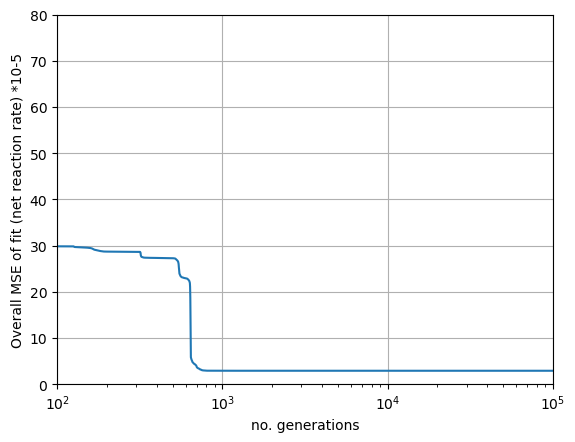

In [32]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 80])

plt.grid()
plt.show()

In [33]:
for i in range(len (res.X)):
    print (res.X[i])

-0.800131808019525
-7.900488468999081
-1.1133838252322372
-1.2016604975317833
-7.80645167489689
-1.5915050472339656
9.816039942166386
-1.126459258551982
-7.292726832933035
3.01480946293665
-0.7346425585784785
-5.431565081548054
1.3408411066842778
-0.340428740691288
-6.546486895228704
-0.8957295442944726
-0.5105742519262819
-0.41909287997842515
-7.100174103746946
8.456181025304627
2.2485245586862455
-1.2939246211473123
-1.8086055964586019
-6.405337628237219
0.9741069160939315
-6.028114222441612
-1.30103


In [34]:
res.X

array([-0.80013181, -7.90048847, -1.11338383, -1.2016605 , -7.80645167,
       -1.59150505,  9.81603994, -1.12645926, -7.29272683,  3.01480946,
       -0.73464256, -5.43156508,  1.34084111, -0.34042874, -6.5464869 ,
       -0.89572954, -0.51057425, -0.41909288, -7.1001741 ,  8.45618103,
        2.24852456, -1.29392462, -1.8086056 , -6.40533763,  0.97410692,
       -6.02811422, -1.30103   ])

In [35]:
logkr = [ 
    -0.8, -7.9,
    -1.1, -1.2, -7.8,
    -1.6, 7.6, -1.1, -7.3,
    7.1, -0.7, -10.9, 10.9,
    -0.3, -6.5,
    -0.9, -0.5, -0.4, -7.1,
    9.3, 3.1,
    -1.3, -1.8, -6.4,
    1.0, -6.0]

for i in range(len (logkr)):
    print (logkr[i])

-0.8
-7.9
-1.1
-1.2
-7.8
-1.6
7.6
-1.1
-7.3
7.1
-0.7
-10.9
10.9
-0.3
-6.5
-0.9
-0.5
-0.4
-7.1
9.3
3.1
-1.3
-1.8
-6.4
1.0
-6.0


In [36]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
R=R2**(0.5)
print ('R-value: ' +str(R) )
print ('R2: ' +str(R2) )

-0.8: -0.800131808019525
-7.9: -7.900488468999081
-1.1: -1.1133838252322372
-1.2: -1.2016604975317833
-7.8: -7.80645167489689
-1.6: -1.5915050472339656
7.6: 9.816039942166386
-1.1: -1.126459258551982
-7.3: -7.292726832933035
7.1: 3.01480946293665
-0.7: -0.7346425585784785
-10.9: -5.431565081548054
10.9: 1.3408411066842778
-0.3: -0.340428740691288
-6.5: -6.546486895228704
-0.9: -0.8957295442944726
-0.5: -0.5105742519262819
-0.4: -0.41909287997842515
-7.1: -7.100174103746946
9.3: 8.456181025304627
3.1: 2.2485245586862455
-1.3: -1.2939246211473123
-1.8: -1.8086055964586019
-6.4: -6.405337628237219
1.0: 0.9741069160939315
-6.0: -6.028114222441612
R-value: 0.9003259859956149
R2: 0.810586881058976
